# Preliminary settings
All output files will be appended with shelve_name to distinguish different runs of the notebook.

In [1]:
shelve_name='scipyGlobalOpt_'

If set to 'True', unnecessary evaluations & plots are skipped to facilitate codes development.  

In [2]:
development= False
inspectRate=True

Import libraries

In [3]:
from IPython.display import display
import pandas as pd
from KineticLearning.plot import *
import seaborn as sns
import math

# Empirical metabolomics & proteomics data files

Provide technical replicates for all 9 pathway enzymes & 10 metabolites

In [4]:
##### Metabolite replicates
metaboliteData_Rep1_path='data/timePoints/0rep_0noiseLevel_GMA_2ptPerHr_4strains_METABOLITE.csv.csv'
metaboliteData_Rep2_path='data/timePoints/0rep_0noiseLevel_GMA_2ptPerHr_4strains_METABOLITE.csv.csv'
metaboliteData_Rep3_path='data/timePoints/0rep_0noiseLevel_GMA_2ptPerHr_4strains_METABOLITE.csv.csv'

# Enzyme replicates
enzymeData_Rep1_path='data/timePoints/0rep_0noiseLevel_GMA_2ptPerHr_4strains_ENZYME.csv'
enzymeData_Rep2_path='data/timePoints/0rep_0noiseLevel_GMA_2ptPerHr_4strains_ENZYME.csv'
enzymeData_Rep3_path='data/timePoints/0rep_0noiseLevel_GMA_2ptPerHr_4strains_ENZYME.csv'

# no. datapoints required including augmented ones 

IMPORTANT:

no. datapoints should be in multiples of experimental data points

'hours' should be less than or equal to duration of experiment.


In [5]:
hours=24
datapointsPerhour = 4
numberDataPtsNeeded=hours*datapointsPerhour + 1 # include data for time=0

# Specify molecular participants

Participants must be in same order as their input into subsequent kinetic_model.
Names must be identical to imported empirical data

Machine learning of dynamics

Also required for preprocessing 

In [6]:
controls = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites

Empirically measured

In [7]:
measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']#10

# Read in raw enzymes & metabolites datasets
Row multi indices based on strain & time

Column multi indices based on controls (enzymes), states (metabolites), derivatives (rates of net production)

In [8]:
from KineticLearning import read_enzymeRawData,read_metaboliteRawData

# Enzyme replicate data
df_enzymeRaw_Rep1=read_enzymeRawData(enzymeData_Rep1_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep2=read_enzymeRawData(enzymeData_Rep2_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep3=read_enzymeRawData(enzymeData_Rep3_path,controls,time='Time/hours',strain='Strain')

# Metabolite replicate data
df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

In [9]:
df_metaboliteRaw_Rep1.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.0    0.300000        0.200000  0.050000  0.300000  0.020000   
       0.5    0.311761        0.189999  0.061382  0.220293  0.099379   
       1.0    0.317709        0.176455  0.076021  0.183449  0.134574   
       1.5    0.322371        0.162284  0.086404  0.165641  0.152880   
       2.0    0.326734        0.148163  0.087892  0.161313  0.164268   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.0   0.200000  0.010000  0.040000  0.050000  0.000000  
       0.5   0.200554  0.009227  0.039269  0.049266  0.001492  
       1.0   0.203795  0.006931  0.036924  0.049404  0.003708  
       1.5   0.209994  0.005174  0.034993  0.048880  0.006163  
       2.0   0.218527  0.004147  0.033668  0.047666  0.008702

In [10]:
df_metaboliteRaw_Rep2.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.0    0.300000        0.200000  0.050000  0.300000  0.020000   
       0.5    0.311761        0.189999  0.061382  0.220293  0.099379   
       1.0    0.317709        0.176455  0.076021  0.183449  0.134574   
       1.5    0.322371        0.162284  0.086404  0.165641  0.152880   
       2.0    0.326734        0.148163  0.087892  0.161313  0.164268   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.0   0.200000  0.010000  0.040000  0.050000  0.000000  
       0.5   0.200554  0.009227  0.039269  0.049266  0.001492  
       1.0   0.203795  0.006931  0.036924  0.049404  0.003708  
       1.5   0.209994  0.005174  0.034993  0.048880  0.006163  
       2.0   0.218527  0.004147  0.033668  0.047666  0.008702

In [11]:
df_metaboliteRaw_Rep3.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.0    0.300000        0.200000  0.050000  0.300000  0.020000   
       0.5    0.311761        0.189999  0.061382  0.220293  0.099379   
       1.0    0.317709        0.176455  0.076021  0.183449  0.134574   
       1.5    0.322371        0.162284  0.086404  0.165641  0.152880   
       2.0    0.326734        0.148163  0.087892  0.161313  0.164268   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.0   0.200000  0.010000  0.040000  0.050000  0.000000  
       0.5   0.200554  0.009227  0.039269  0.049266  0.001492  
       1.0   0.203795  0.006931  0.036924  0.049404  0.003708  
       1.5   0.209994  0.005174  0.034993  0.048880  0.006163  
       2.0   0.218527  0.004147  0.033668  0.047666  0.008702

# Average of replicate values

Metabolites

In [12]:
#Stack replicate data on top of each other
df_metaboliteRaw_concat = pd.concat(
    (df_metaboliteRaw_Rep1, 
     df_metaboliteRaw_Rep2, 
     df_metaboliteRaw_Rep3)
)
#df_metaboliteRaw_concat.to_csv('df_metaboliteRaw_concat.csv')

# Create dataframe from average of 3 replicates
df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
#df_metaboliteRaw.to_csv('metabolite_average.csv')

df_metaboliteRaw.head()

states                                                \
              Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                            
Strain 1 0.0    0.300000        0.200000  0.050000  0.300000  0.020000   
         0.5    0.299893        0.188541  0.068037  0.218933  0.100735   
         1.0    0.288190        0.174077  0.089557  0.183997  0.136357   
         1.5    0.274398        0.158853  0.093482  0.179006  0.157845   
         2.0    0.260551        0.143504  0.080676  0.188562  0.178523   

                                                                 
                  MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                    
Strain 1 0.0   0.200000  0.010000  0.040000  0.050000  0.000000  
         0.5   0.200543  0.009250  0.039268  0.049773  0.000986  
         1.0   0.203716  0.007056  0.036890  0.050678  0.002468  
         1.5   0.209860  0.005463  0.034856  0.051042  0.004139  
         2.0   0.219000  0.004525  0.033388  0.050751  0.005898

Enzymes

In [13]:
#Stack replicate data on top of each other
df_enzymeRaw_concat = pd.concat(
    (df_enzymeRaw_Rep1, 
     df_enzymeRaw_Rep2, 
     df_enzymeRaw_Rep3)
)

# Create dataframe from average of 3 replicates
df_enzymeRaw = df_enzymeRaw_concat.groupby(['Strain','Time']).mean()
df_enzymeRaw.head()

controls                                             \
                       AtoB          HMGS           HMGR            MK   
Strain   Time                                                            
Strain 1 0.0   5.946962e+01  3.973013e+01      36.968921  5.762279e+01   
         0.5   5.471875e+06  3.482933e+06  339448.988190  2.217158e+06   
         1.0   6.072640e+06  4.609864e+06  474068.251127  3.097868e+06   
         1.5   6.303323e+06  5.167157e+06  546287.047997  3.570656e+06   
         2.0   6.425365e+06  5.499584e+06  591328.783707  3.865639e+06   

                                                                       \
                        PMK           PMD          GPPS           Idi   
Strain   Time                                                           
Strain 1 0.0   2.659959e+01  5.448132e+01  5.547215e+01  1.868778e+01   
         0.5   7.241324e+05  3.761395e+06  3.265182e+06  6.399929e+05   
         1.0   9.847275e+05  5.509792e+06  3.743605e+06  8.490980e+05   
         1.5   1.118956e+06  6.520026e+06  3.935836e+06  9.528769e+05   
         2.0   1.200797e+06  7.178087e+06  4.039549e+06  1.014899e+06   

                                 
              Limonene Synthase  
Strain   Time                    
Strain 1 0.0          30.341080  
         0.5      286614.273964  
         1.0      398139.231561  
         1.5      457478.291179  
         2.0      494315.467226

In [14]:
# # Testing
# from KineticLearning import read_metaboliteRawData
# import pandas as pd
# states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites
# metaboliteData_Rep1_path='data/rep_1_TEST.csv'
# metaboliteData_Rep2_path='data/rep_2_TEST.csv'
# metaboliteData_Rep3_path='data/rep_3_TEST.csv'
# df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

# #Stack replicate data on top of each other
# df_metaboliteRaw_concat = pd.concat(
#     (df_metaboliteRaw_Rep1, 
#      df_metaboliteRaw_Rep2, 
#      df_metaboliteRaw_Rep3)
# )
# df_metaboliteRaw_concat.to_csv('df_TEST_concat.csv')

# # Create dataframe from average of 3 replicates
# df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
# df_metaboliteRaw.to_csv('TEST_average.csv')

# Read strain list from enzyme data file

In [15]:
strainList=[]
for strain in df_enzymeRaw.index:
    if strain[0] not in strainList:
        strainList.append(strain[0])
print ('List of ' +str(len(strainList)) + ' strains read in.')

List of 4 strains read in.


# Assess missing data

In [16]:
from KineticLearning import NaN_table

if development==True:
    pass
else:
    # generate NaN summary table
    print('Enzymes:')
    df_NaN_enzymeRaw=NaN_table(df_enzymeRaw) # enzymes
    print('\nMetabolites:')
    df_NaN_metaboliteRaw=NaN_table(df_metaboliteRaw) # metabolites

    #display tables
    display(df_NaN_enzymeRaw) # enzymes
    df_enzymeRaw.head()
    display(df_NaN_metaboliteRaw) # metabolites
    df_metaboliteRaw.head()

Enzymes:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.

Metabolites:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.


Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

# Impute missing data

In [17]:
df_metaboliteImputed = df_metaboliteRaw.groupby('Strain').apply(lambda group: group.interpolate()) # metabolites
df_enzymeImputed = df_enzymeRaw.groupby('Strain').apply(lambda group: group.interpolate()) # enzymes

# Assess effect of imputation on missing data

In [18]:
from KineticLearning import compareTimeSeriesAfterPreprocess

if development==True:
    pass
else:
    # generate NaN summary table
    print('Metabolites data:')
    df_NaN_metaboliteImputed=NaN_table(df_metaboliteImputed)
    print('\nEnzymes data:')
    df_NaN_enzymeImputed=NaN_table(df_enzymeImputed)
    
    # display(df_metaboliteImputed)
    
    #print ('\n----------------------------------------------------\nMetabolites plots before & after imputation:\n')
    #compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteImputed,'states',
    #                             strainList,preprocessLabel='After Imputation')

    # display(df_enzymeImputed)

Metabolites data:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.

Enzymes data:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.


# Smoothen & augment data using non-parametric approach

M-spline method is used.

In [19]:
from KineticLearning import smoothenTimeSeries2

# Metabolites
df_metaboliteSmooth=smoothenTimeSeries2('states',df_metaboliteImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)
# Enzymes
df_enzymeSmooth=smoothenTimeSeries2('controls',df_enzymeImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)

# Inspect outcome of data smoothening & augmentation 

metabolites

Strain Strain 1


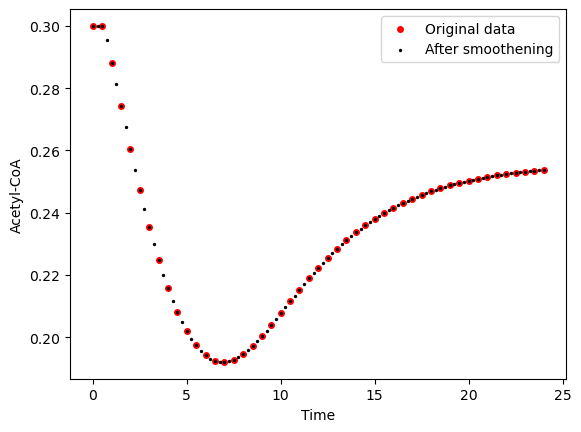

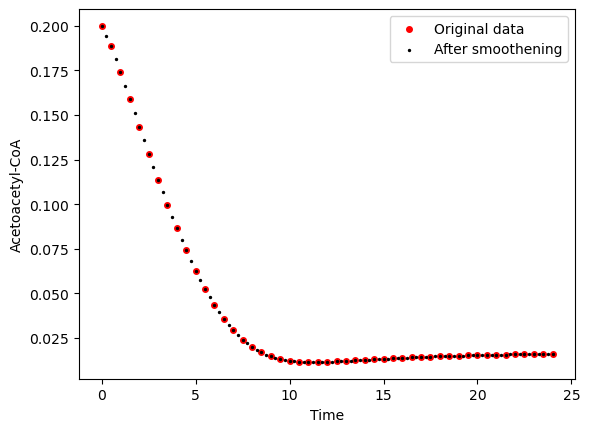

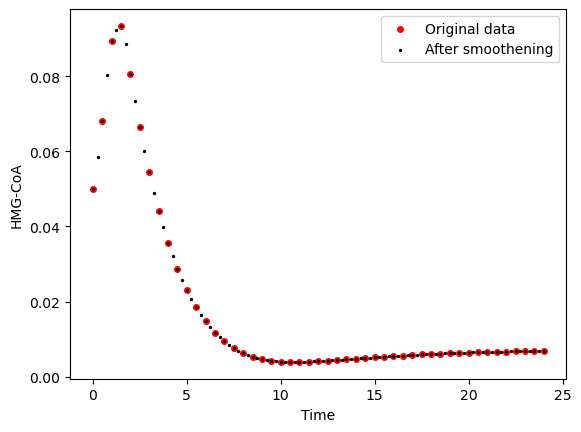

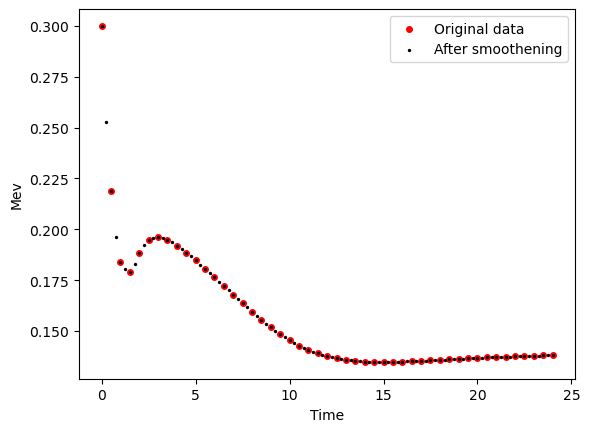

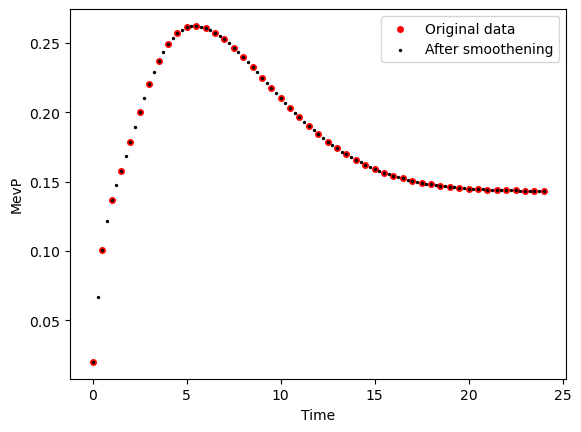

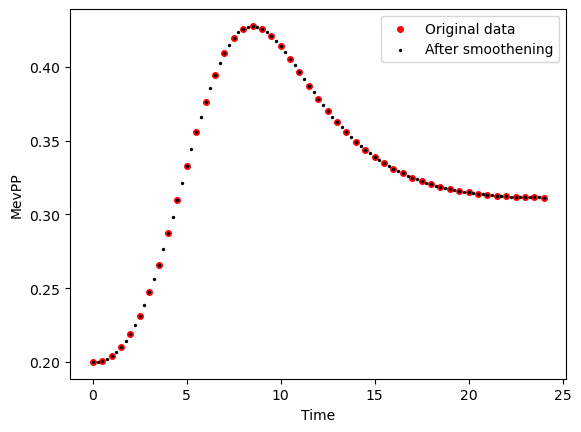

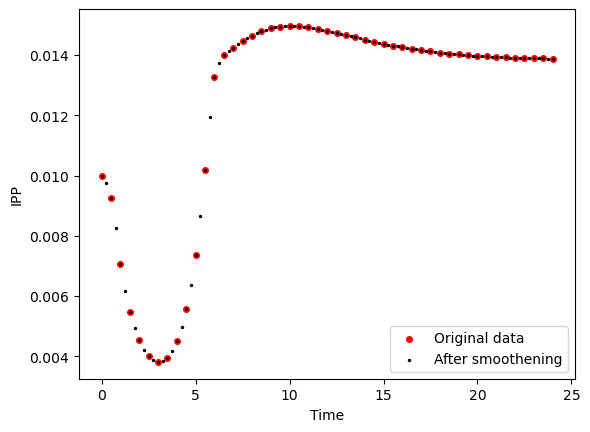

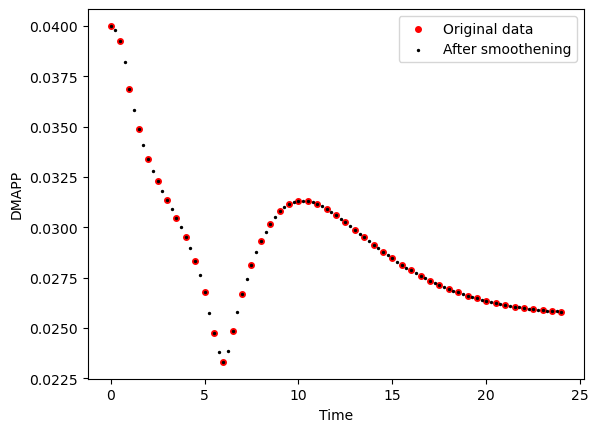

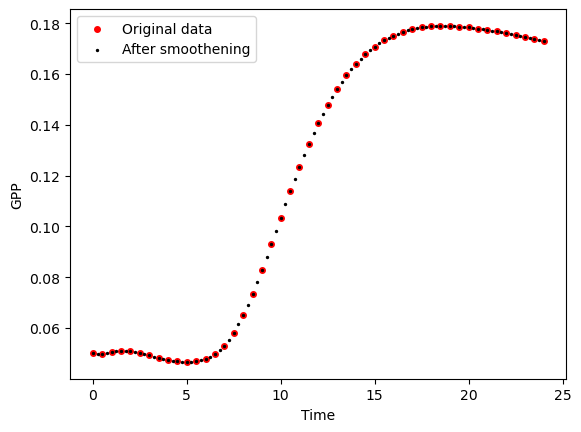

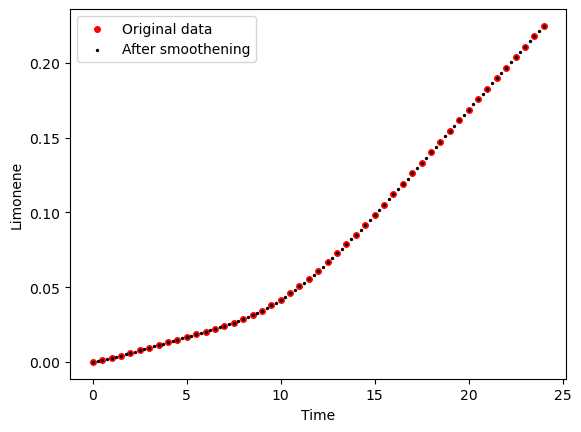

Strain Strain 2


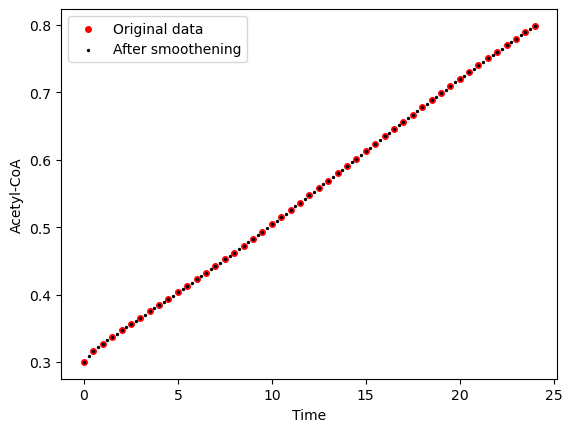

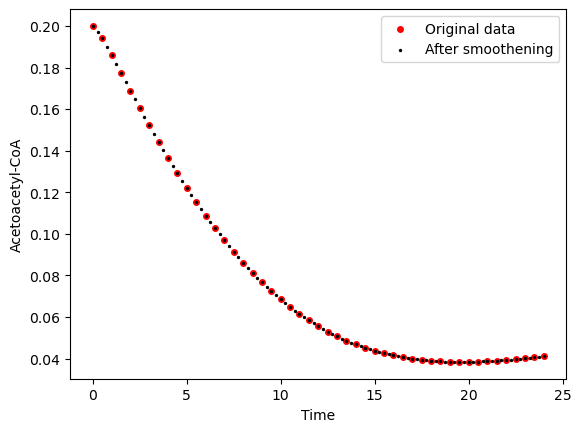

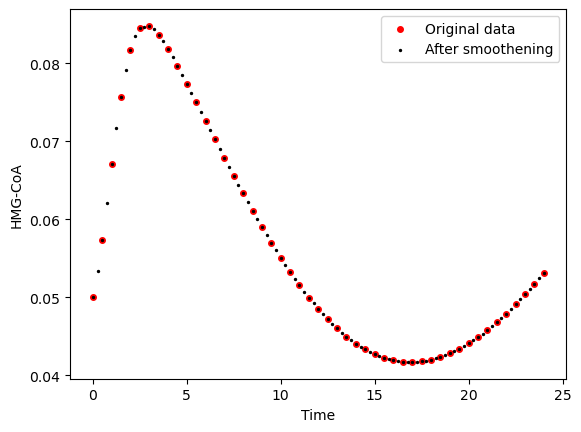

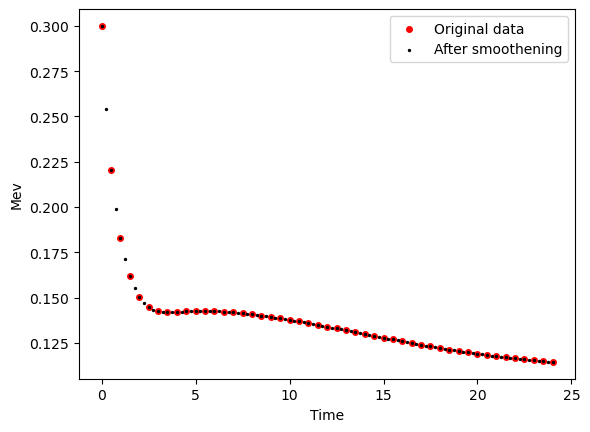

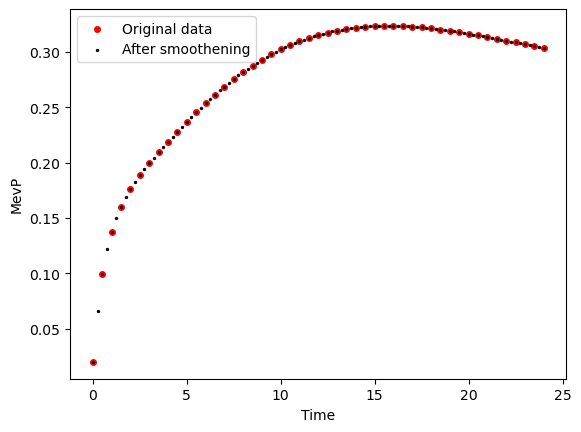

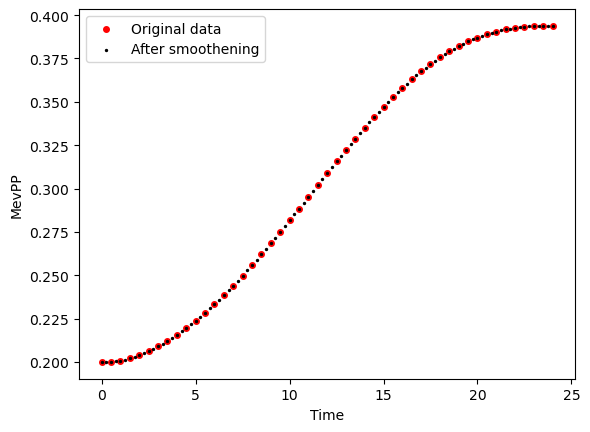

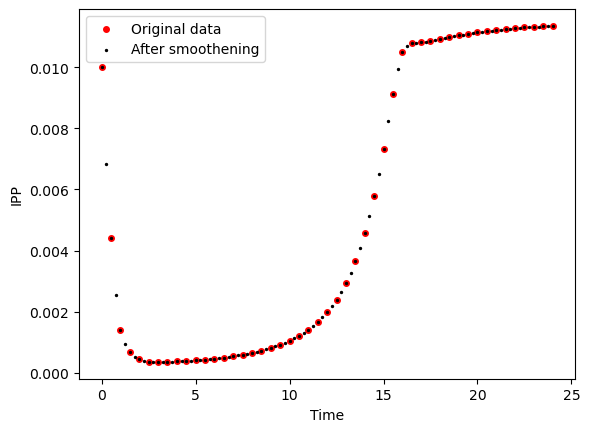

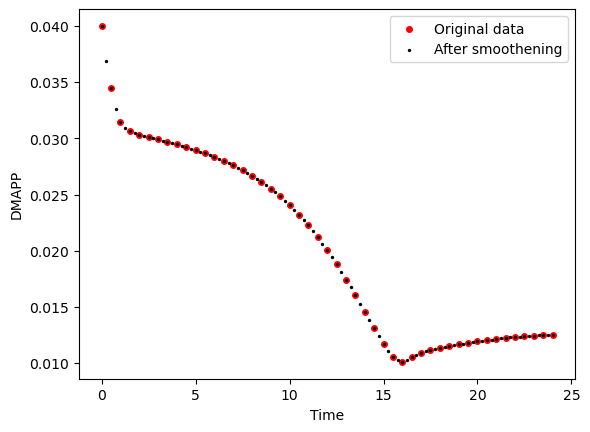

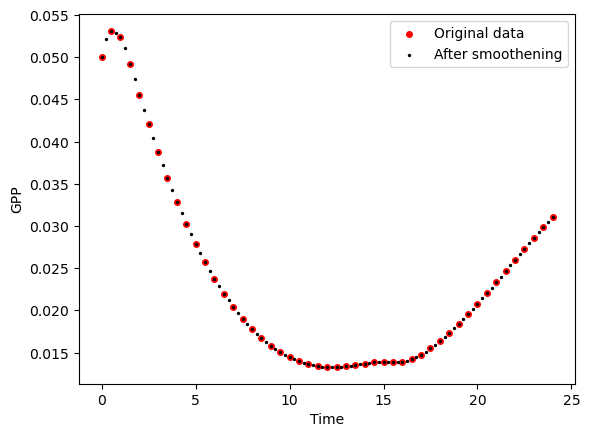

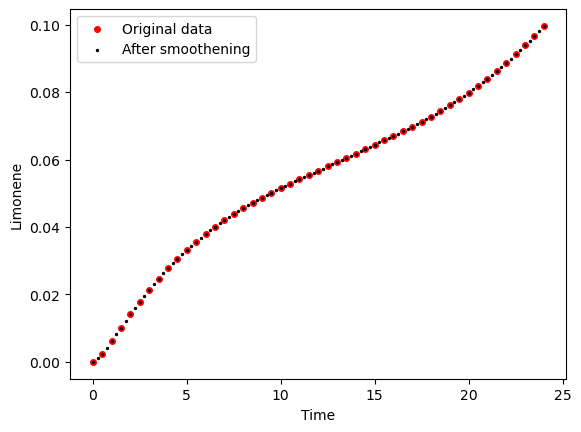

Strain Strain 3


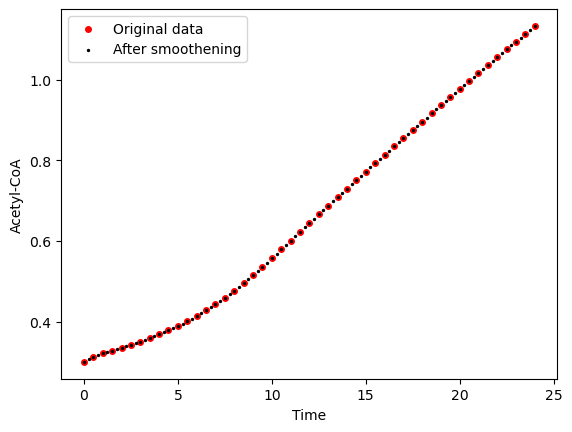

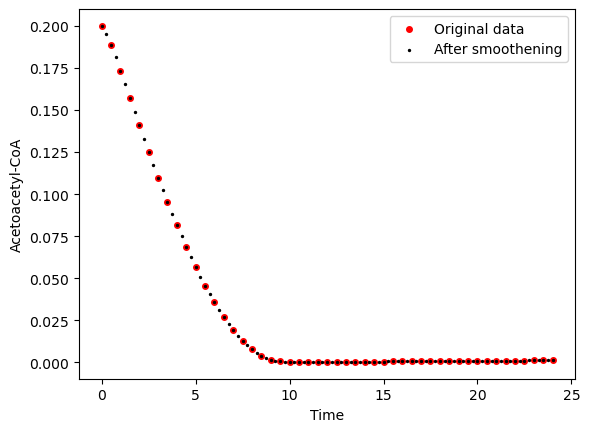

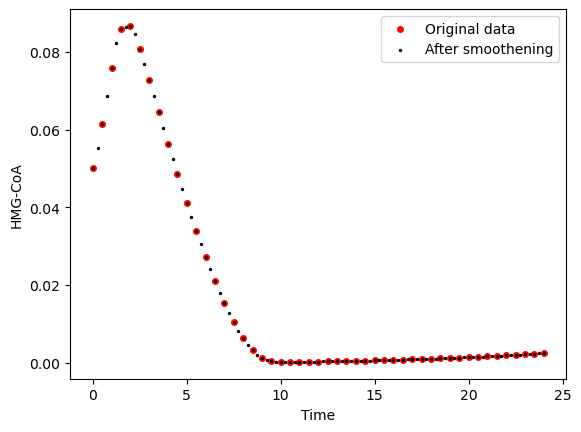

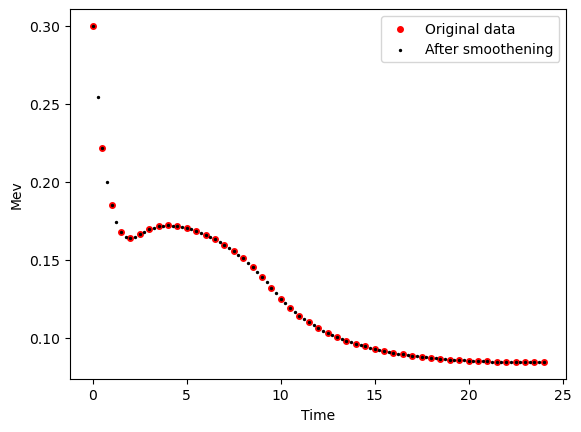

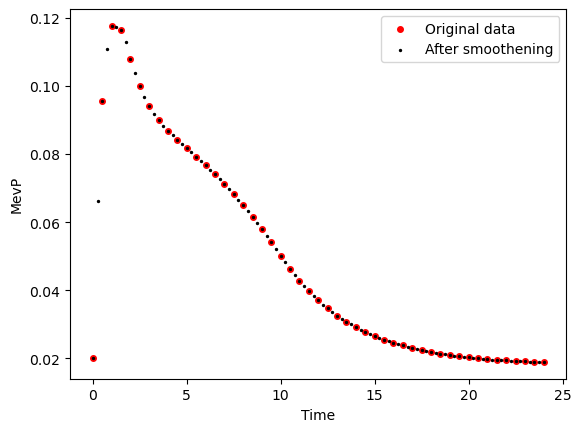

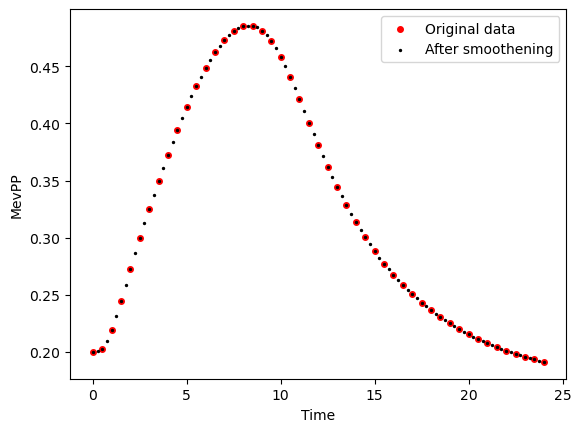

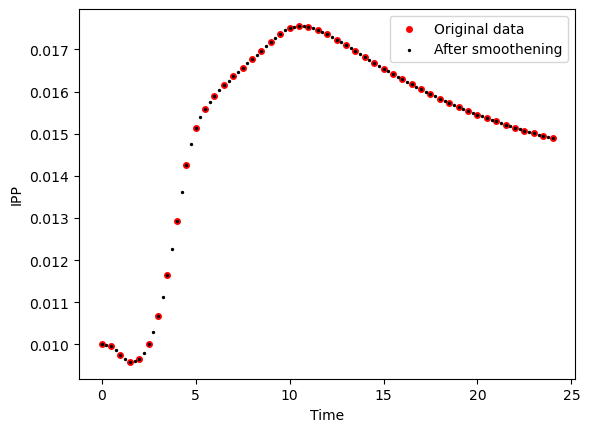

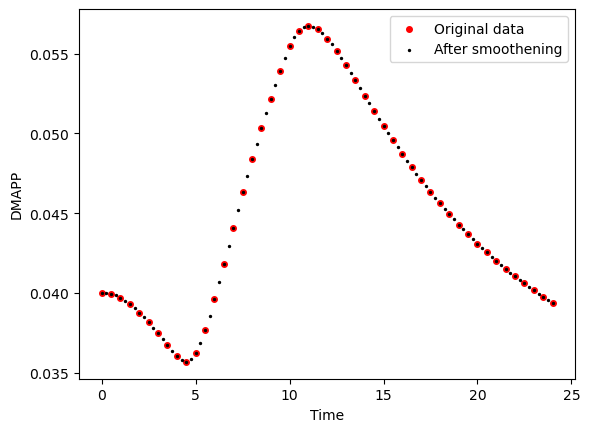

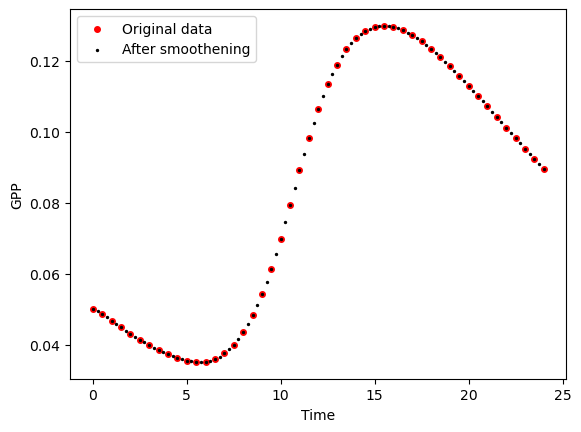

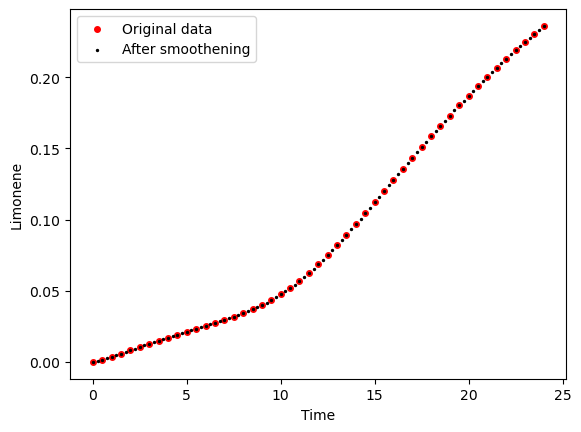

Strain WT


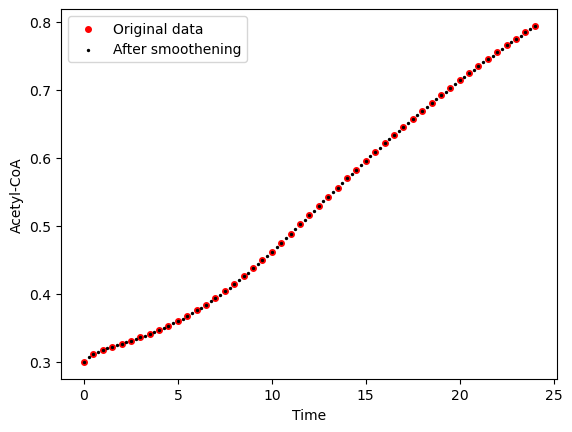

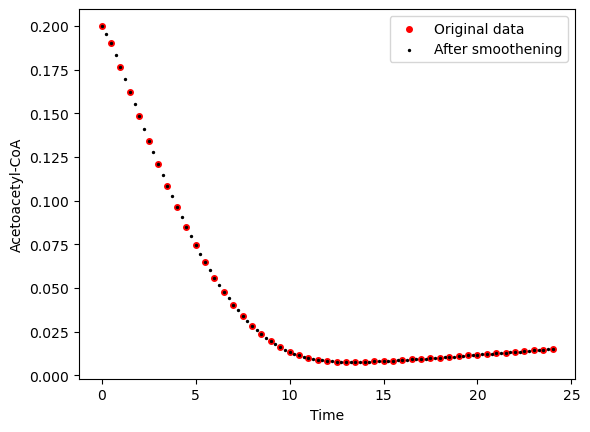

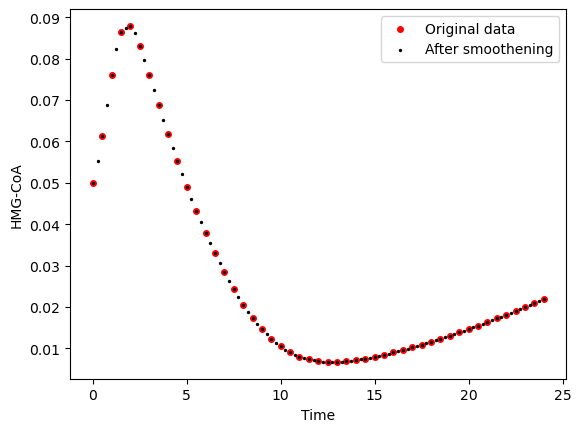

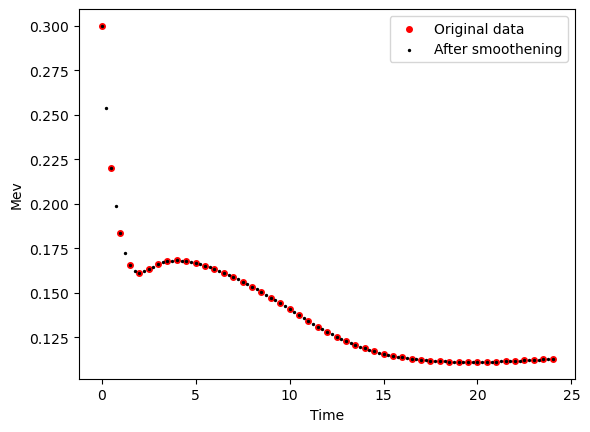

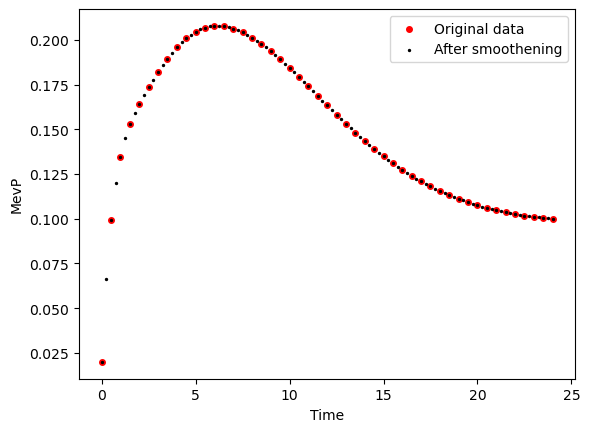

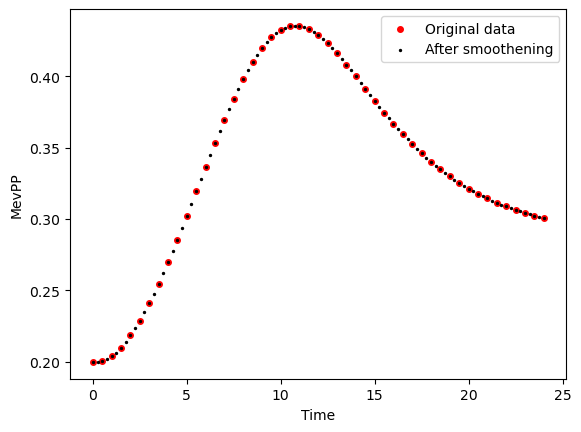

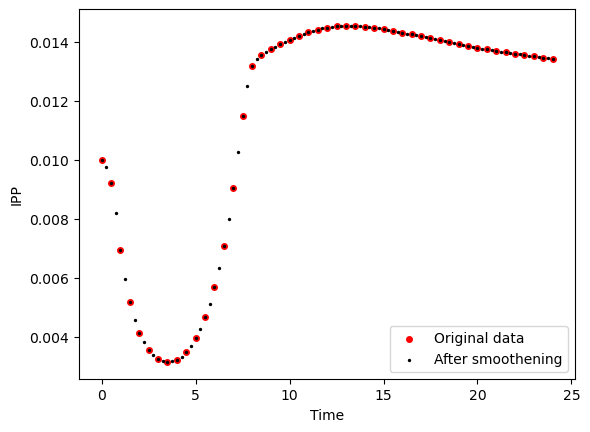

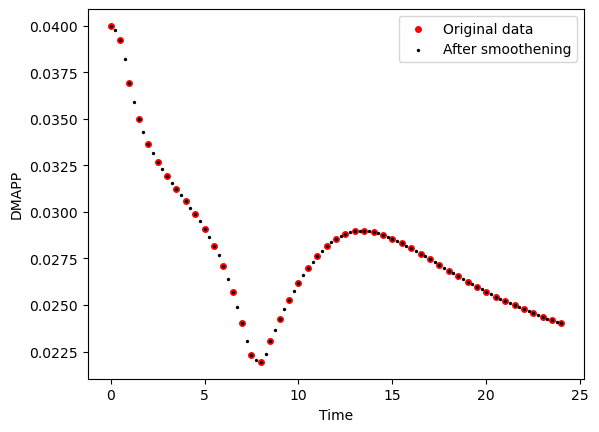

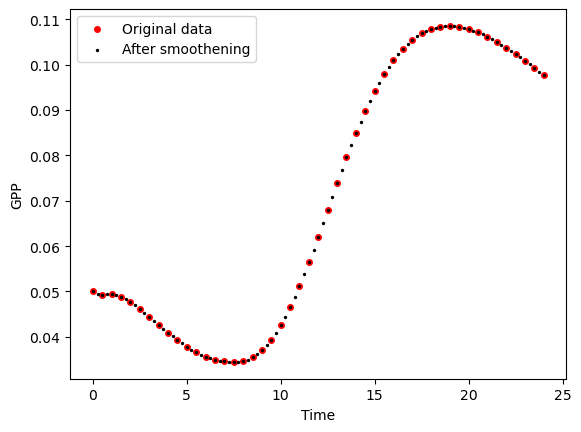

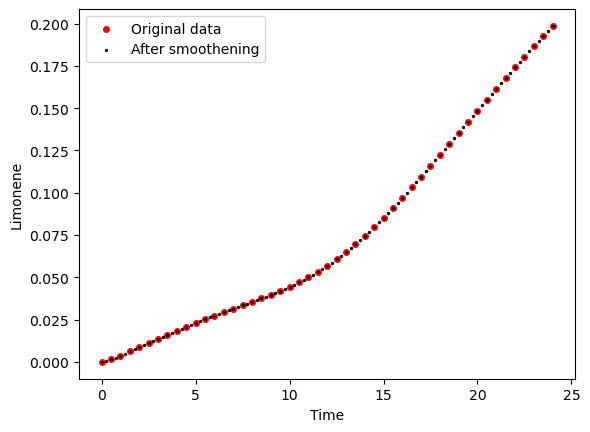

In [20]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteSmooth,'states',
                                 strainList,preprocessLabel='After smoothening')

enzymes

Strain Strain 1


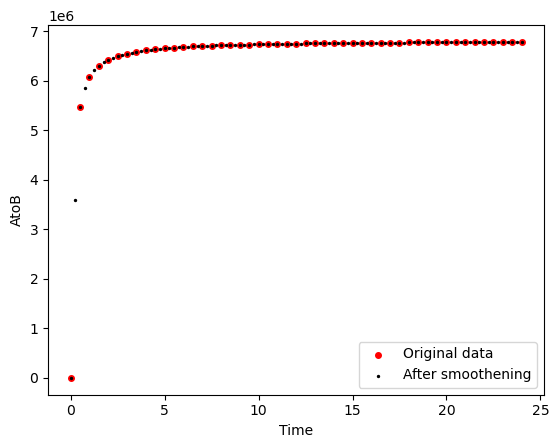

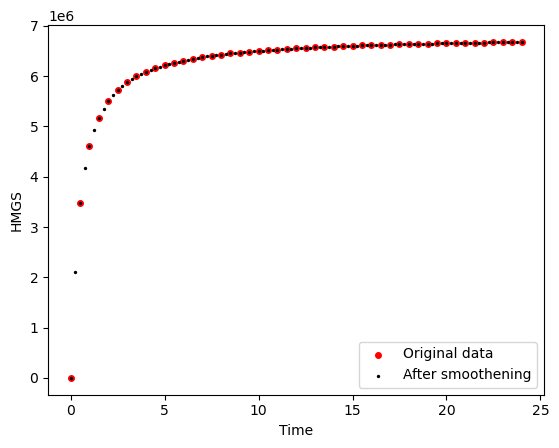

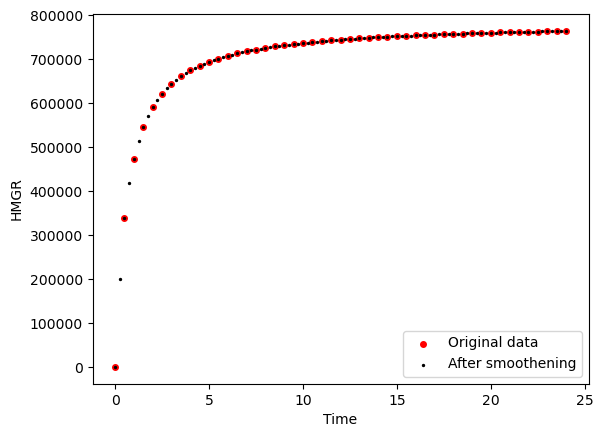

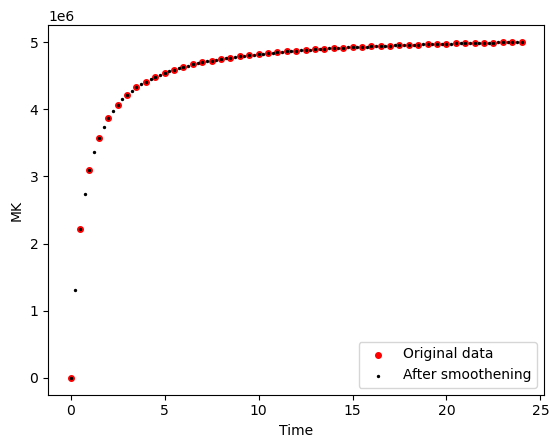

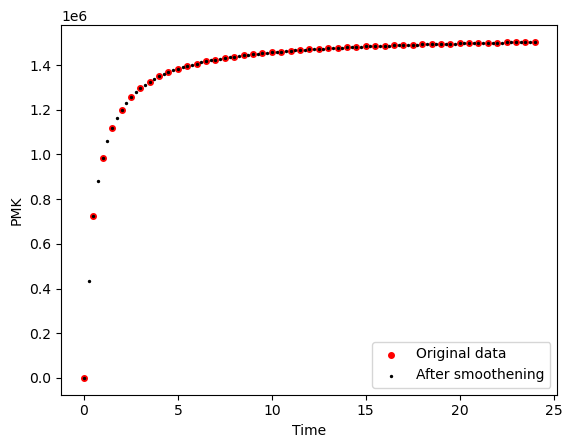

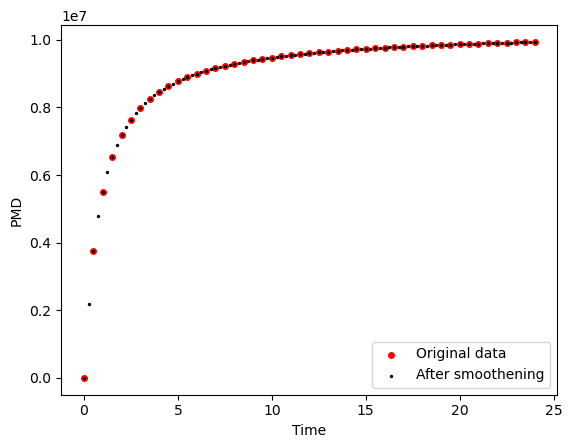

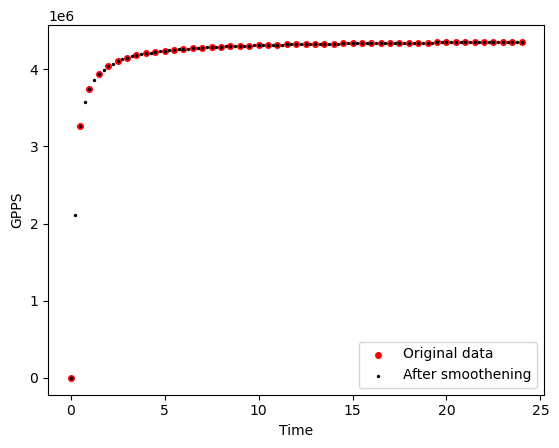

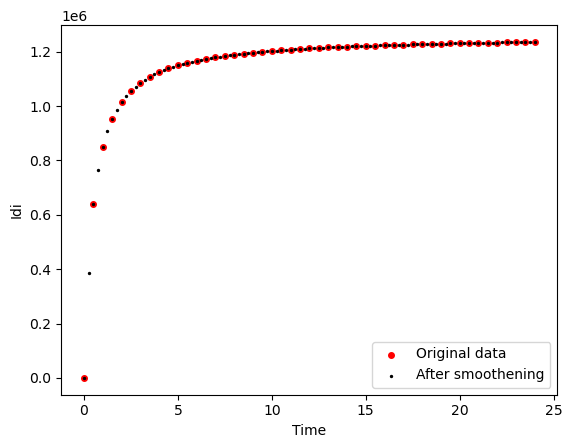

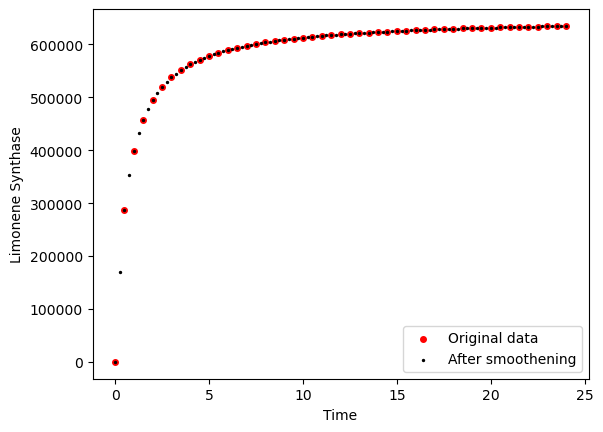

Strain Strain 2


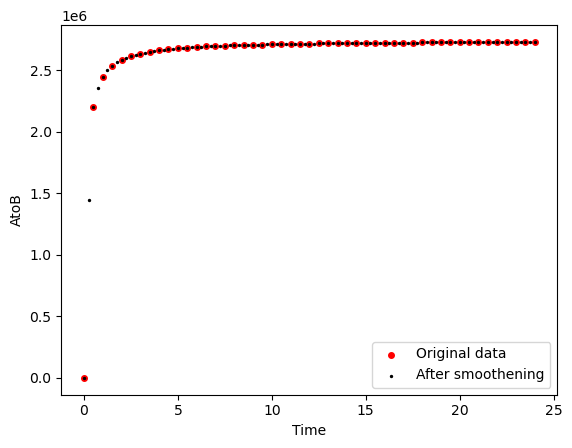

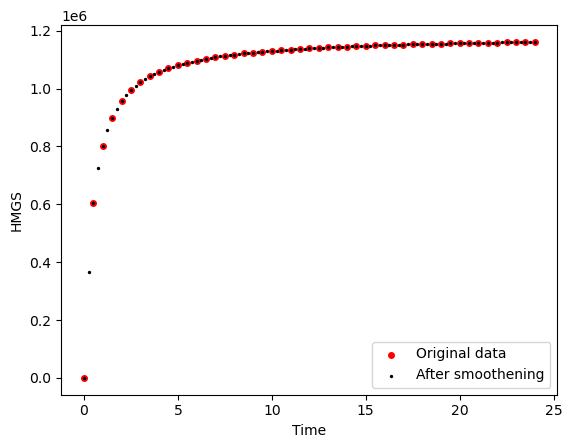

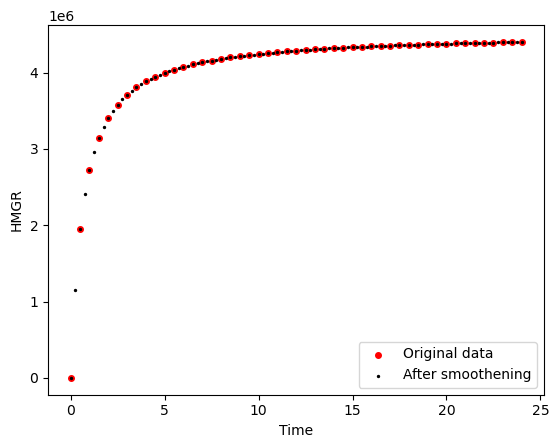

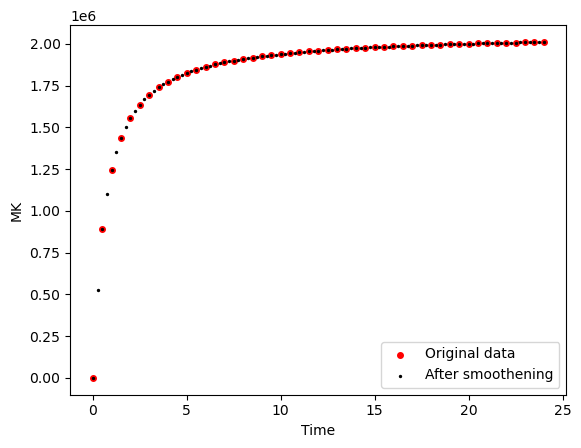

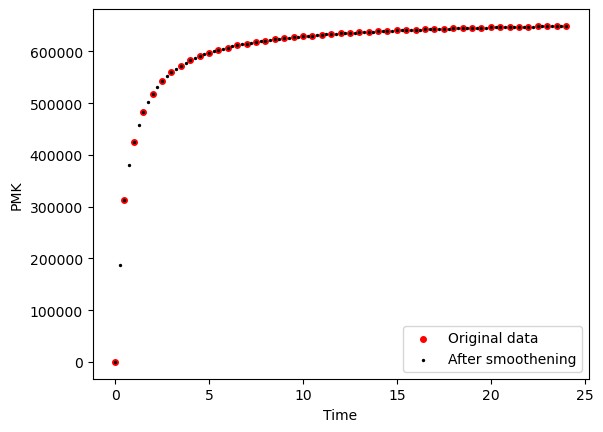

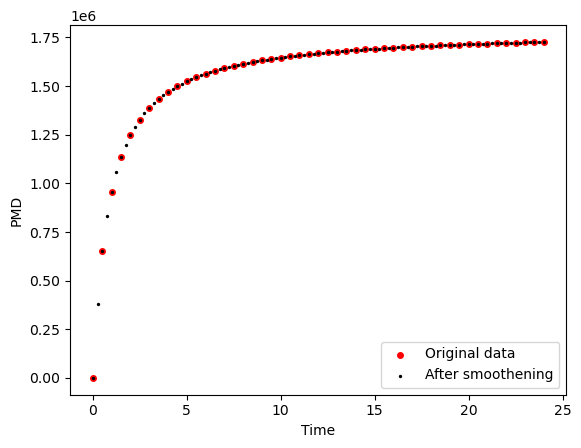

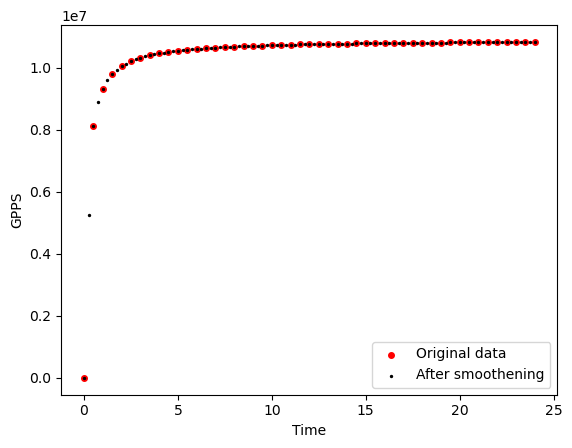

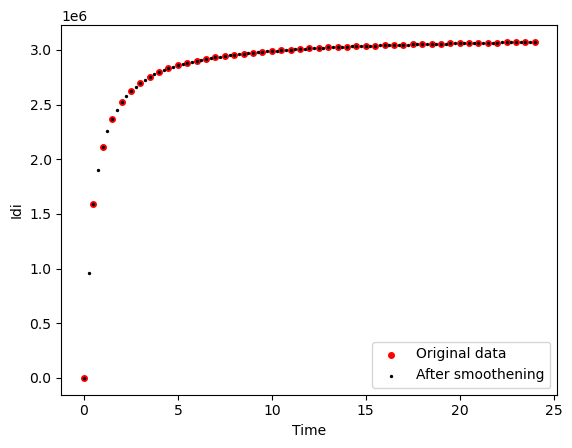

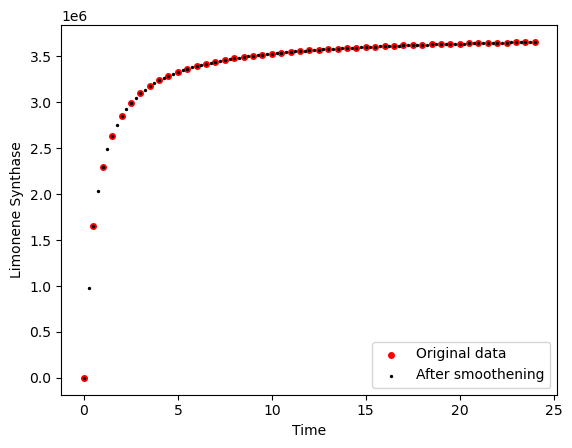

Strain Strain 3


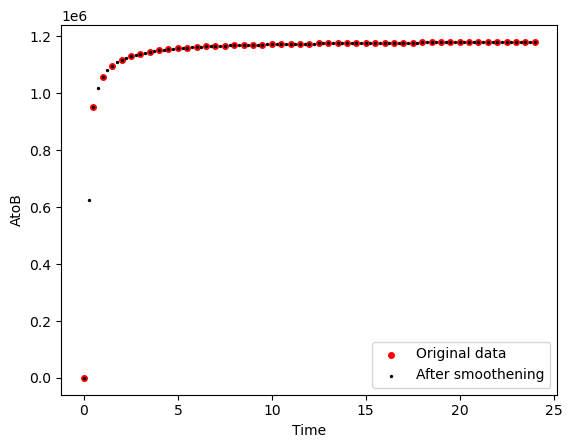

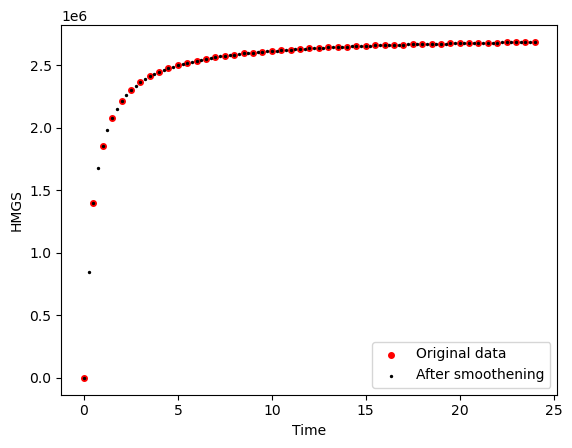

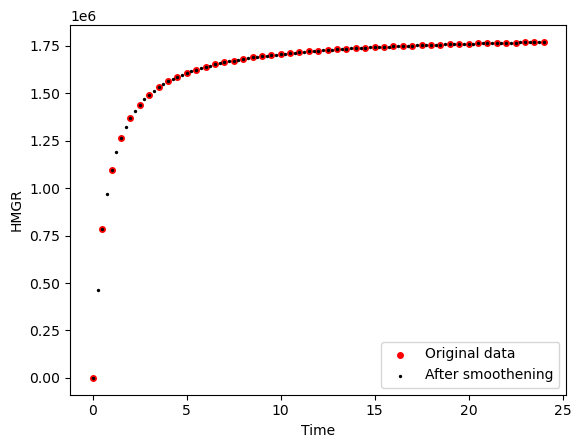

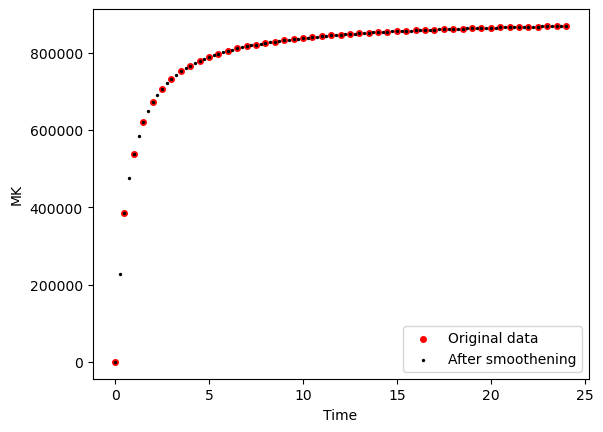

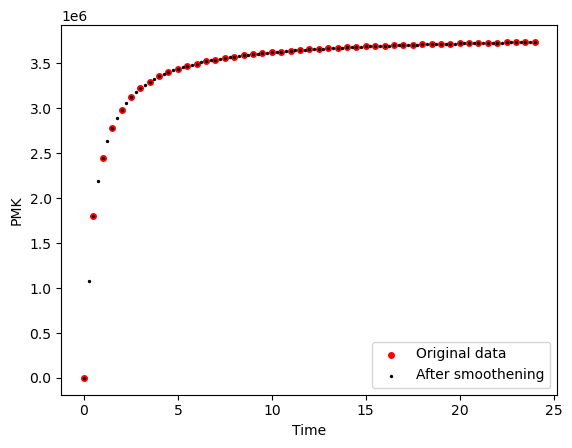

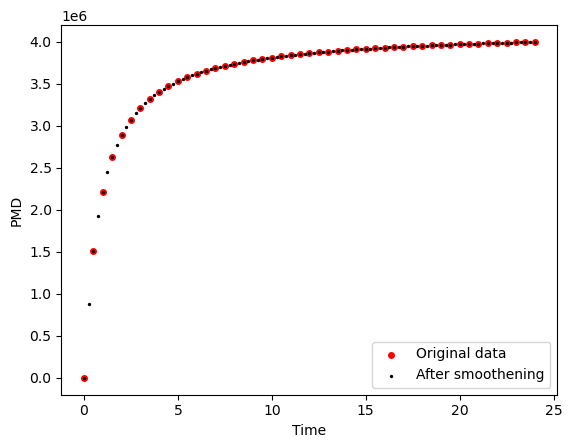

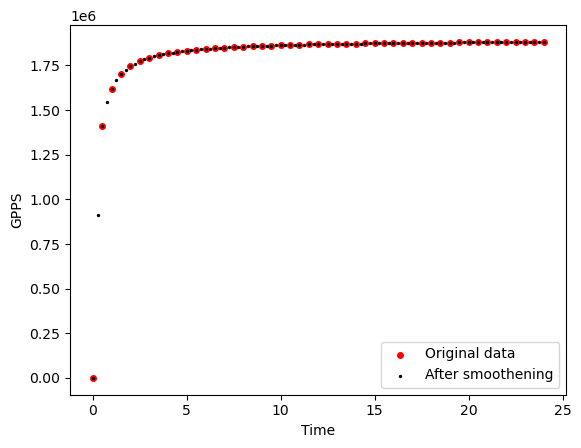

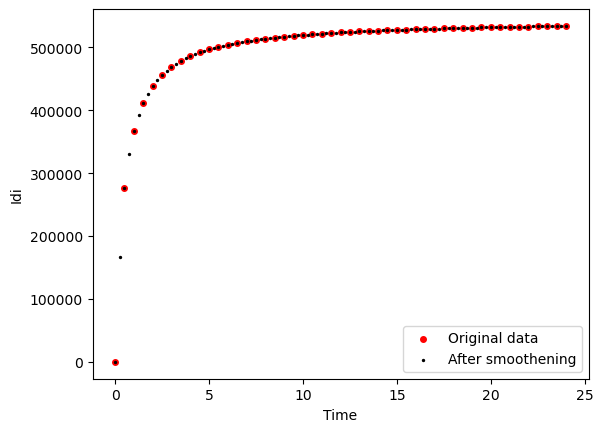

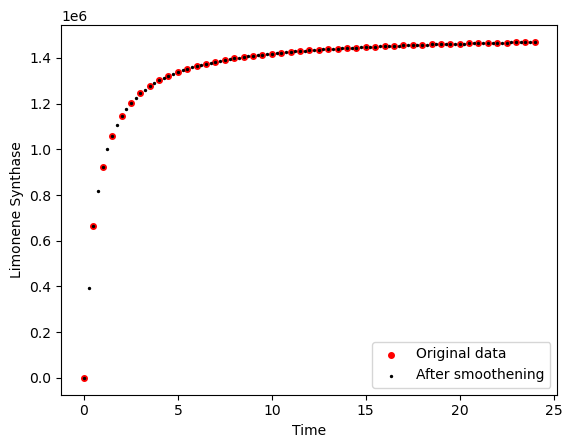

Strain WT


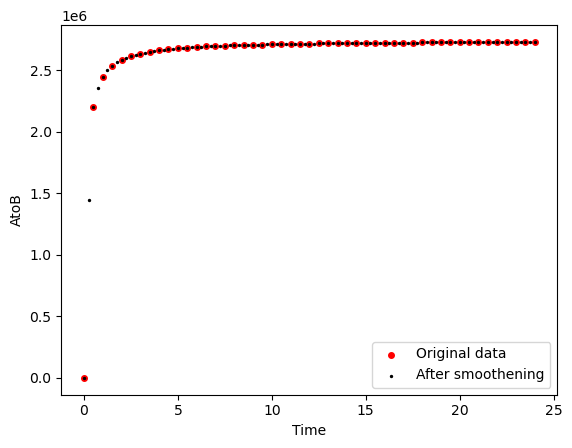

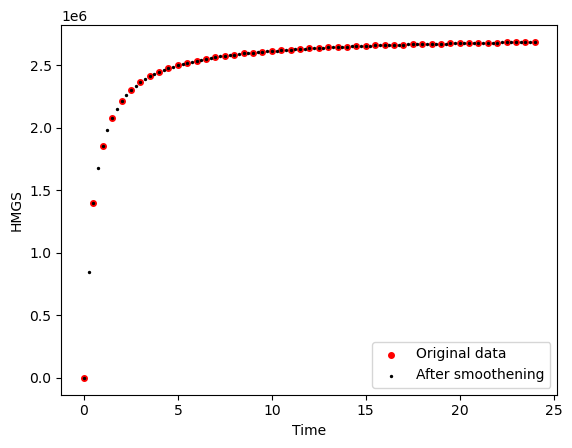

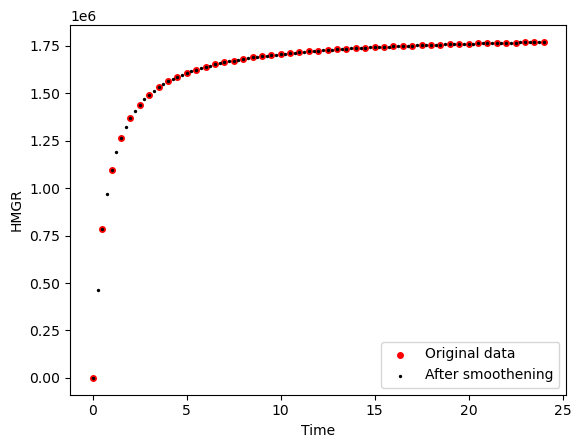

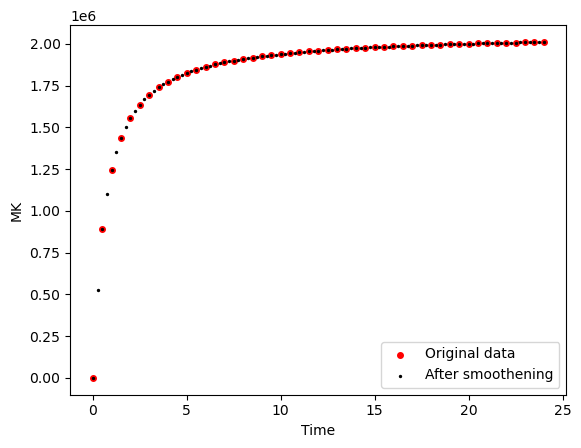

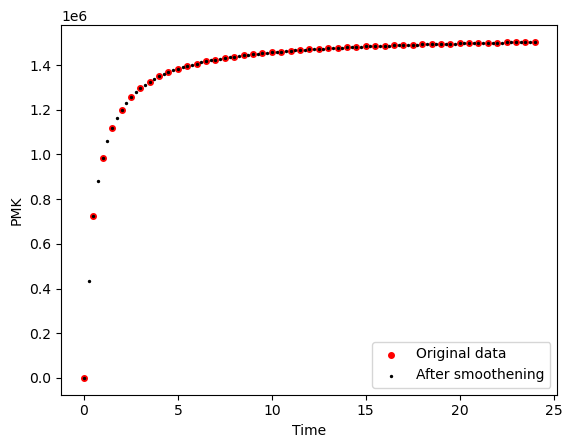

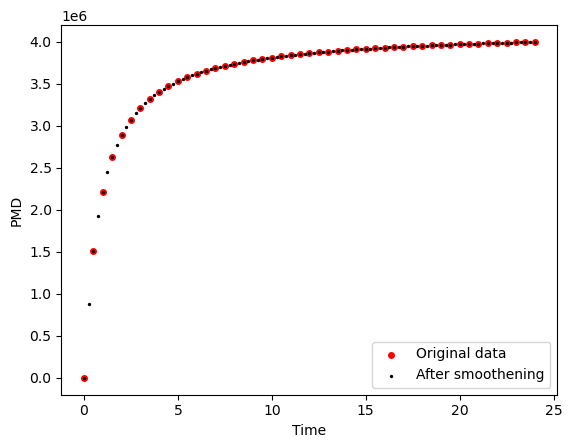

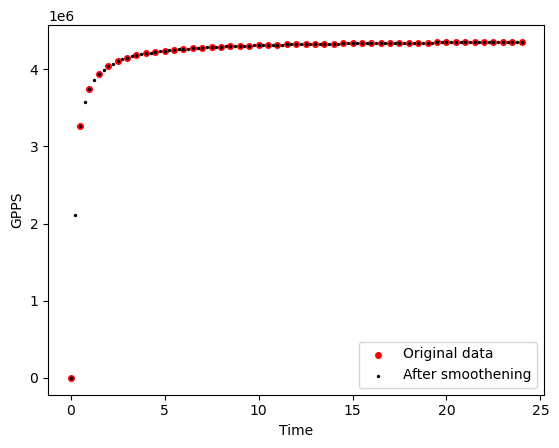

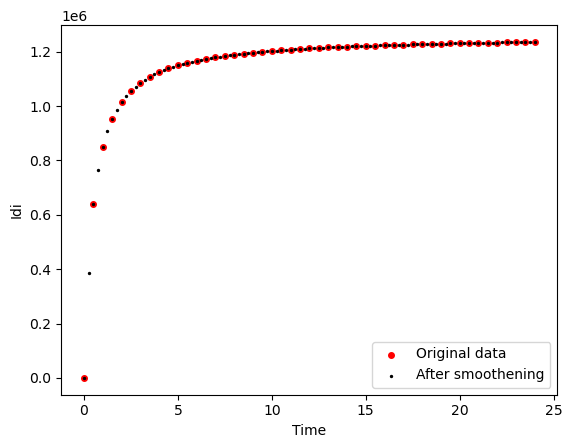

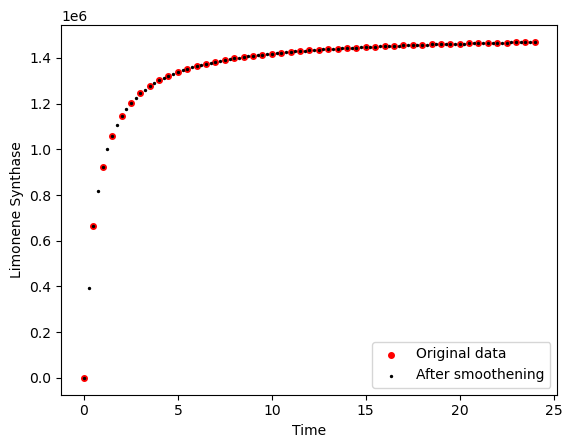

In [21]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_enzymeRaw,df_enzymeSmooth,'controls',
                                 strainList,preprocessLabel='After smoothening')

# Combine metabolites & enzymes dataframes

In [22]:
df_allSmooth=pd.concat([df_metaboliteSmooth,df_enzymeSmooth],axis=1)

if development==True:
    pass
else:
    df_allSmooth.head()

# Compute rate of reaction

In [23]:
from KineticLearning import estimate_state_derivative73

df_allSmooth=estimate_state_derivative73(df_allSmooth)

if development==True:
    pass
else:
    display(df_allSmooth) #new
    df_allSmooth.to_csv(shelve_name + '_df_allSmooth.csv')

states                                                \
               Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                             
Strain 1 0.00    0.300000        0.200000  0.050000  0.300000  0.020000   
         0.25    0.299973        0.194624  0.058602  0.252554  0.067099   
         0.50    0.299893        0.188541  0.068037  0.218933  0.100735   
         0.75    0.295598        0.181565  0.080420  0.196453  0.121374   
         1.00    0.288190        0.174077  0.089557  0.183997  0.136357   
...                   ...             ...       ...       ...       ...   
WT       23.00   0.775039        0.014167  0.019944  0.112389  0.101024   
         23.25   0.779833        0.014374  0.020413  0.112530  0.100700   
         23.50   0.784584        0.014581  0.020886  0.112676  0.100406   
         23.75   0.789290        0.014788  0.021362  0.112825  0.100138   
         24.00   0.793953        0.014996  0.021843  0.112979  0.099897   

                                                                  ...  \
                   MevPP       IPP     DMAPP       GPP  Limonene  ...   
Strain   Time                                                     ...   
Strain 1 0.00   0.200000  0.010000  0.040000  0.050000  0.000000  ...   
         0.25   0.200156  0.009761  0.039774  0.049802  0.000437  ...   
         0.50   0.200543  0.009250  0.039268  0.049773  0.000986  ...   
         0.75   0.201722  0.008244  0.038213  0.050161  0.001679  ...   
         1.00   0.203716  0.007056  0.036890  0.050678  0.002468  ...   
...                  ...       ...       ...       ...       ...  ...   
WT       23.00  0.304296  0.013499  0.024360  0.100867  0.186575  ...   
         23.25  0.303339  0.013479  0.024268  0.100090  0.189619  ...   
         23.50  0.302440  0.013460  0.024180  0.099296  0.192639  ...   
         23.75  0.301600  0.013442  0.024094  0.098490  0.195635  ...   
         24.00  0.300814  0.013424  0.024011  0.097670  0.198608  ...   

               derivatives                                                \
                Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                              
Strain 1 0.00     0.013690       -0.018904  0.027176 -0.222785  0.222886   
         0.25    -0.001145       -0.023161  0.039481 -0.161460  0.157755   
         0.50    -0.012890       -0.026471  0.043928 -0.109410  0.106960   
         0.75    -0.021545       -0.028834  0.040518 -0.066636  0.070502   
         1.00    -0.028784       -0.030249  0.027513 -0.032895  0.049786   
...                    ...             ...       ...       ...       ...   
WT       23.00    0.019269        0.000828  0.001867  0.000553 -0.001354   
         23.25    0.019090        0.000828  0.001883  0.000573 -0.001236   
         23.50    0.018914        0.000829  0.001899  0.000590 -0.001124   
         23.75    0.018739        0.000829  0.001915  0.000607 -0.001016   
         24.00    0.018565        0.000829  0.001931  0.000621 -0.000913   

                                                                  
                   MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                     
Strain 1 0.00  -0.001006  0.000783  0.000992 -0.002212  0.001339  
         0.25   0.001066 -0.001721 -0.001670 -0.000263  0.002004  
         0.50   0.003438 -0.003397 -0.003536  0.001029  0.002540  
         0.75   0.006111 -0.004247 -0.004605  0.001664  0.002949  
         1.00   0.009363 -0.004243 -0.004909  0.001653  0.003235  
...                  ...       ...       ...       ...       ...  
WT       23.00 -0.003953 -0.000080 -0.000374 -0.003075  0.012221  
         23.25 -0.003710 -0.000078 -0.000361 -0.003143  0.012129  
         23.50 -0.003476 -0.000075 -0.000349 -0.003202  0.012034  
         23.75 -0.003251 -0.000072 -0.000337 -0.003253  0.011938  
         

# Inspect quality of reaction rates

Check if derivatives are reliable enough to regenerate metabolite time profiles.

'Time profile from derivative vs. actual profile for Strain 1'

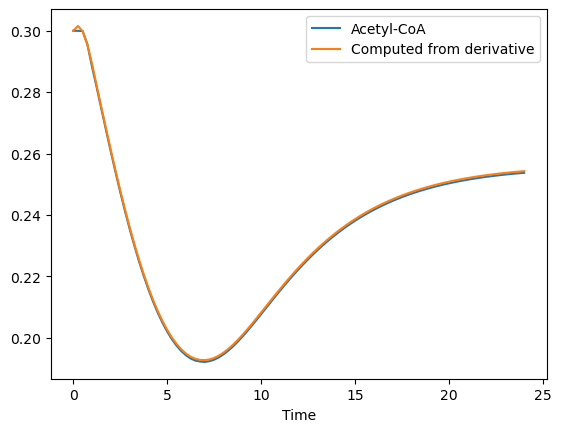

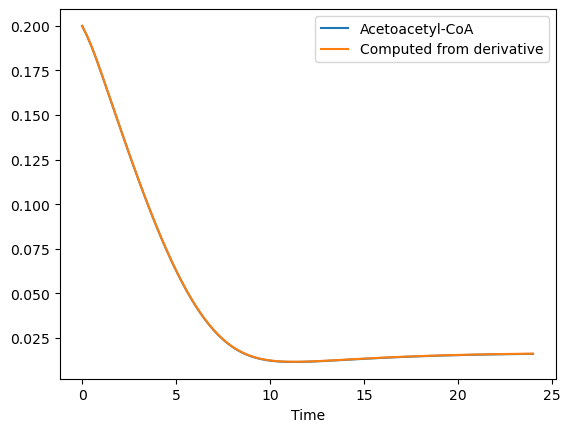

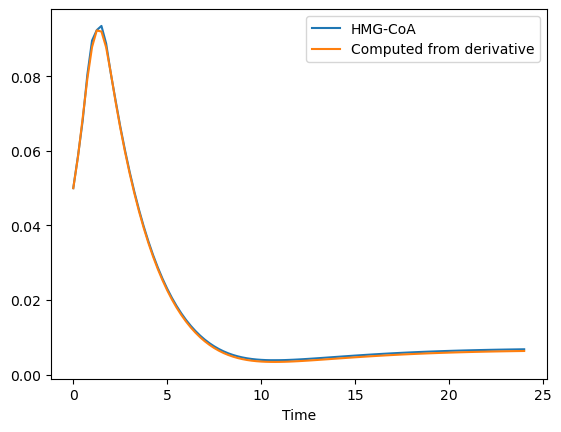

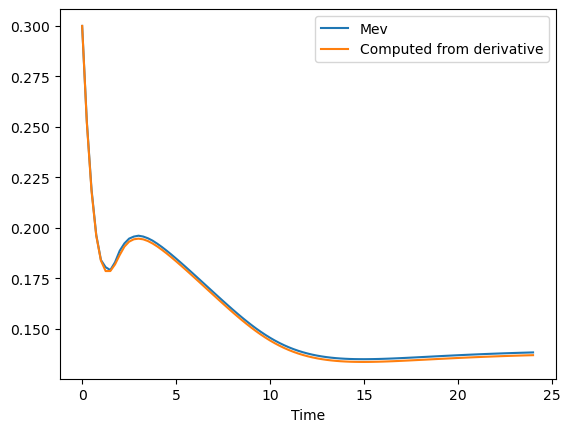

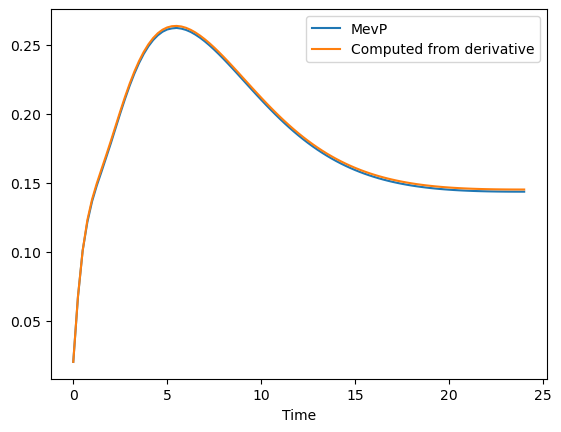

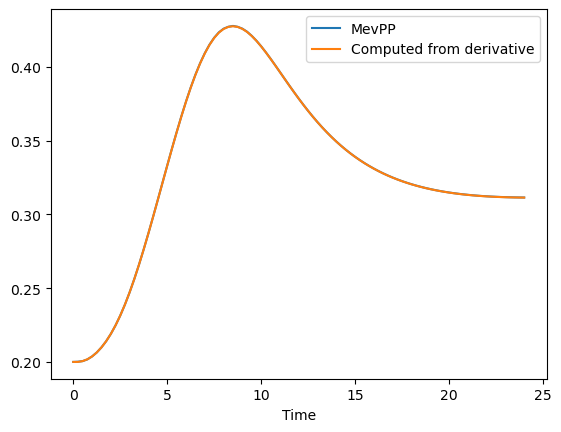

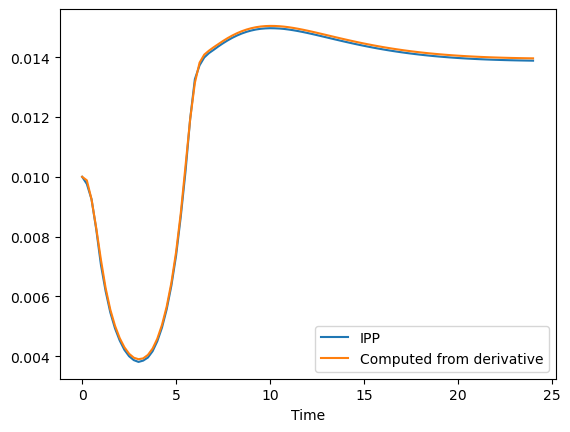

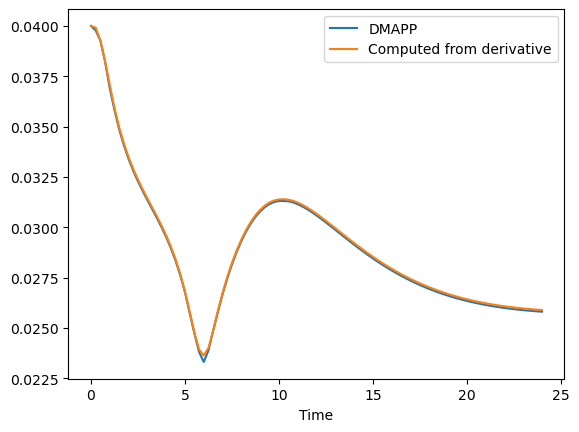

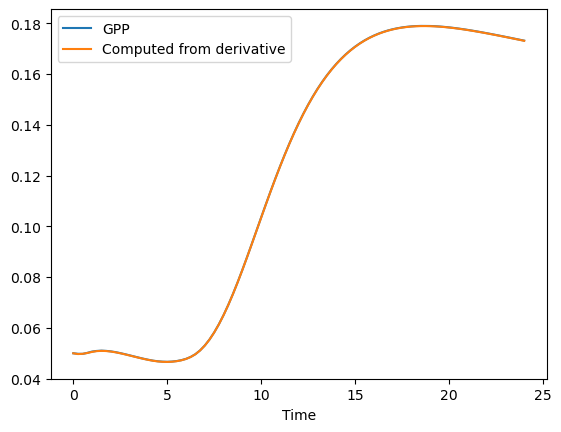

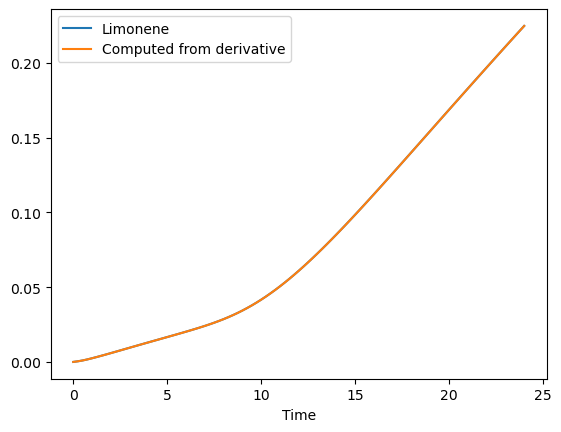

'Time profile from derivative vs. actual profile for Strain 2'

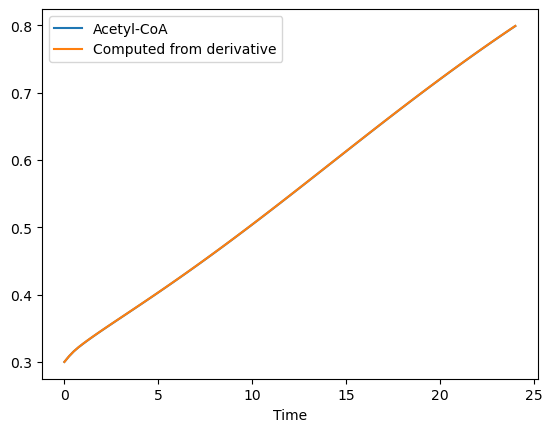

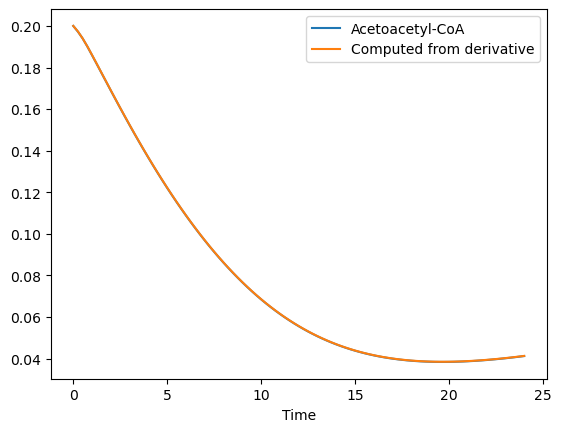

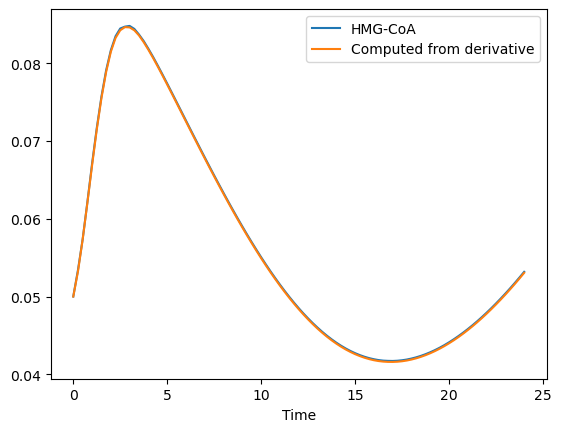

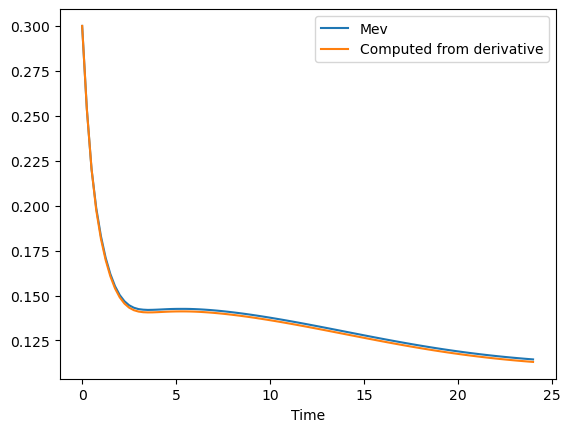

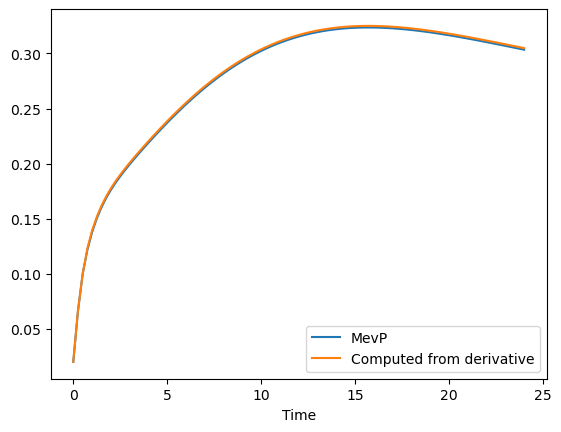

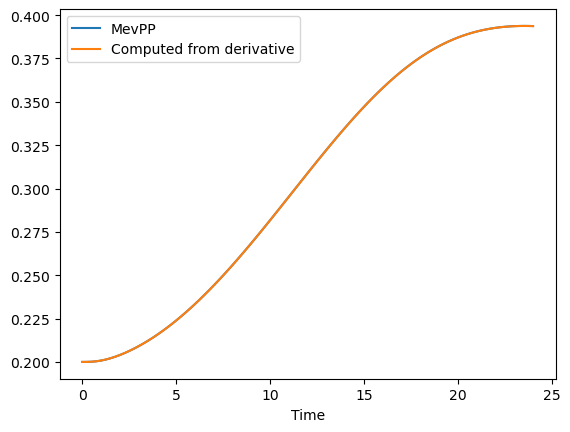

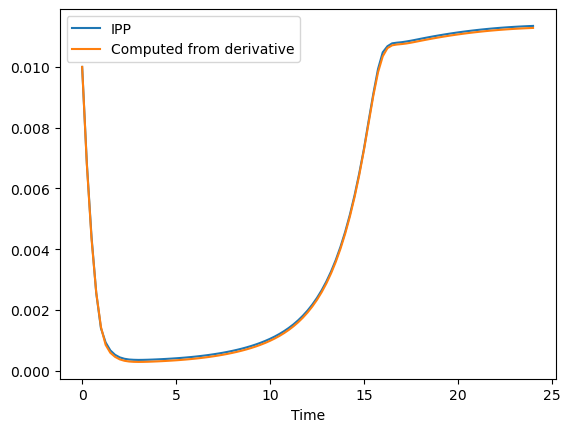

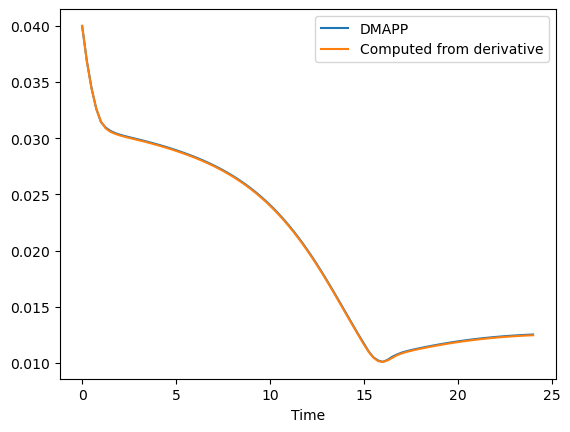

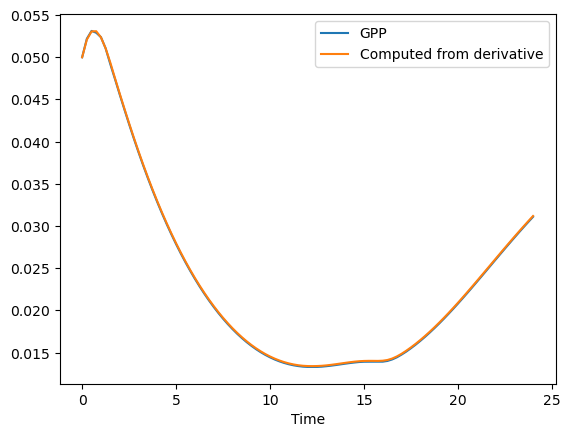

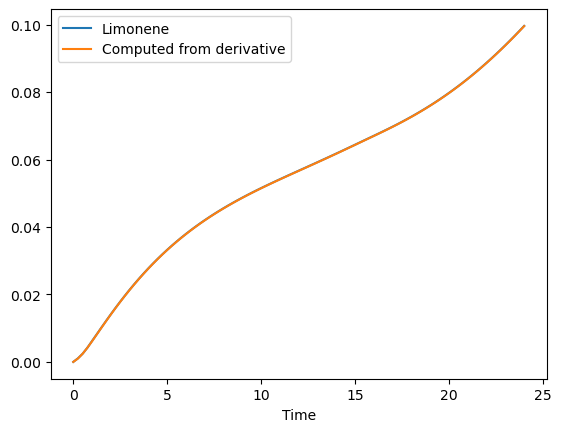

'Time profile from derivative vs. actual profile for Strain 3'

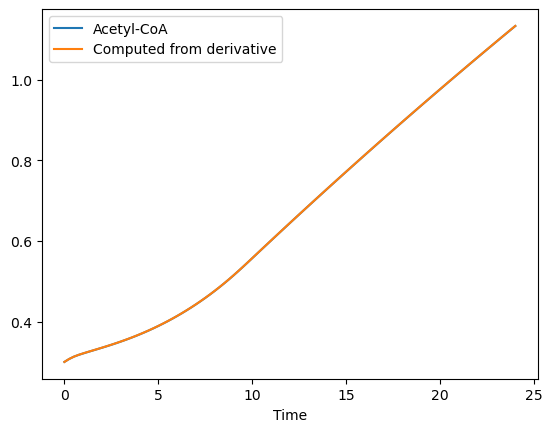

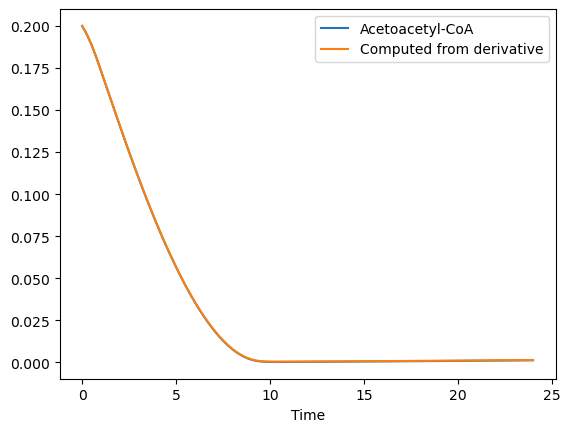

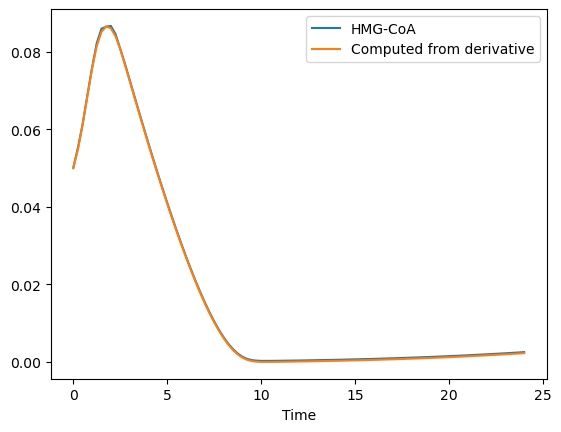

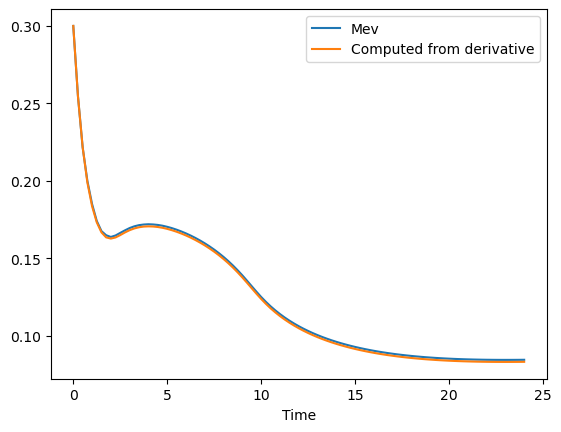

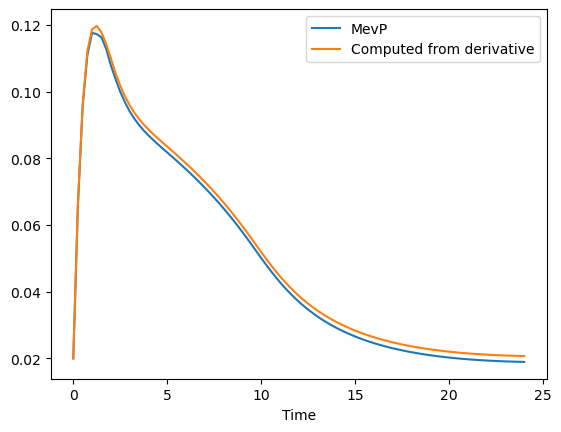

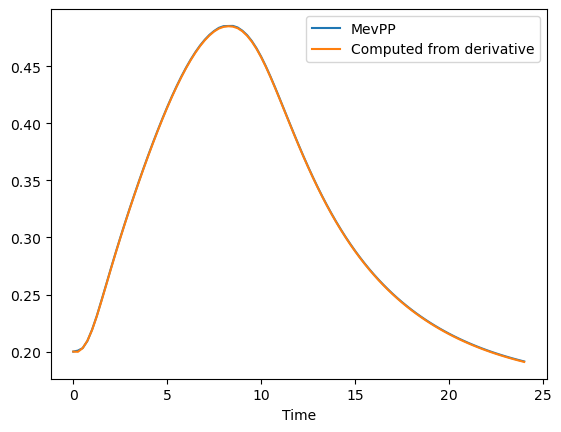

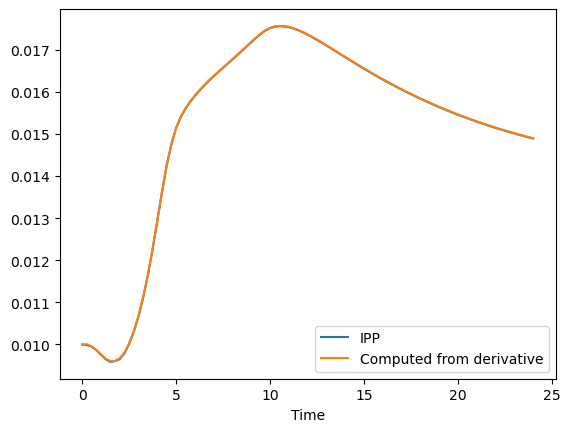

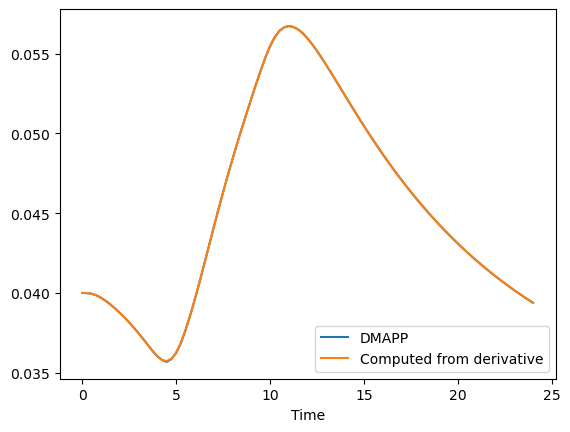

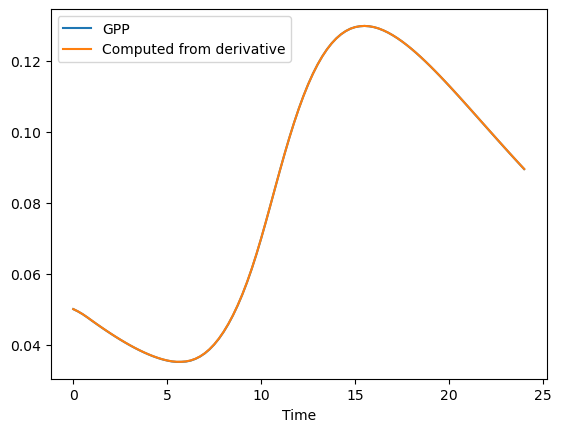

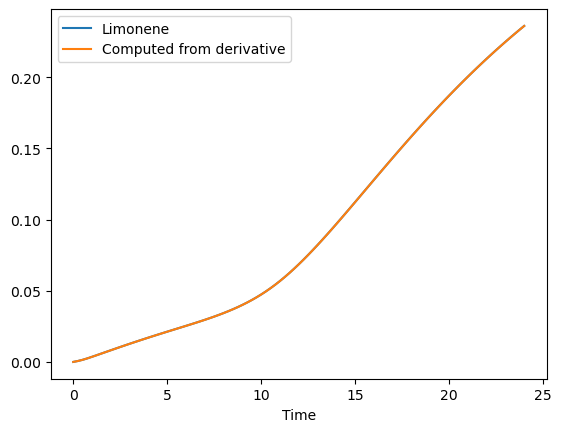

'Time profile from derivative vs. actual profile for WT'

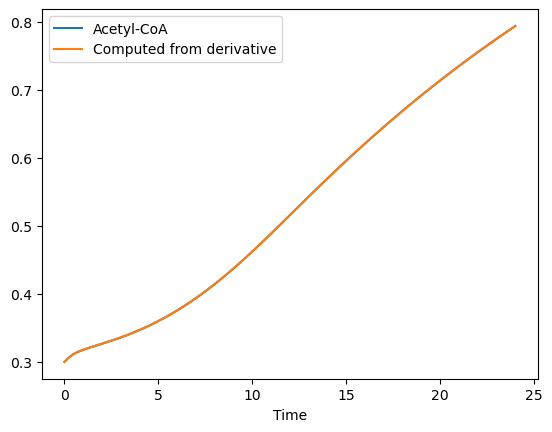

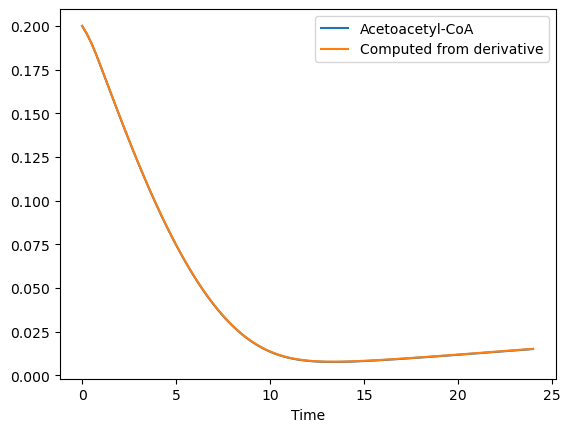

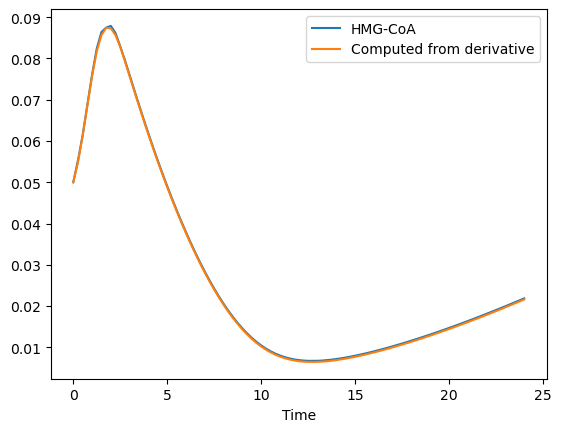

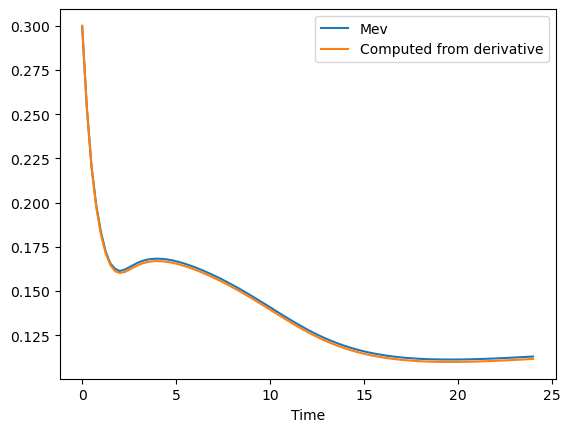

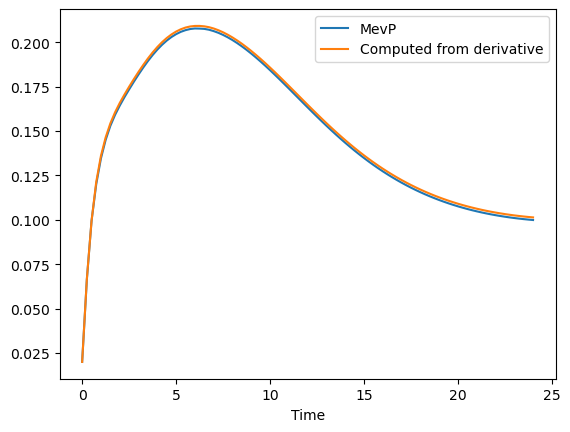

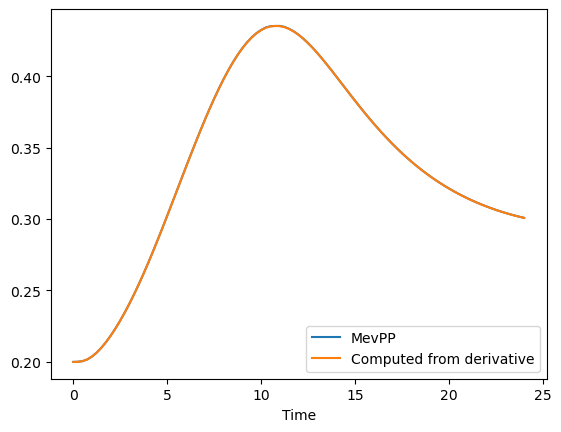

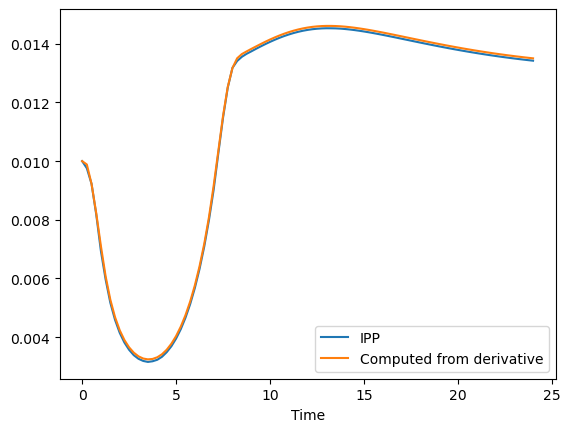

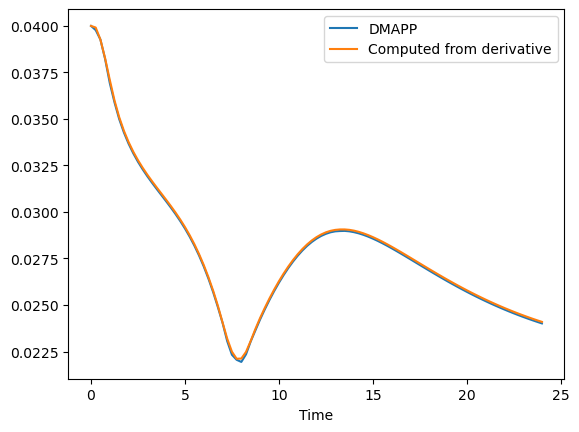

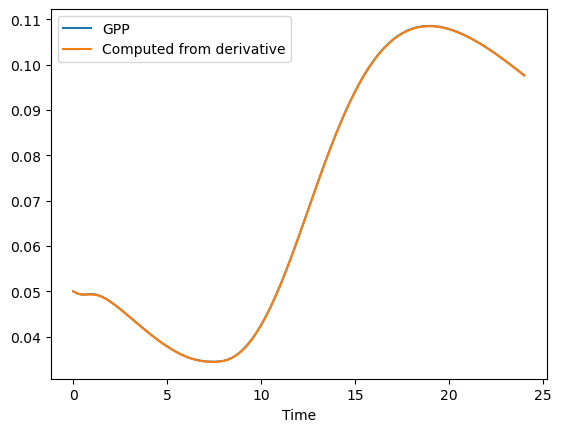

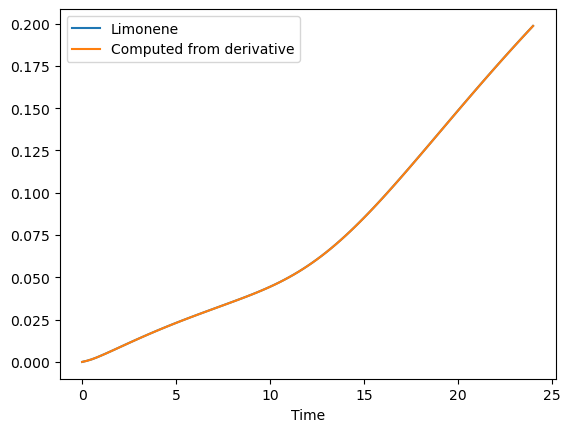

In [24]:
if inspectRate==True:
    from KineticLearning import check_derivative
    check_derivative(df_allSmooth)
    
#HC: synthetic data has sharp conc changes for HMG-CoA, Mev, IPP, DMAPP that are not well estimated by savgol filter 

# Prepare dataframes for model fitting (kr optimization)

enzymes, metabolites

Again:

measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase']

measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']

In [25]:
# 9 enzymes conc measurement used for fitting model
x_controls = [('controls',control) for control in measured_enzymes]
controls_df = df_allSmooth[x_controls] # dataframe format

# 10 substrates conc measurement used for fitting model
x_states = [('states',state) for state in measured_substrates]
states_df = df_allSmooth[x_states] # dataframe format

# merge enzymes & substrates measurement as single feature dataframe
features_df = pd.merge(controls_df, states_df,left_index=True, right_index=True,how='left')
print('Enzyme & metabolite timepoint data to be used for model fitting')
display (features_df) # check total no. time-series datapoints (all strains)

Enzyme & metabolite timepoint data to be used for model fitting


controls                                            \
                        AtoB          HMGS          HMGR            MK   
Strain   Time                                                            
Strain 1 0.00   5.946962e+01  3.973013e+01  3.696892e+01  5.762279e+01   
         0.25   3.589052e+06  2.111237e+06  2.008718e+05  1.311689e+06   
         0.50   5.471875e+06  3.482933e+06  3.394490e+05  2.217158e+06   
         0.75   5.865920e+06  4.166035e+06  4.191051e+05  2.738184e+06   
         1.00   6.072640e+06  4.609864e+06  4.740683e+05  3.097868e+06   
...                      ...           ...           ...           ...   
WT       23.00  2.729403e+06  2.685480e+06  1.768100e+06  2.009782e+06   
         23.25  2.729560e+06  2.686069e+06  1.768628e+06  2.010384e+06   
         23.50  2.729713e+06  2.686645e+06  1.769146e+06  2.010974e+06   
         23.75  2.729863e+06  2.687209e+06  1.769653e+06  2.011551e+06   
         24.00  2.730010e+06  2.687762e+06  1.770149e+06  2.012117e+06   

                                                                        \
                         PMK           PMD          GPPS           Idi   
Strain   Time                                                            
Strain 1 0.00   2.659959e+01  5.448132e+01  5.547215e+01  1.868778e+01   
         0.25   4.336546e+05  2.178306e+06  2.110608e+06  3.875298e+05   
         0.50   7.241324e+05  3.761395e+06  3.265182e+06  6.399929e+05   
         0.75   8.801888e+05  4.773919e+06  3.574431e+06  7.666082e+05   
         1.00   9.847275e+05  5.509792e+06  3.743605e+06  8.490980e+05   
...                      ...           ...           ...           ...   
WT       23.00  1.501640e+06  3.990692e+06  4.353803e+06  1.235104e+06   
         23.25  1.502026e+06  3.992254e+06  4.354150e+06  1.235378e+06   
         23.50  1.502403e+06  3.993784e+06  4.354490e+06  1.235647e+06   
         23.75  1.502773e+06  3.995283e+06  4.354822e+06  1.235910e+06   
         24.00  1.503135e+06  3.996752e+06  4.355148e+06  1.236168e+06   

                                     states                            \
               Limonene Synthase Acetyl-CoA Acetoacetyl-CoA   HMG-CoA   
Strain   Time                                                           
Strain 1 0.00       3.034108e+01   0.300000        0.200000  0.050000   
         0.25       1.700158e+05   0.299973        0.194624  0.058602   
         0.50       2.866143e+05   0.299893        0.188541  0.068037   
         0.75       3.527646e+05   0.295598        0.181565  0.080420   
         1.00       3.981392e+05   0.288190        0.174077  0.089557   
...                          ...        ...             ...       ...   
WT       23.00      1.468009e+06   0.775039        0.014167  0.019944   
         23.25      1.468435e+06   0.779833        0.014374  0.020413   
         23.50      1.468851e+06   0.784584        0.014581  0.020886   
         23.75      1.469260e+06   0.789290        0.014788  0.021362   
         24.00      1.469659e+06   0.793953        0.014996  0.021843   

                                                                            \
                     Mev      MevP     MevPP       IPP     DMAPP       GPP   
Strain   Time                                                                
Strain 1 0.00   0.300000  0.020000  0.200000  0.010000  0.040000  0.050000   
         0.25   0.252554  0.067099  0.200156  0.009761  0.039774  0.049802   
         0.50   0.218933  0.100735  0.200543  0.009250  0.039268  0.049773   
         0.75   0.196453  0.121374  0.201722  0.008244  0.038213  0.050161   
         1.00   0.183997  0.136357  0.203716  0.007056  0.036890  0.050678   
...                  ...       ...       ...       ...       ...       ...   
WT       23.00  0.112389  0.101024  0.304296  0.013499  0.024360  0.100867   
         23.25  0.112530  0.100700  0.303339  0.013479  0.024268  0.100090   
         23.50  0.112676  0.100406  0.302440  0.013460  0.024180 

rate of reaction

In [26]:
# get rate of reaction for selected metabolites
y_derivatives = [('derivatives',derivative) for derivative in measured_substrates]
y_derivatives_df=df_allSmooth[y_derivatives]

# print ('Sample size of X & y should match:')
# print ('Sample size of X:'+ str(features_df.shape[0])) # df is 'array-like' NOT list
# print ('Sample size of y:'+ str(y_derivatives_df.shape[0])+'\n----------------\n')

print('Rate of reaction time datapoints to be used for model fitting')
display (y_derivatives_df) # check total no. time-series datapoints (all strains), sld be SAME as features_df

Rate of reaction time datapoints to be used for model fitting


derivatives                                                \
                Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                              
Strain 1 0.00     0.013690       -0.018904  0.027176 -0.222785  0.222886   
         0.25    -0.001145       -0.023161  0.039481 -0.161460  0.157755   
         0.50    -0.012890       -0.026471  0.043928 -0.109410  0.106960   
         0.75    -0.021545       -0.028834  0.040518 -0.066636  0.070502   
         1.00    -0.028784       -0.030249  0.027513 -0.032895  0.049786   
...                    ...             ...       ...       ...       ...   
WT       23.00    0.019269        0.000828  0.001867  0.000553 -0.001354   
         23.25    0.019090        0.000828  0.001883  0.000573 -0.001236   
         23.50    0.018914        0.000829  0.001899  0.000590 -0.001124   
         23.75    0.018739        0.000829  0.001915  0.000607 -0.001016   
         24.00    0.018565        0.000829  0.001931  0.000621 -0.000913   

                                                                  
                   MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                     
Strain 1 0.00  -0.001006  0.000783  0.000992 -0.002212  0.001339  
         0.25   0.001066 -0.001721 -0.001670 -0.000263  0.002004  
         0.50   0.003438 -0.003397 -0.003536  0.001029  0.002540  
         0.75   0.006111 -0.004247 -0.004605  0.001664  0.002949  
         1.00   0.009363 -0.004243 -0.004909  0.001653  0.003235  
...                  ...       ...       ...       ...       ...  
WT       23.00 -0.003953 -0.000080 -0.000374 -0.003075  0.012221  
         23.25 -0.003710 -0.000078 -0.000361 -0.003143  0.012129  
         23.50 -0.003476 -0.000075 -0.000349 -0.003202  0.012034  
         23.75 -0.003251 -0.000072 -0.000337 -0.003253  0.011938  
         24.00 -0.003034 -0.000069 -0.000325 -0.003295  0.011840  

[388 rows x 10 columns]

# Prepare X, y for fitting

In [27]:
import random
random.seed(a='anyString')

# Get X,y for fitting
X=features_df.to_numpy() # dataframe to array
y=y_derivatives_df.to_numpy()


# Evaluate rate constants

In [28]:
# def kinetic_model(e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
#                   s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
#                   k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35, #HC: 12 
#                   k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65, #HC: 12
#                   k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3): #HC: 10
#     #HC: 53 parameters (9+10+12+12+10)
#     r1 = 10**Vin - ((10**k11) *e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)     
#     r2 = ((10**k11)*e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)
#     r3 = (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2) - (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35)
#     r4 = (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35) - (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) # k43*s6 NOT s5
#     r5 = (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) - (10**k51)*e5*s5 / ((10**k52) + s5) # k43*s6 NOT s5
#     r6 = (10**k51)*e5*s5 / ((10**k52) + s5) - (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65)
#     r7 = (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65) - (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#     r8 = (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#     r9 = (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8) - (10**k91)*e9*s9 / ((10**k92) + s9)
#     r10 = (10**k91)*e9*s9 / ((10**k92) + s9)
#     return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]


In [29]:
# def derivatives_error_fcn_gen(X, y):

#     """
#     Returns a defined function (NOT numerical value) 
#     that reports the error score for given set of model parameters as argument
#     """

#     # Convert array-like data to list for defining error function
#     XX = X.tolist() # order according to measured_enzymes, then measured_substrates
#     yy = y.tolist()
# #         print(str(len(X)))
# #         print(str(len(y)))        
# #         print ('Sample size of XX & yy should match:')
# #         print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
# #         print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


#     def kinetic_model(e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
#                       s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
#                       k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35, #HC: 12 
#                       k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65, #HC: 12
#                       k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3): #HC: 10
#         #HC: 53 parameters (9+10+12+12+10)
#         r1 = 10**Vin - ((10**k11) *e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)     
#         r2 = ((10**k11)*e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)
#         r3 = (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2) - (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35)
#         r4 = (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35) - (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) # k43*s6 NOT s5
#         r5 = (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) - (10**k51)*e5*s5 / ((10**k52) + s5) # k43*s6 NOT s5
#         r6 = (10**k51)*e5*s5 / ((10**k52) + s5) - (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65)
#         r7 = (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65) - (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#         r8 = (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#         r9 = (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8) - (10**k91)*e9*s9 / ((10**k92) + s9)
#         r10 = (10**k91)*e9*s9 / ((10**k92) + s9)
#         return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]

#     # THE FUNCTION BEING DEFINED & TO BE RETURNED
#     def derivatives_error_fcn(free_params):
#         # Error evaluation
#         derivatives_error = 0 # initialize
#         for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

#             # Prepare argument for 'model' function in the same order
#             params = []
#             params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
#             params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
#             params.extend(free_params)    # take in SAME argument values for free kinetic parameters

#             # Print the instances for each function call
#             '''
#             print('len x_val:' + str(len(x_val))+'\n')
#             print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
#             print('len y_vals:' + str(len(y_vals))+'\n')
#             print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
#             print ('len free_params:' + str(len(free_params))+'\n')
#             print ('len params:' + str(len(params))+'\n')
#             print (params)
#             '''

#             #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
#             #print (free_params)

#             ### Get list of predicted metabolite production rates for THE timepoint/strain  
#             mp = kinetic_model(*params)
#             prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
            
#             # Update total error between predicted & measured reaction rates
#             # by including error for current timepoint/strain
#             # Again, same free params value is used
#             #derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
#             derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
#         return derivatives_error # return numerical value

#     return derivatives_error_fcn


In [30]:
# ### Generate the error function with free parameters as sole argument
# #print ('Generating error_fcn...')
# error_fcn = derivatives_error_fcn_gen(X, y)
# #print ('Completed generating error_fcn.')

# ### Search for optimal free parameters
# # Note that derivatives_error_fcn is basis for objective search 
# # by returning error value for each set of proposed free parameter values

# # initiate reasonable bounds for all the free parameters
# bounds = [(0.0,9.0)]*32 + [(-1.30103,-1.301029)] + [(0.0,9.0)]
# print (bounds)

In [31]:
from pymoo.core.problem import ElementwiseProblem

class MyProblem(ElementwiseProblem):
    
    def __init__(self, **kwargs):
         super().__init__(n_var=36, # no. of free parameters
                         n_obj=1, # weighted squared error
                         n_ieq_constr=0, # no inequality
                         xl=np.array([ # exponent constants: +ve values bounded, -ve values taken care in eqns
                             -12.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0, 0.0,
                             0.0, 0.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0, 0.0,
                             0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0,
                             -1.30103]), # lower bounds
                         xu=np.array([
                             0.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0, 12.0,
                             12.0, 12.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0, 12.0,
                             12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0,
                             -1.301029]) # upper bounds
                        )
       
    def _kinetic_model(self,e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
                       s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
                       k11,k12,k13,
                       k21,k22,k23,k24,
                       k31,k32,k33,k34,k35, 
                       k41,k42,k43,k44,k45,
                       k51,k52,k53,
                       k61,k62,k63,k64,k65,
                       k71,k72,k73,
                       k81,k82,k83,k84,
                       k91,k92,k93,
                       Vin): #HC: 36

        r1 = (10**k11) *(e1**k12) *(s1**k13) # AtoB
        r2 = (10**k21) *(e2**k22) *(s1**k23) *(s2**k24) # HMGS
        r3 = (10**k31) *(e3**k32) *(s1**-k33) *(s2**-k34) *(s3**k35) # HMGR
        r4 = (10**k41) *(e4**k42) *(s4**k43) *(s9**-k44) *(s6**-k45) # MK
        r5 = (10**k51) *(e5**k52) *(s5**k53) # PMK
        r6 = (10**k61) *(e6**k62) *(s6**k63) *(s5**-k64) *(s4**-k65) # PMD
        r7 = (10**k71) *(e7**k72) *(s7**k73) # IDI
        r8 = (10**k81) *(e8**k82) *(s7**k83) *(s8**k84) # GPPS
        r9 = (10**k91) *(e9**k92) *(s9**k93) # LS
        r10 = 10**Vin # AcCoA supply

        # net metabolite turnover in Costello et al.
        rs1 = r10 - r1 - r2     
        rs2 = r1 - r2
        rs3 = r2 - r3
        rs4 = r3 - r4
        rs5 = r4 - r5
        rs6 = r5 - r6
        rs7 = r6 - r7 - r8
        rs8 = r7 - r8
        rs9 = r8 - r9
        rs10 = r9

        return [rs1,rs2,rs3,rs4,rs5,rs6,rs7,rs8,rs9,rs10]

        
    def _derivatives_error_fcn_gen(self, X, y):
        """
        Returns a defined function (NOT numerical value) 
        that reports the error score for given set of model parameters as argument
        X, y: for defining the function
        """

        # Convert array-like data to list for defining error function
        XX = X.tolist() # order according to measured_enzymes, then measured_substrates
        yy = y.tolist()
        #print(str(len(X)))
        #print(str(len(y)))        
        #print ('Sample size of XX & yy should match:')
        #print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
        #print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


        # THE FUNCTION BEING DEFINED & TO BE RETURNED
        def _derivatives_error_fcn(free_params):
            # Error evaluation
            derivatives_error = 0 # initialize
            count = 0
            for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

                # Prepare argument for 'model' function in the same order
                params = []
                params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
                params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
                params.extend(free_params)    # take in SAME argument values for free kinetic parameters

                # Print the instances for each function call
                '''
                print('len x_val:' + str(len(x_val))+'\n')
                print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
                print('len y_vals:' + str(len(y_vals))+'\n')
                print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
                print ('len free_params:' + str(len(free_params))+'\n')
                #print (free_params)
                print ('len params:' + str(len(params))+'\n')
                #print (params)
                '''

                #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
                #print (free_params)

                ### Get list of predicted metabolite production rates for THE timepoint/strain  
                mp = self._kinetic_model(*params)
                prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
                
                # Update total error between predicted & measured reaction rates
                # by including error for current timepoint/strain
                # Again, same free params value is used
                derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
                count = count + 1
                #derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
            MSE = (10**5)*derivatives_error/( count*len(prediction) )
            #print ('count: ' + str(count))
            return MSE #derivatives_error # return numerical value

        return _derivatives_error_fcn

    def _evaluate(self, x, out, *args, **kwargs):
        '''
        x: one-dimensional NumPy array of length n_var, i.e., 34 kr parameter values
        '''
        
        #print ('no. x' + str( len(x) ) )
        #print (x)

        #print (len(X))
        #print (X)
        #print (len(y))
        #print (y)
        self._derivatives_error_fcn = self._derivatives_error_fcn_gen(X, y)
        f = self._derivatives_error_fcn(x) # objective error func
        out["F"] = [f] 


In [32]:
import multiprocessing
from pymoo.core.problem import StarmapParallelization

n_cores = 4
pool = multiprocessing.Pool(n_cores)
runner = StarmapParallelization(pool.starmap)
problem=MyProblem(elementwise_runner=runner)


# --- Optimization algorithm

In [33]:
algo = 'SRES'

from pymoo.operators.sampling.lhs import LHS
if algo == 'SRES':
    from pymoo.algorithms.soo.nonconvex.sres import SRES
    algorithm = SRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'CMAES':
    from pymoo.algorithms.soo.nonconvex.cmaes import CMAES
    algorithm = CMAES(popsize=64)
elif algo == 'DE':
    from pymoo.algorithms.soo.nonconvex.de import DE
    algorithm = DE(pop_size=64, sampling=LHS(),
    variant="DE/rand/1/bin", CR=0.3, 
    dither="vector", jitter=False)
elif algo == 'ISRES':
    from pymoo.algorithms.soo.nonconvex.isres import ISRES
    algorithm = ISRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'G3PCX':
    from pymoo.algorithms.soo.nonconvex.g3pcx import G3PCX
    algorithm = G3PCX(pop_size=64,sampling=LHS())
else:
    print ('No such algo: ' + algo + '\n')
    
from pymoo.termination import get_termination
termination = get_termination("n_gen", 1e5)

In [34]:
# Callback function to update f_min_log during optimization
f_min_log = []

def callback(res):
     f_min_log.append(res.opt.get("F").min())

from pymoo.optimize import minimize
print ('Algorithm in use: ' + algo + '\n')
res = minimize(problem,
               algorithm,
               termination,
               callback=callback,
               seed=10,
               verbose=True)

print('Time required:', res.exec_time)
pool.close()
print("Best solution found: \nX = %s\nF = %s\nCV = %s" % (res.X, res.F, res.CV))

Algorithm in use: SRES

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | 2.082153E+180 | 1.178696E+108
     2 |       74 | 6.261413E+117 | 3.457341E+106
     3 |      138 | 4.022477E+105 |  3.640496E+86
     4 |      202 |  5.682992E+95 |  5.467294E+77
     5 |      266 |  8.030140E+84 |  9.755952E+71
     6 |      330 |  1.270265E+74 |  1.202050E+61
     7 |      394 |  3.448440E+74 |  9.443951E+55
     8 |      458 |  1.451988E+61 |  7.781157E+50
     9 |      522 |  1.203225E+54 |  5.443563E+46
    10 |      586 |  3.014093E+52 |  2.665253E+42
    11 |      650 |  1.249835E+46 |  2.037642E+38
    12 |      714 |  1.415121E+47 |  3.044931E+36
    13 |      778 |  7.823003E+43 |  5.718722E+31
    14 |      842 |  7.921645E+39 |  6.843798E+29
    15 |      906 |  2.133397E+38 |  1.837871E+29
    16 |      970 |  5.508016E+35 |  1.837871E+29
    17 |     1034 |  2.827958E+35 |  3.018943E+27
    18 |     1098 |  3.638268E+29 |  4.283887E+20
    19 |     1162 |  9.488

   162 |    10314 |  2.066512E+01 |  1.768130E+01
   163 |    10378 |  2.050589E+01 |  1.768130E+01
   164 |    10442 |  2.010721E+01 |  1.768130E+01
   165 |    10506 |  2.033139E+01 |  1.768130E+01
   166 |    10570 |  2.023351E+01 |  1.768130E+01
   167 |    10634 |  1.940127E+01 |  1.683204E+01
   168 |    10698 |  2.019278E+01 |  1.683204E+01
   169 |    10762 |  1.968664E+01 |  1.683204E+01
   170 |    10826 |  1.890150E+01 |  1.683204E+01
   171 |    10890 |  2.112112E+01 |  1.683204E+01
   172 |    10954 |  1.957243E+01 |  1.595558E+01
   173 |    11018 |  1.925712E+01 |  1.595558E+01
   174 |    11082 |  1.874033E+01 |  1.595558E+01
   175 |    11146 |  1.860913E+01 |  1.595558E+01
   176 |    11210 |  1.937968E+01 |  1.595558E+01
   177 |    11274 |  1.928008E+01 |  1.595558E+01
   178 |    11338 |  1.971688E+01 |  1.595558E+01
   179 |    11402 |  1.912757E+01 |  1.595558E+01
   180 |    11466 |  1.954441E+01 |  1.595558E+01
   181 |    11530 |  1.959903E+01 |  1.595558E+01


   326 |    20810 |  1.292562E+01 |  9.4952841082
   327 |    20874 |  1.273002E+01 |  9.4952841082
   328 |    20938 |  1.273076E+01 |  9.4952841082
   329 |    21002 |  1.271566E+01 |  9.4952841082
   330 |    21066 |  1.270938E+01 |  9.4952841082
   331 |    21130 |  1.249221E+01 |  9.4952841082
   332 |    21194 |  1.250448E+01 |  9.4952841082
   333 |    21258 |  1.255532E+01 |  9.4952841082
   334 |    21322 |  1.253714E+01 |  9.4952841082
   335 |    21386 |  1.273714E+01 |  9.4952841082
   336 |    21450 |  1.305894E+01 |  9.4952841082
   337 |    21514 |  1.298067E+01 |  9.4952841082
   338 |    21578 |  1.294854E+01 |  9.4952841082
   339 |    21642 |  1.315109E+01 |  9.4952841082
   340 |    21706 |  1.299710E+01 |  9.4952841082
   341 |    21770 |  1.287259E+01 |  9.4952841082
   342 |    21834 |  1.297942E+01 |  9.4952841082
   343 |    21898 |  1.278306E+01 |  9.4952841082
   344 |    21962 |  1.272377E+01 |  9.4952841082
   345 |    22026 |  1.270816E+01 |  9.4952841082


   490 |    31306 |  1.068042E+01 |  9.0954586026
   491 |    31370 |  1.073491E+01 |  9.0954586026
   492 |    31434 |  1.051225E+01 |  9.0954586026
   493 |    31498 |  9.9403116446 |  9.0954586026
   494 |    31562 |  1.022940E+01 |  9.0954586026
   495 |    31626 |  1.018676E+01 |  9.0954586026
   496 |    31690 |  1.031820E+01 |  9.0954586026
   497 |    31754 |  1.038275E+01 |  9.0954586026
   498 |    31818 |  1.019571E+01 |  9.0954586026
   499 |    31882 |  1.002662E+01 |  9.0255959587
   500 |    31946 |  1.023009E+01 |  9.0255959587
   501 |    32010 |  9.7532748329 |  9.0255959587
   502 |    32074 |  9.8138550956 |  9.0255959587
   503 |    32138 |  9.7758107390 |  9.0255959587
   504 |    32202 |  9.8323364987 |  9.0255959587
   505 |    32266 |  9.6865073626 |  9.0255959587
   506 |    32330 |  9.7573466708 |  9.0255959587
   507 |    32394 |  1.006093E+01 |  9.0255959587
   508 |    32458 |  1.030295E+01 |  9.0255959587
   509 |    32522 |  9.8892027166 |  9.0255959587


   654 |    41802 |  7.0944843566 |  6.8448927145
   655 |    41866 |  7.0808021492 |  6.8448927145
   656 |    41930 |  7.0570483935 |  6.8448927145
   657 |    41994 |  6.9756335825 |  6.8185911641
   658 |    42058 |  6.9866078745 |  6.8185911641
   659 |    42122 |  6.9296159697 |  6.7724645264
   660 |    42186 |  6.9528052256 |  6.7724645264
   661 |    42250 |  7.0091580222 |  6.7724645264
   662 |    42314 |  6.9934771320 |  6.7724645264
   663 |    42378 |  6.9439769779 |  6.7724645264
   664 |    42442 |  7.0054355542 |  6.7724645264
   665 |    42506 |  6.9853834556 |  6.7724645264
   666 |    42570 |  6.9864831942 |  6.7724645264
   667 |    42634 |  7.0173401400 |  6.7724645264
   668 |    42698 |  6.9627726095 |  6.7724645264
   669 |    42762 |  6.9972697995 |  6.7724645264
   670 |    42826 |  6.9966770852 |  6.7724645264
   671 |    42890 |  6.9547015367 |  6.7724645264
   672 |    42954 |  7.0557021221 |  6.7724645264
   673 |    43018 |  6.9583335973 |  6.7724645264


   818 |    52298 |  5.6659560847 |  5.6418823757
   819 |    52362 |  5.6623843891 |  5.6418823757
   820 |    52426 |  5.6580156124 |  5.6418823757
   821 |    52490 |  5.6592829123 |  5.6418823757
   822 |    52554 |  5.6598163792 |  5.6418823757
   823 |    52618 |  5.6603758959 |  5.6418823757
   824 |    52682 |  5.6638693661 |  5.6418823757
   825 |    52746 |  5.6557729219 |  5.6418823757
   826 |    52810 |  5.6515220612 |  5.6364991776
   827 |    52874 |  5.6470953706 |  5.6364991776
   828 |    52938 |  5.6457574386 |  5.6304831012
   829 |    53002 |  5.6488260632 |  5.6304831012
   830 |    53066 |  5.6536580843 |  5.6304831012
   831 |    53130 |  5.6517591305 |  5.6304831012
   832 |    53194 |  5.6463023931 |  5.6304831012
   833 |    53258 |  5.6408557434 |  5.6304831012
   834 |    53322 |  5.6418464001 |  5.6283925310
   835 |    53386 |  5.6431758933 |  5.6261296048
   836 |    53450 |  5.6348631074 |  5.6201855227
   837 |    53514 |  5.6315614202 |  5.6201855227


   982 |    62794 |  5.4360709500 |  5.4324015056
   983 |    62858 |  5.4348942968 |  5.4290804174
   984 |    62922 |  5.4331765355 |  5.4281421874
   985 |    62986 |  5.4313010024 |  5.4281367991
   986 |    63050 |  5.4302545292 |  5.4281367991
   987 |    63114 |  5.4315722884 |  5.4281367991
   988 |    63178 |  5.4317711404 |  5.4281367991
   989 |    63242 |  5.4300610671 |  5.4275964273
   990 |    63306 |  5.4294340664 |  5.4274435651
   991 |    63370 |  5.4284019277 |  5.4252811103
   992 |    63434 |  5.4268325658 |  5.4226497575
   993 |    63498 |  5.4255916169 |  5.4226497575
   994 |    63562 |  5.4261284936 |  5.4226497575
   995 |    63626 |  5.4241738424 |  5.4225542258
   996 |    63690 |  5.4246559443 |  5.4215835200
   997 |    63754 |  5.4228854741 |  5.4199292967
   998 |    63818 |  5.4218196150 |  5.4199292967
   999 |    63882 |  5.4214784584 |  5.4199292967
  1000 |    63946 |  5.4207608156 |  5.4154350790
  1001 |    64010 |  5.4195181913 |  5.4154350790


  1146 |    73290 |  5.2573615223 |  5.2534454768
  1147 |    73354 |  5.2526953489 |  5.2465580499
  1148 |    73418 |  5.2514077224 |  5.2465580499
  1149 |    73482 |  5.2468377532 |  5.2405620149
  1150 |    73546 |  5.2427831208 |  5.2320366768
  1151 |    73610 |  5.2360593849 |  5.2277817298
  1152 |    73674 |  5.2341022391 |  5.2273774130
  1153 |    73738 |  5.2324271328 |  5.2266890148
  1154 |    73802 |  5.2287343055 |  5.2210924785
  1155 |    73866 |  5.2266118986 |  5.2178253725
  1156 |    73930 |  5.2235905543 |  5.2178253725
  1157 |    73994 |  5.2197151501 |  5.2146812652
  1158 |    74058 |  5.2205744952 |  5.2146812652
  1159 |    74122 |  5.2192284689 |  5.2131375058
  1160 |    74186 |  5.2135722605 |  5.2072580407
  1161 |    74250 |  5.2122023680 |  5.2018252152
  1162 |    74314 |  5.2056317790 |  5.1977096203
  1163 |    74378 |  5.2006241346 |  5.1924953406
  1164 |    74442 |  5.1971301286 |  5.1912131780
  1165 |    74506 |  5.1926787446 |  5.1764507061


  1310 |    83786 |  4.2928601120 |  4.2910130695
  1311 |    83850 |  4.2916885928 |  4.2877142917
  1312 |    83914 |  4.2902054130 |  4.2867011761
  1313 |    83978 |  4.2877576544 |  4.2828470942
  1314 |    84042 |  4.2856433989 |  4.2815277095
  1315 |    84106 |  4.2849056138 |  4.2812768822
  1316 |    84170 |  4.2821401355 |  4.2785036514
  1317 |    84234 |  4.2798901434 |  4.2727204291
  1318 |    84298 |  4.2747728649 |  4.2701026502
  1319 |    84362 |  4.2755712566 |  4.2701026502
  1320 |    84426 |  4.2741772756 |  4.2691207060
  1321 |    84490 |  4.2706952249 |  4.2643737559
  1322 |    84554 |  4.2683720128 |  4.2608788282
  1323 |    84618 |  4.2675795086 |  4.2608788282
  1324 |    84682 |  4.2659672378 |  4.2592926101
  1325 |    84746 |  4.2644088968 |  4.2592926101
  1326 |    84810 |  4.2635720262 |  4.2467386501
  1327 |    84874 |  4.2556745895 |  4.2467386501
  1328 |    84938 |  4.2559374436 |  4.2467386501
  1329 |    85002 |  4.2550538438 |  4.2467386501


  1474 |    94282 |  3.8450179901 |  3.8389687078
  1475 |    94346 |  3.8443923252 |  3.8384440812
  1476 |    94410 |  3.8410511155 |  3.8335164229
  1477 |    94474 |  3.8393499028 |  3.8335164229
  1478 |    94538 |  3.8333651231 |  3.8240909865
  1479 |    94602 |  3.8291193136 |  3.8240909865
  1480 |    94666 |  3.8297063401 |  3.8240909865
  1481 |    94730 |  3.8251953449 |  3.8202297208
  1482 |    94794 |  3.8223271783 |  3.8143762970
  1483 |    94858 |  3.8180860556 |  3.8133115397
  1484 |    94922 |  3.8158521678 |  3.8100412451
  1485 |    94986 |  3.8169674096 |  3.8100412451
  1486 |    95050 |  3.8153246202 |  3.8042376906
  1487 |    95114 |  3.8099457542 |  3.7987038964
  1488 |    95178 |  3.8052482490 |  3.7987038964
  1489 |    95242 |  3.8022917366 |  3.7949996668
  1490 |    95306 |  3.7999902158 |  3.7941194289
  1491 |    95370 |  3.7964843332 |  3.7916887418
  1492 |    95434 |  3.7948484546 |  3.7916887418
  1493 |    95498 |  3.7921349663 |  3.7865334950


  1638 |   104778 |  3.3862166749 |  3.3813555543
  1639 |   104842 |  3.3845868515 |  3.3808377023
  1640 |   104906 |  3.3817405945 |  3.3772746785
  1641 |   104970 |  3.3790889143 |  3.3745334132
  1642 |   105034 |  3.3785988501 |  3.3733524462
  1643 |   105098 |  3.3769103250 |  3.3733524462
  1644 |   105162 |  3.3757970458 |  3.3713161566
  1645 |   105226 |  3.3724056772 |  3.3680220185
  1646 |   105290 |  3.3730825999 |  3.3680220185
  1647 |   105354 |  3.3709246448 |  3.3658293103
  1648 |   105418 |  3.3699885796 |  3.3658293103
  1649 |   105482 |  3.3704772509 |  3.3658293103
  1650 |   105546 |  3.3706718129 |  3.3658293103
  1651 |   105610 |  3.3662866240 |  3.3645797589
  1652 |   105674 |  3.3678153326 |  3.3645797589
  1653 |   105738 |  3.3647869915 |  3.3619412819
  1654 |   105802 |  3.3630273715 |  3.3605225678
  1655 |   105866 |  3.3630550455 |  3.3605225678
  1656 |   105930 |  3.3635271013 |  3.3605225678
  1657 |   105994 |  3.3621677072 |  3.3597651025


  1802 |   115274 |  3.1251707438 |  3.1214545005
  1803 |   115338 |  3.1271069524 |  3.1214545005
  1804 |   115402 |  3.1259020286 |  3.1214545005
  1805 |   115466 |  3.1238768545 |  3.1208392602
  1806 |   115530 |  3.1230625688 |  3.1199478162
  1807 |   115594 |  3.1222181355 |  3.1186303049
  1808 |   115658 |  3.1201821645 |  3.1175009287
  1809 |   115722 |  3.1193381734 |  3.1174565966
  1810 |   115786 |  3.1170027616 |  3.1138181362
  1811 |   115850 |  3.1170721939 |  3.1138181362
  1812 |   115914 |  3.1161283338 |  3.1138181362
  1813 |   115978 |  3.1144969134 |  3.1122473880
  1814 |   116042 |  3.1134156118 |  3.1115576651
  1815 |   116106 |  3.1119966454 |  3.1102847130
  1816 |   116170 |  3.1102416203 |  3.1080238662
  1817 |   116234 |  3.1081342122 |  3.1046157247
  1818 |   116298 |  3.1064510553 |  3.1037488340
  1819 |   116362 |  3.1054903895 |  3.1037488340
  1820 |   116426 |  3.1044867885 |  3.1011046203
  1821 |   116490 |  3.1025372877 |  3.1007451182


  1966 |   125770 |  2.9870734521 |  2.9855343403
  1967 |   125834 |  2.9863033909 |  2.9850510428
  1968 |   125898 |  2.9858086769 |  2.9835309456
  1969 |   125962 |  2.9847285555 |  2.9835309456
  1970 |   126026 |  2.9837692391 |  2.9831238014
  1971 |   126090 |  2.9836367630 |  2.9825823071
  1972 |   126154 |  2.9834363823 |  2.9818350944
  1973 |   126218 |  2.9829380978 |  2.9805653005
  1974 |   126282 |  2.9810317811 |  2.9795177167
  1975 |   126346 |  2.9799132401 |  2.9786429928
  1976 |   126410 |  2.9792948042 |  2.9780982699
  1977 |   126474 |  2.9787007616 |  2.9776479510
  1978 |   126538 |  2.9778976725 |  2.9771391492
  1979 |   126602 |  2.9775621185 |  2.9765876331
  1980 |   126666 |  2.9770199732 |  2.9760536676
  1981 |   126730 |  2.9761964032 |  2.9754345573
  1982 |   126794 |  2.9753217266 |  2.9746078802
  1983 |   126858 |  2.9746513004 |  2.9733175111
  1984 |   126922 |  2.9745990916 |  2.9733175111
  1985 |   126986 |  2.9740154167 |  2.9720057984


  2130 |   136266 |  2.7998397341 |  2.7986288030
  2131 |   136330 |  2.7991628216 |  2.7975589205
  2132 |   136394 |  2.7989590899 |  2.7975589205
  2133 |   136458 |  2.7982077306 |  2.7975488089
  2134 |   136522 |  2.7981782159 |  2.7971889976
  2135 |   136586 |  2.7982400199 |  2.7968286855
  2136 |   136650 |  2.7977671702 |  2.7956754640
  2137 |   136714 |  2.7977500482 |  2.7955694416
  2138 |   136778 |  2.7966599721 |  2.7947466491
  2139 |   136842 |  2.7955962388 |  2.7936160618
  2140 |   136906 |  2.7945968572 |  2.7919229919
  2141 |   136970 |  2.7934791022 |  2.7919229919
  2142 |   137034 |  2.7932694361 |  2.7908608864
  2143 |   137098 |  2.7922882769 |  2.7908608864
  2144 |   137162 |  2.7920411400 |  2.7905642365
  2145 |   137226 |  2.7921263816 |  2.7905642365
  2146 |   137290 |  2.7920868976 |  2.7905134270
  2147 |   137354 |  2.7918917373 |  2.7905134270
  2148 |   137418 |  2.7917294840 |  2.7905134270
  2149 |   137482 |  2.7910129187 |  2.7896291225


  2294 |   146762 |  2.6803224892 |  2.6762627839
  2295 |   146826 |  2.6784456173 |  2.6744928260
  2296 |   146890 |  2.6771901892 |  2.6744928260
  2297 |   146954 |  2.6765910732 |  2.6718617906
  2298 |   147018 |  2.6750908016 |  2.6718617906
  2299 |   147082 |  2.6744506578 |  2.6718617906
  2300 |   147146 |  2.6741677016 |  2.6718617906
  2301 |   147210 |  2.6734874579 |  2.6718617906
  2302 |   147274 |  2.6732766744 |  2.6718617906
  2303 |   147338 |  2.6725942792 |  2.6699352518
  2304 |   147402 |  2.6708010367 |  2.6672573589
  2305 |   147466 |  2.6691673895 |  2.6666844904
  2306 |   147530 |  2.6689654343 |  2.6654164255
  2307 |   147594 |  2.6691068929 |  2.6654164255
  2308 |   147658 |  2.6683691577 |  2.6654164255
  2309 |   147722 |  2.6679284938 |  2.6654164255
  2310 |   147786 |  2.6664342915 |  2.6649032198
  2311 |   147850 |  2.6648034027 |  2.6617743303
  2312 |   147914 |  2.6635612140 |  2.6617743303
  2313 |   147978 |  2.6626939853 |  2.6613522269


  2458 |   157258 |  2.5751681782 |  2.5735493667
  2459 |   157322 |  2.5743391303 |  2.5735493667
  2460 |   157386 |  2.5737489196 |  2.5727744264
  2461 |   157450 |  2.5727621837 |  2.5712588565
  2462 |   157514 |  2.5720179157 |  2.5704764764
  2463 |   157578 |  2.5701160659 |  2.5690719127
  2464 |   157642 |  2.5690799492 |  2.5672581559
  2465 |   157706 |  2.5677442385 |  2.5664759919
  2466 |   157770 |  2.5666604247 |  2.5644311103
  2467 |   157834 |  2.5652481222 |  2.5631953650
  2468 |   157898 |  2.5645580485 |  2.5631953650
  2469 |   157962 |  2.5626893483 |  2.5597756757
  2470 |   158026 |  2.5606479304 |  2.5590066607
  2471 |   158090 |  2.5587238941 |  2.5575640023
  2472 |   158154 |  2.5577034604 |  2.5562804097
  2473 |   158218 |  2.5558952942 |  2.5540832692
  2474 |   158282 |  2.5543744982 |  2.5508104588
  2475 |   158346 |  2.5532189251 |  2.5508104588
  2476 |   158410 |  2.5522142858 |  2.5508104588
  2477 |   158474 |  2.5506439152 |  2.5495202668


  2622 |   167754 |  2.4376632685 |  2.4372066704
  2623 |   167818 |  2.4371151328 |  2.4367002160
  2624 |   167882 |  2.4371247419 |  2.4365147683
  2625 |   167946 |  2.4366374273 |  2.4359910261
  2626 |   168010 |  2.4362946729 |  2.4354885193
  2627 |   168074 |  2.4355056187 |  2.4349827780
  2628 |   168138 |  2.4352922888 |  2.4348609211
  2629 |   168202 |  2.4349265100 |  2.4340477933
  2630 |   168266 |  2.4343910984 |  2.4334966961
  2631 |   168330 |  2.4340791656 |  2.4334966961
  2632 |   168394 |  2.4337898306 |  2.4332087662
  2633 |   168458 |  2.4337826946 |  2.4323555738
  2634 |   168522 |  2.4330972348 |  2.4323555738
  2635 |   168586 |  2.4327408147 |  2.4316052817
  2636 |   168650 |  2.4318308198 |  2.4312512940
  2637 |   168714 |  2.4311200921 |  2.4303933078
  2638 |   168778 |  2.4309822205 |  2.4301962380
  2639 |   168842 |  2.4307753894 |  2.4300240995
  2640 |   168906 |  2.4300340656 |  2.4296042832
  2641 |   168970 |  2.4298022270 |  2.4292805647


  2786 |   178250 |  2.3522561936 |  2.3509234250
  2787 |   178314 |  2.3519241324 |  2.3499854983
  2788 |   178378 |  2.3512860446 |  2.3495924661
  2789 |   178442 |  2.3507822242 |  2.3487899471
  2790 |   178506 |  2.3500106818 |  2.3475729033
  2791 |   178570 |  2.3491387100 |  2.3475729033
  2792 |   178634 |  2.3475758253 |  2.3453652558
  2793 |   178698 |  2.3458522454 |  2.3446902020
  2794 |   178762 |  2.3446473579 |  2.3428673032
  2795 |   178826 |  2.3435318437 |  2.3421107552
  2796 |   178890 |  2.3419478178 |  2.3397314293
  2797 |   178954 |  2.3409020585 |  2.3397314293
  2798 |   179018 |  2.3395407675 |  2.3380273071
  2799 |   179082 |  2.3386163571 |  2.3378553118
  2800 |   179146 |  2.3372522226 |  2.3360536050
  2801 |   179210 |  2.3364163318 |  2.3352278028
  2802 |   179274 |  2.3355790221 |  2.3339956290
  2803 |   179338 |  2.3349720292 |  2.3339956290
  2804 |   179402 |  2.3343569066 |  2.3325919532
  2805 |   179466 |  2.3339920222 |  2.3325142536


  2950 |   188746 |  2.2675437887 |  2.2668282858
  2951 |   188810 |  2.2673465306 |  2.2668246868
  2952 |   188874 |  2.2671334906 |  2.2666822283
  2953 |   188938 |  2.2668227750 |  2.2661918146
  2954 |   189002 |  2.2666125119 |  2.2661918146
  2955 |   189066 |  2.2661144413 |  2.2653469592
  2956 |   189130 |  2.2657634410 |  2.2653469592
  2957 |   189194 |  2.2655564291 |  2.2651861134
  2958 |   189258 |  2.2653192843 |  2.2650028175
  2959 |   189322 |  2.2649464316 |  2.2644811379
  2960 |   189386 |  2.2648543817 |  2.2642353010
  2961 |   189450 |  2.2645537636 |  2.2639366276
  2962 |   189514 |  2.2643816391 |  2.2639366276
  2963 |   189578 |  2.2641343667 |  2.2632672913
  2964 |   189642 |  2.2637687660 |  2.2630696071
  2965 |   189706 |  2.2632272063 |  2.2622684307
  2966 |   189770 |  2.2627196950 |  2.2620841999
  2967 |   189834 |  2.2622774283 |  2.2618899768
  2968 |   189898 |  2.2624381115 |  2.2618899768
  2969 |   189962 |  2.2619701561 |  2.2613109713


  3114 |   199242 |  2.1953516708 |  2.1950298369
  3115 |   199306 |  2.1951733431 |  2.1947896617
  3116 |   199370 |  2.1949136298 |  2.1946236727
  3117 |   199434 |  2.1947589230 |  2.1944580328
  3118 |   199498 |  2.1945506058 |  2.1943341975
  3119 |   199562 |  2.1942863815 |  2.1938633306
  3120 |   199626 |  2.1940737238 |  2.1937568745
  3121 |   199690 |  2.1938784715 |  2.1936185649
  3122 |   199754 |  2.1935202038 |  2.1933226770
  3123 |   199818 |  2.1932719178 |  2.1930282474
  3124 |   199882 |  2.1930823429 |  2.1926934801
  3125 |   199946 |  2.1928061564 |  2.1921318366
  3126 |   200010 |  2.1925705141 |  2.1921318366
  3127 |   200074 |  2.1924527300 |  2.1919833842
  3128 |   200138 |  2.1922625007 |  2.1919833842
  3129 |   200202 |  2.1921807312 |  2.1917037796
  3130 |   200266 |  2.1919189736 |  2.1914305227
  3131 |   200330 |  2.1916373951 |  2.1910985389
  3132 |   200394 |  2.1914173011 |  2.1908843167
  3133 |   200458 |  2.1911622815 |  2.1907026402


  3278 |   209738 |  2.1518204874 |  2.1508764563
  3279 |   209802 |  2.1516017715 |  2.1508764563
  3280 |   209866 |  2.1514217215 |  2.1508764563
  3281 |   209930 |  2.1512466605 |  2.1506037108
  3282 |   209994 |  2.1510553983 |  2.1504258604
  3283 |   210058 |  2.1509254881 |  2.1495065918
  3284 |   210122 |  2.1502039052 |  2.1492275786
  3285 |   210186 |  2.1501733057 |  2.1492275786
  3286 |   210250 |  2.1501971332 |  2.1492275786
  3287 |   210314 |  2.1496979540 |  2.1492275786
  3288 |   210378 |  2.1498513299 |  2.1490395276
  3289 |   210442 |  2.1500671895 |  2.1490395276
  3290 |   210506 |  2.1499779421 |  2.1490395276
  3291 |   210570 |  2.1492382654 |  2.1484243927
  3292 |   210634 |  2.1486889286 |  2.1476929195
  3293 |   210698 |  2.1485389607 |  2.1476929195
  3294 |   210762 |  2.1482743344 |  2.1476929195
  3295 |   210826 |  2.1481879834 |  2.1476929195
  3296 |   210890 |  2.1482308182 |  2.1471286921
  3297 |   210954 |  2.1481361052 |  2.1471286921


  3442 |   220234 |  2.0830245191 |  2.0819237713
  3443 |   220298 |  2.0827531467 |  2.0817723104
  3444 |   220362 |  2.0823349073 |  2.0813810551
  3445 |   220426 |  2.0820378362 |  2.0803862903
  3446 |   220490 |  2.0814475281 |  2.0803862903
  3447 |   220554 |  2.0811978562 |  2.0803555333
  3448 |   220618 |  2.0808616016 |  2.0803555333
  3449 |   220682 |  2.0806889553 |  2.0796476745
  3450 |   220746 |  2.0798384269 |  2.0786954624
  3451 |   220810 |  2.0792530404 |  2.0784998973
  3452 |   220874 |  2.0791935246 |  2.0784998973
  3453 |   220938 |  2.0790173257 |  2.0780923683
  3454 |   221002 |  2.0786737461 |  2.0780923683
  3455 |   221066 |  2.0783517925 |  2.0780595774
  3456 |   221130 |  2.0780519222 |  2.0774315509
  3457 |   221194 |  2.0776951408 |  2.0774315509
  3458 |   221258 |  2.0776137913 |  2.0772265954
  3459 |   221322 |  2.0776665426 |  2.0772005694
  3460 |   221386 |  2.0773282223 |  2.0768488590
  3461 |   221450 |  2.0766400455 |  2.0751857404


  3606 |   230730 |  2.0228133676 |  2.0206452481
  3607 |   230794 |  2.0225895574 |  2.0197781203
  3608 |   230858 |  2.0218200921 |  2.0197781203
  3609 |   230922 |  2.0224895175 |  2.0197781203
  3610 |   230986 |  2.0215549692 |  2.0197781203
  3611 |   231050 |  2.0199266109 |  2.0176086604
  3612 |   231114 |  2.0199270282 |  2.0170317844
  3613 |   231178 |  2.0189797266 |  2.0162930226
  3614 |   231242 |  2.0180317612 |  2.0162930226
  3615 |   231306 |  2.0180562051 |  2.0153265179
  3616 |   231370 |  2.0178694631 |  2.0153265179
  3617 |   231434 |  2.0172937611 |  2.0149757196
  3618 |   231498 |  2.0170213982 |  2.0148832544
  3619 |   231562 |  2.0165363759 |  2.0143526093
  3620 |   231626 |  2.0159919824 |  2.0140629596
  3621 |   231690 |  2.0155184542 |  2.0134974136
  3622 |   231754 |  2.0146681510 |  2.0118107258
  3623 |   231818 |  2.0132497689 |  2.0109969211
  3624 |   231882 |  2.0129077930 |  2.0109969211
  3625 |   231946 |  2.0130021707 |  2.0109969211


  3770 |   241226 |  1.9674836481 |  1.9671747890
  3771 |   241290 |  1.9672531542 |  1.9668804383
  3772 |   241354 |  1.9672059581 |  1.9665499960
  3773 |   241418 |  1.9667881487 |  1.9661777551
  3774 |   241482 |  1.9664786721 |  1.9661777551
  3775 |   241546 |  1.9662361737 |  1.9658607643
  3776 |   241610 |  1.9662066625 |  1.9658607643
  3777 |   241674 |  1.9657912758 |  1.9654679485
  3778 |   241738 |  1.9657528447 |  1.9654153295
  3779 |   241802 |  1.9655421039 |  1.9652913206
  3780 |   241866 |  1.9651900379 |  1.9647566588
  3781 |   241930 |  1.9648565231 |  1.9646275725
  3782 |   241994 |  1.9645923046 |  1.9643764920
  3783 |   242058 |  1.9646844176 |  1.9643764920
  3784 |   242122 |  1.9646070243 |  1.9643764920
  3785 |   242186 |  1.9644384509 |  1.9642293113
  3786 |   242250 |  1.9641821344 |  1.9633903816
  3787 |   242314 |  1.9637787604 |  1.9632976949
  3788 |   242378 |  1.9635550221 |  1.9632976949
  3789 |   242442 |  1.9635495428 |  1.9630606398


  3934 |   251722 |  1.9301612933 |  1.9290576741
  3935 |   251786 |  1.9297173906 |  1.9287710379
  3936 |   251850 |  1.9291590268 |  1.9287710379
  3937 |   251914 |  1.9294446492 |  1.9287710379
  3938 |   251978 |  1.9289888990 |  1.9279709636
  3939 |   252042 |  1.9281257031 |  1.9273469604
  3940 |   252106 |  1.9278394793 |  1.9270182448
  3941 |   252170 |  1.9273312233 |  1.9269355567
  3942 |   252234 |  1.9270494453 |  1.9262441055
  3943 |   252298 |  1.9266239429 |  1.9253772433
  3944 |   252362 |  1.9260843986 |  1.9253772433
  3945 |   252426 |  1.9258835994 |  1.9253352653
  3946 |   252490 |  1.9255765789 |  1.9244249378
  3947 |   252554 |  1.9249796928 |  1.9244249378
  3948 |   252618 |  1.9246303923 |  1.9241582597
  3949 |   252682 |  1.9242783996 |  1.9237830643
  3950 |   252746 |  1.9241696053 |  1.9237830643
  3951 |   252810 |  1.9236952867 |  1.9228295656
  3952 |   252874 |  1.9234141432 |  1.9225799493
  3953 |   252938 |  1.9231854527 |  1.9225799493


  4098 |   262218 |  1.8758434776 |  1.8748553981
  4099 |   262282 |  1.8753485033 |  1.8741029078
  4100 |   262346 |  1.8746131787 |  1.8735316522
  4101 |   262410 |  1.8745946530 |  1.8734757589
  4102 |   262474 |  1.8739954737 |  1.8724284173
  4103 |   262538 |  1.8737990572 |  1.8724284173
  4104 |   262602 |  1.8727489640 |  1.8710065196
  4105 |   262666 |  1.8718575436 |  1.8707303122
  4106 |   262730 |  1.8714083779 |  1.8703854768
  4107 |   262794 |  1.8705486482 |  1.8699370075
  4108 |   262858 |  1.8699595893 |  1.8694465915
  4109 |   262922 |  1.8698664995 |  1.8689220249
  4110 |   262986 |  1.8696569806 |  1.8687115213
  4111 |   263050 |  1.8689530287 |  1.8676515902
  4112 |   263114 |  1.8687426029 |  1.8676515902
  4113 |   263178 |  1.8679766577 |  1.8666312026
  4114 |   263242 |  1.8673037582 |  1.8662988198
  4115 |   263306 |  1.8662993903 |  1.8654639722
  4116 |   263370 |  1.8659998670 |  1.8652317012
  4117 |   263434 |  1.8658530148 |  1.8649311865


  4262 |   272714 |  1.8225812204 |  1.8223073790
  4263 |   272778 |  1.8222425301 |  1.8220280784
  4264 |   272842 |  1.8220094922 |  1.8215751029
  4265 |   272906 |  1.8218558213 |  1.8215751029
  4266 |   272970 |  1.8219586591 |  1.8213690671
  4267 |   273034 |  1.8217242217 |  1.8211764126
  4268 |   273098 |  1.8215736191 |  1.8211764126
  4269 |   273162 |  1.8214879040 |  1.8207639559
  4270 |   273226 |  1.8212205130 |  1.8207537793
  4271 |   273290 |  1.8211516561 |  1.8206711230
  4272 |   273354 |  1.8208953620 |  1.8206331165
  4273 |   273418 |  1.8207155146 |  1.8206268007
  4274 |   273482 |  1.8206660157 |  1.8204724979
  4275 |   273546 |  1.8205387960 |  1.8203619824
  4276 |   273610 |  1.8205068769 |  1.8203519312
  4277 |   273674 |  1.8203231038 |  1.8201496239
  4278 |   273738 |  1.8202452203 |  1.8201496239
  4279 |   273802 |  1.8201618202 |  1.8199667540
  4280 |   273866 |  1.8200173260 |  1.8198224637
  4281 |   273930 |  1.8199546457 |  1.8198224637


  4426 |   283210 |  1.7938473748 |  1.7932771842
  4427 |   283274 |  1.7936753401 |  1.7931727846
  4428 |   283338 |  1.7932514539 |  1.7928096403
  4429 |   283402 |  1.7928450467 |  1.7924949835
  4430 |   283466 |  1.7924739806 |  1.7920685645
  4431 |   283530 |  1.7921779661 |  1.7919188061
  4432 |   283594 |  1.7920537197 |  1.7913847732
  4433 |   283658 |  1.7918032197 |  1.7913847732
  4434 |   283722 |  1.7916433041 |  1.7913012209
  4435 |   283786 |  1.7915666344 |  1.7908266795
  4436 |   283850 |  1.7913123098 |  1.7908266795
  4437 |   283914 |  1.7908533305 |  1.7901944946
  4438 |   283978 |  1.7904340742 |  1.7901944946
  4439 |   284042 |  1.7903737314 |  1.7900293709
  4440 |   284106 |  1.7902050697 |  1.7897875364
  4441 |   284170 |  1.7899923453 |  1.7893461051
  4442 |   284234 |  1.7893444853 |  1.7887264435
  4443 |   284298 |  1.7888327903 |  1.7884063594
  4444 |   284362 |  1.7887351225 |  1.7874264593
  4445 |   284426 |  1.7877631531 |  1.7867008717


  4590 |   293706 |  1.7015108336 |  1.7011654897
  4591 |   293770 |  1.7012200706 |  1.7008368289
  4592 |   293834 |  1.7008817892 |  1.7006074847
  4593 |   293898 |  1.7007288290 |  1.7005486370
  4594 |   293962 |  1.7006204132 |  1.7005114421
  4595 |   294026 |  1.7004608528 |  1.7003806380
  4596 |   294090 |  1.7004054730 |  1.7003219321
  4597 |   294154 |  1.7002562320 |  1.7001325518
  4598 |   294218 |  1.7001205075 |  1.6997699868
  4599 |   294282 |  1.6999307227 |  1.6997196318
  4600 |   294346 |  1.6997341591 |  1.6993905977
  4601 |   294410 |  1.6995654990 |  1.6992221238
  4602 |   294474 |  1.6993237971 |  1.6991710201
  4603 |   294538 |  1.6991092643 |  1.6989090207
  4604 |   294602 |  1.6988624267 |  1.6986476192
  4605 |   294666 |  1.6985417110 |  1.6983626178
  4606 |   294730 |  1.6982276124 |  1.6979948596
  4607 |   294794 |  1.6978595643 |  1.6975448924
  4608 |   294858 |  1.6974916965 |  1.6973020645
  4609 |   294922 |  1.6972846612 |  1.6970632959


  4754 |   304202 |  1.6615735779 |  1.6611523883
  4755 |   304266 |  1.6612638927 |  1.6610128910
  4756 |   304330 |  1.6610359533 |  1.6606085223
  4757 |   304394 |  1.6607195391 |  1.6603892331
  4758 |   304458 |  1.6605403716 |  1.6601512435
  4759 |   304522 |  1.6601901168 |  1.6597829002
  4760 |   304586 |  1.6599302474 |  1.6595643435
  4761 |   304650 |  1.6598540947 |  1.6595643435
  4762 |   304714 |  1.6596949611 |  1.6594137524
  4763 |   304778 |  1.6594578352 |  1.6590295337
  4764 |   304842 |  1.6593105993 |  1.6588982339
  4765 |   304906 |  1.6590212073 |  1.6588343334
  4766 |   304970 |  1.6588775298 |  1.6586664701
  4767 |   305034 |  1.6585144423 |  1.6579117267
  4768 |   305098 |  1.6582980864 |  1.6579117267
  4769 |   305162 |  1.6579781364 |  1.6575594255
  4770 |   305226 |  1.6577317229 |  1.6573741618
  4771 |   305290 |  1.6576164919 |  1.6573335764
  4772 |   305354 |  1.6573602319 |  1.6568971594
  4773 |   305418 |  1.6571033876 |  1.6565438293


  4918 |   314698 |  1.6330230077 |  1.6327556261
  4919 |   314762 |  1.6327553141 |  1.6320291815
  4920 |   314826 |  1.6324483702 |  1.6320291815
  4921 |   314890 |  1.6321791047 |  1.6315835467
  4922 |   314954 |  1.6318305733 |  1.6314005604
  4923 |   315018 |  1.6317123106 |  1.6314005604
  4924 |   315082 |  1.6315360907 |  1.6312641424
  4925 |   315146 |  1.6311158656 |  1.6305267331
  4926 |   315210 |  1.6307982491 |  1.6303606118
  4927 |   315274 |  1.6304964559 |  1.6300794367
  4928 |   315338 |  1.6299761289 |  1.6295983643
  4929 |   315402 |  1.6297375883 |  1.6291495566
  4930 |   315466 |  1.6294162068 |  1.6288681746
  4931 |   315530 |  1.6289489557 |  1.6286570855
  4932 |   315594 |  1.6283997512 |  1.6280994918
  4933 |   315658 |  1.6285997521 |  1.6279344997
  4934 |   315722 |  1.6283302666 |  1.6274968854
  4935 |   315786 |  1.6283031134 |  1.6274113955
  4936 |   315850 |  1.6279320897 |  1.6274113955
  4937 |   315914 |  1.6278007891 |  1.6272081458


  5082 |   325194 |  1.5900713079 |  1.5893132772
  5083 |   325258 |  1.5897214790 |  1.5891456442
  5084 |   325322 |  1.5894996186 |  1.5885223660
  5085 |   325386 |  1.5895789429 |  1.5882271234
  5086 |   325450 |  1.5893135140 |  1.5879731732
  5087 |   325514 |  1.5888653822 |  1.5877712177
  5088 |   325578 |  1.5885327813 |  1.5877712177
  5089 |   325642 |  1.5880544955 |  1.5871721777
  5090 |   325706 |  1.5871603365 |  1.5865802972
  5091 |   325770 |  1.5870412649 |  1.5864470374
  5092 |   325834 |  1.5870528124 |  1.5864470374
  5093 |   325898 |  1.5864198466 |  1.5857803421
  5094 |   325962 |  1.5860821848 |  1.5854694575
  5095 |   326026 |  1.5859353122 |  1.5854694575
  5096 |   326090 |  1.5854203841 |  1.5843996850
  5097 |   326154 |  1.5850887873 |  1.5841440136
  5098 |   326218 |  1.5845839910 |  1.5841440136
  5099 |   326282 |  1.5841861545 |  1.5836407298
  5100 |   326346 |  1.5838092107 |  1.5832636180
  5101 |   326410 |  1.5836272254 |  1.5832636180


  5246 |   335690 |  1.5627729699 |  1.5627277678
  5247 |   335754 |  1.5627700322 |  1.5626936252
  5248 |   335818 |  1.5627688047 |  1.5625725635
  5249 |   335882 |  1.5626186130 |  1.5625036385
  5250 |   335946 |  1.5625731005 |  1.5623383476
  5251 |   336010 |  1.5624738228 |  1.5623383476
  5252 |   336074 |  1.5624134671 |  1.5623383476
  5253 |   336138 |  1.5622751782 |  1.5621720176
  5254 |   336202 |  1.5622324639 |  1.5621508719
  5255 |   336266 |  1.5622090851 |  1.5620173087
  5256 |   336330 |  1.5620987912 |  1.5619560670
  5257 |   336394 |  1.5621149799 |  1.5618506230
  5258 |   336458 |  1.5619081329 |  1.5616285601
  5259 |   336522 |  1.5618604180 |  1.5615824699
  5260 |   336586 |  1.5617528723 |  1.5615824699
  5261 |   336650 |  1.5617253279 |  1.5615810891
  5262 |   336714 |  1.5617731980 |  1.5615695163
  5263 |   336778 |  1.5617208291 |  1.5615338981
  5264 |   336842 |  1.5616595658 |  1.5614594601
  5265 |   336906 |  1.5614835274 |  1.5611925970


  5410 |   346186 |  1.5481800006 |  1.5479498191
  5411 |   346250 |  1.5480987476 |  1.5479498191
  5412 |   346314 |  1.5480494822 |  1.5479498191
  5413 |   346378 |  1.5480221937 |  1.5479207715
  5414 |   346442 |  1.5479483738 |  1.5478139418
  5415 |   346506 |  1.5479045160 |  1.5477274904
  5416 |   346570 |  1.5478822765 |  1.5477274904
  5417 |   346634 |  1.5477761907 |  1.5476099084
  5418 |   346698 |  1.5475056540 |  1.5473334858
  5419 |   346762 |  1.5473667691 |  1.5472969402
  5420 |   346826 |  1.5472767139 |  1.5471029644
  5421 |   346890 |  1.5471629592 |  1.5470264346
  5422 |   346954 |  1.5470893919 |  1.5469158929
  5423 |   347018 |  1.5469474803 |  1.5468266862
  5424 |   347082 |  1.5468985727 |  1.5466974828
  5425 |   347146 |  1.5468065401 |  1.5466974828
  5426 |   347210 |  1.5466748993 |  1.5465447084
  5427 |   347274 |  1.5466350105 |  1.5465447084
  5428 |   347338 |  1.5465930391 |  1.5465251714
  5429 |   347402 |  1.5465384720 |  1.5464735443


  5574 |   356682 |  1.5274212458 |  1.5272027556
  5575 |   356746 |  1.5272589583 |  1.5270859093
  5576 |   356810 |  1.5272047575 |  1.5268642224
  5577 |   356874 |  1.5269726827 |  1.5267227730
  5578 |   356938 |  1.5266400585 |  1.5263901254
  5579 |   357002 |  1.5265564438 |  1.5263683950
  5580 |   357066 |  1.5262863072 |  1.5259561866
  5581 |   357130 |  1.5259969348 |  1.5257837540
  5582 |   357194 |  1.5259146698 |  1.5256578613
  5583 |   357258 |  1.5257939210 |  1.5256047907
  5584 |   357322 |  1.5257393983 |  1.5255772775
  5585 |   357386 |  1.5255991987 |  1.5250775419
  5586 |   357450 |  1.5251612334 |  1.5244315331
  5587 |   357514 |  1.5247668185 |  1.5242760360
  5588 |   357578 |  1.5242813214 |  1.5240391126
  5589 |   357642 |  1.5239733874 |  1.5236417426
  5590 |   357706 |  1.5237304634 |  1.5234208816
  5591 |   357770 |  1.5234234804 |  1.5228456599
  5592 |   357834 |  1.5231114025 |  1.5228362865
  5593 |   357898 |  1.5229654254 |  1.5227750288


  5738 |   367178 |  1.4963088793 |  1.4961363637
  5739 |   367242 |  1.4962742202 |  1.4960156719
  5740 |   367306 |  1.4961495348 |  1.4960156719
  5741 |   367370 |  1.4960201122 |  1.4959102243
  5742 |   367434 |  1.4959923495 |  1.4957988538
  5743 |   367498 |  1.4958303829 |  1.4956131244
  5744 |   367562 |  1.4958035145 |  1.4956131244
  5745 |   367626 |  1.4958154736 |  1.4956131244
  5746 |   367690 |  1.4957426021 |  1.4956131244
  5747 |   367754 |  1.4956600465 |  1.4954759827
  5748 |   367818 |  1.4955998430 |  1.4954724237
  5749 |   367882 |  1.4954457405 |  1.4953104956
  5750 |   367946 |  1.4954053039 |  1.4953104956
  5751 |   368010 |  1.4953353279 |  1.4951735822
  5752 |   368074 |  1.4952925979 |  1.4951020847
  5753 |   368138 |  1.4952318459 |  1.4951020847
  5754 |   368202 |  1.4952073995 |  1.4950661472
  5755 |   368266 |  1.4951391252 |  1.4949524557
  5756 |   368330 |  1.4951166078 |  1.4949524557
  5757 |   368394 |  1.4950203399 |  1.4948643912


  5902 |   377674 |  1.4722501796 |  1.4720764640
  5903 |   377738 |  1.4721883896 |  1.4720253335
  5904 |   377802 |  1.4720966390 |  1.4717778557
  5905 |   377866 |  1.4720381098 |  1.4716671288
  5906 |   377930 |  1.4718808564 |  1.4716565526
  5907 |   377994 |  1.4718134761 |  1.4715104959
  5908 |   378058 |  1.4717620569 |  1.4715104959
  5909 |   378122 |  1.4715464929 |  1.4714156931
  5910 |   378186 |  1.4714390744 |  1.4712323329
  5911 |   378250 |  1.4713433207 |  1.4711785153
  5912 |   378314 |  1.4713248083 |  1.4711346354
  5913 |   378378 |  1.4712201251 |  1.4711060365
  5914 |   378442 |  1.4711038514 |  1.4707269732
  5915 |   378506 |  1.4709108053 |  1.4707269732
  5916 |   378570 |  1.4707419361 |  1.4703969906
  5917 |   378634 |  1.4706743666 |  1.4703969906
  5918 |   378698 |  1.4704671718 |  1.4702187003
  5919 |   378762 |  1.4702520373 |  1.4700203364
  5920 |   378826 |  1.4701860647 |  1.4698325634
  5921 |   378890 |  1.4702042917 |  1.4695429459


  6066 |   388170 |  1.4510073380 |  1.4507752101
  6067 |   388234 |  1.4508916397 |  1.4505815188
  6068 |   388298 |  1.4507415584 |  1.4504554648
  6069 |   388362 |  1.4506476204 |  1.4502349659
  6070 |   388426 |  1.4503738097 |  1.4501714264
  6071 |   388490 |  1.4502242178 |  1.4498542787
  6072 |   388554 |  1.4500848863 |  1.4498542787
  6073 |   388618 |  1.4499964363 |  1.4498209268
  6074 |   388682 |  1.4498350965 |  1.4494918613
  6075 |   388746 |  1.4497445910 |  1.4494918613
  6076 |   388810 |  1.4495839198 |  1.4493902286
  6077 |   388874 |  1.4494439540 |  1.4491464557
  6078 |   388938 |  1.4493714574 |  1.4490433360
  6079 |   389002 |  1.4492990983 |  1.4490433360
  6080 |   389066 |  1.4492147518 |  1.4489196237
  6081 |   389130 |  1.4490487899 |  1.4487187317
  6082 |   389194 |  1.4490129682 |  1.4485560269
  6083 |   389258 |  1.4488015820 |  1.4485560269
  6084 |   389322 |  1.4486863752 |  1.4484207772
  6085 |   389386 |  1.4486066872 |  1.4484199978


  6230 |   398666 |  1.4339395834 |  1.4337415597
  6231 |   398730 |  1.4338566817 |  1.4334313093
  6232 |   398794 |  1.4335947891 |  1.4333564877
  6233 |   398858 |  1.4335094981 |  1.4333564877
  6234 |   398922 |  1.4334683605 |  1.4333418801
  6235 |   398986 |  1.4334135749 |  1.4333070628
  6236 |   399050 |  1.4333935193 |  1.4332689915
  6237 |   399114 |  1.4333259033 |  1.4331884819
  6238 |   399178 |  1.4332957460 |  1.4331884819
  6239 |   399242 |  1.4332736160 |  1.4331276451
  6240 |   399306 |  1.4331613569 |  1.4330368494
  6241 |   399370 |  1.4331540829 |  1.4330368494
  6242 |   399434 |  1.4330676589 |  1.4329770719
  6243 |   399498 |  1.4330268105 |  1.4329337325
  6244 |   399562 |  1.4329824695 |  1.4329337325
  6245 |   399626 |  1.4328980970 |  1.4328323075
  6246 |   399690 |  1.4328712059 |  1.4327670652
  6247 |   399754 |  1.4328056474 |  1.4327021725
  6248 |   399818 |  1.4327170772 |  1.4325842074
  6249 |   399882 |  1.4326384710 |  1.4325797513


  6394 |   409162 |  1.3971977937 |  1.3965924968
  6395 |   409226 |  1.3971510064 |  1.3965924968
  6396 |   409290 |  1.3970785078 |  1.3965924968
  6397 |   409354 |  1.3968383094 |  1.3963740117
  6398 |   409418 |  1.3965535267 |  1.3960397935
  6399 |   409482 |  1.3965063937 |  1.3958130697
  6400 |   409546 |  1.3963222449 |  1.3957372376
  6401 |   409610 |  1.3962249921 |  1.3956143372
  6402 |   409674 |  1.3960774571 |  1.3956143372
  6403 |   409738 |  1.3960165101 |  1.3952991467
  6404 |   409802 |  1.3957128777 |  1.3951944603
  6405 |   409866 |  1.3956784653 |  1.3951944603
  6406 |   409930 |  1.3954124149 |  1.3951580937
  6407 |   409994 |  1.3952967852 |  1.3948705958
  6408 |   410058 |  1.3953477620 |  1.3948705958
  6409 |   410122 |  1.3952574512 |  1.3948705958
  6410 |   410186 |  1.3952048845 |  1.3945564526
  6411 |   410250 |  1.3947953110 |  1.3945122915
  6412 |   410314 |  1.3945335745 |  1.3941081047
  6413 |   410378 |  1.3943586590 |  1.3941081047


  6558 |   419658 |  1.3814709553 |  1.3814001676
  6559 |   419722 |  1.3814564638 |  1.3813577524
  6560 |   419786 |  1.3813808336 |  1.3811585777
  6561 |   419850 |  1.3812653645 |  1.3810780570
  6562 |   419914 |  1.3811686402 |  1.3810780570
  6563 |   419978 |  1.3811297427 |  1.3810532206
  6564 |   420042 |  1.3810856514 |  1.3809970781
  6565 |   420106 |  1.3810328782 |  1.3809254617
  6566 |   420170 |  1.3809607761 |  1.3808992918
  6567 |   420234 |  1.3809654956 |  1.3808525441
  6568 |   420298 |  1.3809412216 |  1.3808384466
  6569 |   420362 |  1.3809333201 |  1.3808384466
  6570 |   420426 |  1.3808280053 |  1.3807384540
  6571 |   420490 |  1.3807683609 |  1.3806817741
  6572 |   420554 |  1.3806643421 |  1.3805324450
  6573 |   420618 |  1.3805819236 |  1.3804193144
  6574 |   420682 |  1.3804683513 |  1.3803995231
  6575 |   420746 |  1.3803828139 |  1.3803029005
  6576 |   420810 |  1.3803451148 |  1.3802857423
  6577 |   420874 |  1.3802994439 |  1.3802221837


  6722 |   430154 |  1.3700720781 |  1.3700079663
  6723 |   430218 |  1.3700598988 |  1.3699293880
  6724 |   430282 |  1.3699995656 |  1.3699151817
  6725 |   430346 |  1.3699378141 |  1.3698274430
  6726 |   430410 |  1.3698307655 |  1.3695747592
  6727 |   430474 |  1.3697263319 |  1.3695386690
  6728 |   430538 |  1.3696077301 |  1.3693879499
  6729 |   430602 |  1.3695046141 |  1.3693277527
  6730 |   430666 |  1.3694420315 |  1.3691851342
  6731 |   430730 |  1.3692798164 |  1.3691184911
  6732 |   430794 |  1.3691883667 |  1.3690416419
  6733 |   430858 |  1.3691441549 |  1.3690416419
  6734 |   430922 |  1.3690627999 |  1.3689192614
  6735 |   430986 |  1.3689839108 |  1.3687774112
  6736 |   431050 |  1.3690097421 |  1.3687774112
  6737 |   431114 |  1.3689352820 |  1.3687774112
  6738 |   431178 |  1.3688636644 |  1.3687711569
  6739 |   431242 |  1.3687964729 |  1.3686393889
  6740 |   431306 |  1.3687171914 |  1.3685765390
  6741 |   431370 |  1.3686795301 |  1.3684864465


  6886 |   440650 |  1.3584660021 |  1.3582381310
  6887 |   440714 |  1.3583292833 |  1.3581726398
  6888 |   440778 |  1.3581010230 |  1.3578698211
  6889 |   440842 |  1.3579220689 |  1.3577221297
  6890 |   440906 |  1.3577869754 |  1.3576033750
  6891 |   440970 |  1.3575714440 |  1.3574199307
  6892 |   441034 |  1.3573736540 |  1.3570130211
  6893 |   441098 |  1.3571698094 |  1.3568296011
  6894 |   441162 |  1.3567746687 |  1.3562580685
  6895 |   441226 |  1.3565087667 |  1.3562318386
  6896 |   441290 |  1.3564002034 |  1.3562293176
  6897 |   441354 |  1.3562675844 |  1.3558151261
  6898 |   441418 |  1.3561231157 |  1.3558151261
  6899 |   441482 |  1.3558755202 |  1.3556818293
  6900 |   441546 |  1.3558207882 |  1.3556506974
  6901 |   441610 |  1.3558071685 |  1.3555303053
  6902 |   441674 |  1.3556752841 |  1.3553928627
  6903 |   441738 |  1.3554993651 |  1.3551062055
  6904 |   441802 |  1.3554848420 |  1.3551062055
  6905 |   441866 |  1.3554031992 |  1.3551062055


  7050 |   451146 |  1.3439219978 |  1.3438697418
  7051 |   451210 |  1.3439069398 |  1.3437666394
  7052 |   451274 |  1.3438860946 |  1.3437666394
  7053 |   451338 |  1.3438889261 |  1.3437666394
  7054 |   451402 |  1.3438229550 |  1.3436709723
  7055 |   451466 |  1.3437266384 |  1.3436227554
  7056 |   451530 |  1.3436232927 |  1.3435475444
  7057 |   451594 |  1.3436036539 |  1.3434876216
  7058 |   451658 |  1.3435869162 |  1.3434876216
  7059 |   451722 |  1.3435245471 |  1.3433115883
  7060 |   451786 |  1.3434214019 |  1.3431980474
  7061 |   451850 |  1.3433401581 |  1.3431969382
  7062 |   451914 |  1.3432522590 |  1.3431729434
  7063 |   451978 |  1.3432073384 |  1.3431163407
  7064 |   452042 |  1.3431108439 |  1.3429715901
  7065 |   452106 |  1.3430656178 |  1.3429715901
  7066 |   452170 |  1.3429990941 |  1.3428708664
  7067 |   452234 |  1.3429080895 |  1.3427579875
  7068 |   452298 |  1.3427947997 |  1.3427156179
  7069 |   452362 |  1.3427788505 |  1.3427156179


  7214 |   461642 |  1.3347402726 |  1.3345263047
  7215 |   461706 |  1.3346618404 |  1.3343564624
  7216 |   461770 |  1.3346485311 |  1.3343564624
  7217 |   461834 |  1.3345189640 |  1.3343383587
  7218 |   461898 |  1.3344778368 |  1.3343383587
  7219 |   461962 |  1.3345140852 |  1.3343383587
  7220 |   462026 |  1.3343792064 |  1.3340806781
  7221 |   462090 |  1.3342913105 |  1.3339745224
  7222 |   462154 |  1.3342003702 |  1.3339703132
  7223 |   462218 |  1.3341848345 |  1.3339703132
  7224 |   462282 |  1.3340453271 |  1.3338725123
  7225 |   462346 |  1.3339941384 |  1.3338725123
  7226 |   462410 |  1.3339747275 |  1.3338454776
  7227 |   462474 |  1.3338308827 |  1.3337405090
  7228 |   462538 |  1.3338087995 |  1.3337405090
  7229 |   462602 |  1.3338475193 |  1.3336658838
  7230 |   462666 |  1.3337876577 |  1.3336316789
  7231 |   462730 |  1.3338500734 |  1.3336316789
  7232 |   462794 |  1.3338170153 |  1.3336258212
  7233 |   462858 |  1.3336888222 |  1.3335877818


  7378 |   472138 |  1.3187379212 |  1.3186478811
  7379 |   472202 |  1.3186597979 |  1.3185678466
  7380 |   472266 |  1.3187274494 |  1.3185636732
  7381 |   472330 |  1.3186282463 |  1.3181971826
  7382 |   472394 |  1.3184382611 |  1.3180185559
  7383 |   472458 |  1.3183202104 |  1.3179882917
  7384 |   472522 |  1.3180692236 |  1.3177932705
  7385 |   472586 |  1.3179453387 |  1.3177932705
  7386 |   472650 |  1.3179617447 |  1.3176885356
  7387 |   472714 |  1.3178733124 |  1.3176885356
  7388 |   472778 |  1.3177554659 |  1.3174615604
  7389 |   472842 |  1.3176849304 |  1.3174615604
  7390 |   472906 |  1.3176251206 |  1.3174403027
  7391 |   472970 |  1.3175047409 |  1.3172601835
  7392 |   473034 |  1.3173902302 |  1.3171824826
  7393 |   473098 |  1.3173110080 |  1.3171824826
  7394 |   473162 |  1.3173194883 |  1.3171824826
  7395 |   473226 |  1.3172114429 |  1.3169648119
  7396 |   473290 |  1.3171011916 |  1.3168735922
  7397 |   473354 |  1.3170176908 |  1.3168186842


  7542 |   482634 |  1.3029532865 |  1.3028354367
  7543 |   482698 |  1.3028807416 |  1.3027107487
  7544 |   482762 |  1.3028412828 |  1.3025774805
  7545 |   482826 |  1.3027231713 |  1.3025604429
  7546 |   482890 |  1.3026530196 |  1.3025112296
  7547 |   482954 |  1.3025501563 |  1.3023081447
  7548 |   483018 |  1.3024952563 |  1.3023081447
  7549 |   483082 |  1.3023982314 |  1.3021580513
  7550 |   483146 |  1.3023302659 |  1.3021580513
  7551 |   483210 |  1.3022232201 |  1.3020398803
  7552 |   483274 |  1.3021182226 |  1.3019349955
  7553 |   483338 |  1.3021174806 |  1.3019349955
  7554 |   483402 |  1.3020929752 |  1.3019349955
  7555 |   483466 |  1.3021093060 |  1.3018609296
  7556 |   483530 |  1.3019586781 |  1.3017369673
  7557 |   483594 |  1.3018144545 |  1.3016958435
  7558 |   483658 |  1.3017342062 |  1.3015721831
  7559 |   483722 |  1.3016369158 |  1.3015594842
  7560 |   483786 |  1.3015813775 |  1.3014790228
  7561 |   483850 |  1.3015661512 |  1.3014790228


  7706 |   493130 |  1.2928730586 |  1.2926532425
  7707 |   493194 |  1.2927500304 |  1.2925986979
  7708 |   493258 |  1.2926111667 |  1.2924498313
  7709 |   493322 |  1.2924958639 |  1.2923905088
  7710 |   493386 |  1.2923842951 |  1.2922578138
  7711 |   493450 |  1.2923356954 |  1.2922412187
  7712 |   493514 |  1.2922215579 |  1.2920632620
  7713 |   493578 |  1.2920985725 |  1.2919897369
  7714 |   493642 |  1.2920218217 |  1.2919428504
  7715 |   493706 |  1.2919490775 |  1.2918610052
  7716 |   493770 |  1.2918865783 |  1.2918239138
  7717 |   493834 |  1.2918698589 |  1.2917288412
  7718 |   493898 |  1.2917569999 |  1.2915432353
  7719 |   493962 |  1.2916391716 |  1.2915016497
  7720 |   494026 |  1.2916058282 |  1.2915016497
  7721 |   494090 |  1.2915339911 |  1.2913342281
  7722 |   494154 |  1.2913446452 |  1.2911464687
  7723 |   494218 |  1.2912419896 |  1.2911464687
  7724 |   494282 |  1.2911348023 |  1.2909726491
  7725 |   494346 |  1.2909659776 |  1.2908389766


  7870 |   503626 |  1.2779781776 |  1.2776352450
  7871 |   503690 |  1.2778807488 |  1.2776352450
  7872 |   503754 |  1.2777383250 |  1.2774724639
  7873 |   503818 |  1.2776910365 |  1.2774166923
  7874 |   503882 |  1.2774632698 |  1.2771824543
  7875 |   503946 |  1.2772066234 |  1.2768599800
  7876 |   504010 |  1.2770842518 |  1.2768599800
  7877 |   504074 |  1.2769841781 |  1.2768599800
  7878 |   504138 |  1.2769403855 |  1.2765658634
  7879 |   504202 |  1.2766466479 |  1.2764559082
  7880 |   504266 |  1.2765045920 |  1.2762685537
  7881 |   504330 |  1.2763619170 |  1.2761748835
  7882 |   504394 |  1.2762965984 |  1.2758914102
  7883 |   504458 |  1.2759564980 |  1.2756066799
  7884 |   504522 |  1.2757267029 |  1.2755240381
  7885 |   504586 |  1.2755053509 |  1.2752386202
  7886 |   504650 |  1.2752080509 |  1.2749680137
  7887 |   504714 |  1.2751701693 |  1.2749680137
  7888 |   504778 |  1.2750116282 |  1.2748559899
  7889 |   504842 |  1.2748252264 |  1.2739187746


  8034 |   514122 |  1.2582945764 |  1.2581902708
  8035 |   514186 |  1.2581883168 |  1.2580113228
  8036 |   514250 |  1.2581028048 |  1.2579791777
  8037 |   514314 |  1.2581430869 |  1.2579791777
  8038 |   514378 |  1.2581021177 |  1.2578439851
  8039 |   514442 |  1.2580404523 |  1.2578439851
  8040 |   514506 |  1.2579322161 |  1.2576712934
  8041 |   514570 |  1.2578551285 |  1.2576652134
  8042 |   514634 |  1.2578043638 |  1.2576652134
  8043 |   514698 |  1.2578079892 |  1.2576652134
  8044 |   514762 |  1.2576794162 |  1.2575115206
  8045 |   514826 |  1.2575442534 |  1.2574197908
  8046 |   514890 |  1.2574479492 |  1.2572280732
  8047 |   514954 |  1.2573740609 |  1.2571650075
  8048 |   515018 |  1.2572503154 |  1.2570865753
  8049 |   515082 |  1.2571623065 |  1.2569649082
  8050 |   515146 |  1.2570662110 |  1.2569178326
  8051 |   515210 |  1.2570243749 |  1.2569178326
  8052 |   515274 |  1.2569639100 |  1.2567052832
  8053 |   515338 |  1.2568719958 |  1.2567052832


  8198 |   524618 |  1.2354410657 |  1.2352917158
  8199 |   524682 |  1.2353334486 |  1.2350988155
  8200 |   524746 |  1.2352937614 |  1.2349575578
  8201 |   524810 |  1.2352135650 |  1.2348791239
  8202 |   524874 |  1.2350674285 |  1.2348791239
  8203 |   524938 |  1.2349762378 |  1.2346607282
  8204 |   525002 |  1.2348593796 |  1.2343851860
  8205 |   525066 |  1.2347437010 |  1.2343851860
  8206 |   525130 |  1.2345287921 |  1.2342733950
  8207 |   525194 |  1.2343752657 |  1.2339825176
  8208 |   525258 |  1.2342004343 |  1.2339382390
  8209 |   525322 |  1.2341335012 |  1.2338820672
  8210 |   525386 |  1.2340647543 |  1.2338613496
  8211 |   525450 |  1.2339115654 |  1.2336533697
  8212 |   525514 |  1.2338182918 |  1.2336107378
  8213 |   525578 |  1.2337276619 |  1.2335743346
  8214 |   525642 |  1.2336602760 |  1.2334461685
  8215 |   525706 |  1.2335961370 |  1.2334422642
  8216 |   525770 |  1.2334948577 |  1.2332423452
  8217 |   525834 |  1.2334779665 |  1.2332328867


  8362 |   535114 |  1.2196527874 |  1.2195782706
  8363 |   535178 |  1.2195060115 |  1.2194170002
  8364 |   535242 |  1.2194347641 |  1.2192953222
  8365 |   535306 |  1.2193848614 |  1.2192210454
  8366 |   535370 |  1.2192893659 |  1.2192210454
  8367 |   535434 |  1.2192025092 |  1.2191029737
  8368 |   535498 |  1.2191097723 |  1.2190442605
  8369 |   535562 |  1.2190019485 |  1.2189289376
  8370 |   535626 |  1.2189479060 |  1.2187457581
  8371 |   535690 |  1.2188063253 |  1.2186602264
  8372 |   535754 |  1.2187317218 |  1.2186292950
  8373 |   535818 |  1.2185976069 |  1.2184858236
  8374 |   535882 |  1.2184821504 |  1.2183764357
  8375 |   535946 |  1.2183644226 |  1.2180648755
  8376 |   536010 |  1.2182312273 |  1.2178845980
  8377 |   536074 |  1.2179728954 |  1.2177982717
  8378 |   536138 |  1.2178354524 |  1.2177114817
  8379 |   536202 |  1.2177589348 |  1.2176661431
  8380 |   536266 |  1.2177060873 |  1.2176045439
  8381 |   536330 |  1.2176139850 |  1.2175590841


  8526 |   545610 |  1.2001011246 |  1.1999456931
  8527 |   545674 |  1.2000749937 |  1.1999456931
  8528 |   545738 |  1.2000044414 |  1.1998988305
  8529 |   545802 |  1.1999396948 |  1.1998390435
  8530 |   545866 |  1.1998785077 |  1.1996869239
  8531 |   545930 |  1.1997942554 |  1.1996495432
  8532 |   545994 |  1.1997434725 |  1.1996495432
  8533 |   546058 |  1.1997112679 |  1.1996305274
  8534 |   546122 |  1.1996566153 |  1.1995813237
  8535 |   546186 |  1.1995949013 |  1.1994176136
  8536 |   546250 |  1.1994930919 |  1.1993692719
  8537 |   546314 |  1.1994510590 |  1.1993324735
  8538 |   546378 |  1.1993939354 |  1.1992342750
  8539 |   546442 |  1.1993712477 |  1.1992342750
  8540 |   546506 |  1.1992567916 |  1.1991003622
  8541 |   546570 |  1.1992314859 |  1.1991003622
  8542 |   546634 |  1.1991610250 |  1.1990538588
  8543 |   546698 |  1.1990768829 |  1.1987775301
  8544 |   546762 |  1.1989920772 |  1.1986861620
  8545 |   546826 |  1.1989013052 |  1.1986064222


  8690 |   556106 |  1.1822922408 |  1.1819433242
  8691 |   556170 |  1.1820531440 |  1.1815249320
  8692 |   556234 |  1.1817803909 |  1.1812593710
  8693 |   556298 |  1.1816630855 |  1.1812593710
  8694 |   556362 |  1.1814024979 |  1.1812272634
  8695 |   556426 |  1.1811657606 |  1.1808919921
  8696 |   556490 |  1.1812060873 |  1.1808783088
  8697 |   556554 |  1.1809041761 |  1.1804959700
  8698 |   556618 |  1.1807283305 |  1.1803682233
  8699 |   556682 |  1.1804539062 |  1.1798471929
  8700 |   556746 |  1.1800129553 |  1.1796233614
  8701 |   556810 |  1.1796850512 |  1.1792191133
  8702 |   556874 |  1.1794715746 |  1.1789945803
  8703 |   556938 |  1.1791185767 |  1.1788005566
  8704 |   557002 |  1.1788402376 |  1.1785009897
  8705 |   557066 |  1.1784566014 |  1.1778670649
  8706 |   557130 |  1.1781968733 |  1.1777284680
  8707 |   557194 |  1.1780187340 |  1.1775485873
  8708 |   557258 |  1.1778767141 |  1.1773678413
  8709 |   557322 |  1.1776788227 |  1.1770928339


  8854 |   566602 |  1.1486472431 |  1.1484878069
  8855 |   566666 |  1.1485892686 |  1.1484469815
  8856 |   566730 |  1.1484806453 |  1.1483343654
  8857 |   566794 |  1.1483771588 |  1.1482608158
  8858 |   566858 |  1.1482456453 |  1.1480018740
  8859 |   566922 |  1.1482186019 |  1.1480018740
  8860 |   566986 |  1.1480479340 |  1.1478134293
  8861 |   567050 |  1.1479161386 |  1.1477029692
  8862 |   567114 |  1.1477381783 |  1.1475185671
  8863 |   567178 |  1.1475935199 |  1.1473765630
  8864 |   567242 |  1.1475324879 |  1.1473765630
  8865 |   567306 |  1.1474812362 |  1.1473765630
  8866 |   567370 |  1.1473547834 |  1.1472456703
  8867 |   567434 |  1.1472349704 |  1.1471255018
  8868 |   567498 |  1.1472081432 |  1.1471088517
  8869 |   567562 |  1.1470807934 |  1.1469907187
  8870 |   567626 |  1.1471071108 |  1.1469907187
  8871 |   567690 |  1.1470079912 |  1.1467957019
  8872 |   567754 |  1.1469116684 |  1.1467879004
  8873 |   567818 |  1.1468466771 |  1.1466402930


  9018 |   577098 |  1.1387831857 |  1.1386308200
  9019 |   577162 |  1.1387622174 |  1.1386308200
  9020 |   577226 |  1.1387130710 |  1.1386308200
  9021 |   577290 |  1.1386712722 |  1.1386111342
  9022 |   577354 |  1.1386553152 |  1.1385209132
  9023 |   577418 |  1.1385655988 |  1.1384252126
  9024 |   577482 |  1.1384944063 |  1.1383656085
  9025 |   577546 |  1.1384306932 |  1.1383359391
  9026 |   577610 |  1.1384048752 |  1.1383066070
  9027 |   577674 |  1.1383615687 |  1.1383066070
  9028 |   577738 |  1.1383432341 |  1.1382331153
  9029 |   577802 |  1.1383011462 |  1.1382094551
  9030 |   577866 |  1.1382689342 |  1.1381791682
  9031 |   577930 |  1.1382213904 |  1.1381791682
  9032 |   577994 |  1.1381773757 |  1.1381148654
  9033 |   578058 |  1.1381698690 |  1.1380897001
  9034 |   578122 |  1.1381617207 |  1.1380732832
  9035 |   578186 |  1.1381232333 |  1.1380674977
  9036 |   578250 |  1.1380702819 |  1.1379867445
  9037 |   578314 |  1.1380123718 |  1.1379407764


  9182 |   587594 |  1.1322862252 |  1.1321999862
  9183 |   587658 |  1.1322378887 |  1.1321108953
  9184 |   587722 |  1.1321632871 |  1.1320177879
  9185 |   587786 |  1.1320646352 |  1.1319896563
  9186 |   587850 |  1.1319917074 |  1.1319408376
  9187 |   587914 |  1.1319548665 |  1.1318854050
  9188 |   587978 |  1.1319443253 |  1.1318751347
  9189 |   588042 |  1.1319081000 |  1.1318240804
  9190 |   588106 |  1.1318851595 |  1.1318240804
  9191 |   588170 |  1.1318724693 |  1.1317231762
  9192 |   588234 |  1.1318203622 |  1.1317231762
  9193 |   588298 |  1.1318069260 |  1.1317231762
  9194 |   588362 |  1.1317948348 |  1.1317231762
  9195 |   588426 |  1.1317594064 |  1.1317184474
  9196 |   588490 |  1.1317625669 |  1.1317129254
  9197 |   588554 |  1.1317325183 |  1.1316769909
  9198 |   588618 |  1.1317024489 |  1.1316703604
  9199 |   588682 |  1.1316866110 |  1.1316029716
  9200 |   588746 |  1.1316479634 |  1.1315324740
  9201 |   588810 |  1.1315740777 |  1.1315036844


  9346 |   598090 |  1.1249603823 |  1.1249148017
  9347 |   598154 |  1.1248891501 |  1.1248037338
  9348 |   598218 |  1.1248058165 |  1.1246975459
  9349 |   598282 |  1.1247662393 |  1.1246975459
  9350 |   598346 |  1.1247002191 |  1.1246114546
  9351 |   598410 |  1.1246396529 |  1.1245477063
  9352 |   598474 |  1.1245722571 |  1.1245022262
  9353 |   598538 |  1.1245159407 |  1.1243776775
  9354 |   598602 |  1.1243967891 |  1.1243357250
  9355 |   598666 |  1.1243237680 |  1.1241937127
  9356 |   598730 |  1.1242181249 |  1.1241538768
  9357 |   598794 |  1.1241478919 |  1.1239876315
  9358 |   598858 |  1.1240142454 |  1.1239040129
  9359 |   598922 |  1.1239005511 |  1.1237654759
  9360 |   598986 |  1.1238229218 |  1.1236971603
  9361 |   599050 |  1.1237709344 |  1.1236971603
  9362 |   599114 |  1.1236844905 |  1.1236265778
  9363 |   599178 |  1.1236178614 |  1.1235302251
  9364 |   599242 |  1.1234942792 |  1.1232338006
  9365 |   599306 |  1.1233542176 |  1.1231588106


  9510 |   608586 |  1.1155185428 |  1.1152725759
  9511 |   608650 |  1.1154050532 |  1.1152725759
  9512 |   608714 |  1.1153047521 |  1.1152034668
  9513 |   608778 |  1.1152061392 |  1.1150764257
  9514 |   608842 |  1.1151323584 |  1.1150187513
  9515 |   608906 |  1.1151173163 |  1.1149862126
  9516 |   608970 |  1.1149455061 |  1.1148020911
  9517 |   609034 |  1.1148711308 |  1.1147861536
  9518 |   609098 |  1.1147817236 |  1.1146827042
  9519 |   609162 |  1.1147300334 |  1.1146403056
  9520 |   609226 |  1.1146596929 |  1.1145894767
  9521 |   609290 |  1.1145666316 |  1.1144453388
  9522 |   609354 |  1.1144591642 |  1.1142764725
  9523 |   609418 |  1.1143196881 |  1.1142383031
  9524 |   609482 |  1.1142222194 |  1.1140986537
  9525 |   609546 |  1.1141431238 |  1.1140022617
  9526 |   609610 |  1.1140373350 |  1.1139267501
  9527 |   609674 |  1.1139794187 |  1.1138905498
  9528 |   609738 |  1.1138872547 |  1.1137381834
  9529 |   609802 |  1.1138285308 |  1.1136557223


  9674 |   619082 |  1.1022639680 |  1.1020570659
  9675 |   619146 |  1.1021403286 |  1.1019777588
  9676 |   619210 |  1.1021200787 |  1.1019777588
  9677 |   619274 |  1.1020017119 |  1.1018638336
  9678 |   619338 |  1.1019369931 |  1.1018510801
  9679 |   619402 |  1.1018987837 |  1.1018069030
  9680 |   619466 |  1.1018260168 |  1.1017216129
  9681 |   619530 |  1.1018291952 |  1.1017216129
  9682 |   619594 |  1.1017751471 |  1.1016885344
  9683 |   619658 |  1.1017351981 |  1.1016503493
  9684 |   619722 |  1.1016285680 |  1.1015210125
  9685 |   619786 |  1.1016264097 |  1.1014842833
  9686 |   619850 |  1.1015609676 |  1.1014615023
  9687 |   619914 |  1.1014715895 |  1.1014191335
  9688 |   619978 |  1.1014094951 |  1.1013470470
  9689 |   620042 |  1.1013676324 |  1.1012152467
  9690 |   620106 |  1.1012710337 |  1.1011927700
  9691 |   620170 |  1.1012729536 |  1.1011927700
  9692 |   620234 |  1.1012281647 |  1.1011462009
  9693 |   620298 |  1.1011846554 |  1.1011278118


  9838 |   629578 |  1.0887653945 |  1.0884879555
  9839 |   629642 |  1.0887019241 |  1.0884879555
  9840 |   629706 |  1.0887968510 |  1.0884879555
  9841 |   629770 |  1.0888043756 |  1.0884879555
  9842 |   629834 |  1.0886518428 |  1.0884413435
  9843 |   629898 |  1.0885507032 |  1.0883413789
  9844 |   629962 |  1.0884429648 |  1.0882794730
  9845 |   630026 |  1.0884563367 |  1.0882642944
  9846 |   630090 |  1.0884032204 |  1.0879505748
  9847 |   630154 |  1.0882315360 |  1.0879124888
  9848 |   630218 |  1.0881661290 |  1.0879124888
  9849 |   630282 |  1.0880095903 |  1.0878324129
  9850 |   630346 |  1.0878837387 |  1.0877739095
  9851 |   630410 |  1.0879689411 |  1.0876505078
  9852 |   630474 |  1.0877936859 |  1.0872966709
  9853 |   630538 |  1.0876935307 |  1.0872966709
  9854 |   630602 |  1.0876016367 |  1.0872966709
  9855 |   630666 |  1.0875127847 |  1.0870760416
  9856 |   630730 |  1.0873355585 |  1.0869723670
  9857 |   630794 |  1.0873027724 |  1.0868051530


 10002 |   640074 |  1.0719708685 |  1.0718265763
 10003 |   640138 |  1.0718957533 |  1.0717777837
 10004 |   640202 |  1.0718318688 |  1.0717141631
 10005 |   640266 |  1.0716999332 |  1.0715627252
 10006 |   640330 |  1.0716216615 |  1.0714475851
 10007 |   640394 |  1.0714855651 |  1.0713959979
 10008 |   640458 |  1.0714294534 |  1.0713511045
 10009 |   640522 |  1.0713917985 |  1.0712900894
 10010 |   640586 |  1.0713208161 |  1.0711132814
 10011 |   640650 |  1.0712434985 |  1.0711132814
 10012 |   640714 |  1.0711527757 |  1.0710581120
 10013 |   640778 |  1.0710907853 |  1.0710101978
 10014 |   640842 |  1.0710364550 |  1.0708625716
 10015 |   640906 |  1.0709639799 |  1.0708625716
 10016 |   640970 |  1.0708262132 |  1.0706407726
 10017 |   641034 |  1.0707003020 |  1.0705929508
 10018 |   641098 |  1.0705845738 |  1.0704524059
 10019 |   641162 |  1.0704572059 |  1.0703632265
 10020 |   641226 |  1.0704055007 |  1.0703230576
 10021 |   641290 |  1.0703363011 |  1.0702221680


 10166 |   650570 |  1.0469184325 |  1.0446547130
 10167 |   650634 |  1.0466623448 |  1.0446547130
 10168 |   650698 |  1.0463841558 |  1.0446469016
 10169 |   650762 |  1.0467436906 |  1.0446469016
 10170 |   650826 |  1.0463819456 |  1.0446469016
 10171 |   650890 |  1.0464221385 |  1.0446469016
 10172 |   650954 |  1.0456532092 |  1.0439261802
 10173 |   651018 |  1.0449328983 |  1.0439261802
 10174 |   651082 |  1.0446856202 |  1.0425179858
 10175 |   651146 |  1.0440736197 |  1.0425179858
 10176 |   651210 |  1.0436740706 |  1.0425179858
 10177 |   651274 |  1.0429086792 |  1.0409898046
 10178 |   651338 |  1.0427433189 |  1.0409898046
 10179 |   651402 |  1.0420166935 |  1.0408998177
 10180 |   651466 |  1.0420013276 |  1.0407594434
 10181 |   651530 |  1.0413660307 |  1.0405626261
 10182 |   651594 |  1.0417093244 |  1.0400287272
 10183 |   651658 |  1.0412102631 |  1.0399204321
 10184 |   651722 |  1.0411234909 |  1.0381689760
 10185 |   651786 |  1.0404797452 |  1.0381689760


 10330 |   661066 |  1.0044043222 |  1.0040100120
 10331 |   661130 |  1.0043371476 |  1.0040100120
 10332 |   661194 |  1.0042042812 |  1.0039877886
 10333 |   661258 |  1.0041004366 |  1.0038777069
 10334 |   661322 |  1.0039955337 |  1.0035979365
 10335 |   661386 |  1.0039000194 |  1.0035896188
 10336 |   661450 |  1.0037880314 |  1.0035871835
 10337 |   661514 |  1.0036262294 |  1.0031840531
 10338 |   661578 |  1.0035303168 |  1.0031840531
 10339 |   661642 |  1.0033167563 |  1.0030869650
 10340 |   661706 |  1.0033300522 |  1.0030869650
 10341 |   661770 |  1.0032589127 |  1.0028819163
 10342 |   661834 |  1.0031400215 |  1.0028819163
 10343 |   661898 |  1.0029181298 |  1.0027241411
 10344 |   661962 |  1.0028617994 |  1.0024235321
 10345 |   662026 |  1.0027180354 |  1.0024235321
 10346 |   662090 |  1.0025110167 |  1.0021783187
 10347 |   662154 |  1.0024351200 |  1.0021783187
 10348 |   662218 |  1.0022903544 |  1.0020696385
 10349 |   662282 |  1.0021318912 |  1.0018234163


 10494 |   671562 |  0.9940166371 |  0.9937023800
 10495 |   671626 |  0.9938415100 |  0.9936754902
 10496 |   671690 |  0.9938596906 |  0.9936374622
 10497 |   671754 |  0.9938331728 |  0.9936374622
 10498 |   671818 |  0.9936651882 |  0.9934497411
 10499 |   671882 |  0.9935224124 |  0.9933503123
 10500 |   671946 |  0.9934860001 |  0.9933503123
 10501 |   672010 |  0.9933088073 |  0.9931492331
 10502 |   672074 |  0.9932608602 |  0.9931259345
 10503 |   672138 |  0.9932201972 |  0.9930866341
 10504 |   672202 |  0.9931881190 |  0.9928380763
 10505 |   672266 |  0.9930390780 |  0.9927769156
 10506 |   672330 |  0.9928688791 |  0.9926747704
 10507 |   672394 |  0.9927536785 |  0.9926254606
 10508 |   672458 |  0.9925811954 |  0.9924878921
 10509 |   672522 |  0.9925065642 |  0.9923760656
 10510 |   672586 |  0.9924054024 |  0.9923370821
 10511 |   672650 |  0.9924038988 |  0.9923261782
 10512 |   672714 |  0.9923742468 |  0.9922829257
 10513 |   672778 |  0.9922776992 |  0.9921587729


 10658 |   682058 |  0.9786195494 |  0.9784950779
 10659 |   682122 |  0.9786601632 |  0.9784644207
 10660 |   682186 |  0.9785526382 |  0.9783896425
 10661 |   682250 |  0.9785205987 |  0.9783025484
 10662 |   682314 |  0.9784314588 |  0.9782174561
 10663 |   682378 |  0.9784680714 |  0.9782174561
 10664 |   682442 |  0.9784033799 |  0.9782174561
 10665 |   682506 |  0.9783108243 |  0.9780076131
 10666 |   682570 |  0.9780426508 |  0.9775521776
 10667 |   682634 |  0.9779246665 |  0.9775521776
 10668 |   682698 |  0.9778679675 |  0.9774772500
 10669 |   682762 |  0.9778042020 |  0.9774772500
 10670 |   682826 |  0.9776370951 |  0.9772954765
 10671 |   682890 |  0.9776011088 |  0.9772806599
 10672 |   682954 |  0.9775685634 |  0.9772806599
 10673 |   683018 |  0.9775350291 |  0.9772806599
 10674 |   683082 |  0.9774401972 |  0.9772122328
 10675 |   683146 |  0.9772790214 |  0.9770153346
 10676 |   683210 |  0.9773503617 |  0.9770153346
 10677 |   683274 |  0.9772869763 |  0.9770153346


 10822 |   692554 |  0.9677905289 |  0.9676738616
 10823 |   692618 |  0.9676994035 |  0.9675792942
 10824 |   692682 |  0.9676829530 |  0.9675792942
 10825 |   692746 |  0.9676494939 |  0.9675792942
 10826 |   692810 |  0.9676003768 |  0.9674373554
 10827 |   692874 |  0.9675899845 |  0.9673740543
 10828 |   692938 |  0.9674680510 |  0.9673695219
 10829 |   693002 |  0.9673712527 |  0.9672740946
 10830 |   693066 |  0.9673368360 |  0.9671524785
 10831 |   693130 |  0.9672849494 |  0.9671105249
 10832 |   693194 |  0.9672003305 |  0.9669789622
 10833 |   693258 |  0.9671217235 |  0.9669789622
 10834 |   693322 |  0.9671094922 |  0.9669789622
 10835 |   693386 |  0.9670631357 |  0.9669690522
 10836 |   693450 |  0.9670444401 |  0.9669547006
 10837 |   693514 |  0.9669671944 |  0.9668179137
 10838 |   693578 |  0.9669224719 |  0.9667896548
 10839 |   693642 |  0.9668452688 |  0.9667896548
 10840 |   693706 |  0.9667920646 |  0.9666167745
 10841 |   693770 |  0.9667515449 |  0.9666017618


 10986 |   703050 |  0.9542906680 |  0.9541948141
 10987 |   703114 |  0.9542342551 |  0.9541934654
 10988 |   703178 |  0.9541719446 |  0.9540882780
 10989 |   703242 |  0.9540611773 |  0.9538976788
 10990 |   703306 |  0.9539948673 |  0.9538976788
 10991 |   703370 |  0.9539442628 |  0.9538817322
 10992 |   703434 |  0.9538956349 |  0.9537590019
 10993 |   703498 |  0.9537247529 |  0.9535013279
 10994 |   703562 |  0.9536075842 |  0.9534625007
 10995 |   703626 |  0.9535867629 |  0.9534625007
 10996 |   703690 |  0.9534955346 |  0.9533561565
 10997 |   703754 |  0.9534455916 |  0.9532903147
 10998 |   703818 |  0.9533449280 |  0.9532131856
 10999 |   703882 |  0.9532456847 |  0.9531750023
 11000 |   703946 |  0.9531690076 |  0.9529914648
 11001 |   704010 |  0.9530742388 |  0.9529805089
 11002 |   704074 |  0.9530097348 |  0.9528545970
 11003 |   704138 |  0.9529684392 |  0.9528545970
 11004 |   704202 |  0.9529116212 |  0.9528181074
 11005 |   704266 |  0.9527863590 |  0.9526485057


 11150 |   713546 |  0.9394339090 |  0.9392012708
 11151 |   713610 |  0.9393124479 |  0.9391186789
 11152 |   713674 |  0.9391870653 |  0.9390077090
 11153 |   713738 |  0.9391030395 |  0.9388146662
 11154 |   713802 |  0.9390948308 |  0.9386437370
 11155 |   713866 |  0.9390876405 |  0.9386437370
 11156 |   713930 |  0.9390590123 |  0.9386437370
 11157 |   713994 |  0.9388457251 |  0.9383986034
 11158 |   714058 |  0.9384774164 |  0.9380118995
 11159 |   714122 |  0.9380464217 |  0.9376158477
 11160 |   714186 |  0.9376628640 |  0.9373627620
 11161 |   714250 |  0.9375616362 |  0.9372676382
 11162 |   714314 |  0.9372150436 |  0.9365117894
 11163 |   714378 |  0.9368612180 |  0.9365117894
 11164 |   714442 |  0.9364445323 |  0.9358445587
 11165 |   714506 |  0.9362120881 |  0.9357483374
 11166 |   714570 |  0.9362682220 |  0.9357483374
 11167 |   714634 |  0.9361373823 |  0.9355981939
 11168 |   714698 |  0.9356428279 |  0.9349253366
 11169 |   714762 |  0.9352567232 |  0.9347796802


 11314 |   724042 |  0.9195290584 |  0.9194348990
 11315 |   724106 |  0.9194980211 |  0.9193745996
 11316 |   724170 |  0.9194076349 |  0.9192923323
 11317 |   724234 |  0.9193832601 |  0.9192549637
 11318 |   724298 |  0.9193658957 |  0.9192549637
 11319 |   724362 |  0.9192858787 |  0.9191506411
 11320 |   724426 |  0.9192441907 |  0.9191408229
 11321 |   724490 |  0.9191655741 |  0.9189666202
 11322 |   724554 |  0.9190676288 |  0.9187410015
 11323 |   724618 |  0.9189128056 |  0.9187410015
 11324 |   724682 |  0.9188295297 |  0.9187078555
 11325 |   724746 |  0.9187361695 |  0.9186295328
 11326 |   724810 |  0.9186964356 |  0.9185942810
 11327 |   724874 |  0.9186499132 |  0.9185247137
 11328 |   724938 |  0.9185314891 |  0.9183700323
 11329 |   725002 |  0.9184338708 |  0.9183700323
 11330 |   725066 |  0.9184100927 |  0.9183063718
 11331 |   725130 |  0.9183925191 |  0.9183063718
 11332 |   725194 |  0.9183379929 |  0.9181509915
 11333 |   725258 |  0.9182523976 |  0.9181509915


 11478 |   734538 |  0.9099385367 |  0.9098405964
 11479 |   734602 |  0.9098425231 |  0.9097113284
 11480 |   734666 |  0.9097717388 |  0.9096698480
 11481 |   734730 |  0.9097596980 |  0.9096698480
 11482 |   734794 |  0.9096293386 |  0.9095208047
 11483 |   734858 |  0.9095888208 |  0.9094019655
 11484 |   734922 |  0.9095331170 |  0.9094019655
 11485 |   734986 |  0.9095124143 |  0.9094019655
 11486 |   735050 |  0.9094280410 |  0.9093138944
 11487 |   735114 |  0.9093781391 |  0.9092697046
 11488 |   735178 |  0.9093388845 |  0.9092158082
 11489 |   735242 |  0.9093520973 |  0.9091712967
 11490 |   735306 |  0.9093150090 |  0.9091712967
 11491 |   735370 |  0.9091848413 |  0.9090768918
 11492 |   735434 |  0.9091595492 |  0.9090706439
 11493 |   735498 |  0.9090853582 |  0.9088599790
 11494 |   735562 |  0.9089743267 |  0.9087445010
 11495 |   735626 |  0.9088151847 |  0.9086201534
 11496 |   735690 |  0.9087648059 |  0.9086201534
 11497 |   735754 |  0.9086866829 |  0.9085502169


 11642 |   745034 |  0.8983464665 |  0.8982695858
 11643 |   745098 |  0.8983043925 |  0.8982378973
 11644 |   745162 |  0.8982284667 |  0.8981645145
 11645 |   745226 |  0.8981906729 |  0.8980657613
 11646 |   745290 |  0.8981126616 |  0.8979115209
 11647 |   745354 |  0.8979877248 |  0.8978643246
 11648 |   745418 |  0.8978786262 |  0.8977634369
 11649 |   745482 |  0.8977772649 |  0.8976730654
 11650 |   745546 |  0.8977407668 |  0.8975726025
 11651 |   745610 |  0.8976499131 |  0.8975600858
 11652 |   745674 |  0.8976098158 |  0.8975118136
 11653 |   745738 |  0.8974863590 |  0.8973461597
 11654 |   745802 |  0.8974053271 |  0.8972973001
 11655 |   745866 |  0.8972681185 |  0.8971241614
 11656 |   745930 |  0.8971913446 |  0.8971241614
 11657 |   745994 |  0.8971261356 |  0.8968897715
 11658 |   746058 |  0.8969490875 |  0.8968507456
 11659 |   746122 |  0.8968529079 |  0.8967727388
 11660 |   746186 |  0.8967723428 |  0.8965924574
 11661 |   746250 |  0.8967032981 |  0.8965521111


 11806 |   755530 |  0.8810565564 |  0.8809057831
 11807 |   755594 |  0.8809255126 |  0.8807234218
 11808 |   755658 |  0.8807418260 |  0.8806492415
 11809 |   755722 |  0.8806574370 |  0.8805053632
 11810 |   755786 |  0.8805699922 |  0.8804886797
 11811 |   755850 |  0.8805132068 |  0.8803965547
 11812 |   755914 |  0.8805458180 |  0.8802669139
 11813 |   755978 |  0.8804504280 |  0.8802669139
 11814 |   756042 |  0.8803778130 |  0.8802462548
 11815 |   756106 |  0.8802911177 |  0.8801034622
 11816 |   756170 |  0.8802263579 |  0.8801034622
 11817 |   756234 |  0.8801739166 |  0.8800979644
 11818 |   756298 |  0.8801507407 |  0.8800202891
 11819 |   756362 |  0.8800955927 |  0.8799346268
 11820 |   756426 |  0.8799960326 |  0.8798363462
 11821 |   756490 |  0.8799643478 |  0.8798102158
 11822 |   756554 |  0.8798877437 |  0.8797749654
 11823 |   756618 |  0.8798349317 |  0.8796659609
 11824 |   756682 |  0.8796983475 |  0.8794835144
 11825 |   756746 |  0.8795837032 |  0.8794643150


 11970 |   766026 |  0.8668916973 |  0.8667927094
 11971 |   766090 |  0.8668915616 |  0.8667149463
 11972 |   766154 |  0.8668373678 |  0.8667149463
 11973 |   766218 |  0.8667796810 |  0.8666879290
 11974 |   766282 |  0.8667140134 |  0.8663523592
 11975 |   766346 |  0.8665468194 |  0.8663523592
 11976 |   766410 |  0.8663707708 |  0.8661791458
 11977 |   766474 |  0.8661927897 |  0.8658469197
 11978 |   766538 |  0.8660623758 |  0.8658469197
 11979 |   766602 |  0.8659333432 |  0.8658214255
 11980 |   766666 |  0.8656873527 |  0.8654756936
 11981 |   766730 |  0.8655423331 |  0.8653329474
 11982 |   766794 |  0.8654047904 |  0.8651612037
 11983 |   766858 |  0.8651877390 |  0.8648848683
 11984 |   766922 |  0.8650314791 |  0.8646244520
 11985 |   766986 |  0.8650313707 |  0.8646244520
 11986 |   767050 |  0.8648120947 |  0.8646244520
 11987 |   767114 |  0.8647393199 |  0.8644933351
 11988 |   767178 |  0.8645556391 |  0.8640496165
 11989 |   767242 |  0.8641936278 |  0.8638279301


 12134 |   776522 |  0.8447417212 |  0.8445556389
 12135 |   776586 |  0.8447935593 |  0.8445556389
 12136 |   776650 |  0.8446770425 |  0.8445061304
 12137 |   776714 |  0.8446834409 |  0.8445061304
 12138 |   776778 |  0.8445617896 |  0.8442875547
 12139 |   776842 |  0.8444625370 |  0.8442875547
 12140 |   776906 |  0.8444179673 |  0.8441934086
 12141 |   776970 |  0.8442734349 |  0.8440693808
 12142 |   777034 |  0.8441703532 |  0.8438889329
 12143 |   777098 |  0.8440663216 |  0.8437686637
 12144 |   777162 |  0.8439822270 |  0.8436432799
 12145 |   777226 |  0.8438004720 |  0.8435149827
 12146 |   777290 |  0.8437425449 |  0.8433198004
 12147 |   777354 |  0.8435337378 |  0.8433179260
 12148 |   777418 |  0.8434104370 |  0.8431227497
 12149 |   777482 |  0.8433744957 |  0.8431227497
 12150 |   777546 |  0.8433246677 |  0.8431227497
 12151 |   777610 |  0.8433270526 |  0.8430983863
 12152 |   777674 |  0.8432271950 |  0.8427551253
 12153 |   777738 |  0.8430572080 |  0.8427551253


 12298 |   787018 |  0.8320905432 |  0.8319688291
 12299 |   787082 |  0.8319352952 |  0.8317491826
 12300 |   787146 |  0.8317896193 |  0.8315949836
 12301 |   787210 |  0.8315733356 |  0.8313357639
 12302 |   787274 |  0.8314484642 |  0.8313357639
 12303 |   787338 |  0.8312753075 |  0.8311374770
 12304 |   787402 |  0.8311291904 |  0.8310777808
 12305 |   787466 |  0.8310652292 |  0.8309565274
 12306 |   787530 |  0.8309718523 |  0.8309313064
 12307 |   787594 |  0.8308976013 |  0.8308291833
 12308 |   787658 |  0.8308672217 |  0.8308060416
 12309 |   787722 |  0.8308001488 |  0.8307093685
 12310 |   787786 |  0.8307320190 |  0.8306177956
 12311 |   787850 |  0.8306842396 |  0.8305928617
 12312 |   787914 |  0.8306500269 |  0.8305928617
 12313 |   787978 |  0.8305930618 |  0.8305329280
 12314 |   788042 |  0.8305417941 |  0.8304859214
 12315 |   788106 |  0.8305100800 |  0.8304425816
 12316 |   788170 |  0.8304360180 |  0.8304070790
 12317 |   788234 |  0.8304090677 |  0.8303448835


 12462 |   797514 |  0.8189305299 |  0.8187226816
 12463 |   797578 |  0.8186907951 |  0.8181685595
 12464 |   797642 |  0.8185492285 |  0.8181685595
 12465 |   797706 |  0.8184071026 |  0.8181374755
 12466 |   797770 |  0.8182228301 |  0.8179470074
 12467 |   797834 |  0.8181279312 |  0.8179339525
 12468 |   797898 |  0.8179640157 |  0.8178278002
 12469 |   797962 |  0.8179258138 |  0.8177653530
 12470 |   798026 |  0.8178603549 |  0.8176568877
 12471 |   798090 |  0.8177332881 |  0.8173932564
 12472 |   798154 |  0.8176097441 |  0.8173932564
 12473 |   798218 |  0.8175284638 |  0.8172191169
 12474 |   798282 |  0.8175126812 |  0.8172191169
 12475 |   798346 |  0.8173639650 |  0.8170877207
 12476 |   798410 |  0.8173498016 |  0.8170877207
 12477 |   798474 |  0.8172707758 |  0.8170737540
 12478 |   798538 |  0.8171658386 |  0.8169741663
 12479 |   798602 |  0.8170653706 |  0.8169665268
 12480 |   798666 |  0.8169702271 |  0.8167827599
 12481 |   798730 |  0.8168797701 |  0.8167696376


 12626 |   808010 |  0.8093802876 |  0.8092523943
 12627 |   808074 |  0.8093326099 |  0.8092523943
 12628 |   808138 |  0.8093133384 |  0.8091909577
 12629 |   808202 |  0.8092349214 |  0.8091875392
 12630 |   808266 |  0.8092296895 |  0.8091792496
 12631 |   808330 |  0.8091917579 |  0.8091429872
 12632 |   808394 |  0.8091757934 |  0.8091129364
 12633 |   808458 |  0.8091218187 |  0.8090565592
 12634 |   808522 |  0.8090627890 |  0.8089477714
 12635 |   808586 |  0.8090237636 |  0.8089477714
 12636 |   808650 |  0.8089878785 |  0.8089008781
 12637 |   808714 |  0.8089628917 |  0.8088871395
 12638 |   808778 |  0.8089007101 |  0.8088265934
 12639 |   808842 |  0.8088765501 |  0.8087927625
 12640 |   808906 |  0.8088298100 |  0.8087527764
 12641 |   808970 |  0.8087969220 |  0.8087108397
 12642 |   809034 |  0.8087695215 |  0.8086986028
 12643 |   809098 |  0.8087270558 |  0.8086837019
 12644 |   809162 |  0.8086900036 |  0.8086220062
 12645 |   809226 |  0.8086531978 |  0.8086074386


 12790 |   818506 |  0.8007736824 |  0.8006725982
 12791 |   818570 |  0.8007374624 |  0.8005702419
 12792 |   818634 |  0.8007179426 |  0.8005702419
 12793 |   818698 |  0.8006398535 |  0.8004406569
 12794 |   818762 |  0.8005661195 |  0.8004406569
 12795 |   818826 |  0.8005175837 |  0.8004053586
 12796 |   818890 |  0.8004963931 |  0.8003513244
 12797 |   818954 |  0.8004104800 |  0.8003099823
 12798 |   819018 |  0.8003163541 |  0.8001509150
 12799 |   819082 |  0.8003326420 |  0.8001509150
 12800 |   819146 |  0.8003613364 |  0.8001509150
 12801 |   819210 |  0.8003436965 |  0.8001509150
 12802 |   819274 |  0.8003369567 |  0.8001301857
 12803 |   819338 |  0.8001920974 |  0.8000878498
 12804 |   819402 |  0.8001630731 |  0.7998775219
 12805 |   819466 |  0.8000303274 |  0.7998510791
 12806 |   819530 |  0.7999936227 |  0.7997926699
 12807 |   819594 |  0.7999155863 |  0.7997423048
 12808 |   819658 |  0.7998489500 |  0.7996592937
 12809 |   819722 |  0.7998145651 |  0.7996592937


 12954 |   829002 |  0.7914284737 |  0.7913355824
 12955 |   829066 |  0.7914686133 |  0.7913342096
 12956 |   829130 |  0.7914473022 |  0.7912667397
 12957 |   829194 |  0.7913826587 |  0.7912327312
 12958 |   829258 |  0.7913353775 |  0.7910548204
 12959 |   829322 |  0.7911947627 |  0.7910021011
 12960 |   829386 |  0.7911105944 |  0.7910021011
 12961 |   829450 |  0.7911409450 |  0.7910021011
 12962 |   829514 |  0.7911322823 |  0.7909916739
 12963 |   829578 |  0.7910536853 |  0.7909472444
 12964 |   829642 |  0.7910259574 |  0.7909472444
 12965 |   829706 |  0.7909777657 |  0.7908188685
 12966 |   829770 |  0.7909320422 |  0.7908188685
 12967 |   829834 |  0.7909001036 |  0.7907444883
 12968 |   829898 |  0.7908735449 |  0.7907444883
 12969 |   829962 |  0.7908483236 |  0.7907259506
 12970 |   830026 |  0.7907728298 |  0.7906966697
 12971 |   830090 |  0.7907411945 |  0.7906671262
 12972 |   830154 |  0.7906740093 |  0.7905331452
 12973 |   830218 |  0.7905981666 |  0.7905065821


 13118 |   839498 |  0.7830779401 |  0.7830108298
 13119 |   839562 |  0.7830560888 |  0.7829993113
 13120 |   839626 |  0.7830329558 |  0.7829766056
 13121 |   839690 |  0.7829822929 |  0.7828931822
 13122 |   839754 |  0.7829733054 |  0.7828931822
 13123 |   839818 |  0.7829433089 |  0.7828741426
 13124 |   839882 |  0.7828982245 |  0.7828439946
 13125 |   839946 |  0.7828748721 |  0.7828320537
 13126 |   840010 |  0.7828599961 |  0.7827955162
 13127 |   840074 |  0.7827871059 |  0.7827303387
 13128 |   840138 |  0.7827355949 |  0.7826464951
 13129 |   840202 |  0.7827308628 |  0.7826464951
 13130 |   840266 |  0.7827041024 |  0.7826434394
 13131 |   840330 |  0.7826826272 |  0.7826265511
 13132 |   840394 |  0.7826770034 |  0.7825987526
 13133 |   840458 |  0.7826282735 |  0.7824966944
 13134 |   840522 |  0.7825335340 |  0.7824539004
 13135 |   840586 |  0.7824664788 |  0.7824057434
 13136 |   840650 |  0.7824402938 |  0.7823563481
 13137 |   840714 |  0.7824003302 |  0.7822928094


 13282 |   849994 |  0.7782201952 |  0.7781307713
 13283 |   850058 |  0.7781698726 |  0.7781307713
 13284 |   850122 |  0.7781563919 |  0.7780390553
 13285 |   850186 |  0.7781003005 |  0.7780390553
 13286 |   850250 |  0.7780626806 |  0.7779901542
 13287 |   850314 |  0.7780494691 |  0.7779766621
 13288 |   850378 |  0.7780518190 |  0.7779726003
 13289 |   850442 |  0.7780420249 |  0.7779408054
 13290 |   850506 |  0.7780404688 |  0.7779408054
 13291 |   850570 |  0.7780141142 |  0.7779380348
 13292 |   850634 |  0.7779962811 |  0.7779256825
 13293 |   850698 |  0.7779640341 |  0.7778871155
 13294 |   850762 |  0.7779442803 |  0.7778819996
 13295 |   850826 |  0.7778996566 |  0.7777773651
 13296 |   850890 |  0.7778524328 |  0.7777773651
 13297 |   850954 |  0.7778377726 |  0.7777773651
 13298 |   851018 |  0.7778187357 |  0.7777755899
 13299 |   851082 |  0.7777912798 |  0.7777358258
 13300 |   851146 |  0.7777610148 |  0.7777227688
 13301 |   851210 |  0.7777524974 |  0.7777216491


 13446 |   860490 |  0.7745358084 |  0.7744345241
 13447 |   860554 |  0.7745092500 |  0.7744345241
 13448 |   860618 |  0.7745069864 |  0.7744345241
 13449 |   860682 |  0.7745103672 |  0.7744345241
 13450 |   860746 |  0.7744576464 |  0.7744059587
 13451 |   860810 |  0.7744170582 |  0.7743209992
 13452 |   860874 |  0.7743440449 |  0.7742537925
 13453 |   860938 |  0.7742522242 |  0.7741654430
 13454 |   861002 |  0.7741753875 |  0.7741306982
 13455 |   861066 |  0.7741384723 |  0.7740481828
 13456 |   861130 |  0.7741025953 |  0.7740191685
 13457 |   861194 |  0.7740692634 |  0.7739938234
 13458 |   861258 |  0.7740545014 |  0.7739938234
 13459 |   861322 |  0.7739909178 |  0.7739137301
 13460 |   861386 |  0.7739673989 |  0.7739026250
 13461 |   861450 |  0.7739120165 |  0.7738292834
 13462 |   861514 |  0.7738890326 |  0.7738161460
 13463 |   861578 |  0.7738435899 |  0.7737920531
 13464 |   861642 |  0.7738160411 |  0.7737405992
 13465 |   861706 |  0.7738379035 |  0.7737405992


 13610 |   870986 |  0.7628886027 |  0.7627776997
 13611 |   871050 |  0.7628515111 |  0.7627776997
 13612 |   871114 |  0.7628195798 |  0.7627776319
 13613 |   871178 |  0.7627734345 |  0.7626993860
 13614 |   871242 |  0.7627189013 |  0.7626281628
 13615 |   871306 |  0.7626727347 |  0.7625945400
 13616 |   871370 |  0.7626196575 |  0.7625516005
 13617 |   871434 |  0.7625567591 |  0.7624878371
 13618 |   871498 |  0.7625191269 |  0.7623642937
 13619 |   871562 |  0.7623829818 |  0.7621842881
 13620 |   871626 |  0.7622154852 |  0.7620469249
 13621 |   871690 |  0.7621477260 |  0.7620244243
 13622 |   871754 |  0.7620894091 |  0.7619621017
 13623 |   871818 |  0.7620290201 |  0.7619450920
 13624 |   871882 |  0.7619707307 |  0.7618912190
 13625 |   871946 |  0.7618473803 |  0.7616546459
 13626 |   872010 |  0.7617877605 |  0.7616356393
 13627 |   872074 |  0.7617234805 |  0.7616008252
 13628 |   872138 |  0.7617086908 |  0.7615825577
 13629 |   872202 |  0.7616570920 |  0.7614907915


 13774 |   881482 |  0.7509633224 |  0.7506864677
 13775 |   881546 |  0.7508681681 |  0.7506864677
 13776 |   881610 |  0.7507931448 |  0.7506864677
 13777 |   881674 |  0.7507374699 |  0.7505398834
 13778 |   881738 |  0.7506018949 |  0.7504016835
 13779 |   881802 |  0.7506250583 |  0.7503928187
 13780 |   881866 |  0.7503854980 |  0.7501900714
 13781 |   881930 |  0.7501206137 |  0.7499359708
 13782 |   881994 |  0.7499682662 |  0.7497892988
 13783 |   882058 |  0.7498331755 |  0.7495897999
 13784 |   882122 |  0.7495381221 |  0.7494334806
 13785 |   882186 |  0.7495667564 |  0.7493636765
 13786 |   882250 |  0.7494928905 |  0.7493537845
 13787 |   882314 |  0.7494234425 |  0.7493296987
 13788 |   882378 |  0.7493283106 |  0.7491513661
 13789 |   882442 |  0.7491863835 |  0.7489262306
 13790 |   882506 |  0.7490748303 |  0.7488186521
 13791 |   882570 |  0.7490295539 |  0.7488186521
 13792 |   882634 |  0.7489988371 |  0.7487108110
 13793 |   882698 |  0.7488560397 |  0.7485946591


 13938 |   891978 |  0.7344182588 |  0.7341218840
 13939 |   892042 |  0.7342905481 |  0.7340571680
 13940 |   892106 |  0.7341089076 |  0.7339752687
 13941 |   892170 |  0.7339616976 |  0.7336719977
 13942 |   892234 |  0.7338708042 |  0.7336064237
 13943 |   892298 |  0.7337721364 |  0.7336064237
 13944 |   892362 |  0.7336224468 |  0.7335402308
 13945 |   892426 |  0.7336225402 |  0.7335259987
 13946 |   892490 |  0.7335421182 |  0.7334622720
 13947 |   892554 |  0.7335124217 |  0.7333139873
 13948 |   892618 |  0.7333937886 |  0.7333139873
 13949 |   892682 |  0.7333954317 |  0.7332965202
 13950 |   892746 |  0.7333788022 |  0.7332965202
 13951 |   892810 |  0.7333021160 |  0.7332289633
 13952 |   892874 |  0.7332816999 |  0.7331354836
 13953 |   892938 |  0.7332235452 |  0.7331141564
 13954 |   893002 |  0.7331603128 |  0.7330403998
 13955 |   893066 |  0.7330560008 |  0.7328827737
 13956 |   893130 |  0.7329646355 |  0.7328712567
 13957 |   893194 |  0.7329441852 |  0.7328364947


 14102 |   902474 |  0.7246082547 |  0.7245567823
 14103 |   902538 |  0.7245996729 |  0.7245565429
 14104 |   902602 |  0.7245778585 |  0.7245553879
 14105 |   902666 |  0.7245486565 |  0.7245153684
 14106 |   902730 |  0.7245104858 |  0.7244556114
 14107 |   902794 |  0.7244680341 |  0.7243813600
 14108 |   902858 |  0.7244036388 |  0.7242991058
 14109 |   902922 |  0.7243337320 |  0.7242698746
 14110 |   902986 |  0.7242925069 |  0.7242361738
 14111 |   903050 |  0.7242629611 |  0.7241885816
 14112 |   903114 |  0.7242130187 |  0.7241346073
 14113 |   903178 |  0.7242108377 |  0.7241346073
 14114 |   903242 |  0.7241730976 |  0.7240805011
 14115 |   903306 |  0.7241424315 |  0.7240285413
 14116 |   903370 |  0.7241136921 |  0.7240285413
 14117 |   903434 |  0.7241253835 |  0.7240285413
 14118 |   903498 |  0.7240811097 |  0.7239947271
 14119 |   903562 |  0.7240654353 |  0.7239947271
 14120 |   903626 |  0.7240333364 |  0.7239789835
 14121 |   903690 |  0.7240247941 |  0.7239789835


 14266 |   912970 |  0.7154302879 |  0.7152763274
 14267 |   913034 |  0.7153595883 |  0.7152154688
 14268 |   913098 |  0.7153884993 |  0.7152154688
 14269 |   913162 |  0.7153219061 |  0.7151592929
 14270 |   913226 |  0.7152525255 |  0.7151048667
 14271 |   913290 |  0.7151920479 |  0.7151048667
 14272 |   913354 |  0.7151592332 |  0.7150794666
 14273 |   913418 |  0.7151127455 |  0.7150409920
 14274 |   913482 |  0.7150405850 |  0.7148841128
 14275 |   913546 |  0.7149652718 |  0.7148417789
 14276 |   913610 |  0.7148435021 |  0.7146893224
 14277 |   913674 |  0.7147748716 |  0.7146893224
 14278 |   913738 |  0.7146923411 |  0.7145929311
 14279 |   913802 |  0.7146898656 |  0.7145929311
 14280 |   913866 |  0.7146809868 |  0.7145782706
 14281 |   913930 |  0.7145806013 |  0.7144171151
 14282 |   913994 |  0.7144604286 |  0.7143691333
 14283 |   914058 |  0.7143448127 |  0.7142446037
 14284 |   914122 |  0.7142762010 |  0.7141277965
 14285 |   914186 |  0.7141582439 |  0.7140613771


 14430 |   923466 |  0.7081408314 |  0.7080879976
 14431 |   923530 |  0.7081482764 |  0.7080551912
 14432 |   923594 |  0.7081430652 |  0.7080551912
 14433 |   923658 |  0.7081285681 |  0.7080551912
 14434 |   923722 |  0.7081118922 |  0.7080551912
 14435 |   923786 |  0.7080822756 |  0.7080347132
 14436 |   923850 |  0.7080511036 |  0.7079432925
 14437 |   923914 |  0.7080102280 |  0.7079277270
 14438 |   923978 |  0.7079480592 |  0.7079040492
 14439 |   924042 |  0.7078814870 |  0.7077053168
 14440 |   924106 |  0.7077930288 |  0.7077053168
 14441 |   924170 |  0.7077536321 |  0.7077053168
 14442 |   924234 |  0.7077268945 |  0.7077047941
 14443 |   924298 |  0.7077224348 |  0.7076844543
 14444 |   924362 |  0.7077157962 |  0.7076844543
 14445 |   924426 |  0.7077439296 |  0.7076619910
 14446 |   924490 |  0.7077471608 |  0.7076619910
 14447 |   924554 |  0.7077066626 |  0.7076362728
 14448 |   924618 |  0.7076679833 |  0.7076354504
 14449 |   924682 |  0.7076643927 |  0.7076354504


 14594 |   933962 |  0.7036302365 |  0.7035954890
 14595 |   934026 |  0.7035944234 |  0.7035477733
 14596 |   934090 |  0.7035805113 |  0.7035477733
 14597 |   934154 |  0.7035437920 |  0.7035128400
 14598 |   934218 |  0.7035311451 |  0.7035128400
 14599 |   934282 |  0.7034867676 |  0.7033619387
 14600 |   934346 |  0.7034021798 |  0.7033188931
 14601 |   934410 |  0.7033538422 |  0.7033165608
 14602 |   934474 |  0.7032883369 |  0.7032386102
 14603 |   934538 |  0.7032504177 |  0.7032141447
 14604 |   934602 |  0.7032117864 |  0.7031699204
 14605 |   934666 |  0.7031853433 |  0.7031482587
 14606 |   934730 |  0.7031696069 |  0.7030982837
 14607 |   934794 |  0.7031495438 |  0.7030982837
 14608 |   934858 |  0.7031017318 |  0.7030093829
 14609 |   934922 |  0.7030348670 |  0.7029568041
 14610 |   934986 |  0.7030040679 |  0.7029344646
 14611 |   935050 |  0.7029420452 |  0.7028524596
 14612 |   935114 |  0.7029303379 |  0.7027895961
 14613 |   935178 |  0.7028872385 |  0.7027833456


 14758 |   944458 |  0.6945308239 |  0.6944801724
 14759 |   944522 |  0.6945205327 |  0.6944801724
 14760 |   944586 |  0.6944704243 |  0.6944131282
 14761 |   944650 |  0.6944327852 |  0.6943962121
 14762 |   944714 |  0.6943992714 |  0.6943678847
 14763 |   944778 |  0.6943626950 |  0.6942751150
 14764 |   944842 |  0.6943111929 |  0.6942322278
 14765 |   944906 |  0.6942591787 |  0.6941781894
 14766 |   944970 |  0.6942190582 |  0.6941781894
 14767 |   945034 |  0.6942177698 |  0.6941781894
 14768 |   945098 |  0.6941956438 |  0.6941214693
 14769 |   945162 |  0.6941502730 |  0.6941204757
 14770 |   945226 |  0.6941223968 |  0.6940724342
 14771 |   945290 |  0.6940885704 |  0.6940293118
 14772 |   945354 |  0.6940704512 |  0.6940094234
 14773 |   945418 |  0.6940262676 |  0.6939160561
 14774 |   945482 |  0.6939587570 |  0.6939160561
 14775 |   945546 |  0.6939300789 |  0.6938721727
 14776 |   945610 |  0.6938950269 |  0.6938456268
 14777 |   945674 |  0.6939006517 |  0.6938456268


 14922 |   954954 |  0.6901262394 |  0.6900918495
 14923 |   955018 |  0.6901149429 |  0.6900679647
 14924 |   955082 |  0.6901034885 |  0.6900669572
 14925 |   955146 |  0.6900861998 |  0.6900519328
 14926 |   955210 |  0.6900891779 |  0.6900096217
 14927 |   955274 |  0.6900592788 |  0.6900096217
 14928 |   955338 |  0.6900361119 |  0.6900096217
 14929 |   955402 |  0.6900060936 |  0.6899721722
 14930 |   955466 |  0.6899868517 |  0.6899591081
 14931 |   955530 |  0.6899528264 |  0.6899305689
 14932 |   955594 |  0.6899271078 |  0.6898727409
 14933 |   955658 |  0.6899103313 |  0.6898652251
 14934 |   955722 |  0.6898904169 |  0.6898524848
 14935 |   955786 |  0.6898638784 |  0.6898286468
 14936 |   955850 |  0.6898477027 |  0.6898208595
 14937 |   955914 |  0.6898360062 |  0.6898013862
 14938 |   955978 |  0.6898249625 |  0.6898013862
 14939 |   956042 |  0.6897975010 |  0.6897373139
 14940 |   956106 |  0.6897593321 |  0.6896715032
 14941 |   956170 |  0.6896922171 |  0.6896430687


 15086 |   965450 |  0.6839205574 |  0.6838566091
 15087 |   965514 |  0.6839047930 |  0.6838566091
 15088 |   965578 |  0.6838752689 |  0.6838556751
 15089 |   965642 |  0.6838870017 |  0.6838257779
 15090 |   965706 |  0.6838542592 |  0.6838185897
 15091 |   965770 |  0.6838429984 |  0.6837853420
 15092 |   965834 |  0.6838124894 |  0.6837555003
 15093 |   965898 |  0.6837795105 |  0.6837451870
 15094 |   965962 |  0.6837711921 |  0.6837428566
 15095 |   966026 |  0.6837557952 |  0.6836957040
 15096 |   966090 |  0.6837577278 |  0.6836957040
 15097 |   966154 |  0.6836945103 |  0.6835724783
 15098 |   966218 |  0.6836118381 |  0.6835574058
 15099 |   966282 |  0.6835790319 |  0.6835253704
 15100 |   966346 |  0.6835517777 |  0.6835253704
 15101 |   966410 |  0.6835446219 |  0.6835067666
 15102 |   966474 |  0.6835309690 |  0.6834881374
 15103 |   966538 |  0.6835186047 |  0.6834587213
 15104 |   966602 |  0.6834987080 |  0.6834555294
 15105 |   966666 |  0.6834549661 |  0.6833738537


 15250 |   975946 |  0.6802649783 |  0.6802488188
 15251 |   976010 |  0.6802542174 |  0.6802110003
 15252 |   976074 |  0.6802448202 |  0.6802110003
 15253 |   976138 |  0.6802174288 |  0.6802023848
 15254 |   976202 |  0.6801983853 |  0.6801530449
 15255 |   976266 |  0.6801767472 |  0.6801280767
 15256 |   976330 |  0.6801461980 |  0.6801205321
 15257 |   976394 |  0.6800964222 |  0.6800315607
 15258 |   976458 |  0.6800535536 |  0.6799840226
 15259 |   976522 |  0.6800222277 |  0.6799840226
 15260 |   976586 |  0.6799903409 |  0.6799594893
 15261 |   976650 |  0.6799754460 |  0.6799300741
 15262 |   976714 |  0.6799461968 |  0.6799221675
 15263 |   976778 |  0.6799315416 |  0.6799055750
 15264 |   976842 |  0.6799156128 |  0.6798885633
 15265 |   976906 |  0.6799129048 |  0.6798885633
 15266 |   976970 |  0.6798931287 |  0.6798805475
 15267 |   977034 |  0.6798760782 |  0.6798632800
 15268 |   977098 |  0.6798624562 |  0.6798356642
 15269 |   977162 |  0.6798346809 |  0.6798108878


 15414 |   986442 |  0.6722289573 |  0.6721105295
 15415 |   986506 |  0.6722117257 |  0.6721105295
 15416 |   986570 |  0.6722237520 |  0.6721105295
 15417 |   986634 |  0.6721454814 |  0.6720373819
 15418 |   986698 |  0.6721194813 |  0.6720373819
 15419 |   986762 |  0.6721011146 |  0.6720347321
 15420 |   986826 |  0.6720525505 |  0.6720128844
 15421 |   986890 |  0.6720360994 |  0.6719650983
 15422 |   986954 |  0.6720135315 |  0.6719650983
 15423 |   987018 |  0.6719837474 |  0.6719266534
 15424 |   987082 |  0.6719445011 |  0.6718689890
 15425 |   987146 |  0.6719150295 |  0.6718689890
 15426 |   987210 |  0.6718742143 |  0.6718279934
 15427 |   987274 |  0.6718795911 |  0.6718279934
 15428 |   987338 |  0.6718579433 |  0.6718085100
 15429 |   987402 |  0.6718377577 |  0.6717696976
 15430 |   987466 |  0.6717920082 |  0.6717429901
 15431 |   987530 |  0.6717558113 |  0.6716936291
 15432 |   987594 |  0.6717129249 |  0.6716318241
 15433 |   987658 |  0.6716719793 |  0.6715889824


 15578 |   996938 |  0.6649171635 |  0.6647725463
 15579 |   997002 |  0.6648358667 |  0.6647725463
 15580 |   997066 |  0.6648005845 |  0.6647162434
 15581 |   997130 |  0.6647397510 |  0.6646735736
 15582 |   997194 |  0.6647104249 |  0.6646462486
 15583 |   997258 |  0.6646828819 |  0.6645891508
 15584 |   997322 |  0.6645938949 |  0.6645356543
 15585 |   997386 |  0.6645325389 |  0.6644424937
 15586 |   997450 |  0.6644739205 |  0.6643566781
 15587 |   997514 |  0.6644026185 |  0.6643181411
 15588 |   997578 |  0.6643288399 |  0.6641599202
 15589 |   997642 |  0.6642644796 |  0.6641599202
 15590 |   997706 |  0.6642727189 |  0.6641599202
 15591 |   997770 |  0.6642094915 |  0.6640756348
 15592 |   997834 |  0.6641419496 |  0.6640703305
 15593 |   997898 |  0.6641373099 |  0.6640223298
 15594 |   997962 |  0.6640565908 |  0.6639959923
 15595 |   998026 |  0.6640163691 |  0.6639437072
 15596 |   998090 |  0.6639522774 |  0.6638576223
 15597 |   998154 |  0.6638360192 |  0.6635614818


 15742 |  1007434 |  0.6494827962 |  0.6493858540
 15743 |  1007498 |  0.6493760957 |  0.6492351458
 15744 |  1007562 |  0.6493169806 |  0.6491532012
 15745 |  1007626 |  0.6492526628 |  0.6490698724
 15746 |  1007690 |  0.6491202738 |  0.6489436245
 15747 |  1007754 |  0.6490427627 |  0.6488732485
 15748 |  1007818 |  0.6489604378 |  0.6487826523
 15749 |  1007882 |  0.6488999828 |  0.6486204505
 15750 |  1007946 |  0.6488503294 |  0.6486204505
 15751 |  1008010 |  0.6488718688 |  0.6486204505
 15752 |  1008074 |  0.6487947707 |  0.6485484790
 15753 |  1008138 |  0.6487519915 |  0.6484695880
 15754 |  1008202 |  0.6486885476 |  0.6484695880
 15755 |  1008266 |  0.6486764623 |  0.6483644023
 15756 |  1008330 |  0.6486003085 |  0.6482414121
 15757 |  1008394 |  0.6485227078 |  0.6482414121
 15758 |  1008458 |  0.6483901203 |  0.6482414121
 15759 |  1008522 |  0.6483656544 |  0.6481957484
 15760 |  1008586 |  0.6482358502 |  0.6479536014
 15761 |  1008650 |  0.6480733672 |  0.6479505760


 15906 |  1017930 |  0.6383080314 |  0.6376134600
 15907 |  1017994 |  0.6382226708 |  0.6376134600
 15908 |  1018058 |  0.6378795478 |  0.6373351786
 15909 |  1018122 |  0.6377335866 |  0.6370316244
 15910 |  1018186 |  0.6376018266 |  0.6370316244
 15911 |  1018250 |  0.6375794354 |  0.6370316244
 15912 |  1018314 |  0.6374893831 |  0.6369091524
 15913 |  1018378 |  0.6373587443 |  0.6366808854
 15914 |  1018442 |  0.6369843635 |  0.6365429067
 15915 |  1018506 |  0.6371159617 |  0.6365429067
 15916 |  1018570 |  0.6368012661 |  0.6362444401
 15917 |  1018634 |  0.6365375569 |  0.6361891364
 15918 |  1018698 |  0.6363931395 |  0.6359234791
 15919 |  1018762 |  0.6361882818 |  0.6357563507
 15920 |  1018826 |  0.6360124261 |  0.6355225514
 15921 |  1018890 |  0.6359450025 |  0.6353987387
 15922 |  1018954 |  0.6358553270 |  0.6349881760
 15923 |  1019018 |  0.6355871873 |  0.6349062624
 15924 |  1019082 |  0.6354748003 |  0.6349062624
 15925 |  1019146 |  0.6353202368 |  0.6349062624


 16070 |  1028426 |  0.6250587146 |  0.6248844047
 16071 |  1028490 |  0.6249749916 |  0.6248733459
 16072 |  1028554 |  0.6249321952 |  0.6248708287
 16073 |  1028618 |  0.6248906828 |  0.6247832101
 16074 |  1028682 |  0.6248277870 |  0.6247274020
 16075 |  1028746 |  0.6247244509 |  0.6246386543
 16076 |  1028810 |  0.6246958526 |  0.6245610584
 16077 |  1028874 |  0.6246526395 |  0.6244684930
 16078 |  1028938 |  0.6245284650 |  0.6243492923
 16079 |  1029002 |  0.6244789862 |  0.6242469885
 16080 |  1029066 |  0.6243899220 |  0.6242469885
 16081 |  1029130 |  0.6243143893 |  0.6241680123
 16082 |  1029194 |  0.6242427008 |  0.6240899620
 16083 |  1029258 |  0.6241991602 |  0.6240174414
 16084 |  1029322 |  0.6240854998 |  0.6239674818
 16085 |  1029386 |  0.6240251779 |  0.6239244759
 16086 |  1029450 |  0.6239012874 |  0.6237254137
 16087 |  1029514 |  0.6237806445 |  0.6234889417
 16088 |  1029578 |  0.6235436869 |  0.6233690305
 16089 |  1029642 |  0.6234450846 |  0.6232335500


 16234 |  1038922 |  0.6163197171 |  0.6162788046
 16235 |  1038986 |  0.6162700421 |  0.6161847737
 16236 |  1039050 |  0.6162058820 |  0.6161257201
 16237 |  1039114 |  0.6161614074 |  0.6160835295
 16238 |  1039178 |  0.6161385238 |  0.6160820304
 16239 |  1039242 |  0.6160836967 |  0.6160253304
 16240 |  1039306 |  0.6160671954 |  0.6160163979
 16241 |  1039370 |  0.6160313447 |  0.6159758713
 16242 |  1039434 |  0.6159626658 |  0.6158828860
 16243 |  1039498 |  0.6159532123 |  0.6158828860
 16244 |  1039562 |  0.6159085073 |  0.6158588738
 16245 |  1039626 |  0.6158850464 |  0.6158406502
 16246 |  1039690 |  0.6158311990 |  0.6157452902
 16247 |  1039754 |  0.6157892007 |  0.6157168079
 16248 |  1039818 |  0.6157656997 |  0.6157064181
 16249 |  1039882 |  0.6157070148 |  0.6156595885
 16250 |  1039946 |  0.6156894084 |  0.6156586382
 16251 |  1040010 |  0.6156454979 |  0.6155905725
 16252 |  1040074 |  0.6156316815 |  0.6155905725
 16253 |  1040138 |  0.6156291239 |  0.6155818108


 16398 |  1049418 |  0.6101724563 |  0.6101412555
 16399 |  1049482 |  0.6101321461 |  0.6100636019
 16400 |  1049546 |  0.6101092400 |  0.6100414217
 16401 |  1049610 |  0.6100903689 |  0.6100369097
 16402 |  1049674 |  0.6100515039 |  0.6099838765
 16403 |  1049738 |  0.6100176993 |  0.6099703862
 16404 |  1049802 |  0.6099854283 |  0.6099274298
 16405 |  1049866 |  0.6099675468 |  0.6099041503
 16406 |  1049930 |  0.6099635689 |  0.6099041503
 16407 |  1049994 |  0.6099445124 |  0.6098879037
 16408 |  1050058 |  0.6099192552 |  0.6098217859
 16409 |  1050122 |  0.6098705393 |  0.6097458478
 16410 |  1050186 |  0.6098059486 |  0.6097256869
 16411 |  1050250 |  0.6097367145 |  0.6096631454
 16412 |  1050314 |  0.6097063785 |  0.6096436296
 16413 |  1050378 |  0.6096625458 |  0.6095929512
 16414 |  1050442 |  0.6095899037 |  0.6094875253
 16415 |  1050506 |  0.6095639436 |  0.6094670488
 16416 |  1050570 |  0.6095375820 |  0.6094404480
 16417 |  1050634 |  0.6094914155 |  0.6093572927


 16562 |  1059914 |  0.6060447801 |  0.6059957675
 16563 |  1059978 |  0.6060326911 |  0.6059834633
 16564 |  1060042 |  0.6060063152 |  0.6059590526
 16565 |  1060106 |  0.6059639786 |  0.6059196660
 16566 |  1060170 |  0.6059701137 |  0.6059152268
 16567 |  1060234 |  0.6059263075 |  0.6058591290
 16568 |  1060298 |  0.6058539895 |  0.6058073813
 16569 |  1060362 |  0.6058471019 |  0.6057940560
 16570 |  1060426 |  0.6058421616 |  0.6057540546
 16571 |  1060490 |  0.6057973564 |  0.6057060385
 16572 |  1060554 |  0.6057645433 |  0.6057060385
 16573 |  1060618 |  0.6057284916 |  0.6056140842
 16574 |  1060682 |  0.6056747626 |  0.6056140842
 16575 |  1060746 |  0.6056366584 |  0.6055805466
 16576 |  1060810 |  0.6056214206 |  0.6055666694
 16577 |  1060874 |  0.6056022546 |  0.6055646836
 16578 |  1060938 |  0.6056145821 |  0.6055646836
 16579 |  1061002 |  0.6055776078 |  0.6055406049
 16580 |  1061066 |  0.6055672005 |  0.6055389323
 16581 |  1061130 |  0.6055539218 |  0.6055220985


 16726 |  1070410 |  0.6024387728 |  0.6024241191
 16727 |  1070474 |  0.6024197900 |  0.6023999387
 16728 |  1070538 |  0.6023971183 |  0.6023684747
 16729 |  1070602 |  0.6023823091 |  0.6023516307
 16730 |  1070666 |  0.6023590922 |  0.6023179264
 16731 |  1070730 |  0.6023479960 |  0.6023139438
 16732 |  1070794 |  0.6023261867 |  0.6022943334
 16733 |  1070858 |  0.6023053722 |  0.6022943334
 16734 |  1070922 |  0.6022973305 |  0.6022629856
 16735 |  1070986 |  0.6022802936 |  0.6022512291
 16736 |  1071050 |  0.6022611096 |  0.6022395133
 16737 |  1071114 |  0.6022579643 |  0.6022249490
 16738 |  1071178 |  0.6022362515 |  0.6022130096
 16739 |  1071242 |  0.6022138394 |  0.6021869808
 16740 |  1071306 |  0.6022213801 |  0.6021837758
 16741 |  1071370 |  0.6022038948 |  0.6021761300
 16742 |  1071434 |  0.6021611168 |  0.6021308471
 16743 |  1071498 |  0.6021492145 |  0.6021281760
 16744 |  1071562 |  0.6021324824 |  0.6021115137
 16745 |  1071626 |  0.6021159400 |  0.6020570684


 16890 |  1080906 |  0.5969809889 |  0.5969108664
 16891 |  1080970 |  0.5969476045 |  0.5969088865
 16892 |  1081034 |  0.5969461528 |  0.5969088865
 16893 |  1081098 |  0.5969219880 |  0.5968832120
 16894 |  1081162 |  0.5968947563 |  0.5968465632
 16895 |  1081226 |  0.5968626435 |  0.5968176318
 16896 |  1081290 |  0.5968590519 |  0.5968176318
 16897 |  1081354 |  0.5968392651 |  0.5967932933
 16898 |  1081418 |  0.5968291475 |  0.5967909235
 16899 |  1081482 |  0.5968268258 |  0.5967909235
 16900 |  1081546 |  0.5968212231 |  0.5967781719
 16901 |  1081610 |  0.5968011989 |  0.5967771972
 16902 |  1081674 |  0.5968174446 |  0.5967583653
 16903 |  1081738 |  0.5968272066 |  0.5967583653
 16904 |  1081802 |  0.5968245898 |  0.5967579341
 16905 |  1081866 |  0.5967989852 |  0.5967171896
 16906 |  1081930 |  0.5967949920 |  0.5967171896
 16907 |  1081994 |  0.5967825169 |  0.5966631921
 16908 |  1082058 |  0.5967360058 |  0.5966631921
 16909 |  1082122 |  0.5967492000 |  0.5966631921


 17054 |  1091402 |  0.5936442858 |  0.5935820713
 17055 |  1091466 |  0.5936311771 |  0.5935817303
 17056 |  1091530 |  0.5936051133 |  0.5935638564
 17057 |  1091594 |  0.5935984455 |  0.5935595549
 17058 |  1091658 |  0.5935528838 |  0.5935039219
 17059 |  1091722 |  0.5934968070 |  0.5933696210
 17060 |  1091786 |  0.5934083284 |  0.5933273750
 17061 |  1091850 |  0.5933616325 |  0.5932783158
 17062 |  1091914 |  0.5933243398 |  0.5932403018
 17063 |  1091978 |  0.5932703055 |  0.5931910683
 17064 |  1092042 |  0.5932106730 |  0.5931209072
 17065 |  1092106 |  0.5931429015 |  0.5929949058
 17066 |  1092170 |  0.5930983786 |  0.5929949058
 17067 |  1092234 |  0.5930786428 |  0.5929949058
 17068 |  1092298 |  0.5930409410 |  0.5929655620
 17069 |  1092362 |  0.5929731457 |  0.5928780680
 17070 |  1092426 |  0.5929692714 |  0.5928780680
 17071 |  1092490 |  0.5929417337 |  0.5928724631
 17072 |  1092554 |  0.5929127747 |  0.5928680039
 17073 |  1092618 |  0.5928940750 |  0.5928062132


 17218 |  1101898 |  0.5853620910 |  0.5852712789
 17219 |  1101962 |  0.5853144905 |  0.5852080049
 17220 |  1102026 |  0.5853057519 |  0.5852080049
 17221 |  1102090 |  0.5853373118 |  0.5852080049
 17222 |  1102154 |  0.5853403128 |  0.5852080049
 17223 |  1102218 |  0.5853074661 |  0.5852005986
 17224 |  1102282 |  0.5852380251 |  0.5851267529
 17225 |  1102346 |  0.5851658236 |  0.5850982631
 17226 |  1102410 |  0.5851734275 |  0.5850871119
 17227 |  1102474 |  0.5851244508 |  0.5850245921
 17228 |  1102538 |  0.5851392604 |  0.5850245921
 17229 |  1102602 |  0.5851105758 |  0.5850024336
 17230 |  1102666 |  0.5850424087 |  0.5849576823
 17231 |  1102730 |  0.5849840046 |  0.5848926569
 17232 |  1102794 |  0.5849012476 |  0.5848403182
 17233 |  1102858 |  0.5848397567 |  0.5847786729
 17234 |  1102922 |  0.5848169548 |  0.5847783642
 17235 |  1102986 |  0.5848149903 |  0.5847783642
 17236 |  1103050 |  0.5848228835 |  0.5847783642
 17237 |  1103114 |  0.5848128860 |  0.5847778893


 17382 |  1112394 |  0.5794354684 |  0.5793870081
 17383 |  1112458 |  0.5794323989 |  0.5793770947
 17384 |  1112522 |  0.5794113299 |  0.5793157590
 17385 |  1112586 |  0.5793815107 |  0.5793157590
 17386 |  1112650 |  0.5793456217 |  0.5792631320
 17387 |  1112714 |  0.5793194477 |  0.5792631320
 17388 |  1112778 |  0.5792828129 |  0.5792162420
 17389 |  1112842 |  0.5792330340 |  0.5791837165
 17390 |  1112906 |  0.5792352588 |  0.5791364528
 17391 |  1112970 |  0.5791834747 |  0.5791246820
 17392 |  1113034 |  0.5791641900 |  0.5791117074
 17393 |  1113098 |  0.5791355470 |  0.5790859512
 17394 |  1113162 |  0.5791047128 |  0.5790721081
 17395 |  1113226 |  0.5790968281 |  0.5790684785
 17396 |  1113290 |  0.5790639433 |  0.5790358866
 17397 |  1113354 |  0.5790453500 |  0.5790047540
 17398 |  1113418 |  0.5790364505 |  0.5789871411
 17399 |  1113482 |  0.5790398115 |  0.5789871411
 17400 |  1113546 |  0.5790118507 |  0.5789745999
 17401 |  1113610 |  0.5789961783 |  0.5789445603


 17546 |  1122890 |  0.5762481973 |  0.5762047194
 17547 |  1122954 |  0.5762265272 |  0.5762005548
 17548 |  1123018 |  0.5762183610 |  0.5761741679
 17549 |  1123082 |  0.5762022017 |  0.5761315925
 17550 |  1123146 |  0.5761704339 |  0.5760681695
 17551 |  1123210 |  0.5761237222 |  0.5760578012
 17552 |  1123274 |  0.5760773364 |  0.5760073768
 17553 |  1123338 |  0.5760561899 |  0.5760073768
 17554 |  1123402 |  0.5760546864 |  0.5760073768
 17555 |  1123466 |  0.5760595916 |  0.5760067062
 17556 |  1123530 |  0.5760140437 |  0.5759514442
 17557 |  1123594 |  0.5759821914 |  0.5759199982
 17558 |  1123658 |  0.5759568963 |  0.5759199982
 17559 |  1123722 |  0.5759245630 |  0.5758935729
 17560 |  1123786 |  0.5758999725 |  0.5758691368
 17561 |  1123850 |  0.5758724254 |  0.5758416749
 17562 |  1123914 |  0.5758562715 |  0.5758337956
 17563 |  1123978 |  0.5758283856 |  0.5757618048
 17564 |  1124042 |  0.5757878208 |  0.5757597338
 17565 |  1124106 |  0.5757626362 |  0.5757093284


 17710 |  1133386 |  0.5698478122 |  0.5698092529
 17711 |  1133450 |  0.5698267169 |  0.5697733158
 17712 |  1133514 |  0.5698165099 |  0.5697498283
 17713 |  1133578 |  0.5698049649 |  0.5697498283
 17714 |  1133642 |  0.5697896796 |  0.5697184050
 17715 |  1133706 |  0.5697636760 |  0.5696573323
 17716 |  1133770 |  0.5697344735 |  0.5696573323
 17717 |  1133834 |  0.5696774329 |  0.5696047454
 17718 |  1133898 |  0.5696616311 |  0.5695821665
 17719 |  1133962 |  0.5696625347 |  0.5695821665
 17720 |  1134026 |  0.5696786033 |  0.5695821665
 17721 |  1134090 |  0.5696312443 |  0.5695528591
 17722 |  1134154 |  0.5696048435 |  0.5695464407
 17723 |  1134218 |  0.5695967447 |  0.5695410545
 17724 |  1134282 |  0.5695876088 |  0.5695108380
 17725 |  1134346 |  0.5695534178 |  0.5695073584
 17726 |  1134410 |  0.5695215176 |  0.5694306836
 17727 |  1134474 |  0.5694899772 |  0.5694306836
 17728 |  1134538 |  0.5694517183 |  0.5694204305
 17729 |  1134602 |  0.5694290531 |  0.5693898699


 17874 |  1143882 |  0.5657457959 |  0.5655485888
 17875 |  1143946 |  0.5657427986 |  0.5655195984
 17876 |  1144010 |  0.5657599482 |  0.5655195984
 17877 |  1144074 |  0.5657814648 |  0.5655195984
 17878 |  1144138 |  0.5656862645 |  0.5655195984
 17879 |  1144202 |  0.5657075624 |  0.5655195984
 17880 |  1144266 |  0.5657099770 |  0.5654474494
 17881 |  1144330 |  0.5656143713 |  0.5654474494
 17882 |  1144394 |  0.5655406109 |  0.5653262790
 17883 |  1144458 |  0.5655198750 |  0.5653262790
 17884 |  1144522 |  0.5655394280 |  0.5653262790
 17885 |  1144586 |  0.5655871013 |  0.5653262790
 17886 |  1144650 |  0.5655313927 |  0.5653262790
 17887 |  1144714 |  0.5655246890 |  0.5653262790
 17888 |  1144778 |  0.5655286512 |  0.5653262790
 17889 |  1144842 |  0.5654824950 |  0.5653113194
 17890 |  1144906 |  0.5654621716 |  0.5653025975
 17891 |  1144970 |  0.5653804070 |  0.5652720434
 17892 |  1145034 |  0.5653511987 |  0.5652657296
 17893 |  1145098 |  0.5653632949 |  0.5652133151


 18038 |  1154378 |  0.5612161097 |  0.5611838665
 18039 |  1154442 |  0.5612117915 |  0.5611838665
 18040 |  1154506 |  0.5611859815 |  0.5611157253
 18041 |  1154570 |  0.5611457291 |  0.5611062409
 18042 |  1154634 |  0.5611167383 |  0.5610886120
 18043 |  1154698 |  0.5610935695 |  0.5610559787
 18044 |  1154762 |  0.5610763928 |  0.5610552283
 18045 |  1154826 |  0.5610520432 |  0.5610286876
 18046 |  1154890 |  0.5610353465 |  0.5609912305
 18047 |  1154954 |  0.5609976762 |  0.5609646288
 18048 |  1155018 |  0.5609585664 |  0.5609185910
 18049 |  1155082 |  0.5609475204 |  0.5609170368
 18050 |  1155146 |  0.5609321527 |  0.5609075002
 18051 |  1155210 |  0.5608928160 |  0.5608443714
 18052 |  1155274 |  0.5608960337 |  0.5608342648
 18053 |  1155338 |  0.5608815216 |  0.5608336730
 18054 |  1155402 |  0.5608273970 |  0.5608024853
 18055 |  1155466 |  0.5608103879 |  0.5607030670
 18056 |  1155530 |  0.5608023785 |  0.5607030670
 18057 |  1155594 |  0.5607671520 |  0.5607030670


 18202 |  1164874 |  0.5568287476 |  0.5567953676
 18203 |  1164938 |  0.5568042159 |  0.5567695950
 18204 |  1165002 |  0.5567883124 |  0.5567695950
 18205 |  1165066 |  0.5567648102 |  0.5567489628
 18206 |  1165130 |  0.5567494596 |  0.5567281298
 18207 |  1165194 |  0.5567196849 |  0.5566860896
 18208 |  1165258 |  0.5566999581 |  0.5566506077
 18209 |  1165322 |  0.5566703858 |  0.5566394422
 18210 |  1165386 |  0.5566552512 |  0.5566341087
 18211 |  1165450 |  0.5566334220 |  0.5566007486
 18212 |  1165514 |  0.5566105754 |  0.5565910301
 18213 |  1165578 |  0.5565985150 |  0.5565765353
 18214 |  1165642 |  0.5565792872 |  0.5565414974
 18215 |  1165706 |  0.5565388148 |  0.5565234918
 18216 |  1165770 |  0.5565187188 |  0.5564937370
 18217 |  1165834 |  0.5565092295 |  0.5564805814
 18218 |  1165898 |  0.5564930166 |  0.5564726297
 18219 |  1165962 |  0.5564754539 |  0.5564100254
 18220 |  1166026 |  0.5564291081 |  0.5563858761
 18221 |  1166090 |  0.5564076285 |  0.5563858761


 18366 |  1175370 |  0.5529941251 |  0.5529690252
 18367 |  1175434 |  0.5529736128 |  0.5529150199
 18368 |  1175498 |  0.5529440939 |  0.5529150199
 18369 |  1175562 |  0.5529326615 |  0.5529150199
 18370 |  1175626 |  0.5529165834 |  0.5528847200
 18371 |  1175690 |  0.5528984840 |  0.5528752781
 18372 |  1175754 |  0.5528759706 |  0.5528518938
 18373 |  1175818 |  0.5528791554 |  0.5528505069
 18374 |  1175882 |  0.5528606373 |  0.5528249152
 18375 |  1175946 |  0.5528301069 |  0.5527968517
 18376 |  1176010 |  0.5527991493 |  0.5527786359
 18377 |  1176074 |  0.5527799090 |  0.5527482924
 18378 |  1176138 |  0.5527444463 |  0.5527156762
 18379 |  1176202 |  0.5527188006 |  0.5526890294
 18380 |  1176266 |  0.5526994230 |  0.5526717008
 18381 |  1176330 |  0.5526838004 |  0.5526377194
 18382 |  1176394 |  0.5526786459 |  0.5526377194
 18383 |  1176458 |  0.5526660760 |  0.5526377194
 18384 |  1176522 |  0.5526676988 |  0.5526097491
 18385 |  1176586 |  0.5526525946 |  0.5526097491


 18530 |  1185866 |  0.5485865989 |  0.5484481485
 18531 |  1185930 |  0.5485280358 |  0.5483651802
 18532 |  1185994 |  0.5485159652 |  0.5483212454
 18533 |  1186058 |  0.5483991863 |  0.5481892611
 18534 |  1186122 |  0.5483536495 |  0.5481892611
 18535 |  1186186 |  0.5482740550 |  0.5481539584
 18536 |  1186250 |  0.5482277637 |  0.5481026752
 18537 |  1186314 |  0.5481965915 |  0.5480989376
 18538 |  1186378 |  0.5482277670 |  0.5480947460
 18539 |  1186442 |  0.5481936950 |  0.5480426689
 18540 |  1186506 |  0.5481694938 |  0.5480351533
 18541 |  1186570 |  0.5480606849 |  0.5479787320
 18542 |  1186634 |  0.5480633789 |  0.5479787320
 18543 |  1186698 |  0.5480829307 |  0.5479787320
 18544 |  1186762 |  0.5480393312 |  0.5479377532
 18545 |  1186826 |  0.5480189401 |  0.5478771244
 18546 |  1186890 |  0.5479793590 |  0.5478771244
 18547 |  1186954 |  0.5479405257 |  0.5478305142
 18548 |  1187018 |  0.5479370278 |  0.5478213847
 18549 |  1187082 |  0.5478517676 |  0.5477742063


 18694 |  1196362 |  0.5439856571 |  0.5439510427
 18695 |  1196426 |  0.5439758008 |  0.5439329938
 18696 |  1196490 |  0.5439483811 |  0.5439138974
 18697 |  1196554 |  0.5439192429 |  0.5438462964
 18698 |  1196618 |  0.5438669803 |  0.5438317019
 18699 |  1196682 |  0.5438692051 |  0.5438317019
 18700 |  1196746 |  0.5438534734 |  0.5437831768
 18701 |  1196810 |  0.5438300714 |  0.5437831768
 18702 |  1196874 |  0.5438123412 |  0.5437831768
 18703 |  1196938 |  0.5437940491 |  0.5436982853
 18704 |  1197002 |  0.5437699342 |  0.5436982853
 18705 |  1197066 |  0.5437238404 |  0.5436725507
 18706 |  1197130 |  0.5437013961 |  0.5436340293
 18707 |  1197194 |  0.5436680962 |  0.5436090761
 18708 |  1197258 |  0.5436602961 |  0.5436090761
 18709 |  1197322 |  0.5436270602 |  0.5435674040
 18710 |  1197386 |  0.5436123666 |  0.5435674040
 18711 |  1197450 |  0.5435947035 |  0.5435526441
 18712 |  1197514 |  0.5435809277 |  0.5435383938
 18713 |  1197578 |  0.5435754017 |  0.5435383938


 18858 |  1206858 |  0.5393781592 |  0.5392606870
 18859 |  1206922 |  0.5393182157 |  0.5392218687
 18860 |  1206986 |  0.5392655873 |  0.5391747314
 18861 |  1207050 |  0.5392198786 |  0.5391747314
 18862 |  1207114 |  0.5391977018 |  0.5391434841
 18863 |  1207178 |  0.5391629145 |  0.5391308399
 18864 |  1207242 |  0.5391611969 |  0.5390791100
 18865 |  1207306 |  0.5391727194 |  0.5390791100
 18866 |  1207370 |  0.5391504243 |  0.5390791100
 18867 |  1207434 |  0.5391125779 |  0.5390584692
 18868 |  1207498 |  0.5390716873 |  0.5390189488
 18869 |  1207562 |  0.5390190758 |  0.5389600688
 18870 |  1207626 |  0.5390740764 |  0.5389389061
 18871 |  1207690 |  0.5389996200 |  0.5388752663
 18872 |  1207754 |  0.5389022868 |  0.5387186135
 18873 |  1207818 |  0.5388412698 |  0.5386776242
 18874 |  1207882 |  0.5388508658 |  0.5386776242
 18875 |  1207946 |  0.5388055228 |  0.5386026486
 18876 |  1208010 |  0.5386964259 |  0.5385151414
 18877 |  1208074 |  0.5385413179 |  0.5384779514


 19022 |  1217354 |  0.5341330387 |  0.5340785296
 19023 |  1217418 |  0.5341101235 |  0.5340297809
 19024 |  1217482 |  0.5340623339 |  0.5340296149
 19025 |  1217546 |  0.5340157206 |  0.5339778887
 19026 |  1217610 |  0.5339958521 |  0.5339587409
 19027 |  1217674 |  0.5339627952 |  0.5339144522
 19028 |  1217738 |  0.5339413261 |  0.5339144522
 19029 |  1217802 |  0.5339039909 |  0.5338700563
 19030 |  1217866 |  0.5338933122 |  0.5338614128
 19031 |  1217930 |  0.5338774543 |  0.5338581962
 19032 |  1217994 |  0.5338750710 |  0.5338453600
 19033 |  1218058 |  0.5338528459 |  0.5338096557
 19034 |  1218122 |  0.5338252418 |  0.5337617152
 19035 |  1218186 |  0.5338276767 |  0.5337454445
 19036 |  1218250 |  0.5337898085 |  0.5337454445
 19037 |  1218314 |  0.5337731271 |  0.5337218321
 19038 |  1218378 |  0.5337344325 |  0.5337140694
 19039 |  1218442 |  0.5337185420 |  0.5336994555
 19040 |  1218506 |  0.5337074464 |  0.5336630137
 19041 |  1218570 |  0.5336678178 |  0.5336181954


 19186 |  1227850 |  0.5294780383 |  0.5293072503
 19187 |  1227914 |  0.5292927641 |  0.5290124622
 19188 |  1227978 |  0.5291595557 |  0.5290124622
 19189 |  1228042 |  0.5291542431 |  0.5289098731
 19190 |  1228106 |  0.5290665251 |  0.5289098731
 19191 |  1228170 |  0.5289530933 |  0.5287109867
 19192 |  1228234 |  0.5287931649 |  0.5285631653
 19193 |  1228298 |  0.5287297854 |  0.5285631653
 19194 |  1228362 |  0.5285943974 |  0.5284949626
 19195 |  1228426 |  0.5285196080 |  0.5282832415
 19196 |  1228490 |  0.5284368280 |  0.5282832415
 19197 |  1228554 |  0.5283917677 |  0.5282650853
 19198 |  1228618 |  0.5282676841 |  0.5280976962
 19199 |  1228682 |  0.5282224177 |  0.5280672662
 19200 |  1228746 |  0.5281958834 |  0.5280397850
 19201 |  1228810 |  0.5281496695 |  0.5279904624
 19202 |  1228874 |  0.5280272083 |  0.5278920004
 19203 |  1228938 |  0.5280041327 |  0.5278920004
 19204 |  1229002 |  0.5278996800 |  0.5277651211
 19205 |  1229066 |  0.5278323765 |  0.5276905048


 19350 |  1238346 |  0.5247431240 |  0.5247248800
 19351 |  1238410 |  0.5247367799 |  0.5247248800
 19352 |  1238474 |  0.5247251763 |  0.5247152488
 19353 |  1238538 |  0.5247206434 |  0.5247114761
 19354 |  1238602 |  0.5247076162 |  0.5247014589
 19355 |  1238666 |  0.5246949720 |  0.5246820638
 19356 |  1238730 |  0.5246892101 |  0.5246734382
 19357 |  1238794 |  0.5246802153 |  0.5246706137
 19358 |  1238858 |  0.5246754733 |  0.5246647277
 19359 |  1238922 |  0.5246699252 |  0.5246647277
 19360 |  1238986 |  0.5246653453 |  0.5246544011
 19361 |  1239050 |  0.5246565728 |  0.5246492617
 19362 |  1239114 |  0.5246515947 |  0.5246302510
 19363 |  1239178 |  0.5246384370 |  0.5246180258
 19364 |  1239242 |  0.5246195021 |  0.5246129703
 19365 |  1239306 |  0.5246074367 |  0.5245872903
 19366 |  1239370 |  0.5245913758 |  0.5245751707
 19367 |  1239434 |  0.5245883001 |  0.5245751707
 19368 |  1239498 |  0.5245803769 |  0.5245709026
 19369 |  1239562 |  0.5245741830 |  0.5245635227


 19514 |  1248842 |  0.5226242853 |  0.5226131266
 19515 |  1248906 |  0.5226158652 |  0.5225857975
 19516 |  1248970 |  0.5226075781 |  0.5225819657
 19517 |  1249034 |  0.5225928880 |  0.5225666577
 19518 |  1249098 |  0.5225856022 |  0.5225666577
 19519 |  1249162 |  0.5225851814 |  0.5225561617
 19520 |  1249226 |  0.5225611629 |  0.5225358771
 19521 |  1249290 |  0.5225480059 |  0.5225164385
 19522 |  1249354 |  0.5225373336 |  0.5225164385
 19523 |  1249418 |  0.5225309606 |  0.5225152684
 19524 |  1249482 |  0.5225421752 |  0.5225152684
 19525 |  1249546 |  0.5225449077 |  0.5225152684
 19526 |  1249610 |  0.5225436196 |  0.5225152684
 19527 |  1249674 |  0.5225390250 |  0.5225081391
 19528 |  1249738 |  0.5225252652 |  0.5225081391
 19529 |  1249802 |  0.5225180236 |  0.5224952878
 19530 |  1249866 |  0.5225098909 |  0.5224952878
 19531 |  1249930 |  0.5225039091 |  0.5224810755
 19532 |  1249994 |  0.5224985832 |  0.5224810755
 19533 |  1250058 |  0.5224929340 |  0.5224672348


 19678 |  1259338 |  0.5206783236 |  0.5206263914
 19679 |  1259402 |  0.5206389413 |  0.5205679606
 19680 |  1259466 |  0.5206234541 |  0.5205679606
 19681 |  1259530 |  0.5206196342 |  0.5205679606
 19682 |  1259594 |  0.5205870647 |  0.5204937196
 19683 |  1259658 |  0.5205336928 |  0.5204937196
 19684 |  1259722 |  0.5205230631 |  0.5204677944
 19685 |  1259786 |  0.5205117015 |  0.5204535634
 19686 |  1259850 |  0.5204822149 |  0.5204505717
 19687 |  1259914 |  0.5204637284 |  0.5204032868
 19688 |  1259978 |  0.5204371259 |  0.5204032868
 19689 |  1260042 |  0.5204018071 |  0.5203182649
 19690 |  1260106 |  0.5203360083 |  0.5202814317
 19691 |  1260170 |  0.5202971245 |  0.5201912632
 19692 |  1260234 |  0.5202479819 |  0.5201150384
 19693 |  1260298 |  0.5201863003 |  0.5201150384
 19694 |  1260362 |  0.5201664936 |  0.5201150384
 19695 |  1260426 |  0.5201489255 |  0.5200867976
 19696 |  1260490 |  0.5200580705 |  0.5199661576
 19697 |  1260554 |  0.5200151097 |  0.5199320391


 19842 |  1269834 |  0.5172544131 |  0.5172352430
 19843 |  1269898 |  0.5172474696 |  0.5172202363
 19844 |  1269962 |  0.5172284484 |  0.5172060401
 19845 |  1270026 |  0.5172167586 |  0.5172054996
 19846 |  1270090 |  0.5172095014 |  0.5171864840
 19847 |  1270154 |  0.5171978047 |  0.5171864840
 19848 |  1270218 |  0.5171869528 |  0.5171787920
 19849 |  1270282 |  0.5171844401 |  0.5171776628
 19850 |  1270346 |  0.5171746535 |  0.5171540595
 19851 |  1270410 |  0.5171612328 |  0.5171540595
 19852 |  1270474 |  0.5171538735 |  0.5171476127
 19853 |  1270538 |  0.5171468543 |  0.5171403051
 19854 |  1270602 |  0.5171424684 |  0.5171261678
 19855 |  1270666 |  0.5171352305 |  0.5171238681
 19856 |  1270730 |  0.5171329698 |  0.5171238681
 19857 |  1270794 |  0.5171230752 |  0.5171138271
 19858 |  1270858 |  0.5171120285 |  0.5170988593
 19859 |  1270922 |  0.5171036646 |  0.5170937804
 19860 |  1270986 |  0.5170979306 |  0.5170926265
 19861 |  1271050 |  0.5170933434 |  0.5170902398


 20006 |  1280330 |  0.5150224882 |  0.5149889797
 20007 |  1280394 |  0.5150019506 |  0.5149652265
 20008 |  1280458 |  0.5149784878 |  0.5149240488
 20009 |  1280522 |  0.5149513720 |  0.5148801473
 20010 |  1280586 |  0.5149235146 |  0.5148801473
 20011 |  1280650 |  0.5149038930 |  0.5148801473
 20012 |  1280714 |  0.5148836305 |  0.5148435646
 20013 |  1280778 |  0.5148554965 |  0.5147844656
 20014 |  1280842 |  0.5148090326 |  0.5147290586
 20015 |  1280906 |  0.5147582429 |  0.5147055846
 20016 |  1280970 |  0.5147284891 |  0.5146485478
 20017 |  1281034 |  0.5146828806 |  0.5146218829
 20018 |  1281098 |  0.5146189373 |  0.5145680053
 20019 |  1281162 |  0.5146067925 |  0.5145428595
 20020 |  1281226 |  0.5145594982 |  0.5145067857
 20021 |  1281290 |  0.5145243140 |  0.5144216028
 20022 |  1281354 |  0.5144628358 |  0.5144053361
 20023 |  1281418 |  0.5144352741 |  0.5143846258
 20024 |  1281482 |  0.5143999674 |  0.5143190310
 20025 |  1281546 |  0.5143855501 |  0.5143190310


 20170 |  1290826 |  0.5091257141 |  0.5090082925
 20171 |  1290890 |  0.5091091813 |  0.5090082925
 20172 |  1290954 |  0.5090976060 |  0.5089547221
 20173 |  1291018 |  0.5090206379 |  0.5089289756
 20174 |  1291082 |  0.5090206578 |  0.5089215341
 20175 |  1291146 |  0.5089681430 |  0.5089132811
 20176 |  1291210 |  0.5089730081 |  0.5089132811
 20177 |  1291274 |  0.5089563393 |  0.5089132811
 20178 |  1291338 |  0.5089560135 |  0.5088746903
 20179 |  1291402 |  0.5089547966 |  0.5088746903
 20180 |  1291466 |  0.5089118258 |  0.5088367668
 20181 |  1291530 |  0.5088962410 |  0.5088367668
 20182 |  1291594 |  0.5088210587 |  0.5086272717
 20183 |  1291658 |  0.5087220721 |  0.5085940579
 20184 |  1291722 |  0.5086597719 |  0.5085934499
 20185 |  1291786 |  0.5086475294 |  0.5085934499
 20186 |  1291850 |  0.5086438927 |  0.5085753122
 20187 |  1291914 |  0.5085904376 |  0.5085221295
 20188 |  1291978 |  0.5085683015 |  0.5085070366
 20189 |  1292042 |  0.5085760297 |  0.5084765792


 20334 |  1301322 |  0.5040313895 |  0.5039654954
 20335 |  1301386 |  0.5040098042 |  0.5039056781
 20336 |  1301450 |  0.5039599021 |  0.5039056781
 20337 |  1301514 |  0.5039305237 |  0.5038481239
 20338 |  1301578 |  0.5038730331 |  0.5038174095
 20339 |  1301642 |  0.5038406868 |  0.5037589144
 20340 |  1301706 |  0.5037779322 |  0.5037113894
 20341 |  1301770 |  0.5037534737 |  0.5037113894
 20342 |  1301834 |  0.5036964744 |  0.5036483833
 20343 |  1301898 |  0.5036632569 |  0.5035668606
 20344 |  1301962 |  0.5035945447 |  0.5035206281
 20345 |  1302026 |  0.5035578290 |  0.5034711510
 20346 |  1302090 |  0.5035121208 |  0.5034711510
 20347 |  1302154 |  0.5035039979 |  0.5034711510
 20348 |  1302218 |  0.5034901828 |  0.5034548336
 20349 |  1302282 |  0.5034707380 |  0.5034246400
 20350 |  1302346 |  0.5034453068 |  0.5034107838
 20351 |  1302410 |  0.5034366647 |  0.5034107838
 20352 |  1302474 |  0.5034410058 |  0.5034107838
 20353 |  1302538 |  0.5034022632 |  0.5033529133


 20498 |  1311818 |  0.4993580027 |  0.4993181627
 20499 |  1311882 |  0.4993382762 |  0.4992878786
 20500 |  1311946 |  0.4993276767 |  0.4992878786
 20501 |  1312010 |  0.4993058397 |  0.4992576991
 20502 |  1312074 |  0.4992925498 |  0.4992454901
 20503 |  1312138 |  0.4992763484 |  0.4992430887
 20504 |  1312202 |  0.4992595146 |  0.4992185200
 20505 |  1312266 |  0.4992385374 |  0.4992143596
 20506 |  1312330 |  0.4992346184 |  0.4991413292
 20507 |  1312394 |  0.4991814030 |  0.4991021671
 20508 |  1312458 |  0.4991607204 |  0.4991021671
 20509 |  1312522 |  0.4991432194 |  0.4991021671
 20510 |  1312586 |  0.4991253803 |  0.4991008851
 20511 |  1312650 |  0.4991085740 |  0.4990468448
 20512 |  1312714 |  0.4990837405 |  0.4990468448
 20513 |  1312778 |  0.4990862890 |  0.4990392261
 20514 |  1312842 |  0.4990708193 |  0.4990076382
 20515 |  1312906 |  0.4990376801 |  0.4989944868
 20516 |  1312970 |  0.4990036520 |  0.4989634788
 20517 |  1313034 |  0.4989780203 |  0.4989408196


 20662 |  1322314 |  0.4963631853 |  0.4963120987
 20663 |  1322378 |  0.4963501765 |  0.4963120987
 20664 |  1322442 |  0.4963402150 |  0.4963120987
 20665 |  1322506 |  0.4963275392 |  0.4962949860
 20666 |  1322570 |  0.4963287585 |  0.4962949860
 20667 |  1322634 |  0.4963247842 |  0.4962873504
 20668 |  1322698 |  0.4963017949 |  0.4962601375
 20669 |  1322762 |  0.4963135869 |  0.4962601375
 20670 |  1322826 |  0.4962897662 |  0.4962399774
 20671 |  1322890 |  0.4962769471 |  0.4962287629
 20672 |  1322954 |  0.4962686825 |  0.4962198468
 20673 |  1323018 |  0.4962502031 |  0.4962198468
 20674 |  1323082 |  0.4962415766 |  0.4962198468
 20675 |  1323146 |  0.4962255588 |  0.4961769691
 20676 |  1323210 |  0.4962075331 |  0.4961627409
 20677 |  1323274 |  0.4961894907 |  0.4961325663
 20678 |  1323338 |  0.4961775008 |  0.4961314971
 20679 |  1323402 |  0.4961700688 |  0.4961314971
 20680 |  1323466 |  0.4961651364 |  0.4961314971
 20681 |  1323530 |  0.4961515771 |  0.4961235890


 20826 |  1332810 |  0.4942047270 |  0.4941511526
 20827 |  1332874 |  0.4941824874 |  0.4941511526
 20828 |  1332938 |  0.4941593984 |  0.4941372630
 20829 |  1333002 |  0.4941502040 |  0.4941152122
 20830 |  1333066 |  0.4941285797 |  0.4940803660
 20831 |  1333130 |  0.4941103453 |  0.4940803660
 20832 |  1333194 |  0.4941150503 |  0.4940803660
 20833 |  1333258 |  0.4941164523 |  0.4940803660
 20834 |  1333322 |  0.4941129998 |  0.4940786131
 20835 |  1333386 |  0.4940916741 |  0.4940428925
 20836 |  1333450 |  0.4940953502 |  0.4940428925
 20837 |  1333514 |  0.4940674460 |  0.4940281525
 20838 |  1333578 |  0.4940397092 |  0.4940164496
 20839 |  1333642 |  0.4940180446 |  0.4939999906
 20840 |  1333706 |  0.4940098243 |  0.4939956473
 20841 |  1333770 |  0.4940122005 |  0.4939791626
 20842 |  1333834 |  0.4940086638 |  0.4939791626
 20843 |  1333898 |  0.4940049319 |  0.4939772419
 20844 |  1333962 |  0.4940049994 |  0.4939772419
 20845 |  1334026 |  0.4940046384 |  0.4939772419


 20990 |  1343306 |  0.4929596487 |  0.4929388480
 20991 |  1343370 |  0.4929574784 |  0.4929388480
 20992 |  1343434 |  0.4929542465 |  0.4929387387
 20993 |  1343498 |  0.4929473370 |  0.4929387387
 20994 |  1343562 |  0.4929480068 |  0.4929387387
 20995 |  1343626 |  0.4929354755 |  0.4929234735
 20996 |  1343690 |  0.4929273356 |  0.4929063513
 20997 |  1343754 |  0.4929217109 |  0.4929020280
 20998 |  1343818 |  0.4929179531 |  0.4928952254
 20999 |  1343882 |  0.4929172151 |  0.4928952254
 21000 |  1343946 |  0.4929013167 |  0.4928905461
 21001 |  1344010 |  0.4928919776 |  0.4928820644
 21002 |  1344074 |  0.4928896549 |  0.4928742083
 21003 |  1344138 |  0.4928798468 |  0.4928699675
 21004 |  1344202 |  0.4928736965 |  0.4928598773
 21005 |  1344266 |  0.4928713496 |  0.4928598773
 21006 |  1344330 |  0.4928656537 |  0.4928448839
 21007 |  1344394 |  0.4928553735 |  0.4928364396
 21008 |  1344458 |  0.4928401523 |  0.4928228894
 21009 |  1344522 |  0.4928252833 |  0.4928106080


 21154 |  1353802 |  0.4915378942 |  0.4915099139
 21155 |  1353866 |  0.4915273106 |  0.4915086615
 21156 |  1353930 |  0.4915190083 |  0.4915022912
 21157 |  1353994 |  0.4915143382 |  0.4914937320
 21158 |  1354058 |  0.4915139866 |  0.4914917295
 21159 |  1354122 |  0.4915050043 |  0.4914916139
 21160 |  1354186 |  0.4915017980 |  0.4914881635
 21161 |  1354250 |  0.4914939800 |  0.4914641450
 21162 |  1354314 |  0.4914839758 |  0.4914555588
 21163 |  1354378 |  0.4914763055 |  0.4914522873
 21164 |  1354442 |  0.4914662300 |  0.4914497861
 21165 |  1354506 |  0.4914545823 |  0.4914367806
 21166 |  1354570 |  0.4914446995 |  0.4914317602
 21167 |  1354634 |  0.4914335302 |  0.4914020834
 21168 |  1354698 |  0.4914231743 |  0.4913972923
 21169 |  1354762 |  0.4914085848 |  0.4913892022
 21170 |  1354826 |  0.4913975928 |  0.4913838606
 21171 |  1354890 |  0.4913996794 |  0.4913739912
 21172 |  1354954 |  0.4913869140 |  0.4913628941
 21173 |  1355018 |  0.4913738158 |  0.4913556121


 21318 |  1364298 |  0.4897451839 |  0.4897195094
 21319 |  1364362 |  0.4897314598 |  0.4897056550
 21320 |  1364426 |  0.4897128188 |  0.4896980650
 21321 |  1364490 |  0.4897071974 |  0.4896907617
 21322 |  1364554 |  0.4897036266 |  0.4896541681
 21323 |  1364618 |  0.4896702943 |  0.4896299699
 21324 |  1364682 |  0.4896506757 |  0.4896299699
 21325 |  1364746 |  0.4896436766 |  0.4896130359
 21326 |  1364810 |  0.4896282680 |  0.4896130359
 21327 |  1364874 |  0.4896210472 |  0.4895953243
 21328 |  1364938 |  0.4896122593 |  0.4895953140
 21329 |  1365002 |  0.4895916134 |  0.4895594067
 21330 |  1365066 |  0.4895796738 |  0.4895503280
 21331 |  1365130 |  0.4895650087 |  0.4895501101
 21332 |  1365194 |  0.4895532886 |  0.4895395704
 21333 |  1365258 |  0.4895478280 |  0.4895320206
 21334 |  1365322 |  0.4895363199 |  0.4895071492
 21335 |  1365386 |  0.4895154808 |  0.4895032429
 21336 |  1365450 |  0.4895074915 |  0.4894972236
 21337 |  1365514 |  0.4895036181 |  0.4894846381


 21482 |  1374794 |  0.4871281091 |  0.4871108693
 21483 |  1374858 |  0.4871224154 |  0.4870898823
 21484 |  1374922 |  0.4871085214 |  0.4870898100
 21485 |  1374986 |  0.4871124051 |  0.4870678151
 21486 |  1375050 |  0.4870850613 |  0.4870677922
 21487 |  1375114 |  0.4870645224 |  0.4870452750
 21488 |  1375178 |  0.4870376477 |  0.4869852954
 21489 |  1375242 |  0.4869987381 |  0.4869784854
 21490 |  1375306 |  0.4869632675 |  0.4869239103
 21491 |  1375370 |  0.4869356856 |  0.4869192503
 21492 |  1375434 |  0.4869091892 |  0.4868931169
 21493 |  1375498 |  0.4869002384 |  0.4868824136
 21494 |  1375562 |  0.4868997180 |  0.4868824136
 21495 |  1375626 |  0.4869023388 |  0.4868824136
 21496 |  1375690 |  0.4868611630 |  0.4868136286
 21497 |  1375754 |  0.4868482279 |  0.4868130811
 21498 |  1375818 |  0.4867889028 |  0.4867583701
 21499 |  1375882 |  0.4867735097 |  0.4867533203
 21500 |  1375946 |  0.4867573030 |  0.4867288244
 21501 |  1376010 |  0.4867541443 |  0.4866824990


 21646 |  1385290 |  0.4823382765 |  0.4822463340
 21647 |  1385354 |  0.4822692409 |  0.4821677633
 21648 |  1385418 |  0.4822604702 |  0.4821384371
 21649 |  1385482 |  0.4822342266 |  0.4821384371
 21650 |  1385546 |  0.4821541710 |  0.4821218412
 21651 |  1385610 |  0.4821648778 |  0.4821168234
 21652 |  1385674 |  0.4820645368 |  0.4819385794
 21653 |  1385738 |  0.4819914886 |  0.4819385794
 21654 |  1385802 |  0.4819603890 |  0.4818909204
 21655 |  1385866 |  0.4819202901 |  0.4818880001
 21656 |  1385930 |  0.4819069567 |  0.4818535976
 21657 |  1385994 |  0.4818998764 |  0.4818535976
 21658 |  1386058 |  0.4818736739 |  0.4818229206
 21659 |  1386122 |  0.4818324772 |  0.4818110980
 21660 |  1386186 |  0.4818090254 |  0.4817425732
 21661 |  1386250 |  0.4817826333 |  0.4816726190
 21662 |  1386314 |  0.4817514604 |  0.4816726190
 21663 |  1386378 |  0.4817232333 |  0.4816726190
 21664 |  1386442 |  0.4816903138 |  0.4815754963
 21665 |  1386506 |  0.4816504493 |  0.4815754963


 21810 |  1395786 |  0.4791334522 |  0.4790948076
 21811 |  1395850 |  0.4791196570 |  0.4790948076
 21812 |  1395914 |  0.4791038740 |  0.4790921013
 21813 |  1395978 |  0.4791053146 |  0.4790441146
 21814 |  1396042 |  0.4790796650 |  0.4790220143
 21815 |  1396106 |  0.4790519559 |  0.4790151456
 21816 |  1396170 |  0.4790553619 |  0.4790151456
 21817 |  1396234 |  0.4790322404 |  0.4789952240
 21818 |  1396298 |  0.4790200547 |  0.4789952240
 21819 |  1396362 |  0.4790062615 |  0.4789733906
 21820 |  1396426 |  0.4790030350 |  0.4789485755
 21821 |  1396490 |  0.4789948881 |  0.4789485755
 21822 |  1396554 |  0.4789883955 |  0.4789485755
 21823 |  1396618 |  0.4789665824 |  0.4789351905
 21824 |  1396682 |  0.4789457055 |  0.4789327959
 21825 |  1396746 |  0.4789565680 |  0.4789327959
 21826 |  1396810 |  0.4789263371 |  0.4789026890
 21827 |  1396874 |  0.4789198358 |  0.4788894620
 21828 |  1396938 |  0.4789109618 |  0.4788663905
 21829 |  1397002 |  0.4789068974 |  0.4788663905


 21974 |  1406282 |  0.4768018100 |  0.4767933345
 21975 |  1406346 |  0.4767961369 |  0.4767715459
 21976 |  1406410 |  0.4767804606 |  0.4767654492
 21977 |  1406474 |  0.4767598385 |  0.4767486237
 21978 |  1406538 |  0.4767489155 |  0.4767408459
 21979 |  1406602 |  0.4767350478 |  0.4767268874
 21980 |  1406666 |  0.4767295275 |  0.4767227524
 21981 |  1406730 |  0.4767231611 |  0.4767125383
 21982 |  1406794 |  0.4767142203 |  0.4766898193
 21983 |  1406858 |  0.4766913248 |  0.4766669304
 21984 |  1406922 |  0.4766734557 |  0.4766669304
 21985 |  1406986 |  0.4766576999 |  0.4766463761
 21986 |  1407050 |  0.4766411360 |  0.4766303471
 21987 |  1407114 |  0.4766343235 |  0.4766276426
 21988 |  1407178 |  0.4766256929 |  0.4766085422
 21989 |  1407242 |  0.4766090911 |  0.4766012535
 21990 |  1407306 |  0.4765972121 |  0.4765783340
 21991 |  1407370 |  0.4765846387 |  0.4765749692
 21992 |  1407434 |  0.4765688767 |  0.4765482567
 21993 |  1407498 |  0.4765546917 |  0.4765336904


 22138 |  1416778 |  0.4730856401 |  0.4730430468
 22139 |  1416842 |  0.4730564876 |  0.4730282139
 22140 |  1416906 |  0.4730606951 |  0.4730282139
 22141 |  1416970 |  0.4730425738 |  0.4730030189
 22142 |  1417034 |  0.4730216378 |  0.4729964339
 22143 |  1417098 |  0.4729910705 |  0.4729276207
 22144 |  1417162 |  0.4729649869 |  0.4729276207
 22145 |  1417226 |  0.4729149110 |  0.4728770790
 22146 |  1417290 |  0.4728788687 |  0.4728315290
 22147 |  1417354 |  0.4728618635 |  0.4728315290
 22148 |  1417418 |  0.4728356012 |  0.4728041615
 22149 |  1417482 |  0.4728203543 |  0.4727628900
 22150 |  1417546 |  0.4727922857 |  0.4727136677
 22151 |  1417610 |  0.4727442636 |  0.4726584532
 22152 |  1417674 |  0.4726933555 |  0.4726393361
 22153 |  1417738 |  0.4726803722 |  0.4726325854
 22154 |  1417802 |  0.4726381488 |  0.4725806274
 22155 |  1417866 |  0.4726253683 |  0.4725638279
 22156 |  1417930 |  0.4725936362 |  0.4725638279
 22157 |  1417994 |  0.4725896874 |  0.4725638279


 22302 |  1427274 |  0.4699087147 |  0.4698650114
 22303 |  1427338 |  0.4699135803 |  0.4697252712
 22304 |  1427402 |  0.4698523448 |  0.4697252712
 22305 |  1427466 |  0.4698031043 |  0.4696764536
 22306 |  1427530 |  0.4697570903 |  0.4696764536
 22307 |  1427594 |  0.4697493958 |  0.4696349481
 22308 |  1427658 |  0.4697418779 |  0.4696349481
 22309 |  1427722 |  0.4697170429 |  0.4696349481
 22310 |  1427786 |  0.4696747949 |  0.4696218468
 22311 |  1427850 |  0.4696640238 |  0.4695947636
 22312 |  1427914 |  0.4696133572 |  0.4695636990
 22313 |  1427978 |  0.4695935779 |  0.4695289246
 22314 |  1428042 |  0.4695991433 |  0.4695289246
 22315 |  1428106 |  0.4696052475 |  0.4695026994
 22316 |  1428170 |  0.4695692834 |  0.4695026994
 22317 |  1428234 |  0.4695657262 |  0.4694639417
 22318 |  1428298 |  0.4695285698 |  0.4694639417
 22319 |  1428362 |  0.4695227148 |  0.4694420266
 22320 |  1428426 |  0.4695050718 |  0.4694250721
 22321 |  1428490 |  0.4694856404 |  0.4694197064


 22466 |  1437770 |  0.4668326729 |  0.4668159083
 22467 |  1437834 |  0.4668150198 |  0.4667827950
 22468 |  1437898 |  0.4668021833 |  0.4667628343
 22469 |  1437962 |  0.4667791957 |  0.4667556063
 22470 |  1438026 |  0.4667689998 |  0.4667442126
 22471 |  1438090 |  0.4667444151 |  0.4666351876
 22472 |  1438154 |  0.4666622341 |  0.4666193163
 22473 |  1438218 |  0.4666320784 |  0.4665775963
 22474 |  1438282 |  0.4666125224 |  0.4665775963
 22475 |  1438346 |  0.4666044734 |  0.4665606784
 22476 |  1438410 |  0.4665676368 |  0.4665417892
 22477 |  1438474 |  0.4665590883 |  0.4665355898
 22478 |  1438538 |  0.4665460254 |  0.4665140685
 22479 |  1438602 |  0.4665298924 |  0.4664756583
 22480 |  1438666 |  0.4665105903 |  0.4664574289
 22481 |  1438730 |  0.4664856370 |  0.4664539002
 22482 |  1438794 |  0.4664747574 |  0.4664327940
 22483 |  1438858 |  0.4664579512 |  0.4664299180
 22484 |  1438922 |  0.4664423579 |  0.4664291041
 22485 |  1438986 |  0.4664368572 |  0.4664068138


 22630 |  1448266 |  0.4631125218 |  0.4630421099
 22631 |  1448330 |  0.4630924762 |  0.4630421099
 22632 |  1448394 |  0.4630856013 |  0.4630421099
 22633 |  1448458 |  0.4630765806 |  0.4630421099
 22634 |  1448522 |  0.4630534393 |  0.4630309895
 22635 |  1448586 |  0.4630437467 |  0.4630301171
 22636 |  1448650 |  0.4630629876 |  0.4630301171
 22637 |  1448714 |  0.4630630989 |  0.4630271501
 22638 |  1448778 |  0.4630425019 |  0.4629979023
 22639 |  1448842 |  0.4630438374 |  0.4629979023
 22640 |  1448906 |  0.4630320175 |  0.4629896500
 22641 |  1448970 |  0.4629978709 |  0.4629132502
 22642 |  1449034 |  0.4629863176 |  0.4629132502
 22643 |  1449098 |  0.4629890511 |  0.4629132502
 22644 |  1449162 |  0.4629685856 |  0.4628790136
 22645 |  1449226 |  0.4629430603 |  0.4628790136
 22646 |  1449290 |  0.4629420573 |  0.4628790136
 22647 |  1449354 |  0.4629371152 |  0.4628686745
 22648 |  1449418 |  0.4629260600 |  0.4628686745
 22649 |  1449482 |  0.4628971785 |  0.4628415143


 22794 |  1458762 |  0.4611841143 |  0.4611398194
 22795 |  1458826 |  0.4611692901 |  0.4611382942
 22796 |  1458890 |  0.4611511701 |  0.4611077829
 22797 |  1458954 |  0.4611200133 |  0.4610847915
 22798 |  1459018 |  0.4611106890 |  0.4610847915
 22799 |  1459082 |  0.4611049457 |  0.4610847915
 22800 |  1459146 |  0.4610972391 |  0.4610847915
 22801 |  1459210 |  0.4610877859 |  0.4610584212
 22802 |  1459274 |  0.4610759973 |  0.4610584212
 22803 |  1459338 |  0.4610679292 |  0.4610528482
 22804 |  1459402 |  0.4610540965 |  0.4610388149
 22805 |  1459466 |  0.4610464586 |  0.4610316137
 22806 |  1459530 |  0.4610399897 |  0.4610163817
 22807 |  1459594 |  0.4610318191 |  0.4610163817
 22808 |  1459658 |  0.4610250913 |  0.4610163817
 22809 |  1459722 |  0.4610200284 |  0.4610085765
 22810 |  1459786 |  0.4610120397 |  0.4610005991
 22811 |  1459850 |  0.4610164626 |  0.4610005991
 22812 |  1459914 |  0.4610056572 |  0.4609970257
 22813 |  1459978 |  0.4610024116 |  0.4609936877


 22958 |  1469258 |  0.4590137887 |  0.4590034661
 22959 |  1469322 |  0.4589971292 |  0.4589868149
 22960 |  1469386 |  0.4589769494 |  0.4589577650
 22961 |  1469450 |  0.4589631848 |  0.4589420782
 22962 |  1469514 |  0.4589540072 |  0.4589129872
 22963 |  1469578 |  0.4589318024 |  0.4589129872
 22964 |  1469642 |  0.4589130213 |  0.4588873145
 22965 |  1469706 |  0.4588914191 |  0.4588569595
 22966 |  1469770 |  0.4588748027 |  0.4588370699
 22967 |  1469834 |  0.4588512829 |  0.4588159405
 22968 |  1469898 |  0.4588285278 |  0.4587915192
 22969 |  1469962 |  0.4588097212 |  0.4587838592
 22970 |  1470026 |  0.4587983956 |  0.4587702479
 22971 |  1470090 |  0.4587857190 |  0.4587568629
 22972 |  1470154 |  0.4587735902 |  0.4587285887
 22973 |  1470218 |  0.4587525481 |  0.4587140358
 22974 |  1470282 |  0.4587355586 |  0.4587140358
 22975 |  1470346 |  0.4587118706 |  0.4586925003
 22976 |  1470410 |  0.4586931024 |  0.4586680831
 22977 |  1470474 |  0.4586721601 |  0.4586521806


 23122 |  1479754 |  0.4555229043 |  0.4554795290
 23123 |  1479818 |  0.4555114398 |  0.4554795290
 23124 |  1479882 |  0.4555014928 |  0.4554544758
 23125 |  1479946 |  0.4554868333 |  0.4554544758
 23126 |  1480010 |  0.4554774701 |  0.4554369387
 23127 |  1480074 |  0.4554402491 |  0.4553905035
 23128 |  1480138 |  0.4554269113 |  0.4553905035
 23129 |  1480202 |  0.4554195757 |  0.4553905035
 23130 |  1480266 |  0.4554007194 |  0.4553643024
 23131 |  1480330 |  0.4553900332 |  0.4553586535
 23132 |  1480394 |  0.4553815768 |  0.4553415837
 23133 |  1480458 |  0.4553707433 |  0.4553415837
 23134 |  1480522 |  0.4553715900 |  0.4553415837
 23135 |  1480586 |  0.4553357055 |  0.4553129728
 23136 |  1480650 |  0.4553310935 |  0.4552598581
 23137 |  1480714 |  0.4553068202 |  0.4552598581
 23138 |  1480778 |  0.4553148039 |  0.4552598581
 23139 |  1480842 |  0.4552939897 |  0.4552598581
 23140 |  1480906 |  0.4552762364 |  0.4552489268
 23141 |  1480970 |  0.4552664618 |  0.4552199448


 23286 |  1490250 |  0.4520115393 |  0.4519416813
 23287 |  1490314 |  0.4519609433 |  0.4518752579
 23288 |  1490378 |  0.4519293561 |  0.4518300155
 23289 |  1490442 |  0.4518820235 |  0.4518300155
 23290 |  1490506 |  0.4518863238 |  0.4518300155
 23291 |  1490570 |  0.4518702096 |  0.4518300155
 23292 |  1490634 |  0.4518665432 |  0.4517970577
 23293 |  1490698 |  0.4518158727 |  0.4517349378
 23294 |  1490762 |  0.4518049066 |  0.4517349378
 23295 |  1490826 |  0.4518003546 |  0.4517029726
 23296 |  1490890 |  0.4517811187 |  0.4517029726
 23297 |  1490954 |  0.4517644310 |  0.4517029726
 23298 |  1491018 |  0.4517508128 |  0.4517029726
 23299 |  1491082 |  0.4517431831 |  0.4517029726
 23300 |  1491146 |  0.4517300060 |  0.4517029726
 23301 |  1491210 |  0.4517012942 |  0.4516680788
 23302 |  1491274 |  0.4516894385 |  0.4516607253
 23303 |  1491338 |  0.4516652470 |  0.4516053687
 23304 |  1491402 |  0.4516513707 |  0.4516053687
 23305 |  1491466 |  0.4516350638 |  0.4516053687


 23450 |  1500746 |  0.4500551751 |  0.4500352503
 23451 |  1500810 |  0.4500425286 |  0.4500323248
 23452 |  1500874 |  0.4500386447 |  0.4500287110
 23453 |  1500938 |  0.4500292767 |  0.4500081570
 23454 |  1501002 |  0.4500118257 |  0.4499836026
 23455 |  1501066 |  0.4499990776 |  0.4499765240
 23456 |  1501130 |  0.4499903019 |  0.4499700285
 23457 |  1501194 |  0.4499849025 |  0.4499674141
 23458 |  1501258 |  0.4499814573 |  0.4499674141
 23459 |  1501322 |  0.4499773719 |  0.4499674141
 23460 |  1501386 |  0.4499751339 |  0.4499666355
 23461 |  1501450 |  0.4499727089 |  0.4499646320
 23462 |  1501514 |  0.4499699132 |  0.4499581436
 23463 |  1501578 |  0.4499590897 |  0.4499458306
 23464 |  1501642 |  0.4499523794 |  0.4499458306
 23465 |  1501706 |  0.4499392057 |  0.4499257914
 23466 |  1501770 |  0.4499292971 |  0.4499182843
 23467 |  1501834 |  0.4499143675 |  0.4498958450
 23468 |  1501898 |  0.4499150979 |  0.4498958450
 23469 |  1501962 |  0.4499017101 |  0.4498898904


 23614 |  1511242 |  0.4486436018 |  0.4486162634
 23615 |  1511306 |  0.4486312229 |  0.4486068622
 23616 |  1511370 |  0.4486188767 |  0.4486038329
 23617 |  1511434 |  0.4486121440 |  0.4485953490
 23618 |  1511498 |  0.4486081789 |  0.4485898295
 23619 |  1511562 |  0.4485973139 |  0.4485766931
 23620 |  1511626 |  0.4485812262 |  0.4485584936
 23621 |  1511690 |  0.4485619068 |  0.4485393475
 23622 |  1511754 |  0.4485560954 |  0.4485231658
 23623 |  1511818 |  0.4485531831 |  0.4485231658
 23624 |  1511882 |  0.4485441515 |  0.4485231658
 23625 |  1511946 |  0.4485341439 |  0.4485112133
 23626 |  1512010 |  0.4485178048 |  0.4484970800
 23627 |  1512074 |  0.4485229367 |  0.4484970800
 23628 |  1512138 |  0.4485268843 |  0.4484896350
 23629 |  1512202 |  0.4485079410 |  0.4484657036
 23630 |  1512266 |  0.4484981462 |  0.4484598799
 23631 |  1512330 |  0.4484801798 |  0.4484598799
 23632 |  1512394 |  0.4484667366 |  0.4484505645
 23633 |  1512458 |  0.4484629118 |  0.4484387911


 23778 |  1521738 |  0.4468746984 |  0.4468428175
 23779 |  1521802 |  0.4468613179 |  0.4468288166
 23780 |  1521866 |  0.4468424675 |  0.4468279464
 23781 |  1521930 |  0.4468251786 |  0.4467933450
 23782 |  1521994 |  0.4467977947 |  0.4467448482
 23783 |  1522058 |  0.4467737537 |  0.4467448482
 23784 |  1522122 |  0.4467745803 |  0.4467448482
 23785 |  1522186 |  0.4467575173 |  0.4467304779
 23786 |  1522250 |  0.4467380491 |  0.4467114123
 23787 |  1522314 |  0.4467423295 |  0.4466867644
 23788 |  1522378 |  0.4467280606 |  0.4466760510
 23789 |  1522442 |  0.4466936359 |  0.4466487682
 23790 |  1522506 |  0.4466272775 |  0.4465481719
 23791 |  1522570 |  0.4465987391 |  0.4465457024
 23792 |  1522634 |  0.4465709907 |  0.4465180879
 23793 |  1522698 |  0.4465478891 |  0.4465022827
 23794 |  1522762 |  0.4465538368 |  0.4464838524
 23795 |  1522826 |  0.4465248563 |  0.4464656913
 23796 |  1522890 |  0.4464919979 |  0.4464291973
 23797 |  1522954 |  0.4464562531 |  0.4464285593


 23942 |  1532234 |  0.4445165953 |  0.4444572696
 23943 |  1532298 |  0.4445006062 |  0.4444165380
 23944 |  1532362 |  0.4444683626 |  0.4444165380
 23945 |  1532426 |  0.4444530075 |  0.4444077570
 23946 |  1532490 |  0.4444360886 |  0.4443790165
 23947 |  1532554 |  0.4444285873 |  0.4443790165
 23948 |  1532618 |  0.4444224457 |  0.4443790165
 23949 |  1532682 |  0.4444181713 |  0.4443790165
 23950 |  1532746 |  0.4443878573 |  0.4443501602
 23951 |  1532810 |  0.4443564662 |  0.4443097461
 23952 |  1532874 |  0.4443322859 |  0.4442969353
 23953 |  1532938 |  0.4443148705 |  0.4442698860
 23954 |  1533002 |  0.4443129018 |  0.4442698860
 23955 |  1533066 |  0.4442873276 |  0.4442605553
 23956 |  1533130 |  0.4442793961 |  0.4442605553
 23957 |  1533194 |  0.4442625396 |  0.4442364387
 23958 |  1533258 |  0.4442519917 |  0.4442303908
 23959 |  1533322 |  0.4442520473 |  0.4442288119
 23960 |  1533386 |  0.4442503245 |  0.4442181330
 23961 |  1533450 |  0.4442455091 |  0.4442156043


 24106 |  1542730 |  0.4424909197 |  0.4424716743
 24107 |  1542794 |  0.4424748008 |  0.4424344157
 24108 |  1542858 |  0.4424621307 |  0.4424344157
 24109 |  1542922 |  0.4424582324 |  0.4424344157
 24110 |  1542986 |  0.4424629049 |  0.4424344157
 24111 |  1543050 |  0.4424580640 |  0.4424344157
 24112 |  1543114 |  0.4424579401 |  0.4424344157
 24113 |  1543178 |  0.4424603223 |  0.4424249086
 24114 |  1543242 |  0.4424566367 |  0.4424249086
 24115 |  1543306 |  0.4424425048 |  0.4424205655
 24116 |  1543370 |  0.4424379126 |  0.4424201226
 24117 |  1543434 |  0.4424365323 |  0.4424201226
 24118 |  1543498 |  0.4424260191 |  0.4424132443
 24119 |  1543562 |  0.4424202138 |  0.4424112751
 24120 |  1543626 |  0.4424211015 |  0.4424004203
 24121 |  1543690 |  0.4424174537 |  0.4424004203
 24122 |  1543754 |  0.4424056498 |  0.4423870079
 24123 |  1543818 |  0.4423991463 |  0.4423779351
 24124 |  1543882 |  0.4423938115 |  0.4423691557
 24125 |  1543946 |  0.4423803323 |  0.4423515771


 24270 |  1553226 |  0.4391746974 |  0.4390966025
 24271 |  1553290 |  0.4391641839 |  0.4390966025
 24272 |  1553354 |  0.4391443146 |  0.4390966025
 24273 |  1553418 |  0.4391441458 |  0.4390966025
 24274 |  1553482 |  0.4391528096 |  0.4390966025
 24275 |  1553546 |  0.4391432838 |  0.4390966025
 24276 |  1553610 |  0.4391260903 |  0.4390776955
 24277 |  1553674 |  0.4391276506 |  0.4390776955
 24278 |  1553738 |  0.4391478903 |  0.4390675258
 24279 |  1553802 |  0.4391208134 |  0.4390675258
 24280 |  1553866 |  0.4390878767 |  0.4390514003
 24281 |  1553930 |  0.4391165166 |  0.4390514003
 24282 |  1553994 |  0.4391271238 |  0.4390514003
 24283 |  1554058 |  0.4391324791 |  0.4390514003
 24284 |  1554122 |  0.4391738932 |  0.4390514003
 24285 |  1554186 |  0.4391106586 |  0.4390451858
 24286 |  1554250 |  0.4391115505 |  0.4390336807
 24287 |  1554314 |  0.4390887938 |  0.4390249533
 24288 |  1554378 |  0.4390972392 |  0.4390185348
 24289 |  1554442 |  0.4390737242 |  0.4390047131


 24434 |  1563722 |  0.4352636471 |  0.4352041282
 24435 |  1563786 |  0.4352495241 |  0.4352041282
 24436 |  1563850 |  0.4352535498 |  0.4352041282
 24437 |  1563914 |  0.4352437111 |  0.4351992492
 24438 |  1563978 |  0.4352363102 |  0.4351992492
 24439 |  1564042 |  0.4352195209 |  0.4351709880
 24440 |  1564106 |  0.4351853747 |  0.4351318557
 24441 |  1564170 |  0.4351635179 |  0.4351221775
 24442 |  1564234 |  0.4351562067 |  0.4351183298
 24443 |  1564298 |  0.4351419411 |  0.4351156177
 24444 |  1564362 |  0.4351152305 |  0.4350745353
 24445 |  1564426 |  0.4351134811 |  0.4350745353
 24446 |  1564490 |  0.4350879544 |  0.4350670420
 24447 |  1564554 |  0.4350703025 |  0.4350232545
 24448 |  1564618 |  0.4350518157 |  0.4349823398
 24449 |  1564682 |  0.4350321603 |  0.4349823398
 24450 |  1564746 |  0.4350298019 |  0.4349823398
 24451 |  1564810 |  0.4350193347 |  0.4349823398
 24452 |  1564874 |  0.4350142538 |  0.4349570333
 24453 |  1564938 |  0.4350044576 |  0.4349570333


 24598 |  1574218 |  0.4308780514 |  0.4308131026
 24599 |  1574282 |  0.4308642203 |  0.4308037303
 24600 |  1574346 |  0.4308440910 |  0.4307822269
 24601 |  1574410 |  0.4308264741 |  0.4307412392
 24602 |  1574474 |  0.4307983166 |  0.4307252584
 24603 |  1574538 |  0.4307717753 |  0.4307117850
 24604 |  1574602 |  0.4307118573 |  0.4306442455
 24605 |  1574666 |  0.4306721530 |  0.4305638811
 24606 |  1574730 |  0.4306131765 |  0.4305322862
 24607 |  1574794 |  0.4305701151 |  0.4305322862
 24608 |  1574858 |  0.4305477542 |  0.4305089484
 24609 |  1574922 |  0.4304896763 |  0.4304206363
 24610 |  1574986 |  0.4304732111 |  0.4304206363
 24611 |  1575050 |  0.4304670657 |  0.4304206363
 24612 |  1575114 |  0.4304109219 |  0.4303225560
 24613 |  1575178 |  0.4303959570 |  0.4303225560
 24614 |  1575242 |  0.4303613431 |  0.4303192376
 24615 |  1575306 |  0.4303249068 |  0.4302863513
 24616 |  1575370 |  0.4303030151 |  0.4302501350
 24617 |  1575434 |  0.4302729489 |  0.4302493498


 24762 |  1584714 |  0.4258009893 |  0.4257724868
 24763 |  1584778 |  0.4257866450 |  0.4257655043
 24764 |  1584842 |  0.4257785467 |  0.4257608753
 24765 |  1584906 |  0.4257650711 |  0.4257428389
 24766 |  1584970 |  0.4257617426 |  0.4257428389
 24767 |  1585034 |  0.4257486052 |  0.4257269339
 24768 |  1585098 |  0.4257291338 |  0.4256919067
 24769 |  1585162 |  0.4257084757 |  0.4256669109
 24770 |  1585226 |  0.4256907211 |  0.4256669109
 24771 |  1585290 |  0.4256942831 |  0.4256669109
 24772 |  1585354 |  0.4256818145 |  0.4256480174
 24773 |  1585418 |  0.4256813523 |  0.4256352679
 24774 |  1585482 |  0.4256789375 |  0.4256352679
 24775 |  1585546 |  0.4256842355 |  0.4256352679
 24776 |  1585610 |  0.4256569694 |  0.4256245784
 24777 |  1585674 |  0.4256547329 |  0.4256245784
 24778 |  1585738 |  0.4256502698 |  0.4255735102
 24779 |  1585802 |  0.4256219985 |  0.4255735102
 24780 |  1585866 |  0.4256078703 |  0.4255428421
 24781 |  1585930 |  0.4255903377 |  0.4255428421


 24926 |  1595210 |  0.4241743555 |  0.4241647398
 24927 |  1595274 |  0.4241672508 |  0.4241614020
 24928 |  1595338 |  0.4241586915 |  0.4241534479
 24929 |  1595402 |  0.4241573224 |  0.4241399565
 24930 |  1595466 |  0.4241455055 |  0.4241252264
 24931 |  1595530 |  0.4241302500 |  0.4241055673
 24932 |  1595594 |  0.4241222106 |  0.4241055673
 24933 |  1595658 |  0.4241141141 |  0.4240934164
 24934 |  1595722 |  0.4241044825 |  0.4240875300
 24935 |  1595786 |  0.4240939997 |  0.4240875175
 24936 |  1595850 |  0.4240905246 |  0.4240817122
 24937 |  1595914 |  0.4240848506 |  0.4240722810
 24938 |  1595978 |  0.4240785633 |  0.4240596543
 24939 |  1596042 |  0.4240696909 |  0.4240596543
 24940 |  1596106 |  0.4240616005 |  0.4240503729
 24941 |  1596170 |  0.4240596485 |  0.4240437861
 24942 |  1596234 |  0.4240589159 |  0.4240437861
 24943 |  1596298 |  0.4240531106 |  0.4240364948
 24944 |  1596362 |  0.4240424732 |  0.4240279934
 24945 |  1596426 |  0.4240286589 |  0.4240056015


 25090 |  1605706 |  0.4201757514 |  0.4200544910
 25091 |  1605770 |  0.4201399638 |  0.4200544910
 25092 |  1605834 |  0.4201236144 |  0.4200532192
 25093 |  1605898 |  0.4201333899 |  0.4199982924
 25094 |  1605962 |  0.4200789845 |  0.4199982924
 25095 |  1606026 |  0.4200691068 |  0.4199775141
 25096 |  1606090 |  0.4199950101 |  0.4199273646
 25097 |  1606154 |  0.4199432158 |  0.4199100182
 25098 |  1606218 |  0.4199047557 |  0.4197757936
 25099 |  1606282 |  0.4198247129 |  0.4197064728
 25100 |  1606346 |  0.4197893616 |  0.4197064728
 25101 |  1606410 |  0.4197309849 |  0.4196747093
 25102 |  1606474 |  0.4196913277 |  0.4195997093
 25103 |  1606538 |  0.4196452581 |  0.4195888563
 25104 |  1606602 |  0.4196305580 |  0.4195768491
 25105 |  1606666 |  0.4195996728 |  0.4195520299
 25106 |  1606730 |  0.4195722275 |  0.4195387645
 25107 |  1606794 |  0.4195433461 |  0.4195258641
 25108 |  1606858 |  0.4195434605 |  0.4195125855
 25109 |  1606922 |  0.4195241854 |  0.4195030044


 25254 |  1616202 |  0.4165740068 |  0.4165125038
 25255 |  1616266 |  0.4165403888 |  0.4164469062
 25256 |  1616330 |  0.4165015007 |  0.4164469062
 25257 |  1616394 |  0.4164757031 |  0.4164469062
 25258 |  1616458 |  0.4164459537 |  0.4164135607
 25259 |  1616522 |  0.4164244532 |  0.4163874860
 25260 |  1616586 |  0.4164283149 |  0.4163850536
 25261 |  1616650 |  0.4163792440 |  0.4163317257
 25262 |  1616714 |  0.4163690847 |  0.4163317257
 25263 |  1616778 |  0.4163687987 |  0.4163317257
 25264 |  1616842 |  0.4163633439 |  0.4163219889
 25265 |  1616906 |  0.4163546465 |  0.4163219889
 25266 |  1616970 |  0.4163286844 |  0.4162935600
 25267 |  1617034 |  0.4163256690 |  0.4162863350
 25268 |  1617098 |  0.4163220817 |  0.4162304911
 25269 |  1617162 |  0.4162870404 |  0.4162187334
 25270 |  1617226 |  0.4162560348 |  0.4162143230
 25271 |  1617290 |  0.4162496489 |  0.4162143230
 25272 |  1617354 |  0.4162523443 |  0.4162108929
 25273 |  1617418 |  0.4162256213 |  0.4161074906


 25418 |  1626698 |  0.4141224295 |  0.4140930239
 25419 |  1626762 |  0.4141114307 |  0.4140840318
 25420 |  1626826 |  0.4140984948 |  0.4140840318
 25421 |  1626890 |  0.4140935836 |  0.4140810705
 25422 |  1626954 |  0.4140862492 |  0.4140701360
 25423 |  1627018 |  0.4140816482 |  0.4140670629
 25424 |  1627082 |  0.4140510765 |  0.4140228635
 25425 |  1627146 |  0.4140340638 |  0.4140179030
 25426 |  1627210 |  0.4140294070 |  0.4140143859
 25427 |  1627274 |  0.4140165494 |  0.4139894991
 25428 |  1627338 |  0.4140000663 |  0.4139693073
 25429 |  1627402 |  0.4139773680 |  0.4139664079
 25430 |  1627466 |  0.4139644214 |  0.4139514445
 25431 |  1627530 |  0.4139551489 |  0.4139300919
 25432 |  1627594 |  0.4139459763 |  0.4139203790
 25433 |  1627658 |  0.4139426889 |  0.4139203790
 25434 |  1627722 |  0.4139355095 |  0.4139203790
 25435 |  1627786 |  0.4139295511 |  0.4139081469
 25436 |  1627850 |  0.4139166548 |  0.4138996735
 25437 |  1627914 |  0.4139037215 |  0.4138921046


 25582 |  1637194 |  0.4126485159 |  0.4126387366
 25583 |  1637258 |  0.4126422186 |  0.4126342341
 25584 |  1637322 |  0.4126348589 |  0.4126287223
 25585 |  1637386 |  0.4126273831 |  0.4126110123
 25586 |  1637450 |  0.4126180692 |  0.4126039858
 25587 |  1637514 |  0.4126076483 |  0.4125939087
 25588 |  1637578 |  0.4125987033 |  0.4125880135
 25589 |  1637642 |  0.4125858519 |  0.4125703518
 25590 |  1637706 |  0.4125769878 |  0.4125605201
 25591 |  1637770 |  0.4125624695 |  0.4125521446
 25592 |  1637834 |  0.4125517220 |  0.4125389911
 25593 |  1637898 |  0.4125357136 |  0.4125199851
 25594 |  1637962 |  0.4125275507 |  0.4124888296
 25595 |  1638026 |  0.4125105807 |  0.4124634390
 25596 |  1638090 |  0.4124830246 |  0.4124633205
 25597 |  1638154 |  0.4124733708 |  0.4124490281
 25598 |  1638218 |  0.4124584209 |  0.4124395700
 25599 |  1638282 |  0.4124467486 |  0.4124345069
 25600 |  1638346 |  0.4124330622 |  0.4124179993
 25601 |  1638410 |  0.4124217457 |  0.4124036670


 25746 |  1647690 |  0.4099050330 |  0.4098415853
 25747 |  1647754 |  0.4099016163 |  0.4098415853
 25748 |  1647818 |  0.4098765226 |  0.4098373039
 25749 |  1647882 |  0.4098226065 |  0.4097728433
 25750 |  1647946 |  0.4098143455 |  0.4097728433
 25751 |  1648010 |  0.4098245976 |  0.4097312414
 25752 |  1648074 |  0.4097773917 |  0.4097022330
 25753 |  1648138 |  0.4097473533 |  0.4096721445
 25754 |  1648202 |  0.4097095336 |  0.4096721445
 25755 |  1648266 |  0.4096833650 |  0.4096385343
 25756 |  1648330 |  0.4096860782 |  0.4096385343
 25757 |  1648394 |  0.4096797144 |  0.4096017225
 25758 |  1648458 |  0.4096635867 |  0.4096017225
 25759 |  1648522 |  0.4096319620 |  0.4096013506
 25760 |  1648586 |  0.4096372039 |  0.4095969154
 25761 |  1648650 |  0.4096150791 |  0.4095915066
 25762 |  1648714 |  0.4096001739 |  0.4095452516
 25763 |  1648778 |  0.4095607341 |  0.4095068076
 25764 |  1648842 |  0.4095438061 |  0.4095030632
 25765 |  1648906 |  0.4095234524 |  0.4094851086


 25910 |  1658186 |  0.4068418313 |  0.4067876584
 25911 |  1658250 |  0.4068280692 |  0.4067876584
 25912 |  1658314 |  0.4068077385 |  0.4067658011
 25913 |  1658378 |  0.4067916349 |  0.4067518184
 25914 |  1658442 |  0.4067794010 |  0.4067418230
 25915 |  1658506 |  0.4067639049 |  0.4067269814
 25916 |  1658570 |  0.4067301918 |  0.4067009809
 25917 |  1658634 |  0.4067066842 |  0.4066876357
 25918 |  1658698 |  0.4066995830 |  0.4066798452
 25919 |  1658762 |  0.4066774618 |  0.4066580283
 25920 |  1658826 |  0.4066721112 |  0.4066508492
 25921 |  1658890 |  0.4066540451 |  0.4066193858
 25922 |  1658954 |  0.4066349470 |  0.4065650276
 25923 |  1659018 |  0.4066087704 |  0.4065650276
 25924 |  1659082 |  0.4065996637 |  0.4065650276
 25925 |  1659146 |  0.4065774368 |  0.4065273686
 25926 |  1659210 |  0.4065535551 |  0.4064856208
 25927 |  1659274 |  0.4065354187 |  0.4064803646
 25928 |  1659338 |  0.4064986325 |  0.4064416497
 25929 |  1659402 |  0.4064393521 |  0.4064058380


 26074 |  1668682 |  0.4033495733 |  0.4032981325
 26075 |  1668746 |  0.4033374321 |  0.4032759387
 26076 |  1668810 |  0.4033233464 |  0.4032759387
 26077 |  1668874 |  0.4033049521 |  0.4032714440
 26078 |  1668938 |  0.4032872787 |  0.4032293743
 26079 |  1669002 |  0.4032789310 |  0.4032293743
 26080 |  1669066 |  0.4032387960 |  0.4032033849
 26081 |  1669130 |  0.4032131756 |  0.4031717315
 26082 |  1669194 |  0.4032382309 |  0.4031717315
 26083 |  1669258 |  0.4032252144 |  0.4031717315
 26084 |  1669322 |  0.4032149887 |  0.4031717315
 26085 |  1669386 |  0.4031935370 |  0.4031101617
 26086 |  1669450 |  0.4031623710 |  0.4031101617
 26087 |  1669514 |  0.4031239905 |  0.4030764888
 26088 |  1669578 |  0.4031061749 |  0.4030647320
 26089 |  1669642 |  0.4030960350 |  0.4030540114
 26090 |  1669706 |  0.4030795363 |  0.4030421321
 26091 |  1669770 |  0.4030548759 |  0.4029916595
 26092 |  1669834 |  0.4030403313 |  0.4029916595
 26093 |  1669898 |  0.4030494391 |  0.4029916595


 26238 |  1679178 |  0.3996121832 |  0.3995551260
 26239 |  1679242 |  0.3996016544 |  0.3995383417
 26240 |  1679306 |  0.3995907513 |  0.3995383417
 26241 |  1679370 |  0.3995743985 |  0.3995248528
 26242 |  1679434 |  0.3995275116 |  0.3994592982
 26243 |  1679498 |  0.3994890826 |  0.3994262333
 26244 |  1679562 |  0.3994375468 |  0.3993905567
 26245 |  1679626 |  0.3994237272 |  0.3992948487
 26246 |  1679690 |  0.3993503532 |  0.3992771760
 26247 |  1679754 |  0.3993054437 |  0.3992404955
 26248 |  1679818 |  0.3992844505 |  0.3992136567
 26249 |  1679882 |  0.3992512849 |  0.3991566001
 26250 |  1679946 |  0.3991882262 |  0.3991445247
 26251 |  1680010 |  0.3991691033 |  0.3990944109
 26252 |  1680074 |  0.3991481265 |  0.3990944109
 26253 |  1680138 |  0.3991078604 |  0.3990258824
 26254 |  1680202 |  0.3990551012 |  0.3989842866
 26255 |  1680266 |  0.3990141098 |  0.3989370189
 26256 |  1680330 |  0.3989690884 |  0.3989304194
 26257 |  1680394 |  0.3989392173 |  0.3988921280


 26402 |  1689674 |  0.3964945990 |  0.3964727343
 26403 |  1689738 |  0.3964826973 |  0.3964468384
 26404 |  1689802 |  0.3964677875 |  0.3964405356
 26405 |  1689866 |  0.3964596675 |  0.3964405356
 26406 |  1689930 |  0.3964635250 |  0.3964269689
 26407 |  1689994 |  0.3964487950 |  0.3964155748
 26408 |  1690058 |  0.3964309738 |  0.3964145806
 26409 |  1690122 |  0.3964151706 |  0.3963757046
 26410 |  1690186 |  0.3964016174 |  0.3963629718
 26411 |  1690250 |  0.3963957689 |  0.3963527736
 26412 |  1690314 |  0.3963893994 |  0.3963527736
 26413 |  1690378 |  0.3963688696 |  0.3963351526
 26414 |  1690442 |  0.3963610893 |  0.3963325351
 26415 |  1690506 |  0.3963383863 |  0.3963095879
 26416 |  1690570 |  0.3963292905 |  0.3963058179
 26417 |  1690634 |  0.3963153385 |  0.3962969916
 26418 |  1690698 |  0.3962898196 |  0.3962581674
 26419 |  1690762 |  0.3962724306 |  0.3962281671
 26420 |  1690826 |  0.3962427378 |  0.3962049852
 26421 |  1690890 |  0.3962337975 |  0.3962049852


 26566 |  1700170 |  0.3942214697 |  0.3942120691
 26567 |  1700234 |  0.3942128525 |  0.3942091995
 26568 |  1700298 |  0.3942097307 |  0.3941852689
 26569 |  1700362 |  0.3941993003 |  0.3941852689
 26570 |  1700426 |  0.3941993495 |  0.3941852689
 26571 |  1700490 |  0.3941942144 |  0.3941812149
 26572 |  1700554 |  0.3941887179 |  0.3941648653
 26573 |  1700618 |  0.3941850467 |  0.3941648653
 26574 |  1700682 |  0.3941778332 |  0.3941648653
 26575 |  1700746 |  0.3941713614 |  0.3941546308
 26576 |  1700810 |  0.3941633677 |  0.3941381675
 26577 |  1700874 |  0.3941532969 |  0.3941381675
 26578 |  1700938 |  0.3941451783 |  0.3941343301
 26579 |  1701002 |  0.3941375501 |  0.3941307148
 26580 |  1701066 |  0.3941330408 |  0.3941214009
 26581 |  1701130 |  0.3941293435 |  0.3941213378
 26582 |  1701194 |  0.3941207510 |  0.3940968974
 26583 |  1701258 |  0.3941155141 |  0.3940968974
 26584 |  1701322 |  0.3941066410 |  0.3940767316
 26585 |  1701386 |  0.3940921476 |  0.3940734656


 26730 |  1710666 |  0.3904971671 |  0.3903927890
 26731 |  1710730 |  0.3904449886 |  0.3903716661
 26732 |  1710794 |  0.3904127447 |  0.3903666633
 26733 |  1710858 |  0.3904105413 |  0.3903430124
 26734 |  1710922 |  0.3903895607 |  0.3902870332
 26735 |  1710986 |  0.3903749062 |  0.3902870332
 26736 |  1711050 |  0.3903561147 |  0.3902870332
 26737 |  1711114 |  0.3903160669 |  0.3902870332
 26738 |  1711178 |  0.3903323212 |  0.3902260721
 26739 |  1711242 |  0.3902693637 |  0.3901936196
 26740 |  1711306 |  0.3902560576 |  0.3901506946
 26741 |  1711370 |  0.3901927569 |  0.3901134992
 26742 |  1711434 |  0.3901568578 |  0.3900549362
 26743 |  1711498 |  0.3901319036 |  0.3900371233
 26744 |  1711562 |  0.3901210377 |  0.3900371233
 26745 |  1711626 |  0.3900778672 |  0.3899365432
 26746 |  1711690 |  0.3899946402 |  0.3899300074
 26747 |  1711754 |  0.3899688768 |  0.3899257628
 26748 |  1711818 |  0.3899635245 |  0.3899257628
 26749 |  1711882 |  0.3899508451 |  0.3899068055


 26894 |  1721162 |  0.3877207468 |  0.3876911556
 26895 |  1721226 |  0.3876946794 |  0.3876526079
 26896 |  1721290 |  0.3876770149 |  0.3876454459
 26897 |  1721354 |  0.3876628962 |  0.3876409289
 26898 |  1721418 |  0.3876538062 |  0.3876245187
 26899 |  1721482 |  0.3876258774 |  0.3875793753
 26900 |  1721546 |  0.3876074071 |  0.3875687872
 26901 |  1721610 |  0.3875903456 |  0.3875598899
 26902 |  1721674 |  0.3875716784 |  0.3875278076
 26903 |  1721738 |  0.3875476358 |  0.3875208509
 26904 |  1721802 |  0.3875272581 |  0.3875025583
 26905 |  1721866 |  0.3875127765 |  0.3874648897
 26906 |  1721930 |  0.3874863458 |  0.3874538758
 26907 |  1721994 |  0.3874584091 |  0.3874377079
 26908 |  1722058 |  0.3874204887 |  0.3873962092
 26909 |  1722122 |  0.3874046266 |  0.3873862012
 26910 |  1722186 |  0.3873764232 |  0.3873242180
 26911 |  1722250 |  0.3873475337 |  0.3873163794
 26912 |  1722314 |  0.3873155484 |  0.3872739496
 26913 |  1722378 |  0.3872778484 |  0.3872268929


 27058 |  1731658 |  0.3851473375 |  0.3851382124
 27059 |  1731722 |  0.3851453174 |  0.3851382124
 27060 |  1731786 |  0.3851393040 |  0.3851332637
 27061 |  1731850 |  0.3851355216 |  0.3851190399
 27062 |  1731914 |  0.3851281888 |  0.3851175642
 27063 |  1731978 |  0.3851245649 |  0.3851158358
 27064 |  1732042 |  0.3851202507 |  0.3851090921
 27065 |  1732106 |  0.3851119082 |  0.3851023777
 27066 |  1732170 |  0.3851069551 |  0.3851023777
 27067 |  1732234 |  0.3851052412 |  0.3850963834
 27068 |  1732298 |  0.3851008588 |  0.3850946318
 27069 |  1732362 |  0.3850944745 |  0.3850855656
 27070 |  1732426 |  0.3850861300 |  0.3850763167
 27071 |  1732490 |  0.3850798337 |  0.3850720187
 27072 |  1732554 |  0.3850731831 |  0.3850652293
 27073 |  1732618 |  0.3850689094 |  0.3850598892
 27074 |  1732682 |  0.3850664883 |  0.3850598892
 27075 |  1732746 |  0.3850621315 |  0.3850443823
 27076 |  1732810 |  0.3850579467 |  0.3850391132
 27077 |  1732874 |  0.3850525052 |  0.3850391132


 27222 |  1742154 |  0.3836442141 |  0.3836298756
 27223 |  1742218 |  0.3836384712 |  0.3836222445
 27224 |  1742282 |  0.3836317296 |  0.3836137447
 27225 |  1742346 |  0.3836244645 |  0.3836125190
 27226 |  1742410 |  0.3836130797 |  0.3835857404
 27227 |  1742474 |  0.3836120778 |  0.3835857404
 27228 |  1742538 |  0.3836023822 |  0.3835857404
 27229 |  1742602 |  0.3836027314 |  0.3835857404
 27230 |  1742666 |  0.3836010217 |  0.3835857404
 27231 |  1742730 |  0.3835932267 |  0.3835699510
 27232 |  1742794 |  0.3835823373 |  0.3835627573
 27233 |  1742858 |  0.3835706382 |  0.3835537961
 27234 |  1742922 |  0.3835683286 |  0.3835459671
 27235 |  1742986 |  0.3835612372 |  0.3835459671
 27236 |  1743050 |  0.3835601409 |  0.3835459671
 27237 |  1743114 |  0.3835484157 |  0.3835390062
 27238 |  1743178 |  0.3835435912 |  0.3835334433
 27239 |  1743242 |  0.3835354831 |  0.3835178889
 27240 |  1743306 |  0.3835339886 |  0.3835178889
 27241 |  1743370 |  0.3835319041 |  0.3835178889


 27386 |  1752650 |  0.3821912092 |  0.3821755126
 27387 |  1752714 |  0.3821974213 |  0.3821755126
 27388 |  1752778 |  0.3821870786 |  0.3821719813
 27389 |  1752842 |  0.3821917066 |  0.3821638629
 27390 |  1752906 |  0.3821805124 |  0.3821638629
 27391 |  1752970 |  0.3821708885 |  0.3821609355
 27392 |  1753034 |  0.3821646267 |  0.3821513137
 27393 |  1753098 |  0.3821599925 |  0.3821419812
 27394 |  1753162 |  0.3821498299 |  0.3821318419
 27395 |  1753226 |  0.3821494075 |  0.3821318419
 27396 |  1753290 |  0.3821462862 |  0.3821318419
 27397 |  1753354 |  0.3821336267 |  0.3821130217
 27398 |  1753418 |  0.3821260131 |  0.3821130217
 27399 |  1753482 |  0.3821190870 |  0.3820901978
 27400 |  1753546 |  0.3821033732 |  0.3820781099
 27401 |  1753610 |  0.3820987635 |  0.3820724375
 27402 |  1753674 |  0.3820980199 |  0.3820724375
 27403 |  1753738 |  0.3820919922 |  0.3820724375
 27404 |  1753802 |  0.3820833041 |  0.3820617439
 27405 |  1753866 |  0.3820632396 |  0.3820478417


 27550 |  1763146 |  0.3803230195 |  0.3802960036
 27551 |  1763210 |  0.3803039870 |  0.3802649636
 27552 |  1763274 |  0.3802716202 |  0.3802521059
 27553 |  1763338 |  0.3802723491 |  0.3802521059
 27554 |  1763402 |  0.3802589374 |  0.3802276959
 27555 |  1763466 |  0.3802360186 |  0.3801900286
 27556 |  1763530 |  0.3802182004 |  0.3801900286
 27557 |  1763594 |  0.3802183565 |  0.3801900286
 27558 |  1763658 |  0.3802121719 |  0.3801900286
 27559 |  1763722 |  0.3802047252 |  0.3801864588
 27560 |  1763786 |  0.3801971404 |  0.3801772702
 27561 |  1763850 |  0.3801853020 |  0.3801568465
 27562 |  1763914 |  0.3801823174 |  0.3801497512
 27563 |  1763978 |  0.3801805845 |  0.3801497512
 27564 |  1764042 |  0.3801751796 |  0.3801426440
 27565 |  1764106 |  0.3801645108 |  0.3801419243
 27566 |  1764170 |  0.3801587896 |  0.3801419243
 27567 |  1764234 |  0.3801553716 |  0.3801232798
 27568 |  1764298 |  0.3801402021 |  0.3801232798
 27569 |  1764362 |  0.3801354432 |  0.3801232798


 27714 |  1773642 |  0.3784770005 |  0.3784638835
 27715 |  1773706 |  0.3784639378 |  0.3784483538
 27716 |  1773770 |  0.3784594738 |  0.3784464099
 27717 |  1773834 |  0.3784567949 |  0.3784464099
 27718 |  1773898 |  0.3784567772 |  0.3784440073
 27719 |  1773962 |  0.3784451986 |  0.3784342118
 27720 |  1774026 |  0.3784407698 |  0.3784222147
 27721 |  1774090 |  0.3784312714 |  0.3784121136
 27722 |  1774154 |  0.3784182362 |  0.3784121136
 27723 |  1774218 |  0.3784156619 |  0.3783920311
 27724 |  1774282 |  0.3784090093 |  0.3783920311
 27725 |  1774346 |  0.3783970380 |  0.3783860400
 27726 |  1774410 |  0.3783926687 |  0.3783796130
 27727 |  1774474 |  0.3783970596 |  0.3783796130
 27728 |  1774538 |  0.3783912350 |  0.3783680549
 27729 |  1774602 |  0.3783889817 |  0.3783680549
 27730 |  1774666 |  0.3783929555 |  0.3783680549
 27731 |  1774730 |  0.3783841787 |  0.3783680549
 27732 |  1774794 |  0.3783788486 |  0.3783636680
 27733 |  1774858 |  0.3783673954 |  0.3783384576


 27878 |  1784138 |  0.3773391727 |  0.3773257367
 27879 |  1784202 |  0.3773274369 |  0.3773008178
 27880 |  1784266 |  0.3773142052 |  0.3772946904
 27881 |  1784330 |  0.3773036406 |  0.3772817531
 27882 |  1784394 |  0.3772900647 |  0.3772812810
 27883 |  1784458 |  0.3772808477 |  0.3772683213
 27884 |  1784522 |  0.3772697314 |  0.3772570625
 27885 |  1784586 |  0.3772619776 |  0.3772497965
 27886 |  1784650 |  0.3772493838 |  0.3772387826
 27887 |  1784714 |  0.3772345029 |  0.3772262068
 27888 |  1784778 |  0.3772279589 |  0.3772117589
 27889 |  1784842 |  0.3772188626 |  0.3772088345
 27890 |  1784906 |  0.3772068281 |  0.3771981811
 27891 |  1784970 |  0.3771978880 |  0.3771794359
 27892 |  1785034 |  0.3771841872 |  0.3771711957
 27893 |  1785098 |  0.3771725975 |  0.3771530378
 27894 |  1785162 |  0.3771514074 |  0.3771381180
 27895 |  1785226 |  0.3771366491 |  0.3771259356
 27896 |  1785290 |  0.3771377682 |  0.3771252605
 27897 |  1785354 |  0.3771307346 |  0.3771111679


 28042 |  1794634 |  0.3747832997 |  0.3747502410
 28043 |  1794698 |  0.3747835712 |  0.3747410220
 28044 |  1794762 |  0.3747651306 |  0.3747219608
 28045 |  1794826 |  0.3747371542 |  0.3747039491
 28046 |  1794890 |  0.3747202263 |  0.3746683976
 28047 |  1794954 |  0.3746967888 |  0.3746543016
 28048 |  1795018 |  0.3746841820 |  0.3746265026
 28049 |  1795082 |  0.3746458092 |  0.3746043003
 28050 |  1795146 |  0.3746115709 |  0.3745889594
 28051 |  1795210 |  0.3746015174 |  0.3745695965
 28052 |  1795274 |  0.3745834638 |  0.3745213459
 28053 |  1795338 |  0.3745502685 |  0.3744636642
 28054 |  1795402 |  0.3745272447 |  0.3744636642
 28055 |  1795466 |  0.3744840525 |  0.3744355615
 28056 |  1795530 |  0.3744627433 |  0.3744233631
 28057 |  1795594 |  0.3744421878 |  0.3743905428
 28058 |  1795658 |  0.3744308947 |  0.3743905428
 28059 |  1795722 |  0.3743839928 |  0.3743382952
 28060 |  1795786 |  0.3743832223 |  0.3743382952
 28061 |  1795850 |  0.3744051222 |  0.3743382952


 28206 |  1805130 |  0.3722539316 |  0.3722188900
 28207 |  1805194 |  0.3722474913 |  0.3722188900
 28208 |  1805258 |  0.3722480345 |  0.3722188900
 28209 |  1805322 |  0.3722370146 |  0.3722073061
 28210 |  1805386 |  0.3722189122 |  0.3722073061
 28211 |  1805450 |  0.3722033398 |  0.3721704353
 28212 |  1805514 |  0.3721861110 |  0.3721595517
 28213 |  1805578 |  0.3721682808 |  0.3721438194
 28214 |  1805642 |  0.3721593384 |  0.3721279704
 28215 |  1805706 |  0.3721610992 |  0.3721279704
 28216 |  1805770 |  0.3721422934 |  0.3721103621
 28217 |  1805834 |  0.3721333139 |  0.3721103621
 28218 |  1805898 |  0.3721272574 |  0.3721103621
 28219 |  1805962 |  0.3721178110 |  0.3720832047
 28220 |  1806026 |  0.3720971603 |  0.3720714892
 28221 |  1806090 |  0.3720780355 |  0.3720209489
 28222 |  1806154 |  0.3720471669 |  0.3720038027
 28223 |  1806218 |  0.3720211206 |  0.3719973169
 28224 |  1806282 |  0.3720164041 |  0.3719884990
 28225 |  1806346 |  0.3720032341 |  0.3719734989


 28370 |  1815626 |  0.3693130100 |  0.3692639756
 28371 |  1815690 |  0.3692903125 |  0.3692334693
 28372 |  1815754 |  0.3692687720 |  0.3692334693
 28373 |  1815818 |  0.3692628685 |  0.3692304643
 28374 |  1815882 |  0.3692655972 |  0.3692304643
 28375 |  1815946 |  0.3692327471 |  0.3691911070
 28376 |  1816010 |  0.3691900248 |  0.3691605773
 28377 |  1816074 |  0.3691699718 |  0.3691143279
 28378 |  1816138 |  0.3691542791 |  0.3691143279
 28379 |  1816202 |  0.3691327633 |  0.3690880579
 28380 |  1816266 |  0.3690745259 |  0.3690397008
 28381 |  1816330 |  0.3690686528 |  0.3690395921
 28382 |  1816394 |  0.3690750194 |  0.3690065863
 28383 |  1816458 |  0.3690337559 |  0.3690051851
 28384 |  1816522 |  0.3690383871 |  0.3689876838
 28385 |  1816586 |  0.3690111020 |  0.3689676691
 28386 |  1816650 |  0.3689938560 |  0.3689676691
 28387 |  1816714 |  0.3689816697 |  0.3689468304
 28388 |  1816778 |  0.3689675388 |  0.3689417335
 28389 |  1816842 |  0.3689724799 |  0.3689339517


 28534 |  1826122 |  0.3668998025 |  0.3668891424
 28535 |  1826186 |  0.3668875637 |  0.3668714243
 28536 |  1826250 |  0.3668749433 |  0.3668658883
 28537 |  1826314 |  0.3668626093 |  0.3668488385
 28538 |  1826378 |  0.3668524167 |  0.3668313442
 28539 |  1826442 |  0.3668380125 |  0.3668248274
 28540 |  1826506 |  0.3668295193 |  0.3668239031
 28541 |  1826570 |  0.3668203415 |  0.3668106577
 28542 |  1826634 |  0.3668145008 |  0.3668099471
 28543 |  1826698 |  0.3668085321 |  0.3668044971
 28544 |  1826762 |  0.3668063486 |  0.3667948173
 28545 |  1826826 |  0.3667977759 |  0.3667904592
 28546 |  1826890 |  0.3667915368 |  0.3667861101
 28547 |  1826954 |  0.3667855417 |  0.3667774838
 28548 |  1827018 |  0.3667855601 |  0.3667774838
 28549 |  1827082 |  0.3667834280 |  0.3667708108
 28550 |  1827146 |  0.3667746635 |  0.3667673378
 28551 |  1827210 |  0.3667734679 |  0.3667617012
 28552 |  1827274 |  0.3667675975 |  0.3667527484
 28553 |  1827338 |  0.3667655488 |  0.3667527484


 28698 |  1836618 |  0.3659271303 |  0.3659172025
 28699 |  1836682 |  0.3659253097 |  0.3659119713
 28700 |  1836746 |  0.3659197183 |  0.3659067839
 28701 |  1836810 |  0.3659157737 |  0.3659007822
 28702 |  1836874 |  0.3659061863 |  0.3658973385
 28703 |  1836938 |  0.3659029909 |  0.3658887803
 28704 |  1837002 |  0.3658958653 |  0.3658743956
 28705 |  1837066 |  0.3658851190 |  0.3658743956
 28706 |  1837130 |  0.3658787666 |  0.3658694633
 28707 |  1837194 |  0.3658768683 |  0.3658609901
 28708 |  1837258 |  0.3658666453 |  0.3658555458
 28709 |  1837322 |  0.3658560618 |  0.3658388080
 28710 |  1837386 |  0.3658504786 |  0.3658367253
 28711 |  1837450 |  0.3658411854 |  0.3658241376
 28712 |  1837514 |  0.3658291929 |  0.3658207670
 28713 |  1837578 |  0.3658205568 |  0.3658093105
 28714 |  1837642 |  0.3658146703 |  0.3658017932
 28715 |  1837706 |  0.3658076921 |  0.3657989115
 28716 |  1837770 |  0.3658058025 |  0.3657989115
 28717 |  1837834 |  0.3657981485 |  0.3657924773


 28862 |  1847114 |  0.3640827821 |  0.3640533967
 28863 |  1847178 |  0.3640629944 |  0.3640409425
 28864 |  1847242 |  0.3640447221 |  0.3640308959
 28865 |  1847306 |  0.3640408137 |  0.3640188133
 28866 |  1847370 |  0.3640401631 |  0.3640188133
 28867 |  1847434 |  0.3640260733 |  0.3640125656
 28868 |  1847498 |  0.3640176718 |  0.3639865493
 28869 |  1847562 |  0.3640067727 |  0.3639865493
 28870 |  1847626 |  0.3639964608 |  0.3639606612
 28871 |  1847690 |  0.3639693960 |  0.3639541666
 28872 |  1847754 |  0.3639598192 |  0.3639413625
 28873 |  1847818 |  0.3639350830 |  0.3639229693
 28874 |  1847882 |  0.3639267336 |  0.3639053962
 28875 |  1847946 |  0.3639071685 |  0.3638862665
 28876 |  1848010 |  0.3638959213 |  0.3638807963
 28877 |  1848074 |  0.3638886520 |  0.3638792484
 28878 |  1848138 |  0.3638643634 |  0.3638334342
 28879 |  1848202 |  0.3638524071 |  0.3638279268
 28880 |  1848266 |  0.3638348666 |  0.3638175131
 28881 |  1848330 |  0.3638247825 |  0.3638013155


 29026 |  1857610 |  0.3612653787 |  0.3612492767
 29027 |  1857674 |  0.3612556420 |  0.3612257332
 29028 |  1857738 |  0.3612467531 |  0.3612257332
 29029 |  1857802 |  0.3612477663 |  0.3611942155
 29030 |  1857866 |  0.3612023112 |  0.3611558248
 29031 |  1857930 |  0.3611828326 |  0.3611356191
 29032 |  1857994 |  0.3611618271 |  0.3611268259
 29033 |  1858058 |  0.3611405816 |  0.3610962360
 29034 |  1858122 |  0.3611143077 |  0.3610651055
 29035 |  1858186 |  0.3610775017 |  0.3610283120
 29036 |  1858250 |  0.3610551450 |  0.3610206414
 29037 |  1858314 |  0.3610367470 |  0.3610154899
 29038 |  1858378 |  0.3610389037 |  0.3610154899
 29039 |  1858442 |  0.3610250426 |  0.3609997772
 29040 |  1858506 |  0.3610211091 |  0.3609863367
 29041 |  1858570 |  0.3610018049 |  0.3609651679
 29042 |  1858634 |  0.3609846337 |  0.3609453716
 29043 |  1858698 |  0.3609538500 |  0.3609141739
 29044 |  1858762 |  0.3609305302 |  0.3609136456
 29045 |  1858826 |  0.3609229791 |  0.3609007432


 29190 |  1868106 |  0.3596280108 |  0.3595684278
 29191 |  1868170 |  0.3595970778 |  0.3595148982
 29192 |  1868234 |  0.3595771958 |  0.3595148982
 29193 |  1868298 |  0.3595360269 |  0.3594833467
 29194 |  1868362 |  0.3594741692 |  0.3594420137
 29195 |  1868426 |  0.3594523272 |  0.3593638299
 29196 |  1868490 |  0.3593887189 |  0.3592907991
 29197 |  1868554 |  0.3593222242 |  0.3592444960
 29198 |  1868618 |  0.3592870158 |  0.3592218186
 29199 |  1868682 |  0.3592392563 |  0.3591872499
 29200 |  1868746 |  0.3592053428 |  0.3591441486
 29201 |  1868810 |  0.3591634006 |  0.3591203660
 29202 |  1868874 |  0.3591160199 |  0.3590309759
 29203 |  1868938 |  0.3590412197 |  0.3589613611
 29204 |  1869002 |  0.3589870793 |  0.3589134610
 29205 |  1869066 |  0.3588919450 |  0.3588228830
 29206 |  1869130 |  0.3588555084 |  0.3587730012
 29207 |  1869194 |  0.3588072722 |  0.3587485684
 29208 |  1869258 |  0.3587727156 |  0.3587485684
 29209 |  1869322 |  0.3587570670 |  0.3587416041


 29354 |  1878602 |  0.3540032451 |  0.3539677737
 29355 |  1878666 |  0.3539902778 |  0.3539595231
 29356 |  1878730 |  0.3539418063 |  0.3538988986
 29357 |  1878794 |  0.3539225542 |  0.3538717417
 29358 |  1878858 |  0.3539003760 |  0.3538618329
 29359 |  1878922 |  0.3538737682 |  0.3538510170
 29360 |  1878986 |  0.3538507796 |  0.3538105548
 29361 |  1879050 |  0.3538243472 |  0.3537887634
 29362 |  1879114 |  0.3538100033 |  0.3537857522
 29363 |  1879178 |  0.3537965312 |  0.3537581120
 29364 |  1879242 |  0.3537738185 |  0.3537466014
 29365 |  1879306 |  0.3537553868 |  0.3537374957
 29366 |  1879370 |  0.3537374661 |  0.3537116824
 29367 |  1879434 |  0.3537318292 |  0.3537084125
 29368 |  1879498 |  0.3537168822 |  0.3536930040
 29369 |  1879562 |  0.3536814809 |  0.3536256027
 29370 |  1879626 |  0.3536370072 |  0.3535958934
 29371 |  1879690 |  0.3536141387 |  0.3535948024
 29372 |  1879754 |  0.3536085395 |  0.3535822585
 29373 |  1879818 |  0.3535954175 |  0.3535629907


 29518 |  1889098 |  0.3519694364 |  0.3519646304
 29519 |  1889162 |  0.3519680082 |  0.3519603735
 29520 |  1889226 |  0.3519654216 |  0.3519540166
 29521 |  1889290 |  0.3519627399 |  0.3519528222
 29522 |  1889354 |  0.3519591324 |  0.3519498169
 29523 |  1889418 |  0.3519452062 |  0.3519308541
 29524 |  1889482 |  0.3519386425 |  0.3519308526
 29525 |  1889546 |  0.3519392776 |  0.3519308526
 29526 |  1889610 |  0.3519339962 |  0.3519277428
 29527 |  1889674 |  0.3519290290 |  0.3519206599
 29528 |  1889738 |  0.3519190841 |  0.3518837976
 29529 |  1889802 |  0.3519039268 |  0.3518724189
 29530 |  1889866 |  0.3518920095 |  0.3518724189
 29531 |  1889930 |  0.3518845157 |  0.3518724189
 29532 |  1889994 |  0.3518757839 |  0.3518488313
 29533 |  1890058 |  0.3518657284 |  0.3518371093
 29534 |  1890122 |  0.3518481776 |  0.3518228129
 29535 |  1890186 |  0.3518378738 |  0.3518228129
 29536 |  1890250 |  0.3518272057 |  0.3518128183
 29537 |  1890314 |  0.3518109627 |  0.3518001845


 29682 |  1899594 |  0.3503842976 |  0.3503719545
 29683 |  1899658 |  0.3503758911 |  0.3503643745
 29684 |  1899722 |  0.3503697785 |  0.3503547253
 29685 |  1899786 |  0.3503607214 |  0.3503547253
 29686 |  1899850 |  0.3503560172 |  0.3503509990
 29687 |  1899914 |  0.3503492074 |  0.3503376089
 29688 |  1899978 |  0.3503411252 |  0.3503305681
 29689 |  1900042 |  0.3503359283 |  0.3503292999
 29690 |  1900106 |  0.3503282283 |  0.3503106950
 29691 |  1900170 |  0.3503162409 |  0.3503047177
 29692 |  1900234 |  0.3503059617 |  0.3502839376
 29693 |  1900298 |  0.3502938751 |  0.3502839376
 29694 |  1900362 |  0.3502895253 |  0.3502747048
 29695 |  1900426 |  0.3502795509 |  0.3502644259
 29696 |  1900490 |  0.3502661147 |  0.3502574991
 29697 |  1900554 |  0.3502573585 |  0.3502516932
 29698 |  1900618 |  0.3502515588 |  0.3502371135
 29699 |  1900682 |  0.3502434596 |  0.3502302375
 29700 |  1900746 |  0.3502336562 |  0.3502187023
 29701 |  1900810 |  0.3502240479 |  0.3502183632


 29846 |  1910090 |  0.3490254358 |  0.3490167004
 29847 |  1910154 |  0.3490196419 |  0.3490097702
 29848 |  1910218 |  0.3490179036 |  0.3490097702
 29849 |  1910282 |  0.3490139100 |  0.3490080885
 29850 |  1910346 |  0.3490037834 |  0.3489978192
 29851 |  1910410 |  0.3490006041 |  0.3489958471
 29852 |  1910474 |  0.3489983774 |  0.3489867044
 29853 |  1910538 |  0.3489910823 |  0.3489736129
 29854 |  1910602 |  0.3489832732 |  0.3489699760
 29855 |  1910666 |  0.3489806950 |  0.3489699760
 29856 |  1910730 |  0.3489801766 |  0.3489646165
 29857 |  1910794 |  0.3489664772 |  0.3489585962
 29858 |  1910858 |  0.3489589177 |  0.3489310682
 29859 |  1910922 |  0.3489463866 |  0.3489310682
 29860 |  1910986 |  0.3489371720 |  0.3489310682
 29861 |  1911050 |  0.3489283894 |  0.3489152337
 29862 |  1911114 |  0.3489186813 |  0.3489083666
 29863 |  1911178 |  0.3489159294 |  0.3489066494
 29864 |  1911242 |  0.3489034457 |  0.3488897497
 29865 |  1911306 |  0.3488962629 |  0.3488843324


 30010 |  1920586 |  0.3476699058 |  0.3476661214
 30011 |  1920650 |  0.3476630776 |  0.3476493835
 30012 |  1920714 |  0.3476545760 |  0.3476367990
 30013 |  1920778 |  0.3476475695 |  0.3476367990
 30014 |  1920842 |  0.3476392971 |  0.3476293822
 30015 |  1920906 |  0.3476348365 |  0.3476275653
 30016 |  1920970 |  0.3476331765 |  0.3476245803
 30017 |  1921034 |  0.3476284722 |  0.3476238638
 30018 |  1921098 |  0.3476226722 |  0.3476129698
 30019 |  1921162 |  0.3476190289 |  0.3476097404
 30020 |  1921226 |  0.3476100474 |  0.3475973627
 30021 |  1921290 |  0.3476076618 |  0.3475967066
 30022 |  1921354 |  0.3476023317 |  0.3475903047
 30023 |  1921418 |  0.3475958924 |  0.3475830747
 30024 |  1921482 |  0.3475857969 |  0.3475706462
 30025 |  1921546 |  0.3475753205 |  0.3475588396
 30026 |  1921610 |  0.3475586986 |  0.3475444721
 30027 |  1921674 |  0.3475458793 |  0.3475360189
 30028 |  1921738 |  0.3475398644 |  0.3475353041
 30029 |  1921802 |  0.3475368166 |  0.3475293051


 30174 |  1931082 |  0.3463295947 |  0.3463182248
 30175 |  1931146 |  0.3463198317 |  0.3462962989
 30176 |  1931210 |  0.3463069862 |  0.3462909197
 30177 |  1931274 |  0.3462986541 |  0.3462909197
 30178 |  1931338 |  0.3462925204 |  0.3462868529
 30179 |  1931402 |  0.3462863458 |  0.3462720876
 30180 |  1931466 |  0.3462826637 |  0.3462720876
 30181 |  1931530 |  0.3462761254 |  0.3462686410
 30182 |  1931594 |  0.3462722561 |  0.3462647916
 30183 |  1931658 |  0.3462651179 |  0.3462532617
 30184 |  1931722 |  0.3462625160 |  0.3462532617
 30185 |  1931786 |  0.3462564470 |  0.3462425892
 30186 |  1931850 |  0.3462491642 |  0.3462304541
 30187 |  1931914 |  0.3462330365 |  0.3461917900
 30188 |  1931978 |  0.3462090436 |  0.3461831421
 30189 |  1932042 |  0.3461970157 |  0.3461831421
 30190 |  1932106 |  0.3461845987 |  0.3461687136
 30191 |  1932170 |  0.3461774679 |  0.3461633311
 30192 |  1932234 |  0.3461711755 |  0.3461613035
 30193 |  1932298 |  0.3461685920 |  0.3461474196


 30338 |  1941578 |  0.3452478717 |  0.3452260773
 30339 |  1941642 |  0.3452387104 |  0.3452177026
 30340 |  1941706 |  0.3452248208 |  0.3452140650
 30341 |  1941770 |  0.3452131079 |  0.3452054602
 30342 |  1941834 |  0.3452095418 |  0.3451920687
 30343 |  1941898 |  0.3451957582 |  0.3451787928
 30344 |  1941962 |  0.3451856536 |  0.3451699285
 30345 |  1942026 |  0.3451720174 |  0.3451579342
 30346 |  1942090 |  0.3451640426 |  0.3451534372
 30347 |  1942154 |  0.3451610686 |  0.3451523345
 30348 |  1942218 |  0.3451550768 |  0.3451324883
 30349 |  1942282 |  0.3451456549 |  0.3451313292
 30350 |  1942346 |  0.3451362392 |  0.3451196296
 30351 |  1942410 |  0.3451308361 |  0.3451196296
 30352 |  1942474 |  0.3451253712 |  0.3451115786
 30353 |  1942538 |  0.3451201811 |  0.3450973654
 30354 |  1942602 |  0.3451026742 |  0.3450844728
 30355 |  1942666 |  0.3450971362 |  0.3450735492
 30356 |  1942730 |  0.3450805271 |  0.3450547426
 30357 |  1942794 |  0.3450702570 |  0.3450547426


 30502 |  1952074 |  0.3441945289 |  0.3441840497
 30503 |  1952138 |  0.3441894115 |  0.3441840497
 30504 |  1952202 |  0.3441851896 |  0.3441779898
 30505 |  1952266 |  0.3441801533 |  0.3441753305
 30506 |  1952330 |  0.3441814957 |  0.3441747008
 30507 |  1952394 |  0.3441809791 |  0.3441700317
 30508 |  1952458 |  0.3441762475 |  0.3441670356
 30509 |  1952522 |  0.3441703300 |  0.3441571068
 30510 |  1952586 |  0.3441630077 |  0.3441571068
 30511 |  1952650 |  0.3441604387 |  0.3441550596
 30512 |  1952714 |  0.3441600948 |  0.3441517686
 30513 |  1952778 |  0.3441523155 |  0.3441455923
 30514 |  1952842 |  0.3441488340 |  0.3441433290
 30515 |  1952906 |  0.3441420323 |  0.3441351302
 30516 |  1952970 |  0.3441375102 |  0.3441299923
 30517 |  1953034 |  0.3441331535 |  0.3441226534
 30518 |  1953098 |  0.3441291094 |  0.3441226534
 30519 |  1953162 |  0.3441250410 |  0.3441151190
 30520 |  1953226 |  0.3441202610 |  0.3441096106
 30521 |  1953290 |  0.3441150494 |  0.3441066917


 30666 |  1962570 |  0.3437158340 |  0.3437129866
 30667 |  1962634 |  0.3437117640 |  0.3437079620
 30668 |  1962698 |  0.3437066519 |  0.3436973036
 30669 |  1962762 |  0.3437003120 |  0.3436907046
 30670 |  1962826 |  0.3436944011 |  0.3436907046
 30671 |  1962890 |  0.3436906159 |  0.3436857793
 30672 |  1962954 |  0.3436848967 |  0.3436799641
 30673 |  1963018 |  0.3436822569 |  0.3436749716
 30674 |  1963082 |  0.3436735988 |  0.3436616559
 30675 |  1963146 |  0.3436632154 |  0.3436571961
 30676 |  1963210 |  0.3436587933 |  0.3436559232
 30677 |  1963274 |  0.3436548523 |  0.3436502813
 30678 |  1963338 |  0.3436497468 |  0.3436452549
 30679 |  1963402 |  0.3436429846 |  0.3436378363
 30680 |  1963466 |  0.3436392322 |  0.3436363453
 30681 |  1963530 |  0.3436320852 |  0.3436207591
 30682 |  1963594 |  0.3436225724 |  0.3436161025
 30683 |  1963658 |  0.3436118409 |  0.3436006300
 30684 |  1963722 |  0.3435993203 |  0.3435937236
 30685 |  1963786 |  0.3435947147 |  0.3435847689


 30830 |  1973066 |  0.3424193582 |  0.3424077750
 30831 |  1973130 |  0.3424111794 |  0.3423997269
 30832 |  1973194 |  0.3424026268 |  0.3423978075
 30833 |  1973258 |  0.3424000934 |  0.3423954150
 30834 |  1973322 |  0.3423981956 |  0.3423828448
 30835 |  1973386 |  0.3423894337 |  0.3423756300
 30836 |  1973450 |  0.3423856044 |  0.3423754769
 30837 |  1973514 |  0.3423756538 |  0.3423670936
 30838 |  1973578 |  0.3423710497 |  0.3423619983
 30839 |  1973642 |  0.3423645190 |  0.3423598136
 30840 |  1973706 |  0.3423601312 |  0.3423548477
 30841 |  1973770 |  0.3423540051 |  0.3423348499
 30842 |  1973834 |  0.3423409972 |  0.3423348499
 30843 |  1973898 |  0.3423321124 |  0.3423091303
 30844 |  1973962 |  0.3423164954 |  0.3422882369
 30845 |  1974026 |  0.3422998755 |  0.3422882369
 30846 |  1974090 |  0.3422910171 |  0.3422745729
 30847 |  1974154 |  0.3422854017 |  0.3422610005
 30848 |  1974218 |  0.3422681138 |  0.3422329482
 30849 |  1974282 |  0.3422438605 |  0.3422214944


 30994 |  1983562 |  0.3407752308 |  0.3407647232
 30995 |  1983626 |  0.3407610225 |  0.3407440810
 30996 |  1983690 |  0.3407543838 |  0.3407429651
 30997 |  1983754 |  0.3407441800 |  0.3407336793
 30998 |  1983818 |  0.3407366427 |  0.3407256686
 30999 |  1983882 |  0.3407309354 |  0.3407115331
 31000 |  1983946 |  0.3407192106 |  0.3406952092
 31001 |  1984010 |  0.3407099816 |  0.3406952092
 31002 |  1984074 |  0.3406973323 |  0.3406853272
 31003 |  1984138 |  0.3406838847 |  0.3406738593
 31004 |  1984202 |  0.3406750724 |  0.3406649644
 31005 |  1984266 |  0.3406667167 |  0.3406573612
 31006 |  1984330 |  0.3406637115 |  0.3406553010
 31007 |  1984394 |  0.3406575302 |  0.3406533428
 31008 |  1984458 |  0.3406439140 |  0.3406301422
 31009 |  1984522 |  0.3406358479 |  0.3406261621
 31010 |  1984586 |  0.3406274423 |  0.3406162501
 31011 |  1984650 |  0.3406143666 |  0.3405956412
 31012 |  1984714 |  0.3406031296 |  0.3405916617
 31013 |  1984778 |  0.3405908222 |  0.3405834235


 31158 |  1994058 |  0.3388480226 |  0.3388345824
 31159 |  1994122 |  0.3388390856 |  0.3388189451
 31160 |  1994186 |  0.3388322319 |  0.3387854131
 31161 |  1994250 |  0.3388147359 |  0.3387808555
 31162 |  1994314 |  0.3388013993 |  0.3387328163
 31163 |  1994378 |  0.3387796662 |  0.3387328163
 31164 |  1994442 |  0.3387759156 |  0.3387328163
 31165 |  1994506 |  0.3387688610 |  0.3387328163
 31166 |  1994570 |  0.3387685094 |  0.3387328163
 31167 |  1994634 |  0.3387497033 |  0.3387314388
 31168 |  1994698 |  0.3387359498 |  0.3387173334
 31169 |  1994762 |  0.3387256574 |  0.3387087337
 31170 |  1994826 |  0.3387149762 |  0.3386882163
 31171 |  1994890 |  0.3387039996 |  0.3386876413
 31172 |  1994954 |  0.3386967776 |  0.3386801519
 31173 |  1995018 |  0.3386893342 |  0.3386639177
 31174 |  1995082 |  0.3386817816 |  0.3386639177
 31175 |  1995146 |  0.3386781133 |  0.3386568537
 31176 |  1995210 |  0.3386712839 |  0.3386568537
 31177 |  1995274 |  0.3386740429 |  0.3386348269


 31322 |  2004554 |  0.3372853070 |  0.3372808542
 31323 |  2004618 |  0.3372821248 |  0.3372729745
 31324 |  2004682 |  0.3372777141 |  0.3372727512
 31325 |  2004746 |  0.3372763267 |  0.3372718463
 31326 |  2004810 |  0.3372730525 |  0.3372686065
 31327 |  2004874 |  0.3372701688 |  0.3372618732
 31328 |  2004938 |  0.3372663703 |  0.3372554068
 31329 |  2005002 |  0.3372597830 |  0.3372473648
 31330 |  2005066 |  0.3372492846 |  0.3372423832
 31331 |  2005130 |  0.3372448974 |  0.3372367790
 31332 |  2005194 |  0.3372417213 |  0.3372341741
 31333 |  2005258 |  0.3372381235 |  0.3372307738
 31334 |  2005322 |  0.3372336313 |  0.3372274807
 31335 |  2005386 |  0.3372290877 |  0.3372244280
 31336 |  2005450 |  0.3372235395 |  0.3372147322
 31337 |  2005514 |  0.3372195010 |  0.3372079074
 31338 |  2005578 |  0.3372154152 |  0.3372079074
 31339 |  2005642 |  0.3372112652 |  0.3372038459
 31340 |  2005706 |  0.3372065999 |  0.3371967457
 31341 |  2005770 |  0.3371987489 |  0.3371915716


 31486 |  2015050 |  0.3359840008 |  0.3359599527
 31487 |  2015114 |  0.3359683977 |  0.3359500206
 31488 |  2015178 |  0.3359671566 |  0.3359440943
 31489 |  2015242 |  0.3359480413 |  0.3359158014
 31490 |  2015306 |  0.3359317288 |  0.3359158014
 31491 |  2015370 |  0.3359201692 |  0.3359105436
 31492 |  2015434 |  0.3359051667 |  0.3358667633
 31493 |  2015498 |  0.3358948959 |  0.3358667633
 31494 |  2015562 |  0.3358930963 |  0.3358667633
 31495 |  2015626 |  0.3358982711 |  0.3358667633
 31496 |  2015690 |  0.3358905543 |  0.3358667633
 31497 |  2015754 |  0.3358960414 |  0.3358667633
 31498 |  2015818 |  0.3358914804 |  0.3358667633
 31499 |  2015882 |  0.3358811114 |  0.3358414249
 31500 |  2015946 |  0.3358618997 |  0.3358320348
 31501 |  2016010 |  0.3358569080 |  0.3358320348
 31502 |  2016074 |  0.3358472268 |  0.3358264517
 31503 |  2016138 |  0.3358475305 |  0.3358264517
 31504 |  2016202 |  0.3358548416 |  0.3358264517
 31505 |  2016266 |  0.3358513922 |  0.3358264517


 31650 |  2025546 |  0.3351250957 |  0.3351145847
 31651 |  2025610 |  0.3351232587 |  0.3351144824
 31652 |  2025674 |  0.3351173339 |  0.3351095786
 31653 |  2025738 |  0.3351133154 |  0.3351041676
 31654 |  2025802 |  0.3351079146 |  0.3350972732
 31655 |  2025866 |  0.3351035302 |  0.3350972732
 31656 |  2025930 |  0.3351016022 |  0.3350863003
 31657 |  2025994 |  0.3351006214 |  0.3350840849
 31658 |  2026058 |  0.3350938042 |  0.3350837055
 31659 |  2026122 |  0.3350912383 |  0.3350828935
 31660 |  2026186 |  0.3350827040 |  0.3350678046
 31661 |  2026250 |  0.3350850508 |  0.3350678046
 31662 |  2026314 |  0.3350747108 |  0.3350613450
 31663 |  2026378 |  0.3350712277 |  0.3350610580
 31664 |  2026442 |  0.3350700049 |  0.3350610580
 31665 |  2026506 |  0.3350651829 |  0.3350574463
 31666 |  2026570 |  0.3350609799 |  0.3350503395
 31667 |  2026634 |  0.3350559287 |  0.3350454736
 31668 |  2026698 |  0.3350555637 |  0.3350454736
 31669 |  2026762 |  0.3350522600 |  0.3350426276


 31814 |  2036042 |  0.3341325627 |  0.3341133138
 31815 |  2036106 |  0.3341215826 |  0.3341062556
 31816 |  2036170 |  0.3341220581 |  0.3341062556
 31817 |  2036234 |  0.3341129412 |  0.3341062556
 31818 |  2036298 |  0.3340998611 |  0.3340916606
 31819 |  2036362 |  0.3340988945 |  0.3340880587
 31820 |  2036426 |  0.3340961745 |  0.3340746618
 31821 |  2036490 |  0.3340850101 |  0.3340682949
 31822 |  2036554 |  0.3340778762 |  0.3340662381
 31823 |  2036618 |  0.3340696580 |  0.3340447206
 31824 |  2036682 |  0.3340567302 |  0.3340399700
 31825 |  2036746 |  0.3340515219 |  0.3340399700
 31826 |  2036810 |  0.3340460593 |  0.3340323604
 31827 |  2036874 |  0.3340345904 |  0.3340197942
 31828 |  2036938 |  0.3340299039 |  0.3340195281
 31829 |  2037002 |  0.3340269102 |  0.3340153265
 31830 |  2037066 |  0.3340182753 |  0.3340115861
 31831 |  2037130 |  0.3340125098 |  0.3340010284
 31832 |  2037194 |  0.3340123840 |  0.3340010284
 31833 |  2037258 |  0.3340086467 |  0.3339977213


 31978 |  2046538 |  0.3332257237 |  0.3332222976
 31979 |  2046602 |  0.3332244281 |  0.3332222976
 31980 |  2046666 |  0.3332223781 |  0.3332204827
 31981 |  2046730 |  0.3332218440 |  0.3332198936
 31982 |  2046794 |  0.3332202073 |  0.3332185035
 31983 |  2046858 |  0.3332193771 |  0.3332144094
 31984 |  2046922 |  0.3332177206 |  0.3332136743
 31985 |  2046986 |  0.3332144372 |  0.3332124172
 31986 |  2047050 |  0.3332142911 |  0.3332077085
 31987 |  2047114 |  0.3332130900 |  0.3332077085
 31988 |  2047178 |  0.3332087396 |  0.3332034251
 31989 |  2047242 |  0.3332050175 |  0.3332024880
 31990 |  2047306 |  0.3332037176 |  0.3332004125
 31991 |  2047370 |  0.3332014245 |  0.3331985906
 31992 |  2047434 |  0.3331982150 |  0.3331960196
 31993 |  2047498 |  0.3331970708 |  0.3331928264
 31994 |  2047562 |  0.3331956016 |  0.3331889694
 31995 |  2047626 |  0.3331939172 |  0.3331868367
 31996 |  2047690 |  0.3331889846 |  0.3331853950
 31997 |  2047754 |  0.3331876355 |  0.3331819533


 32142 |  2057034 |  0.3321263783 |  0.3321001367
 32143 |  2057098 |  0.3321081989 |  0.3320778979
 32144 |  2057162 |  0.3320883670 |  0.3320389954
 32145 |  2057226 |  0.3320510404 |  0.3319872598
 32146 |  2057290 |  0.3320109592 |  0.3319803202
 32147 |  2057354 |  0.3319996590 |  0.3319600042
 32148 |  2057418 |  0.3319761844 |  0.3319417598
 32149 |  2057482 |  0.3319693482 |  0.3319352059
 32150 |  2057546 |  0.3319499672 |  0.3318932329
 32151 |  2057610 |  0.3319324435 |  0.3318932329
 32152 |  2057674 |  0.3319298025 |  0.3318932329
 32153 |  2057738 |  0.3319099914 |  0.3318667589
 32154 |  2057802 |  0.3318917101 |  0.3318667589
 32155 |  2057866 |  0.3318839796 |  0.3318466642
 32156 |  2057930 |  0.3318830414 |  0.3318466642
 32157 |  2057994 |  0.3318697395 |  0.3318365557
 32158 |  2058058 |  0.3318411069 |  0.3318230745
 32159 |  2058122 |  0.3318438885 |  0.3317968856
 32160 |  2058186 |  0.3318284265 |  0.3317921758
 32161 |  2058250 |  0.3318138724 |  0.3317734698


 32306 |  2067530 |  0.3300451039 |  0.3300286383
 32307 |  2067594 |  0.3300318693 |  0.3300218696
 32308 |  2067658 |  0.3300318181 |  0.3300166169
 32309 |  2067722 |  0.3300291654 |  0.3300129642
 32310 |  2067786 |  0.3300324334 |  0.3300129642
 32311 |  2067850 |  0.3300113170 |  0.3299829925
 32312 |  2067914 |  0.3300004850 |  0.3299749943
 32313 |  2067978 |  0.3299905799 |  0.3299691891
 32314 |  2068042 |  0.3299827306 |  0.3299691891
 32315 |  2068106 |  0.3299827574 |  0.3299691891
 32316 |  2068170 |  0.3299765591 |  0.3299432851
 32317 |  2068234 |  0.3299537164 |  0.3299398073
 32318 |  2068298 |  0.3299416953 |  0.3299116489
 32319 |  2068362 |  0.3299289602 |  0.3299116489
 32320 |  2068426 |  0.3299229733 |  0.3299112110
 32321 |  2068490 |  0.3299023309 |  0.3298810650
 32322 |  2068554 |  0.3298913963 |  0.3298787285
 32323 |  2068618 |  0.3298917422 |  0.3298743860
 32324 |  2068682 |  0.3298908319 |  0.3298743860
 32325 |  2068746 |  0.3298773283 |  0.3298598133


 32470 |  2078026 |  0.3285602832 |  0.3285551464
 32471 |  2078090 |  0.3285557676 |  0.3285518413
 32472 |  2078154 |  0.3285537506 |  0.3285504681
 32473 |  2078218 |  0.3285483750 |  0.3285382844
 32474 |  2078282 |  0.3285412103 |  0.3285337865
 32475 |  2078346 |  0.3285386988 |  0.3285327579
 32476 |  2078410 |  0.3285298138 |  0.3285238686
 32477 |  2078474 |  0.3285249005 |  0.3285198929
 32478 |  2078538 |  0.3285192435 |  0.3285132161
 32479 |  2078602 |  0.3285150231 |  0.3285081063
 32480 |  2078666 |  0.3285132950 |  0.3285070851
 32481 |  2078730 |  0.3285108469 |  0.3285025480
 32482 |  2078794 |  0.3285072545 |  0.3284902925
 32483 |  2078858 |  0.3284995616 |  0.3284902925
 32484 |  2078922 |  0.3284951215 |  0.3284872860
 32485 |  2078986 |  0.3284901171 |  0.3284836890
 32486 |  2079050 |  0.3284868864 |  0.3284780911
 32487 |  2079114 |  0.3284849815 |  0.3284772713
 32488 |  2079178 |  0.3284768738 |  0.3284706816
 32489 |  2079242 |  0.3284748118 |  0.3284706816


 32634 |  2088522 |  0.3277837220 |  0.3277774828
 32635 |  2088586 |  0.3277838919 |  0.3277762914
 32636 |  2088650 |  0.3277803417 |  0.3277738522
 32637 |  2088714 |  0.3277791893 |  0.3277725330
 32638 |  2088778 |  0.3277728218 |  0.3277651369
 32639 |  2088842 |  0.3277689234 |  0.3277619035
 32640 |  2088906 |  0.3277628581 |  0.3277511550
 32641 |  2088970 |  0.3277520081 |  0.3277420256
 32642 |  2089034 |  0.3277449903 |  0.3277268029
 32643 |  2089098 |  0.3277350958 |  0.3277217272
 32644 |  2089162 |  0.3277250707 |  0.3277019391
 32645 |  2089226 |  0.3277144070 |  0.3277018094
 32646 |  2089290 |  0.3277096915 |  0.3276972185
 32647 |  2089354 |  0.3277068608 |  0.3276899231
 32648 |  2089418 |  0.3276977283 |  0.3276838120
 32649 |  2089482 |  0.3276913316 |  0.3276823201
 32650 |  2089546 |  0.3276828236 |  0.3276722029
 32651 |  2089610 |  0.3276766105 |  0.3276686731
 32652 |  2089674 |  0.3276730787 |  0.3276661703
 32653 |  2089738 |  0.3276681831 |  0.3276532998


 32798 |  2099018 |  0.3270140976 |  0.3270015460
 32799 |  2099082 |  0.3270114337 |  0.3270015460
 32800 |  2099146 |  0.3270093572 |  0.3269990074
 32801 |  2099210 |  0.3270047192 |  0.3269990074
 32802 |  2099274 |  0.3270025040 |  0.3269988377
 32803 |  2099338 |  0.3269977841 |  0.3269915280
 32804 |  2099402 |  0.3269930791 |  0.3269872521
 32805 |  2099466 |  0.3269897054 |  0.3269758811
 32806 |  2099530 |  0.3269832223 |  0.3269758811
 32807 |  2099594 |  0.3269805113 |  0.3269731671
 32808 |  2099658 |  0.3269748895 |  0.3269710919
 32809 |  2099722 |  0.3269791569 |  0.3269710919
 32810 |  2099786 |  0.3269738250 |  0.3269659854
 32811 |  2099850 |  0.3269692128 |  0.3269629670
 32812 |  2099914 |  0.3269632197 |  0.3269587257
 32813 |  2099978 |  0.3269602657 |  0.3269556822
 32814 |  2100042 |  0.3269596189 |  0.3269556822
 32815 |  2100106 |  0.3269569164 |  0.3269543310
 32816 |  2100170 |  0.3269522981 |  0.3269488914
 32817 |  2100234 |  0.3269508197 |  0.3269480116


 32962 |  2109514 |  0.3263047789 |  0.3262930554
 32963 |  2109578 |  0.3262973645 |  0.3262839996
 32964 |  2109642 |  0.3262910626 |  0.3262839996
 32965 |  2109706 |  0.3262883502 |  0.3262829057
 32966 |  2109770 |  0.3262788013 |  0.3262730141
 32967 |  2109834 |  0.3262779429 |  0.3262730141
 32968 |  2109898 |  0.3262742824 |  0.3262601737
 32969 |  2109962 |  0.3262701108 |  0.3262579849
 32970 |  2110026 |  0.3262682117 |  0.3262579849
 32971 |  2110090 |  0.3262654609 |  0.3262556661
 32972 |  2110154 |  0.3262587875 |  0.3262556661
 32973 |  2110218 |  0.3262576799 |  0.3262505452
 32974 |  2110282 |  0.3262513901 |  0.3262397688
 32975 |  2110346 |  0.3262455759 |  0.3262347911
 32976 |  2110410 |  0.3262413129 |  0.3262347911
 32977 |  2110474 |  0.3262353700 |  0.3262268250
 32978 |  2110538 |  0.3262305238 |  0.3262220781
 32979 |  2110602 |  0.3262228851 |  0.3262146687
 32980 |  2110666 |  0.3262198861 |  0.3262062041
 32981 |  2110730 |  0.3262145185 |  0.3261980983


 33126 |  2120010 |  0.3254808127 |  0.3254734151
 33127 |  2120074 |  0.3254777573 |  0.3254684543
 33128 |  2120138 |  0.3254748884 |  0.3254684543
 33129 |  2120202 |  0.3254717321 |  0.3254625789
 33130 |  2120266 |  0.3254640144 |  0.3254556232
 33131 |  2120330 |  0.3254610210 |  0.3254535558
 33132 |  2120394 |  0.3254549912 |  0.3254464230
 33133 |  2120458 |  0.3254495430 |  0.3254400161
 33134 |  2120522 |  0.3254431564 |  0.3254362453
 33135 |  2120586 |  0.3254411902 |  0.3254362453
 33136 |  2120650 |  0.3254410144 |  0.3254362453
 33137 |  2120714 |  0.3254364856 |  0.3254260348
 33138 |  2120778 |  0.3254311302 |  0.3254196320
 33139 |  2120842 |  0.3254218578 |  0.3254130547
 33140 |  2120906 |  0.3254204577 |  0.3254116407
 33141 |  2120970 |  0.3254159804 |  0.3254113347
 33142 |  2121034 |  0.3254087317 |  0.3254040127
 33143 |  2121098 |  0.3254114147 |  0.3254036103
 33144 |  2121162 |  0.3254083117 |  0.3253989813
 33145 |  2121226 |  0.3254016907 |  0.3253823128


 33290 |  2130506 |  0.3247255080 |  0.3247143855
 33291 |  2130570 |  0.3247184346 |  0.3247143855
 33292 |  2130634 |  0.3247153779 |  0.3247105815
 33293 |  2130698 |  0.3247110029 |  0.3247056348
 33294 |  2130762 |  0.3247070225 |  0.3246991737
 33295 |  2130826 |  0.3246998157 |  0.3246924412
 33296 |  2130890 |  0.3246934353 |  0.3246893901
 33297 |  2130954 |  0.3246873029 |  0.3246732159
 33298 |  2131018 |  0.3246759215 |  0.3246628369
 33299 |  2131082 |  0.3246684311 |  0.3246614337
 33300 |  2131146 |  0.3246660204 |  0.3246612127
 33301 |  2131210 |  0.3246631257 |  0.3246605976
 33302 |  2131274 |  0.3246593828 |  0.3246550683
 33303 |  2131338 |  0.3246535377 |  0.3246490038
 33304 |  2131402 |  0.3246476125 |  0.3246399505
 33305 |  2131466 |  0.3246410465 |  0.3246358934
 33306 |  2131530 |  0.3246345261 |  0.3246242557
 33307 |  2131594 |  0.3246290426 |  0.3246242557
 33308 |  2131658 |  0.3246238958 |  0.3246168478
 33309 |  2131722 |  0.3246208080 |  0.3246138734


 33454 |  2141002 |  0.3235654092 |  0.3235506129
 33455 |  2141066 |  0.3235607064 |  0.3235506129
 33456 |  2141130 |  0.3235585986 |  0.3235491816
 33457 |  2141194 |  0.3235522070 |  0.3235445109
 33458 |  2141258 |  0.3235495796 |  0.3235437329
 33459 |  2141322 |  0.3235468500 |  0.3235367875
 33460 |  2141386 |  0.3235398701 |  0.3235302775
 33461 |  2141450 |  0.3235346082 |  0.3235225222
 33462 |  2141514 |  0.3235300519 |  0.3235217286
 33463 |  2141578 |  0.3235270179 |  0.3235217286
 33464 |  2141642 |  0.3235229830 |  0.3235152245
 33465 |  2141706 |  0.3235237534 |  0.3235152245
 33466 |  2141770 |  0.3235154024 |  0.3235033321
 33467 |  2141834 |  0.3235093166 |  0.3235012089
 33468 |  2141898 |  0.3235050777 |  0.3234941588
 33469 |  2141962 |  0.3234952124 |  0.3234842632
 33470 |  2142026 |  0.3234870522 |  0.3234831299
 33471 |  2142090 |  0.3234813434 |  0.3234774806
 33472 |  2142154 |  0.3234770219 |  0.3234672671
 33473 |  2142218 |  0.3234732414 |  0.3234644597


 33618 |  2151498 |  0.3224293346 |  0.3224114226
 33619 |  2151562 |  0.3224230113 |  0.3224006145
 33620 |  2151626 |  0.3224208753 |  0.3224006145
 33621 |  2151690 |  0.3224100101 |  0.3223883574
 33622 |  2151754 |  0.3223998444 |  0.3223763922
 33623 |  2151818 |  0.3223839247 |  0.3223753367
 33624 |  2151882 |  0.3223718804 |  0.3223589516
 33625 |  2151946 |  0.3223627016 |  0.3223511968
 33626 |  2152010 |  0.3223596030 |  0.3223511968
 33627 |  2152074 |  0.3223549741 |  0.3223449406
 33628 |  2152138 |  0.3223482460 |  0.3223369683
 33629 |  2152202 |  0.3223434675 |  0.3223363618
 33630 |  2152266 |  0.3223408396 |  0.3223333806
 33631 |  2152330 |  0.3223381135 |  0.3223308635
 33632 |  2152394 |  0.3223354621 |  0.3223220078
 33633 |  2152458 |  0.3223268956 |  0.3223163344
 33634 |  2152522 |  0.3223175142 |  0.3223002075
 33635 |  2152586 |  0.3223101640 |  0.3223002075
 33636 |  2152650 |  0.3223094682 |  0.3222916439
 33637 |  2152714 |  0.3223131322 |  0.3222916439


 33782 |  2161994 |  0.3214141424 |  0.3214109222
 33783 |  2162058 |  0.3214089699 |  0.3213984228
 33784 |  2162122 |  0.3214033517 |  0.3213967480
 33785 |  2162186 |  0.3213982777 |  0.3213954001
 33786 |  2162250 |  0.3213965672 |  0.3213892381
 33787 |  2162314 |  0.3213914562 |  0.3213781127
 33788 |  2162378 |  0.3213829449 |  0.3213766042
 33789 |  2162442 |  0.3213772944 |  0.3213702437
 33790 |  2162506 |  0.3213732954 |  0.3213677118
 33791 |  2162570 |  0.3213703353 |  0.3213646916
 33792 |  2162634 |  0.3213686987 |  0.3213633306
 33793 |  2162698 |  0.3213660230 |  0.3213611097
 33794 |  2162762 |  0.3213645339 |  0.3213551870
 33795 |  2162826 |  0.3213605339 |  0.3213508069
 33796 |  2162890 |  0.3213545476 |  0.3213471409
 33797 |  2162954 |  0.3213499047 |  0.3213446697
 33798 |  2163018 |  0.3213442301 |  0.3213371888
 33799 |  2163082 |  0.3213421939 |  0.3213339362
 33800 |  2163146 |  0.3213379248 |  0.3213331262
 33801 |  2163210 |  0.3213354015 |  0.3213321419


 33946 |  2172490 |  0.3205874840 |  0.3205833462
 33947 |  2172554 |  0.3205828682 |  0.3205788435
 33948 |  2172618 |  0.3205790323 |  0.3205710806
 33949 |  2172682 |  0.3205737689 |  0.3205673693
 33950 |  2172746 |  0.3205673338 |  0.3205600583
 33951 |  2172810 |  0.3205636651 |  0.3205600583
 33952 |  2172874 |  0.3205627030 |  0.3205600583
 33953 |  2172938 |  0.3205607153 |  0.3205566739
 33954 |  2173002 |  0.3205577273 |  0.3205513025
 33955 |  2173066 |  0.3205551438 |  0.3205482610
 33956 |  2173130 |  0.3205504016 |  0.3205414192
 33957 |  2173194 |  0.3205451830 |  0.3205381102
 33958 |  2173258 |  0.3205399316 |  0.3205296678
 33959 |  2173322 |  0.3205361318 |  0.3205267119
 33960 |  2173386 |  0.3205334891 |  0.3205258155
 33961 |  2173450 |  0.3205332015 |  0.3205246409
 33962 |  2173514 |  0.3205281664 |  0.3205199103
 33963 |  2173578 |  0.3205268143 |  0.3205199103
 33964 |  2173642 |  0.3205266133 |  0.3205137761
 33965 |  2173706 |  0.3205240195 |  0.3205137761


 34110 |  2182986 |  0.3199629020 |  0.3199388817
 34111 |  2183050 |  0.3199466034 |  0.3199119454
 34112 |  2183114 |  0.3199308829 |  0.3199119454
 34113 |  2183178 |  0.3199200896 |  0.3199057646
 34114 |  2183242 |  0.3199112537 |  0.3198846898
 34115 |  2183306 |  0.3198971327 |  0.3198739237
 34116 |  2183370 |  0.3198787768 |  0.3198604272
 34117 |  2183434 |  0.3198813363 |  0.3198566370
 34118 |  2183498 |  0.3198761553 |  0.3198566370
 34119 |  2183562 |  0.3198689493 |  0.3198533042
 34120 |  2183626 |  0.3198610077 |  0.3198382951
 34121 |  2183690 |  0.3198553660 |  0.3198382951
 34122 |  2183754 |  0.3198552935 |  0.3198382951
 34123 |  2183818 |  0.3198536930 |  0.3198357754
 34124 |  2183882 |  0.3198478856 |  0.3198329516
 34125 |  2183946 |  0.3198398785 |  0.3198329516
 34126 |  2184010 |  0.3198363135 |  0.3198157537
 34127 |  2184074 |  0.3198251020 |  0.3198121908
 34128 |  2184138 |  0.3198184735 |  0.3198106173
 34129 |  2184202 |  0.3198104445 |  0.3197959418


 34274 |  2193482 |  0.3189690570 |  0.3189566570
 34275 |  2193546 |  0.3189666648 |  0.3189566570
 34276 |  2193610 |  0.3189613959 |  0.3189555783
 34277 |  2193674 |  0.3189581318 |  0.3189405735
 34278 |  2193738 |  0.3189523619 |  0.3189405735
 34279 |  2193802 |  0.3189487335 |  0.3189401478
 34280 |  2193866 |  0.3189456547 |  0.3189300033
 34281 |  2193930 |  0.3189457013 |  0.3189300033
 34282 |  2193994 |  0.3189399753 |  0.3189233568
 34283 |  2194058 |  0.3189341499 |  0.3189231582
 34284 |  2194122 |  0.3189264383 |  0.3189181801
 34285 |  2194186 |  0.3189281470 |  0.3189181801
 34286 |  2194250 |  0.3189201226 |  0.3188975852
 34287 |  2194314 |  0.3189102268 |  0.3188882312
 34288 |  2194378 |  0.3188968676 |  0.3188824924
 34289 |  2194442 |  0.3188912911 |  0.3188824924
 34290 |  2194506 |  0.3188924091 |  0.3188781404
 34291 |  2194570 |  0.3188823573 |  0.3188761780
 34292 |  2194634 |  0.3188775040 |  0.3188670631
 34293 |  2194698 |  0.3188777584 |  0.3188634533


 34438 |  2203978 |  0.3181910505 |  0.3181776332
 34439 |  2204042 |  0.3181826941 |  0.3181769418
 34440 |  2204106 |  0.3181787901 |  0.3181656866
 34441 |  2204170 |  0.3181744916 |  0.3181656866
 34442 |  2204234 |  0.3181642223 |  0.3181526171
 34443 |  2204298 |  0.3181595192 |  0.3181482404
 34444 |  2204362 |  0.3181520759 |  0.3181453162
 34445 |  2204426 |  0.3181519114 |  0.3181367226
 34446 |  2204490 |  0.3181457252 |  0.3181190396
 34447 |  2204554 |  0.3181371477 |  0.3181172406
 34448 |  2204618 |  0.3181362834 |  0.3181157805
 34449 |  2204682 |  0.3181252422 |  0.3181113540
 34450 |  2204746 |  0.3181225489 |  0.3181096581
 34451 |  2204810 |  0.3181160957 |  0.3180994667
 34452 |  2204874 |  0.3181108574 |  0.3180948509
 34453 |  2204938 |  0.3180995548 |  0.3180899979
 34454 |  2205002 |  0.3181037655 |  0.3180899979
 34455 |  2205066 |  0.3181002316 |  0.3180899979
 34456 |  2205130 |  0.3180928108 |  0.3180816902
 34457 |  2205194 |  0.3180848388 |  0.3180595199


 34602 |  2214474 |  0.3168989299 |  0.3168837502
 34603 |  2214538 |  0.3168932069 |  0.3168824809
 34604 |  2214602 |  0.3168889606 |  0.3168820905
 34605 |  2214666 |  0.3168854933 |  0.3168534750
 34606 |  2214730 |  0.3168725867 |  0.3168455390
 34607 |  2214794 |  0.3168603170 |  0.3168455390
 34608 |  2214858 |  0.3168513234 |  0.3168394156
 34609 |  2214922 |  0.3168488648 |  0.3168274009
 34610 |  2214986 |  0.3168422274 |  0.3168239202
 34611 |  2215050 |  0.3168283365 |  0.3168149636
 34612 |  2215114 |  0.3168231176 |  0.3168088963
 34613 |  2215178 |  0.3168246404 |  0.3168088963
 34614 |  2215242 |  0.3168120816 |  0.3167911709
 34615 |  2215306 |  0.3168022237 |  0.3167905585
 34616 |  2215370 |  0.3167933635 |  0.3167847994
 34617 |  2215434 |  0.3167884449 |  0.3167667642
 34618 |  2215498 |  0.3167802629 |  0.3167667642
 34619 |  2215562 |  0.3167725954 |  0.3167632545
 34620 |  2215626 |  0.3167636308 |  0.3167442921
 34621 |  2215690 |  0.3167548658 |  0.3167381837


 34766 |  2224970 |  0.3158792850 |  0.3158625388
 34767 |  2225034 |  0.3158724838 |  0.3158625388
 34768 |  2225098 |  0.3158685922 |  0.3158625388
 34769 |  2225162 |  0.3158645802 |  0.3158516667
 34770 |  2225226 |  0.3158607063 |  0.3158516667
 34771 |  2225290 |  0.3158599710 |  0.3158515534
 34772 |  2225354 |  0.3158565173 |  0.3158512733
 34773 |  2225418 |  0.3158500933 |  0.3158370946
 34774 |  2225482 |  0.3158443840 |  0.3158368058
 34775 |  2225546 |  0.3158404064 |  0.3158335806
 34776 |  2225610 |  0.3158385716 |  0.3158321178
 34777 |  2225674 |  0.3158376380 |  0.3158286574
 34778 |  2225738 |  0.3158323008 |  0.3158243967
 34779 |  2225802 |  0.3158287532 |  0.3158235803
 34780 |  2225866 |  0.3158300708 |  0.3158235803
 34781 |  2225930 |  0.3158280847 |  0.3158215823
 34782 |  2225994 |  0.3158227799 |  0.3158159730
 34783 |  2226058 |  0.3158145809 |  0.3158073978
 34784 |  2226122 |  0.3158109529 |  0.3158034684
 34785 |  2226186 |  0.3158075661 |  0.3157958526


 34930 |  2235466 |  0.3151946613 |  0.3151802430
 34931 |  2235530 |  0.3151895944 |  0.3151768028
 34932 |  2235594 |  0.3151855438 |  0.3151749770
 34933 |  2235658 |  0.3151809821 |  0.3151678776
 34934 |  2235722 |  0.3151722492 |  0.3151568515
 34935 |  2235786 |  0.3151654109 |  0.3151525124
 34936 |  2235850 |  0.3151557324 |  0.3151361985
 34937 |  2235914 |  0.3151509834 |  0.3151337612
 34938 |  2235978 |  0.3151423999 |  0.3151223515
 34939 |  2236042 |  0.3151336712 |  0.3151157681
 34940 |  2236106 |  0.3151254720 |  0.3151157681
 34941 |  2236170 |  0.3151215279 |  0.3151111767
 34942 |  2236234 |  0.3151134685 |  0.3151037233
 34943 |  2236298 |  0.3151116647 |  0.3151037233
 34944 |  2236362 |  0.3151006341 |  0.3150918656
 34945 |  2236426 |  0.3151006049 |  0.3150918656
 34946 |  2236490 |  0.3150985433 |  0.3150884705
 34947 |  2236554 |  0.3151020162 |  0.3150884705
 34948 |  2236618 |  0.3150998328 |  0.3150884621
 34949 |  2236682 |  0.3150989487 |  0.3150860609


 35094 |  2245962 |  0.3143620535 |  0.3143545541
 35095 |  2246026 |  0.3143600225 |  0.3143498005
 35096 |  2246090 |  0.3143549382 |  0.3143444305
 35097 |  2246154 |  0.3143514713 |  0.3143437161
 35098 |  2246218 |  0.3143493324 |  0.3143393771
 35099 |  2246282 |  0.3143504626 |  0.3143393771
 35100 |  2246346 |  0.3143456272 |  0.3143348692
 35101 |  2246410 |  0.3143372606 |  0.3143234393
 35102 |  2246474 |  0.3143319026 |  0.3143206767
 35103 |  2246538 |  0.3143220773 |  0.3143087485
 35104 |  2246602 |  0.3143109886 |  0.3143018010
 35105 |  2246666 |  0.3143058695 |  0.3142957999
 35106 |  2246730 |  0.3143054050 |  0.3142913081
 35107 |  2246794 |  0.3143018784 |  0.3142913081
 35108 |  2246858 |  0.3142883645 |  0.3142768586
 35109 |  2246922 |  0.3142944014 |  0.3142768586
 35110 |  2246986 |  0.3142890446 |  0.3142768586
 35111 |  2247050 |  0.3142813675 |  0.3142683798
 35112 |  2247114 |  0.3142834911 |  0.3142652882
 35113 |  2247178 |  0.3142658289 |  0.3142329947


 35258 |  2256458 |  0.3133047753 |  0.3132916698
 35259 |  2256522 |  0.3132998174 |  0.3132878822
 35260 |  2256586 |  0.3132935553 |  0.3132878822
 35261 |  2256650 |  0.3132917391 |  0.3132838758
 35262 |  2256714 |  0.3132848389 |  0.3132671510
 35263 |  2256778 |  0.3132760288 |  0.3132649417
 35264 |  2256842 |  0.3132687705 |  0.3132494506
 35265 |  2256906 |  0.3132596825 |  0.3132434700
 35266 |  2256970 |  0.3132510660 |  0.3132434700
 35267 |  2257034 |  0.3132486277 |  0.3132428976
 35268 |  2257098 |  0.3132426904 |  0.3132311734
 35269 |  2257162 |  0.3132341234 |  0.3132272973
 35270 |  2257226 |  0.3132309726 |  0.3132187871
 35271 |  2257290 |  0.3132259747 |  0.3132187871
 35272 |  2257354 |  0.3132277590 |  0.3132172001
 35273 |  2257418 |  0.3132205500 |  0.3132114164
 35274 |  2257482 |  0.3132223602 |  0.3132110214
 35275 |  2257546 |  0.3132178815 |  0.3132081497
 35276 |  2257610 |  0.3132133797 |  0.3132040159
 35277 |  2257674 |  0.3132122051 |  0.3132018794


 35422 |  2266954 |  0.3122215561 |  0.3122050425
 35423 |  2267018 |  0.3122125795 |  0.3121965953
 35424 |  2267082 |  0.3122040476 |  0.3121817265
 35425 |  2267146 |  0.3121920152 |  0.3121746680
 35426 |  2267210 |  0.3121790116 |  0.3121712891
 35427 |  2267274 |  0.3121722597 |  0.3121685855
 35428 |  2267338 |  0.3121689133 |  0.3121656288
 35429 |  2267402 |  0.3121664974 |  0.3121512622
 35430 |  2267466 |  0.3121530485 |  0.3121359040
 35431 |  2267530 |  0.3121469273 |  0.3121359040
 35432 |  2267594 |  0.3121412469 |  0.3121329729
 35433 |  2267658 |  0.3121317326 |  0.3121263484
 35434 |  2267722 |  0.3121255288 |  0.3121132298
 35435 |  2267786 |  0.3121175065 |  0.3121080011
 35436 |  2267850 |  0.3121128715 |  0.3121076507
 35437 |  2267914 |  0.3121110477 |  0.3121056786
 35438 |  2267978 |  0.3121070890 |  0.3120974727
 35439 |  2268042 |  0.3121004063 |  0.3120899338
 35440 |  2268106 |  0.3120920830 |  0.3120827316
 35441 |  2268170 |  0.3120867428 |  0.3120817589


 35586 |  2277450 |  0.3114614105 |  0.3114557142
 35587 |  2277514 |  0.3114590835 |  0.3114545213
 35588 |  2277578 |  0.3114571213 |  0.3114474945
 35589 |  2277642 |  0.3114503928 |  0.3114401316
 35590 |  2277706 |  0.3114428883 |  0.3114401316
 35591 |  2277770 |  0.3114414263 |  0.3114365987
 35592 |  2277834 |  0.3114393194 |  0.3114357156
 35593 |  2277898 |  0.3114370561 |  0.3114194386
 35594 |  2277962 |  0.3114253101 |  0.3114138476
 35595 |  2278026 |  0.3114184312 |  0.3114126498
 35596 |  2278090 |  0.3114148849 |  0.3114065804
 35597 |  2278154 |  0.3114105127 |  0.3114046327
 35598 |  2278218 |  0.3114080894 |  0.3113961789
 35599 |  2278282 |  0.3114054552 |  0.3113961789
 35600 |  2278346 |  0.3114035638 |  0.3113961789
 35601 |  2278410 |  0.3114008698 |  0.3113961789
 35602 |  2278474 |  0.3113985628 |  0.3113918732
 35603 |  2278538 |  0.3113967735 |  0.3113918732
 35604 |  2278602 |  0.3113955239 |  0.3113869169
 35605 |  2278666 |  0.3113916707 |  0.3113856289


 35750 |  2287946 |  0.3107206267 |  0.3107069289
 35751 |  2288010 |  0.3107148373 |  0.3107020367
 35752 |  2288074 |  0.3107061432 |  0.3106983491
 35753 |  2288138 |  0.3106994152 |  0.3106907953
 35754 |  2288202 |  0.3106967538 |  0.3106861638
 35755 |  2288266 |  0.3106930871 |  0.3106850936
 35756 |  2288330 |  0.3106927270 |  0.3106824988
 35757 |  2288394 |  0.3106832420 |  0.3106740146
 35758 |  2288458 |  0.3106794709 |  0.3106675856
 35759 |  2288522 |  0.3106742559 |  0.3106532789
 35760 |  2288586 |  0.3106670079 |  0.3106440970
 35761 |  2288650 |  0.3106583250 |  0.3106391966
 35762 |  2288714 |  0.3106567138 |  0.3106391966
 35763 |  2288778 |  0.3106609300 |  0.3106391966
 35764 |  2288842 |  0.3106456579 |  0.3106257234
 35765 |  2288906 |  0.3106334734 |  0.3106015007
 35766 |  2288970 |  0.3106111748 |  0.3105986014
 35767 |  2289034 |  0.3105993024 |  0.3105831220
 35768 |  2289098 |  0.3105848773 |  0.3105461749
 35769 |  2289162 |  0.3105719994 |  0.3105461749


 35914 |  2298442 |  0.3098277503 |  0.3098198333
 35915 |  2298506 |  0.3098191397 |  0.3098096760
 35916 |  2298570 |  0.3098106431 |  0.3097897553
 35917 |  2298634 |  0.3098022281 |  0.3097847536
 35918 |  2298698 |  0.3097940137 |  0.3097771437
 35919 |  2298762 |  0.3097819279 |  0.3097618832
 35920 |  2298826 |  0.3097707836 |  0.3097577484
 35921 |  2298890 |  0.3097563286 |  0.3097427429
 35922 |  2298954 |  0.3097438780 |  0.3097387924
 35923 |  2299018 |  0.3097383179 |  0.3097218393
 35924 |  2299082 |  0.3097301696 |  0.3097170790
 35925 |  2299146 |  0.3097187047 |  0.3097012040
 35926 |  2299210 |  0.3097099665 |  0.3097012040
 35927 |  2299274 |  0.3097057818 |  0.3096911512
 35928 |  2299338 |  0.3096978716 |  0.3096911512
 35929 |  2299402 |  0.3096941752 |  0.3096830718
 35930 |  2299466 |  0.3096887853 |  0.3096784117
 35931 |  2299530 |  0.3096807250 |  0.3096721342
 35932 |  2299594 |  0.3096770923 |  0.3096612549
 35933 |  2299658 |  0.3096618600 |  0.3096480651


 36078 |  2308938 |  0.3087898774 |  0.3087667814
 36079 |  2309002 |  0.3087813191 |  0.3087667814
 36080 |  2309066 |  0.3087726433 |  0.3087602111
 36081 |  2309130 |  0.3087733105 |  0.3087496463
 36082 |  2309194 |  0.3087657167 |  0.3087494323
 36083 |  2309258 |  0.3087711331 |  0.3087494323
 36084 |  2309322 |  0.3087690578 |  0.3087494323
 36085 |  2309386 |  0.3087620369 |  0.3087494323
 36086 |  2309450 |  0.3087558249 |  0.3087494323
 36087 |  2309514 |  0.3087532907 |  0.3087437714
 36088 |  2309578 |  0.3087481460 |  0.3087335925
 36089 |  2309642 |  0.3087442997 |  0.3087294361
 36090 |  2309706 |  0.3087371058 |  0.3087249366
 36091 |  2309770 |  0.3087340073 |  0.3087249366
 36092 |  2309834 |  0.3087287593 |  0.3087231737
 36093 |  2309898 |  0.3087234792 |  0.3087177480
 36094 |  2309962 |  0.3087202610 |  0.3087132669
 36095 |  2310026 |  0.3087175693 |  0.3087117560
 36096 |  2310090 |  0.3087174388 |  0.3087015558
 36097 |  2310154 |  0.3087083132 |  0.3086957661


 36242 |  2319434 |  0.3082084995 |  0.3082045408
 36243 |  2319498 |  0.3082075076 |  0.3081974433
 36244 |  2319562 |  0.3082050372 |  0.3081974433
 36245 |  2319626 |  0.3081981423 |  0.3081927199
 36246 |  2319690 |  0.3081977066 |  0.3081859038
 36247 |  2319754 |  0.3081919842 |  0.3081817074
 36248 |  2319818 |  0.3081861268 |  0.3081793871
 36249 |  2319882 |  0.3081810500 |  0.3081747562
 36250 |  2319946 |  0.3081803836 |  0.3081728169
 36251 |  2320010 |  0.3081755744 |  0.3081712317
 36252 |  2320074 |  0.3081743464 |  0.3081696891
 36253 |  2320138 |  0.3081713862 |  0.3081675616
 36254 |  2320202 |  0.3081692903 |  0.3081593915
 36255 |  2320266 |  0.3081625632 |  0.3081593915
 36256 |  2320330 |  0.3081603772 |  0.3081557972
 36257 |  2320394 |  0.3081593513 |  0.3081557972
 36258 |  2320458 |  0.3081555231 |  0.3081489228
 36259 |  2320522 |  0.3081505711 |  0.3081435148
 36260 |  2320586 |  0.3081460355 |  0.3081406709
 36261 |  2320650 |  0.3081425489 |  0.3081405124


 36406 |  2329930 |  0.3076532185 |  0.3076443762
 36407 |  2329994 |  0.3076512605 |  0.3076443762
 36408 |  2330058 |  0.3076482674 |  0.3076413320
 36409 |  2330122 |  0.3076471033 |  0.3076366662
 36410 |  2330186 |  0.3076431913 |  0.3076361264
 36411 |  2330250 |  0.3076416702 |  0.3076361264
 36412 |  2330314 |  0.3076412620 |  0.3076350834
 36413 |  2330378 |  0.3076382640 |  0.3076279615
 36414 |  2330442 |  0.3076295721 |  0.3076248664
 36415 |  2330506 |  0.3076181207 |  0.3076064526
 36416 |  2330570 |  0.3076111637 |  0.3075950724
 36417 |  2330634 |  0.3076076283 |  0.3075950724
 36418 |  2330698 |  0.3076085681 |  0.3075950724
 36419 |  2330762 |  0.3076035566 |  0.3075950724
 36420 |  2330826 |  0.3076042037 |  0.3075902178
 36421 |  2330890 |  0.3075989602 |  0.3075842665
 36422 |  2330954 |  0.3075971795 |  0.3075842665
 36423 |  2331018 |  0.3075973687 |  0.3075772386
 36424 |  2331082 |  0.3075873104 |  0.3075772386
 36425 |  2331146 |  0.3075811135 |  0.3075650638


 36570 |  2340426 |  0.3067494145 |  0.3067381654
 36571 |  2340490 |  0.3067402320 |  0.3067251435
 36572 |  2340554 |  0.3067269329 |  0.3067093365
 36573 |  2340618 |  0.3067137419 |  0.3067000763
 36574 |  2340682 |  0.3067064070 |  0.3067000763
 36575 |  2340746 |  0.3066945014 |  0.3066736749
 36576 |  2340810 |  0.3066805600 |  0.3066689278
 36577 |  2340874 |  0.3066717276 |  0.3066663093
 36578 |  2340938 |  0.3066701746 |  0.3066663093
 36579 |  2341002 |  0.3066686558 |  0.3066564382
 36580 |  2341066 |  0.3066701024 |  0.3066564382
 36581 |  2341130 |  0.3066689168 |  0.3066564382
 36582 |  2341194 |  0.3066641973 |  0.3066518882
 36583 |  2341258 |  0.3066686215 |  0.3066518882
 36584 |  2341322 |  0.3066647805 |  0.3066518882
 36585 |  2341386 |  0.3066626085 |  0.3066515935
 36586 |  2341450 |  0.3066648047 |  0.3066515935
 36587 |  2341514 |  0.3066532078 |  0.3066328565
 36588 |  2341578 |  0.3066483501 |  0.3066318569
 36589 |  2341642 |  0.3066430731 |  0.3066318569


 36734 |  2350922 |  0.3056415822 |  0.3056338655
 36735 |  2350986 |  0.3056351127 |  0.3056210613
 36736 |  2351050 |  0.3056294574 |  0.3056210613
 36737 |  2351114 |  0.3056301255 |  0.3056210613
 36738 |  2351178 |  0.3056305703 |  0.3056131237
 36739 |  2351242 |  0.3056242726 |  0.3056131237
 36740 |  2351306 |  0.3056190066 |  0.3056081000
 36741 |  2351370 |  0.3056177230 |  0.3056081000
 36742 |  2351434 |  0.3056168758 |  0.3056081000
 36743 |  2351498 |  0.3056126317 |  0.3055971399
 36744 |  2351562 |  0.3056053167 |  0.3055971399
 36745 |  2351626 |  0.3056038123 |  0.3055936526
 36746 |  2351690 |  0.3056003764 |  0.3055936526
 36747 |  2351754 |  0.3055998372 |  0.3055898549
 36748 |  2351818 |  0.3055969614 |  0.3055898549
 36749 |  2351882 |  0.3055982839 |  0.3055898549
 36750 |  2351946 |  0.3055979683 |  0.3055889252
 36751 |  2352010 |  0.3055995887 |  0.3055889252
 36752 |  2352074 |  0.3055956480 |  0.3055889252
 36753 |  2352138 |  0.3055909198 |  0.3055851040


 36898 |  2361418 |  0.3049498599 |  0.3049422476
 36899 |  2361482 |  0.3049471885 |  0.3049422476
 36900 |  2361546 |  0.3049451515 |  0.3049360195
 36901 |  2361610 |  0.3049335310 |  0.3049238620
 36902 |  2361674 |  0.3049280245 |  0.3049138954
 36903 |  2361738 |  0.3049257821 |  0.3049138954
 36904 |  2361802 |  0.3049230080 |  0.3049138954
 36905 |  2361866 |  0.3049206798 |  0.3049093251
 36906 |  2361930 |  0.3049168863 |  0.3049092950
 36907 |  2361994 |  0.3049113006 |  0.3049069813
 36908 |  2362058 |  0.3049098008 |  0.3049011117
 36909 |  2362122 |  0.3049067114 |  0.3048987140
 36910 |  2362186 |  0.3049052031 |  0.3048963666
 36911 |  2362250 |  0.3048987282 |  0.3048901094
 36912 |  2362314 |  0.3048986176 |  0.3048901094
 36913 |  2362378 |  0.3048939526 |  0.3048864104
 36914 |  2362442 |  0.3048935216 |  0.3048864104
 36915 |  2362506 |  0.3048861405 |  0.3048786307
 36916 |  2362570 |  0.3048811125 |  0.3048756110
 36917 |  2362634 |  0.3048774616 |  0.3048731488


 37062 |  2371914 |  0.3041323559 |  0.3041233038
 37063 |  2371978 |  0.3041278056 |  0.3041219860
 37064 |  2372042 |  0.3041236842 |  0.3041067459
 37065 |  2372106 |  0.3041168206 |  0.3041052788
 37066 |  2372170 |  0.3041124461 |  0.3041048571
 37067 |  2372234 |  0.3041077574 |  0.3040935501
 37068 |  2372298 |  0.3040936094 |  0.3040831368
 37069 |  2372362 |  0.3040854197 |  0.3040642693
 37070 |  2372426 |  0.3040727552 |  0.3040488377
 37071 |  2372490 |  0.3040604971 |  0.3040486258
 37072 |  2372554 |  0.3040594990 |  0.3040486258
 37073 |  2372618 |  0.3040559874 |  0.3040431162
 37074 |  2372682 |  0.3040521239 |  0.3040391646
 37075 |  2372746 |  0.3040431369 |  0.3040361348
 37076 |  2372810 |  0.3040425186 |  0.3040289429
 37077 |  2372874 |  0.3040370104 |  0.3040246649
 37078 |  2372938 |  0.3040287932 |  0.3040179041
 37079 |  2373002 |  0.3040229174 |  0.3040155848
 37080 |  2373066 |  0.3040216203 |  0.3040079891
 37081 |  2373130 |  0.3040090155 |  0.3039984649


 37226 |  2382410 |  0.3034040117 |  0.3033981077
 37227 |  2382474 |  0.3034019033 |  0.3033885887
 37228 |  2382538 |  0.3033970013 |  0.3033885887
 37229 |  2382602 |  0.3033888299 |  0.3033738115
 37230 |  2382666 |  0.3033858417 |  0.3033738115
 37231 |  2382730 |  0.3033802883 |  0.3033721623
 37232 |  2382794 |  0.3033740161 |  0.3033629733
 37233 |  2382858 |  0.3033631870 |  0.3033488831
 37234 |  2382922 |  0.3033516632 |  0.3033358778
 37235 |  2382986 |  0.3033369580 |  0.3032982498
 37236 |  2383050 |  0.3033088190 |  0.3032862986
 37237 |  2383114 |  0.3032979166 |  0.3032794613
 37238 |  2383178 |  0.3032938849 |  0.3032642151
 37239 |  2383242 |  0.3032906995 |  0.3032642151
 37240 |  2383306 |  0.3032782317 |  0.3032642151
 37241 |  2383370 |  0.3032652598 |  0.3032482439
 37242 |  2383434 |  0.3032530210 |  0.3032350103
 37243 |  2383498 |  0.3032387977 |  0.3032156574
 37244 |  2383562 |  0.3032232150 |  0.3032081851
 37245 |  2383626 |  0.3032135003 |  0.3032081851


 37390 |  2392906 |  0.3024289920 |  0.3024162618
 37391 |  2392970 |  0.3024295795 |  0.3024162618
 37392 |  2393034 |  0.3024211017 |  0.3024128476
 37393 |  2393098 |  0.3024204394 |  0.3024128476
 37394 |  2393162 |  0.3024197427 |  0.3024070674
 37395 |  2393226 |  0.3024130324 |  0.3024029138
 37396 |  2393290 |  0.3024080648 |  0.3023937220
 37397 |  2393354 |  0.3023973566 |  0.3023849841
 37398 |  2393418 |  0.3023904790 |  0.3023772031
 37399 |  2393482 |  0.3023885311 |  0.3023772031
 37400 |  2393546 |  0.3023855683 |  0.3023609693
 37401 |  2393610 |  0.3023811208 |  0.3023609693
 37402 |  2393674 |  0.3023725118 |  0.3023568266
 37403 |  2393738 |  0.3023606535 |  0.3023482572
 37404 |  2393802 |  0.3023514782 |  0.3023334474
 37405 |  2393866 |  0.3023444432 |  0.3023334474
 37406 |  2393930 |  0.3023382209 |  0.3023265050
 37407 |  2393994 |  0.3023247924 |  0.3023001712
 37408 |  2394058 |  0.3023073247 |  0.3022799940
 37409 |  2394122 |  0.3022911684 |  0.3022721261


 37554 |  2403402 |  0.3013279237 |  0.3013148893
 37555 |  2403466 |  0.3013162553 |  0.3012823044
 37556 |  2403530 |  0.3013072427 |  0.3012823044
 37557 |  2403594 |  0.3013033278 |  0.3012823044
 37558 |  2403658 |  0.3012934317 |  0.3012645058
 37559 |  2403722 |  0.3012650974 |  0.3012473887
 37560 |  2403786 |  0.3012487503 |  0.3012365043
 37561 |  2403850 |  0.3012404247 |  0.3012254175
 37562 |  2403914 |  0.3012352979 |  0.3012199464
 37563 |  2403978 |  0.3012292477 |  0.3012174970
 37564 |  2404042 |  0.3012348663 |  0.3012174970
 37565 |  2404106 |  0.3012164497 |  0.3011866361
 37566 |  2404170 |  0.3012025054 |  0.3011866361
 37567 |  2404234 |  0.3011860748 |  0.3011748485
 37568 |  2404298 |  0.3011806614 |  0.3011740829
 37569 |  2404362 |  0.3011796323 |  0.3011676539
 37570 |  2404426 |  0.3011790844 |  0.3011676539
 37571 |  2404490 |  0.3011722702 |  0.3011638543
 37572 |  2404554 |  0.3011668703 |  0.3011542155
 37573 |  2404618 |  0.3011575191 |  0.3011449682


 37718 |  2413898 |  0.3006426623 |  0.3006397790
 37719 |  2413962 |  0.3006413263 |  0.3006379269
 37720 |  2414026 |  0.3006386285 |  0.3006348171
 37721 |  2414090 |  0.3006352200 |  0.3006331975
 37722 |  2414154 |  0.3006329903 |  0.3006260571
 37723 |  2414218 |  0.3006296590 |  0.3006228621
 37724 |  2414282 |  0.3006274440 |  0.3006176897
 37725 |  2414346 |  0.3006230480 |  0.3006176897
 37726 |  2414410 |  0.3006196863 |  0.3006146000
 37727 |  2414474 |  0.3006187085 |  0.3006146000
 37728 |  2414538 |  0.3006154173 |  0.3006130141
 37729 |  2414602 |  0.3006114435 |  0.3006070213
 37730 |  2414666 |  0.3006057011 |  0.3005962069
 37731 |  2414730 |  0.3006002811 |  0.3005945155
 37732 |  2414794 |  0.3005990978 |  0.3005945155
 37733 |  2414858 |  0.3005974402 |  0.3005899619
 37734 |  2414922 |  0.3005935658 |  0.3005888004
 37735 |  2414986 |  0.3005913738 |  0.3005865665
 37736 |  2415050 |  0.3005862943 |  0.3005778486
 37737 |  2415114 |  0.3005796875 |  0.3005721897


 37882 |  2424394 |  0.3000723462 |  0.3000648831
 37883 |  2424458 |  0.3000675736 |  0.3000600159
 37884 |  2424522 |  0.3000582868 |  0.3000485586
 37885 |  2424586 |  0.3000538102 |  0.3000479544
 37886 |  2424650 |  0.3000540573 |  0.3000464141
 37887 |  2424714 |  0.3000471119 |  0.3000371570
 37888 |  2424778 |  0.3000439330 |  0.3000371570
 37889 |  2424842 |  0.3000419982 |  0.3000326492
 37890 |  2424906 |  0.3000363252 |  0.3000287550
 37891 |  2424970 |  0.3000321800 |  0.3000242158
 37892 |  2425034 |  0.3000243929 |  0.3000152655
 37893 |  2425098 |  0.3000105379 |  0.2999974117
 37894 |  2425162 |  0.2999994365 |  0.2999927582
 37895 |  2425226 |  0.2999953671 |  0.2999870795
 37896 |  2425290 |  0.2999935396 |  0.2999870795
 37897 |  2425354 |  0.2999900469 |  0.2999850098
 37898 |  2425418 |  0.2999881862 |  0.2999844605
 37899 |  2425482 |  0.2999861606 |  0.2999803428
 37900 |  2425546 |  0.2999782679 |  0.2999738196
 37901 |  2425610 |  0.2999765742 |  0.2999715698


 38046 |  2434890 |  0.2991149539 |  0.2991085072
 38047 |  2434954 |  0.2991031041 |  0.2990971356
 38048 |  2435018 |  0.2990966332 |  0.2990868947
 38049 |  2435082 |  0.2990926710 |  0.2990781814
 38050 |  2435146 |  0.2990834199 |  0.2990781364
 38051 |  2435210 |  0.2990770581 |  0.2990698830
 38052 |  2435274 |  0.2990744189 |  0.2990612787
 38053 |  2435338 |  0.2990637783 |  0.2990532174
 38054 |  2435402 |  0.2990495311 |  0.2990339451
 38055 |  2435466 |  0.2990358678 |  0.2990288412
 38056 |  2435530 |  0.2990221918 |  0.2989987728
 38057 |  2435594 |  0.2990104522 |  0.2989979779
 38058 |  2435658 |  0.2990029190 |  0.2989923394
 38059 |  2435722 |  0.2989908250 |  0.2989731834
 38060 |  2435786 |  0.2989783345 |  0.2989625537
 38061 |  2435850 |  0.2989707944 |  0.2989452092
 38062 |  2435914 |  0.2989634083 |  0.2989452092
 38063 |  2435978 |  0.2989517673 |  0.2989393195
 38064 |  2436042 |  0.2989413063 |  0.2989273120
 38065 |  2436106 |  0.2989374047 |  0.2989230197


 38210 |  2445386 |  0.2983345669 |  0.2983240375
 38211 |  2445450 |  0.2983338439 |  0.2983053770
 38212 |  2445514 |  0.2983227301 |  0.2982990716
 38213 |  2445578 |  0.2983120397 |  0.2982990716
 38214 |  2445642 |  0.2983103059 |  0.2982990716
 38215 |  2445706 |  0.2983042423 |  0.2982990716
 38216 |  2445770 |  0.2983027052 |  0.2982967332
 38217 |  2445834 |  0.2982971756 |  0.2982938291
 38218 |  2445898 |  0.2982966768 |  0.2982936713
 38219 |  2445962 |  0.2982968331 |  0.2982877677
 38220 |  2446026 |  0.2982900435 |  0.2982801208
 38221 |  2446090 |  0.2982812604 |  0.2982663657
 38222 |  2446154 |  0.2982727255 |  0.2982641575
 38223 |  2446218 |  0.2982646444 |  0.2982560339
 38224 |  2446282 |  0.2982608832 |  0.2982541684
 38225 |  2446346 |  0.2982554504 |  0.2982421084
 38226 |  2446410 |  0.2982471635 |  0.2982398550
 38227 |  2446474 |  0.2982433640 |  0.2982326940
 38228 |  2446538 |  0.2982411352 |  0.2982326940
 38229 |  2446602 |  0.2982375764 |  0.2982274264


 38374 |  2455882 |  0.2973013151 |  0.2972913981
 38375 |  2455946 |  0.2972940314 |  0.2972872362
 38376 |  2456010 |  0.2972881686 |  0.2972761092
 38377 |  2456074 |  0.2972890465 |  0.2972761092
 38378 |  2456138 |  0.2972903448 |  0.2972761092
 38379 |  2456202 |  0.2972840944 |  0.2972761092
 38380 |  2456266 |  0.2972861145 |  0.2972721859
 38381 |  2456330 |  0.2972885645 |  0.2972721859
 38382 |  2456394 |  0.2972788415 |  0.2972615715
 38383 |  2456458 |  0.2972743730 |  0.2972593788
 38384 |  2456522 |  0.2972751282 |  0.2972593788
 38385 |  2456586 |  0.2972677388 |  0.2972586549
 38386 |  2456650 |  0.2972693780 |  0.2972583338
 38387 |  2456714 |  0.2972620276 |  0.2972500456
 38388 |  2456778 |  0.2972531028 |  0.2972432077
 38389 |  2456842 |  0.2972539467 |  0.2972422847
 38390 |  2456906 |  0.2972526559 |  0.2972422847
 38391 |  2456970 |  0.2972511339 |  0.2972422847
 38392 |  2457034 |  0.2972547950 |  0.2972422847
 38393 |  2457098 |  0.2972515482 |  0.2972422847


 38538 |  2466378 |  0.2969325066 |  0.2969229987
 38539 |  2466442 |  0.2969245377 |  0.2969216230
 38540 |  2466506 |  0.2969215997 |  0.2969116361
 38541 |  2466570 |  0.2969170303 |  0.2969077586
 38542 |  2466634 |  0.2969157046 |  0.2969061460
 38543 |  2466698 |  0.2969111872 |  0.2968996413
 38544 |  2466762 |  0.2969034555 |  0.2968983766
 38545 |  2466826 |  0.2969006169 |  0.2968925725
 38546 |  2466890 |  0.2968964631 |  0.2968915850
 38547 |  2466954 |  0.2968935118 |  0.2968879158
 38548 |  2467018 |  0.2968889210 |  0.2968813622
 38549 |  2467082 |  0.2968878302 |  0.2968813622
 38550 |  2467146 |  0.2968845511 |  0.2968802878
 38551 |  2467210 |  0.2968821287 |  0.2968732616
 38552 |  2467274 |  0.2968759077 |  0.2968688743
 38553 |  2467338 |  0.2968708873 |  0.2968680024
 38554 |  2467402 |  0.2968628581 |  0.2968570385
 38555 |  2467466 |  0.2968607980 |  0.2968512610
 38556 |  2467530 |  0.2968535924 |  0.2968433188
 38557 |  2467594 |  0.2968483742 |  0.2968325217


 38702 |  2476874 |  0.2960740641 |  0.2960690653
 38703 |  2476938 |  0.2960695966 |  0.2960607989
 38704 |  2477002 |  0.2960653496 |  0.2960583769
 38705 |  2477066 |  0.2960608562 |  0.2960553812
 38706 |  2477130 |  0.2960601051 |  0.2960553812
 38707 |  2477194 |  0.2960597736 |  0.2960553812
 38708 |  2477258 |  0.2960561444 |  0.2960504433
 38709 |  2477322 |  0.2960504508 |  0.2960478081
 38710 |  2477386 |  0.2960496020 |  0.2960439587
 38711 |  2477450 |  0.2960481779 |  0.2960396325
 38712 |  2477514 |  0.2960442748 |  0.2960375633
 38713 |  2477578 |  0.2960433536 |  0.2960366832
 38714 |  2477642 |  0.2960419158 |  0.2960366832
 38715 |  2477706 |  0.2960394529 |  0.2960348496
 38716 |  2477770 |  0.2960388983 |  0.2960348496
 38717 |  2477834 |  0.2960376186 |  0.2960342038
 38718 |  2477898 |  0.2960362670 |  0.2960330063
 38719 |  2477962 |  0.2960338060 |  0.2960312096
 38720 |  2478026 |  0.2960328536 |  0.2960272242
 38721 |  2478090 |  0.2960287449 |  0.2960242578


 38866 |  2487370 |  0.2957359418 |  0.2957330621
 38867 |  2487434 |  0.2957339622 |  0.2957299997
 38868 |  2487498 |  0.2957316407 |  0.2957293015
 38869 |  2487562 |  0.2957287631 |  0.2957245057
 38870 |  2487626 |  0.2957280634 |  0.2957228881
 38871 |  2487690 |  0.2957279720 |  0.2957228881
 38872 |  2487754 |  0.2957261432 |  0.2957228881
 38873 |  2487818 |  0.2957242064 |  0.2957219627
 38874 |  2487882 |  0.2957218253 |  0.2957188502
 38875 |  2487946 |  0.2957203590 |  0.2957173108
 38876 |  2488010 |  0.2957199116 |  0.2957169541
 38877 |  2488074 |  0.2957177672 |  0.2957096430
 38878 |  2488138 |  0.2957123633 |  0.2957080514
 38879 |  2488202 |  0.2957110318 |  0.2957073482
 38880 |  2488266 |  0.2957101118 |  0.2957062831
 38881 |  2488330 |  0.2957082236 |  0.2957032157
 38882 |  2488394 |  0.2957063768 |  0.2957023032
 38883 |  2488458 |  0.2957048072 |  0.2957023032
 38884 |  2488522 |  0.2957038138 |  0.2957010566
 38885 |  2488586 |  0.2957020824 |  0.2956977762


 39030 |  2497866 |  0.2953210259 |  0.2953164911
 39031 |  2497930 |  0.2953190506 |  0.2953143366
 39032 |  2497994 |  0.2953157004 |  0.2953107311
 39033 |  2498058 |  0.2953125385 |  0.2953107311
 39034 |  2498122 |  0.2953116543 |  0.2953028093
 39035 |  2498186 |  0.2953084890 |  0.2953028093
 39036 |  2498250 |  0.2953043906 |  0.2953019696
 39037 |  2498314 |  0.2953011540 |  0.2952960077
 39038 |  2498378 |  0.2952982410 |  0.2952941844
 39039 |  2498442 |  0.2952939782 |  0.2952898592
 39040 |  2498506 |  0.2952899722 |  0.2952870109
 39041 |  2498570 |  0.2952881514 |  0.2952855919
 39042 |  2498634 |  0.2952854141 |  0.2952759916
 39043 |  2498698 |  0.2952801663 |  0.2952759916
 39044 |  2498762 |  0.2952774611 |  0.2952693811
 39045 |  2498826 |  0.2952734418 |  0.2952687237
 39046 |  2498890 |  0.2952713018 |  0.2952610015
 39047 |  2498954 |  0.2952678922 |  0.2952590430
 39048 |  2499018 |  0.2952607718 |  0.2952547934
 39049 |  2499082 |  0.2952546166 |  0.2952458998


 39194 |  2508362 |  0.2943807785 |  0.2943641331
 39195 |  2508426 |  0.2943788673 |  0.2943641331
 39196 |  2508490 |  0.2943826661 |  0.2943641331
 39197 |  2508554 |  0.2943714718 |  0.2943559059
 39198 |  2508618 |  0.2943708833 |  0.2943559059
 39199 |  2508682 |  0.2943647514 |  0.2943516714
 39200 |  2508746 |  0.2943624027 |  0.2943512775
 39201 |  2508810 |  0.2943570800 |  0.2943476840
 39202 |  2508874 |  0.2943545163 |  0.2943461873
 39203 |  2508938 |  0.2943424214 |  0.2943226773
 39204 |  2509002 |  0.2943349067 |  0.2943226773
 39205 |  2509066 |  0.2943313671 |  0.2943214107
 39206 |  2509130 |  0.2943271393 |  0.2943204283
 39207 |  2509194 |  0.2943247521 |  0.2943195516
 39208 |  2509258 |  0.2943239076 |  0.2943126634
 39209 |  2509322 |  0.2943212534 |  0.2943126634
 39210 |  2509386 |  0.2943185795 |  0.2943084611
 39211 |  2509450 |  0.2943123943 |  0.2943045592
 39212 |  2509514 |  0.2943082550 |  0.2942978766
 39213 |  2509578 |  0.2943038344 |  0.2942944797


 39358 |  2518858 |  0.2936823162 |  0.2936739583
 39359 |  2518922 |  0.2936781432 |  0.2936689772
 39360 |  2518986 |  0.2936738624 |  0.2936680073
 39361 |  2519050 |  0.2936582948 |  0.2936424059
 39362 |  2519114 |  0.2936511938 |  0.2936322393
 39363 |  2519178 |  0.2936509028 |  0.2936322393
 39364 |  2519242 |  0.2936575636 |  0.2936322393
 39365 |  2519306 |  0.2936450199 |  0.2936322393
 39366 |  2519370 |  0.2936480612 |  0.2936277875
 39367 |  2519434 |  0.2936463872 |  0.2936217186
 39368 |  2519498 |  0.2936282644 |  0.2936186873
 39369 |  2519562 |  0.2936230835 |  0.2936145637
 39370 |  2519626 |  0.2936219186 |  0.2936141169
 39371 |  2519690 |  0.2936218028 |  0.2936141169
 39372 |  2519754 |  0.2936211439 |  0.2936075233
 39373 |  2519818 |  0.2936148693 |  0.2936040795
 39374 |  2519882 |  0.2936086316 |  0.2935946161
 39375 |  2519946 |  0.2936005650 |  0.2935850572
 39376 |  2520010 |  0.2935963490 |  0.2935803501
 39377 |  2520074 |  0.2935923249 |  0.2935803501


 39522 |  2529354 |  0.2932282428 |  0.2932234274
 39523 |  2529418 |  0.2932262446 |  0.2932231651
 39524 |  2529482 |  0.2932194318 |  0.2932159836
 39525 |  2529546 |  0.2932158289 |  0.2932064075
 39526 |  2529610 |  0.2932115878 |  0.2931968192
 39527 |  2529674 |  0.2932037552 |  0.2931932210
 39528 |  2529738 |  0.2931949797 |  0.2931853769
 39529 |  2529802 |  0.2931907634 |  0.2931822760
 39530 |  2529866 |  0.2931875916 |  0.2931822760
 39531 |  2529930 |  0.2931831029 |  0.2931732255
 39532 |  2529994 |  0.2931776638 |  0.2931725359
 39533 |  2530058 |  0.2931721551 |  0.2931579764
 39534 |  2530122 |  0.2931652448 |  0.2931475446
 39535 |  2530186 |  0.2931568613 |  0.2931475446
 39536 |  2530250 |  0.2931500013 |  0.2931361357
 39537 |  2530314 |  0.2931453706 |  0.2931360125
 39538 |  2530378 |  0.2931410020 |  0.2931330767
 39539 |  2530442 |  0.2931341638 |  0.2931267111
 39540 |  2530506 |  0.2931286274 |  0.2931225062
 39541 |  2530570 |  0.2931236565 |  0.2931180363


 39686 |  2539850 |  0.2926863509 |  0.2926834899
 39687 |  2539914 |  0.2926862969 |  0.2926830677
 39688 |  2539978 |  0.2926841867 |  0.2926820028
 39689 |  2540042 |  0.2926821971 |  0.2926784651
 39690 |  2540106 |  0.2926797825 |  0.2926772408
 39691 |  2540170 |  0.2926792639 |  0.2926772408
 39692 |  2540234 |  0.2926779122 |  0.2926763426
 39693 |  2540298 |  0.2926768878 |  0.2926758226
 39694 |  2540362 |  0.2926755775 |  0.2926742080
 39695 |  2540426 |  0.2926749806 |  0.2926727163
 39696 |  2540490 |  0.2926738701 |  0.2926720980
 39697 |  2540554 |  0.2926729490 |  0.2926713096
 39698 |  2540618 |  0.2926718753 |  0.2926684817
 39699 |  2540682 |  0.2926700744 |  0.2926684817
 39700 |  2540746 |  0.2926688452 |  0.2926671250
 39701 |  2540810 |  0.2926679972 |  0.2926659099
 39702 |  2540874 |  0.2926673063 |  0.2926655489
 39703 |  2540938 |  0.2926657373 |  0.2926634272
 39704 |  2541002 |  0.2926643088 |  0.2926625520
 39705 |  2541066 |  0.2926633755 |  0.2926614293


 39850 |  2550346 |  0.2924267265 |  0.2924250528
 39851 |  2550410 |  0.2924256587 |  0.2924229763
 39852 |  2550474 |  0.2924238219 |  0.2924221306
 39853 |  2550538 |  0.2924212971 |  0.2924175108
 39854 |  2550602 |  0.2924178606 |  0.2924139374
 39855 |  2550666 |  0.2924153199 |  0.2924086386
 39856 |  2550730 |  0.2924107516 |  0.2924074497
 39857 |  2550794 |  0.2924096358 |  0.2924074497
 39858 |  2550858 |  0.2924092820 |  0.2924071116
 39859 |  2550922 |  0.2924083967 |  0.2924044105
 39860 |  2550986 |  0.2924050868 |  0.2924021498
 39861 |  2551050 |  0.2924033354 |  0.2923998915
 39862 |  2551114 |  0.2924015794 |  0.2923987575
 39863 |  2551178 |  0.2923968676 |  0.2923904113
 39864 |  2551242 |  0.2923921804 |  0.2923785543
 39865 |  2551306 |  0.2923850396 |  0.2923773063
 39866 |  2551370 |  0.2923798222 |  0.2923773063
 39867 |  2551434 |  0.2923799766 |  0.2923761647
 39868 |  2551498 |  0.2923762433 |  0.2923698849
 39869 |  2551562 |  0.2923743490 |  0.2923634117


 40014 |  2560842 |  0.2920617642 |  0.2920585879
 40015 |  2560906 |  0.2920597286 |  0.2920561743
 40016 |  2560970 |  0.2920582974 |  0.2920558463
 40017 |  2561034 |  0.2920574797 |  0.2920558463
 40018 |  2561098 |  0.2920560181 |  0.2920537959
 40019 |  2561162 |  0.2920555865 |  0.2920537959
 40020 |  2561226 |  0.2920552824 |  0.2920535885
 40021 |  2561290 |  0.2920546726 |  0.2920532932
 40022 |  2561354 |  0.2920537108 |  0.2920521436
 40023 |  2561418 |  0.2920534242 |  0.2920518163
 40024 |  2561482 |  0.2920530514 |  0.2920511987
 40025 |  2561546 |  0.2920517802 |  0.2920504180
 40026 |  2561610 |  0.2920504466 |  0.2920488948
 40027 |  2561674 |  0.2920493365 |  0.2920475461
 40028 |  2561738 |  0.2920473596 |  0.2920447256
 40029 |  2561802 |  0.2920456631 |  0.2920437496
 40030 |  2561866 |  0.2920438343 |  0.2920417305
 40031 |  2561930 |  0.2920431118 |  0.2920417305
 40032 |  2561994 |  0.2920427765 |  0.2920407755
 40033 |  2562058 |  0.2920415552 |  0.2920403129


 40178 |  2571338 |  0.2917646628 |  0.2917592690
 40179 |  2571402 |  0.2917598173 |  0.2917540357
 40180 |  2571466 |  0.2917565705 |  0.2917472069
 40181 |  2571530 |  0.2917514193 |  0.2917442019
 40182 |  2571594 |  0.2917476868 |  0.2917393910
 40183 |  2571658 |  0.2917438706 |  0.2917365203
 40184 |  2571722 |  0.2917395898 |  0.2917306286
 40185 |  2571786 |  0.2917352165 |  0.2917280960
 40186 |  2571850 |  0.2917340550 |  0.2917219919
 40187 |  2571914 |  0.2917344235 |  0.2917219919
 40188 |  2571978 |  0.2917332190 |  0.2917181725
 40189 |  2572042 |  0.2917313297 |  0.2917144403
 40190 |  2572106 |  0.2917220734 |  0.2917134081
 40191 |  2572170 |  0.2917152166 |  0.2917075290
 40192 |  2572234 |  0.2917131168 |  0.2917025093
 40193 |  2572298 |  0.2917087261 |  0.2916968024
 40194 |  2572362 |  0.2917035418 |  0.2916968024
 40195 |  2572426 |  0.2917017191 |  0.2916907922
 40196 |  2572490 |  0.2916965341 |  0.2916907922
 40197 |  2572554 |  0.2916937971 |  0.2916816944


 40342 |  2581834 |  0.2913575210 |  0.2913464486
 40343 |  2581898 |  0.2913530005 |  0.2913464486
 40344 |  2581962 |  0.2913508030 |  0.2913431473
 40345 |  2582026 |  0.2913497632 |  0.2913431473
 40346 |  2582090 |  0.2913458873 |  0.2913427719
 40347 |  2582154 |  0.2913436859 |  0.2913394477
 40348 |  2582218 |  0.2913424006 |  0.2913378301
 40349 |  2582282 |  0.2913372130 |  0.2913318420
 40350 |  2582346 |  0.2913379885 |  0.2913318420
 40351 |  2582410 |  0.2913371006 |  0.2913267484
 40352 |  2582474 |  0.2913322720 |  0.2913254120
 40353 |  2582538 |  0.2913306196 |  0.2913237134
 40354 |  2582602 |  0.2913295003 |  0.2913215860
 40355 |  2582666 |  0.2913297010 |  0.2913187353
 40356 |  2582730 |  0.2913226497 |  0.2913172586
 40357 |  2582794 |  0.2913234152 |  0.2913155067
 40358 |  2582858 |  0.2913171275 |  0.2913069141
 40359 |  2582922 |  0.2913127499 |  0.2913055044
 40360 |  2582986 |  0.2913066807 |  0.2912936879
 40361 |  2583050 |  0.2913044762 |  0.2912936879


 40506 |  2592330 |  0.2908342672 |  0.2908305138
 40507 |  2592394 |  0.2908303881 |  0.2908282579
 40508 |  2592458 |  0.2908284299 |  0.2908254710
 40509 |  2592522 |  0.2908257266 |  0.2908197253
 40510 |  2592586 |  0.2908215744 |  0.2908188346
 40511 |  2592650 |  0.2908167933 |  0.2908078786
 40512 |  2592714 |  0.2908114281 |  0.2908017354
 40513 |  2592778 |  0.2908055391 |  0.2908017354
 40514 |  2592842 |  0.2908005444 |  0.2907948557
 40515 |  2592906 |  0.2907943026 |  0.2907764064
 40516 |  2592970 |  0.2907869372 |  0.2907764064
 40517 |  2593034 |  0.2907834445 |  0.2907751694
 40518 |  2593098 |  0.2907793795 |  0.2907751694
 40519 |  2593162 |  0.2907793849 |  0.2907713138
 40520 |  2593226 |  0.2907744264 |  0.2907683749
 40521 |  2593290 |  0.2907675919 |  0.2907596867
 40522 |  2593354 |  0.2907611132 |  0.2907530657
 40523 |  2593418 |  0.2907593565 |  0.2907530657
 40524 |  2593482 |  0.2907560381 |  0.2907493903
 40525 |  2593546 |  0.2907543020 |  0.2907458118


 40670 |  2602826 |  0.2902632785 |  0.2902544221
 40671 |  2602890 |  0.2902623717 |  0.2902544221
 40672 |  2602954 |  0.2902600025 |  0.2902544221
 40673 |  2603018 |  0.2902542946 |  0.2902472349
 40674 |  2603082 |  0.2902511303 |  0.2902462589
 40675 |  2603146 |  0.2902502184 |  0.2902462589
 40676 |  2603210 |  0.2902448313 |  0.2902373156
 40677 |  2603274 |  0.2902366248 |  0.2902319853
 40678 |  2603338 |  0.2902333517 |  0.2902192610
 40679 |  2603402 |  0.2902252160 |  0.2902155885
 40680 |  2603466 |  0.2902144153 |  0.2902083253
 40681 |  2603530 |  0.2902123256 |  0.2902073794
 40682 |  2603594 |  0.2902073050 |  0.2901961007
 40683 |  2603658 |  0.2902018409 |  0.2901960313
 40684 |  2603722 |  0.2901957780 |  0.2901918907
 40685 |  2603786 |  0.2901927115 |  0.2901867568
 40686 |  2603850 |  0.2901898777 |  0.2901777343
 40687 |  2603914 |  0.2901828387 |  0.2901694571
 40688 |  2603978 |  0.2901764545 |  0.2901694571
 40689 |  2604042 |  0.2901713877 |  0.2901593593


 40834 |  2613322 |  0.2895494230 |  0.2895432955
 40835 |  2613386 |  0.2895433550 |  0.2895344584
 40836 |  2613450 |  0.2895370906 |  0.2895335792
 40837 |  2613514 |  0.2895343900 |  0.2895311860
 40838 |  2613578 |  0.2895323447 |  0.2895266930
 40839 |  2613642 |  0.2895295458 |  0.2895238181
 40840 |  2613706 |  0.2895266897 |  0.2895224612
 40841 |  2613770 |  0.2895241320 |  0.2895134386
 40842 |  2613834 |  0.2895162713 |  0.2895065820
 40843 |  2613898 |  0.2895122835 |  0.2895036246
 40844 |  2613962 |  0.2895091232 |  0.2895036246
 40845 |  2614026 |  0.2895025561 |  0.2894952900
 40846 |  2614090 |  0.2895010625 |  0.2894940277
 40847 |  2614154 |  0.2894954798 |  0.2894843084
 40848 |  2614218 |  0.2894908478 |  0.2894843084
 40849 |  2614282 |  0.2894886579 |  0.2894822697
 40850 |  2614346 |  0.2894837940 |  0.2894777338
 40851 |  2614410 |  0.2894808815 |  0.2894763263
 40852 |  2614474 |  0.2894799540 |  0.2894685722
 40853 |  2614538 |  0.2894784724 |  0.2894685722


 40998 |  2623818 |  0.2887101763 |  0.2887009369
 40999 |  2623882 |  0.2887059598 |  0.2886954617
 41000 |  2623946 |  0.2886997204 |  0.2886904433
 41001 |  2624010 |  0.2886941283 |  0.2886805350
 41002 |  2624074 |  0.2886872492 |  0.2886779156
 41003 |  2624138 |  0.2886789466 |  0.2886678294
 41004 |  2624202 |  0.2886722356 |  0.2886534572
 41005 |  2624266 |  0.2886588571 |  0.2886441344
 41006 |  2624330 |  0.2886502932 |  0.2886396243
 41007 |  2624394 |  0.2886415575 |  0.2886188196
 41008 |  2624458 |  0.2886279711 |  0.2886188196
 41009 |  2624522 |  0.2886215036 |  0.2885988726
 41010 |  2624586 |  0.2885938144 |  0.2885710880
 41011 |  2624650 |  0.2885688636 |  0.2885545497
 41012 |  2624714 |  0.2885591545 |  0.2885431457
 41013 |  2624778 |  0.2885419880 |  0.2885194399
 41014 |  2624842 |  0.2885262421 |  0.2885106207
 41015 |  2624906 |  0.2885138265 |  0.2885086809
 41016 |  2624970 |  0.2884908405 |  0.2884675138
 41017 |  2625034 |  0.2884820435 |  0.2884675138


 41162 |  2634314 |  0.2862050136 |  0.2861832424
 41163 |  2634378 |  0.2861989560 |  0.2861756997
 41164 |  2634442 |  0.2861993350 |  0.2861756997
 41165 |  2634506 |  0.2862010605 |  0.2861756997
 41166 |  2634570 |  0.2861874417 |  0.2861661600
 41167 |  2634634 |  0.2861725660 |  0.2861528803
 41168 |  2634698 |  0.2861707312 |  0.2861340673
 41169 |  2634762 |  0.2861509594 |  0.2861183445
 41170 |  2634826 |  0.2861369244 |  0.2861174547
 41171 |  2634890 |  0.2861339024 |  0.2861095299
 41172 |  2634954 |  0.2861208836 |  0.2860594246
 41173 |  2635018 |  0.2861074705 |  0.2860594246
 41174 |  2635082 |  0.2860998062 |  0.2860594246
 41175 |  2635146 |  0.2860725323 |  0.2860570797
 41176 |  2635210 |  0.2860723547 |  0.2860534849
 41177 |  2635274 |  0.2860618480 |  0.2860212727
 41178 |  2635338 |  0.2860401355 |  0.2860199608
 41179 |  2635402 |  0.2860292653 |  0.2860076816
 41180 |  2635466 |  0.2860170283 |  0.2859909289
 41181 |  2635530 |  0.2860277217 |  0.2859909289


 41326 |  2644810 |  0.2851622577 |  0.2851375131
 41327 |  2644874 |  0.2851525351 |  0.2851354849
 41328 |  2644938 |  0.2851500156 |  0.2851354849
 41329 |  2645002 |  0.2851571930 |  0.2851354849
 41330 |  2645066 |  0.2851484746 |  0.2851354849
 41331 |  2645130 |  0.2851439942 |  0.2851188594
 41332 |  2645194 |  0.2851369078 |  0.2851186342
 41333 |  2645258 |  0.2851370944 |  0.2851165482
 41334 |  2645322 |  0.2851289876 |  0.2851140152
 41335 |  2645386 |  0.2851290200 |  0.2851099004
 41336 |  2645450 |  0.2851230854 |  0.2851098315
 41337 |  2645514 |  0.2851223890 |  0.2851092547
 41338 |  2645578 |  0.2851229804 |  0.2851092547
 41339 |  2645642 |  0.2851164577 |  0.2851010119
 41340 |  2645706 |  0.2851093872 |  0.2850957828
 41341 |  2645770 |  0.2851051532 |  0.2850954509
 41342 |  2645834 |  0.2851008901 |  0.2850917628
 41343 |  2645898 |  0.2850992529 |  0.2850884522
 41344 |  2645962 |  0.2850981516 |  0.2850751283
 41345 |  2646026 |  0.2850940433 |  0.2850751283


 41490 |  2655306 |  0.2846874310 |  0.2846835494
 41491 |  2655370 |  0.2846850102 |  0.2846818349
 41492 |  2655434 |  0.2846834991 |  0.2846813983
 41493 |  2655498 |  0.2846830353 |  0.2846805347
 41494 |  2655562 |  0.2846804855 |  0.2846791380
 41495 |  2655626 |  0.2846795145 |  0.2846782019
 41496 |  2655690 |  0.2846776059 |  0.2846739441
 41497 |  2655754 |  0.2846752700 |  0.2846732181
 41498 |  2655818 |  0.2846726733 |  0.2846706840
 41499 |  2655882 |  0.2846706871 |  0.2846687640
 41500 |  2655946 |  0.2846689469 |  0.2846676939
 41501 |  2656010 |  0.2846673936 |  0.2846652317
 41502 |  2656074 |  0.2846653968 |  0.2846630849
 41503 |  2656138 |  0.2846631515 |  0.2846616718
 41504 |  2656202 |  0.2846616398 |  0.2846598777
 41505 |  2656266 |  0.2846603411 |  0.2846590916
 41506 |  2656330 |  0.2846590721 |  0.2846573317
 41507 |  2656394 |  0.2846570048 |  0.2846556176
 41508 |  2656458 |  0.2846555089 |  0.2846536521
 41509 |  2656522 |  0.2846534687 |  0.2846516945


 41654 |  2665802 |  0.2842202313 |  0.2842093168
 41655 |  2665866 |  0.2842136877 |  0.2842057676
 41656 |  2665930 |  0.2842119737 |  0.2842057676
 41657 |  2665994 |  0.2842088032 |  0.2842035904
 41658 |  2666058 |  0.2842043209 |  0.2842001276
 41659 |  2666122 |  0.2842015170 |  0.2841959883
 41660 |  2666186 |  0.2841955140 |  0.2841891878
 41661 |  2666250 |  0.2841909814 |  0.2841814651
 41662 |  2666314 |  0.2841854796 |  0.2841810994
 41663 |  2666378 |  0.2841813199 |  0.2841756953
 41664 |  2666442 |  0.2841784770 |  0.2841756953
 41665 |  2666506 |  0.2841745697 |  0.2841717922
 41666 |  2666570 |  0.2841738020 |  0.2841704532
 41667 |  2666634 |  0.2841715628 |  0.2841675631
 41668 |  2666698 |  0.2841688202 |  0.2841653150
 41669 |  2666762 |  0.2841654102 |  0.2841617205
 41670 |  2666826 |  0.2841615628 |  0.2841580258
 41671 |  2666890 |  0.2841571131 |  0.2841533399
 41672 |  2666954 |  0.2841540812 |  0.2841477938
 41673 |  2667018 |  0.2841513972 |  0.2841422544


 41818 |  2676298 |  0.2834560572 |  0.2834424139
 41819 |  2676362 |  0.2834546433 |  0.2834358254
 41820 |  2676426 |  0.2834495569 |  0.2834349659
 41821 |  2676490 |  0.2834524315 |  0.2834349659
 41822 |  2676554 |  0.2834459335 |  0.2834328460
 41823 |  2676618 |  0.2834371506 |  0.2834120571
 41824 |  2676682 |  0.2834328864 |  0.2834069855
 41825 |  2676746 |  0.2834181385 |  0.2833989527
 41826 |  2676810 |  0.2834130032 |  0.2833970269
 41827 |  2676874 |  0.2834067456 |  0.2833777091
 41828 |  2676938 |  0.2834033186 |  0.2833777091
 41829 |  2677002 |  0.2833936243 |  0.2833692985
 41830 |  2677066 |  0.2833858595 |  0.2833428356
 41831 |  2677130 |  0.2833667361 |  0.2833339096
 41832 |  2677194 |  0.2833482479 |  0.2833175459
 41833 |  2677258 |  0.2833383100 |  0.2833140864
 41834 |  2677322 |  0.2833274961 |  0.2833140864
 41835 |  2677386 |  0.2833199483 |  0.2832860953
 41836 |  2677450 |  0.2833122289 |  0.2832860953
 41837 |  2677514 |  0.2833088011 |  0.2832714144


 41982 |  2686794 |  0.2827742892 |  0.2827697885
 41983 |  2686858 |  0.2827705059 |  0.2827623208
 41984 |  2686922 |  0.2827671309 |  0.2827623208
 41985 |  2686986 |  0.2827660167 |  0.2827623208
 41986 |  2687050 |  0.2827637430 |  0.2827601127
 41987 |  2687114 |  0.2827626079 |  0.2827587825
 41988 |  2687178 |  0.2827577904 |  0.2827525520
 41989 |  2687242 |  0.2827583871 |  0.2827525520
 41990 |  2687306 |  0.2827571632 |  0.2827510711
 41991 |  2687370 |  0.2827548666 |  0.2827510100
 41992 |  2687434 |  0.2827504840 |  0.2827471688
 41993 |  2687498 |  0.2827491840 |  0.2827453835
 41994 |  2687562 |  0.2827433110 |  0.2827373255
 41995 |  2687626 |  0.2827355748 |  0.2827321603
 41996 |  2687690 |  0.2827322517 |  0.2827275093
 41997 |  2687754 |  0.2827285125 |  0.2827218676
 41998 |  2687818 |  0.2827243879 |  0.2827199860
 41999 |  2687882 |  0.2827214047 |  0.2827178690
 42000 |  2687946 |  0.2827208561 |  0.2827134210
 42001 |  2688010 |  0.2827174571 |  0.2827134210


 42146 |  2697290 |  0.2822623795 |  0.2822571834
 42147 |  2697354 |  0.2822603220 |  0.2822546376
 42148 |  2697418 |  0.2822561750 |  0.2822512202
 42149 |  2697482 |  0.2822537347 |  0.2822491674
 42150 |  2697546 |  0.2822500227 |  0.2822470287
 42151 |  2697610 |  0.2822482416 |  0.2822395593
 42152 |  2697674 |  0.2822421334 |  0.2822356980
 42153 |  2697738 |  0.2822380191 |  0.2822331124
 42154 |  2697802 |  0.2822345733 |  0.2822320894
 42155 |  2697866 |  0.2822339471 |  0.2822283560
 42156 |  2697930 |  0.2822326587 |  0.2822278991
 42157 |  2697994 |  0.2822303343 |  0.2822246217
 42158 |  2698058 |  0.2822259510 |  0.2822187346
 42159 |  2698122 |  0.2822228044 |  0.2822170868
 42160 |  2698186 |  0.2822174947 |  0.2822089170
 42161 |  2698250 |  0.2822130579 |  0.2822070213
 42162 |  2698314 |  0.2822092275 |  0.2822053921
 42163 |  2698378 |  0.2822076806 |  0.2822050970
 42164 |  2698442 |  0.2822058970 |  0.2821989620
 42165 |  2698506 |  0.2822028167 |  0.2821976419


 42310 |  2707786 |  0.2817104737 |  0.2817022567
 42311 |  2707850 |  0.2817033818 |  0.2816939020
 42312 |  2707914 |  0.2816990551 |  0.2816913500
 42313 |  2707978 |  0.2816973085 |  0.2816832817
 42314 |  2708042 |  0.2816902398 |  0.2816819945
 42315 |  2708106 |  0.2816845064 |  0.2816778030
 42316 |  2708170 |  0.2816807639 |  0.2816692708
 42317 |  2708234 |  0.2816760304 |  0.2816632892
 42318 |  2708298 |  0.2816701794 |  0.2816535595
 42319 |  2708362 |  0.2816634353 |  0.2816535595
 42320 |  2708426 |  0.2816573020 |  0.2816464901
 42321 |  2708490 |  0.2816483764 |  0.2816397387
 42322 |  2708554 |  0.2816403185 |  0.2816284587
 42323 |  2708618 |  0.2816377171 |  0.2816284587
 42324 |  2708682 |  0.2816298178 |  0.2816233713
 42325 |  2708746 |  0.2816293436 |  0.2816209079
 42326 |  2708810 |  0.2816224123 |  0.2816143592
 42327 |  2708874 |  0.2816167726 |  0.2816134628
 42328 |  2708938 |  0.2816128133 |  0.2816088440
 42329 |  2709002 |  0.2816066228 |  0.2815991411


 42474 |  2718282 |  0.2811396608 |  0.2811360397
 42475 |  2718346 |  0.2811369501 |  0.2811288291
 42476 |  2718410 |  0.2811329950 |  0.2811251482
 42477 |  2718474 |  0.2811281061 |  0.2811229348
 42478 |  2718538 |  0.2811241643 |  0.2811216795
 42479 |  2718602 |  0.2811218934 |  0.2811163898
 42480 |  2718666 |  0.2811194269 |  0.2811163898
 42481 |  2718730 |  0.2811166544 |  0.2811121347
 42482 |  2718794 |  0.2811132165 |  0.2811070313
 42483 |  2718858 |  0.2811091832 |  0.2811036933
 42484 |  2718922 |  0.2811070636 |  0.2811036933
 42485 |  2718986 |  0.2811035060 |  0.2811020541
 42486 |  2719050 |  0.2811010636 |  0.2810970080
 42487 |  2719114 |  0.2810977093 |  0.2810934949
 42488 |  2719178 |  0.2810954889 |  0.2810901870
 42489 |  2719242 |  0.2810921295 |  0.2810884774
 42490 |  2719306 |  0.2810900476 |  0.2810877089
 42491 |  2719370 |  0.2810887754 |  0.2810876074
 42492 |  2719434 |  0.2810867903 |  0.2810842537
 42493 |  2719498 |  0.2810852089 |  0.2810803667


 42638 |  2728778 |  0.2806962790 |  0.2806921335
 42639 |  2728842 |  0.2806959703 |  0.2806892716
 42640 |  2728906 |  0.2806948099 |  0.2806892716
 42641 |  2728970 |  0.2806904823 |  0.2806862645
 42642 |  2729034 |  0.2806928287 |  0.2806862645
 42643 |  2729098 |  0.2806887489 |  0.2806782295
 42644 |  2729162 |  0.2806827080 |  0.2806721200
 42645 |  2729226 |  0.2806811340 |  0.2806721200
 42646 |  2729290 |  0.2806759597 |  0.2806672722
 42647 |  2729354 |  0.2806719675 |  0.2806669963
 42648 |  2729418 |  0.2806680575 |  0.2806642545
 42649 |  2729482 |  0.2806663217 |  0.2806558279
 42650 |  2729546 |  0.2806601979 |  0.2806501196
 42651 |  2729610 |  0.2806543747 |  0.2806416189
 42652 |  2729674 |  0.2806437805 |  0.2806398188
 42653 |  2729738 |  0.2806400681 |  0.2806327397
 42654 |  2729802 |  0.2806348441 |  0.2806256675
 42655 |  2729866 |  0.2806315144 |  0.2806228494
 42656 |  2729930 |  0.2806283828 |  0.2806223796
 42657 |  2729994 |  0.2806304786 |  0.2806223796


 42802 |  2739274 |  0.2798161150 |  0.2798029311
 42803 |  2739338 |  0.2798067124 |  0.2798012959
 42804 |  2739402 |  0.2798055802 |  0.2798012959
 42805 |  2739466 |  0.2798011288 |  0.2797912517
 42806 |  2739530 |  0.2797958282 |  0.2797907702
 42807 |  2739594 |  0.2797950806 |  0.2797801140
 42808 |  2739658 |  0.2797941453 |  0.2797801140
 42809 |  2739722 |  0.2797878625 |  0.2797742264
 42810 |  2739786 |  0.2797802240 |  0.2797699733
 42811 |  2739850 |  0.2797767832 |  0.2797699733
 42812 |  2739914 |  0.2797708128 |  0.2797605993
 42813 |  2739978 |  0.2797659477 |  0.2797561381
 42814 |  2740042 |  0.2797594503 |  0.2797464163
 42815 |  2740106 |  0.2797547703 |  0.2797464163
 42816 |  2740170 |  0.2797494855 |  0.2797450913
 42817 |  2740234 |  0.2797471573 |  0.2797393149
 42818 |  2740298 |  0.2797445094 |  0.2797243253
 42819 |  2740362 |  0.2797328294 |  0.2797199439
 42820 |  2740426 |  0.2797301883 |  0.2797093936
 42821 |  2740490 |  0.2797224785 |  0.2797093936


 42966 |  2749770 |  0.2791289281 |  0.2791197035
 42967 |  2749834 |  0.2791255897 |  0.2791145626
 42968 |  2749898 |  0.2791240663 |  0.2791108951
 42969 |  2749962 |  0.2791221980 |  0.2791004199
 42970 |  2750026 |  0.2791178181 |  0.2791004199
 42971 |  2750090 |  0.2791136731 |  0.2791004199
 42972 |  2750154 |  0.2791141326 |  0.2791004199
 42973 |  2750218 |  0.2791055507 |  0.2791004199
 42974 |  2750282 |  0.2791037654 |  0.2790958422
 42975 |  2750346 |  0.2791008654 |  0.2790893746
 42976 |  2750410 |  0.2790959489 |  0.2790783827
 42977 |  2750474 |  0.2790867199 |  0.2790764483
 42978 |  2750538 |  0.2790840952 |  0.2790764483
 42979 |  2750602 |  0.2790853916 |  0.2790728872
 42980 |  2750666 |  0.2790856638 |  0.2790728872
 42981 |  2750730 |  0.2790845262 |  0.2790656989
 42982 |  2750794 |  0.2790770489 |  0.2790591027
 42983 |  2750858 |  0.2790699520 |  0.2790591027
 42984 |  2750922 |  0.2790656729 |  0.2790511474
 42985 |  2750986 |  0.2790622382 |  0.2790511474


 43130 |  2760266 |  0.2784864834 |  0.2784806165
 43131 |  2760330 |  0.2784843248 |  0.2784800022
 43132 |  2760394 |  0.2784804177 |  0.2784766855
 43133 |  2760458 |  0.2784802092 |  0.2784766855
 43134 |  2760522 |  0.2784780627 |  0.2784717481
 43135 |  2760586 |  0.2784790983 |  0.2784717481
 43136 |  2760650 |  0.2784774546 |  0.2784697457
 43137 |  2760714 |  0.2784740788 |  0.2784690945
 43138 |  2760778 |  0.2784737886 |  0.2784657056
 43139 |  2760842 |  0.2784683554 |  0.2784634472
 43140 |  2760906 |  0.2784653301 |  0.2784610722
 43141 |  2760970 |  0.2784637611 |  0.2784605123
 43142 |  2761034 |  0.2784611589 |  0.2784552151
 43143 |  2761098 |  0.2784578267 |  0.2784536867
 43144 |  2761162 |  0.2784556440 |  0.2784520167
 43145 |  2761226 |  0.2784537379 |  0.2784509141
 43146 |  2761290 |  0.2784533013 |  0.2784509141
 43147 |  2761354 |  0.2784509932 |  0.2784492405
 43148 |  2761418 |  0.2784500830 |  0.2784460881
 43149 |  2761482 |  0.2784475721 |  0.2784436021


 43294 |  2770762 |  0.2780139522 |  0.2780106812
 43295 |  2770826 |  0.2780126321 |  0.2780103932
 43296 |  2770890 |  0.2780118984 |  0.2780067474
 43297 |  2770954 |  0.2780097857 |  0.2780067474
 43298 |  2771018 |  0.2780076904 |  0.2780024958
 43299 |  2771082 |  0.2780044767 |  0.2780012265
 43300 |  2771146 |  0.2780025940 |  0.2779982728
 43301 |  2771210 |  0.2779997034 |  0.2779964073
 43302 |  2771274 |  0.2779987827 |  0.2779954906
 43303 |  2771338 |  0.2779963401 |  0.2779888052
 43304 |  2771402 |  0.2779935911 |  0.2779882251
 43305 |  2771466 |  0.2779892764 |  0.2779860662
 43306 |  2771530 |  0.2779880342 |  0.2779838080
 43307 |  2771594 |  0.2779863161 |  0.2779814688
 43308 |  2771658 |  0.2779817308 |  0.2779754589
 43309 |  2771722 |  0.2779761030 |  0.2779713615
 43310 |  2771786 |  0.2779745034 |  0.2779703608
 43311 |  2771850 |  0.2779741639 |  0.2779703608
 43312 |  2771914 |  0.2779750030 |  0.2779693468
 43313 |  2771978 |  0.2779748288 |  0.2779693468


 43458 |  2781258 |  0.2776376140 |  0.2776343603
 43459 |  2781322 |  0.2776354238 |  0.2776332392
 43460 |  2781386 |  0.2776339148 |  0.2776309459
 43461 |  2781450 |  0.2776323857 |  0.2776279022
 43462 |  2781514 |  0.2776308440 |  0.2776267817
 43463 |  2781578 |  0.2776299697 |  0.2776265584
 43464 |  2781642 |  0.2776276025 |  0.2776225418
 43465 |  2781706 |  0.2776238910 |  0.2776210917
 43466 |  2781770 |  0.2776232889 |  0.2776185072
 43467 |  2781834 |  0.2776238358 |  0.2776185072
 43468 |  2781898 |  0.2776210664 |  0.2776131421
 43469 |  2781962 |  0.2776192693 |  0.2776131421
 43470 |  2782026 |  0.2776192142 |  0.2776122068
 43471 |  2782090 |  0.2776145293 |  0.2776114330
 43472 |  2782154 |  0.2776126723 |  0.2776096637
 43473 |  2782218 |  0.2776102861 |  0.2776074824
 43474 |  2782282 |  0.2776087728 |  0.2776074824
 43475 |  2782346 |  0.2776067560 |  0.2776037209
 43476 |  2782410 |  0.2776055239 |  0.2776028398
 43477 |  2782474 |  0.2776052916 |  0.2776011704


 43622 |  2791754 |  0.2774377355 |  0.2774361977
 43623 |  2791818 |  0.2774372599 |  0.2774358736
 43624 |  2791882 |  0.2774361992 |  0.2774341989
 43625 |  2791946 |  0.2774351364 |  0.2774339043
 43626 |  2792010 |  0.2774341896 |  0.2774331044
 43627 |  2792074 |  0.2774337572 |  0.2774328007
 43628 |  2792138 |  0.2774333612 |  0.2774317112
 43629 |  2792202 |  0.2774324863 |  0.2774317112
 43630 |  2792266 |  0.2774321457 |  0.2774301557
 43631 |  2792330 |  0.2774313415 |  0.2774296909
 43632 |  2792394 |  0.2774303189 |  0.2774291440
 43633 |  2792458 |  0.2774295816 |  0.2774284139
 43634 |  2792522 |  0.2774290277 |  0.2774273907
 43635 |  2792586 |  0.2774280495 |  0.2774273907
 43636 |  2792650 |  0.2774276308 |  0.2774269125
 43637 |  2792714 |  0.2774265360 |  0.2774260334
 43638 |  2792778 |  0.2774263376 |  0.2774251048
 43639 |  2792842 |  0.2774258420 |  0.2774248049
 43640 |  2792906 |  0.2774255192 |  0.2774244064
 43641 |  2792970 |  0.2774247573 |  0.2774238755


 43786 |  2802250 |  0.2772859092 |  0.2772832051
 43787 |  2802314 |  0.2772855039 |  0.2772832051
 43788 |  2802378 |  0.2772847786 |  0.2772832051
 43789 |  2802442 |  0.2772840239 |  0.2772821678
 43790 |  2802506 |  0.2772837020 |  0.2772821678
 43791 |  2802570 |  0.2772834953 |  0.2772821678
 43792 |  2802634 |  0.2772822049 |  0.2772809554
 43793 |  2802698 |  0.2772816691 |  0.2772791442
 43794 |  2802762 |  0.2772802526 |  0.2772791442
 43795 |  2802826 |  0.2772793682 |  0.2772773769
 43796 |  2802890 |  0.2772780012 |  0.2772762687
 43797 |  2802954 |  0.2772762985 |  0.2772742273
 43798 |  2803018 |  0.2772749810 |  0.2772742273
 43799 |  2803082 |  0.2772727569 |  0.2772709657
 43800 |  2803146 |  0.2772717762 |  0.2772703858
 43801 |  2803210 |  0.2772715562 |  0.2772703814
 43802 |  2803274 |  0.2772704598 |  0.2772689492
 43803 |  2803338 |  0.2772698083 |  0.2772657987
 43804 |  2803402 |  0.2772691822 |  0.2772635671
 43805 |  2803466 |  0.2772669731 |  0.2772628283


 43950 |  2812746 |  0.2770256644 |  0.2770221539
 43951 |  2812810 |  0.2770231441 |  0.2770194853
 43952 |  2812874 |  0.2770208000 |  0.2770191036
 43953 |  2812938 |  0.2770193179 |  0.2770165017
 43954 |  2813002 |  0.2770176138 |  0.2770149661
 43955 |  2813066 |  0.2770159194 |  0.2770149661
 43956 |  2813130 |  0.2770150106 |  0.2770135648
 43957 |  2813194 |  0.2770136250 |  0.2770116229
 43958 |  2813258 |  0.2770119562 |  0.2770097975
 43959 |  2813322 |  0.2770114213 |  0.2770095875
 43960 |  2813386 |  0.2770098082 |  0.2770070886
 43961 |  2813450 |  0.2770080541 |  0.2770058788
 43962 |  2813514 |  0.2770068167 |  0.2770037117
 43963 |  2813578 |  0.2770053909 |  0.2770027526
 43964 |  2813642 |  0.2770044864 |  0.2770018261
 43965 |  2813706 |  0.2770024714 |  0.2770001788
 43966 |  2813770 |  0.2770021762 |  0.2770001788
 43967 |  2813834 |  0.2770008069 |  0.2769983426
 43968 |  2813898 |  0.2769993525 |  0.2769948031
 43969 |  2813962 |  0.2769968821 |  0.2769947258


 44114 |  2823242 |  0.2766948431 |  0.2766897807
 44115 |  2823306 |  0.2766941183 |  0.2766875370
 44116 |  2823370 |  0.2766922602 |  0.2766875370
 44117 |  2823434 |  0.2766909159 |  0.2766872633
 44118 |  2823498 |  0.2766880459 |  0.2766827377
 44119 |  2823562 |  0.2766836674 |  0.2766800609
 44120 |  2823626 |  0.2766826224 |  0.2766770008
 44121 |  2823690 |  0.2766791115 |  0.2766750619
 44122 |  2823754 |  0.2766787001 |  0.2766731106
 44123 |  2823818 |  0.2766771333 |  0.2766731106
 44124 |  2823882 |  0.2766749361 |  0.2766694010
 44125 |  2823946 |  0.2766741709 |  0.2766676907
 44126 |  2824010 |  0.2766727533 |  0.2766665345
 44127 |  2824074 |  0.2766693289 |  0.2766631651
 44128 |  2824138 |  0.2766660892 |  0.2766607679
 44129 |  2824202 |  0.2766621288 |  0.2766549707
 44130 |  2824266 |  0.2766619854 |  0.2766549707
 44131 |  2824330 |  0.2766591823 |  0.2766535545
 44132 |  2824394 |  0.2766557787 |  0.2766523697
 44133 |  2824458 |  0.2766552982 |  0.2766523697


 44278 |  2833738 |  0.2762988917 |  0.2762784725
 44279 |  2833802 |  0.2762892455 |  0.2762699939
 44280 |  2833866 |  0.2762833425 |  0.2762621894
 44281 |  2833930 |  0.2762787262 |  0.2762621894
 44282 |  2833994 |  0.2762755636 |  0.2762621894
 44283 |  2834058 |  0.2762758024 |  0.2762621894
 44284 |  2834122 |  0.2762738044 |  0.2762621894
 44285 |  2834186 |  0.2762700911 |  0.2762621894
 44286 |  2834250 |  0.2762693286 |  0.2762609770
 44287 |  2834314 |  0.2762629027 |  0.2762537162
 44288 |  2834378 |  0.2762579007 |  0.2762496636
 44289 |  2834442 |  0.2762593963 |  0.2762496636
 44290 |  2834506 |  0.2762593100 |  0.2762496636
 44291 |  2834570 |  0.2762499556 |  0.2762310080
 44292 |  2834634 |  0.2762466501 |  0.2762310080
 44293 |  2834698 |  0.2762445101 |  0.2762310080
 44294 |  2834762 |  0.2762358548 |  0.2762255461
 44295 |  2834826 |  0.2762341047 |  0.2762246729
 44296 |  2834890 |  0.2762253219 |  0.2762177527
 44297 |  2834954 |  0.2762233178 |  0.2762154183


 44442 |  2844234 |  0.2754502425 |  0.2754415368
 44443 |  2844298 |  0.2754455321 |  0.2754355229
 44444 |  2844362 |  0.2754450576 |  0.2754332955
 44445 |  2844426 |  0.2754456812 |  0.2754332955
 44446 |  2844490 |  0.2754409607 |  0.2754319053
 44447 |  2844554 |  0.2754381086 |  0.2754264287
 44448 |  2844618 |  0.2754372042 |  0.2754264287
 44449 |  2844682 |  0.2754388517 |  0.2754263876
 44450 |  2844746 |  0.2754302443 |  0.2754197725
 44451 |  2844810 |  0.2754221007 |  0.2754102253
 44452 |  2844874 |  0.2754190730 |  0.2754102253
 44453 |  2844938 |  0.2754208588 |  0.2754102040
 44454 |  2845002 |  0.2754196373 |  0.2754061261
 44455 |  2845066 |  0.2754137671 |  0.2754061261
 44456 |  2845130 |  0.2754101718 |  0.2753984944
 44457 |  2845194 |  0.2754091379 |  0.2753984944
 44458 |  2845258 |  0.2754041950 |  0.2753965014
 44459 |  2845322 |  0.2753999881 |  0.2753877249
 44460 |  2845386 |  0.2753924239 |  0.2753860150
 44461 |  2845450 |  0.2753846827 |  0.2753681956


 44606 |  2854730 |  0.2748299301 |  0.2748244967
 44607 |  2854794 |  0.2748269956 |  0.2748220980
 44608 |  2854858 |  0.2748241233 |  0.2748200535
 44609 |  2854922 |  0.2748192429 |  0.2748122165
 44610 |  2854986 |  0.2748169416 |  0.2748070349
 44611 |  2855050 |  0.2748150526 |  0.2748070349
 44612 |  2855114 |  0.2748125138 |  0.2748070349
 44613 |  2855178 |  0.2748089856 |  0.2748030070
 44614 |  2855242 |  0.2748047814 |  0.2747993681
 44615 |  2855306 |  0.2748008512 |  0.2747938117
 44616 |  2855370 |  0.2747975312 |  0.2747933072
 44617 |  2855434 |  0.2747969848 |  0.2747928641
 44618 |  2855498 |  0.2747973295 |  0.2747922626
 44619 |  2855562 |  0.2747959480 |  0.2747909681
 44620 |  2855626 |  0.2747934651 |  0.2747901606
 44621 |  2855690 |  0.2747888604 |  0.2747834260
 44622 |  2855754 |  0.2747869716 |  0.2747821753
 44623 |  2855818 |  0.2747832029 |  0.2747793078
 44624 |  2855882 |  0.2747803129 |  0.2747765697
 44625 |  2855946 |  0.2747756569 |  0.2747714313


 44770 |  2865226 |  0.2736273143 |  0.2736158535
 44771 |  2865290 |  0.2736209740 |  0.2736117025
 44772 |  2865354 |  0.2736202778 |  0.2736117025
 44773 |  2865418 |  0.2736152432 |  0.2736078251
 44774 |  2865482 |  0.2736141399 |  0.2736031387
 44775 |  2865546 |  0.2736106628 |  0.2735972303
 44776 |  2865610 |  0.2736018193 |  0.2735874364
 44777 |  2865674 |  0.2735953111 |  0.2735874364
 44778 |  2865738 |  0.2735941642 |  0.2735874364
 44779 |  2865802 |  0.2735912239 |  0.2735864737
 44780 |  2865866 |  0.2735888979 |  0.2735853706
 44781 |  2865930 |  0.2735842112 |  0.2735795498
 44782 |  2865994 |  0.2735783636 |  0.2735730585
 44783 |  2866058 |  0.2735764595 |  0.2735717104
 44784 |  2866122 |  0.2735721115 |  0.2735627994
 44785 |  2866186 |  0.2735676394 |  0.2735627994
 44786 |  2866250 |  0.2735652768 |  0.2735626130
 44787 |  2866314 |  0.2735637139 |  0.2735589809
 44788 |  2866378 |  0.2735621094 |  0.2735571009
 44789 |  2866442 |  0.2735618349 |  0.2735571009


 44934 |  2875722 |  0.2731448062 |  0.2731374912
 44935 |  2875786 |  0.2731414086 |  0.2731304893
 44936 |  2875850 |  0.2731370320 |  0.2731304893
 44937 |  2875914 |  0.2731317140 |  0.2731222931
 44938 |  2875978 |  0.2731282631 |  0.2731222931
 44939 |  2876042 |  0.2731270661 |  0.2731211771
 44940 |  2876106 |  0.2731239737 |  0.2731194057
 44941 |  2876170 |  0.2731215802 |  0.2731149187
 44942 |  2876234 |  0.2731203772 |  0.2731149187
 44943 |  2876298 |  0.2731189068 |  0.2731149187
 44944 |  2876362 |  0.2731172144 |  0.2731132990
 44945 |  2876426 |  0.2731156065 |  0.2731126661
 44946 |  2876490 |  0.2731129579 |  0.2731080762
 44947 |  2876554 |  0.2731097509 |  0.2731046076
 44948 |  2876618 |  0.2731090604 |  0.2731033446
 44949 |  2876682 |  0.2731043756 |  0.2730977153
 44950 |  2876746 |  0.2731004960 |  0.2730892309
 44951 |  2876810 |  0.2730956064 |  0.2730892309
 44952 |  2876874 |  0.2730934972 |  0.2730872915
 44953 |  2876938 |  0.2730940603 |  0.2730865055


 45098 |  2886218 |  0.2725980885 |  0.2725923911
 45099 |  2886282 |  0.2725969122 |  0.2725895429
 45100 |  2886346 |  0.2725938358 |  0.2725883075
 45101 |  2886410 |  0.2725902107 |  0.2725881550
 45102 |  2886474 |  0.2725881791 |  0.2725846183
 45103 |  2886538 |  0.2725866801 |  0.2725835059
 45104 |  2886602 |  0.2725854230 |  0.2725818840
 45105 |  2886666 |  0.2725807050 |  0.2725767347
 45106 |  2886730 |  0.2725805423 |  0.2725767347
 45107 |  2886794 |  0.2725778555 |  0.2725748408
 45108 |  2886858 |  0.2725741227 |  0.2725711614
 45109 |  2886922 |  0.2725702707 |  0.2725652126
 45110 |  2886986 |  0.2725685749 |  0.2725652126
 45111 |  2887050 |  0.2725673944 |  0.2725622959
 45112 |  2887114 |  0.2725642295 |  0.2725574619
 45113 |  2887178 |  0.2725601278 |  0.2725564101
 45114 |  2887242 |  0.2725567049 |  0.2725485992
 45115 |  2887306 |  0.2725536472 |  0.2725479834
 45116 |  2887370 |  0.2725483018 |  0.2725416268
 45117 |  2887434 |  0.2725438803 |  0.2725387141


 45262 |  2896714 |  0.2722209362 |  0.2722160470
 45263 |  2896778 |  0.2722160277 |  0.2722096744
 45264 |  2896842 |  0.2722119062 |  0.2722069197
 45265 |  2896906 |  0.2722096650 |  0.2722059182
 45266 |  2896970 |  0.2722069245 |  0.2722048236
 45267 |  2897034 |  0.2722021631 |  0.2721950217
 45268 |  2897098 |  0.2721988891 |  0.2721931869
 45269 |  2897162 |  0.2721937862 |  0.2721870481
 45270 |  2897226 |  0.2721906042 |  0.2721830639
 45271 |  2897290 |  0.2721850962 |  0.2721818182
 45272 |  2897354 |  0.2721806735 |  0.2721763201
 45273 |  2897418 |  0.2721773301 |  0.2721749901
 45274 |  2897482 |  0.2721743676 |  0.2721707831
 45275 |  2897546 |  0.2721715952 |  0.2721672214
 45276 |  2897610 |  0.2721684875 |  0.2721637358
 45277 |  2897674 |  0.2721662661 |  0.2721637358
 45278 |  2897738 |  0.2721620400 |  0.2721550358
 45279 |  2897802 |  0.2721572372 |  0.2721549211
 45280 |  2897866 |  0.2721550792 |  0.2721516997
 45281 |  2897930 |  0.2721501750 |  0.2721466398


 45426 |  2907210 |  0.2718153788 |  0.2718061717
 45427 |  2907274 |  0.2718114917 |  0.2718057071
 45428 |  2907338 |  0.2718079588 |  0.2718031311
 45429 |  2907402 |  0.2718050878 |  0.2717993226
 45430 |  2907466 |  0.2718017044 |  0.2717924797
 45431 |  2907530 |  0.2717978861 |  0.2717871227
 45432 |  2907594 |  0.2717916451 |  0.2717829193
 45433 |  2907658 |  0.2717883829 |  0.2717819199
 45434 |  2907722 |  0.2717844876 |  0.2717819199
 45435 |  2907786 |  0.2717833966 |  0.2717765171
 45436 |  2907850 |  0.2717823198 |  0.2717765171
 45437 |  2907914 |  0.2717782099 |  0.2717707380
 45438 |  2907978 |  0.2717718470 |  0.2717663712
 45439 |  2908042 |  0.2717691318 |  0.2717616096
 45440 |  2908106 |  0.2717602391 |  0.2717510879
 45441 |  2908170 |  0.2717534872 |  0.2717462102
 45442 |  2908234 |  0.2717467044 |  0.2717421291
 45443 |  2908298 |  0.2717418277 |  0.2717326724
 45444 |  2908362 |  0.2717360583 |  0.2717314672
 45445 |  2908426 |  0.2717337128 |  0.2717291270


 45590 |  2917706 |  0.2713626857 |  0.2713550566
 45591 |  2917770 |  0.2713595292 |  0.2713536788
 45592 |  2917834 |  0.2713562639 |  0.2713460452
 45593 |  2917898 |  0.2713554628 |  0.2713460452
 45594 |  2917962 |  0.2713505990 |  0.2713381914
 45595 |  2918026 |  0.2713388876 |  0.2713339858
 45596 |  2918090 |  0.2713387495 |  0.2713339858
 45597 |  2918154 |  0.2713363809 |  0.2713322779
 45598 |  2918218 |  0.2713337778 |  0.2713225848
 45599 |  2918282 |  0.2713283997 |  0.2713163143
 45600 |  2918346 |  0.2713218501 |  0.2713094451
 45601 |  2918410 |  0.2713168805 |  0.2713070719
 45602 |  2918474 |  0.2713180224 |  0.2713070719
 45603 |  2918538 |  0.2713186012 |  0.2712964895
 45604 |  2918602 |  0.2713058493 |  0.2712913888
 45605 |  2918666 |  0.2713025951 |  0.2712843933
 45606 |  2918730 |  0.2712956972 |  0.2712843933
 45607 |  2918794 |  0.2712914381 |  0.2712843933
 45608 |  2918858 |  0.2712820778 |  0.2712717089
 45609 |  2918922 |  0.2712730380 |  0.2712619276


 45754 |  2928202 |  0.2708725444 |  0.2708679110
 45755 |  2928266 |  0.2708745263 |  0.2708659998
 45756 |  2928330 |  0.2708730736 |  0.2708659998
 45757 |  2928394 |  0.2708746021 |  0.2708659998
 45758 |  2928458 |  0.2708712061 |  0.2708659998
 45759 |  2928522 |  0.2708681406 |  0.2708622872
 45760 |  2928586 |  0.2708663758 |  0.2708622872
 45761 |  2928650 |  0.2708654352 |  0.2708622872
 45762 |  2928714 |  0.2708640510 |  0.2708554699
 45763 |  2928778 |  0.2708619809 |  0.2708554699
 45764 |  2928842 |  0.2708626520 |  0.2708529962
 45765 |  2928906 |  0.2708581590 |  0.2708529962
 45766 |  2928970 |  0.2708557719 |  0.2708514676
 45767 |  2929034 |  0.2708559943 |  0.2708514676
 45768 |  2929098 |  0.2708535738 |  0.2708503016
 45769 |  2929162 |  0.2708515487 |  0.2708495465
 45770 |  2929226 |  0.2708480994 |  0.2708413297
 45771 |  2929290 |  0.2708469677 |  0.2708403106
 45772 |  2929354 |  0.2708456314 |  0.2708403106
 45773 |  2929418 |  0.2708444899 |  0.2708397618


 45918 |  2938698 |  0.2706655677 |  0.2706620002
 45919 |  2938762 |  0.2706626370 |  0.2706602432
 45920 |  2938826 |  0.2706606276 |  0.2706595914
 45921 |  2938890 |  0.2706594797 |  0.2706576900
 45922 |  2938954 |  0.2706580071 |  0.2706564757
 45923 |  2939018 |  0.2706574601 |  0.2706548948
 45924 |  2939082 |  0.2706550765 |  0.2706531599
 45925 |  2939146 |  0.2706537976 |  0.2706511584
 45926 |  2939210 |  0.2706526329 |  0.2706505702
 45927 |  2939274 |  0.2706512148 |  0.2706482358
 45928 |  2939338 |  0.2706492268 |  0.2706456028
 45929 |  2939402 |  0.2706470289 |  0.2706426208
 45930 |  2939466 |  0.2706457969 |  0.2706426208
 45931 |  2939530 |  0.2706436367 |  0.2706393790
 45932 |  2939594 |  0.2706407936 |  0.2706371363
 45933 |  2939658 |  0.2706374231 |  0.2706317324
 45934 |  2939722 |  0.2706330169 |  0.2706272106
 45935 |  2939786 |  0.2706309071 |  0.2706272106
 45936 |  2939850 |  0.2706304414 |  0.2706259751
 45937 |  2939914 |  0.2706291868 |  0.2706259751


 46082 |  2949194 |  0.2701073149 |  0.2700945819
 46083 |  2949258 |  0.2700987372 |  0.2700846103
 46084 |  2949322 |  0.2700923753 |  0.2700775681
 46085 |  2949386 |  0.2700855302 |  0.2700775681
 46086 |  2949450 |  0.2700848007 |  0.2700775681
 46087 |  2949514 |  0.2700828477 |  0.2700763894
 46088 |  2949578 |  0.2700816613 |  0.2700749065
 46089 |  2949642 |  0.2700809673 |  0.2700712458
 46090 |  2949706 |  0.2700812122 |  0.2700712458
 46091 |  2949770 |  0.2700754193 |  0.2700689348
 46092 |  2949834 |  0.2700720873 |  0.2700655578
 46093 |  2949898 |  0.2700720337 |  0.2700655578
 46094 |  2949962 |  0.2700688269 |  0.2700616675
 46095 |  2950026 |  0.2700619371 |  0.2700498690
 46096 |  2950090 |  0.2700587236 |  0.2700498690
 46097 |  2950154 |  0.2700563848 |  0.2700467390
 46098 |  2950218 |  0.2700521341 |  0.2700438016
 46099 |  2950282 |  0.2700478764 |  0.2700431289
 46100 |  2950346 |  0.2700485035 |  0.2700431289
 46101 |  2950410 |  0.2700463392 |  0.2700412441


 46246 |  2959690 |  0.2697397055 |  0.2697365531
 46247 |  2959754 |  0.2697378267 |  0.2697351085
 46248 |  2959818 |  0.2697359095 |  0.2697327728
 46249 |  2959882 |  0.2697346735 |  0.2697308317
 46250 |  2959946 |  0.2697335436 |  0.2697283239
 46251 |  2960010 |  0.2697307810 |  0.2697261454
 46252 |  2960074 |  0.2697277404 |  0.2697249960
 46253 |  2960138 |  0.2697261312 |  0.2697237198
 46254 |  2960202 |  0.2697245873 |  0.2697195797
 46255 |  2960266 |  0.2697221318 |  0.2697195729
 46256 |  2960330 |  0.2697204111 |  0.2697180957
 46257 |  2960394 |  0.2697186711 |  0.2697144172
 46258 |  2960458 |  0.2697168632 |  0.2697138399
 46259 |  2960522 |  0.2697124069 |  0.2697071950
 46260 |  2960586 |  0.2697109299 |  0.2697069635
 46261 |  2960650 |  0.2697081486 |  0.2697063799
 46262 |  2960714 |  0.2697048504 |  0.2697028319
 46263 |  2960778 |  0.2697023443 |  0.2696993587
 46264 |  2960842 |  0.2697000124 |  0.2696948276
 46265 |  2960906 |  0.2696960426 |  0.2696911215


 46410 |  2970186 |  0.2694030911 |  0.2693971803
 46411 |  2970250 |  0.2693971655 |  0.2693921784
 46412 |  2970314 |  0.2693937337 |  0.2693906170
 46413 |  2970378 |  0.2693895815 |  0.2693847626
 46414 |  2970442 |  0.2693879558 |  0.2693794314
 46415 |  2970506 |  0.2693821521 |  0.2693759059
 46416 |  2970570 |  0.2693781819 |  0.2693724079
 46417 |  2970634 |  0.2693760186 |  0.2693672056
 46418 |  2970698 |  0.2693704169 |  0.2693672056
 46419 |  2970762 |  0.2693687286 |  0.2693600553
 46420 |  2970826 |  0.2693633610 |  0.2693584328
 46421 |  2970890 |  0.2693570205 |  0.2693407379
 46422 |  2970954 |  0.2693497636 |  0.2693407379
 46423 |  2971018 |  0.2693446424 |  0.2693371312
 46424 |  2971082 |  0.2693399209 |  0.2693298822
 46425 |  2971146 |  0.2693332114 |  0.2693298822
 46426 |  2971210 |  0.2693297663 |  0.2693236320
 46427 |  2971274 |  0.2693235800 |  0.2693191534
 46428 |  2971338 |  0.2693235357 |  0.2693143997
 46429 |  2971402 |  0.2693182484 |  0.2693111570


 46574 |  2980682 |  0.2686481441 |  0.2686417302
 46575 |  2980746 |  0.2686454809 |  0.2686359229
 46576 |  2980810 |  0.2686436646 |  0.2686359229
 46577 |  2980874 |  0.2686389068 |  0.2686294000
 46578 |  2980938 |  0.2686365510 |  0.2686287332
 46579 |  2981002 |  0.2686312771 |  0.2686211801
 46580 |  2981066 |  0.2686263597 |  0.2686211801
 46581 |  2981130 |  0.2686198291 |  0.2686150346
 46582 |  2981194 |  0.2686146085 |  0.2686058029
 46583 |  2981258 |  0.2686111752 |  0.2686004312
 46584 |  2981322 |  0.2686051817 |  0.2685987413
 46585 |  2981386 |  0.2686018369 |  0.2685948122
 46586 |  2981450 |  0.2685973722 |  0.2685925189
 46587 |  2981514 |  0.2685952797 |  0.2685880695
 46588 |  2981578 |  0.2685914586 |  0.2685859226
 46589 |  2981642 |  0.2685916196 |  0.2685831637
 46590 |  2981706 |  0.2685867609 |  0.2685805003
 46591 |  2981770 |  0.2685825787 |  0.2685766077
 46592 |  2981834 |  0.2685818308 |  0.2685725890
 46593 |  2981898 |  0.2685819691 |  0.2685725890


 46738 |  2991178 |  0.2681756489 |  0.2681690919
 46739 |  2991242 |  0.2681697410 |  0.2681627588
 46740 |  2991306 |  0.2681654497 |  0.2681530079
 46741 |  2991370 |  0.2681634875 |  0.2681530079
 46742 |  2991434 |  0.2681594887 |  0.2681528186
 46743 |  2991498 |  0.2681553295 |  0.2681521087
 46744 |  2991562 |  0.2681546104 |  0.2681465281
 46745 |  2991626 |  0.2681529477 |  0.2681465281
 46746 |  2991690 |  0.2681484184 |  0.2681389283
 46747 |  2991754 |  0.2681428873 |  0.2681373633
 46748 |  2991818 |  0.2681381497 |  0.2681322142
 46749 |  2991882 |  0.2681360048 |  0.2681322142
 46750 |  2991946 |  0.2681341020 |  0.2681317507
 46751 |  2992010 |  0.2681312829 |  0.2681211100
 46752 |  2992074 |  0.2681271071 |  0.2681211100
 46753 |  2992138 |  0.2681229219 |  0.2681171286
 46754 |  2992202 |  0.2681200723 |  0.2681153301
 46755 |  2992266 |  0.2681178460 |  0.2681134329
 46756 |  2992330 |  0.2681136185 |  0.2681110137
 46757 |  2992394 |  0.2681127633 |  0.2681097774


 46902 |  3001674 |  0.2678271969 |  0.2678245073
 46903 |  3001738 |  0.2678261012 |  0.2678214401
 46904 |  3001802 |  0.2678219418 |  0.2678179242
 46905 |  3001866 |  0.2678205538 |  0.2678136859
 46906 |  3001930 |  0.2678171528 |  0.2678135389
 46907 |  3001994 |  0.2678135671 |  0.2678071713
 46908 |  3002058 |  0.2678096416 |  0.2678029563
 46909 |  3002122 |  0.2678074013 |  0.2678029563
 46910 |  3002186 |  0.2678047111 |  0.2677998992
 46911 |  3002250 |  0.2678019262 |  0.2677966679
 46912 |  3002314 |  0.2677975778 |  0.2677937074
 46913 |  3002378 |  0.2677947182 |  0.2677920422
 46914 |  3002442 |  0.2677943284 |  0.2677913435
 46915 |  3002506 |  0.2677920838 |  0.2677868546
 46916 |  3002570 |  0.2677902838 |  0.2677860164
 46917 |  3002634 |  0.2677889280 |  0.2677860164
 46918 |  3002698 |  0.2677875316 |  0.2677822573
 46919 |  3002762 |  0.2677844985 |  0.2677810148
 46920 |  3002826 |  0.2677817085 |  0.2677790184
 46921 |  3002890 |  0.2677801851 |  0.2677767573


 47066 |  3012170 |  0.2674247797 |  0.2674210106
 47067 |  3012234 |  0.2674229332 |  0.2674172189
 47068 |  3012298 |  0.2674197828 |  0.2674125921
 47069 |  3012362 |  0.2674180511 |  0.2674116258
 47070 |  3012426 |  0.2674164179 |  0.2674072598
 47071 |  3012490 |  0.2674119833 |  0.2674033409
 47072 |  3012554 |  0.2674082965 |  0.2673983783
 47073 |  3012618 |  0.2674046076 |  0.2673966090
 47074 |  3012682 |  0.2674008465 |  0.2673949459
 47075 |  3012746 |  0.2673978065 |  0.2673878182
 47076 |  3012810 |  0.2673956250 |  0.2673824140
 47077 |  3012874 |  0.2673908062 |  0.2673824140
 47078 |  3012938 |  0.2673829961 |  0.2673779428
 47079 |  3013002 |  0.2673785497 |  0.2673632475
 47080 |  3013066 |  0.2673703195 |  0.2673597970
 47081 |  3013130 |  0.2673653031 |  0.2673597970
 47082 |  3013194 |  0.2673644110 |  0.2673569152
 47083 |  3013258 |  0.2673636223 |  0.2673543169
 47084 |  3013322 |  0.2673540844 |  0.2673384569
 47085 |  3013386 |  0.2673480829 |  0.2673384569


 47230 |  3022666 |  0.2670453355 |  0.2670415598
 47231 |  3022730 |  0.2670443916 |  0.2670404938
 47232 |  3022794 |  0.2670416700 |  0.2670393722
 47233 |  3022858 |  0.2670406433 |  0.2670365574
 47234 |  3022922 |  0.2670401309 |  0.2670365574
 47235 |  3022986 |  0.2670399114 |  0.2670365574
 47236 |  3023050 |  0.2670391249 |  0.2670365574
 47237 |  3023114 |  0.2670396589 |  0.2670365574
 47238 |  3023178 |  0.2670382634 |  0.2670352722
 47239 |  3023242 |  0.2670377128 |  0.2670350971
 47240 |  3023306 |  0.2670376456 |  0.2670342890
 47241 |  3023370 |  0.2670345908 |  0.2670293253
 47242 |  3023434 |  0.2670314455 |  0.2670290682
 47243 |  3023498 |  0.2670305050 |  0.2670289260
 47244 |  3023562 |  0.2670282368 |  0.2670258832
 47245 |  3023626 |  0.2670268864 |  0.2670257960
 47246 |  3023690 |  0.2670252682 |  0.2670211904
 47247 |  3023754 |  0.2670229970 |  0.2670211904
 47248 |  3023818 |  0.2670213976 |  0.2670176418
 47249 |  3023882 |  0.2670202375 |  0.2670176418


 47394 |  3033162 |  0.2667616796 |  0.2667582550
 47395 |  3033226 |  0.2667626626 |  0.2667582550
 47396 |  3033290 |  0.2667601354 |  0.2667567531
 47397 |  3033354 |  0.2667594621 |  0.2667567531
 47398 |  3033418 |  0.2667597274 |  0.2667567531
 47399 |  3033482 |  0.2667602350 |  0.2667567531
 47400 |  3033546 |  0.2667576579 |  0.2667542032
 47401 |  3033610 |  0.2667587483 |  0.2667531446
 47402 |  3033674 |  0.2667555748 |  0.2667531446
 47403 |  3033738 |  0.2667552785 |  0.2667516196
 47404 |  3033802 |  0.2667537180 |  0.2667490246
 47405 |  3033866 |  0.2667518140 |  0.2667486551
 47406 |  3033930 |  0.2667504331 |  0.2667438994
 47407 |  3033994 |  0.2667459229 |  0.2667424857
 47408 |  3034058 |  0.2667440156 |  0.2667401277
 47409 |  3034122 |  0.2667413740 |  0.2667394659
 47410 |  3034186 |  0.2667424324 |  0.2667388062
 47411 |  3034250 |  0.2667408282 |  0.2667388062
 47412 |  3034314 |  0.2667408743 |  0.2667368617
 47413 |  3034378 |  0.2667417134 |  0.2667368617


 47558 |  3043658 |  0.2661010240 |  0.2660967857
 47559 |  3043722 |  0.2660991343 |  0.2660922388
 47560 |  3043786 |  0.2660950563 |  0.2660903245
 47561 |  3043850 |  0.2660912644 |  0.2660883920
 47562 |  3043914 |  0.2660901969 |  0.2660853427
 47563 |  3043978 |  0.2660863744 |  0.2660820718
 47564 |  3044042 |  0.2660826935 |  0.2660768599
 47565 |  3044106 |  0.2660796905 |  0.2660764857
 47566 |  3044170 |  0.2660748909 |  0.2660715889
 47567 |  3044234 |  0.2660720331 |  0.2660664210
 47568 |  3044298 |  0.2660676858 |  0.2660608631
 47569 |  3044362 |  0.2660646027 |  0.2660608631
 47570 |  3044426 |  0.2660626396 |  0.2660582372
 47571 |  3044490 |  0.2660592532 |  0.2660573314
 47572 |  3044554 |  0.2660587136 |  0.2660565500
 47573 |  3044618 |  0.2660562401 |  0.2660531912
 47574 |  3044682 |  0.2660544090 |  0.2660523315
 47575 |  3044746 |  0.2660496812 |  0.2660403310
 47576 |  3044810 |  0.2660448624 |  0.2660389605
 47577 |  3044874 |  0.2660418441 |  0.2660375350


 47722 |  3054154 |  0.2655841168 |  0.2655788667
 47723 |  3054218 |  0.2655826173 |  0.2655774067
 47724 |  3054282 |  0.2655795335 |  0.2655731682
 47725 |  3054346 |  0.2655743272 |  0.2655692491
 47726 |  3054410 |  0.2655712994 |  0.2655690200
 47727 |  3054474 |  0.2655708719 |  0.2655626416
 47728 |  3054538 |  0.2655676708 |  0.2655578196
 47729 |  3054602 |  0.2655627343 |  0.2655571539
 47730 |  3054666 |  0.2655611542 |  0.2655570910
 47731 |  3054730 |  0.2655598522 |  0.2655570910
 47732 |  3054794 |  0.2655585135 |  0.2655555908
 47733 |  3054858 |  0.2655556614 |  0.2655501040
 47734 |  3054922 |  0.2655544776 |  0.2655465381
 47735 |  3054986 |  0.2655527379 |  0.2655465381
 47736 |  3055050 |  0.2655496297 |  0.2655461100
 47737 |  3055114 |  0.2655450596 |  0.2655411999
 47738 |  3055178 |  0.2655423271 |  0.2655377776
 47739 |  3055242 |  0.2655404505 |  0.2655366695
 47740 |  3055306 |  0.2655399569 |  0.2655326930
 47741 |  3055370 |  0.2655373297 |  0.2655326930


 47886 |  3064650 |  0.2652428498 |  0.2652382676
 47887 |  3064714 |  0.2652415692 |  0.2652372113
 47888 |  3064778 |  0.2652402430 |  0.2652372113
 47889 |  3064842 |  0.2652395356 |  0.2652372113
 47890 |  3064906 |  0.2652396686 |  0.2652367168
 47891 |  3064970 |  0.2652380231 |  0.2652350687
 47892 |  3065034 |  0.2652373998 |  0.2652350687
 47893 |  3065098 |  0.2652376495 |  0.2652350687
 47894 |  3065162 |  0.2652370467 |  0.2652344192
 47895 |  3065226 |  0.2652362172 |  0.2652319700
 47896 |  3065290 |  0.2652335070 |  0.2652306290
 47897 |  3065354 |  0.2652339959 |  0.2652295435
 47898 |  3065418 |  0.2652321410 |  0.2652268559
 47899 |  3065482 |  0.2652303751 |  0.2652267916
 47900 |  3065546 |  0.2652303799 |  0.2652230414
 47901 |  3065610 |  0.2652281342 |  0.2652230414
 47902 |  3065674 |  0.2652265218 |  0.2652225485
 47903 |  3065738 |  0.2652256840 |  0.2652219946
 47904 |  3065802 |  0.2652236709 |  0.2652194965
 47905 |  3065866 |  0.2652221834 |  0.2652172182


 48050 |  3075146 |  0.2650019713 |  0.2649960634
 48051 |  3075210 |  0.2649971096 |  0.2649917562
 48052 |  3075274 |  0.2649942644 |  0.2649898135
 48053 |  3075338 |  0.2649925816 |  0.2649877401
 48054 |  3075402 |  0.2649927176 |  0.2649877401
 48055 |  3075466 |  0.2649925974 |  0.2649877401
 48056 |  3075530 |  0.2649909265 |  0.2649867866
 48057 |  3075594 |  0.2649890128 |  0.2649852067
 48058 |  3075658 |  0.2649884310 |  0.2649851850
 48059 |  3075722 |  0.2649860757 |  0.2649831128
 48060 |  3075786 |  0.2649848787 |  0.2649824560
 48061 |  3075850 |  0.2649829288 |  0.2649765368
 48062 |  3075914 |  0.2649803743 |  0.2649765368
 48063 |  3075978 |  0.2649809554 |  0.2649765368
 48064 |  3076042 |  0.2649818058 |  0.2649765368
 48065 |  3076106 |  0.2649820650 |  0.2649765368
 48066 |  3076170 |  0.2649807596 |  0.2649765368
 48067 |  3076234 |  0.2649808296 |  0.2649765368
 48068 |  3076298 |  0.2649789145 |  0.2649755404
 48069 |  3076362 |  0.2649777815 |  0.2649755404


 48214 |  3085642 |  0.2647944386 |  0.2647906740
 48215 |  3085706 |  0.2647940337 |  0.2647906740
 48216 |  3085770 |  0.2647914059 |  0.2647890925
 48217 |  3085834 |  0.2647914713 |  0.2647890925
 48218 |  3085898 |  0.2647900547 |  0.2647881373
 48219 |  3085962 |  0.2647883204 |  0.2647866036
 48220 |  3086026 |  0.2647880517 |  0.2647865137
 48221 |  3086090 |  0.2647866268 |  0.2647852441
 48222 |  3086154 |  0.2647853571 |  0.2647808782
 48223 |  3086218 |  0.2647838514 |  0.2647808782
 48224 |  3086282 |  0.2647828945 |  0.2647799681
 48225 |  3086346 |  0.2647813952 |  0.2647793296
 48226 |  3086410 |  0.2647798980 |  0.2647783945
 48227 |  3086474 |  0.2647785350 |  0.2647761591
 48228 |  3086538 |  0.2647763121 |  0.2647739429
 48229 |  3086602 |  0.2647746325 |  0.2647731308
 48230 |  3086666 |  0.2647738306 |  0.2647718862
 48231 |  3086730 |  0.2647720498 |  0.2647707141
 48232 |  3086794 |  0.2647707028 |  0.2647695082
 48233 |  3086858 |  0.2647704497 |  0.2647692464


 48378 |  3096138 |  0.2643914841 |  0.2643883470
 48379 |  3096202 |  0.2643885483 |  0.2643857234
 48380 |  3096266 |  0.2643870233 |  0.2643828600
 48381 |  3096330 |  0.2643834176 |  0.2643802930
 48382 |  3096394 |  0.2643802260 |  0.2643756664
 48383 |  3096458 |  0.2643768727 |  0.2643703208
 48384 |  3096522 |  0.2643709161 |  0.2643667907
 48385 |  3096586 |  0.2643681043 |  0.2643656798
 48386 |  3096650 |  0.2643678029 |  0.2643648059
 48387 |  3096714 |  0.2643664461 |  0.2643636597
 48388 |  3096778 |  0.2643611812 |  0.2643547163
 48389 |  3096842 |  0.2643539842 |  0.2643500688
 48390 |  3096906 |  0.2643507414 |  0.2643484780
 48391 |  3096970 |  0.2643494744 |  0.2643478715
 48392 |  3097034 |  0.2643477444 |  0.2643450495
 48393 |  3097098 |  0.2643465020 |  0.2643436446
 48394 |  3097162 |  0.2643446737 |  0.2643423484
 48395 |  3097226 |  0.2643431122 |  0.2643404760
 48396 |  3097290 |  0.2643428810 |  0.2643401031
 48397 |  3097354 |  0.2643409750 |  0.2643382223


 48542 |  3106634 |  0.2639590326 |  0.2639478983
 48543 |  3106698 |  0.2639556496 |  0.2639475934
 48544 |  3106762 |  0.2639535260 |  0.2639451043
 48545 |  3106826 |  0.2639479055 |  0.2639443116
 48546 |  3106890 |  0.2639441437 |  0.2639361461
 48547 |  3106954 |  0.2639412743 |  0.2639346338
 48548 |  3107018 |  0.2639381001 |  0.2639238805
 48549 |  3107082 |  0.2639341049 |  0.2639238805
 48550 |  3107146 |  0.2639264192 |  0.2639139436
 48551 |  3107210 |  0.2639176556 |  0.2639063635
 48552 |  3107274 |  0.2639120492 |  0.2639051310
 48553 |  3107338 |  0.2639059639 |  0.2638990091
 48554 |  3107402 |  0.2638991957 |  0.2638937651
 48555 |  3107466 |  0.2638973827 |  0.2638911417
 48556 |  3107530 |  0.2638920704 |  0.2638842437
 48557 |  3107594 |  0.2638876228 |  0.2638816078
 48558 |  3107658 |  0.2638880118 |  0.2638811215
 48559 |  3107722 |  0.2638813707 |  0.2638702462
 48560 |  3107786 |  0.2638764219 |  0.2638702462
 48561 |  3107850 |  0.2638744106 |  0.2638683819


 48706 |  3117130 |  0.2635533726 |  0.2635488263
 48707 |  3117194 |  0.2635505041 |  0.2635470752
 48708 |  3117258 |  0.2635487873 |  0.2635461721
 48709 |  3117322 |  0.2635477758 |  0.2635428098
 48710 |  3117386 |  0.2635461569 |  0.2635427967
 48711 |  3117450 |  0.2635424843 |  0.2635332193
 48712 |  3117514 |  0.2635372613 |  0.2635305415
 48713 |  3117578 |  0.2635318560 |  0.2635278739
 48714 |  3117642 |  0.2635284853 |  0.2635235796
 48715 |  3117706 |  0.2635258712 |  0.2635206737
 48716 |  3117770 |  0.2635245283 |  0.2635200323
 48717 |  3117834 |  0.2635199605 |  0.2635153147
 48718 |  3117898 |  0.2635155889 |  0.2635069037
 48719 |  3117962 |  0.2635115416 |  0.2635056162
 48720 |  3118026 |  0.2635095679 |  0.2635029951
 48721 |  3118090 |  0.2635057830 |  0.2635004592
 48722 |  3118154 |  0.2635018114 |  0.2634938381
 48723 |  3118218 |  0.2635017024 |  0.2634938381
 48724 |  3118282 |  0.2634995209 |  0.2634938381
 48725 |  3118346 |  0.2634963249 |  0.2634915815


 48870 |  3127626 |  0.2633274474 |  0.2633242188
 48871 |  3127690 |  0.2633266589 |  0.2633242188
 48872 |  3127754 |  0.2633250642 |  0.2633236627
 48873 |  3127818 |  0.2633245045 |  0.2633234652
 48874 |  3127882 |  0.2633236637 |  0.2633229021
 48875 |  3127946 |  0.2633236356 |  0.2633221953
 48876 |  3128010 |  0.2633235795 |  0.2633221953
 48877 |  3128074 |  0.2633234468 |  0.2633210926
 48878 |  3128138 |  0.2633229288 |  0.2633210926
 48879 |  3128202 |  0.2633219116 |  0.2633197611
 48880 |  3128266 |  0.2633202866 |  0.2633192501
 48881 |  3128330 |  0.2633198690 |  0.2633188363
 48882 |  3128394 |  0.2633198239 |  0.2633187089
 48883 |  3128458 |  0.2633191046 |  0.2633172748
 48884 |  3128522 |  0.2633181411 |  0.2633162067
 48885 |  3128586 |  0.2633172072 |  0.2633153579
 48886 |  3128650 |  0.2633169683 |  0.2633150795
 48887 |  3128714 |  0.2633167886 |  0.2633150795
 48888 |  3128778 |  0.2633166760 |  0.2633146985
 48889 |  3128842 |  0.2633165975 |  0.2633135649


 49034 |  3138122 |  0.2631423869 |  0.2631345678
 49035 |  3138186 |  0.2631409199 |  0.2631345678
 49036 |  3138250 |  0.2631388079 |  0.2631345678
 49037 |  3138314 |  0.2631361929 |  0.2631341718
 49038 |  3138378 |  0.2631354971 |  0.2631320880
 49039 |  3138442 |  0.2631352288 |  0.2631309381
 49040 |  3138506 |  0.2631329392 |  0.2631306722
 49041 |  3138570 |  0.2631312044 |  0.2631296362
 49042 |  3138634 |  0.2631293485 |  0.2631261918
 49043 |  3138698 |  0.2631270633 |  0.2631220433
 49044 |  3138762 |  0.2631256019 |  0.2631191807
 49045 |  3138826 |  0.2631222115 |  0.2631174676
 49046 |  3138890 |  0.2631205549 |  0.2631162931
 49047 |  3138954 |  0.2631182208 |  0.2631148157
 49048 |  3139018 |  0.2631174233 |  0.2631143561
 49049 |  3139082 |  0.2631176553 |  0.2631137410
 49050 |  3139146 |  0.2631169407 |  0.2631137410
 49051 |  3139210 |  0.2631167457 |  0.2631133884
 49052 |  3139274 |  0.2631159830 |  0.2631121920
 49053 |  3139338 |  0.2631139970 |  0.2631117359


 49198 |  3148618 |  0.2629207327 |  0.2629193936
 49199 |  3148682 |  0.2629196766 |  0.2629157251
 49200 |  3148746 |  0.2629180114 |  0.2629154657
 49201 |  3148810 |  0.2629174822 |  0.2629152943
 49202 |  3148874 |  0.2629178301 |  0.2629152943
 49203 |  3148938 |  0.2629164365 |  0.2629145375
 49204 |  3149002 |  0.2629137884 |  0.2629091874
 49205 |  3149066 |  0.2629111628 |  0.2629065611
 49206 |  3149130 |  0.2629089729 |  0.2629061510
 49207 |  3149194 |  0.2629070319 |  0.2629056271
 49208 |  3149258 |  0.2629063479 |  0.2629024108
 49209 |  3149322 |  0.2629045912 |  0.2629024108
 49210 |  3149386 |  0.2629030826 |  0.2629011751
 49211 |  3149450 |  0.2629022163 |  0.2628991615
 49212 |  3149514 |  0.2629019248 |  0.2628991615
 49213 |  3149578 |  0.2629020379 |  0.2628986993
 49214 |  3149642 |  0.2629000549 |  0.2628980243
 49215 |  3149706 |  0.2628987892 |  0.2628956748
 49216 |  3149770 |  0.2628981876 |  0.2628946092
 49217 |  3149834 |  0.2628962674 |  0.2628940315


 49362 |  3159114 |  0.2626958834 |  0.2626938844
 49363 |  3159178 |  0.2626951695 |  0.2626938844
 49364 |  3159242 |  0.2626952000 |  0.2626925690
 49365 |  3159306 |  0.2626940477 |  0.2626921607
 49366 |  3159370 |  0.2626932300 |  0.2626902670
 49367 |  3159434 |  0.2626919650 |  0.2626899596
 49368 |  3159498 |  0.2626914407 |  0.2626888349
 49369 |  3159562 |  0.2626906359 |  0.2626867591
 49370 |  3159626 |  0.2626891571 |  0.2626864561
 49371 |  3159690 |  0.2626880597 |  0.2626864561
 49372 |  3159754 |  0.2626870398 |  0.2626855827
 49373 |  3159818 |  0.2626858164 |  0.2626839691
 49374 |  3159882 |  0.2626835020 |  0.2626808766
 49375 |  3159946 |  0.2626824484 |  0.2626807908
 49376 |  3160010 |  0.2626822104 |  0.2626800546
 49377 |  3160074 |  0.2626824473 |  0.2626784521
 49378 |  3160138 |  0.2626807116 |  0.2626783688
 49379 |  3160202 |  0.2626797198 |  0.2626755042
 49380 |  3160266 |  0.2626792860 |  0.2626755042
 49381 |  3160330 |  0.2626787446 |  0.2626755042


 49526 |  3169610 |  0.2624714557 |  0.2624643642
 49527 |  3169674 |  0.2624692845 |  0.2624643642
 49528 |  3169738 |  0.2624668699 |  0.2624628084
 49529 |  3169802 |  0.2624659995 |  0.2624591899
 49530 |  3169866 |  0.2624650951 |  0.2624586403
 49531 |  3169930 |  0.2624634613 |  0.2624500363
 49532 |  3169994 |  0.2624549870 |  0.2624500363
 49533 |  3170058 |  0.2624528274 |  0.2624477409
 49534 |  3170122 |  0.2624504322 |  0.2624447445
 49535 |  3170186 |  0.2624477978 |  0.2624388772
 49536 |  3170250 |  0.2624435984 |  0.2624330309
 49537 |  3170314 |  0.2624403490 |  0.2624326878
 49538 |  3170378 |  0.2624361307 |  0.2624302296
 49539 |  3170442 |  0.2624327396 |  0.2624180812
 49540 |  3170506 |  0.2624324751 |  0.2624180812
 49541 |  3170570 |  0.2624258136 |  0.2624179859
 49542 |  3170634 |  0.2624159579 |  0.2624031583
 49543 |  3170698 |  0.2624080137 |  0.2623848111
 49544 |  3170762 |  0.2623955815 |  0.2623848111
 49545 |  3170826 |  0.2623892315 |  0.2623728086


 49690 |  3180106 |  0.2621034224 |  0.2620998608
 49691 |  3180170 |  0.2621014218 |  0.2620978934
 49692 |  3180234 |  0.2621005739 |  0.2620978934
 49693 |  3180298 |  0.2620995950 |  0.2620961736
 49694 |  3180362 |  0.2620975165 |  0.2620943741
 49695 |  3180426 |  0.2620969413 |  0.2620943741
 49696 |  3180490 |  0.2620963770 |  0.2620920135
 49697 |  3180554 |  0.2620953956 |  0.2620920135
 49698 |  3180618 |  0.2620932398 |  0.2620903469
 49699 |  3180682 |  0.2620916825 |  0.2620882181
 49700 |  3180746 |  0.2620904530 |  0.2620881256
 49701 |  3180810 |  0.2620885742 |  0.2620862023
 49702 |  3180874 |  0.2620886057 |  0.2620858191
 49703 |  3180938 |  0.2620860715 |  0.2620824998
 49704 |  3181002 |  0.2620848662 |  0.2620809319
 49705 |  3181066 |  0.2620837896 |  0.2620809319
 49706 |  3181130 |  0.2620826512 |  0.2620800314
 49707 |  3181194 |  0.2620818001 |  0.2620793685
 49708 |  3181258 |  0.2620818538 |  0.2620793685
 49709 |  3181322 |  0.2620806334 |  0.2620775332


 49854 |  3190602 |  0.2616012473 |  0.2615995722
 49855 |  3190666 |  0.2616002040 |  0.2615969886
 49856 |  3190730 |  0.2615983497 |  0.2615965742
 49857 |  3190794 |  0.2615982099 |  0.2615963651
 49858 |  3190858 |  0.2615982311 |  0.2615963651
 49859 |  3190922 |  0.2615977654 |  0.2615963651
 49860 |  3190986 |  0.2615975057 |  0.2615963651
 49861 |  3191050 |  0.2615970992 |  0.2615942041
 49862 |  3191114 |  0.2615956188 |  0.2615932609
 49863 |  3191178 |  0.2615943810 |  0.2615923000
 49864 |  3191242 |  0.2615935394 |  0.2615922697
 49865 |  3191306 |  0.2615921964 |  0.2615908469
 49866 |  3191370 |  0.2615913328 |  0.2615895109
 49867 |  3191434 |  0.2615899859 |  0.2615878127
 49868 |  3191498 |  0.2615885883 |  0.2615853516
 49869 |  3191562 |  0.2615855623 |  0.2615830335
 49870 |  3191626 |  0.2615830936 |  0.2615800449
 49871 |  3191690 |  0.2615818406 |  0.2615799886
 49872 |  3191754 |  0.2615808067 |  0.2615783063
 49873 |  3191818 |  0.2615786806 |  0.2615767091


 50018 |  3201098 |  0.2613861833 |  0.2613838932
 50019 |  3201162 |  0.2613846679 |  0.2613827619
 50020 |  3201226 |  0.2613832806 |  0.2613807592
 50021 |  3201290 |  0.2613821590 |  0.2613798591
 50022 |  3201354 |  0.2613808309 |  0.2613788938
 50023 |  3201418 |  0.2613795148 |  0.2613786086
 50024 |  3201482 |  0.2613789395 |  0.2613777205
 50025 |  3201546 |  0.2613779325 |  0.2613770715
 50026 |  3201610 |  0.2613776864 |  0.2613764499
 50027 |  3201674 |  0.2613765239 |  0.2613743317
 50028 |  3201738 |  0.2613751795 |  0.2613718497
 50029 |  3201802 |  0.2613730170 |  0.2613713690
 50030 |  3201866 |  0.2613712179 |  0.2613684282
 50031 |  3201930 |  0.2613689447 |  0.2613657379
 50032 |  3201994 |  0.2613665405 |  0.2613648477
 50033 |  3202058 |  0.2613654526 |  0.2613641252
 50034 |  3202122 |  0.2613642356 |  0.2613633233
 50035 |  3202186 |  0.2613639538 |  0.2613625230
 50036 |  3202250 |  0.2613628211 |  0.2613623142
 50037 |  3202314 |  0.2613613200 |  0.2613600711


 50182 |  3211594 |  0.2612306490 |  0.2612282104
 50183 |  3211658 |  0.2612297466 |  0.2612277627
 50184 |  3211722 |  0.2612286893 |  0.2612262869
 50185 |  3211786 |  0.2612269330 |  0.2612252974
 50186 |  3211850 |  0.2612254944 |  0.2612243372
 50187 |  3211914 |  0.2612239703 |  0.2612217896
 50188 |  3211978 |  0.2612220014 |  0.2612190718
 50189 |  3212042 |  0.2612213014 |  0.2612190718
 50190 |  3212106 |  0.2612203860 |  0.2612177542
 50191 |  3212170 |  0.2612178685 |  0.2612142826
 50192 |  3212234 |  0.2612161755 |  0.2612142826
 50193 |  3212298 |  0.2612141188 |  0.2612119948
 50194 |  3212362 |  0.2612135306 |  0.2612119948
 50195 |  3212426 |  0.2612119504 |  0.2612098908
 50196 |  3212490 |  0.2612100554 |  0.2612059203
 50197 |  3212554 |  0.2612074457 |  0.2612046201
 50198 |  3212618 |  0.2612059645 |  0.2612040698
 50199 |  3212682 |  0.2612057263 |  0.2612037843
 50200 |  3212746 |  0.2612045103 |  0.2612002143
 50201 |  3212810 |  0.2612024935 |  0.2612002143


 50346 |  3222090 |  0.2609083610 |  0.2608979845
 50347 |  3222154 |  0.2609061487 |  0.2608979845
 50348 |  3222218 |  0.2609015591 |  0.2608907830
 50349 |  3222282 |  0.2608990326 |  0.2608907830
 50350 |  3222346 |  0.2608967579 |  0.2608907830
 50351 |  3222410 |  0.2608948391 |  0.2608882804
 50352 |  3222474 |  0.2608954941 |  0.2608882804
 50353 |  3222538 |  0.2608922048 |  0.2608862431
 50354 |  3222602 |  0.2608904483 |  0.2608857106
 50355 |  3222666 |  0.2608909951 |  0.2608831036
 50356 |  3222730 |  0.2608872718 |  0.2608815456
 50357 |  3222794 |  0.2608844558 |  0.2608815456
 50358 |  3222858 |  0.2608831967 |  0.2608779582
 50359 |  3222922 |  0.2608808858 |  0.2608725181
 50360 |  3222986 |  0.2608781477 |  0.2608725181
 50361 |  3223050 |  0.2608759371 |  0.2608716454
 50362 |  3223114 |  0.2608758445 |  0.2608713427
 50363 |  3223178 |  0.2608762268 |  0.2608713427
 50364 |  3223242 |  0.2608740970 |  0.2608685894
 50365 |  3223306 |  0.2608731334 |  0.2608685894


 50510 |  3232586 |  0.2606177000 |  0.2606137376
 50511 |  3232650 |  0.2606176725 |  0.2606137376
 50512 |  3232714 |  0.2606174737 |  0.2606137376
 50513 |  3232778 |  0.2606150397 |  0.2606130209
 50514 |  3232842 |  0.2606140427 |  0.2606104561
 50515 |  3232906 |  0.2606114540 |  0.2606075117
 50516 |  3232970 |  0.2606100973 |  0.2606075117
 50517 |  3233034 |  0.2606100983 |  0.2606071080
 50518 |  3233098 |  0.2606085628 |  0.2606045008
 50519 |  3233162 |  0.2606080405 |  0.2606045008
 50520 |  3233226 |  0.2606071369 |  0.2606045008
 50521 |  3233290 |  0.2606084113 |  0.2606045008
 50522 |  3233354 |  0.2606085086 |  0.2606031087
 50523 |  3233418 |  0.2606058453 |  0.2606031087
 50524 |  3233482 |  0.2606042442 |  0.2606016169
 50525 |  3233546 |  0.2606040249 |  0.2606011629
 50526 |  3233610 |  0.2606027242 |  0.2606000737
 50527 |  3233674 |  0.2606018157 |  0.2605968623
 50528 |  3233738 |  0.2605987731 |  0.2605940685
 50529 |  3233802 |  0.2605957615 |  0.2605931602


 50674 |  3243082 |  0.2603759886 |  0.2603733452
 50675 |  3243146 |  0.2603746410 |  0.2603718198
 50676 |  3243210 |  0.2603742735 |  0.2603713092
 50677 |  3243274 |  0.2603703752 |  0.2603650758
 50678 |  3243338 |  0.2603662133 |  0.2603562310
 50679 |  3243402 |  0.2603630685 |  0.2603562310
 50680 |  3243466 |  0.2603610030 |  0.2603562310
 50681 |  3243530 |  0.2603590537 |  0.2603548878
 50682 |  3243594 |  0.2603558729 |  0.2603532039
 50683 |  3243658 |  0.2603517242 |  0.2603456612
 50684 |  3243722 |  0.2603491798 |  0.2603436758
 50685 |  3243786 |  0.2603458297 |  0.2603379460
 50686 |  3243850 |  0.2603426800 |  0.2603353349
 50687 |  3243914 |  0.2603397268 |  0.2603314969
 50688 |  3243978 |  0.2603345507 |  0.2603295217
 50689 |  3244042 |  0.2603313582 |  0.2603266975
 50690 |  3244106 |  0.2603292105 |  0.2603266975
 50691 |  3244170 |  0.2603275294 |  0.2603236450
 50692 |  3244234 |  0.2603273160 |  0.2603236450
 50693 |  3244298 |  0.2603258436 |  0.2603198810


 50838 |  3253578 |  0.2600694795 |  0.2600643947
 50839 |  3253642 |  0.2600673150 |  0.2600631927
 50840 |  3253706 |  0.2600660766 |  0.2600600669
 50841 |  3253770 |  0.2600646069 |  0.2600600669
 50842 |  3253834 |  0.2600626650 |  0.2600589878
 50843 |  3253898 |  0.2600626219 |  0.2600589878
 50844 |  3253962 |  0.2600639432 |  0.2600558100
 50845 |  3254026 |  0.2600621310 |  0.2600549931
 50846 |  3254090 |  0.2600617792 |  0.2600549931
 50847 |  3254154 |  0.2600609085 |  0.2600549931
 50848 |  3254218 |  0.2600590956 |  0.2600549931
 50849 |  3254282 |  0.2600590024 |  0.2600526733
 50850 |  3254346 |  0.2600600290 |  0.2600526733
 50851 |  3254410 |  0.2600573683 |  0.2600511114
 50852 |  3254474 |  0.2600568676 |  0.2600511114
 50853 |  3254538 |  0.2600568570 |  0.2600511114
 50854 |  3254602 |  0.2600561899 |  0.2600511114
 50855 |  3254666 |  0.2600570848 |  0.2600511114
 50856 |  3254730 |  0.2600604899 |  0.2600511114
 50857 |  3254794 |  0.2600583637 |  0.2600511114


 51002 |  3264074 |  0.2598977853 |  0.2598964011
 51003 |  3264138 |  0.2598967065 |  0.2598952600
 51004 |  3264202 |  0.2598960831 |  0.2598939928
 51005 |  3264266 |  0.2598949728 |  0.2598939928
 51006 |  3264330 |  0.2598939487 |  0.2598926049
 51007 |  3264394 |  0.2598936953 |  0.2598921822
 51008 |  3264458 |  0.2598932578 |  0.2598919542
 51009 |  3264522 |  0.2598929400 |  0.2598919321
 51010 |  3264586 |  0.2598916892 |  0.2598902967
 51011 |  3264650 |  0.2598919379 |  0.2598901186
 51012 |  3264714 |  0.2598915307 |  0.2598889235
 51013 |  3264778 |  0.2598903339 |  0.2598886080
 51014 |  3264842 |  0.2598891087 |  0.2598860936
 51015 |  3264906 |  0.2598871288 |  0.2598853142
 51016 |  3264970 |  0.2598862188 |  0.2598846548
 51017 |  3265034 |  0.2598857442 |  0.2598845340
 51018 |  3265098 |  0.2598856035 |  0.2598845340
 51019 |  3265162 |  0.2598847268 |  0.2598829302
 51020 |  3265226 |  0.2598826412 |  0.2598809080
 51021 |  3265290 |  0.2598816792 |  0.2598799419


 51166 |  3274570 |  0.2597245034 |  0.2597186772
 51167 |  3274634 |  0.2597218307 |  0.2597186772
 51168 |  3274698 |  0.2597209154 |  0.2597165097
 51169 |  3274762 |  0.2597174501 |  0.2597125919
 51170 |  3274826 |  0.2597159251 |  0.2597125919
 51171 |  3274890 |  0.2597150389 |  0.2597107988
 51172 |  3274954 |  0.2597149585 |  0.2597107988
 51173 |  3275018 |  0.2597133255 |  0.2597095946
 51174 |  3275082 |  0.2597113801 |  0.2597094858
 51175 |  3275146 |  0.2597110237 |  0.2597094858
 51176 |  3275210 |  0.2597107527 |  0.2597058992
 51177 |  3275274 |  0.2597099553 |  0.2597042559
 51178 |  3275338 |  0.2597086015 |  0.2597042559
 51179 |  3275402 |  0.2597082774 |  0.2597042559
 51180 |  3275466 |  0.2597083011 |  0.2597041569
 51181 |  3275530 |  0.2597061321 |  0.2597033802
 51182 |  3275594 |  0.2597043910 |  0.2597023620
 51183 |  3275658 |  0.2597046416 |  0.2597023620
 51184 |  3275722 |  0.2597050911 |  0.2597011264
 51185 |  3275786 |  0.2597061913 |  0.2597011264


 51330 |  3285066 |  0.2595934302 |  0.2595922004
 51331 |  3285130 |  0.2595925250 |  0.2595909536
 51332 |  3285194 |  0.2595921951 |  0.2595907374
 51333 |  3285258 |  0.2595917803 |  0.2595907374
 51334 |  3285322 |  0.2595908237 |  0.2595888346
 51335 |  3285386 |  0.2595897872 |  0.2595884967
 51336 |  3285450 |  0.2595894173 |  0.2595884848
 51337 |  3285514 |  0.2595888891 |  0.2595880325
 51338 |  3285578 |  0.2595882480 |  0.2595857131
 51339 |  3285642 |  0.2595876768 |  0.2595857131
 51340 |  3285706 |  0.2595870697 |  0.2595852772
 51341 |  3285770 |  0.2595860100 |  0.2595831217
 51342 |  3285834 |  0.2595851153 |  0.2595831217
 51343 |  3285898 |  0.2595835782 |  0.2595820504
 51344 |  3285962 |  0.2595838646 |  0.2595809221
 51345 |  3286026 |  0.2595817154 |  0.2595797842
 51346 |  3286090 |  0.2595811239 |  0.2595788375
 51347 |  3286154 |  0.2595795848 |  0.2595774771
 51348 |  3286218 |  0.2595783842 |  0.2595763227
 51349 |  3286282 |  0.2595774154 |  0.2595762962


 51494 |  3295562 |  0.2594639769 |  0.2594633230
 51495 |  3295626 |  0.2594634705 |  0.2594631173
 51496 |  3295690 |  0.2594631175 |  0.2594626089
 51497 |  3295754 |  0.2594628129 |  0.2594621218
 51498 |  3295818 |  0.2594626440 |  0.2594621218
 51499 |  3295882 |  0.2594625605 |  0.2594617773
 51500 |  3295946 |  0.2594620870 |  0.2594612232
 51501 |  3296010 |  0.2594619695 |  0.2594611577
 51502 |  3296074 |  0.2594616095 |  0.2594611577
 51503 |  3296138 |  0.2594613635 |  0.2594609204
 51504 |  3296202 |  0.2594611672 |  0.2594603807
 51505 |  3296266 |  0.2594605905 |  0.2594602751
 51506 |  3296330 |  0.2594604763 |  0.2594596550
 51507 |  3296394 |  0.2594598534 |  0.2594588748
 51508 |  3296458 |  0.2594595571 |  0.2594588748
 51509 |  3296522 |  0.2594592283 |  0.2594588509
 51510 |  3296586 |  0.2594590252 |  0.2594585028
 51511 |  3296650 |  0.2594589551 |  0.2594581327
 51512 |  3296714 |  0.2594582375 |  0.2594573611
 51513 |  3296778 |  0.2594580306 |  0.2594571614


 51658 |  3306058 |  0.2593856241 |  0.2593850263
 51659 |  3306122 |  0.2593858301 |  0.2593850263
 51660 |  3306186 |  0.2593852169 |  0.2593841740
 51661 |  3306250 |  0.2593849355 |  0.2593836555
 51662 |  3306314 |  0.2593836180 |  0.2593811513
 51663 |  3306378 |  0.2593820834 |  0.2593807515
 51664 |  3306442 |  0.2593812237 |  0.2593796470
 51665 |  3306506 |  0.2593802132 |  0.2593795961
 51666 |  3306570 |  0.2593793045 |  0.2593782968
 51667 |  3306634 |  0.2593785503 |  0.2593772698
 51668 |  3306698 |  0.2593773990 |  0.2593760688
 51669 |  3306762 |  0.2593763237 |  0.2593754822
 51670 |  3306826 |  0.2593757515 |  0.2593746821
 51671 |  3306890 |  0.2593751691 |  0.2593741758
 51672 |  3306954 |  0.2593743452 |  0.2593734948
 51673 |  3307018 |  0.2593740407 |  0.2593719597
 51674 |  3307082 |  0.2593730145 |  0.2593715322
 51675 |  3307146 |  0.2593719864 |  0.2593702899
 51676 |  3307210 |  0.2593705596 |  0.2593694801
 51677 |  3307274 |  0.2593698851 |  0.2593692104


 51822 |  3316554 |  0.2591834217 |  0.2591789038
 51823 |  3316618 |  0.2591821105 |  0.2591772649
 51824 |  3316682 |  0.2591809132 |  0.2591772649
 51825 |  3316746 |  0.2591793444 |  0.2591743980
 51826 |  3316810 |  0.2591782927 |  0.2591743980
 51827 |  3316874 |  0.2591769497 |  0.2591743980
 51828 |  3316938 |  0.2591763532 |  0.2591734912
 51829 |  3317002 |  0.2591767921 |  0.2591734912
 51830 |  3317066 |  0.2591754227 |  0.2591702355
 51831 |  3317130 |  0.2591728322 |  0.2591650360
 51832 |  3317194 |  0.2591689056 |  0.2591647433
 51833 |  3317258 |  0.2591665780 |  0.2591647433
 51834 |  3317322 |  0.2591640060 |  0.2591603036
 51835 |  3317386 |  0.2591625428 |  0.2591595370
 51836 |  3317450 |  0.2591609223 |  0.2591566917
 51837 |  3317514 |  0.2591589173 |  0.2591560146
 51838 |  3317578 |  0.2591565539 |  0.2591542100
 51839 |  3317642 |  0.2591555244 |  0.2591539119
 51840 |  3317706 |  0.2591530778 |  0.2591481900
 51841 |  3317770 |  0.2591514167 |  0.2591481900


 51986 |  3327050 |  0.2590045825 |  0.2590032991
 51987 |  3327114 |  0.2590040529 |  0.2590032270
 51988 |  3327178 |  0.2590032489 |  0.2590016698
 51989 |  3327242 |  0.2590024790 |  0.2590012075
 51990 |  3327306 |  0.2590016411 |  0.2590008408
 51991 |  3327370 |  0.2590008923 |  0.2590002082
 51992 |  3327434 |  0.2590011184 |  0.2590000526
 51993 |  3327498 |  0.2590002058 |  0.2589984949
 51994 |  3327562 |  0.2589990466 |  0.2589980039
 51995 |  3327626 |  0.2589980546 |  0.2589972798
 51996 |  3327690 |  0.2589975851 |  0.2589970984
 51997 |  3327754 |  0.2589968008 |  0.2589952652
 51998 |  3327818 |  0.2589951101 |  0.2589936194
 51999 |  3327882 |  0.2589940382 |  0.2589920864
 52000 |  3327946 |  0.2589932484 |  0.2589920864
 52001 |  3328010 |  0.2589924241 |  0.2589910692
 52002 |  3328074 |  0.2589908888 |  0.2589892331
 52003 |  3328138 |  0.2589895074 |  0.2589855943
 52004 |  3328202 |  0.2589885077 |  0.2589855943
 52005 |  3328266 |  0.2589864860 |  0.2589849602


 52150 |  3337546 |  0.2588449264 |  0.2588427196
 52151 |  3337610 |  0.2588435284 |  0.2588405478
 52152 |  3337674 |  0.2588424814 |  0.2588405478
 52153 |  3337738 |  0.2588417738 |  0.2588394547
 52154 |  3337802 |  0.2588407417 |  0.2588388245
 52155 |  3337866 |  0.2588406367 |  0.2588388245
 52156 |  3337930 |  0.2588392130 |  0.2588381253
 52157 |  3337994 |  0.2588384439 |  0.2588369133
 52158 |  3338058 |  0.2588380376 |  0.2588369133
 52159 |  3338122 |  0.2588374227 |  0.2588355579
 52160 |  3338186 |  0.2588367129 |  0.2588345308
 52161 |  3338250 |  0.2588360119 |  0.2588345308
 52162 |  3338314 |  0.2588353944 |  0.2588333812
 52163 |  3338378 |  0.2588339511 |  0.2588311610
 52164 |  3338442 |  0.2588321564 |  0.2588307324
 52165 |  3338506 |  0.2588311505 |  0.2588297879
 52166 |  3338570 |  0.2588305568 |  0.2588287466
 52167 |  3338634 |  0.2588302002 |  0.2588287466
 52168 |  3338698 |  0.2588294219 |  0.2588285250
 52169 |  3338762 |  0.2588290954 |  0.2588274736


 52314 |  3348042 |  0.2587063067 |  0.2587034326
 52315 |  3348106 |  0.2587052572 |  0.2587018301
 52316 |  3348170 |  0.2587049716 |  0.2587006095
 52317 |  3348234 |  0.2587033255 |  0.2587006095
 52318 |  3348298 |  0.2587030995 |  0.2587006095
 52319 |  3348362 |  0.2587014671 |  0.2586984979
 52320 |  3348426 |  0.2587013259 |  0.2586984979
 52321 |  3348490 |  0.2587014758 |  0.2586984979
 52322 |  3348554 |  0.2586994769 |  0.2586967869
 52323 |  3348618 |  0.2586994526 |  0.2586967869
 52324 |  3348682 |  0.2586994359 |  0.2586967869
 52325 |  3348746 |  0.2586997533 |  0.2586967869
 52326 |  3348810 |  0.2586982630 |  0.2586943336
 52327 |  3348874 |  0.2586977665 |  0.2586940261
 52328 |  3348938 |  0.2586955341 |  0.2586939401
 52329 |  3349002 |  0.2586957172 |  0.2586920796
 52330 |  3349066 |  0.2586939477 |  0.2586920796
 52331 |  3349130 |  0.2586937986 |  0.2586900416
 52332 |  3349194 |  0.2586946140 |  0.2586900416
 52333 |  3349258 |  0.2586948568 |  0.2586900416


 52478 |  3358538 |  0.2585469191 |  0.2585462642
 52479 |  3358602 |  0.2585461619 |  0.2585451618
 52480 |  3358666 |  0.2585453077 |  0.2585442909
 52481 |  3358730 |  0.2585451363 |  0.2585441660
 52482 |  3358794 |  0.2585449834 |  0.2585441660
 52483 |  3358858 |  0.2585434399 |  0.2585418173
 52484 |  3358922 |  0.2585424003 |  0.2585410217
 52485 |  3358986 |  0.2585414874 |  0.2585396152
 52486 |  3359050 |  0.2585407262 |  0.2585396152
 52487 |  3359114 |  0.2585394767 |  0.2585383244
 52488 |  3359178 |  0.2585385192 |  0.2585376302
 52489 |  3359242 |  0.2585376735 |  0.2585368524
 52490 |  3359306 |  0.2585367535 |  0.2585357229
 52491 |  3359370 |  0.2585361143 |  0.2585351699
 52492 |  3359434 |  0.2585350203 |  0.2585337992
 52493 |  3359498 |  0.2585339037 |  0.2585330160
 52494 |  3359562 |  0.2585329550 |  0.2585314415
 52495 |  3359626 |  0.2585320609 |  0.2585304283
 52496 |  3359690 |  0.2585305373 |  0.2585295660
 52497 |  3359754 |  0.2585299947 |  0.2585291206


 52642 |  3369034 |  0.2583923855 |  0.2583879197
 52643 |  3369098 |  0.2583915705 |  0.2583879197
 52644 |  3369162 |  0.2583899571 |  0.2583870370
 52645 |  3369226 |  0.2583893649 |  0.2583870370
 52646 |  3369290 |  0.2583903207 |  0.2583870370
 52647 |  3369354 |  0.2583885558 |  0.2583861320
 52648 |  3369418 |  0.2583877304 |  0.2583853987
 52649 |  3369482 |  0.2583882189 |  0.2583844340
 52650 |  3369546 |  0.2583870537 |  0.2583844340
 52651 |  3369610 |  0.2583865655 |  0.2583841593
 52652 |  3369674 |  0.2583852409 |  0.2583841593
 52653 |  3369738 |  0.2583863056 |  0.2583830354
 52654 |  3369802 |  0.2583851663 |  0.2583824601
 52655 |  3369866 |  0.2583833022 |  0.2583807559
 52656 |  3369930 |  0.2583828480 |  0.2583807559
 52657 |  3369994 |  0.2583819865 |  0.2583805387
 52658 |  3370058 |  0.2583816919 |  0.2583792195
 52659 |  3370122 |  0.2583797468 |  0.2583777225
 52660 |  3370186 |  0.2583792301 |  0.2583772104
 52661 |  3370250 |  0.2583777683 |  0.2583769653


 52806 |  3379530 |  0.2582175604 |  0.2582124006
 52807 |  3379594 |  0.2582171910 |  0.2582124006
 52808 |  3379658 |  0.2582138662 |  0.2582096115
 52809 |  3379722 |  0.2582093134 |  0.2582044822
 52810 |  3379786 |  0.2582044548 |  0.2581984203
 52811 |  3379850 |  0.2582022813 |  0.2581983478
 52812 |  3379914 |  0.2581971952 |  0.2581904080
 52813 |  3379978 |  0.2581920817 |  0.2581854424
 52814 |  3380042 |  0.2581880603 |  0.2581849034
 52815 |  3380106 |  0.2581860557 |  0.2581823948
 52816 |  3380170 |  0.2581840415 |  0.2581819076
 52817 |  3380234 |  0.2581816875 |  0.2581778878
 52818 |  3380298 |  0.2581800147 |  0.2581757860
 52819 |  3380362 |  0.2581801274 |  0.2581757860
 52820 |  3380426 |  0.2581793659 |  0.2581757860
 52821 |  3380490 |  0.2581801631 |  0.2581757860
 52822 |  3380554 |  0.2581798074 |  0.2581757860
 52823 |  3380618 |  0.2581774267 |  0.2581742920
 52824 |  3380682 |  0.2581777997 |  0.2581733234
 52825 |  3380746 |  0.2581772138 |  0.2581733234


 52970 |  3390026 |  0.2579276549 |  0.2579245073
 52971 |  3390090 |  0.2579267246 |  0.2579245073
 52972 |  3390154 |  0.2579247369 |  0.2579226179
 52973 |  3390218 |  0.2579219218 |  0.2579196419
 52974 |  3390282 |  0.2579196848 |  0.2579184806
 52975 |  3390346 |  0.2579182947 |  0.2579123344
 52976 |  3390410 |  0.2579150424 |  0.2579123344
 52977 |  3390474 |  0.2579120852 |  0.2579104948
 52978 |  3390538 |  0.2579087301 |  0.2579039485
 52979 |  3390602 |  0.2579060142 |  0.2578992276
 52980 |  3390666 |  0.2579029422 |  0.2578992276
 52981 |  3390730 |  0.2579017096 |  0.2578980644
 52982 |  3390794 |  0.2579009671 |  0.2578980644
 52983 |  3390858 |  0.2578992382 |  0.2578943851
 52984 |  3390922 |  0.2578972036 |  0.2578924903
 52985 |  3390986 |  0.2578908814 |  0.2578831510
 52986 |  3391050 |  0.2578840994 |  0.2578683951
 52987 |  3391114 |  0.2578750146 |  0.2578659797
 52988 |  3391178 |  0.2578727069 |  0.2578659797
 52989 |  3391242 |  0.2578667455 |  0.2578512537


 53134 |  3400522 |  0.2574217058 |  0.2574184724
 53135 |  3400586 |  0.2574189812 |  0.2574118162
 53136 |  3400650 |  0.2574167878 |  0.2574118162
 53137 |  3400714 |  0.2574152237 |  0.2574112647
 53138 |  3400778 |  0.2574124985 |  0.2574075295
 53139 |  3400842 |  0.2574105396 |  0.2574075295
 53140 |  3400906 |  0.2574082815 |  0.2574035013
 53141 |  3400970 |  0.2574046852 |  0.2574016560
 53142 |  3401034 |  0.2574035416 |  0.2574011469
 53143 |  3401098 |  0.2574030706 |  0.2573985520
 53144 |  3401162 |  0.2574014057 |  0.2573985520
 53145 |  3401226 |  0.2573990811 |  0.2573958255
 53146 |  3401290 |  0.2573990052 |  0.2573958255
 53147 |  3401354 |  0.2573981612 |  0.2573958255
 53148 |  3401418 |  0.2573974157 |  0.2573947222
 53149 |  3401482 |  0.2573976679 |  0.2573934578
 53150 |  3401546 |  0.2573956511 |  0.2573914897
 53151 |  3401610 |  0.2573953267 |  0.2573914897
 53152 |  3401674 |  0.2573931233 |  0.2573897548
 53153 |  3401738 |  0.2573917020 |  0.2573881410


 53298 |  3411018 |  0.2572426553 |  0.2572402861
 53299 |  3411082 |  0.2572409910 |  0.2572397491
 53300 |  3411146 |  0.2572415222 |  0.2572397491
 53301 |  3411210 |  0.2572404908 |  0.2572388782
 53302 |  3411274 |  0.2572389075 |  0.2572382665
 53303 |  3411338 |  0.2572379626 |  0.2572360480
 53304 |  3411402 |  0.2572369919 |  0.2572348303
 53305 |  3411466 |  0.2572357426 |  0.2572345592
 53306 |  3411530 |  0.2572347869 |  0.2572330107
 53307 |  3411594 |  0.2572338920 |  0.2572318886
 53308 |  3411658 |  0.2572330763 |  0.2572311672
 53309 |  3411722 |  0.2572322216 |  0.2572307080
 53310 |  3411786 |  0.2572314455 |  0.2572294832
 53311 |  3411850 |  0.2572305759 |  0.2572287787
 53312 |  3411914 |  0.2572294702 |  0.2572280317
 53313 |  3411978 |  0.2572292038 |  0.2572274204
 53314 |  3412042 |  0.2572283582 |  0.2572273980
 53315 |  3412106 |  0.2572282392 |  0.2572261146
 53316 |  3412170 |  0.2572263338 |  0.2572209668
 53317 |  3412234 |  0.2572233602 |  0.2572193713


 53462 |  3421514 |  0.2569206552 |  0.2569086203
 53463 |  3421578 |  0.2569174549 |  0.2569016956
 53464 |  3421642 |  0.2569091031 |  0.2569016956
 53465 |  3421706 |  0.2569072535 |  0.2569015624
 53466 |  3421770 |  0.2569073290 |  0.2569006696
 53467 |  3421834 |  0.2569014727 |  0.2568934265
 53468 |  3421898 |  0.2568964463 |  0.2568873914
 53469 |  3421962 |  0.2568932000 |  0.2568868323
 53470 |  3422026 |  0.2568931739 |  0.2568867507
 53471 |  3422090 |  0.2568905471 |  0.2568843396
 53472 |  3422154 |  0.2568875624 |  0.2568798638
 53473 |  3422218 |  0.2568885893 |  0.2568777286
 53474 |  3422282 |  0.2568888686 |  0.2568736526
 53475 |  3422346 |  0.2568860625 |  0.2568576621
 53476 |  3422410 |  0.2568836939 |  0.2568576621
 53477 |  3422474 |  0.2568778246 |  0.2568576621
 53478 |  3422538 |  0.2568781919 |  0.2568573496
 53479 |  3422602 |  0.2568771189 |  0.2568573496
 53480 |  3422666 |  0.2568652384 |  0.2568488614
 53481 |  3422730 |  0.2568478819 |  0.2568388430


 53626 |  3432010 |  0.2565532803 |  0.2565516298
 53627 |  3432074 |  0.2565522221 |  0.2565509858
 53628 |  3432138 |  0.2565517492 |  0.2565507069
 53629 |  3432202 |  0.2565508464 |  0.2565485178
 53630 |  3432266 |  0.2565497474 |  0.2565484867
 53631 |  3432330 |  0.2565486314 |  0.2565464841
 53632 |  3432394 |  0.2565473131 |  0.2565447269
 53633 |  3432458 |  0.2565462229 |  0.2565447269
 53634 |  3432522 |  0.2565457959 |  0.2565441049
 53635 |  3432586 |  0.2565445736 |  0.2565431579
 53636 |  3432650 |  0.2565437515 |  0.2565428173
 53637 |  3432714 |  0.2565434065 |  0.2565428025
 53638 |  3432778 |  0.2565415651 |  0.2565405209
 53639 |  3432842 |  0.2565399778 |  0.2565390315
 53640 |  3432906 |  0.2565393916 |  0.2565372504
 53641 |  3432970 |  0.2565382804 |  0.2565371871
 53642 |  3433034 |  0.2565370612 |  0.2565344559
 53643 |  3433098 |  0.2565362575 |  0.2565344559
 53644 |  3433162 |  0.2565354965 |  0.2565344284
 53645 |  3433226 |  0.2565337112 |  0.2565313327


 53790 |  3442506 |  0.2563167967 |  0.2563106973
 53791 |  3442570 |  0.2563132539 |  0.2563096919
 53792 |  3442634 |  0.2563104358 |  0.2563074924
 53793 |  3442698 |  0.2563083600 |  0.2563057156
 53794 |  3442762 |  0.2563071806 |  0.2563042752
 53795 |  3442826 |  0.2563063169 |  0.2563028378
 53796 |  3442890 |  0.2563038848 |  0.2563011286
 53797 |  3442954 |  0.2563011495 |  0.2562961825
 53798 |  3443018 |  0.2562991437 |  0.2562961825
 53799 |  3443082 |  0.2562971382 |  0.2562943820
 53800 |  3443146 |  0.2562950845 |  0.2562938509
 53801 |  3443210 |  0.2562937237 |  0.2562911714
 53802 |  3443274 |  0.2562948527 |  0.2562911714
 53803 |  3443338 |  0.2562931558 |  0.2562874774
 53804 |  3443402 |  0.2562918403 |  0.2562874774
 53805 |  3443466 |  0.2562890000 |  0.2562835003
 53806 |  3443530 |  0.2562869397 |  0.2562835003
 53807 |  3443594 |  0.2562842423 |  0.2562810278
 53808 |  3443658 |  0.2562837379 |  0.2562791348
 53809 |  3443722 |  0.2562818493 |  0.2562791348


 53954 |  3453002 |  0.2559251559 |  0.2559179150
 53955 |  3453066 |  0.2559218782 |  0.2559156960
 53956 |  3453130 |  0.2559186679 |  0.2559135048
 53957 |  3453194 |  0.2559163962 |  0.2559135048
 53958 |  3453258 |  0.2559170223 |  0.2559135048
 53959 |  3453322 |  0.2559142104 |  0.2559081481
 53960 |  3453386 |  0.2559124486 |  0.2559081481
 53961 |  3453450 |  0.2559106292 |  0.2559081481
 53962 |  3453514 |  0.2559106408 |  0.2559081481
 53963 |  3453578 |  0.2559098474 |  0.2559045447
 53964 |  3453642 |  0.2559088022 |  0.2559045447
 53965 |  3453706 |  0.2559079048 |  0.2559045447
 53966 |  3453770 |  0.2559059458 |  0.2559007796
 53967 |  3453834 |  0.2559036974 |  0.2559007796
 53968 |  3453898 |  0.2559021638 |  0.2559002560
 53969 |  3453962 |  0.2559002287 |  0.2558964621
 53970 |  3454026 |  0.2558989433 |  0.2558964621
 53971 |  3454090 |  0.2558971011 |  0.2558951873
 53972 |  3454154 |  0.2558959204 |  0.2558948341
 53973 |  3454218 |  0.2558973699 |  0.2558923769


 54118 |  3463498 |  0.2556929866 |  0.2556881024
 54119 |  3463562 |  0.2556891163 |  0.2556852525
 54120 |  3463626 |  0.2556869635 |  0.2556837867
 54121 |  3463690 |  0.2556831187 |  0.2556815406
 54122 |  3463754 |  0.2556818521 |  0.2556800027
 54123 |  3463818 |  0.2556815486 |  0.2556778434
 54124 |  3463882 |  0.2556800086 |  0.2556778434
 54125 |  3463946 |  0.2556791550 |  0.2556778434
 54126 |  3464010 |  0.2556772922 |  0.2556750997
 54127 |  3464074 |  0.2556756575 |  0.2556735886
 54128 |  3464138 |  0.2556744404 |  0.2556696203
 54129 |  3464202 |  0.2556726409 |  0.2556687461
 54130 |  3464266 |  0.2556695084 |  0.2556654035
 54131 |  3464330 |  0.2556678077 |  0.2556641493
 54132 |  3464394 |  0.2556656122 |  0.2556607153
 54133 |  3464458 |  0.2556621352 |  0.2556580258
 54134 |  3464522 |  0.2556601708 |  0.2556561593
 54135 |  3464586 |  0.2556581129 |  0.2556540716
 54136 |  3464650 |  0.2556553017 |  0.2556533407
 54137 |  3464714 |  0.2556528637 |  0.2556462623


 54282 |  3473994 |  0.2554714933 |  0.2554692820
 54283 |  3474058 |  0.2554704608 |  0.2554684530
 54284 |  3474122 |  0.2554693836 |  0.2554673737
 54285 |  3474186 |  0.2554676507 |  0.2554620325
 54286 |  3474250 |  0.2554646110 |  0.2554607898
 54287 |  3474314 |  0.2554624752 |  0.2554607898
 54288 |  3474378 |  0.2554617178 |  0.2554587229
 54289 |  3474442 |  0.2554596141 |  0.2554573370
 54290 |  3474506 |  0.2554584046 |  0.2554558483
 54291 |  3474570 |  0.2554563823 |  0.2554522451
 54292 |  3474634 |  0.2554547837 |  0.2554522451
 54293 |  3474698 |  0.2554537617 |  0.2554522451
 54294 |  3474762 |  0.2554526112 |  0.2554504440
 54295 |  3474826 |  0.2554516060 |  0.2554504440
 54296 |  3474890 |  0.2554508709 |  0.2554480273
 54297 |  3474954 |  0.2554491128 |  0.2554467830
 54298 |  3475018 |  0.2554487216 |  0.2554467830
 54299 |  3475082 |  0.2554481003 |  0.2554467830
 54300 |  3475146 |  0.2554466816 |  0.2554447950
 54301 |  3475210 |  0.2554444648 |  0.2554431402


 54446 |  3484490 |  0.2550032167 |  0.2549944839
 54447 |  3484554 |  0.2550018265 |  0.2549914534
 54448 |  3484618 |  0.2549985510 |  0.2549901645
 54449 |  3484682 |  0.2549968355 |  0.2549901645
 54450 |  3484746 |  0.2550005423 |  0.2549808946
 54451 |  3484810 |  0.2549930951 |  0.2549808946
 54452 |  3484874 |  0.2549892379 |  0.2549808946
 54453 |  3484938 |  0.2549884557 |  0.2549800379
 54454 |  3485002 |  0.2549854407 |  0.2549747002
 54455 |  3485066 |  0.2549818265 |  0.2549723522
 54456 |  3485130 |  0.2549749837 |  0.2549705516
 54457 |  3485194 |  0.2549695760 |  0.2549609739
 54458 |  3485258 |  0.2549675002 |  0.2549608730
 54459 |  3485322 |  0.2549614455 |  0.2549553709
 54460 |  3485386 |  0.2549589758 |  0.2549525227
 54461 |  3485450 |  0.2549549956 |  0.2549503076
 54462 |  3485514 |  0.2549540353 |  0.2549496780
 54463 |  3485578 |  0.2549509853 |  0.2549440030
 54464 |  3485642 |  0.2549464670 |  0.2549352691
 54465 |  3485706 |  0.2549439147 |  0.2549243429


 54610 |  3494986 |  0.2544662805 |  0.2544621667
 54611 |  3495050 |  0.2544670648 |  0.2544596566
 54612 |  3495114 |  0.2544647458 |  0.2544574414
 54613 |  3495178 |  0.2544640689 |  0.2544574414
 54614 |  3495242 |  0.2544621819 |  0.2544552638
 54615 |  3495306 |  0.2544598143 |  0.2544504316
 54616 |  3495370 |  0.2544549869 |  0.2544470435
 54617 |  3495434 |  0.2544541931 |  0.2544470435
 54618 |  3495498 |  0.2544529923 |  0.2544470435
 54619 |  3495562 |  0.2544485170 |  0.2544408487
 54620 |  3495626 |  0.2544460873 |  0.2544408487
 54621 |  3495690 |  0.2544452965 |  0.2544391762
 54622 |  3495754 |  0.2544445601 |  0.2544387462
 54623 |  3495818 |  0.2544439451 |  0.2544387462
 54624 |  3495882 |  0.2544397104 |  0.2544386037
 54625 |  3495946 |  0.2544370662 |  0.2544341150
 54626 |  3496010 |  0.2544358940 |  0.2544249926
 54627 |  3496074 |  0.2544286433 |  0.2544219413
 54628 |  3496138 |  0.2544256319 |  0.2544160304
 54629 |  3496202 |  0.2544195376 |  0.2544142500


 54774 |  3505482 |  0.2539484159 |  0.2539420660
 54775 |  3505546 |  0.2539454547 |  0.2539420660
 54776 |  3505610 |  0.2539448022 |  0.2539420660
 54777 |  3505674 |  0.2539427841 |  0.2539404643
 54778 |  3505738 |  0.2539412114 |  0.2539369412
 54779 |  3505802 |  0.2539398803 |  0.2539358163
 54780 |  3505866 |  0.2539384665 |  0.2539350342
 54781 |  3505930 |  0.2539376930 |  0.2539339521
 54782 |  3505994 |  0.2539340854 |  0.2539295924
 54783 |  3506058 |  0.2539315605 |  0.2539283618
 54784 |  3506122 |  0.2539301659 |  0.2539237816
 54785 |  3506186 |  0.2539264757 |  0.2539233851
 54786 |  3506250 |  0.2539254583 |  0.2539231960
 54787 |  3506314 |  0.2539236708 |  0.2539216234
 54788 |  3506378 |  0.2539231984 |  0.2539206614
 54789 |  3506442 |  0.2539217329 |  0.2539206614
 54790 |  3506506 |  0.2539217093 |  0.2539192984
 54791 |  3506570 |  0.2539204485 |  0.2539174539
 54792 |  3506634 |  0.2539191150 |  0.2539174539
 54793 |  3506698 |  0.2539179894 |  0.2539159718


 54938 |  3515978 |  0.2537764645 |  0.2537748096
 54939 |  3516042 |  0.2537754346 |  0.2537741501
 54940 |  3516106 |  0.2537753099 |  0.2537741501
 54941 |  3516170 |  0.2537741715 |  0.2537732398
 54942 |  3516234 |  0.2537739177 |  0.2537718177
 54943 |  3516298 |  0.2537730770 |  0.2537716074
 54944 |  3516362 |  0.2537718847 |  0.2537710160
 54945 |  3516426 |  0.2537713965 |  0.2537701678
 54946 |  3516490 |  0.2537700954 |  0.2537664770
 54947 |  3516554 |  0.2537681509 |  0.2537659841
 54948 |  3516618 |  0.2537666027 |  0.2537653429
 54949 |  3516682 |  0.2537650106 |  0.2537633903
 54950 |  3516746 |  0.2537639061 |  0.2537620348
 54951 |  3516810 |  0.2537621312 |  0.2537613927
 54952 |  3516874 |  0.2537598331 |  0.2537571211
 54953 |  3516938 |  0.2537576875 |  0.2537506874
 54954 |  3517002 |  0.2537522935 |  0.2537493054
 54955 |  3517066 |  0.2537484772 |  0.2537443033
 54956 |  3517130 |  0.2537447809 |  0.2537355312
 54957 |  3517194 |  0.2537363992 |  0.2537307343


 55102 |  3526474 |  0.2532735632 |  0.2532666174
 55103 |  3526538 |  0.2532735825 |  0.2532655766
 55104 |  3526602 |  0.2532637016 |  0.2532567389
 55105 |  3526666 |  0.2532621873 |  0.2532515330
 55106 |  3526730 |  0.2532583524 |  0.2532494938
 55107 |  3526794 |  0.2532524614 |  0.2532382760
 55108 |  3526858 |  0.2532448995 |  0.2532382760
 55109 |  3526922 |  0.2532438499 |  0.2532382760
 55110 |  3526986 |  0.2532413915 |  0.2532341832
 55111 |  3527050 |  0.2532364649 |  0.2532315058
 55112 |  3527114 |  0.2532328335 |  0.2532293812
 55113 |  3527178 |  0.2532315129 |  0.2532238900
 55114 |  3527242 |  0.2532253636 |  0.2532209331
 55115 |  3527306 |  0.2532241289 |  0.2532209331
 55116 |  3527370 |  0.2532221076 |  0.2532170851
 55117 |  3527434 |  0.2532194671 |  0.2532129258
 55118 |  3527498 |  0.2532152851 |  0.2532044984
 55119 |  3527562 |  0.2532118532 |  0.2532044984
 55120 |  3527626 |  0.2532094540 |  0.2532011949
 55121 |  3527690 |  0.2532042270 |  0.2531999187


 55266 |  3536970 |  0.2527930045 |  0.2527834395
 55267 |  3537034 |  0.2527890939 |  0.2527828796
 55268 |  3537098 |  0.2527864297 |  0.2527828796
 55269 |  3537162 |  0.2527837368 |  0.2527789451
 55270 |  3537226 |  0.2527844607 |  0.2527789451
 55271 |  3537290 |  0.2527795085 |  0.2527740121
 55272 |  3537354 |  0.2527784080 |  0.2527740121
 55273 |  3537418 |  0.2527778616 |  0.2527740121
 55274 |  3537482 |  0.2527766093 |  0.2527740121
 55275 |  3537546 |  0.2527742821 |  0.2527724967
 55276 |  3537610 |  0.2527726824 |  0.2527705619
 55277 |  3537674 |  0.2527708314 |  0.2527680173
 55278 |  3537738 |  0.2527683163 |  0.2527641180
 55279 |  3537802 |  0.2527653759 |  0.2527628410
 55280 |  3537866 |  0.2527639883 |  0.2527614170
 55281 |  3537930 |  0.2527620651 |  0.2527600842
 55282 |  3537994 |  0.2527605036 |  0.2527598961
 55283 |  3538058 |  0.2527602287 |  0.2527570525
 55284 |  3538122 |  0.2527586215 |  0.2527522056
 55285 |  3538186 |  0.2527557560 |  0.2527516613


 55430 |  3547466 |  0.2523569279 |  0.2523539976
 55431 |  3547530 |  0.2523534481 |  0.2523489243
 55432 |  3547594 |  0.2523520266 |  0.2523462408
 55433 |  3547658 |  0.2523552324 |  0.2523462408
 55434 |  3547722 |  0.2523550314 |  0.2523462408
 55435 |  3547786 |  0.2523536709 |  0.2523462408
 55436 |  3547850 |  0.2523489040 |  0.2523438408
 55437 |  3547914 |  0.2523460421 |  0.2523401196
 55438 |  3547978 |  0.2523438960 |  0.2523385617
 55439 |  3548042 |  0.2523441046 |  0.2523385617
 55440 |  3548106 |  0.2523422562 |  0.2523385617
 55441 |  3548170 |  0.2523368979 |  0.2523300447
 55442 |  3548234 |  0.2523357705 |  0.2523208644
 55443 |  3548298 |  0.2523284963 |  0.2523175315
 55444 |  3548362 |  0.2523244426 |  0.2523167723
 55445 |  3548426 |  0.2523204457 |  0.2523167723
 55446 |  3548490 |  0.2523175682 |  0.2523146580
 55447 |  3548554 |  0.2523141099 |  0.2523110859
 55448 |  3548618 |  0.2523104254 |  0.2523033408
 55449 |  3548682 |  0.2523066879 |  0.2523028295


 55594 |  3557962 |  0.2519628945 |  0.2519579428
 55595 |  3558026 |  0.2519589332 |  0.2519527070
 55596 |  3558090 |  0.2519562364 |  0.2519504706
 55597 |  3558154 |  0.2519567261 |  0.2519409285
 55598 |  3558218 |  0.2519504622 |  0.2519364927
 55599 |  3558282 |  0.2519408984 |  0.2519308036
 55600 |  3558346 |  0.2519389401 |  0.2519308036
 55601 |  3558410 |  0.2519354314 |  0.2519308036
 55602 |  3558474 |  0.2519319717 |  0.2519191169
 55603 |  3558538 |  0.2519232619 |  0.2519188940
 55604 |  3558602 |  0.2519202765 |  0.2519169666
 55605 |  3558666 |  0.2519163792 |  0.2519137185
 55606 |  3558730 |  0.2519138503 |  0.2519117171
 55607 |  3558794 |  0.2519138816 |  0.2519117171
 55608 |  3558858 |  0.2519119010 |  0.2519096669
 55609 |  3558922 |  0.2519115941 |  0.2519093253
 55610 |  3558986 |  0.2519105515 |  0.2519070120
 55611 |  3559050 |  0.2519089655 |  0.2519045672
 55612 |  3559114 |  0.2519074294 |  0.2519034888
 55613 |  3559178 |  0.2519064621 |  0.2519034888


 55758 |  3568458 |  0.2517190414 |  0.2517156343
 55759 |  3568522 |  0.2517182539 |  0.2517156343
 55760 |  3568586 |  0.2517166511 |  0.2517153806
 55761 |  3568650 |  0.2517155318 |  0.2517128446
 55762 |  3568714 |  0.2517144895 |  0.2517125909
 55763 |  3568778 |  0.2517135837 |  0.2517115619
 55764 |  3568842 |  0.2517129735 |  0.2517115619
 55765 |  3568906 |  0.2517115802 |  0.2517104597
 55766 |  3568970 |  0.2517102076 |  0.2517081026
 55767 |  3569034 |  0.2517081510 |  0.2517065009
 55768 |  3569098 |  0.2517079214 |  0.2517065009
 55769 |  3569162 |  0.2517072189 |  0.2517058144
 55770 |  3569226 |  0.2517057971 |  0.2517037854
 55771 |  3569290 |  0.2517047810 |  0.2517033362
 55772 |  3569354 |  0.2517033989 |  0.2517018003
 55773 |  3569418 |  0.2517015760 |  0.2516997881
 55774 |  3569482 |  0.2517002823 |  0.2516990672
 55775 |  3569546 |  0.2516992093 |  0.2516978488
 55776 |  3569610 |  0.2516978574 |  0.2516947541
 55777 |  3569674 |  0.2516965531 |  0.2516944936


 55922 |  3578954 |  0.2515573284 |  0.2515559032
 55923 |  3579018 |  0.2515564652 |  0.2515547532
 55924 |  3579082 |  0.2515568932 |  0.2515547532
 55925 |  3579146 |  0.2515560175 |  0.2515547532
 55926 |  3579210 |  0.2515544672 |  0.2515523772
 55927 |  3579274 |  0.2515530923 |  0.2515519569
 55928 |  3579338 |  0.2515521769 |  0.2515504229
 55929 |  3579402 |  0.2515503794 |  0.2515480300
 55930 |  3579466 |  0.2515484471 |  0.2515475231
 55931 |  3579530 |  0.2515478352 |  0.2515463048
 55932 |  3579594 |  0.2515471011 |  0.2515451543
 55933 |  3579658 |  0.2515452838 |  0.2515435157
 55934 |  3579722 |  0.2515448606 |  0.2515435157
 55935 |  3579786 |  0.2515432902 |  0.2515414253
 55936 |  3579850 |  0.2515434385 |  0.2515414253
 55937 |  3579914 |  0.2515431408 |  0.2515414253
 55938 |  3579978 |  0.2515415179 |  0.2515398326
 55939 |  3580042 |  0.2515400212 |  0.2515375165
 55940 |  3580106 |  0.2515377201 |  0.2515346208
 55941 |  3580170 |  0.2515366067 |  0.2515329870


 56086 |  3589450 |  0.2514210875 |  0.2514198783
 56087 |  3589514 |  0.2514204190 |  0.2514190724
 56088 |  3589578 |  0.2514198425 |  0.2514190254
 56089 |  3589642 |  0.2514193712 |  0.2514183790
 56090 |  3589706 |  0.2514188279 |  0.2514175481
 56091 |  3589770 |  0.2514187086 |  0.2514175481
 56092 |  3589834 |  0.2514184554 |  0.2514175481
 56093 |  3589898 |  0.2514182825 |  0.2514174683
 56094 |  3589962 |  0.2514180369 |  0.2514174683
 56095 |  3590026 |  0.2514177806 |  0.2514155811
 56096 |  3590090 |  0.2514177661 |  0.2514155811
 56097 |  3590154 |  0.2514166136 |  0.2514155811
 56098 |  3590218 |  0.2514161315 |  0.2514153976
 56099 |  3590282 |  0.2514156794 |  0.2514146330
 56100 |  3590346 |  0.2514151838 |  0.2514142374
 56101 |  3590410 |  0.2514151760 |  0.2514142374
 56102 |  3590474 |  0.2514140686 |  0.2514130398
 56103 |  3590538 |  0.2514138185 |  0.2514124458
 56104 |  3590602 |  0.2514133697 |  0.2514110241
 56105 |  3590666 |  0.2514117887 |  0.2514096917


 56250 |  3599946 |  0.2513099215 |  0.2513071265
 56251 |  3600010 |  0.2513090602 |  0.2513071265
 56252 |  3600074 |  0.2513082789 |  0.2513055273
 56253 |  3600138 |  0.2513076722 |  0.2513055273
 56254 |  3600202 |  0.2513076837 |  0.2513055273
 56255 |  3600266 |  0.2513071088 |  0.2513055273
 56256 |  3600330 |  0.2513073265 |  0.2513055273
 56257 |  3600394 |  0.2513073973 |  0.2513054025
 56258 |  3600458 |  0.2513067913 |  0.2513042019
 56259 |  3600522 |  0.2513049938 |  0.2513033929
 56260 |  3600586 |  0.2513045700 |  0.2513033929
 56261 |  3600650 |  0.2513043929 |  0.2513030782
 56262 |  3600714 |  0.2513035235 |  0.2513022456
 56263 |  3600778 |  0.2513029642 |  0.2513014236
 56264 |  3600842 |  0.2513024923 |  0.2513011865
 56265 |  3600906 |  0.2513021370 |  0.2513011865
 56266 |  3600970 |  0.2513017864 |  0.2512999729
 56267 |  3601034 |  0.2513009941 |  0.2512999729
 56268 |  3601098 |  0.2513004800 |  0.2512986617
 56269 |  3601162 |  0.2512993325 |  0.2512977581


 56414 |  3610442 |  0.2512087515 |  0.2512062463
 56415 |  3610506 |  0.2512105390 |  0.2512062463
 56416 |  3610570 |  0.2512094394 |  0.2512049415
 56417 |  3610634 |  0.2512081015 |  0.2512049415
 56418 |  3610698 |  0.2512062081 |  0.2512021813
 56419 |  3610762 |  0.2512065116 |  0.2512021813
 56420 |  3610826 |  0.2512055668 |  0.2511983552
 56421 |  3610890 |  0.2512034448 |  0.2511967856
 56422 |  3610954 |  0.2512017009 |  0.2511967856
 56423 |  3611018 |  0.2512017062 |  0.2511967856
 56424 |  3611082 |  0.2512006122 |  0.2511967430
 56425 |  3611146 |  0.2512003436 |  0.2511909653
 56426 |  3611210 |  0.2512008155 |  0.2511909653
 56427 |  3611274 |  0.2511996010 |  0.2511909653
 56428 |  3611338 |  0.2511976455 |  0.2511909653
 56429 |  3611402 |  0.2511964132 |  0.2511909653
 56430 |  3611466 |  0.2511933527 |  0.2511893259
 56431 |  3611530 |  0.2511927432 |  0.2511892411
 56432 |  3611594 |  0.2511929100 |  0.2511892411
 56433 |  3611658 |  0.2511927007 |  0.2511892411


 56578 |  3620938 |  0.2510959324 |  0.2510951690
 56579 |  3621002 |  0.2510956446 |  0.2510944672
 56580 |  3621066 |  0.2510950836 |  0.2510936843
 56581 |  3621130 |  0.2510944858 |  0.2510932713
 56582 |  3621194 |  0.2510940070 |  0.2510928801
 56583 |  3621258 |  0.2510936060 |  0.2510922824
 56584 |  3621322 |  0.2510922084 |  0.2510902684
 56585 |  3621386 |  0.2510916406 |  0.2510893645
 56586 |  3621450 |  0.2510908739 |  0.2510893645
 56587 |  3621514 |  0.2510898408 |  0.2510878733
 56588 |  3621578 |  0.2510889849 |  0.2510868477
 56589 |  3621642 |  0.2510877763 |  0.2510863944
 56590 |  3621706 |  0.2510869640 |  0.2510849168
 56591 |  3621770 |  0.2510869598 |  0.2510849168
 56592 |  3621834 |  0.2510860465 |  0.2510846588
 56593 |  3621898 |  0.2510851008 |  0.2510841823
 56594 |  3621962 |  0.2510847567 |  0.2510833208
 56595 |  3622026 |  0.2510843625 |  0.2510823966
 56596 |  3622090 |  0.2510830720 |  0.2510812317
 56597 |  3622154 |  0.2510823230 |  0.2510807344


 56742 |  3631434 |  0.2509850019 |  0.2509831646
 56743 |  3631498 |  0.2509849792 |  0.2509831646
 56744 |  3631562 |  0.2509840302 |  0.2509817721
 56745 |  3631626 |  0.2509833586 |  0.2509804860
 56746 |  3631690 |  0.2509826931 |  0.2509804860
 56747 |  3631754 |  0.2509818414 |  0.2509804193
 56748 |  3631818 |  0.2509816718 |  0.2509802605
 56749 |  3631882 |  0.2509815184 |  0.2509790237
 56750 |  3631946 |  0.2509797995 |  0.2509758561
 56751 |  3632010 |  0.2509780037 |  0.2509758561
 56752 |  3632074 |  0.2509781131 |  0.2509758561
 56753 |  3632138 |  0.2509772319 |  0.2509749064
 56754 |  3632202 |  0.2509769676 |  0.2509743315
 56755 |  3632266 |  0.2509762036 |  0.2509731965
 56756 |  3632330 |  0.2509743309 |  0.2509721431
 56757 |  3632394 |  0.2509744981 |  0.2509709400
 56758 |  3632458 |  0.2509730618 |  0.2509693806
 56759 |  3632522 |  0.2509714568 |  0.2509674263
 56760 |  3632586 |  0.2509710310 |  0.2509673663
 56761 |  3632650 |  0.2509713711 |  0.2509673663


 56906 |  3641930 |  0.2507020279 |  0.2506999364
 56907 |  3641994 |  0.2507013514 |  0.2506987466
 56908 |  3642058 |  0.2507010303 |  0.2506987466
 56909 |  3642122 |  0.2507000723 |  0.2506987466
 56910 |  3642186 |  0.2506995443 |  0.2506965543
 56911 |  3642250 |  0.2506984159 |  0.2506965543
 56912 |  3642314 |  0.2506972603 |  0.2506939237
 56913 |  3642378 |  0.2506950591 |  0.2506925678
 56914 |  3642442 |  0.2506934837 |  0.2506896723
 56915 |  3642506 |  0.2506928486 |  0.2506872885
 56916 |  3642570 |  0.2506892119 |  0.2506849161
 56917 |  3642634 |  0.2506869827 |  0.2506840934
 56918 |  3642698 |  0.2506856608 |  0.2506840934
 56919 |  3642762 |  0.2506854859 |  0.2506840934
 56920 |  3642826 |  0.2506847211 |  0.2506829129
 56921 |  3642890 |  0.2506829401 |  0.2506814123
 56922 |  3642954 |  0.2506827717 |  0.2506804499
 56923 |  3643018 |  0.2506817983 |  0.2506804158
 56924 |  3643082 |  0.2506802250 |  0.2506745632
 56925 |  3643146 |  0.2506763775 |  0.2506738252


 57070 |  3652426 |  0.2502983086 |  0.2502942131
 57071 |  3652490 |  0.2502955828 |  0.2502899243
 57072 |  3652554 |  0.2502911460 |  0.2502879954
 57073 |  3652618 |  0.2502905282 |  0.2502852082
 57074 |  3652682 |  0.2502888481 |  0.2502838498
 57075 |  3652746 |  0.2502871510 |  0.2502830246
 57076 |  3652810 |  0.2502869214 |  0.2502830246
 57077 |  3652874 |  0.2502864091 |  0.2502824218
 57078 |  3652938 |  0.2502828148 |  0.2502783764
 57079 |  3653002 |  0.2502813648 |  0.2502767336
 57080 |  3653066 |  0.2502776616 |  0.2502668245
 57081 |  3653130 |  0.2502723613 |  0.2502668245
 57082 |  3653194 |  0.2502689356 |  0.2502668245
 57083 |  3653258 |  0.2502684532 |  0.2502650916
 57084 |  3653322 |  0.2502670288 |  0.2502633463
 57085 |  3653386 |  0.2502666776 |  0.2502633463
 57086 |  3653450 |  0.2502665654 |  0.2502633463
 57087 |  3653514 |  0.2502669358 |  0.2502633463
 57088 |  3653578 |  0.2502652568 |  0.2502621261
 57089 |  3653642 |  0.2502630487 |  0.2502602580


 57234 |  3662922 |  0.2500923439 |  0.2500901508
 57235 |  3662986 |  0.2500916715 |  0.2500901508
 57236 |  3663050 |  0.2500913987 |  0.2500898117
 57237 |  3663114 |  0.2500908424 |  0.2500886683
 57238 |  3663178 |  0.2500899055 |  0.2500882806
 57239 |  3663242 |  0.2500898806 |  0.2500869741
 57240 |  3663306 |  0.2500891349 |  0.2500861845
 57241 |  3663370 |  0.2500887305 |  0.2500858173
 57242 |  3663434 |  0.2500877455 |  0.2500858173
 57243 |  3663498 |  0.2500874767 |  0.2500858173
 57244 |  3663562 |  0.2500873076 |  0.2500858173
 57245 |  3663626 |  0.2500859355 |  0.2500844097
 57246 |  3663690 |  0.2500856086 |  0.2500843387
 57247 |  3663754 |  0.2500849848 |  0.2500827057
 57248 |  3663818 |  0.2500852179 |  0.2500827057
 57249 |  3663882 |  0.2500844976 |  0.2500827057
 57250 |  3663946 |  0.2500843275 |  0.2500827057
 57251 |  3664010 |  0.2500841219 |  0.2500825876
 57252 |  3664074 |  0.2500834106 |  0.2500816912
 57253 |  3664138 |  0.2500826784 |  0.2500814854


 57398 |  3673418 |  0.2499927084 |  0.2499908487
 57399 |  3673482 |  0.2499913166 |  0.2499896554
 57400 |  3673546 |  0.2499901459 |  0.2499886730
 57401 |  3673610 |  0.2499893344 |  0.2499885215
 57402 |  3673674 |  0.2499887483 |  0.2499876221
 57403 |  3673738 |  0.2499875749 |  0.2499850760
 57404 |  3673802 |  0.2499861079 |  0.2499841303
 57405 |  3673866 |  0.2499860609 |  0.2499841303
 57406 |  3673930 |  0.2499850826 |  0.2499841091
 57407 |  3673994 |  0.2499845940 |  0.2499826225
 57408 |  3674058 |  0.2499838368 |  0.2499815029
 57409 |  3674122 |  0.2499835494 |  0.2499815029
 57410 |  3674186 |  0.2499832329 |  0.2499815029
 57411 |  3674250 |  0.2499825170 |  0.2499813398
 57412 |  3674314 |  0.2499819527 |  0.2499807390
 57413 |  3674378 |  0.2499817509 |  0.2499799898
 57414 |  3674442 |  0.2499816039 |  0.2499799898
 57415 |  3674506 |  0.2499810957 |  0.2499787165
 57416 |  3674570 |  0.2499799931 |  0.2499781086
 57417 |  3674634 |  0.2499800294 |  0.2499773838


 57562 |  3683914 |  0.2499036244 |  0.2499029997
 57563 |  3683978 |  0.2499033453 |  0.2499028563
 57564 |  3684042 |  0.2499027089 |  0.2499006796
 57565 |  3684106 |  0.2499019605 |  0.2499002993
 57566 |  3684170 |  0.2499008200 |  0.2499002803
 57567 |  3684234 |  0.2499000779 |  0.2498995241
 57568 |  3684298 |  0.2498998144 |  0.2498994251
 57569 |  3684362 |  0.2498991715 |  0.2498983768
 57570 |  3684426 |  0.2498989943 |  0.2498983768
 57571 |  3684490 |  0.2498986482 |  0.2498976579
 57572 |  3684554 |  0.2498980095 |  0.2498970283
 57573 |  3684618 |  0.2498974399 |  0.2498960740
 57574 |  3684682 |  0.2498971491 |  0.2498960542
 57575 |  3684746 |  0.2498966700 |  0.2498955878
 57576 |  3684810 |  0.2498969833 |  0.2498955878
 57577 |  3684874 |  0.2498962891 |  0.2498951665
 57578 |  3684938 |  0.2498958927 |  0.2498950114
 57579 |  3685002 |  0.2498955414 |  0.2498945848
 57580 |  3685066 |  0.2498948375 |  0.2498941553
 57581 |  3685130 |  0.2498945267 |  0.2498934856


 57726 |  3694410 |  0.2497558899 |  0.2497531493
 57727 |  3694474 |  0.2497552792 |  0.2497531493
 57728 |  3694538 |  0.2497555729 |  0.2497512002
 57729 |  3694602 |  0.2497543119 |  0.2497512002
 57730 |  3694666 |  0.2497530279 |  0.2497503964
 57731 |  3694730 |  0.2497509145 |  0.2497473626
 57732 |  3694794 |  0.2497504467 |  0.2497459674
 57733 |  3694858 |  0.2497495438 |  0.2497459674
 57734 |  3694922 |  0.2497476449 |  0.2497448201
 57735 |  3694986 |  0.2497453009 |  0.2497431683
 57736 |  3695050 |  0.2497437054 |  0.2497412898
 57737 |  3695114 |  0.2497426273 |  0.2497405405
 57738 |  3695178 |  0.2497413315 |  0.2497401133
 57739 |  3695242 |  0.2497406696 |  0.2497398799
 57740 |  3695306 |  0.2497409681 |  0.2497386662
 57741 |  3695370 |  0.2497409199 |  0.2497386662
 57742 |  3695434 |  0.2497401453 |  0.2497376820
 57743 |  3695498 |  0.2497399004 |  0.2497374698
 57744 |  3695562 |  0.2497387156 |  0.2497369588
 57745 |  3695626 |  0.2497379082 |  0.2497360888


 57890 |  3704906 |  0.2496405192 |  0.2496388388
 57891 |  3704970 |  0.2496399885 |  0.2496350635
 57892 |  3705034 |  0.2496373055 |  0.2496323498
 57893 |  3705098 |  0.2496349428 |  0.2496300821
 57894 |  3705162 |  0.2496347856 |  0.2496300821
 57895 |  3705226 |  0.2496350294 |  0.2496300821
 57896 |  3705290 |  0.2496339594 |  0.2496294894
 57897 |  3705354 |  0.2496329879 |  0.2496294894
 57898 |  3705418 |  0.2496336379 |  0.2496294894
 57899 |  3705482 |  0.2496316905 |  0.2496294894
 57900 |  3705546 |  0.2496311328 |  0.2496275930
 57901 |  3705610 |  0.2496295520 |  0.2496232620
 57902 |  3705674 |  0.2496267836 |  0.2496219494
 57903 |  3705738 |  0.2496258643 |  0.2496219494
 57904 |  3705802 |  0.2496230312 |  0.2496217291
 57905 |  3705866 |  0.2496243542 |  0.2496210654
 57906 |  3705930 |  0.2496234055 |  0.2496202331
 57907 |  3705994 |  0.2496218291 |  0.2496193413
 57908 |  3706058 |  0.2496204125 |  0.2496179826
 57909 |  3706122 |  0.2496178323 |  0.2496131332


 58054 |  3715402 |  0.2495432251 |  0.2495423746
 58055 |  3715466 |  0.2495429987 |  0.2495423746
 58056 |  3715530 |  0.2495427241 |  0.2495419947
 58057 |  3715594 |  0.2495424789 |  0.2495414790
 58058 |  3715658 |  0.2495417741 |  0.2495412054
 58059 |  3715722 |  0.2495418319 |  0.2495412054
 58060 |  3715786 |  0.2495414304 |  0.2495408874
 58061 |  3715850 |  0.2495412849 |  0.2495404106
 58062 |  3715914 |  0.2495404959 |  0.2495396987
 58063 |  3715978 |  0.2495400653 |  0.2495392792
 58064 |  3716042 |  0.2495397396 |  0.2495388189
 58065 |  3716106 |  0.2495397608 |  0.2495388189
 58066 |  3716170 |  0.2495396114 |  0.2495387113
 58067 |  3716234 |  0.2495392485 |  0.2495386546
 58068 |  3716298 |  0.2495390771 |  0.2495385323
 58069 |  3716362 |  0.2495388792 |  0.2495385323
 58070 |  3716426 |  0.2495386583 |  0.2495382028
 58071 |  3716490 |  0.2495382841 |  0.2495376160
 58072 |  3716554 |  0.2495377275 |  0.2495370292
 58073 |  3716618 |  0.2495372734 |  0.2495368117


 58218 |  3725898 |  0.2494522568 |  0.2494511394
 58219 |  3725962 |  0.2494513458 |  0.2494504523
 58220 |  3726026 |  0.2494506084 |  0.2494487503
 58221 |  3726090 |  0.2494496960 |  0.2494480553
 58222 |  3726154 |  0.2494488927 |  0.2494469132
 58223 |  3726218 |  0.2494485821 |  0.2494469132
 58224 |  3726282 |  0.2494476851 |  0.2494455933
 58225 |  3726346 |  0.2494465474 |  0.2494455592
 58226 |  3726410 |  0.2494463771 |  0.2494440188
 58227 |  3726474 |  0.2494456108 |  0.2494440188
 58228 |  3726538 |  0.2494456692 |  0.2494440188
 58229 |  3726602 |  0.2494447595 |  0.2494434697
 58230 |  3726666 |  0.2494448553 |  0.2494430720
 58231 |  3726730 |  0.2494442482 |  0.2494410533
 58232 |  3726794 |  0.2494445609 |  0.2494410533
 58233 |  3726858 |  0.2494438734 |  0.2494410533
 58234 |  3726922 |  0.2494436597 |  0.2494410533
 58235 |  3726986 |  0.2494417939 |  0.2494396843
 58236 |  3727050 |  0.2494408539 |  0.2494370803
 58237 |  3727114 |  0.2494396658 |  0.2494370803


 58382 |  3736394 |  0.2493726221 |  0.2493723327
 58383 |  3736458 |  0.2493723751 |  0.2493722914
 58384 |  3736522 |  0.2493722267 |  0.2493720332
 58385 |  3736586 |  0.2493720318 |  0.2493718635
 58386 |  3736650 |  0.2493718547 |  0.2493713746
 58387 |  3736714 |  0.2493716843 |  0.2493713746
 58388 |  3736778 |  0.2493712663 |  0.2493710536
 58389 |  3736842 |  0.2493709211 |  0.2493706315
 58390 |  3736906 |  0.2493706200 |  0.2493704859
 58391 |  3736970 |  0.2493704749 |  0.2493700862
 58392 |  3737034 |  0.2493701480 |  0.2493698913
 58393 |  3737098 |  0.2493697468 |  0.2493690527
 58394 |  3737162 |  0.2493693958 |  0.2493688666
 58395 |  3737226 |  0.2493690660 |  0.2493685252
 58396 |  3737290 |  0.2493688240 |  0.2493685252
 58397 |  3737354 |  0.2493686847 |  0.2493680986
 58398 |  3737418 |  0.2493681545 |  0.2493673831
 58399 |  3737482 |  0.2493676806 |  0.2493672300
 58400 |  3737546 |  0.2493674465 |  0.2493670941
 58401 |  3737610 |  0.2493671795 |  0.2493669111


 58546 |  3746890 |  0.2492196700 |  0.2492170924
 58547 |  3746954 |  0.2492178736 |  0.2492151914
 58548 |  3747018 |  0.2492171957 |  0.2492148817
 58549 |  3747082 |  0.2492163801 |  0.2492125182
 58550 |  3747146 |  0.2492141134 |  0.2492111926
 58551 |  3747210 |  0.2492121286 |  0.2492074106
 58552 |  3747274 |  0.2492103282 |  0.2492074106
 58553 |  3747338 |  0.2492094367 |  0.2492060172
 58554 |  3747402 |  0.2492075149 |  0.2492033191
 58555 |  3747466 |  0.2492045651 |  0.2492025907
 58556 |  3747530 |  0.2492041769 |  0.2492016681
 58557 |  3747594 |  0.2492039732 |  0.2492016681
 58558 |  3747658 |  0.2492029569 |  0.2492010539
 58559 |  3747722 |  0.2492024468 |  0.2491981606
 58560 |  3747786 |  0.2492004582 |  0.2491980740
 58561 |  3747850 |  0.2491978312 |  0.2491936425
 58562 |  3747914 |  0.2491964863 |  0.2491936425
 58563 |  3747978 |  0.2491959378 |  0.2491936425
 58564 |  3748042 |  0.2491951730 |  0.2491924639
 58565 |  3748106 |  0.2491925437 |  0.2491872251


 58710 |  3757386 |  0.2490564886 |  0.2490560852
 58711 |  3757450 |  0.2490561197 |  0.2490553941
 58712 |  3757514 |  0.2490557396 |  0.2490550556
 58713 |  3757578 |  0.2490556309 |  0.2490550556
 58714 |  3757642 |  0.2490552089 |  0.2490546012
 58715 |  3757706 |  0.2490550571 |  0.2490543197
 58716 |  3757770 |  0.2490549302 |  0.2490543197
 58717 |  3757834 |  0.2490548051 |  0.2490543197
 58718 |  3757898 |  0.2490546735 |  0.2490542809
 58719 |  3757962 |  0.2490544049 |  0.2490536723
 58720 |  3758026 |  0.2490544493 |  0.2490536723
 58721 |  3758090 |  0.2490542645 |  0.2490536723
 58722 |  3758154 |  0.2490540289 |  0.2490533466
 58723 |  3758218 |  0.2490536498 |  0.2490527586
 58724 |  3758282 |  0.2490535466 |  0.2490527586
 58725 |  3758346 |  0.2490530934 |  0.2490524425
 58726 |  3758410 |  0.2490531260 |  0.2490520677
 58727 |  3758474 |  0.2490524550 |  0.2490511819
 58728 |  3758538 |  0.2490515330 |  0.2490506008
 58729 |  3758602 |  0.2490508146 |  0.2490495859


 58874 |  3767882 |  0.2489985905 |  0.2489980918
 58875 |  3767946 |  0.2489983501 |  0.2489975560
 58876 |  3768010 |  0.2489978782 |  0.2489974053
 58877 |  3768074 |  0.2489976666 |  0.2489974053
 58878 |  3768138 |  0.2489972666 |  0.2489968430
 58879 |  3768202 |  0.2489970079 |  0.2489965185
 58880 |  3768266 |  0.2489967768 |  0.2489965185
 58881 |  3768330 |  0.2489963632 |  0.2489958136
 58882 |  3768394 |  0.2489958845 |  0.2489954238
 58883 |  3768458 |  0.2489954924 |  0.2489951958
 58884 |  3768522 |  0.2489953179 |  0.2489950934
 58885 |  3768586 |  0.2489950728 |  0.2489947060
 58886 |  3768650 |  0.2489944828 |  0.2489936295
 58887 |  3768714 |  0.2489940088 |  0.2489935869
 58888 |  3768778 |  0.2489936686 |  0.2489930296
 58889 |  3768842 |  0.2489933094 |  0.2489928521
 58890 |  3768906 |  0.2489928953 |  0.2489924796
 58891 |  3768970 |  0.2489926361 |  0.2489924796
 58892 |  3769034 |  0.2489924171 |  0.2489921207
 58893 |  3769098 |  0.2489921469 |  0.2489918024


 59038 |  3778378 |  0.2488750737 |  0.2488731878
 59039 |  3778442 |  0.2488732143 |  0.2488703750
 59040 |  3778506 |  0.2488716776 |  0.2488697252
 59041 |  3778570 |  0.2488710300 |  0.2488677968
 59042 |  3778634 |  0.2488695948 |  0.2488657621
 59043 |  3778698 |  0.2488669214 |  0.2488634302
 59044 |  3778762 |  0.2488663254 |  0.2488634302
 59045 |  3778826 |  0.2488652566 |  0.2488634246
 59046 |  3778890 |  0.2488630523 |  0.2488603911
 59047 |  3778954 |  0.2488618148 |  0.2488598522
 59048 |  3779018 |  0.2488603841 |  0.2488587530
 59049 |  3779082 |  0.2488593109 |  0.2488565367
 59050 |  3779146 |  0.2488575076 |  0.2488525037
 59051 |  3779210 |  0.2488562090 |  0.2488525037
 59052 |  3779274 |  0.2488549631 |  0.2488525037
 59053 |  3779338 |  0.2488543475 |  0.2488512327
 59054 |  3779402 |  0.2488551217 |  0.2488512327
 59055 |  3779466 |  0.2488538501 |  0.2488512327
 59056 |  3779530 |  0.2488522980 |  0.2488502198
 59057 |  3779594 |  0.2488519447 |  0.2488494679


 59202 |  3788874 |  0.2487281750 |  0.2487275683
 59203 |  3788938 |  0.2487278474 |  0.2487275157
 59204 |  3789002 |  0.2487274110 |  0.2487256232
 59205 |  3789066 |  0.2487263767 |  0.2487256232
 59206 |  3789130 |  0.2487258184 |  0.2487246043
 59207 |  3789194 |  0.2487251538 |  0.2487244898
 59208 |  3789258 |  0.2487251924 |  0.2487244898
 59209 |  3789322 |  0.2487252521 |  0.2487243776
 59210 |  3789386 |  0.2487254889 |  0.2487243776
 59211 |  3789450 |  0.2487252248 |  0.2487243776
 59212 |  3789514 |  0.2487251267 |  0.2487243776
 59213 |  3789578 |  0.2487249119 |  0.2487238322
 59214 |  3789642 |  0.2487246408 |  0.2487232297
 59215 |  3789706 |  0.2487241171 |  0.2487232297
 59216 |  3789770 |  0.2487236661 |  0.2487228736
 59217 |  3789834 |  0.2487229183 |  0.2487212137
 59218 |  3789898 |  0.2487218386 |  0.2487207295
 59219 |  3789962 |  0.2487210799 |  0.2487199886
 59220 |  3790026 |  0.2487205039 |  0.2487199886
 59221 |  3790090 |  0.2487202834 |  0.2487193685


 59366 |  3799370 |  0.2486542620 |  0.2486532292
 59367 |  3799434 |  0.2486526205 |  0.2486517586
 59368 |  3799498 |  0.2486517152 |  0.2486500620
 59369 |  3799562 |  0.2486496895 |  0.2486483194
 59370 |  3799626 |  0.2486478278 |  0.2486457407
 59371 |  3799690 |  0.2486461286 |  0.2486432130
 59372 |  3799754 |  0.2486440843 |  0.2486430358
 59373 |  3799818 |  0.2486430024 |  0.2486408775
 59374 |  3799882 |  0.2486406110 |  0.2486398678
 59375 |  3799946 |  0.2486395721 |  0.2486383089
 59376 |  3800010 |  0.2486382152 |  0.2486375250
 59377 |  3800074 |  0.2486364542 |  0.2486341924
 59378 |  3800138 |  0.2486346658 |  0.2486331372
 59379 |  3800202 |  0.2486329646 |  0.2486310034
 59380 |  3800266 |  0.2486321199 |  0.2486306332
 59381 |  3800330 |  0.2486308116 |  0.2486295887
 59382 |  3800394 |  0.2486288951 |  0.2486279172
 59383 |  3800458 |  0.2486275157 |  0.2486254924
 59384 |  3800522 |  0.2486265498 |  0.2486244612
 59385 |  3800586 |  0.2486257499 |  0.2486238855


 59530 |  3809866 |  0.2484881803 |  0.2484870636
 59531 |  3809930 |  0.2484871637 |  0.2484863179
 59532 |  3809994 |  0.2484857684 |  0.2484834302
 59533 |  3810058 |  0.2484848433 |  0.2484833929
 59534 |  3810122 |  0.2484846047 |  0.2484831228
 59535 |  3810186 |  0.2484840872 |  0.2484825091
 59536 |  3810250 |  0.2484826611 |  0.2484804905
 59537 |  3810314 |  0.2484822536 |  0.2484804905
 59538 |  3810378 |  0.2484809269 |  0.2484787053
 59539 |  3810442 |  0.2484798652 |  0.2484782027
 59540 |  3810506 |  0.2484793178 |  0.2484767953
 59541 |  3810570 |  0.2484782231 |  0.2484767953
 59542 |  3810634 |  0.2484781460 |  0.2484759065
 59543 |  3810698 |  0.2484761313 |  0.2484745213
 59544 |  3810762 |  0.2484761412 |  0.2484745213
 59545 |  3810826 |  0.2484750171 |  0.2484736008
 59546 |  3810890 |  0.2484746419 |  0.2484724308
 59547 |  3810954 |  0.2484736866 |  0.2484724308
 59548 |  3811018 |  0.2484726849 |  0.2484702573
 59549 |  3811082 |  0.2484723798 |  0.2484694714


 59694 |  3820362 |  0.2483586968 |  0.2483563343
 59695 |  3820426 |  0.2483575073 |  0.2483557529
 59696 |  3820490 |  0.2483564540 |  0.2483537158
 59697 |  3820554 |  0.2483553429 |  0.2483537158
 59698 |  3820618 |  0.2483544883 |  0.2483531547
 59699 |  3820682 |  0.2483538742 |  0.2483524662
 59700 |  3820746 |  0.2483535685 |  0.2483518621
 59701 |  3820810 |  0.2483529173 |  0.2483508365
 59702 |  3820874 |  0.2483513411 |  0.2483497092
 59703 |  3820938 |  0.2483506120 |  0.2483475080
 59704 |  3821002 |  0.2483493232 |  0.2483475080
 59705 |  3821066 |  0.2483486433 |  0.2483470617
 59706 |  3821130 |  0.2483484259 |  0.2483451737
 59707 |  3821194 |  0.2483470156 |  0.2483447206
 59708 |  3821258 |  0.2483455759 |  0.2483429095
 59709 |  3821322 |  0.2483447539 |  0.2483429095
 59710 |  3821386 |  0.2483435514 |  0.2483407439
 59711 |  3821450 |  0.2483433198 |  0.2483399226
 59712 |  3821514 |  0.2483416244 |  0.2483383921
 59713 |  3821578 |  0.2483401398 |  0.2483382878


 59858 |  3830858 |  0.2481841820 |  0.2481815171
 59859 |  3830922 |  0.2481824061 |  0.2481813740
 59860 |  3830986 |  0.2481813575 |  0.2481801763
 59861 |  3831050 |  0.2481807659 |  0.2481796508
 59862 |  3831114 |  0.2481797849 |  0.2481791653
 59863 |  3831178 |  0.2481793218 |  0.2481780762
 59864 |  3831242 |  0.2481789913 |  0.2481780762
 59865 |  3831306 |  0.2481782352 |  0.2481774700
 59866 |  3831370 |  0.2481776111 |  0.2481769426
 59867 |  3831434 |  0.2481770149 |  0.2481761891
 59868 |  3831498 |  0.2481764656 |  0.2481754137
 59869 |  3831562 |  0.2481758875 |  0.2481744375
 59870 |  3831626 |  0.2481749958 |  0.2481744375
 59871 |  3831690 |  0.2481747078 |  0.2481735612
 59872 |  3831754 |  0.2481736416 |  0.2481723773
 59873 |  3831818 |  0.2481729409 |  0.2481720321
 59874 |  3831882 |  0.2481727259 |  0.2481705273
 59875 |  3831946 |  0.2481718305 |  0.2481705273
 59876 |  3832010 |  0.2481706908 |  0.2481692590
 59877 |  3832074 |  0.2481695706 |  0.2481677090


 60022 |  3841354 |  0.2478962335 |  0.2478907996
 60023 |  3841418 |  0.2478935762 |  0.2478897705
 60024 |  3841482 |  0.2478928997 |  0.2478876312
 60025 |  3841546 |  0.2478933323 |  0.2478876312
 60026 |  3841610 |  0.2478917663 |  0.2478876312
 60027 |  3841674 |  0.2478903346 |  0.2478850983
 60028 |  3841738 |  0.2478866214 |  0.2478804390
 60029 |  3841802 |  0.2478844619 |  0.2478780378
 60030 |  3841866 |  0.2478805627 |  0.2478762318
 60031 |  3841930 |  0.2478818804 |  0.2478762318
 60032 |  3841994 |  0.2478807217 |  0.2478726793
 60033 |  3842058 |  0.2478797040 |  0.2478726793
 60034 |  3842122 |  0.2478792357 |  0.2478726793
 60035 |  3842186 |  0.2478771973 |  0.2478723159
 60036 |  3842250 |  0.2478749341 |  0.2478674545
 60037 |  3842314 |  0.2478723481 |  0.2478666591
 60038 |  3842378 |  0.2478691653 |  0.2478646309
 60039 |  3842442 |  0.2478676185 |  0.2478607763
 60040 |  3842506 |  0.2478659358 |  0.2478607763
 60041 |  3842570 |  0.2478642164 |  0.2478607763


 60186 |  3851850 |  0.2476147607 |  0.2476131354
 60187 |  3851914 |  0.2476142050 |  0.2476126374
 60188 |  3851978 |  0.2476135732 |  0.2476123454
 60189 |  3852042 |  0.2476128211 |  0.2476122777
 60190 |  3852106 |  0.2476123583 |  0.2476120123
 60191 |  3852170 |  0.2476118330 |  0.2476110849
 60192 |  3852234 |  0.2476112439 |  0.2476107148
 60193 |  3852298 |  0.2476109117 |  0.2476104798
 60194 |  3852362 |  0.2476104727 |  0.2476097009
 60195 |  3852426 |  0.2476099371 |  0.2476093932
 60196 |  3852490 |  0.2476095508 |  0.2476091197
 60197 |  3852554 |  0.2476092445 |  0.2476086100
 60198 |  3852618 |  0.2476085646 |  0.2476080559
 60199 |  3852682 |  0.2476081642 |  0.2476076511
 60200 |  3852746 |  0.2476076416 |  0.2476067145
 60201 |  3852810 |  0.2476068132 |  0.2476063978
 60202 |  3852874 |  0.2476063093 |  0.2476059336
 60203 |  3852938 |  0.2476058619 |  0.2476054202
 60204 |  3853002 |  0.2476054039 |  0.2476050634
 60205 |  3853066 |  0.2476051313 |  0.2476048133


 60350 |  3862346 |  0.2475272594 |  0.2475265648
 60351 |  3862410 |  0.2475261210 |  0.2475245481
 60352 |  3862474 |  0.2475258076 |  0.2475245481
 60353 |  3862538 |  0.2475255194 |  0.2475245481
 60354 |  3862602 |  0.2475256647 |  0.2475245481
 60355 |  3862666 |  0.2475251765 |  0.2475241674
 60356 |  3862730 |  0.2475244183 |  0.2475235956
 60357 |  3862794 |  0.2475241021 |  0.2475227772
 60358 |  3862858 |  0.2475233199 |  0.2475222456
 60359 |  3862922 |  0.2475223242 |  0.2475210845
 60360 |  3862986 |  0.2475218949 |  0.2475207483
 60361 |  3863050 |  0.2475211324 |  0.2475197630
 60362 |  3863114 |  0.2475206141 |  0.2475193440
 60363 |  3863178 |  0.2475192231 |  0.2475164525
 60364 |  3863242 |  0.2475184755 |  0.2475164525
 60365 |  3863306 |  0.2475186020 |  0.2475160394
 60366 |  3863370 |  0.2475172825 |  0.2475150953
 60367 |  3863434 |  0.2475160098 |  0.2475143147
 60368 |  3863498 |  0.2475154699 |  0.2475118169
 60369 |  3863562 |  0.2475145016 |  0.2475118169


 60514 |  3872842 |  0.2473928761 |  0.2473918184
 60515 |  3872906 |  0.2473922848 |  0.2473917534
 60516 |  3872970 |  0.2473915282 |  0.2473904994
 60517 |  3873034 |  0.2473903636 |  0.2473883652
 60518 |  3873098 |  0.2473891323 |  0.2473876873
 60519 |  3873162 |  0.2473883496 |  0.2473869266
 60520 |  3873226 |  0.2473875385 |  0.2473860668
 60521 |  3873290 |  0.2473870001 |  0.2473857025
 60522 |  3873354 |  0.2473857345 |  0.2473848644
 60523 |  3873418 |  0.2473846990 |  0.2473839102
 60524 |  3873482 |  0.2473847700 |  0.2473839102
 60525 |  3873546 |  0.2473842497 |  0.2473836289
 60526 |  3873610 |  0.2473838074 |  0.2473806413
 60527 |  3873674 |  0.2473826880 |  0.2473806413
 60528 |  3873738 |  0.2473822522 |  0.2473806413
 60529 |  3873802 |  0.2473811640 |  0.2473803051
 60530 |  3873866 |  0.2473802979 |  0.2473782369
 60531 |  3873930 |  0.2473797262 |  0.2473776361
 60532 |  3873994 |  0.2473785678 |  0.2473776361
 60533 |  3874058 |  0.2473780864 |  0.2473770227


 60678 |  3883338 |  0.2471775531 |  0.2471755745
 60679 |  3883402 |  0.2471780442 |  0.2471753228
 60680 |  3883466 |  0.2471772952 |  0.2471752126
 60681 |  3883530 |  0.2471750726 |  0.2471721061
 60682 |  3883594 |  0.2471741399 |  0.2471721061
 60683 |  3883658 |  0.2471735844 |  0.2471704728
 60684 |  3883722 |  0.2471733629 |  0.2471704728
 60685 |  3883786 |  0.2471732843 |  0.2471704728
 60686 |  3883850 |  0.2471731915 |  0.2471695145
 60687 |  3883914 |  0.2471720633 |  0.2471695114
 60688 |  3883978 |  0.2471711257 |  0.2471695114
 60689 |  3884042 |  0.2471715316 |  0.2471693709
 60690 |  3884106 |  0.2471713707 |  0.2471685878
 60691 |  3884170 |  0.2471700578 |  0.2471676503
 60692 |  3884234 |  0.2471693185 |  0.2471662458
 60693 |  3884298 |  0.2471681718 |  0.2471659056
 60694 |  3884362 |  0.2471677865 |  0.2471654207
 60695 |  3884426 |  0.2471656875 |  0.2471639476
 60696 |  3884490 |  0.2471653265 |  0.2471634541
 60697 |  3884554 |  0.2471649174 |  0.2471620140


 60842 |  3893834 |  0.2470921894 |  0.2470913593
 60843 |  3893898 |  0.2470915920 |  0.2470911518
 60844 |  3893962 |  0.2470912089 |  0.2470899787
 60845 |  3894026 |  0.2470909272 |  0.2470899787
 60846 |  3894090 |  0.2470905695 |  0.2470896255
 60847 |  3894154 |  0.2470897164 |  0.2470892509
 60848 |  3894218 |  0.2470896686 |  0.2470890946
 60849 |  3894282 |  0.2470890102 |  0.2470883819
 60850 |  3894346 |  0.2470884948 |  0.2470877661
 60851 |  3894410 |  0.2470879823 |  0.2470865013
 60852 |  3894474 |  0.2470871202 |  0.2470862603
 60853 |  3894538 |  0.2470866747 |  0.2470861566
 60854 |  3894602 |  0.2470860376 |  0.2470854356
 60855 |  3894666 |  0.2470853885 |  0.2470844294
 60856 |  3894730 |  0.2470845491 |  0.2470837144
 60857 |  3894794 |  0.2470843420 |  0.2470837144
 60858 |  3894858 |  0.2470838227 |  0.2470831183
 60859 |  3894922 |  0.2470832377 |  0.2470824460
 60860 |  3894986 |  0.2470825033 |  0.2470815050
 60861 |  3895050 |  0.2470821515 |  0.2470814586


 61006 |  3904330 |  0.2469305409 |  0.2469269985
 61007 |  3904394 |  0.2469291571 |  0.2469260038
 61008 |  3904458 |  0.2469286449 |  0.2469258846
 61009 |  3904522 |  0.2469273058 |  0.2469225060
 61010 |  3904586 |  0.2469261071 |  0.2469225060
 61011 |  3904650 |  0.2469261051 |  0.2469225060
 61012 |  3904714 |  0.2469253771 |  0.2469217338
 61013 |  3904778 |  0.2469235119 |  0.2469210169
 61014 |  3904842 |  0.2469220669 |  0.2469187906
 61015 |  3904906 |  0.2469205463 |  0.2469159153
 61016 |  3904970 |  0.2469168956 |  0.2469115349
 61017 |  3905034 |  0.2469130240 |  0.2469096946
 61018 |  3905098 |  0.2469121780 |  0.2469087438
 61019 |  3905162 |  0.2469089101 |  0.2469048986
 61020 |  3905226 |  0.2469066325 |  0.2469018830
 61021 |  3905290 |  0.2469058068 |  0.2469007816
 61022 |  3905354 |  0.2469035742 |  0.2468972464
 61023 |  3905418 |  0.2469011865 |  0.2468957737
 61024 |  3905482 |  0.2468979992 |  0.2468936927
 61025 |  3905546 |  0.2468960081 |  0.2468917039


 61170 |  3914826 |  0.2467804787 |  0.2467787193
 61171 |  3914890 |  0.2467788051 |  0.2467776189
 61172 |  3914954 |  0.2467781073 |  0.2467771900
 61173 |  3915018 |  0.2467773943 |  0.2467764944
 61174 |  3915082 |  0.2467767988 |  0.2467757839
 61175 |  3915146 |  0.2467767415 |  0.2467756019
 61176 |  3915210 |  0.2467761066 |  0.2467746587
 61177 |  3915274 |  0.2467757061 |  0.2467746587
 61178 |  3915338 |  0.2467743598 |  0.2467726081
 61179 |  3915402 |  0.2467739075 |  0.2467726081
 61180 |  3915466 |  0.2467730882 |  0.2467707853
 61181 |  3915530 |  0.2467720437 |  0.2467700010
 61182 |  3915594 |  0.2467706795 |  0.2467697814
 61183 |  3915658 |  0.2467700376 |  0.2467688354
 61184 |  3915722 |  0.2467689298 |  0.2467671511
 61185 |  3915786 |  0.2467680826 |  0.2467671511
 61186 |  3915850 |  0.2467680411 |  0.2467669867
 61187 |  3915914 |  0.2467679525 |  0.2467668869
 61188 |  3915978 |  0.2467675174 |  0.2467662096
 61189 |  3916042 |  0.2467664481 |  0.2467643085


 61334 |  3925322 |  0.2466767946 |  0.2466752459
 61335 |  3925386 |  0.2466759544 |  0.2466745089
 61336 |  3925450 |  0.2466747725 |  0.2466693168
 61337 |  3925514 |  0.2466715704 |  0.2466688697
 61338 |  3925578 |  0.2466701664 |  0.2466679602
 61339 |  3925642 |  0.2466701189 |  0.2466679602
 61340 |  3925706 |  0.2466688129 |  0.2466667348
 61341 |  3925770 |  0.2466672160 |  0.2466659881
 61342 |  3925834 |  0.2466660435 |  0.2466646862
 61343 |  3925898 |  0.2466642745 |  0.2466626408
 61344 |  3925962 |  0.2466627633 |  0.2466594104
 61345 |  3926026 |  0.2466613142 |  0.2466594104
 61346 |  3926090 |  0.2466605936 |  0.2466583321
 61347 |  3926154 |  0.2466591479 |  0.2466565185
 61348 |  3926218 |  0.2466563353 |  0.2466524753
 61349 |  3926282 |  0.2466545546 |  0.2466524032
 61350 |  3926346 |  0.2466526114 |  0.2466499628
 61351 |  3926410 |  0.2466514039 |  0.2466483747
 61352 |  3926474 |  0.2466494918 |  0.2466475354
 61353 |  3926538 |  0.2466477970 |  0.2466459318


 61498 |  3935818 |  0.2464375972 |  0.2464364510
 61499 |  3935882 |  0.2464354816 |  0.2464332738
 61500 |  3935946 |  0.2464347247 |  0.2464328732
 61501 |  3936010 |  0.2464337781 |  0.2464316984
 61502 |  3936074 |  0.2464327584 |  0.2464308501
 61503 |  3936138 |  0.2464321152 |  0.2464308501
 61504 |  3936202 |  0.2464315510 |  0.2464308501
 61505 |  3936266 |  0.2464309847 |  0.2464299594
 61506 |  3936330 |  0.2464306676 |  0.2464276066
 61507 |  3936394 |  0.2464305898 |  0.2464276066
 61508 |  3936458 |  0.2464301822 |  0.2464276066
 61509 |  3936522 |  0.2464293777 |  0.2464272245
 61510 |  3936586 |  0.2464289278 |  0.2464270057
 61511 |  3936650 |  0.2464280618 |  0.2464269481
 61512 |  3936714 |  0.2464270095 |  0.2464252998
 61513 |  3936778 |  0.2464264202 |  0.2464252998
 61514 |  3936842 |  0.2464256600 |  0.2464252609
 61515 |  3936906 |  0.2464253652 |  0.2464240813
 61516 |  3936970 |  0.2464246097 |  0.2464235148
 61517 |  3937034 |  0.2464245395 |  0.2464235148


 61662 |  3946314 |  0.2462732947 |  0.2462718544
 61663 |  3946378 |  0.2462733728 |  0.2462718544
 61664 |  3946442 |  0.2462732510 |  0.2462718544
 61665 |  3946506 |  0.2462718476 |  0.2462705327
 61666 |  3946570 |  0.2462709286 |  0.2462694471
 61667 |  3946634 |  0.2462708944 |  0.2462691796
 61668 |  3946698 |  0.2462701876 |  0.2462689175
 61669 |  3946762 |  0.2462700783 |  0.2462688417
 61670 |  3946826 |  0.2462696364 |  0.2462680531
 61671 |  3946890 |  0.2462688640 |  0.2462680226
 61672 |  3946954 |  0.2462682802 |  0.2462673604
 61673 |  3947018 |  0.2462682627 |  0.2462667063
 61674 |  3947082 |  0.2462680914 |  0.2462639230
 61675 |  3947146 |  0.2462671451 |  0.2462639230
 61676 |  3947210 |  0.2462664555 |  0.2462639230
 61677 |  3947274 |  0.2462655344 |  0.2462639230
 61678 |  3947338 |  0.2462658291 |  0.2462639230
 61679 |  3947402 |  0.2462645902 |  0.2462633751
 61680 |  3947466 |  0.2462643377 |  0.2462632653
 61681 |  3947530 |  0.2462643169 |  0.2462617345


 61826 |  3956810 |  0.2461559729 |  0.2461542733
 61827 |  3956874 |  0.2461541429 |  0.2461523589
 61828 |  3956938 |  0.2461535916 |  0.2461523589
 61829 |  3957002 |  0.2461525095 |  0.2461512600
 61830 |  3957066 |  0.2461518906 |  0.2461497643
 61831 |  3957130 |  0.2461503164 |  0.2461470979
 61832 |  3957194 |  0.2461492816 |  0.2461469994
 61833 |  3957258 |  0.2461484215 |  0.2461462783
 61834 |  3957322 |  0.2461478289 |  0.2461456248
 61835 |  3957386 |  0.2461470706 |  0.2461450424
 61836 |  3957450 |  0.2461457608 |  0.2461446454
 61837 |  3957514 |  0.2461449867 |  0.2461437126
 61838 |  3957578 |  0.2461447612 |  0.2461437126
 61839 |  3957642 |  0.2461441163 |  0.2461426533
 61840 |  3957706 |  0.2461430692 |  0.2461411649
 61841 |  3957770 |  0.2461426018 |  0.2461411649
 61842 |  3957834 |  0.2461414122 |  0.2461410711
 61843 |  3957898 |  0.2461408274 |  0.2461384597
 61844 |  3957962 |  0.2461392949 |  0.2461377485
 61845 |  3958026 |  0.2461386029 |  0.2461375394


 61990 |  3967306 |  0.2460097982 |  0.2460055996
 61991 |  3967370 |  0.2460088485 |  0.2460055996
 61992 |  3967434 |  0.2460085177 |  0.2460044657
 61993 |  3967498 |  0.2460070231 |  0.2460044657
 61994 |  3967562 |  0.2460058475 |  0.2460038014
 61995 |  3967626 |  0.2460044790 |  0.2460030058
 61996 |  3967690 |  0.2460026984 |  0.2460011982
 61997 |  3967754 |  0.2460023463 |  0.2460000942
 61998 |  3967818 |  0.2460010294 |  0.2459980051
 61999 |  3967882 |  0.2459997280 |  0.2459980051
 62000 |  3967946 |  0.2459986373 |  0.2459979106
 62001 |  3968010 |  0.2459986785 |  0.2459967384
 62002 |  3968074 |  0.2459979731 |  0.2459967384
 62003 |  3968138 |  0.2459970883 |  0.2459960938
 62004 |  3968202 |  0.2459967083 |  0.2459953077
 62005 |  3968266 |  0.2459963571 |  0.2459948312
 62006 |  3968330 |  0.2459957326 |  0.2459945357
 62007 |  3968394 |  0.2459947551 |  0.2459929117
 62008 |  3968458 |  0.2459939475 |  0.2459921205
 62009 |  3968522 |  0.2459924998 |  0.2459900978


 62154 |  3977802 |  0.2458800430 |  0.2458789404
 62155 |  3977866 |  0.2458795634 |  0.2458789278
 62156 |  3977930 |  0.2458792980 |  0.2458786227
 62157 |  3977994 |  0.2458784289 |  0.2458775510
 62158 |  3978058 |  0.2458783604 |  0.2458773310
 62159 |  3978122 |  0.2458779447 |  0.2458771513
 62160 |  3978186 |  0.2458773020 |  0.2458765311
 62161 |  3978250 |  0.2458766233 |  0.2458758301
 62162 |  3978314 |  0.2458756138 |  0.2458737848
 62163 |  3978378 |  0.2458745850 |  0.2458737848
 62164 |  3978442 |  0.2458740377 |  0.2458726466
 62165 |  3978506 |  0.2458729339 |  0.2458718702
 62166 |  3978570 |  0.2458723392 |  0.2458714943
 62167 |  3978634 |  0.2458708654 |  0.2458697626
 62168 |  3978698 |  0.2458700720 |  0.2458695156
 62169 |  3978762 |  0.2458695153 |  0.2458685937
 62170 |  3978826 |  0.2458687750 |  0.2458672304
 62171 |  3978890 |  0.2458679003 |  0.2458670117
 62172 |  3978954 |  0.2458668872 |  0.2458649865
 62173 |  3979018 |  0.2458659170 |  0.2458649865


 62318 |  3988298 |  0.2456952763 |  0.2456925877
 62319 |  3988362 |  0.2456939092 |  0.2456921613
 62320 |  3988426 |  0.2456921445 |  0.2456893741
 62321 |  3988490 |  0.2456912382 |  0.2456893741
 62322 |  3988554 |  0.2456891315 |  0.2456866189
 62323 |  3988618 |  0.2456888997 |  0.2456866189
 62324 |  3988682 |  0.2456878029 |  0.2456854935
 62325 |  3988746 |  0.2456854068 |  0.2456843037
 62326 |  3988810 |  0.2456847632 |  0.2456832240
 62327 |  3988874 |  0.2456844824 |  0.2456824691
 62328 |  3988938 |  0.2456838893 |  0.2456817048
 62329 |  3989002 |  0.2456830044 |  0.2456783255
 62330 |  3989066 |  0.2456804304 |  0.2456773096
 62331 |  3989130 |  0.2456784806 |  0.2456741717
 62332 |  3989194 |  0.2456759562 |  0.2456741717
 62333 |  3989258 |  0.2456753816 |  0.2456734548
 62334 |  3989322 |  0.2456743422 |  0.2456725574
 62335 |  3989386 |  0.2456733041 |  0.2456715112
 62336 |  3989450 |  0.2456726120 |  0.2456714997
 62337 |  3989514 |  0.2456717329 |  0.2456692996


 62482 |  3998794 |  0.2455616248 |  0.2455593214
 62483 |  3998858 |  0.2455614185 |  0.2455592544
 62484 |  3998922 |  0.2455597736 |  0.2455565859
 62485 |  3998986 |  0.2455581435 |  0.2455560490
 62486 |  3999050 |  0.2455570984 |  0.2455553778
 62487 |  3999114 |  0.2455567383 |  0.2455546041
 62488 |  3999178 |  0.2455557909 |  0.2455544989
 62489 |  3999242 |  0.2455549380 |  0.2455527409
 62490 |  3999306 |  0.2455533564 |  0.2455519470
 62491 |  3999370 |  0.2455521466 |  0.2455513407
 62492 |  3999434 |  0.2455518749 |  0.2455502796
 62493 |  3999498 |  0.2455511368 |  0.2455496104
 62494 |  3999562 |  0.2455498202 |  0.2455469441
 62495 |  3999626 |  0.2455485746 |  0.2455447163
 62496 |  3999690 |  0.2455468137 |  0.2455447163
 62497 |  3999754 |  0.2455460494 |  0.2455447163
 62498 |  3999818 |  0.2455447795 |  0.2455421799
 62499 |  3999882 |  0.2455437297 |  0.2455421799
 62500 |  3999946 |  0.2455433678 |  0.2455419381
 62501 |  4000010 |  0.2455429864 |  0.2455419030


 62646 |  4009290 |  0.2454643527 |  0.2454630152
 62647 |  4009354 |  0.2454637624 |  0.2454621036
 62648 |  4009418 |  0.2454628597 |  0.2454621036
 62649 |  4009482 |  0.2454628983 |  0.2454621036
 62650 |  4009546 |  0.2454627265 |  0.2454615297
 62651 |  4009610 |  0.2454628133 |  0.2454614781
 62652 |  4009674 |  0.2454627322 |  0.2454614781
 62653 |  4009738 |  0.2454622213 |  0.2454613009
 62654 |  4009802 |  0.2454622730 |  0.2454609047
 62655 |  4009866 |  0.2454616906 |  0.2454603459
 62656 |  4009930 |  0.2454616799 |  0.2454603459
 62657 |  4009994 |  0.2454610769 |  0.2454596696
 62658 |  4010058 |  0.2454611498 |  0.2454590958
 62659 |  4010122 |  0.2454607659 |  0.2454590958
 62660 |  4010186 |  0.2454600016 |  0.2454584430
 62661 |  4010250 |  0.2454591900 |  0.2454582932
 62662 |  4010314 |  0.2454585955 |  0.2454574776
 62663 |  4010378 |  0.2454580377 |  0.2454567839
 62664 |  4010442 |  0.2454572602 |  0.2454562475
 62665 |  4010506 |  0.2454569770 |  0.2454562475


 62810 |  4019786 |  0.2453380491 |  0.2453366323
 62811 |  4019850 |  0.2453387834 |  0.2453366323
 62812 |  4019914 |  0.2453386043 |  0.2453365006
 62813 |  4019978 |  0.2453368457 |  0.2453342756
 62814 |  4020042 |  0.2453366241 |  0.2453342756
 62815 |  4020106 |  0.2453363379 |  0.2453332230
 62816 |  4020170 |  0.2453353361 |  0.2453332230
 62817 |  4020234 |  0.2453341711 |  0.2453307453
 62818 |  4020298 |  0.2453311373 |  0.2453278679
 62819 |  4020362 |  0.2453302769 |  0.2453269676
 62820 |  4020426 |  0.2453297402 |  0.2453269676
 62821 |  4020490 |  0.2453293310 |  0.2453250762
 62822 |  4020554 |  0.2453269632 |  0.2453242824
 62823 |  4020618 |  0.2453265879 |  0.2453242824
 62824 |  4020682 |  0.2453254102 |  0.2453242040
 62825 |  4020746 |  0.2453242413 |  0.2453218988
 62826 |  4020810 |  0.2453242641 |  0.2453218988
 62827 |  4020874 |  0.2453231485 |  0.2453210660
 62828 |  4020938 |  0.2453220306 |  0.2453206788
 62829 |  4021002 |  0.2453213952 |  0.2453189045


 62974 |  4030282 |  0.2452615904 |  0.2452610617
 62975 |  4030346 |  0.2452607599 |  0.2452598970
 62976 |  4030410 |  0.2452600790 |  0.2452591915
 62977 |  4030474 |  0.2452595995 |  0.2452587676
 62978 |  4030538 |  0.2452593816 |  0.2452587056
 62979 |  4030602 |  0.2452590085 |  0.2452582982
 62980 |  4030666 |  0.2452585112 |  0.2452578743
 62981 |  4030730 |  0.2452582321 |  0.2452563943
 62982 |  4030794 |  0.2452572628 |  0.2452563226
 62983 |  4030858 |  0.2452567136 |  0.2452559961
 62984 |  4030922 |  0.2452562684 |  0.2452558376
 62985 |  4030986 |  0.2452557647 |  0.2452551084
 62986 |  4031050 |  0.2452554489 |  0.2452547634
 62987 |  4031114 |  0.2452550863 |  0.2452542253
 62988 |  4031178 |  0.2452545719 |  0.2452537677
 62989 |  4031242 |  0.2452542586 |  0.2452532891
 62990 |  4031306 |  0.2452537027 |  0.2452524549
 62991 |  4031370 |  0.2452531953 |  0.2452524549
 62992 |  4031434 |  0.2452523516 |  0.2452516528
 62993 |  4031498 |  0.2452515541 |  0.2452509982


 63138 |  4040778 |  0.2451580980 |  0.2451573490
 63139 |  4040842 |  0.2451561890 |  0.2451540841
 63140 |  4040906 |  0.2451544891 |  0.2451505439
 63141 |  4040970 |  0.2451516010 |  0.2451493363
 63142 |  4041034 |  0.2451504124 |  0.2451489370
 63143 |  4041098 |  0.2451490424 |  0.2451455220
 63144 |  4041162 |  0.2451483829 |  0.2451455220
 63145 |  4041226 |  0.2451481680 |  0.2451455220
 63146 |  4041290 |  0.2451468441 |  0.2451453083
 63147 |  4041354 |  0.2451465553 |  0.2451415043
 63148 |  4041418 |  0.2451448507 |  0.2451415043
 63149 |  4041482 |  0.2451424995 |  0.2451396291
 63150 |  4041546 |  0.2451405761 |  0.2451383387
 63151 |  4041610 |  0.2451388273 |  0.2451377711
 63152 |  4041674 |  0.2451377631 |  0.2451346840
 63153 |  4041738 |  0.2451363509 |  0.2451337695
 63154 |  4041802 |  0.2451340787 |  0.2451317991
 63155 |  4041866 |  0.2451327192 |  0.2451310521
 63156 |  4041930 |  0.2451307177 |  0.2451290797
 63157 |  4041994 |  0.2451296603 |  0.2451285116


 63302 |  4051274 |  0.2448986161 |  0.2448950942
 63303 |  4051338 |  0.2448965974 |  0.2448950420
 63304 |  4051402 |  0.2448957417 |  0.2448938312
 63305 |  4051466 |  0.2448943605 |  0.2448901147
 63306 |  4051530 |  0.2448924591 |  0.2448878004
 63307 |  4051594 |  0.2448913174 |  0.2448878004
 63308 |  4051658 |  0.2448901784 |  0.2448868724
 63309 |  4051722 |  0.2448890228 |  0.2448866431
 63310 |  4051786 |  0.2448876364 |  0.2448848508
 63311 |  4051850 |  0.2448857054 |  0.2448835308
 63312 |  4051914 |  0.2448848843 |  0.2448817666
 63313 |  4051978 |  0.2448835044 |  0.2448793917
 63314 |  4052042 |  0.2448805366 |  0.2448786732
 63315 |  4052106 |  0.2448785652 |  0.2448740916
 63316 |  4052170 |  0.2448763010 |  0.2448709768
 63317 |  4052234 |  0.2448732706 |  0.2448709768
 63318 |  4052298 |  0.2448715443 |  0.2448686007
 63319 |  4052362 |  0.2448698132 |  0.2448686007
 63320 |  4052426 |  0.2448679686 |  0.2448644987
 63321 |  4052490 |  0.2448666773 |  0.2448632503


 63466 |  4061770 |  0.2447183658 |  0.2447169575
 63467 |  4061834 |  0.2447174208 |  0.2447153882
 63468 |  4061898 |  0.2447175638 |  0.2447153882
 63469 |  4061962 |  0.2447163103 |  0.2447151586
 63470 |  4062026 |  0.2447157820 |  0.2447145076
 63471 |  4062090 |  0.2447144969 |  0.2447134205
 63472 |  4062154 |  0.2447143267 |  0.2447130103
 63473 |  4062218 |  0.2447137744 |  0.2447121617
 63474 |  4062282 |  0.2447127008 |  0.2447113642
 63475 |  4062346 |  0.2447120521 |  0.2447107953
 63476 |  4062410 |  0.2447115419 |  0.2447101189
 63477 |  4062474 |  0.2447106600 |  0.2447099558
 63478 |  4062538 |  0.2447102335 |  0.2447092105
 63479 |  4062602 |  0.2447089546 |  0.2447072331
 63480 |  4062666 |  0.2447073379 |  0.2447062931
 63481 |  4062730 |  0.2447068584 |  0.2447052890
 63482 |  4062794 |  0.2447060277 |  0.2447050624
 63483 |  4062858 |  0.2447052753 |  0.2447038056
 63484 |  4062922 |  0.2447043559 |  0.2447028499
 63485 |  4062986 |  0.2447030969 |  0.2447017476


 63630 |  4072266 |  0.2446017460 |  0.2446006132
 63631 |  4072330 |  0.2446015122 |  0.2446006132
 63632 |  4072394 |  0.2446013228 |  0.2446006132
 63633 |  4072458 |  0.2446007402 |  0.2445997976
 63634 |  4072522 |  0.2446004652 |  0.2445991091
 63635 |  4072586 |  0.2445998864 |  0.2445980761
 63636 |  4072650 |  0.2445990941 |  0.2445977254
 63637 |  4072714 |  0.2445984760 |  0.2445972960
 63638 |  4072778 |  0.2445982705 |  0.2445972960
 63639 |  4072842 |  0.2445980297 |  0.2445970943
 63640 |  4072906 |  0.2445974521 |  0.2445962564
 63641 |  4072970 |  0.2445970666 |  0.2445962564
 63642 |  4073034 |  0.2445961251 |  0.2445940161
 63643 |  4073098 |  0.2445955769 |  0.2445940161
 63644 |  4073162 |  0.2445946917 |  0.2445933470
 63645 |  4073226 |  0.2445937513 |  0.2445929650
 63646 |  4073290 |  0.2445929764 |  0.2445923747
 63647 |  4073354 |  0.2445923426 |  0.2445912850
 63648 |  4073418 |  0.2445915686 |  0.2445908486
 63649 |  4073482 |  0.2445911379 |  0.2445901209


 63794 |  4082762 |  0.2444708696 |  0.2444652161
 63795 |  4082826 |  0.2444686086 |  0.2444646432
 63796 |  4082890 |  0.2444667218 |  0.2444646432
 63797 |  4082954 |  0.2444665202 |  0.2444630423
 63798 |  4083018 |  0.2444622686 |  0.2444553132
 63799 |  4083082 |  0.2444604162 |  0.2444547824
 63800 |  4083146 |  0.2444582458 |  0.2444527225
 63801 |  4083210 |  0.2444593448 |  0.2444519413
 63802 |  4083274 |  0.2444532732 |  0.2444497656
 63803 |  4083338 |  0.2444513261 |  0.2444447592
 63804 |  4083402 |  0.2444478919 |  0.2444447592
 63805 |  4083466 |  0.2444475045 |  0.2444447592
 63806 |  4083530 |  0.2444471238 |  0.2444447592
 63807 |  4083594 |  0.2444469386 |  0.2444435552
 63808 |  4083658 |  0.2444443603 |  0.2444376025
 63809 |  4083722 |  0.2444418643 |  0.2444359682
 63810 |  4083786 |  0.2444399070 |  0.2444359682
 63811 |  4083850 |  0.2444363222 |  0.2444322322
 63812 |  4083914 |  0.2444341897 |  0.2444287989
 63813 |  4083978 |  0.2444315517 |  0.2444287989


 63958 |  4093258 |  0.2442852919 |  0.2442835885
 63959 |  4093322 |  0.2442845792 |  0.2442827540
 63960 |  4093386 |  0.2442836974 |  0.2442825220
 63961 |  4093450 |  0.2442829224 |  0.2442812712
 63962 |  4093514 |  0.2442824993 |  0.2442798477
 63963 |  4093578 |  0.2442818421 |  0.2442798477
 63964 |  4093642 |  0.2442809993 |  0.2442798477
 63965 |  4093706 |  0.2442806235 |  0.2442798477
 63966 |  4093770 |  0.2442805153 |  0.2442798424
 63967 |  4093834 |  0.2442800503 |  0.2442783150
 63968 |  4093898 |  0.2442796504 |  0.2442782027
 63969 |  4093962 |  0.2442796473 |  0.2442782027
 63970 |  4094026 |  0.2442791551 |  0.2442782027
 63971 |  4094090 |  0.2442789756 |  0.2442777314
 63972 |  4094154 |  0.2442789558 |  0.2442777314
 63973 |  4094218 |  0.2442785019 |  0.2442764128
 63974 |  4094282 |  0.2442772933 |  0.2442764128
 63975 |  4094346 |  0.2442770136 |  0.2442763610
 63976 |  4094410 |  0.2442763225 |  0.2442756322
 63977 |  4094474 |  0.2442760571 |  0.2442749622


 64122 |  4103754 |  0.2442336470 |  0.2442325685
 64123 |  4103818 |  0.2442329619 |  0.2442321541
 64124 |  4103882 |  0.2442324829 |  0.2442320723
 64125 |  4103946 |  0.2442322538 |  0.2442317638
 64126 |  4104010 |  0.2442319421 |  0.2442308787
 64127 |  4104074 |  0.2442309474 |  0.2442295998
 64128 |  4104138 |  0.2442304682 |  0.2442295998
 64129 |  4104202 |  0.2442301056 |  0.2442295409
 64130 |  4104266 |  0.2442298173 |  0.2442294582
 64131 |  4104330 |  0.2442293615 |  0.2442284393
 64132 |  4104394 |  0.2442291137 |  0.2442283746
 64133 |  4104458 |  0.2442287520 |  0.2442266157
 64134 |  4104522 |  0.2442276241 |  0.2442266157
 64135 |  4104586 |  0.2442267696 |  0.2442259657
 64136 |  4104650 |  0.2442265592 |  0.2442259657
 64137 |  4104714 |  0.2442263444 |  0.2442254845
 64138 |  4104778 |  0.2442251671 |  0.2442247732
 64139 |  4104842 |  0.2442250636 |  0.2442243928
 64140 |  4104906 |  0.2442250350 |  0.2442239248
 64141 |  4104970 |  0.2442248025 |  0.2442239248


 64286 |  4114250 |  0.2440338710 |  0.2440328022
 64287 |  4114314 |  0.2440334127 |  0.2440321673
 64288 |  4114378 |  0.2440319917 |  0.2440311555
 64289 |  4114442 |  0.2440314137 |  0.2440296239
 64290 |  4114506 |  0.2440304101 |  0.2440286954
 64291 |  4114570 |  0.2440303104 |  0.2440284517
 64292 |  4114634 |  0.2440300323 |  0.2440277176
 64293 |  4114698 |  0.2440288726 |  0.2440264193
 64294 |  4114762 |  0.2440270835 |  0.2440252403
 64295 |  4114826 |  0.2440267447 |  0.2440252403
 64296 |  4114890 |  0.2440259587 |  0.2440238672
 64297 |  4114954 |  0.2440249884 |  0.2440230276
 64298 |  4115018 |  0.2440249455 |  0.2440230276
 64299 |  4115082 |  0.2440237635 |  0.2440222935
 64300 |  4115146 |  0.2440225359 |  0.2440213853
 64301 |  4115210 |  0.2440223442 |  0.2440206596
 64302 |  4115274 |  0.2440214613 |  0.2440194335
 64303 |  4115338 |  0.2440198200 |  0.2440172287
 64304 |  4115402 |  0.2440195549 |  0.2440172287
 64305 |  4115466 |  0.2440191938 |  0.2440167327


 64450 |  4124746 |  0.2439081867 |  0.2439071641
 64451 |  4124810 |  0.2439074316 |  0.2439067965
 64452 |  4124874 |  0.2439068478 |  0.2439062568
 64453 |  4124938 |  0.2439064939 |  0.2439059190
 64454 |  4125002 |  0.2439061000 |  0.2439055874
 64455 |  4125066 |  0.2439058917 |  0.2439048827
 64456 |  4125130 |  0.2439055324 |  0.2439048827
 64457 |  4125194 |  0.2439053048 |  0.2439041268
 64458 |  4125258 |  0.2439047617 |  0.2439041263
 64459 |  4125322 |  0.2439045585 |  0.2439038997
 64460 |  4125386 |  0.2439039413 |  0.2439030952
 64461 |  4125450 |  0.2439031619 |  0.2439023649
 64462 |  4125514 |  0.2439025145 |  0.2439019421
 64463 |  4125578 |  0.2439022673 |  0.2439019421
 64464 |  4125642 |  0.2439020182 |  0.2439011072
 64465 |  4125706 |  0.2439015713 |  0.2439009779
 64466 |  4125770 |  0.2439012788 |  0.2439006135
 64467 |  4125834 |  0.2439006965 |  0.2438999012
 64468 |  4125898 |  0.2439003297 |  0.2438992686
 64469 |  4125962 |  0.2438998963 |  0.2438992686


 64614 |  4135242 |  0.2437198488 |  0.2437105148
 64615 |  4135306 |  0.2437169867 |  0.2437105148
 64616 |  4135370 |  0.2437157437 |  0.2437085855
 64617 |  4135434 |  0.2437136491 |  0.2437079524
 64618 |  4135498 |  0.2437130372 |  0.2437079524
 64619 |  4135562 |  0.2437137984 |  0.2437079524
 64620 |  4135626 |  0.2437126832 |  0.2437055470
 64621 |  4135690 |  0.2437105094 |  0.2437055470
 64622 |  4135754 |  0.2437112670 |  0.2437055470
 64623 |  4135818 |  0.2437086245 |  0.2437050550
 64624 |  4135882 |  0.2437076254 |  0.2437050550
 64625 |  4135946 |  0.2437071210 |  0.2437049910
 64626 |  4136010 |  0.2437070818 |  0.2437047167
 64627 |  4136074 |  0.2437059337 |  0.2437033101
 64628 |  4136138 |  0.2437058910 |  0.2436982805
 64629 |  4136202 |  0.2437036803 |  0.2436982805
 64630 |  4136266 |  0.2437020613 |  0.2436973121
 64631 |  4136330 |  0.2437016975 |  0.2436973121
 64632 |  4136394 |  0.2437008473 |  0.2436973121
 64633 |  4136458 |  0.2437016987 |  0.2436973121


 64778 |  4145738 |  0.2436026559 |  0.2436003336
 64779 |  4145802 |  0.2436020036 |  0.2436003336
 64780 |  4145866 |  0.2436014134 |  0.2436002202
 64781 |  4145930 |  0.2436004841 |  0.2435990399
 64782 |  4145994 |  0.2435986227 |  0.2435962575
 64783 |  4146058 |  0.2435971119 |  0.2435962298
 64784 |  4146122 |  0.2435962261 |  0.2435950947
 64785 |  4146186 |  0.2435957840 |  0.2435941667
 64786 |  4146250 |  0.2435951318 |  0.2435932631
 64787 |  4146314 |  0.2435935780 |  0.2435918671
 64788 |  4146378 |  0.2435925417 |  0.2435917287
 64789 |  4146442 |  0.2435915013 |  0.2435896754
 64790 |  4146506 |  0.2435908585 |  0.2435896754
 64791 |  4146570 |  0.2435904541 |  0.2435877313
 64792 |  4146634 |  0.2435874713 |  0.2435826977
 64793 |  4146698 |  0.2435836593 |  0.2435818482
 64794 |  4146762 |  0.2435816135 |  0.2435790922
 64795 |  4146826 |  0.2435803236 |  0.2435786067
 64796 |  4146890 |  0.2435798065 |  0.2435770506
 64797 |  4146954 |  0.2435777533 |  0.2435753235


 64942 |  4156234 |  0.2433958457 |  0.2433935722
 64943 |  4156298 |  0.2433943518 |  0.2433931799
 64944 |  4156362 |  0.2433938162 |  0.2433924410
 64945 |  4156426 |  0.2433928597 |  0.2433918741
 64946 |  4156490 |  0.2433925270 |  0.2433906978
 64947 |  4156554 |  0.2433917532 |  0.2433902475
 64948 |  4156618 |  0.2433902268 |  0.2433890469
 64949 |  4156682 |  0.2433895964 |  0.2433875377
 64950 |  4156746 |  0.2433889472 |  0.2433875377
 64951 |  4156810 |  0.2433890379 |  0.2433875377
 64952 |  4156874 |  0.2433884835 |  0.2433875377
 64953 |  4156938 |  0.2433877584 |  0.2433864200
 64954 |  4157002 |  0.2433874636 |  0.2433864200
 64955 |  4157066 |  0.2433871799 |  0.2433864200
 64956 |  4157130 |  0.2433863743 |  0.2433858472
 64957 |  4157194 |  0.2433864373 |  0.2433858472
 64958 |  4157258 |  0.2433861253 |  0.2433851191
 64959 |  4157322 |  0.2433855173 |  0.2433847598
 64960 |  4157386 |  0.2433854594 |  0.2433845439
 64961 |  4157450 |  0.2433853803 |  0.2433844329


 65106 |  4166730 |  0.2433401111 |  0.2433390724
 65107 |  4166794 |  0.2433394589 |  0.2433384025
 65108 |  4166858 |  0.2433382953 |  0.2433368607
 65109 |  4166922 |  0.2433377963 |  0.2433368607
 65110 |  4166986 |  0.2433374513 |  0.2433367140
 65111 |  4167050 |  0.2433370136 |  0.2433366263
 65112 |  4167114 |  0.2433363835 |  0.2433352222
 65113 |  4167178 |  0.2433354963 |  0.2433348529
 65114 |  4167242 |  0.2433346351 |  0.2433340420
 65115 |  4167306 |  0.2433343567 |  0.2433334686
 65116 |  4167370 |  0.2433342228 |  0.2433328068
 65117 |  4167434 |  0.2433337886 |  0.2433328068
 65118 |  4167498 |  0.2433334448 |  0.2433328068
 65119 |  4167562 |  0.2433334716 |  0.2433321848
 65120 |  4167626 |  0.2433330228 |  0.2433320598
 65121 |  4167690 |  0.2433324190 |  0.2433311014
 65122 |  4167754 |  0.2433317823 |  0.2433311014
 65123 |  4167818 |  0.2433316274 |  0.2433311014
 65124 |  4167882 |  0.2433313332 |  0.2433306704
 65125 |  4167946 |  0.2433311883 |  0.2433302232


 65270 |  4177226 |  0.2432712410 |  0.2432704319
 65271 |  4177290 |  0.2432703111 |  0.2432694101
 65272 |  4177354 |  0.2432698759 |  0.2432691995
 65273 |  4177418 |  0.2432688395 |  0.2432678529
 65274 |  4177482 |  0.2432681140 |  0.2432655963
 65275 |  4177546 |  0.2432667717 |  0.2432654132
 65276 |  4177610 |  0.2432655837 |  0.2432642236
 65277 |  4177674 |  0.2432650324 |  0.2432636864
 65278 |  4177738 |  0.2432642390 |  0.2432624020
 65279 |  4177802 |  0.2432628665 |  0.2432619265
 65280 |  4177866 |  0.2432618469 |  0.2432614159
 65281 |  4177930 |  0.2432614392 |  0.2432609559
 65282 |  4177994 |  0.2432609335 |  0.2432605209
 65283 |  4178058 |  0.2432604230 |  0.2432596592
 65284 |  4178122 |  0.2432596219 |  0.2432592152
 65285 |  4178186 |  0.2432593222 |  0.2432588710
 65286 |  4178250 |  0.2432590018 |  0.2432583980
 65287 |  4178314 |  0.2432583010 |  0.2432570737
 65288 |  4178378 |  0.2432572680 |  0.2432560209
 65289 |  4178442 |  0.2432565592 |  0.2432557843


 65434 |  4187722 |  0.2431719024 |  0.2431712327
 65435 |  4187786 |  0.2431716725 |  0.2431709916
 65436 |  4187850 |  0.2431710671 |  0.2431695568
 65437 |  4187914 |  0.2431701672 |  0.2431695568
 65438 |  4187978 |  0.2431701651 |  0.2431694133
 65439 |  4188042 |  0.2431701300 |  0.2431690043
 65440 |  4188106 |  0.2431694515 |  0.2431688169
 65441 |  4188170 |  0.2431687930 |  0.2431676346
 65442 |  4188234 |  0.2431681183 |  0.2431676346
 65443 |  4188298 |  0.2431676487 |  0.2431673198
 65444 |  4188362 |  0.2431677129 |  0.2431673198
 65445 |  4188426 |  0.2431675477 |  0.2431671020
 65446 |  4188490 |  0.2431674038 |  0.2431664899
 65447 |  4188554 |  0.2431670788 |  0.2431664899
 65448 |  4188618 |  0.2431668927 |  0.2431659159
 65449 |  4188682 |  0.2431665650 |  0.2431659159
 65450 |  4188746 |  0.2431661846 |  0.2431655807
 65451 |  4188810 |  0.2431659473 |  0.2431655807
 65452 |  4188874 |  0.2431657565 |  0.2431652736
 65453 |  4188938 |  0.2431652478 |  0.2431645736


 65598 |  4198218 |  0.2430941019 |  0.2430929810
 65599 |  4198282 |  0.2430934481 |  0.2430923715
 65600 |  4198346 |  0.2430930781 |  0.2430923715
 65601 |  4198410 |  0.2430922609 |  0.2430910005
 65602 |  4198474 |  0.2430917414 |  0.2430905907
 65603 |  4198538 |  0.2430906095 |  0.2430887091
 65604 |  4198602 |  0.2430892961 |  0.2430881366
 65605 |  4198666 |  0.2430882435 |  0.2430859162
 65606 |  4198730 |  0.2430872058 |  0.2430859162
 65607 |  4198794 |  0.2430868520 |  0.2430856560
 65608 |  4198858 |  0.2430862219 |  0.2430849875
 65609 |  4198922 |  0.2430858883 |  0.2430849875
 65610 |  4198986 |  0.2430853123 |  0.2430838415
 65611 |  4199050 |  0.2430842452 |  0.2430831911
 65612 |  4199114 |  0.2430840455 |  0.2430831911
 65613 |  4199178 |  0.2430841045 |  0.2430827591
 65614 |  4199242 |  0.2430834230 |  0.2430827246
 65615 |  4199306 |  0.2430826405 |  0.2430817998
 65616 |  4199370 |  0.2430818351 |  0.2430810137
 65617 |  4199434 |  0.2430815844 |  0.2430802021


 65762 |  4208714 |  0.2429964067 |  0.2429944924
 65763 |  4208778 |  0.2429956499 |  0.2429944924
 65764 |  4208842 |  0.2429955810 |  0.2429940492
 65765 |  4208906 |  0.2429953504 |  0.2429940492
 65766 |  4208970 |  0.2429944286 |  0.2429935195
 65767 |  4209034 |  0.2429932291 |  0.2429913818
 65768 |  4209098 |  0.2429922443 |  0.2429901987
 65769 |  4209162 |  0.2429916882 |  0.2429901987
 65770 |  4209226 |  0.2429916275 |  0.2429901987
 65771 |  4209290 |  0.2429914056 |  0.2429889027
 65772 |  4209354 |  0.2429897867 |  0.2429881484
 65773 |  4209418 |  0.2429885552 |  0.2429862633
 65774 |  4209482 |  0.2429875320 |  0.2429862633
 65775 |  4209546 |  0.2429867129 |  0.2429845671
 65776 |  4209610 |  0.2429861158 |  0.2429845671
 65777 |  4209674 |  0.2429855345 |  0.2429818516
 65778 |  4209738 |  0.2429839456 |  0.2429804440
 65779 |  4209802 |  0.2429826683 |  0.2429804440
 65780 |  4209866 |  0.2429831344 |  0.2429804440
 65781 |  4209930 |  0.2429819267 |  0.2429800390


 65926 |  4219210 |  0.2428994034 |  0.2428986570
 65927 |  4219274 |  0.2428988560 |  0.2428980643
 65928 |  4219338 |  0.2428980476 |  0.2428975128
 65929 |  4219402 |  0.2428976145 |  0.2428971270
 65930 |  4219466 |  0.2428971772 |  0.2428963788
 65931 |  4219530 |  0.2428966945 |  0.2428960084
 65932 |  4219594 |  0.2428960618 |  0.2428955694
 65933 |  4219658 |  0.2428955377 |  0.2428949855
 65934 |  4219722 |  0.2428949717 |  0.2428944450
 65935 |  4219786 |  0.2428946919 |  0.2428932194
 65936 |  4219850 |  0.2428938955 |  0.2428923930
 65937 |  4219914 |  0.2428928340 |  0.2428920700
 65938 |  4219978 |  0.2428920204 |  0.2428913176
 65939 |  4220042 |  0.2428914075 |  0.2428906495
 65940 |  4220106 |  0.2428907680 |  0.2428891628
 65941 |  4220170 |  0.2428892114 |  0.2428881939
 65942 |  4220234 |  0.2428884777 |  0.2428876140
 65943 |  4220298 |  0.2428875609 |  0.2428871526
 65944 |  4220362 |  0.2428869112 |  0.2428859348
 65945 |  4220426 |  0.2428859594 |  0.2428838713


 66090 |  4229706 |  0.2427189492 |  0.2427176792
 66091 |  4229770 |  0.2427178163 |  0.2427166181
 66092 |  4229834 |  0.2427170874 |  0.2427148590
 66093 |  4229898 |  0.2427156478 |  0.2427136738
 66094 |  4229962 |  0.2427153467 |  0.2427136460
 66095 |  4230026 |  0.2427142836 |  0.2427134199
 66096 |  4230090 |  0.2427143834 |  0.2427119395
 66097 |  4230154 |  0.2427130297 |  0.2427112358
 66098 |  4230218 |  0.2427120771 |  0.2427110428
 66099 |  4230282 |  0.2427110241 |  0.2427095685
 66100 |  4230346 |  0.2427100838 |  0.2427081117
 66101 |  4230410 |  0.2427093309 |  0.2427080363
 66102 |  4230474 |  0.2427084050 |  0.2427064780
 66103 |  4230538 |  0.2427076316 |  0.2427064720
 66104 |  4230602 |  0.2427067754 |  0.2427040010
 66105 |  4230666 |  0.2427053822 |  0.2427027432
 66106 |  4230730 |  0.2427039791 |  0.2427014548
 66107 |  4230794 |  0.2427022605 |  0.2426982921
 66108 |  4230858 |  0.2426998092 |  0.2426967847
 66109 |  4230922 |  0.2426990109 |  0.2426967847


 66254 |  4240202 |  0.2425594040 |  0.2425582343
 66255 |  4240266 |  0.2425587539 |  0.2425576638
 66256 |  4240330 |  0.2425582077 |  0.2425572365
 66257 |  4240394 |  0.2425580158 |  0.2425572365
 66258 |  4240458 |  0.2425577241 |  0.2425563620
 66259 |  4240522 |  0.2425575036 |  0.2425562668
 66260 |  4240586 |  0.2425571944 |  0.2425559115
 66261 |  4240650 |  0.2425557610 |  0.2425534178
 66262 |  4240714 |  0.2425552498 |  0.2425531528
 66263 |  4240778 |  0.2425548247 |  0.2425525674
 66264 |  4240842 |  0.2425543212 |  0.2425523443
 66265 |  4240906 |  0.2425541308 |  0.2425523443
 66266 |  4240970 |  0.2425532547 |  0.2425508827
 66267 |  4241034 |  0.2425525060 |  0.2425506505
 66268 |  4241098 |  0.2425508595 |  0.2425484631
 66269 |  4241162 |  0.2425498620 |  0.2425469854
 66270 |  4241226 |  0.2425494072 |  0.2425469854
 66271 |  4241290 |  0.2425489342 |  0.2425455896
 66272 |  4241354 |  0.2425480998 |  0.2425455896
 66273 |  4241418 |  0.2425465775 |  0.2425446424


 66418 |  4250698 |  0.2424557005 |  0.2424543367
 66419 |  4250762 |  0.2424541604 |  0.2424529442
 66420 |  4250826 |  0.2424532659 |  0.2424520369
 66421 |  4250890 |  0.2424522853 |  0.2424506916
 66422 |  4250954 |  0.2424513781 |  0.2424488768
 66423 |  4251018 |  0.2424507885 |  0.2424488768
 66424 |  4251082 |  0.2424503820 |  0.2424486534
 66425 |  4251146 |  0.2424495748 |  0.2424486534
 66426 |  4251210 |  0.2424488861 |  0.2424474220
 66427 |  4251274 |  0.2424485960 |  0.2424470599
 66428 |  4251338 |  0.2424479613 |  0.2424466319
 66429 |  4251402 |  0.2424469174 |  0.2424457075
 66430 |  4251466 |  0.2424461460 |  0.2424452031
 66431 |  4251530 |  0.2424451604 |  0.2424442065
 66432 |  4251594 |  0.2424446304 |  0.2424441012
 66433 |  4251658 |  0.2424435580 |  0.2424428290
 66434 |  4251722 |  0.2424431321 |  0.2424424714
 66435 |  4251786 |  0.2424427237 |  0.2424419127
 66436 |  4251850 |  0.2424424887 |  0.2424417969
 66437 |  4251914 |  0.2424420988 |  0.2424413689


 66582 |  4261194 |  0.2423161400 |  0.2423135087
 66583 |  4261258 |  0.2423152638 |  0.2423135087
 66584 |  4261322 |  0.2423144873 |  0.2423120480
 66585 |  4261386 |  0.2423137285 |  0.2423120480
 66586 |  4261450 |  0.2423135679 |  0.2423120480
 66587 |  4261514 |  0.2423133652 |  0.2423101925
 66588 |  4261578 |  0.2423123122 |  0.2423096798
 66589 |  4261642 |  0.2423118776 |  0.2423081195
 66590 |  4261706 |  0.2423102546 |  0.2423065763
 66591 |  4261770 |  0.2423100677 |  0.2423056597
 66592 |  4261834 |  0.2423101160 |  0.2423056597
 66593 |  4261898 |  0.2423086201 |  0.2423056597
 66594 |  4261962 |  0.2423073271 |  0.2423027355
 66595 |  4262026 |  0.2423054497 |  0.2423027355
 66596 |  4262090 |  0.2423038671 |  0.2423011038
 66597 |  4262154 |  0.2423027842 |  0.2423009365
 66598 |  4262218 |  0.2423011091 |  0.2422988146
 66599 |  4262282 |  0.2422991015 |  0.2422963781
 66600 |  4262346 |  0.2422982725 |  0.2422962286
 66601 |  4262410 |  0.2422982536 |  0.2422953946


 66746 |  4271690 |  0.2421474657 |  0.2421455184
 66747 |  4271754 |  0.2421467294 |  0.2421445885
 66748 |  4271818 |  0.2421459039 |  0.2421430734
 66749 |  4271882 |  0.2421448017 |  0.2421419467
 66750 |  4271946 |  0.2421438405 |  0.2421419467
 66751 |  4272010 |  0.2421431500 |  0.2421398893
 66752 |  4272074 |  0.2421424025 |  0.2421398893
 66753 |  4272138 |  0.2421423532 |  0.2421398893
 66754 |  4272202 |  0.2421403208 |  0.2421378122
 66755 |  4272266 |  0.2421399904 |  0.2421374410
 66756 |  4272330 |  0.2421385609 |  0.2421359489
 66757 |  4272394 |  0.2421356259 |  0.2421324329
 66758 |  4272458 |  0.2421331630 |  0.2421296735
 66759 |  4272522 |  0.2421322112 |  0.2421296735
 66760 |  4272586 |  0.2421311110 |  0.2421295865
 66761 |  4272650 |  0.2421297566 |  0.2421279046
 66762 |  4272714 |  0.2421284887 |  0.2421249808
 66763 |  4272778 |  0.2421261356 |  0.2421237572
 66764 |  4272842 |  0.2421247161 |  0.2421200128
 66765 |  4272906 |  0.2421240151 |  0.2421198029


 66910 |  4282186 |  0.2419557449 |  0.2419538442
 66911 |  4282250 |  0.2419540093 |  0.2419521795
 66912 |  4282314 |  0.2419534772 |  0.2419507132
 66913 |  4282378 |  0.2419525320 |  0.2419507132
 66914 |  4282442 |  0.2419508134 |  0.2419484164
 66915 |  4282506 |  0.2419489505 |  0.2419455641
 66916 |  4282570 |  0.2419468812 |  0.2419432413
 66917 |  4282634 |  0.2419457256 |  0.2419400671
 66918 |  4282698 |  0.2419437553 |  0.2419400671
 66919 |  4282762 |  0.2419427256 |  0.2419400671
 66920 |  4282826 |  0.2419412852 |  0.2419398891
 66921 |  4282890 |  0.2419394194 |  0.2419382623
 66922 |  4282954 |  0.2419387316 |  0.2419342330
 66923 |  4283018 |  0.2419372922 |  0.2419323450
 66924 |  4283082 |  0.2419344820 |  0.2419323450
 66925 |  4283146 |  0.2419311515 |  0.2419279232
 66926 |  4283210 |  0.2419293710 |  0.2419257102
 66927 |  4283274 |  0.2419281000 |  0.2419250286
 66928 |  4283338 |  0.2419277004 |  0.2419248516
 66929 |  4283402 |  0.2419272452 |  0.2419243655


 67074 |  4292682 |  0.2418308884 |  0.2418305635
 67075 |  4292746 |  0.2418305410 |  0.2418302743
 67076 |  4292810 |  0.2418304794 |  0.2418300531
 67077 |  4292874 |  0.2418299995 |  0.2418297742
 67078 |  4292938 |  0.2418297036 |  0.2418293034
 67079 |  4293002 |  0.2418294247 |  0.2418291439
 67080 |  4293066 |  0.2418290545 |  0.2418288357
 67081 |  4293130 |  0.2418287758 |  0.2418283240
 67082 |  4293194 |  0.2418288036 |  0.2418283240
 67083 |  4293258 |  0.2418283178 |  0.2418274474
 67084 |  4293322 |  0.2418275458 |  0.2418272004
 67085 |  4293386 |  0.2418271753 |  0.2418268985
 67086 |  4293450 |  0.2418269907 |  0.2418264481
 67087 |  4293514 |  0.2418267188 |  0.2418262361
 67088 |  4293578 |  0.2418263288 |  0.2418256553
 67089 |  4293642 |  0.2418264092 |  0.2418256553
 67090 |  4293706 |  0.2418261202 |  0.2418252846
 67091 |  4293770 |  0.2418259244 |  0.2418245757
 67092 |  4293834 |  0.2418253845 |  0.2418245757
 67093 |  4293898 |  0.2418251270 |  0.2418238095


 67238 |  4303178 |  0.2417719289 |  0.2417715404
 67239 |  4303242 |  0.2417717667 |  0.2417711146
 67240 |  4303306 |  0.2417713128 |  0.2417705816
 67241 |  4303370 |  0.2417709655 |  0.2417704705
 67242 |  4303434 |  0.2417706923 |  0.2417703504
 67243 |  4303498 |  0.2417704617 |  0.2417701817
 67244 |  4303562 |  0.2417705454 |  0.2417701684
 67245 |  4303626 |  0.2417701298 |  0.2417693366
 67246 |  4303690 |  0.2417700706 |  0.2417693366
 67247 |  4303754 |  0.2417695697 |  0.2417687451
 67248 |  4303818 |  0.2417693244 |  0.2417687202
 67249 |  4303882 |  0.2417687818 |  0.2417674952
 67250 |  4303946 |  0.2417685552 |  0.2417674952
 67251 |  4304010 |  0.2417681450 |  0.2417674952
 67252 |  4304074 |  0.2417679059 |  0.2417664868
 67253 |  4304138 |  0.2417670194 |  0.2417660131
 67254 |  4304202 |  0.2417664474 |  0.2417655981
 67255 |  4304266 |  0.2417661303 |  0.2417653457
 67256 |  4304330 |  0.2417658322 |  0.2417649160
 67257 |  4304394 |  0.2417653158 |  0.2417644304


 67402 |  4313674 |  0.2417088714 |  0.2417084176
 67403 |  4313738 |  0.2417084545 |  0.2417078759
 67404 |  4313802 |  0.2417082324 |  0.2417078759
 67405 |  4313866 |  0.2417078712 |  0.2417074483
 67406 |  4313930 |  0.2417074616 |  0.2417065118
 67407 |  4313994 |  0.2417070812 |  0.2417065118
 67408 |  4314058 |  0.2417068677 |  0.2417063492
 67409 |  4314122 |  0.2417065792 |  0.2417055650
 67410 |  4314186 |  0.2417059555 |  0.2417051307
 67411 |  4314250 |  0.2417058949 |  0.2417050153
 67412 |  4314314 |  0.2417050958 |  0.2417038424
 67413 |  4314378 |  0.2417047814 |  0.2417038424
 67414 |  4314442 |  0.2417046998 |  0.2417038424
 67415 |  4314506 |  0.2417042176 |  0.2417028472
 67416 |  4314570 |  0.2417034769 |  0.2417028472
 67417 |  4314634 |  0.2417033654 |  0.2417025977
 67418 |  4314698 |  0.2417029142 |  0.2417024510
 67419 |  4314762 |  0.2417029357 |  0.2417022400
 67420 |  4314826 |  0.2417029334 |  0.2417022400
 67421 |  4314890 |  0.2417024251 |  0.2417017336


 67566 |  4324170 |  0.2416502127 |  0.2416495607
 67567 |  4324234 |  0.2416499378 |  0.2416494247
 67568 |  4324298 |  0.2416495026 |  0.2416487501
 67569 |  4324362 |  0.2416491775 |  0.2416486471
 67570 |  4324426 |  0.2416488959 |  0.2416480656
 67571 |  4324490 |  0.2416487299 |  0.2416479853
 67572 |  4324554 |  0.2416481992 |  0.2416472797
 67573 |  4324618 |  0.2416478965 |  0.2416468638
 67574 |  4324682 |  0.2416475892 |  0.2416468086
 67575 |  4324746 |  0.2416474570 |  0.2416468086
 67576 |  4324810 |  0.2416469441 |  0.2416463622
 67577 |  4324874 |  0.2416466408 |  0.2416460340
 67578 |  4324938 |  0.2416466889 |  0.2416460340
 67579 |  4325002 |  0.2416468214 |  0.2416460340
 67580 |  4325066 |  0.2416462451 |  0.2416449762
 67581 |  4325130 |  0.2416456829 |  0.2416446571
 67582 |  4325194 |  0.2416449283 |  0.2416439797
 67583 |  4325258 |  0.2416441922 |  0.2416428165
 67584 |  4325322 |  0.2416430451 |  0.2416419620
 67585 |  4325386 |  0.2416430509 |  0.2416418149


 67730 |  4334666 |  0.2415605240 |  0.2415585842
 67731 |  4334730 |  0.2415598975 |  0.2415585842
 67732 |  4334794 |  0.2415592082 |  0.2415582021
 67733 |  4334858 |  0.2415578217 |  0.2415560515
 67734 |  4334922 |  0.2415580647 |  0.2415560515
 67735 |  4334986 |  0.2415570718 |  0.2415553599
 67736 |  4335050 |  0.2415567692 |  0.2415553599
 67737 |  4335114 |  0.2415560688 |  0.2415542255
 67738 |  4335178 |  0.2415559036 |  0.2415534804
 67739 |  4335242 |  0.2415557641 |  0.2415534804
 67740 |  4335306 |  0.2415547251 |  0.2415526331
 67741 |  4335370 |  0.2415548209 |  0.2415526331
 67742 |  4335434 |  0.2415540672 |  0.2415525987
 67743 |  4335498 |  0.2415532614 |  0.2415507132
 67744 |  4335562 |  0.2415526699 |  0.2415507132
 67745 |  4335626 |  0.2415533214 |  0.2415507132
 67746 |  4335690 |  0.2415529033 |  0.2415507132
 67747 |  4335754 |  0.2415528925 |  0.2415498089
 67748 |  4335818 |  0.2415515420 |  0.2415495991
 67749 |  4335882 |  0.2415513391 |  0.2415495991


 67894 |  4345162 |  0.2414498374 |  0.2414481980
 67895 |  4345226 |  0.2414484127 |  0.2414465275
 67896 |  4345290 |  0.2414477683 |  0.2414450835
 67897 |  4345354 |  0.2414461903 |  0.2414421502
 67898 |  4345418 |  0.2414450429 |  0.2414421502
 67899 |  4345482 |  0.2414433190 |  0.2414413623
 67900 |  4345546 |  0.2414415725 |  0.2414399621
 67901 |  4345610 |  0.2414400802 |  0.2414378756
 67902 |  4345674 |  0.2414396555 |  0.2414378756
 67903 |  4345738 |  0.2414391160 |  0.2414349716
 67904 |  4345802 |  0.2414357415 |  0.2414315654
 67905 |  4345866 |  0.2414336609 |  0.2414310683
 67906 |  4345930 |  0.2414326482 |  0.2414308246
 67907 |  4345994 |  0.2414312160 |  0.2414294664
 67908 |  4346058 |  0.2414302529 |  0.2414291500
 67909 |  4346122 |  0.2414283351 |  0.2414250811
 67910 |  4346186 |  0.2414279052 |  0.2414250811
 67911 |  4346250 |  0.2414268150 |  0.2414225127
 67912 |  4346314 |  0.2414246480 |  0.2414204916
 67913 |  4346378 |  0.2414229614 |  0.2414204916


 68058 |  4355658 |  0.2412886365 |  0.2412875065
 68059 |  4355722 |  0.2412884301 |  0.2412875065
 68060 |  4355786 |  0.2412880006 |  0.2412875065
 68061 |  4355850 |  0.2412875325 |  0.2412870347
 68062 |  4355914 |  0.2412874161 |  0.2412868389
 68063 |  4355978 |  0.2412870978 |  0.2412867244
 68064 |  4356042 |  0.2412866211 |  0.2412861385
 68065 |  4356106 |  0.2412864525 |  0.2412859709
 68066 |  4356170 |  0.2412861636 |  0.2412855933
 68067 |  4356234 |  0.2412855246 |  0.2412849934
 68068 |  4356298 |  0.2412849411 |  0.2412844828
 68069 |  4356362 |  0.2412847935 |  0.2412843804
 68070 |  4356426 |  0.2412845471 |  0.2412841891
 68071 |  4356490 |  0.2412843715 |  0.2412839732
 68072 |  4356554 |  0.2412837791 |  0.2412833209
 68073 |  4356618 |  0.2412836400 |  0.2412829386
 68074 |  4356682 |  0.2412834941 |  0.2412829386
 68075 |  4356746 |  0.2412831221 |  0.2412822287
 68076 |  4356810 |  0.2412827001 |  0.2412822207
 68077 |  4356874 |  0.2412823312 |  0.2412817524


 68222 |  4366154 |  0.2412103304 |  0.2412098881
 68223 |  4366218 |  0.2412100597 |  0.2412096697
 68224 |  4366282 |  0.2412096934 |  0.2412094715
 68225 |  4366346 |  0.2412098057 |  0.2412094715
 68226 |  4366410 |  0.2412095872 |  0.2412091720
 68227 |  4366474 |  0.2412094601 |  0.2412084633
 68228 |  4366538 |  0.2412089628 |  0.2412079010
 68229 |  4366602 |  0.2412084498 |  0.2412079010
 68230 |  4366666 |  0.2412082667 |  0.2412075264
 68231 |  4366730 |  0.2412078011 |  0.2412073268
 68232 |  4366794 |  0.2412077134 |  0.2412072463
 68233 |  4366858 |  0.2412074197 |  0.2412069506
 68234 |  4366922 |  0.2412071944 |  0.2412067061
 68235 |  4366986 |  0.2412070983 |  0.2412062599
 68236 |  4367050 |  0.2412067365 |  0.2412058516
 68237 |  4367114 |  0.2412062055 |  0.2412057398
 68238 |  4367178 |  0.2412056414 |  0.2412047379
 68239 |  4367242 |  0.2412051443 |  0.2412047379
 68240 |  4367306 |  0.2412049775 |  0.2412046255
 68241 |  4367370 |  0.2412047555 |  0.2412044330


 68386 |  4376650 |  0.2411272600 |  0.2411261428
 68387 |  4376714 |  0.2411261065 |  0.2411248027
 68388 |  4376778 |  0.2411254041 |  0.2411240290
 68389 |  4376842 |  0.2411246904 |  0.2411237105
 68390 |  4376906 |  0.2411237948 |  0.2411228974
 68391 |  4376970 |  0.2411225475 |  0.2411219394
 68392 |  4377034 |  0.2411214032 |  0.2411201020
 68393 |  4377098 |  0.2411208870 |  0.2411193327
 68394 |  4377162 |  0.2411201076 |  0.2411190049
 68395 |  4377226 |  0.2411196408 |  0.2411187832
 68396 |  4377290 |  0.2411188330 |  0.2411178576
 68397 |  4377354 |  0.2411180191 |  0.2411173926
 68398 |  4377418 |  0.2411173806 |  0.2411155672
 68399 |  4377482 |  0.2411150247 |  0.2411143690
 68400 |  4377546 |  0.2411138929 |  0.2411125973
 68401 |  4377610 |  0.2411127663 |  0.2411114634
 68402 |  4377674 |  0.2411119068 |  0.2411108690
 68403 |  4377738 |  0.2411112564 |  0.2411104987
 68404 |  4377802 |  0.2411106352 |  0.2411098355
 68405 |  4377866 |  0.2411098151 |  0.2411084754


 68550 |  4387146 |  0.2409678140 |  0.2409662899
 68551 |  4387210 |  0.2409670613 |  0.2409659385
 68552 |  4387274 |  0.2409661747 |  0.2409645773
 68553 |  4387338 |  0.2409654963 |  0.2409643586
 68554 |  4387402 |  0.2409648089 |  0.2409641933
 68555 |  4387466 |  0.2409641360 |  0.2409626678
 68556 |  4387530 |  0.2409632546 |  0.2409619850
 68557 |  4387594 |  0.2409631137 |  0.2409619850
 68558 |  4387658 |  0.2409628566 |  0.2409617235
 68559 |  4387722 |  0.2409620832 |  0.2409606252
 68560 |  4387786 |  0.2409615248 |  0.2409602244
 68561 |  4387850 |  0.2409607661 |  0.2409591432
 68562 |  4387914 |  0.2409600216 |  0.2409591432
 68563 |  4387978 |  0.2409599012 |  0.2409589991
 68564 |  4388042 |  0.2409592202 |  0.2409576443
 68565 |  4388106 |  0.2409589914 |  0.2409573673
 68566 |  4388170 |  0.2409578382 |  0.2409567846
 68567 |  4388234 |  0.2409565498 |  0.2409550614
 68568 |  4388298 |  0.2409559009 |  0.2409537858
 68569 |  4388362 |  0.2409549308 |  0.2409537124


 68714 |  4397642 |  0.2408265830 |  0.2408228295
 68715 |  4397706 |  0.2408247061 |  0.2408215832
 68716 |  4397770 |  0.2408234570 |  0.2408215832
 68717 |  4397834 |  0.2408218184 |  0.2408158418
 68718 |  4397898 |  0.2408184824 |  0.2408152677
 68719 |  4397962 |  0.2408163138 |  0.2408128057
 68720 |  4398026 |  0.2408147856 |  0.2408106393
 68721 |  4398090 |  0.2408138643 |  0.2408106393
 68722 |  4398154 |  0.2408125695 |  0.2408093511
 68723 |  4398218 |  0.2408117059 |  0.2408093511
 68724 |  4398282 |  0.2408100767 |  0.2408083038
 68725 |  4398346 |  0.2408094259 |  0.2408065526
 68726 |  4398410 |  0.2408084861 |  0.2408065526
 68727 |  4398474 |  0.2408087670 |  0.2408065526
 68728 |  4398538 |  0.2408077133 |  0.2408055513
 68729 |  4398602 |  0.2408062034 |  0.2408042387
 68730 |  4398666 |  0.2408065894 |  0.2408042387
 68731 |  4398730 |  0.2408063134 |  0.2408042387
 68732 |  4398794 |  0.2408048554 |  0.2408034577
 68733 |  4398858 |  0.2408043163 |  0.2408032198


 68878 |  4408138 |  0.2407622402 |  0.2407612321
 68879 |  4408202 |  0.2407619806 |  0.2407612321
 68880 |  4408266 |  0.2407617802 |  0.2407611999
 68881 |  4408330 |  0.2407612512 |  0.2407604870
 68882 |  4408394 |  0.2407607866 |  0.2407599874
 68883 |  4408458 |  0.2407603677 |  0.2407599527
 68884 |  4408522 |  0.2407599459 |  0.2407591477
 68885 |  4408586 |  0.2407599716 |  0.2407591477
 68886 |  4408650 |  0.2407595335 |  0.2407585416
 68887 |  4408714 |  0.2407593032 |  0.2407583789
 68888 |  4408778 |  0.2407591355 |  0.2407582367
 68889 |  4408842 |  0.2407586028 |  0.2407573910
 68890 |  4408906 |  0.2407581215 |  0.2407571141
 68891 |  4408970 |  0.2407578680 |  0.2407567874
 68892 |  4409034 |  0.2407570501 |  0.2407564513
 68893 |  4409098 |  0.2407567498 |  0.2407563206
 68894 |  4409162 |  0.2407564029 |  0.2407560667
 68895 |  4409226 |  0.2407561800 |  0.2407553821
 68896 |  4409290 |  0.2407557646 |  0.2407551349
 68897 |  4409354 |  0.2407555286 |  0.2407549724


 69042 |  4418634 |  0.2407197503 |  0.2407194555
 69043 |  4418698 |  0.2407194749 |  0.2407191804
 69044 |  4418762 |  0.2407192396 |  0.2407183983
 69045 |  4418826 |  0.2407190332 |  0.2407183983
 69046 |  4418890 |  0.2407184759 |  0.2407180673
 69047 |  4418954 |  0.2407181107 |  0.2407177433
 69048 |  4419018 |  0.2407180280 |  0.2407176209
 69049 |  4419082 |  0.2407176378 |  0.2407169541
 69050 |  4419146 |  0.2407172249 |  0.2407166159
 69051 |  4419210 |  0.2407169762 |  0.2407166159
 69052 |  4419274 |  0.2407168506 |  0.2407165792
 69053 |  4419338 |  0.2407166487 |  0.2407160515
 69054 |  4419402 |  0.2407164522 |  0.2407160515
 69055 |  4419466 |  0.2407161553 |  0.2407157128
 69056 |  4419530 |  0.2407157491 |  0.2407149538
 69057 |  4419594 |  0.2407155043 |  0.2407149538
 69058 |  4419658 |  0.2407151308 |  0.2407148141
 69059 |  4419722 |  0.2407149872 |  0.2407148141
 69060 |  4419786 |  0.2407147766 |  0.2407145973
 69061 |  4419850 |  0.2407143057 |  0.2407134036


 69206 |  4429130 |  0.2406569428 |  0.2406558952
 69207 |  4429194 |  0.2406564394 |  0.2406549125
 69208 |  4429258 |  0.2406554905 |  0.2406544923
 69209 |  4429322 |  0.2406546769 |  0.2406540331
 69210 |  4429386 |  0.2406541039 |  0.2406533538
 69211 |  4429450 |  0.2406538037 |  0.2406529675
 69212 |  4429514 |  0.2406534961 |  0.2406529675
 69213 |  4429578 |  0.2406529458 |  0.2406523802
 69214 |  4429642 |  0.2406523673 |  0.2406515663
 69215 |  4429706 |  0.2406516086 |  0.2406508345
 69216 |  4429770 |  0.2406512297 |  0.2406495665
 69217 |  4429834 |  0.2406505389 |  0.2406495665
 69218 |  4429898 |  0.2406500981 |  0.2406491799
 69219 |  4429962 |  0.2406495930 |  0.2406483858
 69220 |  4430026 |  0.2406487748 |  0.2406472160
 69221 |  4430090 |  0.2406481603 |  0.2406472160
 69222 |  4430154 |  0.2406480512 |  0.2406467296
 69223 |  4430218 |  0.2406477100 |  0.2406464168
 69224 |  4430282 |  0.2406472161 |  0.2406460612
 69225 |  4430346 |  0.2406464888 |  0.2406444984


 69370 |  4439626 |  0.2405588002 |  0.2405571983
 69371 |  4439690 |  0.2405584342 |  0.2405571983
 69372 |  4439754 |  0.2405586670 |  0.2405571983
 69373 |  4439818 |  0.2405588040 |  0.2405571983
 69374 |  4439882 |  0.2405590429 |  0.2405571983
 69375 |  4439946 |  0.2405584636 |  0.2405571983
 69376 |  4440010 |  0.2405586272 |  0.2405571983
 69377 |  4440074 |  0.2405584099 |  0.2405571983
 69378 |  4440138 |  0.2405579043 |  0.2405571983
 69379 |  4440202 |  0.2405575466 |  0.2405564735
 69380 |  4440266 |  0.2405575798 |  0.2405564735
 69381 |  4440330 |  0.2405570247 |  0.2405557926
 69382 |  4440394 |  0.2405564003 |  0.2405555279
 69383 |  4440458 |  0.2405555661 |  0.2405546879
 69384 |  4440522 |  0.2405554219 |  0.2405546111
 69385 |  4440586 |  0.2405550799 |  0.2405540024
 69386 |  4440650 |  0.2405550933 |  0.2405540024
 69387 |  4440714 |  0.2405551236 |  0.2405539299
 69388 |  4440778 |  0.2405549519 |  0.2405539299
 69389 |  4440842 |  0.2405544025 |  0.2405529116


 69534 |  4450122 |  0.2405058970 |  0.2405051667
 69535 |  4450186 |  0.2405055727 |  0.2405049597
 69536 |  4450250 |  0.2405051952 |  0.2405047217
 69537 |  4450314 |  0.2405049067 |  0.2405046658
 69538 |  4450378 |  0.2405046851 |  0.2405043900
 69539 |  4450442 |  0.2405046588 |  0.2405040202
 69540 |  4450506 |  0.2405043175 |  0.2405037263
 69541 |  4450570 |  0.2405039540 |  0.2405028922
 69542 |  4450634 |  0.2405035686 |  0.2405028922
 69543 |  4450698 |  0.2405030878 |  0.2405024311
 69544 |  4450762 |  0.2405028148 |  0.2405022446
 69545 |  4450826 |  0.2405025310 |  0.2405019995
 69546 |  4450890 |  0.2405023145 |  0.2405017774
 69547 |  4450954 |  0.2405020019 |  0.2405014529
 69548 |  4451018 |  0.2405016039 |  0.2405010087
 69549 |  4451082 |  0.2405013785 |  0.2405007751
 69550 |  4451146 |  0.2405010396 |  0.2405004451
 69551 |  4451210 |  0.2405007541 |  0.2405002444
 69552 |  4451274 |  0.2405004746 |  0.2405001554
 69553 |  4451338 |  0.2405002724 |  0.2405000381


 69698 |  4460618 |  0.2404076321 |  0.2404060401
 69699 |  4460682 |  0.2404062643 |  0.2404048594
 69700 |  4460746 |  0.2404047893 |  0.2404035567
 69701 |  4460810 |  0.2404041818 |  0.2404033264
 69702 |  4460874 |  0.2404031215 |  0.2403996512
 69703 |  4460938 |  0.2404012646 |  0.2403996512
 69704 |  4461002 |  0.2404005967 |  0.2403979326
 69705 |  4461066 |  0.2403983772 |  0.2403967124
 69706 |  4461130 |  0.2403967846 |  0.2403960263
 69707 |  4461194 |  0.2403958516 |  0.2403927830
 69708 |  4461258 |  0.2403951444 |  0.2403927830
 69709 |  4461322 |  0.2403938388 |  0.2403915775
 69710 |  4461386 |  0.2403914903 |  0.2403879149
 69711 |  4461450 |  0.2403910589 |  0.2403879149
 69712 |  4461514 |  0.2403890276 |  0.2403871461
 69713 |  4461578 |  0.2403877683 |  0.2403858990
 69714 |  4461642 |  0.2403858599 |  0.2403821780
 69715 |  4461706 |  0.2403835384 |  0.2403787135
 69716 |  4461770 |  0.2403800485 |  0.2403787135
 69717 |  4461834 |  0.2403786723 |  0.2403757989


 69862 |  4471114 |  0.2402202781 |  0.2402177295
 69863 |  4471178 |  0.2402195146 |  0.2402168510
 69864 |  4471242 |  0.2402185950 |  0.2402168510
 69865 |  4471306 |  0.2402175450 |  0.2402155820
 69866 |  4471370 |  0.2402159933 |  0.2402140659
 69867 |  4471434 |  0.2402154746 |  0.2402136881
 69868 |  4471498 |  0.2402144988 |  0.2402129413
 69869 |  4471562 |  0.2402130303 |  0.2402104818
 69870 |  4471626 |  0.2402118072 |  0.2402093123
 69871 |  4471690 |  0.2402102644 |  0.2402077885
 69872 |  4471754 |  0.2402093366 |  0.2402077885
 69873 |  4471818 |  0.2402086348 |  0.2402068238
 69874 |  4471882 |  0.2402078616 |  0.2402062203
 69875 |  4471946 |  0.2402063723 |  0.2402039571
 69876 |  4472010 |  0.2402053144 |  0.2402030176
 69877 |  4472074 |  0.2402039671 |  0.2402015297
 69878 |  4472138 |  0.2402026592 |  0.2402011247
 69879 |  4472202 |  0.2402030233 |  0.2402011247
 69880 |  4472266 |  0.2402024534 |  0.2402006164
 69881 |  4472330 |  0.2402012749 |  0.2401998911


 70026 |  4481610 |  0.2400900836 |  0.2400887969
 70027 |  4481674 |  0.2400891001 |  0.2400880881
 70028 |  4481738 |  0.2400879434 |  0.2400871390
 70029 |  4481802 |  0.2400877576 |  0.2400867833
 70030 |  4481866 |  0.2400874801 |  0.2400866046
 70031 |  4481930 |  0.2400873845 |  0.2400866046
 70032 |  4481994 |  0.2400872967 |  0.2400866046
 70033 |  4482058 |  0.2400867713 |  0.2400858003
 70034 |  4482122 |  0.2400861507 |  0.2400853657
 70035 |  4482186 |  0.2400856261 |  0.2400840846
 70036 |  4482250 |  0.2400843604 |  0.2400833056
 70037 |  4482314 |  0.2400838909 |  0.2400830663
 70038 |  4482378 |  0.2400836519 |  0.2400817944
 70039 |  4482442 |  0.2400830374 |  0.2400817944
 70040 |  4482506 |  0.2400826834 |  0.2400817944
 70041 |  4482570 |  0.2400818697 |  0.2400794845
 70042 |  4482634 |  0.2400809800 |  0.2400787382
 70043 |  4482698 |  0.2400802674 |  0.2400787382
 70044 |  4482762 |  0.2400798535 |  0.2400786179
 70045 |  4482826 |  0.2400793144 |  0.2400776371


 70190 |  4492106 |  0.2400079323 |  0.2400074977
 70191 |  4492170 |  0.2400075531 |  0.2400070523
 70192 |  4492234 |  0.2400074550 |  0.2400070523
 70193 |  4492298 |  0.2400070169 |  0.2400065086
 70194 |  4492362 |  0.2400069316 |  0.2400063841
 70195 |  4492426 |  0.2400069167 |  0.2400063841
 70196 |  4492490 |  0.2400067832 |  0.2400063841
 70197 |  4492554 |  0.2400064655 |  0.2400058737
 70198 |  4492618 |  0.2400062241 |  0.2400058737
 70199 |  4492682 |  0.2400060116 |  0.2400058548
 70200 |  4492746 |  0.2400058412 |  0.2400052604
 70201 |  4492810 |  0.2400054954 |  0.2400049989
 70202 |  4492874 |  0.2400052959 |  0.2400049989
 70203 |  4492938 |  0.2400050459 |  0.2400047827
 70204 |  4493002 |  0.2400049604 |  0.2400047827
 70205 |  4493066 |  0.2400047653 |  0.2400044067
 70206 |  4493130 |  0.2400047284 |  0.2400044067
 70207 |  4493194 |  0.2400046588 |  0.2400044067
 70208 |  4493258 |  0.2400046408 |  0.2400043162
 70209 |  4493322 |  0.2400043752 |  0.2400041565


 70354 |  4502602 |  0.2399428915 |  0.2399413249
 70355 |  4502666 |  0.2399415779 |  0.2399403070
 70356 |  4502730 |  0.2399408711 |  0.2399392296
 70357 |  4502794 |  0.2399403475 |  0.2399392296
 70358 |  4502858 |  0.2399398654 |  0.2399391163
 70359 |  4502922 |  0.2399392237 |  0.2399386151
 70360 |  4502986 |  0.2399384358 |  0.2399374062
 70361 |  4503050 |  0.2399375138 |  0.2399365893
 70362 |  4503114 |  0.2399367709 |  0.2399358979
 70363 |  4503178 |  0.2399362472 |  0.2399354088
 70364 |  4503242 |  0.2399359085 |  0.2399344852
 70365 |  4503306 |  0.2399351719 |  0.2399344852
 70366 |  4503370 |  0.2399347307 |  0.2399340385
 70367 |  4503434 |  0.2399341518 |  0.2399324911
 70368 |  4503498 |  0.2399329514 |  0.2399324070
 70369 |  4503562 |  0.2399324779 |  0.2399315475
 70370 |  4503626 |  0.2399316447 |  0.2399306142
 70371 |  4503690 |  0.2399306385 |  0.2399293332
 70372 |  4503754 |  0.2399301052 |  0.2399292625
 70373 |  4503818 |  0.2399294343 |  0.2399278578


 70518 |  4513098 |  0.2397615214 |  0.2397586587
 70519 |  4513162 |  0.2397599569 |  0.2397578211
 70520 |  4513226 |  0.2397585827 |  0.2397566111
 70521 |  4513290 |  0.2397578671 |  0.2397560229
 70522 |  4513354 |  0.2397570993 |  0.2397547829
 70523 |  4513418 |  0.2397558756 |  0.2397547829
 70524 |  4513482 |  0.2397549243 |  0.2397539416
 70525 |  4513546 |  0.2397539172 |  0.2397529830
 70526 |  4513610 |  0.2397534811 |  0.2397528484
 70527 |  4513674 |  0.2397529651 |  0.2397522191
 70528 |  4513738 |  0.2397525044 |  0.2397520034
 70529 |  4513802 |  0.2397524491 |  0.2397520034
 70530 |  4513866 |  0.2397518529 |  0.2397510186
 70531 |  4513930 |  0.2397514149 |  0.2397507173
 70532 |  4513994 |  0.2397513359 |  0.2397504585
 70533 |  4514058 |  0.2397505400 |  0.2397494261
 70534 |  4514122 |  0.2397499260 |  0.2397494261
 70535 |  4514186 |  0.2397492112 |  0.2397484793
 70536 |  4514250 |  0.2397489253 |  0.2397480535
 70537 |  4514314 |  0.2397485406 |  0.2397476716


 70682 |  4523594 |  0.2396462200 |  0.2396436901
 70683 |  4523658 |  0.2396454942 |  0.2396436901
 70684 |  4523722 |  0.2396444660 |  0.2396434978
 70685 |  4523786 |  0.2396438394 |  0.2396427649
 70686 |  4523850 |  0.2396428911 |  0.2396412875
 70687 |  4523914 |  0.2396421917 |  0.2396412875
 70688 |  4523978 |  0.2396420213 |  0.2396404180
 70689 |  4524042 |  0.2396416647 |  0.2396404180
 70690 |  4524106 |  0.2396404929 |  0.2396387703
 70691 |  4524170 |  0.2396396966 |  0.2396387703
 70692 |  4524234 |  0.2396392561 |  0.2396386016
 70693 |  4524298 |  0.2396378840 |  0.2396362946
 70694 |  4524362 |  0.2396370783 |  0.2396360841
 70695 |  4524426 |  0.2396355629 |  0.2396329791
 70696 |  4524490 |  0.2396335109 |  0.2396307911
 70697 |  4524554 |  0.2396327210 |  0.2396307911
 70698 |  4524618 |  0.2396309764 |  0.2396277609
 70699 |  4524682 |  0.2396315860 |  0.2396277609
 70700 |  4524746 |  0.2396289558 |  0.2396255157
 70701 |  4524810 |  0.2396287422 |  0.2396255157


 70846 |  4534090 |  0.2394895432 |  0.2394884224
 70847 |  4534154 |  0.2394889392 |  0.2394876529
 70848 |  4534218 |  0.2394883308 |  0.2394870503
 70849 |  4534282 |  0.2394882739 |  0.2394865995
 70850 |  4534346 |  0.2394874747 |  0.2394863779
 70851 |  4534410 |  0.2394867374 |  0.2394854758
 70852 |  4534474 |  0.2394864984 |  0.2394854597
 70853 |  4534538 |  0.2394859135 |  0.2394849592
 70854 |  4534602 |  0.2394852908 |  0.2394831687
 70855 |  4534666 |  0.2394845197 |  0.2394822163
 70856 |  4534730 |  0.2394839256 |  0.2394822163
 70857 |  4534794 |  0.2394835025 |  0.2394817399
 70858 |  4534858 |  0.2394827704 |  0.2394816701
 70859 |  4534922 |  0.2394823856 |  0.2394812127
 70860 |  4534986 |  0.2394811709 |  0.2394800472
 70861 |  4535050 |  0.2394804021 |  0.2394793902
 70862 |  4535114 |  0.2394794037 |  0.2394787420
 70863 |  4535178 |  0.2394792621 |  0.2394783413
 70864 |  4535242 |  0.2394786497 |  0.2394772554
 70865 |  4535306 |  0.2394778925 |  0.2394766644


 71010 |  4544586 |  0.2394092387 |  0.2394079241
 71011 |  4544650 |  0.2394085272 |  0.2394077258
 71012 |  4544714 |  0.2394078574 |  0.2394067547
 71013 |  4544778 |  0.2394073248 |  0.2394062964
 71014 |  4544842 |  0.2394068191 |  0.2394061401
 71015 |  4544906 |  0.2394063639 |  0.2394058889
 71016 |  4544970 |  0.2394059790 |  0.2394053688
 71017 |  4545034 |  0.2394059926 |  0.2394053688
 71018 |  4545098 |  0.2394056946 |  0.2394048156
 71019 |  4545162 |  0.2394053984 |  0.2394046171
 71020 |  4545226 |  0.2394055266 |  0.2394041851
 71021 |  4545290 |  0.2394050178 |  0.2394041851
 71022 |  4545354 |  0.2394049236 |  0.2394041851
 71023 |  4545418 |  0.2394047010 |  0.2394041851
 71024 |  4545482 |  0.2394047582 |  0.2394041851
 71025 |  4545546 |  0.2394041951 |  0.2394036662
 71026 |  4545610 |  0.2394038239 |  0.2394033308
 71027 |  4545674 |  0.2394036462 |  0.2394027785
 71028 |  4545738 |  0.2394034736 |  0.2394027785
 71029 |  4545802 |  0.2394030110 |  0.2394024455


 71174 |  4555082 |  0.2393135067 |  0.2393120469
 71175 |  4555146 |  0.2393132551 |  0.2393120469
 71176 |  4555210 |  0.2393129345 |  0.2393120469
 71177 |  4555274 |  0.2393128751 |  0.2393113455
 71178 |  4555338 |  0.2393123309 |  0.2393103319
 71179 |  4555402 |  0.2393118377 |  0.2393103319
 71180 |  4555466 |  0.2393114303 |  0.2393095066
 71181 |  4555530 |  0.2393105442 |  0.2393095066
 71182 |  4555594 |  0.2393099091 |  0.2393077735
 71183 |  4555658 |  0.2393092597 |  0.2393075226
 71184 |  4555722 |  0.2393084944 |  0.2393072878
 71185 |  4555786 |  0.2393078618 |  0.2393066340
 71186 |  4555850 |  0.2393070290 |  0.2393050611
 71187 |  4555914 |  0.2393065234 |  0.2393043488
 71188 |  4555978 |  0.2393063967 |  0.2393043488
 71189 |  4556042 |  0.2393056554 |  0.2393038051
 71190 |  4556106 |  0.2393049187 |  0.2393028019
 71191 |  4556170 |  0.2393041285 |  0.2393022969
 71192 |  4556234 |  0.2393039216 |  0.2393022969
 71193 |  4556298 |  0.2393043032 |  0.2393022969


 71338 |  4565578 |  0.2392380276 |  0.2392374085
 71339 |  4565642 |  0.2392376943 |  0.2392366926
 71340 |  4565706 |  0.2392371890 |  0.2392365941
 71341 |  4565770 |  0.2392369621 |  0.2392362470
 71342 |  4565834 |  0.2392368967 |  0.2392362470
 71343 |  4565898 |  0.2392367438 |  0.2392362470
 71344 |  4565962 |  0.2392368247 |  0.2392361858
 71345 |  4566026 |  0.2392362518 |  0.2392357933
 71346 |  4566090 |  0.2392361012 |  0.2392352056
 71347 |  4566154 |  0.2392356257 |  0.2392346276
 71348 |  4566218 |  0.2392352042 |  0.2392346276
 71349 |  4566282 |  0.2392350601 |  0.2392344341
 71350 |  4566346 |  0.2392345764 |  0.2392342166
 71351 |  4566410 |  0.2392345205 |  0.2392339033
 71352 |  4566474 |  0.2392341735 |  0.2392335716
 71353 |  4566538 |  0.2392339575 |  0.2392334639
 71354 |  4566602 |  0.2392339630 |  0.2392333449
 71355 |  4566666 |  0.2392337430 |  0.2392332078
 71356 |  4566730 |  0.2392336496 |  0.2392331965
 71357 |  4566794 |  0.2392333357 |  0.2392328610


 71502 |  4576074 |  0.2391751433 |  0.2391742250
 71503 |  4576138 |  0.2391741337 |  0.2391730051
 71504 |  4576202 |  0.2391737843 |  0.2391728426
 71505 |  4576266 |  0.2391733171 |  0.2391720282
 71506 |  4576330 |  0.2391724096 |  0.2391713809
 71507 |  4576394 |  0.2391717715 |  0.2391705302
 71508 |  4576458 |  0.2391712591 |  0.2391705302
 71509 |  4576522 |  0.2391705585 |  0.2391698767
 71510 |  4576586 |  0.2391700173 |  0.2391687951
 71511 |  4576650 |  0.2391695893 |  0.2391687951
 71512 |  4576714 |  0.2391689875 |  0.2391677613
 71513 |  4576778 |  0.2391682036 |  0.2391674221
 71514 |  4576842 |  0.2391679869 |  0.2391674221
 71515 |  4576906 |  0.2391671443 |  0.2391667820
 71516 |  4576970 |  0.2391669637 |  0.2391660617
 71517 |  4577034 |  0.2391665945 |  0.2391658037
 71518 |  4577098 |  0.2391656619 |  0.2391648693
 71519 |  4577162 |  0.2391654032 |  0.2391640248
 71520 |  4577226 |  0.2391644175 |  0.2391635276
 71521 |  4577290 |  0.2391638837 |  0.2391635096


 71666 |  4586570 |  0.2390734564 |  0.2390722085
 71667 |  4586634 |  0.2390727714 |  0.2390694246
 71668 |  4586698 |  0.2390710698 |  0.2390693433
 71669 |  4586762 |  0.2390706543 |  0.2390692939
 71670 |  4586826 |  0.2390694120 |  0.2390668395
 71671 |  4586890 |  0.2390678700 |  0.2390663759
 71672 |  4586954 |  0.2390670356 |  0.2390661972
 71673 |  4587018 |  0.2390669248 |  0.2390657720
 71674 |  4587082 |  0.2390663103 |  0.2390651602
 71675 |  4587146 |  0.2390652376 |  0.2390633809
 71676 |  4587210 |  0.2390641336 |  0.2390619240
 71677 |  4587274 |  0.2390630006 |  0.2390619117
 71678 |  4587338 |  0.2390629938 |  0.2390619117
 71679 |  4587402 |  0.2390624817 |  0.2390610585
 71680 |  4587466 |  0.2390615745 |  0.2390602748
 71681 |  4587530 |  0.2390611459 |  0.2390602748
 71682 |  4587594 |  0.2390601981 |  0.2390593392
 71683 |  4587658 |  0.2390599730 |  0.2390590294
 71684 |  4587722 |  0.2390594088 |  0.2390577902
 71685 |  4587786 |  0.2390589449 |  0.2390577902


 71830 |  4597066 |  0.2389182459 |  0.2389176789
 71831 |  4597130 |  0.2389176253 |  0.2389162252
 71832 |  4597194 |  0.2389169426 |  0.2389142836
 71833 |  4597258 |  0.2389154146 |  0.2389134455
 71834 |  4597322 |  0.2389142943 |  0.2389134455
 71835 |  4597386 |  0.2389133259 |  0.2389125719
 71836 |  4597450 |  0.2389123375 |  0.2389117397
 71837 |  4597514 |  0.2389115640 |  0.2389106235
 71838 |  4597578 |  0.2389109363 |  0.2389103717
 71839 |  4597642 |  0.2389104977 |  0.2389090962
 71840 |  4597706 |  0.2389105262 |  0.2389090962
 71841 |  4597770 |  0.2389099723 |  0.2389090962
 71842 |  4597834 |  0.2389096960 |  0.2389089146
 71843 |  4597898 |  0.2389087591 |  0.2389072748
 71844 |  4597962 |  0.2389085248 |  0.2389072748
 71845 |  4598026 |  0.2389078663 |  0.2389071368
 71846 |  4598090 |  0.2389071701 |  0.2389055518
 71847 |  4598154 |  0.2389058139 |  0.2389038958
 71848 |  4598218 |  0.2389048340 |  0.2389032471
 71849 |  4598282 |  0.2389032058 |  0.2388996900


 71994 |  4607562 |  0.2388107676 |  0.2388096231
 71995 |  4607626 |  0.2388102675 |  0.2388096231
 71996 |  4607690 |  0.2388100093 |  0.2388093333
 71997 |  4607754 |  0.2388098569 |  0.2388091718
 71998 |  4607818 |  0.2388092670 |  0.2388082026
 71999 |  4607882 |  0.2388090372 |  0.2388082026
 72000 |  4607946 |  0.2388086278 |  0.2388078276
 72001 |  4608010 |  0.2388080019 |  0.2388074811
 72002 |  4608074 |  0.2388080089 |  0.2388072740
 72003 |  4608138 |  0.2388078149 |  0.2388072246
 72004 |  4608202 |  0.2388077409 |  0.2388072246
 72005 |  4608266 |  0.2388075807 |  0.2388070734
 72006 |  4608330 |  0.2388074045 |  0.2388069284
 72007 |  4608394 |  0.2388074028 |  0.2388069284
 72008 |  4608458 |  0.2388072625 |  0.2388065060
 72009 |  4608522 |  0.2388071322 |  0.2388064841
 72010 |  4608586 |  0.2388074046 |  0.2388061039
 72011 |  4608650 |  0.2388069029 |  0.2388060685
 72012 |  4608714 |  0.2388064133 |  0.2388056995
 72013 |  4608778 |  0.2388063216 |  0.2388052395


 72158 |  4618058 |  0.2387542643 |  0.2387533501
 72159 |  4618122 |  0.2387535194 |  0.2387529960
 72160 |  4618186 |  0.2387529667 |  0.2387526048
 72161 |  4618250 |  0.2387527095 |  0.2387520038
 72162 |  4618314 |  0.2387525089 |  0.2387520038
 72163 |  4618378 |  0.2387522926 |  0.2387513951
 72164 |  4618442 |  0.2387522061 |  0.2387513951
 72165 |  4618506 |  0.2387520608 |  0.2387513951
 72166 |  4618570 |  0.2387516224 |  0.2387509666
 72167 |  4618634 |  0.2387512906 |  0.2387507795
 72168 |  4618698 |  0.2387510417 |  0.2387497198
 72169 |  4618762 |  0.2387508291 |  0.2387497198
 72170 |  4618826 |  0.2387502950 |  0.2387496913
 72171 |  4618890 |  0.2387498762 |  0.2387488447
 72172 |  4618954 |  0.2387495009 |  0.2387486270
 72173 |  4619018 |  0.2387491009 |  0.2387485139
 72174 |  4619082 |  0.2387486399 |  0.2387479345
 72175 |  4619146 |  0.2387485725 |  0.2387479345
 72176 |  4619210 |  0.2387478598 |  0.2387465342
 72177 |  4619274 |  0.2387474057 |  0.2387465342


 72322 |  4628554 |  0.2386978785 |  0.2386970119
 72323 |  4628618 |  0.2386976323 |  0.2386964201
 72324 |  4628682 |  0.2386964667 |  0.2386952507
 72325 |  4628746 |  0.2386962039 |  0.2386952507
 72326 |  4628810 |  0.2386959153 |  0.2386952507
 72327 |  4628874 |  0.2386954159 |  0.2386950964
 72328 |  4628938 |  0.2386951606 |  0.2386944636
 72329 |  4629002 |  0.2386950108 |  0.2386941823
 72330 |  4629066 |  0.2386944753 |  0.2386930136
 72331 |  4629130 |  0.2386943605 |  0.2386930136
 72332 |  4629194 |  0.2386938509 |  0.2386923598
 72333 |  4629258 |  0.2386929676 |  0.2386919596
 72334 |  4629322 |  0.2386928303 |  0.2386919596
 72335 |  4629386 |  0.2386926422 |  0.2386919596
 72336 |  4629450 |  0.2386922695 |  0.2386903608
 72337 |  4629514 |  0.2386906122 |  0.2386895929
 72338 |  4629578 |  0.2386903830 |  0.2386891547
 72339 |  4629642 |  0.2386892513 |  0.2386877794
 72340 |  4629706 |  0.2386887017 |  0.2386876931
 72341 |  4629770 |  0.2386884921 |  0.2386876931


 72486 |  4639050 |  0.2385492335 |  0.2385485661
 72487 |  4639114 |  0.2385486369 |  0.2385480444
 72488 |  4639178 |  0.2385481844 |  0.2385479274
 72489 |  4639242 |  0.2385479515 |  0.2385472263
 72490 |  4639306 |  0.2385471182 |  0.2385464259
 72491 |  4639370 |  0.2385468671 |  0.2385458764
 72492 |  4639434 |  0.2385461859 |  0.2385447668
 72493 |  4639498 |  0.2385453055 |  0.2385440305
 72494 |  4639562 |  0.2385442898 |  0.2385433719
 72495 |  4639626 |  0.2385438263 |  0.2385430351
 72496 |  4639690 |  0.2385433834 |  0.2385419339
 72497 |  4639754 |  0.2385427226 |  0.2385413074
 72498 |  4639818 |  0.2385420042 |  0.2385408889
 72499 |  4639882 |  0.2385410267 |  0.2385399463
 72500 |  4639946 |  0.2385402369 |  0.2385394701
 72501 |  4640010 |  0.2385395732 |  0.2385384769
 72502 |  4640074 |  0.2385395145 |  0.2385384769
 72503 |  4640138 |  0.2385395869 |  0.2385384769
 72504 |  4640202 |  0.2385389243 |  0.2385378672
 72505 |  4640266 |  0.2385387497 |  0.2385370061


 72650 |  4649546 |  0.2384801629 |  0.2384798905
 72651 |  4649610 |  0.2384798996 |  0.2384795955
 72652 |  4649674 |  0.2384795896 |  0.2384794508
 72653 |  4649738 |  0.2384791034 |  0.2384784419
 72654 |  4649802 |  0.2384787228 |  0.2384784076
 72655 |  4649866 |  0.2384782492 |  0.2384776709
 72656 |  4649930 |  0.2384778063 |  0.2384772963
 72657 |  4649994 |  0.2384772208 |  0.2384767542
 72658 |  4650058 |  0.2384771029 |  0.2384767542
 72659 |  4650122 |  0.2384765858 |  0.2384762977
 72660 |  4650186 |  0.2384763104 |  0.2384760104
 72661 |  4650250 |  0.2384761572 |  0.2384757362
 72662 |  4650314 |  0.2384758862 |  0.2384756877
 72663 |  4650378 |  0.2384757394 |  0.2384755614
 72664 |  4650442 |  0.2384754887 |  0.2384751741
 72665 |  4650506 |  0.2384753403 |  0.2384750164
 72666 |  4650570 |  0.2384750897 |  0.2384749001
 72667 |  4650634 |  0.2384748510 |  0.2384745286
 72668 |  4650698 |  0.2384744671 |  0.2384743196
 72669 |  4650762 |  0.2384743146 |  0.2384741692


 72814 |  4660042 |  0.2384053102 |  0.2384041914
 72815 |  4660106 |  0.2384049761 |  0.2384037996
 72816 |  4660170 |  0.2384040105 |  0.2384033273
 72817 |  4660234 |  0.2384031756 |  0.2384021438
 72818 |  4660298 |  0.2384029261 |  0.2384017997
 72819 |  4660362 |  0.2384023192 |  0.2384017997
 72820 |  4660426 |  0.2384017412 |  0.2384011482
 72821 |  4660490 |  0.2384015450 |  0.2384008154
 72822 |  4660554 |  0.2384014176 |  0.2384008154
 72823 |  4660618 |  0.2384013698 |  0.2384002360
 72824 |  4660682 |  0.2384010402 |  0.2384002360
 72825 |  4660746 |  0.2384010778 |  0.2384002360
 72826 |  4660810 |  0.2384009466 |  0.2383998986
 72827 |  4660874 |  0.2384006051 |  0.2383998986
 72828 |  4660938 |  0.2384001356 |  0.2383992294
 72829 |  4661002 |  0.2383997468 |  0.2383988656
 72830 |  4661066 |  0.2383991898 |  0.2383987470
 72831 |  4661130 |  0.2383985700 |  0.2383980374
 72832 |  4661194 |  0.2383982091 |  0.2383979698
 72833 |  4661258 |  0.2383980407 |  0.2383976119


 72978 |  4670538 |  0.2383651237 |  0.2383646622
 72979 |  4670602 |  0.2383645033 |  0.2383640407
 72980 |  4670666 |  0.2383641260 |  0.2383633516
 72981 |  4670730 |  0.2383637563 |  0.2383630632
 72982 |  4670794 |  0.2383630683 |  0.2383627329
 72983 |  4670858 |  0.2383627437 |  0.2383621819
 72984 |  4670922 |  0.2383623647 |  0.2383621819
 72985 |  4670986 |  0.2383621187 |  0.2383617949
 72986 |  4671050 |  0.2383618957 |  0.2383615887
 72987 |  4671114 |  0.2383616911 |  0.2383613532
 72988 |  4671178 |  0.2383613886 |  0.2383606073
 72989 |  4671242 |  0.2383609570 |  0.2383606073
 72990 |  4671306 |  0.2383607206 |  0.2383603239
 72991 |  4671370 |  0.2383605179 |  0.2383602927
 72992 |  4671434 |  0.2383603610 |  0.2383601359
 72993 |  4671498 |  0.2383600250 |  0.2383595414
 72994 |  4671562 |  0.2383597491 |  0.2383593208
 72995 |  4671626 |  0.2383594286 |  0.2383589476
 72996 |  4671690 |  0.2383589204 |  0.2383584285
 72997 |  4671754 |  0.2383586046 |  0.2383584285


 73142 |  4681034 |  0.2383334884 |  0.2383333366
 73143 |  4681098 |  0.2383333003 |  0.2383330888
 73144 |  4681162 |  0.2383331174 |  0.2383329061
 73145 |  4681226 |  0.2383330193 |  0.2383328769
 73146 |  4681290 |  0.2383328251 |  0.2383326571
 73147 |  4681354 |  0.2383327149 |  0.2383324235
 73148 |  4681418 |  0.2383325813 |  0.2383323493
 73149 |  4681482 |  0.2383324194 |  0.2383322887
 73150 |  4681546 |  0.2383322143 |  0.2383319025
 73151 |  4681610 |  0.2383320671 |  0.2383318503
 73152 |  4681674 |  0.2383319582 |  0.2383314944
 73153 |  4681738 |  0.2383317117 |  0.2383312581
 73154 |  4681802 |  0.2383315277 |  0.2383312581
 73155 |  4681866 |  0.2383314317 |  0.2383312344
 73156 |  4681930 |  0.2383312029 |  0.2383308683
 73157 |  4681994 |  0.2383309547 |  0.2383308145
 73158 |  4682058 |  0.2383307674 |  0.2383305019
 73159 |  4682122 |  0.2383305281 |  0.2383302067
 73160 |  4682186 |  0.2383302269 |  0.2383298371
 73161 |  4682250 |  0.2383299909 |  0.2383296544


 73306 |  4691530 |  0.2382776852 |  0.2382745969
 73307 |  4691594 |  0.2382773080 |  0.2382745969
 73308 |  4691658 |  0.2382763488 |  0.2382745969
 73309 |  4691722 |  0.2382756563 |  0.2382744938
 73310 |  4691786 |  0.2382754603 |  0.2382743820
 73311 |  4691850 |  0.2382741379 |  0.2382726824
 73312 |  4691914 |  0.2382736122 |  0.2382726824
 73313 |  4691978 |  0.2382739763 |  0.2382726824
 73314 |  4692042 |  0.2382736175 |  0.2382711280
 73315 |  4692106 |  0.2382712365 |  0.2382690385
 73316 |  4692170 |  0.2382698810 |  0.2382677600
 73317 |  4692234 |  0.2382688593 |  0.2382665804
 73318 |  4692298 |  0.2382680683 |  0.2382652492
 73319 |  4692362 |  0.2382667272 |  0.2382652492
 73320 |  4692426 |  0.2382670079 |  0.2382652492
 73321 |  4692490 |  0.2382661404 |  0.2382647825
 73322 |  4692554 |  0.2382660654 |  0.2382632560
 73323 |  4692618 |  0.2382660111 |  0.2382632560
 73324 |  4692682 |  0.2382652016 |  0.2382632560
 73325 |  4692746 |  0.2382644481 |  0.2382632560


 73470 |  4702026 |  0.2382130969 |  0.2382117545
 73471 |  4702090 |  0.2382125834 |  0.2382117545
 73472 |  4702154 |  0.2382123256 |  0.2382117545
 73473 |  4702218 |  0.2382116020 |  0.2382096336
 73474 |  4702282 |  0.2382108115 |  0.2382091151
 73475 |  4702346 |  0.2382097451 |  0.2382087931
 73476 |  4702410 |  0.2382091634 |  0.2382082742
 73477 |  4702474 |  0.2382083492 |  0.2382060441
 73478 |  4702538 |  0.2382075024 |  0.2382060441
 73479 |  4702602 |  0.2382065020 |  0.2382044662
 73480 |  4702666 |  0.2382057335 |  0.2382039959
 73481 |  4702730 |  0.2382042024 |  0.2382033740
 73482 |  4702794 |  0.2382038288 |  0.2382021483
 73483 |  4702858 |  0.2382027665 |  0.2382008043
 73484 |  4702922 |  0.2382015653 |  0.2382002288
 73485 |  4702986 |  0.2382004378 |  0.2381992335
 73486 |  4703050 |  0.2381997982 |  0.2381987259
 73487 |  4703114 |  0.2381987460 |  0.2381972352
 73488 |  4703178 |  0.2381977214 |  0.2381962270
 73489 |  4703242 |  0.2381967571 |  0.2381952370


 73634 |  4712522 |  0.2381084829 |  0.2381075436
 73635 |  4712586 |  0.2381074443 |  0.2381068808
 73636 |  4712650 |  0.2381071871 |  0.2381055020
 73637 |  4712714 |  0.2381063410 |  0.2381055020
 73638 |  4712778 |  0.2381058372 |  0.2381049911
 73639 |  4712842 |  0.2381050514 |  0.2381038026
 73640 |  4712906 |  0.2381040288 |  0.2381022679
 73641 |  4712970 |  0.2381027104 |  0.2381016498
 73642 |  4713034 |  0.2381016827 |  0.2381010930
 73643 |  4713098 |  0.2381012153 |  0.2381002924
 73644 |  4713162 |  0.2381006603 |  0.2380990773
 73645 |  4713226 |  0.2380995386 |  0.2380986913
 73646 |  4713290 |  0.2380991778 |  0.2380982341
 73647 |  4713354 |  0.2380983899 |  0.2380977435
 73648 |  4713418 |  0.2380975566 |  0.2380966366
 73649 |  4713482 |  0.2380967449 |  0.2380964187
 73650 |  4713546 |  0.2380967207 |  0.2380953428
 73651 |  4713610 |  0.2380958401 |  0.2380943465
 73652 |  4713674 |  0.2380948066 |  0.2380940096
 73653 |  4713738 |  0.2380943551 |  0.2380936096


 73798 |  4723018 |  0.2380366299 |  0.2380361655
 73799 |  4723082 |  0.2380363948 |  0.2380357220
 73800 |  4723146 |  0.2380360221 |  0.2380351090
 73801 |  4723210 |  0.2380355987 |  0.2380348906
 73802 |  4723274 |  0.2380350639 |  0.2380345326
 73803 |  4723338 |  0.2380347492 |  0.2380339537
 73804 |  4723402 |  0.2380343996 |  0.2380339537
 73805 |  4723466 |  0.2380342687 |  0.2380339537
 73806 |  4723530 |  0.2380342477 |  0.2380336268
 73807 |  4723594 |  0.2380339576 |  0.2380332199
 73808 |  4723658 |  0.2380336492 |  0.2380332199
 73809 |  4723722 |  0.2380336069 |  0.2380330620
 73810 |  4723786 |  0.2380334317 |  0.2380328369
 73811 |  4723850 |  0.2380330730 |  0.2380324951
 73812 |  4723914 |  0.2380328554 |  0.2380319712
 73813 |  4723978 |  0.2380325018 |  0.2380318685
 73814 |  4724042 |  0.2380322999 |  0.2380315775
 73815 |  4724106 |  0.2380319621 |  0.2380314240
 73816 |  4724170 |  0.2380315057 |  0.2380312137
 73817 |  4724234 |  0.2380311297 |  0.2380306075


 73962 |  4733514 |  0.2379831729 |  0.2379826422
 73963 |  4733578 |  0.2379827352 |  0.2379820638
 73964 |  4733642 |  0.2379823965 |  0.2379814397
 73965 |  4733706 |  0.2379823002 |  0.2379814397
 73966 |  4733770 |  0.2379820072 |  0.2379808060
 73967 |  4733834 |  0.2379812134 |  0.2379805588
 73968 |  4733898 |  0.2379807674 |  0.2379798830
 73969 |  4733962 |  0.2379798752 |  0.2379790031
 73970 |  4734026 |  0.2379791484 |  0.2379782059
 73971 |  4734090 |  0.2379789938 |  0.2379769160
 73972 |  4734154 |  0.2379780633 |  0.2379769160
 73973 |  4734218 |  0.2379776635 |  0.2379762761
 73974 |  4734282 |  0.2379773310 |  0.2379762761
 73975 |  4734346 |  0.2379768722 |  0.2379762761
 73976 |  4734410 |  0.2379760788 |  0.2379748652
 73977 |  4734474 |  0.2379748599 |  0.2379721341
 73978 |  4734538 |  0.2379730408 |  0.2379714415
 73979 |  4734602 |  0.2379728396 |  0.2379700041
 73980 |  4734666 |  0.2379713983 |  0.2379691570
 73981 |  4734730 |  0.2379705657 |  0.2379691570


 74126 |  4744010 |  0.2378905530 |  0.2378895255
 74127 |  4744074 |  0.2378903822 |  0.2378895255
 74128 |  4744138 |  0.2378903628 |  0.2378895255
 74129 |  4744202 |  0.2378910574 |  0.2378895255
 74130 |  4744266 |  0.2378901707 |  0.2378892485
 74131 |  4744330 |  0.2378890790 |  0.2378880839
 74132 |  4744394 |  0.2378891841 |  0.2378880839
 74133 |  4744458 |  0.2378890224 |  0.2378878524
 74134 |  4744522 |  0.2378882154 |  0.2378872014
 74135 |  4744586 |  0.2378876377 |  0.2378866186
 74136 |  4744650 |  0.2378872922 |  0.2378866186
 74137 |  4744714 |  0.2378869595 |  0.2378861093
 74138 |  4744778 |  0.2378867938 |  0.2378860560
 74139 |  4744842 |  0.2378863731 |  0.2378853961
 74140 |  4744906 |  0.2378861939 |  0.2378853961
 74141 |  4744970 |  0.2378851365 |  0.2378839160
 74142 |  4745034 |  0.2378844899 |  0.2378839160
 74143 |  4745098 |  0.2378840366 |  0.2378833771
 74144 |  4745162 |  0.2378833365 |  0.2378823606
 74145 |  4745226 |  0.2378830337 |  0.2378823213


 74290 |  4754506 |  0.2378032456 |  0.2378017869
 74291 |  4754570 |  0.2378027736 |  0.2378017869
 74292 |  4754634 |  0.2378022408 |  0.2378015545
 74293 |  4754698 |  0.2378011656 |  0.2377998419
 74294 |  4754762 |  0.2378003536 |  0.2377993462
 74295 |  4754826 |  0.2377991047 |  0.2377979881
 74296 |  4754890 |  0.2377983203 |  0.2377968640
 74297 |  4754954 |  0.2377975000 |  0.2377955774
 74298 |  4755018 |  0.2377962177 |  0.2377948509
 74299 |  4755082 |  0.2377954399 |  0.2377945526
 74300 |  4755146 |  0.2377947929 |  0.2377938918
 74301 |  4755210 |  0.2377942287 |  0.2377934434
 74302 |  4755274 |  0.2377940438 |  0.2377929579
 74303 |  4755338 |  0.2377925571 |  0.2377918821
 74304 |  4755402 |  0.2377919122 |  0.2377912385
 74305 |  4755466 |  0.2377910117 |  0.2377901501
 74306 |  4755530 |  0.2377908454 |  0.2377899250
 74307 |  4755594 |  0.2377905629 |  0.2377892693
 74308 |  4755658 |  0.2377894914 |  0.2377881554
 74309 |  4755722 |  0.2377884572 |  0.2377876580


 74454 |  4765002 |  0.2376297826 |  0.2376281705
 74455 |  4765066 |  0.2376295243 |  0.2376281370
 74456 |  4765130 |  0.2376290785 |  0.2376272317
 74457 |  4765194 |  0.2376277291 |  0.2376266004
 74458 |  4765258 |  0.2376273186 |  0.2376252493
 74459 |  4765322 |  0.2376272826 |  0.2376252493
 74460 |  4765386 |  0.2376271621 |  0.2376252493
 74461 |  4765450 |  0.2376262314 |  0.2376239000
 74462 |  4765514 |  0.2376261195 |  0.2376239000
 74463 |  4765578 |  0.2376256703 |  0.2376238162
 74464 |  4765642 |  0.2376251755 |  0.2376237642
 74465 |  4765706 |  0.2376242754 |  0.2376230455
 74466 |  4765770 |  0.2376236416 |  0.2376223890
 74467 |  4765834 |  0.2376233694 |  0.2376221709
 74468 |  4765898 |  0.2376229921 |  0.2376218965
 74469 |  4765962 |  0.2376224837 |  0.2376213963
 74470 |  4766026 |  0.2376218352 |  0.2376209825
 74471 |  4766090 |  0.2376205436 |  0.2376184971
 74472 |  4766154 |  0.2376198431 |  0.2376182180
 74473 |  4766218 |  0.2376192379 |  0.2376181514


 74618 |  4775498 |  0.2375345064 |  0.2375336506
 74619 |  4775562 |  0.2375342861 |  0.2375324748
 74620 |  4775626 |  0.2375340116 |  0.2375324748
 74621 |  4775690 |  0.2375339600 |  0.2375324748
 74622 |  4775754 |  0.2375334597 |  0.2375318712
 74623 |  4775818 |  0.2375331469 |  0.2375318712
 74624 |  4775882 |  0.2375328671 |  0.2375315667
 74625 |  4775946 |  0.2375325691 |  0.2375311080
 74626 |  4776010 |  0.2375323465 |  0.2375311080
 74627 |  4776074 |  0.2375323718 |  0.2375311080
 74628 |  4776138 |  0.2375323318 |  0.2375311080
 74629 |  4776202 |  0.2375319192 |  0.2375311080
 74630 |  4776266 |  0.2375323353 |  0.2375305496
 74631 |  4776330 |  0.2375322539 |  0.2375305496
 74632 |  4776394 |  0.2375321663 |  0.2375305496
 74633 |  4776458 |  0.2375318989 |  0.2375305496
 74634 |  4776522 |  0.2375317919 |  0.2375305496
 74635 |  4776586 |  0.2375314793 |  0.2375302122
 74636 |  4776650 |  0.2375310386 |  0.2375300084
 74637 |  4776714 |  0.2375303469 |  0.2375294322


 74782 |  4785994 |  0.2374608807 |  0.2374597200
 74783 |  4786058 |  0.2374598312 |  0.2374589445
 74784 |  4786122 |  0.2374595021 |  0.2374581238
 74785 |  4786186 |  0.2374586718 |  0.2374572309
 74786 |  4786250 |  0.2374586241 |  0.2374572309
 74787 |  4786314 |  0.2374578060 |  0.2374552800
 74788 |  4786378 |  0.2374564653 |  0.2374546575
 74789 |  4786442 |  0.2374549384 |  0.2374531722
 74790 |  4786506 |  0.2374541533 |  0.2374518115
 74791 |  4786570 |  0.2374521933 |  0.2374505516
 74792 |  4786634 |  0.2374516658 |  0.2374492107
 74793 |  4786698 |  0.2374506904 |  0.2374478435
 74794 |  4786762 |  0.2374501121 |  0.2374476194
 74795 |  4786826 |  0.2374493693 |  0.2374472860
 74796 |  4786890 |  0.2374479170 |  0.2374445370
 74797 |  4786954 |  0.2374466830 |  0.2374445370
 74798 |  4787018 |  0.2374459720 |  0.2374442865
 74799 |  4787082 |  0.2374452261 |  0.2374429001
 74800 |  4787146 |  0.2374437310 |  0.2374419779
 74801 |  4787210 |  0.2374422447 |  0.2374398241


 74946 |  4796490 |  0.2372916111 |  0.2372885676
 74947 |  4796554 |  0.2372916506 |  0.2372885676
 74948 |  4796618 |  0.2372890500 |  0.2372864374
 74949 |  4796682 |  0.2372897668 |  0.2372864374
 74950 |  4796746 |  0.2372889277 |  0.2372828866
 74951 |  4796810 |  0.2372851498 |  0.2372811273
 74952 |  4796874 |  0.2372810298 |  0.2372758566
 74953 |  4796938 |  0.2372778335 |  0.2372758566
 74954 |  4797002 |  0.2372780460 |  0.2372755909
 74955 |  4797066 |  0.2372768898 |  0.2372754853
 74956 |  4797130 |  0.2372764143 |  0.2372737556
 74957 |  4797194 |  0.2372756278 |  0.2372727153
 74958 |  4797258 |  0.2372752926 |  0.2372727153
 74959 |  4797322 |  0.2372749990 |  0.2372726681
 74960 |  4797386 |  0.2372741047 |  0.2372716431
 74961 |  4797450 |  0.2372736293 |  0.2372716431
 74962 |  4797514 |  0.2372729414 |  0.2372698878
 74963 |  4797578 |  0.2372722546 |  0.2372698878
 74964 |  4797642 |  0.2372720706 |  0.2372698878
 74965 |  4797706 |  0.2372723291 |  0.2372691114


 75110 |  4806986 |  0.2372321215 |  0.2372316094
 75111 |  4807050 |  0.2372322527 |  0.2372316094
 75112 |  4807114 |  0.2372322164 |  0.2372316094
 75113 |  4807178 |  0.2372322039 |  0.2372316094
 75114 |  4807242 |  0.2372318766 |  0.2372312809
 75115 |  4807306 |  0.2372316005 |  0.2372311306
 75116 |  4807370 |  0.2372314817 |  0.2372311306
 75117 |  4807434 |  0.2372311620 |  0.2372307482
 75118 |  4807498 |  0.2372310052 |  0.2372307118
 75119 |  4807562 |  0.2372307561 |  0.2372306553
 75120 |  4807626 |  0.2372307630 |  0.2372306262
 75121 |  4807690 |  0.2372306975 |  0.2372305195
 75122 |  4807754 |  0.2372306799 |  0.2372304226
 75123 |  4807818 |  0.2372305918 |  0.2372301708
 75124 |  4807882 |  0.2372304466 |  0.2372299563
 75125 |  4807946 |  0.2372302037 |  0.2372295872
 75126 |  4808010 |  0.2372299015 |  0.2372294140
 75127 |  4808074 |  0.2372296525 |  0.2372291693
 75128 |  4808138 |  0.2372293848 |  0.2372290576
 75129 |  4808202 |  0.2372291566 |  0.2372289245


 75274 |  4817482 |  0.2371930231 |  0.2371923971
 75275 |  4817546 |  0.2371928278 |  0.2371923971
 75276 |  4817610 |  0.2371926460 |  0.2371918345
 75277 |  4817674 |  0.2371922094 |  0.2371906843
 75278 |  4817738 |  0.2371913879 |  0.2371906843
 75279 |  4817802 |  0.2371909705 |  0.2371903398
 75280 |  4817866 |  0.2371908988 |  0.2371903398
 75281 |  4817930 |  0.2371906492 |  0.2371903398
 75282 |  4817994 |  0.2371907532 |  0.2371903398
 75283 |  4818058 |  0.2371904698 |  0.2371901107
 75284 |  4818122 |  0.2371902672 |  0.2371898604
 75285 |  4818186 |  0.2371900378 |  0.2371894008
 75286 |  4818250 |  0.2371898538 |  0.2371894008
 75287 |  4818314 |  0.2371897131 |  0.2371887746
 75288 |  4818378 |  0.2371894799 |  0.2371887692
 75289 |  4818442 |  0.2371893104 |  0.2371887692
 75290 |  4818506 |  0.2371892368 |  0.2371887692
 75291 |  4818570 |  0.2371889220 |  0.2371884300
 75292 |  4818634 |  0.2371887810 |  0.2371884300
 75293 |  4818698 |  0.2371885768 |  0.2371884162


 75438 |  4827978 |  0.2371339085 |  0.2371320159
 75439 |  4828042 |  0.2371331758 |  0.2371316544
 75440 |  4828106 |  0.2371323826 |  0.2371314594
 75441 |  4828170 |  0.2371315245 |  0.2371306758
 75442 |  4828234 |  0.2371307468 |  0.2371304180
 75443 |  4828298 |  0.2371304531 |  0.2371294197
 75444 |  4828362 |  0.2371299088 |  0.2371294197
 75445 |  4828426 |  0.2371295067 |  0.2371290442
 75446 |  4828490 |  0.2371292708 |  0.2371290442
 75447 |  4828554 |  0.2371287355 |  0.2371281532
 75448 |  4828618 |  0.2371284707 |  0.2371279771
 75449 |  4828682 |  0.2371286835 |  0.2371279771
 75450 |  4828746 |  0.2371279482 |  0.2371269354
 75451 |  4828810 |  0.2371272899 |  0.2371263389
 75452 |  4828874 |  0.2371272905 |  0.2371263389
 75453 |  4828938 |  0.2371272436 |  0.2371263389
 75454 |  4829002 |  0.2371269276 |  0.2371263113
 75455 |  4829066 |  0.2371267435 |  0.2371257273
 75456 |  4829130 |  0.2371264438 |  0.2371257273
 75457 |  4829194 |  0.2371260119 |  0.2371253487


 75602 |  4838474 |  0.2370614913 |  0.2370609276
 75603 |  4838538 |  0.2370611694 |  0.2370603916
 75604 |  4838602 |  0.2370607886 |  0.2370603517
 75605 |  4838666 |  0.2370608512 |  0.2370602407
 75606 |  4838730 |  0.2370604791 |  0.2370592797
 75607 |  4838794 |  0.2370597798 |  0.2370587533
 75608 |  4838858 |  0.2370594557 |  0.2370587226
 75609 |  4838922 |  0.2370586130 |  0.2370574840
 75610 |  4838986 |  0.2370578243 |  0.2370574270
 75611 |  4839050 |  0.2370575040 |  0.2370570511
 75612 |  4839114 |  0.2370570559 |  0.2370568010
 75613 |  4839178 |  0.2370568348 |  0.2370564513
 75614 |  4839242 |  0.2370562027 |  0.2370553904
 75615 |  4839306 |  0.2370556731 |  0.2370549667
 75616 |  4839370 |  0.2370550267 |  0.2370544537
 75617 |  4839434 |  0.2370545412 |  0.2370542136
 75618 |  4839498 |  0.2370542192 |  0.2370537519
 75619 |  4839562 |  0.2370538519 |  0.2370531128
 75620 |  4839626 |  0.2370533848 |  0.2370526905
 75621 |  4839690 |  0.2370531166 |  0.2370523142


 75766 |  4848970 |  0.2370014114 |  0.2370010440
 75767 |  4849034 |  0.2370010691 |  0.2370009101
 75768 |  4849098 |  0.2370009538 |  0.2370002627
 75769 |  4849162 |  0.2370006417 |  0.2370000700
 75770 |  4849226 |  0.2370005132 |  0.2370000700
 75771 |  4849290 |  0.2370002027 |  0.2369996099
 75772 |  4849354 |  0.2369996314 |  0.2369988099
 75773 |  4849418 |  0.2369992191 |  0.2369987763
 75774 |  4849482 |  0.2369987852 |  0.2369983478
 75775 |  4849546 |  0.2369983993 |  0.2369980912
 75776 |  4849610 |  0.2369980940 |  0.2369975930
 75777 |  4849674 |  0.2369978907 |  0.2369974298
 75778 |  4849738 |  0.2369976142 |  0.2369970652
 75779 |  4849802 |  0.2369975609 |  0.2369969036
 75780 |  4849866 |  0.2369970974 |  0.2369963601
 75781 |  4849930 |  0.2369966831 |  0.2369955959
 75782 |  4849994 |  0.2369960957 |  0.2369953731
 75783 |  4850058 |  0.2369955988 |  0.2369952028
 75784 |  4850122 |  0.2369950241 |  0.2369944456
 75785 |  4850186 |  0.2369941915 |  0.2369934107


 75930 |  4859466 |  0.2368937575 |  0.2368931515
 75931 |  4859530 |  0.2368936667 |  0.2368928170
 75932 |  4859594 |  0.2368935284 |  0.2368928170
 75933 |  4859658 |  0.2368933538 |  0.2368927748
 75934 |  4859722 |  0.2368932361 |  0.2368927748
 75935 |  4859786 |  0.2368929817 |  0.2368925668
 75936 |  4859850 |  0.2368929938 |  0.2368924607
 75937 |  4859914 |  0.2368930556 |  0.2368924607
 75938 |  4859978 |  0.2368927892 |  0.2368922178
 75939 |  4860042 |  0.2368931228 |  0.2368922178
 75940 |  4860106 |  0.2368930902 |  0.2368922178
 75941 |  4860170 |  0.2368931346 |  0.2368922178
 75942 |  4860234 |  0.2368925343 |  0.2368916940
 75943 |  4860298 |  0.2368923672 |  0.2368916940
 75944 |  4860362 |  0.2368921051 |  0.2368916940
 75945 |  4860426 |  0.2368920633 |  0.2368914364
 75946 |  4860490 |  0.2368918563 |  0.2368913111
 75947 |  4860554 |  0.2368916173 |  0.2368907653
 75948 |  4860618 |  0.2368911983 |  0.2368907077
 75949 |  4860682 |  0.2368910566 |  0.2368899804


 76094 |  4869962 |  0.2368317737 |  0.2368311209
 76095 |  4870026 |  0.2368317172 |  0.2368309909
 76096 |  4870090 |  0.2368316339 |  0.2368309195
 76097 |  4870154 |  0.2368312124 |  0.2368300467
 76098 |  4870218 |  0.2368306779 |  0.2368297242
 76099 |  4870282 |  0.2368302559 |  0.2368296120
 76100 |  4870346 |  0.2368300019 |  0.2368294680
 76101 |  4870410 |  0.2368300136 |  0.2368293987
 76102 |  4870474 |  0.2368297487 |  0.2368293239
 76103 |  4870538 |  0.2368291558 |  0.2368284203
 76104 |  4870602 |  0.2368286690 |  0.2368282161
 76105 |  4870666 |  0.2368284655 |  0.2368280004
 76106 |  4870730 |  0.2368276703 |  0.2368272539
 76107 |  4870794 |  0.2368276598 |  0.2368271085
 76108 |  4870858 |  0.2368273446 |  0.2368267089
 76109 |  4870922 |  0.2368270705 |  0.2368264263
 76110 |  4870986 |  0.2368267508 |  0.2368257571
 76111 |  4871050 |  0.2368261900 |  0.2368251401
 76112 |  4871114 |  0.2368253287 |  0.2368245241
 76113 |  4871178 |  0.2368251364 |  0.2368242888


 76258 |  4880458 |  0.2367280994 |  0.2367271405
 76259 |  4880522 |  0.2367276055 |  0.2367260169
 76260 |  4880586 |  0.2367270957 |  0.2367260169
 76261 |  4880650 |  0.2367264936 |  0.2367256820
 76262 |  4880714 |  0.2367264119 |  0.2367250038
 76263 |  4880778 |  0.2367258238 |  0.2367245580
 76264 |  4880842 |  0.2367252800 |  0.2367240971
 76265 |  4880906 |  0.2367244695 |  0.2367221008
 76266 |  4880970 |  0.2367238268 |  0.2367217714
 76267 |  4881034 |  0.2367234558 |  0.2367198519
 76268 |  4881098 |  0.2367219145 |  0.2367197146
 76269 |  4881162 |  0.2367209158 |  0.2367192991
 76270 |  4881226 |  0.2367198135 |  0.2367182181
 76271 |  4881290 |  0.2367198688 |  0.2367182181
 76272 |  4881354 |  0.2367189459 |  0.2367180227
 76273 |  4881418 |  0.2367186336 |  0.2367170951
 76274 |  4881482 |  0.2367179042 |  0.2367160590
 76275 |  4881546 |  0.2367170037 |  0.2367150732
 76276 |  4881610 |  0.2367162676 |  0.2367137389
 76277 |  4881674 |  0.2367154164 |  0.2367133243


 76422 |  4890954 |  0.2365635327 |  0.2365581223
 76423 |  4891018 |  0.2365615579 |  0.2365581223
 76424 |  4891082 |  0.2365620316 |  0.2365581223
 76425 |  4891146 |  0.2365611291 |  0.2365558440
 76426 |  4891210 |  0.2365586221 |  0.2365558440
 76427 |  4891274 |  0.2365558597 |  0.2365501636
 76428 |  4891338 |  0.2365547361 |  0.2365501636
 76429 |  4891402 |  0.2365541852 |  0.2365489040
 76430 |  4891466 |  0.2365542646 |  0.2365489040
 76431 |  4891530 |  0.2365527846 |  0.2365466607
 76432 |  4891594 |  0.2365496730 |  0.2365421567
 76433 |  4891658 |  0.2365468432 |  0.2365421567
 76434 |  4891722 |  0.2365430816 |  0.2365391933
 76435 |  4891786 |  0.2365393191 |  0.2365345175
 76436 |  4891850 |  0.2365373667 |  0.2365336916
 76437 |  4891914 |  0.2365373319 |  0.2365336916
 76438 |  4891978 |  0.2365381599 |  0.2365333558
 76439 |  4892042 |  0.2365385276 |  0.2365333558
 76440 |  4892106 |  0.2365376904 |  0.2365330232
 76441 |  4892170 |  0.2365382651 |  0.2365322233


 76586 |  4901450 |  0.2364412985 |  0.2364411751
 76587 |  4901514 |  0.2364410267 |  0.2364401435
 76588 |  4901578 |  0.2364404532 |  0.2364397678
 76589 |  4901642 |  0.2364401945 |  0.2364395579
 76590 |  4901706 |  0.2364399099 |  0.2364390647
 76591 |  4901770 |  0.2364396823 |  0.2364390647
 76592 |  4901834 |  0.2364393378 |  0.2364390647
 76593 |  4901898 |  0.2364390068 |  0.2364382352
 76594 |  4901962 |  0.2364386426 |  0.2364382352
 76595 |  4902026 |  0.2364384789 |  0.2364378218
 76596 |  4902090 |  0.2364380723 |  0.2364375011
 76597 |  4902154 |  0.2364377404 |  0.2364372415
 76598 |  4902218 |  0.2364375170 |  0.2364369545
 76599 |  4902282 |  0.2364371051 |  0.2364364785
 76600 |  4902346 |  0.2364367900 |  0.2364364785
 76601 |  4902410 |  0.2364365759 |  0.2364361775
 76602 |  4902474 |  0.2364360392 |  0.2364355917
 76603 |  4902538 |  0.2364358392 |  0.2364355552
 76604 |  4902602 |  0.2364355538 |  0.2364352307
 76605 |  4902666 |  0.2364353726 |  0.2364349486


 76750 |  4911946 |  0.2363505321 |  0.2363490603
 76751 |  4912010 |  0.2363495726 |  0.2363481651
 76752 |  4912074 |  0.2363484404 |  0.2363474977
 76753 |  4912138 |  0.2363477646 |  0.2363444595
 76754 |  4912202 |  0.2363467567 |  0.2363444595
 76755 |  4912266 |  0.2363449705 |  0.2363442423
 76756 |  4912330 |  0.2363442748 |  0.2363434466
 76757 |  4912394 |  0.2363434208 |  0.2363428787
 76758 |  4912458 |  0.2363426889 |  0.2363420538
 76759 |  4912522 |  0.2363418338 |  0.2363405168
 76760 |  4912586 |  0.2363413658 |  0.2363405168
 76761 |  4912650 |  0.2363409571 |  0.2363391532
 76762 |  4912714 |  0.2363402948 |  0.2363391532
 76763 |  4912778 |  0.2363398571 |  0.2363390638
 76764 |  4912842 |  0.2363392472 |  0.2363383489
 76765 |  4912906 |  0.2363388103 |  0.2363378613
 76766 |  4912970 |  0.2363382741 |  0.2363374089
 76767 |  4913034 |  0.2363377217 |  0.2363367201
 76768 |  4913098 |  0.2363369850 |  0.2363365902
 76769 |  4913162 |  0.2363368327 |  0.2363361108


 76914 |  4922442 |  0.2362870707 |  0.2362866976
 76915 |  4922506 |  0.2362870635 |  0.2362866976
 76916 |  4922570 |  0.2362868665 |  0.2362866053
 76917 |  4922634 |  0.2362868790 |  0.2362866053
 76918 |  4922698 |  0.2362868059 |  0.2362862408
 76919 |  4922762 |  0.2362867925 |  0.2362862408
 76920 |  4922826 |  0.2362865412 |  0.2362861852
 76921 |  4922890 |  0.2362865305 |  0.2362860049
 76922 |  4922954 |  0.2362864844 |  0.2362860049
 76923 |  4923018 |  0.2362864151 |  0.2362860049
 76924 |  4923082 |  0.2362862177 |  0.2362855873
 76925 |  4923146 |  0.2362857705 |  0.2362845206
 76926 |  4923210 |  0.2362848879 |  0.2362837274
 76927 |  4923274 |  0.2362842799 |  0.2362837274
 76928 |  4923338 |  0.2362841206 |  0.2362837274
 76929 |  4923402 |  0.2362839067 |  0.2362834101
 76930 |  4923466 |  0.2362836939 |  0.2362834101
 76931 |  4923530 |  0.2362834121 |  0.2362828883
 76932 |  4923594 |  0.2362832228 |  0.2362827616
 76933 |  4923658 |  0.2362829958 |  0.2362827087


 77078 |  4932938 |  0.2362259647 |  0.2362233299
 77079 |  4933002 |  0.2362245133 |  0.2362220649
 77080 |  4933066 |  0.2362230756 |  0.2362207150
 77081 |  4933130 |  0.2362218232 |  0.2362197537
 77082 |  4933194 |  0.2362206061 |  0.2362187049
 77083 |  4933258 |  0.2362202501 |  0.2362187049
 77084 |  4933322 |  0.2362198538 |  0.2362184409
 77085 |  4933386 |  0.2362188793 |  0.2362161081
 77086 |  4933450 |  0.2362180297 |  0.2362161081
 77087 |  4933514 |  0.2362163795 |  0.2362132588
 77088 |  4933578 |  0.2362148853 |  0.2362113028
 77089 |  4933642 |  0.2362129538 |  0.2362108512
 77090 |  4933706 |  0.2362116234 |  0.2362102429
 77091 |  4933770 |  0.2362109725 |  0.2362099145
 77092 |  4933834 |  0.2362103743 |  0.2362091061
 77093 |  4933898 |  0.2362100292 |  0.2362088039
 77094 |  4933962 |  0.2362090901 |  0.2362081819
 77095 |  4934026 |  0.2362087821 |  0.2362074199
 77096 |  4934090 |  0.2362082141 |  0.2362074199
 77097 |  4934154 |  0.2362080312 |  0.2362073661


 77242 |  4943434 |  0.2361205219 |  0.2361187668
 77243 |  4943498 |  0.2361190531 |  0.2361175692
 77244 |  4943562 |  0.2361180172 |  0.2361165562
 77245 |  4943626 |  0.2361169316 |  0.2361151324
 77246 |  4943690 |  0.2361159547 |  0.2361148068
 77247 |  4943754 |  0.2361144436 |  0.2361132744
 77248 |  4943818 |  0.2361136516 |  0.2361125457
 77249 |  4943882 |  0.2361125231 |  0.2361108021
 77250 |  4943946 |  0.2361114809 |  0.2361106873
 77251 |  4944010 |  0.2361110154 |  0.2361099615
 77252 |  4944074 |  0.2361108578 |  0.2361098992
 77253 |  4944138 |  0.2361103107 |  0.2361096904
 77254 |  4944202 |  0.2361100717 |  0.2361089584
 77255 |  4944266 |  0.2361094707 |  0.2361067706
 77256 |  4944330 |  0.2361083136 |  0.2361066258
 77257 |  4944394 |  0.2361071791 |  0.2361055792
 77258 |  4944458 |  0.2361072991 |  0.2361053886
 77259 |  4944522 |  0.2361058185 |  0.2361051640
 77260 |  4944586 |  0.2361058661 |  0.2361030964
 77261 |  4944650 |  0.2361047131 |  0.2361018438


 77406 |  4953930 |  0.2359814166 |  0.2359797536
 77407 |  4953994 |  0.2359812476 |  0.2359789221
 77408 |  4954058 |  0.2359804738 |  0.2359779385
 77409 |  4954122 |  0.2359801242 |  0.2359779385
 77410 |  4954186 |  0.2359789325 |  0.2359779385
 77411 |  4954250 |  0.2359788192 |  0.2359773048
 77412 |  4954314 |  0.2359781549 |  0.2359768316
 77413 |  4954378 |  0.2359783577 |  0.2359768081
 77414 |  4954442 |  0.2359769168 |  0.2359751621
 77415 |  4954506 |  0.2359764669 |  0.2359751621
 77416 |  4954570 |  0.2359761600 |  0.2359749221
 77417 |  4954634 |  0.2359758907 |  0.2359744182
 77418 |  4954698 |  0.2359757232 |  0.2359744182
 77419 |  4954762 |  0.2359752768 |  0.2359744182
 77420 |  4954826 |  0.2359754348 |  0.2359744182
 77421 |  4954890 |  0.2359747478 |  0.2359740073
 77422 |  4954954 |  0.2359742302 |  0.2359733362
 77423 |  4955018 |  0.2359743088 |  0.2359733362
 77424 |  4955082 |  0.2359739015 |  0.2359733362
 77425 |  4955146 |  0.2359735776 |  0.2359724591


 77570 |  4964426 |  0.2359152161 |  0.2359145181
 77571 |  4964490 |  0.2359154335 |  0.2359145181
 77572 |  4964554 |  0.2359152860 |  0.2359144466
 77573 |  4964618 |  0.2359149103 |  0.2359139496
 77574 |  4964682 |  0.2359142377 |  0.2359132995
 77575 |  4964746 |  0.2359137450 |  0.2359122740
 77576 |  4964810 |  0.2359126267 |  0.2359106057
 77577 |  4964874 |  0.2359117453 |  0.2359104646
 77578 |  4964938 |  0.2359119666 |  0.2359104646
 77579 |  4965002 |  0.2359113444 |  0.2359101537
 77580 |  4965066 |  0.2359111420 |  0.2359095606
 77581 |  4965130 |  0.2359107616 |  0.2359095606
 77582 |  4965194 |  0.2359102361 |  0.2359089840
 77583 |  4965258 |  0.2359095369 |  0.2359083592
 77584 |  4965322 |  0.2359096519 |  0.2359081580
 77585 |  4965386 |  0.2359092147 |  0.2359081580
 77586 |  4965450 |  0.2359090167 |  0.2359080739
 77587 |  4965514 |  0.2359083303 |  0.2359058368
 77588 |  4965578 |  0.2359077485 |  0.2359058368
 77589 |  4965642 |  0.2359069260 |  0.2359053347


 77734 |  4974922 |  0.2358375933 |  0.2358356709
 77735 |  4974986 |  0.2358370144 |  0.2358356709
 77736 |  4975050 |  0.2358371244 |  0.2358356459
 77737 |  4975114 |  0.2358369043 |  0.2358356459
 77738 |  4975178 |  0.2358360213 |  0.2358349874
 77739 |  4975242 |  0.2358361396 |  0.2358349874
 77740 |  4975306 |  0.2358356968 |  0.2358349874
 77741 |  4975370 |  0.2358360388 |  0.2358349874
 77742 |  4975434 |  0.2358358035 |  0.2358348968
 77743 |  4975498 |  0.2358348957 |  0.2358333729
 77744 |  4975562 |  0.2358348025 |  0.2358332186
 77745 |  4975626 |  0.2358347447 |  0.2358332186
 77746 |  4975690 |  0.2358345424 |  0.2358329868
 77747 |  4975754 |  0.2358339421 |  0.2358325939
 77748 |  4975818 |  0.2358338698 |  0.2358319752
 77749 |  4975882 |  0.2358324621 |  0.2358317288
 77750 |  4975946 |  0.2358314533 |  0.2358297702
 77751 |  4976010 |  0.2358302993 |  0.2358292015
 77752 |  4976074 |  0.2358297412 |  0.2358290148
 77753 |  4976138 |  0.2358296492 |  0.2358280929


 77898 |  4985418 |  0.2357423508 |  0.2357413203
 77899 |  4985482 |  0.2357421905 |  0.2357413203
 77900 |  4985546 |  0.2357420314 |  0.2357410122
 77901 |  4985610 |  0.2357413687 |  0.2357401526
 77902 |  4985674 |  0.2357406307 |  0.2357397821
 77903 |  4985738 |  0.2357393169 |  0.2357373320
 77904 |  4985802 |  0.2357393862 |  0.2357373320
 77905 |  4985866 |  0.2357388654 |  0.2357373320
 77906 |  4985930 |  0.2357387424 |  0.2357373320
 77907 |  4985994 |  0.2357388640 |  0.2357373320
 77908 |  4986058 |  0.2357380934 |  0.2357370859
 77909 |  4986122 |  0.2357377661 |  0.2357366059
 77910 |  4986186 |  0.2357378760 |  0.2357366059
 77911 |  4986250 |  0.2357377149 |  0.2357366059
 77912 |  4986314 |  0.2357369004 |  0.2357360457
 77913 |  4986378 |  0.2357361016 |  0.2357354825
 77914 |  4986442 |  0.2357357998 |  0.2357353299
 77915 |  4986506 |  0.2357357470 |  0.2357342098
 77916 |  4986570 |  0.2357356025 |  0.2357342098
 77917 |  4986634 |  0.2357353194 |  0.2357342098


 78062 |  4995914 |  0.2356534187 |  0.2356523983
 78063 |  4995978 |  0.2356531296 |  0.2356523983
 78064 |  4996042 |  0.2356528509 |  0.2356520209
 78065 |  4996106 |  0.2356524079 |  0.2356519222
 78066 |  4996170 |  0.2356525953 |  0.2356507499
 78067 |  4996234 |  0.2356520364 |  0.2356507499
 78068 |  4996298 |  0.2356518913 |  0.2356503433
 78069 |  4996362 |  0.2356511321 |  0.2356499795
 78070 |  4996426 |  0.2356508709 |  0.2356497995
 78071 |  4996490 |  0.2356502115 |  0.2356488191
 78072 |  4996554 |  0.2356499344 |  0.2356488191
 78073 |  4996618 |  0.2356497706 |  0.2356487110
 78074 |  4996682 |  0.2356484854 |  0.2356460325
 78075 |  4996746 |  0.2356471699 |  0.2356460325
 78076 |  4996810 |  0.2356465986 |  0.2356456430
 78077 |  4996874 |  0.2356462173 |  0.2356453441
 78078 |  4996938 |  0.2356456686 |  0.2356450974
 78079 |  4997002 |  0.2356456360 |  0.2356450590
 78080 |  4997066 |  0.2356452932 |  0.2356445472
 78081 |  4997130 |  0.2356449228 |  0.2356441029


 78226 |  5006410 |  0.2355911470 |  0.2355904421
 78227 |  5006474 |  0.2355910664 |  0.2355904421
 78228 |  5006538 |  0.2355905728 |  0.2355898628
 78229 |  5006602 |  0.2355900953 |  0.2355891107
 78230 |  5006666 |  0.2355893373 |  0.2355877074
 78231 |  5006730 |  0.2355886595 |  0.2355877074
 78232 |  5006794 |  0.2355882801 |  0.2355876781
 78233 |  5006858 |  0.2355878652 |  0.2355870203
 78234 |  5006922 |  0.2355874404 |  0.2355868039
 78235 |  5006986 |  0.2355869532 |  0.2355863202
 78236 |  5007050 |  0.2355864699 |  0.2355858289
 78237 |  5007114 |  0.2355859669 |  0.2355853007
 78238 |  5007178 |  0.2355855908 |  0.2355851612
 78239 |  5007242 |  0.2355854516 |  0.2355848815
 78240 |  5007306 |  0.2355852455 |  0.2355846305
 78241 |  5007370 |  0.2355849835 |  0.2355840847
 78242 |  5007434 |  0.2355841827 |  0.2355833774
 78243 |  5007498 |  0.2355840041 |  0.2355833774
 78244 |  5007562 |  0.2355836658 |  0.2355831514
 78245 |  5007626 |  0.2355835255 |  0.2355831020


 78390 |  5016906 |  0.2354862921 |  0.2354857801
 78391 |  5016970 |  0.2354859689 |  0.2354854840
 78392 |  5017034 |  0.2354857164 |  0.2354850549
 78393 |  5017098 |  0.2354851770 |  0.2354847192
 78394 |  5017162 |  0.2354849947 |  0.2354845885
 78395 |  5017226 |  0.2354848138 |  0.2354845569
 78396 |  5017290 |  0.2354846517 |  0.2354842193
 78397 |  5017354 |  0.2354845962 |  0.2354840358
 78398 |  5017418 |  0.2354841466 |  0.2354835103
 78399 |  5017482 |  0.2354838737 |  0.2354834088
 78400 |  5017546 |  0.2354835281 |  0.2354833244
 78401 |  5017610 |  0.2354834126 |  0.2354828339
 78402 |  5017674 |  0.2354830311 |  0.2354822082
 78403 |  5017738 |  0.2354826110 |  0.2354821966
 78404 |  5017802 |  0.2354823071 |  0.2354819057
 78405 |  5017866 |  0.2354821574 |  0.2354817541
 78406 |  5017930 |  0.2354820438 |  0.2354813021
 78407 |  5017994 |  0.2354814558 |  0.2354808020
 78408 |  5018058 |  0.2354812167 |  0.2354805366
 78409 |  5018122 |  0.2354808285 |  0.2354804060


 78554 |  5027402 |  0.2354198673 |  0.2354192915
 78555 |  5027466 |  0.2354196544 |  0.2354188905
 78556 |  5027530 |  0.2354192855 |  0.2354186932
 78557 |  5027594 |  0.2354190503 |  0.2354184032
 78558 |  5027658 |  0.2354187324 |  0.2354172943
 78559 |  5027722 |  0.2354184219 |  0.2354172943
 78560 |  5027786 |  0.2354182649 |  0.2354172943
 78561 |  5027850 |  0.2354182204 |  0.2354172943
 78562 |  5027914 |  0.2354184435 |  0.2354172943
 78563 |  5027978 |  0.2354182477 |  0.2354172943
 78564 |  5028042 |  0.2354179591 |  0.2354169819
 78565 |  5028106 |  0.2354175954 |  0.2354165689
 78566 |  5028170 |  0.2354171134 |  0.2354165130
 78567 |  5028234 |  0.2354171952 |  0.2354160823
 78568 |  5028298 |  0.2354164329 |  0.2354151016
 78569 |  5028362 |  0.2354166468 |  0.2354151016
 78570 |  5028426 |  0.2354160545 |  0.2354151016
 78571 |  5028490 |  0.2354157632 |  0.2354144754
 78572 |  5028554 |  0.2354153406 |  0.2354142158
 78573 |  5028618 |  0.2354150381 |  0.2354138014


 78718 |  5037898 |  0.2353725850 |  0.2353722600
 78719 |  5037962 |  0.2353721922 |  0.2353715570
 78720 |  5038026 |  0.2353720130 |  0.2353715570
 78721 |  5038090 |  0.2353717380 |  0.2353711140
 78722 |  5038154 |  0.2353716462 |  0.2353708256
 78723 |  5038218 |  0.2353712070 |  0.2353703456
 78724 |  5038282 |  0.2353705347 |  0.2353698500
 78725 |  5038346 |  0.2353701952 |  0.2353698083
 78726 |  5038410 |  0.2353699607 |  0.2353689800
 78727 |  5038474 |  0.2353695016 |  0.2353686691
 78728 |  5038538 |  0.2353693056 |  0.2353686691
 78729 |  5038602 |  0.2353692521 |  0.2353686691
 78730 |  5038666 |  0.2353690562 |  0.2353683569
 78731 |  5038730 |  0.2353688546 |  0.2353683097
 78732 |  5038794 |  0.2353688712 |  0.2353680880
 78733 |  5038858 |  0.2353686010 |  0.2353680880
 78734 |  5038922 |  0.2353682704 |  0.2353678768
 78735 |  5038986 |  0.2353679472 |  0.2353676397
 78736 |  5039050 |  0.2353679445 |  0.2353671992
 78737 |  5039114 |  0.2353672013 |  0.2353665394


 78882 |  5048394 |  0.2352469417 |  0.2352451398
 78883 |  5048458 |  0.2352451812 |  0.2352437381
 78884 |  5048522 |  0.2352439470 |  0.2352417625
 78885 |  5048586 |  0.2352433778 |  0.2352417625
 78886 |  5048650 |  0.2352425340 |  0.2352414974
 78887 |  5048714 |  0.2352417459 |  0.2352388511
 78888 |  5048778 |  0.2352400308 |  0.2352369166
 78889 |  5048842 |  0.2352379362 |  0.2352351689
 78890 |  5048906 |  0.2352364516 |  0.2352349149
 78891 |  5048970 |  0.2352358095 |  0.2352340793
 78892 |  5049034 |  0.2352346061 |  0.2352335267
 78893 |  5049098 |  0.2352338273 |  0.2352320731
 78894 |  5049162 |  0.2352333733 |  0.2352296974
 78895 |  5049226 |  0.2352321080 |  0.2352296974
 78896 |  5049290 |  0.2352315790 |  0.2352296974
 78897 |  5049354 |  0.2352301378 |  0.2352281483
 78898 |  5049418 |  0.2352288956 |  0.2352259311
 78899 |  5049482 |  0.2352278670 |  0.2352259311
 78900 |  5049546 |  0.2352271450 |  0.2352249772
 78901 |  5049610 |  0.2352268842 |  0.2352249772


 79046 |  5058890 |  0.2351169951 |  0.2351167939
 79047 |  5058954 |  0.2351162191 |  0.2351145304
 79048 |  5059018 |  0.2351151061 |  0.2351142722
 79049 |  5059082 |  0.2351149136 |  0.2351140654
 79050 |  5059146 |  0.2351142947 |  0.2351138430
 79051 |  5059210 |  0.2351141419 |  0.2351121106
 79052 |  5059274 |  0.2351132562 |  0.2351113201
 79053 |  5059338 |  0.2351115343 |  0.2351098143
 79054 |  5059402 |  0.2351106493 |  0.2351096509
 79055 |  5059466 |  0.2351098701 |  0.2351089402
 79056 |  5059530 |  0.2351083548 |  0.2351075806
 79057 |  5059594 |  0.2351075805 |  0.2351068383
 79058 |  5059658 |  0.2351062012 |  0.2351045428
 79059 |  5059722 |  0.2351055904 |  0.2351035359
 79060 |  5059786 |  0.2351046946 |  0.2351023800
 79061 |  5059850 |  0.2351036261 |  0.2351023621
 79062 |  5059914 |  0.2351033769 |  0.2351021310
 79063 |  5059978 |  0.2351031358 |  0.2351016100
 79064 |  5060042 |  0.2351024689 |  0.2351005878
 79065 |  5060106 |  0.2351012352 |  0.2350988463


 79210 |  5069386 |  0.2350371296 |  0.2350363957
 79211 |  5069450 |  0.2350367715 |  0.2350361780
 79212 |  5069514 |  0.2350365941 |  0.2350359165
 79213 |  5069578 |  0.2350360650 |  0.2350355951
 79214 |  5069642 |  0.2350362030 |  0.2350354559
 79215 |  5069706 |  0.2350358710 |  0.2350346088
 79216 |  5069770 |  0.2350352902 |  0.2350346088
 79217 |  5069834 |  0.2350348082 |  0.2350344228
 79218 |  5069898 |  0.2350342151 |  0.2350336118
 79219 |  5069962 |  0.2350336620 |  0.2350325505
 79220 |  5070026 |  0.2350331347 |  0.2350325505
 79221 |  5070090 |  0.2350329025 |  0.2350321994
 79222 |  5070154 |  0.2350326651 |  0.2350321994
 79223 |  5070218 |  0.2350328066 |  0.2350321785
 79224 |  5070282 |  0.2350324936 |  0.2350316601
 79225 |  5070346 |  0.2350318073 |  0.2350300112
 79226 |  5070410 |  0.2350311103 |  0.2350292412
 79227 |  5070474 |  0.2350301146 |  0.2350289769
 79228 |  5070538 |  0.2350292123 |  0.2350282171
 79229 |  5070602 |  0.2350283982 |  0.2350269286


 79374 |  5079882 |  0.2349400045 |  0.2349382284
 79375 |  5079946 |  0.2349398587 |  0.2349371656
 79376 |  5080010 |  0.2349389785 |  0.2349371656
 79377 |  5080074 |  0.2349386862 |  0.2349371656
 79378 |  5080138 |  0.2349381966 |  0.2349371656
 79379 |  5080202 |  0.2349371981 |  0.2349355544
 79380 |  5080266 |  0.2349362344 |  0.2349342685
 79381 |  5080330 |  0.2349358807 |  0.2349342685
 79382 |  5080394 |  0.2349352076 |  0.2349334274
 79383 |  5080458 |  0.2349338963 |  0.2349324831
 79384 |  5080522 |  0.2349336742 |  0.2349313164
 79385 |  5080586 |  0.2349333433 |  0.2349307570
 79386 |  5080650 |  0.2349318959 |  0.2349307570
 79387 |  5080714 |  0.2349315901 |  0.2349307476
 79388 |  5080778 |  0.2349310159 |  0.2349299098
 79389 |  5080842 |  0.2349311745 |  0.2349293862
 79390 |  5080906 |  0.2349310636 |  0.2349293862
 79391 |  5080970 |  0.2349302243 |  0.2349284272
 79392 |  5081034 |  0.2349304358 |  0.2349284272
 79393 |  5081098 |  0.2349296806 |  0.2349278338


 79538 |  5090378 |  0.2348762824 |  0.2348756803
 79539 |  5090442 |  0.2348755771 |  0.2348749954
 79540 |  5090506 |  0.2348751588 |  0.2348747977
 79541 |  5090570 |  0.2348746339 |  0.2348737766
 79542 |  5090634 |  0.2348742955 |  0.2348737656
 79543 |  5090698 |  0.2348739123 |  0.2348736126
 79544 |  5090762 |  0.2348735774 |  0.2348729812
 79545 |  5090826 |  0.2348733174 |  0.2348729812
 79546 |  5090890 |  0.2348733586 |  0.2348729812
 79547 |  5090954 |  0.2348731283 |  0.2348725750
 79548 |  5091018 |  0.2348729085 |  0.2348725366
 79549 |  5091082 |  0.2348726906 |  0.2348724184
 79550 |  5091146 |  0.2348723602 |  0.2348720655
 79551 |  5091210 |  0.2348720206 |  0.2348718694
 79552 |  5091274 |  0.2348719128 |  0.2348717515
 79553 |  5091338 |  0.2348718043 |  0.2348714671
 79554 |  5091402 |  0.2348715729 |  0.2348710623
 79555 |  5091466 |  0.2348713452 |  0.2348710033
 79556 |  5091530 |  0.2348710196 |  0.2348706496
 79557 |  5091594 |  0.2348707659 |  0.2348703711


 79702 |  5100874 |  0.2348233394 |  0.2348230072
 79703 |  5100938 |  0.2348229866 |  0.2348224825
 79704 |  5101002 |  0.2348224135 |  0.2348215840
 79705 |  5101066 |  0.2348218196 |  0.2348207498
 79706 |  5101130 |  0.2348211998 |  0.2348207498
 79707 |  5101194 |  0.2348205892 |  0.2348197657
 79708 |  5101258 |  0.2348195644 |  0.2348175933
 79709 |  5101322 |  0.2348184282 |  0.2348174883
 79710 |  5101386 |  0.2348176484 |  0.2348169103
 79711 |  5101450 |  0.2348162341 |  0.2348147453
 79712 |  5101514 |  0.2348157217 |  0.2348147453
 79713 |  5101578 |  0.2348152419 |  0.2348141654
 79714 |  5101642 |  0.2348147247 |  0.2348132049
 79715 |  5101706 |  0.2348142411 |  0.2348132049
 79716 |  5101770 |  0.2348132827 |  0.2348123365
 79717 |  5101834 |  0.2348124607 |  0.2348111129
 79718 |  5101898 |  0.2348114591 |  0.2348107550
 79719 |  5101962 |  0.2348109284 |  0.2348103002
 79720 |  5102026 |  0.2348105144 |  0.2348099459
 79721 |  5102090 |  0.2348097685 |  0.2348091514


 79866 |  5111370 |  0.2347156374 |  0.2347137752
 79867 |  5111434 |  0.2347145931 |  0.2347129710
 79868 |  5111498 |  0.2347134108 |  0.2347121407
 79869 |  5111562 |  0.2347122963 |  0.2347106073
 79870 |  5111626 |  0.2347114819 |  0.2347100560
 79871 |  5111690 |  0.2347114667 |  0.2347098997
 79872 |  5111754 |  0.2347105496 |  0.2347091722
 79873 |  5111818 |  0.2347098171 |  0.2347075661
 79874 |  5111882 |  0.2347083382 |  0.2347071149
 79875 |  5111946 |  0.2347074382 |  0.2347043538
 79876 |  5112010 |  0.2347062860 |  0.2347043538
 79877 |  5112074 |  0.2347055958 |  0.2347039969
 79878 |  5112138 |  0.2347049539 |  0.2347039969
 79879 |  5112202 |  0.2347050240 |  0.2347037720
 79880 |  5112266 |  0.2347045898 |  0.2347026243
 79881 |  5112330 |  0.2347036419 |  0.2347020979
 79882 |  5112394 |  0.2347032356 |  0.2347020979
 79883 |  5112458 |  0.2347026058 |  0.2347016206
 79884 |  5112522 |  0.2347019258 |  0.2347009215
 79885 |  5112586 |  0.2347012369 |  0.2347000796


 80030 |  5121866 |  0.2345976862 |  0.2345967543
 80031 |  5121930 |  0.2345972251 |  0.2345963272
 80032 |  5121994 |  0.2345961529 |  0.2345953051
 80033 |  5122058 |  0.2345959629 |  0.2345947410
 80034 |  5122122 |  0.2345952610 |  0.2345942416
 80035 |  5122186 |  0.2345944225 |  0.2345936619
 80036 |  5122250 |  0.2345939513 |  0.2345931179
 80037 |  5122314 |  0.2345936857 |  0.2345927402
 80038 |  5122378 |  0.2345934199 |  0.2345923569
 80039 |  5122442 |  0.2345928845 |  0.2345921641
 80040 |  5122506 |  0.2345924363 |  0.2345914999
 80041 |  5122570 |  0.2345921220 |  0.2345907972
 80042 |  5122634 |  0.2345917333 |  0.2345906961
 80043 |  5122698 |  0.2345911402 |  0.2345905484
 80044 |  5122762 |  0.2345905746 |  0.2345894280
 80045 |  5122826 |  0.2345904871 |  0.2345894280
 80046 |  5122890 |  0.2345897866 |  0.2345884779
 80047 |  5122954 |  0.2345886624 |  0.2345877833
 80048 |  5123018 |  0.2345882798 |  0.2345877833
 80049 |  5123082 |  0.2345880403 |  0.2345874976


 80194 |  5132362 |  0.2345414274 |  0.2345410113
 80195 |  5132426 |  0.2345413072 |  0.2345408896
 80196 |  5132490 |  0.2345411423 |  0.2345405107
 80197 |  5132554 |  0.2345406505 |  0.2345399572
 80198 |  5132618 |  0.2345404223 |  0.2345398336
 80199 |  5132682 |  0.2345399289 |  0.2345390165
 80200 |  5132746 |  0.2345395656 |  0.2345390165
 80201 |  5132810 |  0.2345392913 |  0.2345389978
 80202 |  5132874 |  0.2345392642 |  0.2345387227
 80203 |  5132938 |  0.2345387955 |  0.2345383525
 80204 |  5133002 |  0.2345382790 |  0.2345378394
 80205 |  5133066 |  0.2345380178 |  0.2345377904
 80206 |  5133130 |  0.2345377279 |  0.2345368903
 80207 |  5133194 |  0.2345371027 |  0.2345365673
 80208 |  5133258 |  0.2345367568 |  0.2345364279
 80209 |  5133322 |  0.2345364961 |  0.2345358988
 80210 |  5133386 |  0.2345361969 |  0.2345357080
 80211 |  5133450 |  0.2345357287 |  0.2345353371
 80212 |  5133514 |  0.2345355938 |  0.2345352395
 80213 |  5133578 |  0.2345353110 |  0.2345346673


 80358 |  5142858 |  0.2344704075 |  0.2344694390
 80359 |  5142922 |  0.2344697140 |  0.2344688121
 80360 |  5142986 |  0.2344691381 |  0.2344683908
 80361 |  5143050 |  0.2344686845 |  0.2344669153
 80362 |  5143114 |  0.2344674957 |  0.2344664182
 80363 |  5143178 |  0.2344665148 |  0.2344658128
 80364 |  5143242 |  0.2344662643 |  0.2344653330
 80365 |  5143306 |  0.2344655761 |  0.2344637916
 80366 |  5143370 |  0.2344647430 |  0.2344633653
 80367 |  5143434 |  0.2344641195 |  0.2344632703
 80368 |  5143498 |  0.2344641777 |  0.2344622253
 80369 |  5143562 |  0.2344636862 |  0.2344622253
 80370 |  5143626 |  0.2344630181 |  0.2344621793
 80371 |  5143690 |  0.2344623538 |  0.2344612682
 80372 |  5143754 |  0.2344621312 |  0.2344612682
 80373 |  5143818 |  0.2344620784 |  0.2344612682
 80374 |  5143882 |  0.2344614327 |  0.2344601891
 80375 |  5143946 |  0.2344608147 |  0.2344590451
 80376 |  5144010 |  0.2344599341 |  0.2344586088
 80377 |  5144074 |  0.2344600118 |  0.2344586088


 80522 |  5153354 |  0.2343763720 |  0.2343753868
 80523 |  5153418 |  0.2343762697 |  0.2343752323
 80524 |  5153482 |  0.2343757147 |  0.2343744537
 80525 |  5153546 |  0.2343750661 |  0.2343744537
 80526 |  5153610 |  0.2343747689 |  0.2343737355
 80527 |  5153674 |  0.2343738442 |  0.2343724044
 80528 |  5153738 |  0.2343729824 |  0.2343716575
 80529 |  5153802 |  0.2343723948 |  0.2343716157
 80530 |  5153866 |  0.2343717481 |  0.2343703841
 80531 |  5153930 |  0.2343713168 |  0.2343703841
 80532 |  5153994 |  0.2343709132 |  0.2343691010
 80533 |  5154058 |  0.2343705651 |  0.2343691010
 80534 |  5154122 |  0.2343698394 |  0.2343688938
 80535 |  5154186 |  0.2343698801 |  0.2343688938
 80536 |  5154250 |  0.2343691176 |  0.2343673654
 80537 |  5154314 |  0.2343686269 |  0.2343673654
 80538 |  5154378 |  0.2343678979 |  0.2343663548
 80539 |  5154442 |  0.2343665513 |  0.2343656638
 80540 |  5154506 |  0.2343654094 |  0.2343636635
 80541 |  5154570 |  0.2343651497 |  0.2343636635


 80686 |  5163850 |  0.2342873410 |  0.2342847443
 80687 |  5163914 |  0.2342862877 |  0.2342847443
 80688 |  5163978 |  0.2342849299 |  0.2342826996
 80689 |  5164042 |  0.2342833613 |  0.2342816731
 80690 |  5164106 |  0.2342828508 |  0.2342804810
 80691 |  5164170 |  0.2342825144 |  0.2342804315
 80692 |  5164234 |  0.2342816847 |  0.2342798860
 80693 |  5164298 |  0.2342815996 |  0.2342798860
 80694 |  5164362 |  0.2342810674 |  0.2342795393
 80695 |  5164426 |  0.2342806406 |  0.2342786518
 80696 |  5164490 |  0.2342804328 |  0.2342786518
 80697 |  5164554 |  0.2342802500 |  0.2342786518
 80698 |  5164618 |  0.2342794187 |  0.2342786518
 80699 |  5164682 |  0.2342790020 |  0.2342776391
 80700 |  5164746 |  0.2342782902 |  0.2342772473
 80701 |  5164810 |  0.2342781389 |  0.2342772473
 80702 |  5164874 |  0.2342777025 |  0.2342768242
 80703 |  5164938 |  0.2342775288 |  0.2342763247
 80704 |  5165002 |  0.2342767127 |  0.2342752817
 80705 |  5165066 |  0.2342766469 |  0.2342752817


 80850 |  5174346 |  0.2342295430 |  0.2342290550
 80851 |  5174410 |  0.2342290779 |  0.2342285710
 80852 |  5174474 |  0.2342287218 |  0.2342281446
 80853 |  5174538 |  0.2342287470 |  0.2342281024
 80854 |  5174602 |  0.2342283074 |  0.2342280284
 80855 |  5174666 |  0.2342282569 |  0.2342277376
 80856 |  5174730 |  0.2342282520 |  0.2342276809
 80857 |  5174794 |  0.2342282519 |  0.2342276809
 80858 |  5174858 |  0.2342281527 |  0.2342276809
 80859 |  5174922 |  0.2342279655 |  0.2342272189
 80860 |  5174986 |  0.2342273640 |  0.2342270582
 80861 |  5175050 |  0.2342270653 |  0.2342265971
 80862 |  5175114 |  0.2342268077 |  0.2342262334
 80863 |  5175178 |  0.2342266187 |  0.2342260220
 80864 |  5175242 |  0.2342263239 |  0.2342260220
 80865 |  5175306 |  0.2342262639 |  0.2342260065
 80866 |  5175370 |  0.2342261725 |  0.2342257807
 80867 |  5175434 |  0.2342259896 |  0.2342256675
 80868 |  5175498 |  0.2342259796 |  0.2342255806
 80869 |  5175562 |  0.2342258188 |  0.2342254572


 81014 |  5184842 |  0.2341680794 |  0.2341665367
 81015 |  5184906 |  0.2341679789 |  0.2341663755
 81016 |  5184970 |  0.2341676059 |  0.2341660169
 81017 |  5185034 |  0.2341664468 |  0.2341647198
 81018 |  5185098 |  0.2341656198 |  0.2341647198
 81019 |  5185162 |  0.2341655108 |  0.2341646965
 81020 |  5185226 |  0.2341645860 |  0.2341633023
 81021 |  5185290 |  0.2341632783 |  0.2341618803
 81022 |  5185354 |  0.2341623110 |  0.2341610068
 81023 |  5185418 |  0.2341616777 |  0.2341609781
 81024 |  5185482 |  0.2341615022 |  0.2341604883
 81025 |  5185546 |  0.2341618579 |  0.2341604883
 81026 |  5185610 |  0.2341615094 |  0.2341604883
 81027 |  5185674 |  0.2341612450 |  0.2341589266
 81028 |  5185738 |  0.2341603356 |  0.2341578342
 81029 |  5185802 |  0.2341591354 |  0.2341557406
 81030 |  5185866 |  0.2341572463 |  0.2341555941
 81031 |  5185930 |  0.2341563391 |  0.2341547303
 81032 |  5185994 |  0.2341557137 |  0.2341543203
 81033 |  5186058 |  0.2341553163 |  0.2341540426


 81178 |  5195338 |  0.2340918197 |  0.2340913609
 81179 |  5195402 |  0.2340916176 |  0.2340913566
 81180 |  5195466 |  0.2340913900 |  0.2340910142
 81181 |  5195530 |  0.2340911338 |  0.2340907949
 81182 |  5195594 |  0.2340911051 |  0.2340907904
 81183 |  5195658 |  0.2340909061 |  0.2340903950
 81184 |  5195722 |  0.2340907089 |  0.2340903565
 81185 |  5195786 |  0.2340904305 |  0.2340902982
 81186 |  5195850 |  0.2340902632 |  0.2340900635
 81187 |  5195914 |  0.2340900448 |  0.2340897368
 81188 |  5195978 |  0.2340897049 |  0.2340891393
 81189 |  5196042 |  0.2340893854 |  0.2340890240
 81190 |  5196106 |  0.2340891959 |  0.2340889396
 81191 |  5196170 |  0.2340890491 |  0.2340888166
 81192 |  5196234 |  0.2340888448 |  0.2340885484
 81193 |  5196298 |  0.2340886855 |  0.2340884258
 81194 |  5196362 |  0.2340884589 |  0.2340881895
 81195 |  5196426 |  0.2340882836 |  0.2340880206
 81196 |  5196490 |  0.2340881168 |  0.2340879083
 81197 |  5196554 |  0.2340880234 |  0.2340877203


 81342 |  5205834 |  0.2340489925 |  0.2340484941
 81343 |  5205898 |  0.2340485748 |  0.2340470097
 81344 |  5205962 |  0.2340478605 |  0.2340466399
 81345 |  5206026 |  0.2340470448 |  0.2340462930
 81346 |  5206090 |  0.2340462350 |  0.2340456228
 81347 |  5206154 |  0.2340459084 |  0.2340452205
 81348 |  5206218 |  0.2340456319 |  0.2340445531
 81349 |  5206282 |  0.2340452723 |  0.2340445531
 81350 |  5206346 |  0.2340451853 |  0.2340444085
 81351 |  5206410 |  0.2340448824 |  0.2340441916
 81352 |  5206474 |  0.2340443332 |  0.2340436895
 81353 |  5206538 |  0.2340442590 |  0.2340435601
 81354 |  5206602 |  0.2340439158 |  0.2340431437
 81355 |  5206666 |  0.2340439806 |  0.2340428775
 81356 |  5206730 |  0.2340436511 |  0.2340428775
 81357 |  5206794 |  0.2340434232 |  0.2340409183
 81358 |  5206858 |  0.2340427343 |  0.2340409183
 81359 |  5206922 |  0.2340418857 |  0.2340409183
 81360 |  5206986 |  0.2340414017 |  0.2340396279
 81361 |  5207050 |  0.2340411506 |  0.2340396279


 81506 |  5216330 |  0.2339640986 |  0.2339633417
 81507 |  5216394 |  0.2339640010 |  0.2339633417
 81508 |  5216458 |  0.2339639530 |  0.2339633144
 81509 |  5216522 |  0.2339636030 |  0.2339630324
 81510 |  5216586 |  0.2339634119 |  0.2339629791
 81511 |  5216650 |  0.2339634751 |  0.2339629691
 81512 |  5216714 |  0.2339632762 |  0.2339625731
 81513 |  5216778 |  0.2339629237 |  0.2339614533
 81514 |  5216842 |  0.2339625044 |  0.2339608876
 81515 |  5216906 |  0.2339622824 |  0.2339608876
 81516 |  5216970 |  0.2339619885 |  0.2339608876
 81517 |  5217034 |  0.2339612721 |  0.2339604990
 81518 |  5217098 |  0.2339612331 |  0.2339604990
 81519 |  5217162 |  0.2339610720 |  0.2339604662
 81520 |  5217226 |  0.2339607341 |  0.2339602239
 81521 |  5217290 |  0.2339604744 |  0.2339595702
 81522 |  5217354 |  0.2339601685 |  0.2339595702
 81523 |  5217418 |  0.2339598824 |  0.2339592542
 81524 |  5217482 |  0.2339596190 |  0.2339588549
 81525 |  5217546 |  0.2339593694 |  0.2339588549


 81670 |  5226826 |  0.2339172459 |  0.2339169331
 81671 |  5226890 |  0.2339169416 |  0.2339165671
 81672 |  5226954 |  0.2339168301 |  0.2339165428
 81673 |  5227018 |  0.2339163733 |  0.2339157540
 81674 |  5227082 |  0.2339159839 |  0.2339152207
 81675 |  5227146 |  0.2339155986 |  0.2339152207
 81676 |  5227210 |  0.2339154212 |  0.2339149332
 81677 |  5227274 |  0.2339150775 |  0.2339145758
 81678 |  5227338 |  0.2339149867 |  0.2339145758
 81679 |  5227402 |  0.2339147301 |  0.2339141753
 81680 |  5227466 |  0.2339144557 |  0.2339141686
 81681 |  5227530 |  0.2339142715 |  0.2339139702
 81682 |  5227594 |  0.2339137600 |  0.2339132897
 81683 |  5227658 |  0.2339136877 |  0.2339131900
 81684 |  5227722 |  0.2339131137 |  0.2339121528
 81685 |  5227786 |  0.2339126691 |  0.2339121043
 81686 |  5227850 |  0.2339122520 |  0.2339115946
 81687 |  5227914 |  0.2339117211 |  0.2339110915
 81688 |  5227978 |  0.2339111645 |  0.2339107799
 81689 |  5228042 |  0.2339105940 |  0.2339100476


 81834 |  5237322 |  0.2338511061 |  0.2338502930
 81835 |  5237386 |  0.2338508784 |  0.2338495168
 81836 |  5237450 |  0.2338504834 |  0.2338485312
 81837 |  5237514 |  0.2338490160 |  0.2338481343
 81838 |  5237578 |  0.2338482663 |  0.2338470061
 81839 |  5237642 |  0.2338475894 |  0.2338470061
 81840 |  5237706 |  0.2338472803 |  0.2338467313
 81841 |  5237770 |  0.2338472371 |  0.2338466209
 81842 |  5237834 |  0.2338466527 |  0.2338458212
 81843 |  5237898 |  0.2338463776 |  0.2338455119
 81844 |  5237962 |  0.2338456940 |  0.2338453214
 81845 |  5238026 |  0.2338454199 |  0.2338450795
 81846 |  5238090 |  0.2338449138 |  0.2338434380
 81847 |  5238154 |  0.2338440969 |  0.2338432511
 81848 |  5238218 |  0.2338436512 |  0.2338430116
 81849 |  5238282 |  0.2338435701 |  0.2338428693
 81850 |  5238346 |  0.2338430529 |  0.2338418278
 81851 |  5238410 |  0.2338424028 |  0.2338415689
 81852 |  5238474 |  0.2338423144 |  0.2338415689
 81853 |  5238538 |  0.2338423100 |  0.2338415689


 81998 |  5247818 |  0.2337922791 |  0.2337908733
 81999 |  5247882 |  0.2337912731 |  0.2337901694
 82000 |  5247946 |  0.2337911086 |  0.2337901694
 82001 |  5248010 |  0.2337909466 |  0.2337897412
 82002 |  5248074 |  0.2337909295 |  0.2337885330
 82003 |  5248138 |  0.2337893278 |  0.2337875722
 82004 |  5248202 |  0.2337885636 |  0.2337862228
 82005 |  5248266 |  0.2337867910 |  0.2337849923
 82006 |  5248330 |  0.2337858655 |  0.2337844417
 82007 |  5248394 |  0.2337859716 |  0.2337844417
 82008 |  5248458 |  0.2337856360 |  0.2337844417
 82009 |  5248522 |  0.2337847223 |  0.2337836468
 82010 |  5248586 |  0.2337838883 |  0.2337808828
 82011 |  5248650 |  0.2337836364 |  0.2337808828
 82012 |  5248714 |  0.2337830546 |  0.2337808828
 82013 |  5248778 |  0.2337825152 |  0.2337808828
 82014 |  5248842 |  0.2337816510 |  0.2337807389
 82015 |  5248906 |  0.2337812635 |  0.2337796531
 82016 |  5248970 |  0.2337807333 |  0.2337796531
 82017 |  5249034 |  0.2337801657 |  0.2337790749


 82162 |  5258314 |  0.2337360160 |  0.2337356179
 82163 |  5258378 |  0.2337356966 |  0.2337353024
 82164 |  5258442 |  0.2337353877 |  0.2337349718
 82165 |  5258506 |  0.2337351261 |  0.2337346281
 82166 |  5258570 |  0.2337345564 |  0.2337341236
 82167 |  5258634 |  0.2337343036 |  0.2337341198
 82168 |  5258698 |  0.2337341666 |  0.2337338987
 82169 |  5258762 |  0.2337338173 |  0.2337330500
 82170 |  5258826 |  0.2337333911 |  0.2337328710
 82171 |  5258890 |  0.2337332850 |  0.2337328710
 82172 |  5258954 |  0.2337331276 |  0.2337328018
 82173 |  5259018 |  0.2337329820 |  0.2337320967
 82174 |  5259082 |  0.2337322741 |  0.2337318823
 82175 |  5259146 |  0.2337320751 |  0.2337313698
 82176 |  5259210 |  0.2337314399 |  0.2337308162
 82177 |  5259274 |  0.2337310088 |  0.2337305235
 82178 |  5259338 |  0.2337308306 |  0.2337303028
 82179 |  5259402 |  0.2337306697 |  0.2337303028
 82180 |  5259466 |  0.2337305535 |  0.2337302723
 82181 |  5259530 |  0.2337302015 |  0.2337297454


 82326 |  5268810 |  0.2336547714 |  0.2336526748
 82327 |  5268874 |  0.2336541087 |  0.2336508199
 82328 |  5268938 |  0.2336532472 |  0.2336506500
 82329 |  5269002 |  0.2336523027 |  0.2336506500
 82330 |  5269066 |  0.2336520383 |  0.2336504680
 82331 |  5269130 |  0.2336517671 |  0.2336504680
 82332 |  5269194 |  0.2336512006 |  0.2336496796
 82333 |  5269258 |  0.2336509077 |  0.2336490779
 82334 |  5269322 |  0.2336502479 |  0.2336476287
 82335 |  5269386 |  0.2336499721 |  0.2336476287
 82336 |  5269450 |  0.2336493080 |  0.2336474108
 82337 |  5269514 |  0.2336484458 |  0.2336468787
 82338 |  5269578 |  0.2336480517 |  0.2336466349
 82339 |  5269642 |  0.2336478106 |  0.2336466349
 82340 |  5269706 |  0.2336469489 |  0.2336454995
 82341 |  5269770 |  0.2336467038 |  0.2336454995
 82342 |  5269834 |  0.2336470866 |  0.2336454764
 82343 |  5269898 |  0.2336454136 |  0.2336440770
 82344 |  5269962 |  0.2336442230 |  0.2336426850
 82345 |  5270026 |  0.2336432425 |  0.2336420256


 82490 |  5279306 |  0.2335687849 |  0.2335683524
 82491 |  5279370 |  0.2335685815 |  0.2335680846
 82492 |  5279434 |  0.2335683141 |  0.2335676280
 82493 |  5279498 |  0.2335680381 |  0.2335672869
 82494 |  5279562 |  0.2335676126 |  0.2335671105
 82495 |  5279626 |  0.2335672331 |  0.2335668855
 82496 |  5279690 |  0.2335671732 |  0.2335667106
 82497 |  5279754 |  0.2335668850 |  0.2335657723
 82498 |  5279818 |  0.2335663678 |  0.2335656182
 82499 |  5279882 |  0.2335660614 |  0.2335656182
 82500 |  5279946 |  0.2335658729 |  0.2335655096
 82501 |  5280010 |  0.2335656027 |  0.2335650491
 82502 |  5280074 |  0.2335654686 |  0.2335650138
 82503 |  5280138 |  0.2335652801 |  0.2335647960
 82504 |  5280202 |  0.2335652432 |  0.2335644778
 82505 |  5280266 |  0.2335648587 |  0.2335644768
 82506 |  5280330 |  0.2335646163 |  0.2335637668
 82507 |  5280394 |  0.2335644485 |  0.2335637668
 82508 |  5280458 |  0.2335637948 |  0.2335633294
 82509 |  5280522 |  0.2335634306 |  0.2335630560


 82654 |  5289802 |  0.2335207213 |  0.2335200600
 82655 |  5289866 |  0.2335206171 |  0.2335200600
 82656 |  5289930 |  0.2335203953 |  0.2335199789
 82657 |  5289994 |  0.2335201179 |  0.2335188375
 82658 |  5290058 |  0.2335193111 |  0.2335188115
 82659 |  5290122 |  0.2335189075 |  0.2335178660
 82660 |  5290186 |  0.2335185649 |  0.2335174117
 82661 |  5290250 |  0.2335182545 |  0.2335171237
 82662 |  5290314 |  0.2335179420 |  0.2335168720
 82663 |  5290378 |  0.2335171627 |  0.2335156857
 82664 |  5290442 |  0.2335163778 |  0.2335155584
 82665 |  5290506 |  0.2335162011 |  0.2335154692
 82666 |  5290570 |  0.2335154417 |  0.2335144601
 82667 |  5290634 |  0.2335148403 |  0.2335140050
 82668 |  5290698 |  0.2335146941 |  0.2335140050
 82669 |  5290762 |  0.2335141128 |  0.2335133485
 82670 |  5290826 |  0.2335138834 |  0.2335131432
 82671 |  5290890 |  0.2335138143 |  0.2335131432
 82672 |  5290954 |  0.2335135770 |  0.2335128587
 82673 |  5291018 |  0.2335131538 |  0.2335124864


 82818 |  5300298 |  0.2334672189 |  0.2334655355
 82819 |  5300362 |  0.2334665812 |  0.2334649368
 82820 |  5300426 |  0.2334660773 |  0.2334649368
 82821 |  5300490 |  0.2334652675 |  0.2334636688
 82822 |  5300554 |  0.2334647042 |  0.2334633633
 82823 |  5300618 |  0.2334642253 |  0.2334625595
 82824 |  5300682 |  0.2334637457 |  0.2334621451
 82825 |  5300746 |  0.2334629814 |  0.2334618259
 82826 |  5300810 |  0.2334622122 |  0.2334613522
 82827 |  5300874 |  0.2334617041 |  0.2334594394
 82828 |  5300938 |  0.2334612905 |  0.2334594394
 82829 |  5301002 |  0.2334603527 |  0.2334593988
 82830 |  5301066 |  0.2334605019 |  0.2334584937
 82831 |  5301130 |  0.2334601373 |  0.2334584937
 82832 |  5301194 |  0.2334589362 |  0.2334557317
 82833 |  5301258 |  0.2334588148 |  0.2334557317
 82834 |  5301322 |  0.2334577615 |  0.2334557317
 82835 |  5301386 |  0.2334564258 |  0.2334550562
 82836 |  5301450 |  0.2334558705 |  0.2334544495
 82837 |  5301514 |  0.2334555048 |  0.2334543723


 82982 |  5310794 |  0.2333539074 |  0.2333529259
 82983 |  5310858 |  0.2333533539 |  0.2333518866
 82984 |  5310922 |  0.2333527188 |  0.2333512606
 82985 |  5310986 |  0.2333522695 |  0.2333512606
 82986 |  5311050 |  0.2333515021 |  0.2333507269
 82987 |  5311114 |  0.2333511655 |  0.2333499689
 82988 |  5311178 |  0.2333499850 |  0.2333488583
 82989 |  5311242 |  0.2333497035 |  0.2333467564
 82990 |  5311306 |  0.2333481857 |  0.2333463586
 82991 |  5311370 |  0.2333470230 |  0.2333463586
 82992 |  5311434 |  0.2333466283 |  0.2333460076
 82993 |  5311498 |  0.2333464856 |  0.2333459696
 82994 |  5311562 |  0.2333455729 |  0.2333445721
 82995 |  5311626 |  0.2333452836 |  0.2333436010
 82996 |  5311690 |  0.2333442638 |  0.2333426949
 82997 |  5311754 |  0.2333438832 |  0.2333426949
 82998 |  5311818 |  0.2333433905 |  0.2333426949
 82999 |  5311882 |  0.2333431414 |  0.2333426949
 83000 |  5311946 |  0.2333425219 |  0.2333413747
 83001 |  5312010 |  0.2333421238 |  0.2333411295


 83146 |  5321290 |  0.2333038782 |  0.2333036785
 83147 |  5321354 |  0.2333038110 |  0.2333031854
 83148 |  5321418 |  0.2333036077 |  0.2333029285
 83149 |  5321482 |  0.2333034675 |  0.2333027490
 83150 |  5321546 |  0.2333031392 |  0.2333027490
 83151 |  5321610 |  0.2333028685 |  0.2333024295
 83152 |  5321674 |  0.2333027736 |  0.2333024295
 83153 |  5321738 |  0.2333026025 |  0.2333023065
 83154 |  5321802 |  0.2333023493 |  0.2333022268
 83155 |  5321866 |  0.2333023768 |  0.2333020852
 83156 |  5321930 |  0.2333022247 |  0.2333018742
 83157 |  5321994 |  0.2333021447 |  0.2333018742
 83158 |  5322058 |  0.2333020368 |  0.2333017128
 83159 |  5322122 |  0.2333018458 |  0.2333012766
 83160 |  5322186 |  0.2333015717 |  0.2333009583
 83161 |  5322250 |  0.2333013457 |  0.2333005779
 83162 |  5322314 |  0.2333012020 |  0.2333005779
 83163 |  5322378 |  0.2333011167 |  0.2333005779
 83164 |  5322442 |  0.2333008517 |  0.2333004445
 83165 |  5322506 |  0.2333006389 |  0.2333000634


 83310 |  5331786 |  0.2332614246 |  0.2332608737
 83311 |  5331850 |  0.2332612787 |  0.2332608456
 83312 |  5331914 |  0.2332612027 |  0.2332607642
 83313 |  5331978 |  0.2332610554 |  0.2332603637
 83314 |  5332042 |  0.2332603218 |  0.2332594340
 83315 |  5332106 |  0.2332598723 |  0.2332594340
 83316 |  5332170 |  0.2332594917 |  0.2332591810
 83317 |  5332234 |  0.2332593851 |  0.2332589600
 83318 |  5332298 |  0.2332592980 |  0.2332589600
 83319 |  5332362 |  0.2332591180 |  0.2332588176
 83320 |  5332426 |  0.2332588203 |  0.2332584905
 83321 |  5332490 |  0.2332585495 |  0.2332583249
 83322 |  5332554 |  0.2332583291 |  0.2332579897
 83323 |  5332618 |  0.2332581108 |  0.2332577351
 83324 |  5332682 |  0.2332579960 |  0.2332574807
 83325 |  5332746 |  0.2332578494 |  0.2332574807
 83326 |  5332810 |  0.2332579656 |  0.2332574807
 83327 |  5332874 |  0.2332578389 |  0.2332574807
 83328 |  5332938 |  0.2332577334 |  0.2332573654
 83329 |  5333002 |  0.2332576271 |  0.2332573032


 83474 |  5342282 |  0.2332239962 |  0.2332230538
 83475 |  5342346 |  0.2332235103 |  0.2332223150
 83476 |  5342410 |  0.2332228983 |  0.2332212981
 83477 |  5342474 |  0.2332220950 |  0.2332212981
 83478 |  5342538 |  0.2332215845 |  0.2332206409
 83479 |  5342602 |  0.2332209536 |  0.2332198978
 83480 |  5342666 |  0.2332200344 |  0.2332187111
 83481 |  5342730 |  0.2332195822 |  0.2332187111
 83482 |  5342794 |  0.2332191248 |  0.2332179475
 83483 |  5342858 |  0.2332183653 |  0.2332173467
 83484 |  5342922 |  0.2332176645 |  0.2332167449
 83485 |  5342986 |  0.2332170176 |  0.2332166342
 83486 |  5343050 |  0.2332167000 |  0.2332162089
 83487 |  5343114 |  0.2332160651 |  0.2332155526
 83488 |  5343178 |  0.2332156688 |  0.2332151292
 83489 |  5343242 |  0.2332152961 |  0.2332135760
 83490 |  5343306 |  0.2332145658 |  0.2332130653
 83491 |  5343370 |  0.2332137454 |  0.2332123990
 83492 |  5343434 |  0.2332135152 |  0.2332123990
 83493 |  5343498 |  0.2332130168 |  0.2332121037


 83638 |  5352778 |  0.2331524543 |  0.2331518655
 83639 |  5352842 |  0.2331517525 |  0.2331511448
 83640 |  5352906 |  0.2331515228 |  0.2331510284
 83641 |  5352970 |  0.2331514960 |  0.2331506937
 83642 |  5353034 |  0.2331516217 |  0.2331504539
 83643 |  5353098 |  0.2331508372 |  0.2331493795
 83644 |  5353162 |  0.2331505629 |  0.2331486647
 83645 |  5353226 |  0.2331492812 |  0.2331481668
 83646 |  5353290 |  0.2331487672 |  0.2331477041
 83647 |  5353354 |  0.2331485103 |  0.2331477041
 83648 |  5353418 |  0.2331483231 |  0.2331475931
 83649 |  5353482 |  0.2331479797 |  0.2331471909
 83650 |  5353546 |  0.2331482060 |  0.2331471909
 83651 |  5353610 |  0.2331476790 |  0.2331462984
 83652 |  5353674 |  0.2331476232 |  0.2331456538
 83653 |  5353738 |  0.2331467612 |  0.2331454011
 83654 |  5353802 |  0.2331460540 |  0.2331444576
 83655 |  5353866 |  0.2331451486 |  0.2331430714
 83656 |  5353930 |  0.2331440390 |  0.2331430434
 83657 |  5353994 |  0.2331439413 |  0.2331430434


 83802 |  5363274 |  0.2330852487 |  0.2330843731
 83803 |  5363338 |  0.2330851313 |  0.2330837209
 83804 |  5363402 |  0.2330847013 |  0.2330832218
 83805 |  5363466 |  0.2330839886 |  0.2330827635
 83806 |  5363530 |  0.2330832119 |  0.2330826307
 83807 |  5363594 |  0.2330829744 |  0.2330822929
 83808 |  5363658 |  0.2330825152 |  0.2330816136
 83809 |  5363722 |  0.2330821872 |  0.2330815304
 83810 |  5363786 |  0.2330816991 |  0.2330809540
 83811 |  5363850 |  0.2330809041 |  0.2330802555
 83812 |  5363914 |  0.2330807791 |  0.2330796457
 83813 |  5363978 |  0.2330800519 |  0.2330792967
 83814 |  5364042 |  0.2330791075 |  0.2330785134
 83815 |  5364106 |  0.2330786660 |  0.2330782540
 83816 |  5364170 |  0.2330786521 |  0.2330781036
 83817 |  5364234 |  0.2330785320 |  0.2330781036
 83818 |  5364298 |  0.2330782266 |  0.2330777056
 83819 |  5364362 |  0.2330780276 |  0.2330773857
 83820 |  5364426 |  0.2330777662 |  0.2330773857
 83821 |  5364490 |  0.2330774931 |  0.2330772141


 83966 |  5373770 |  0.2330329069 |  0.2330316378
 83967 |  5373834 |  0.2330321999 |  0.2330313629
 83968 |  5373898 |  0.2330317970 |  0.2330306509
 83969 |  5373962 |  0.2330309797 |  0.2330299991
 83970 |  5374026 |  0.2330305680 |  0.2330297713
 83971 |  5374090 |  0.2330299674 |  0.2330293077
 83972 |  5374154 |  0.2330295543 |  0.2330282202
 83973 |  5374218 |  0.2330288235 |  0.2330271710
 83974 |  5374282 |  0.2330278602 |  0.2330270134
 83975 |  5374346 |  0.2330269243 |  0.2330247138
 83976 |  5374410 |  0.2330251343 |  0.2330238208
 83977 |  5374474 |  0.2330242453 |  0.2330234919
 83978 |  5374538 |  0.2330236433 |  0.2330215951
 83979 |  5374602 |  0.2330227523 |  0.2330215951
 83980 |  5374666 |  0.2330216157 |  0.2330200205
 83981 |  5374730 |  0.2330207168 |  0.2330200205
 83982 |  5374794 |  0.2330204499 |  0.2330190468
 83983 |  5374858 |  0.2330198031 |  0.2330190468
 83984 |  5374922 |  0.2330191351 |  0.2330188183
 83985 |  5374986 |  0.2330184737 |  0.2330171956


 84130 |  5384266 |  0.2329334898 |  0.2329322130
 84131 |  5384330 |  0.2329326981 |  0.2329319776
 84132 |  5384394 |  0.2329320950 |  0.2329309064
 84133 |  5384458 |  0.2329317234 |  0.2329308006
 84134 |  5384522 |  0.2329313242 |  0.2329305232
 84135 |  5384586 |  0.2329311039 |  0.2329301508
 84136 |  5384650 |  0.2329305385 |  0.2329301326
 84137 |  5384714 |  0.2329301793 |  0.2329294096
 84138 |  5384778 |  0.2329300203 |  0.2329293369
 84139 |  5384842 |  0.2329295063 |  0.2329288918
 84140 |  5384906 |  0.2329294845 |  0.2329285350
 84141 |  5384970 |  0.2329289596 |  0.2329279921
 84142 |  5385034 |  0.2329284247 |  0.2329272699
 84143 |  5385098 |  0.2329283817 |  0.2329272699
 84144 |  5385162 |  0.2329279939 |  0.2329269150
 84145 |  5385226 |  0.2329280663 |  0.2329268679
 84146 |  5385290 |  0.2329273485 |  0.2329265779
 84147 |  5385354 |  0.2329263350 |  0.2329248674
 84148 |  5385418 |  0.2329257930 |  0.2329248674
 84149 |  5385482 |  0.2329254595 |  0.2329247651


 84294 |  5394762 |  0.2328793109 |  0.2328789927
 84295 |  5394826 |  0.2328791785 |  0.2328788220
 84296 |  5394890 |  0.2328792109 |  0.2328785605
 84297 |  5394954 |  0.2328788565 |  0.2328783975
 84298 |  5395018 |  0.2328785895 |  0.2328782715
 84299 |  5395082 |  0.2328783978 |  0.2328782042
 84300 |  5395146 |  0.2328783490 |  0.2328781381
 84301 |  5395210 |  0.2328779282 |  0.2328771957
 84302 |  5395274 |  0.2328772805 |  0.2328768829
 84303 |  5395338 |  0.2328770505 |  0.2328765250
 84304 |  5395402 |  0.2328767535 |  0.2328761765
 84305 |  5395466 |  0.2328763778 |  0.2328759567
 84306 |  5395530 |  0.2328761050 |  0.2328758545
 84307 |  5395594 |  0.2328758547 |  0.2328753021
 84308 |  5395658 |  0.2328754485 |  0.2328751068
 84309 |  5395722 |  0.2328751382 |  0.2328747200
 84310 |  5395786 |  0.2328747346 |  0.2328744144
 84311 |  5395850 |  0.2328745414 |  0.2328742297
 84312 |  5395914 |  0.2328743629 |  0.2328739238
 84313 |  5395978 |  0.2328742145 |  0.2328739238


 84458 |  5405258 |  0.2328399570 |  0.2328397018
 84459 |  5405322 |  0.2328395195 |  0.2328390619
 84460 |  5405386 |  0.2328391740 |  0.2328384994
 84461 |  5405450 |  0.2328387953 |  0.2328384449
 84462 |  5405514 |  0.2328384532 |  0.2328382074
 84463 |  5405578 |  0.2328382934 |  0.2328380295
 84464 |  5405642 |  0.2328379699 |  0.2328374679
 84465 |  5405706 |  0.2328376670 |  0.2328371469
 84466 |  5405770 |  0.2328373658 |  0.2328370037
 84467 |  5405834 |  0.2328370867 |  0.2328365500
 84468 |  5405898 |  0.2328367478 |  0.2328360735
 84469 |  5405962 |  0.2328363719 |  0.2328359308
 84470 |  5406026 |  0.2328361454 |  0.2328359308
 84471 |  5406090 |  0.2328360769 |  0.2328357432
 84472 |  5406154 |  0.2328360195 |  0.2328357432
 84473 |  5406218 |  0.2328358932 |  0.2328355374
 84474 |  5406282 |  0.2328357758 |  0.2328354689
 84475 |  5406346 |  0.2328356644 |  0.2328354689
 84476 |  5406410 |  0.2328357175 |  0.2328354689
 84477 |  5406474 |  0.2328355297 |  0.2328352908


 84622 |  5415754 |  0.2327682686 |  0.2327673179
 84623 |  5415818 |  0.2327670469 |  0.2327664582
 84624 |  5415882 |  0.2327668412 |  0.2327659522
 84625 |  5415946 |  0.2327665229 |  0.2327653833
 84626 |  5416010 |  0.2327659777 |  0.2327647609
 84627 |  5416074 |  0.2327650728 |  0.2327637958
 84628 |  5416138 |  0.2327640690 |  0.2327624809
 84629 |  5416202 |  0.2327629359 |  0.2327623703
 84630 |  5416266 |  0.2327625649 |  0.2327620676
 84631 |  5416330 |  0.2327622460 |  0.2327619379
 84632 |  5416394 |  0.2327620148 |  0.2327612444
 84633 |  5416458 |  0.2327617983 |  0.2327612444
 84634 |  5416522 |  0.2327612544 |  0.2327607154
 84635 |  5416586 |  0.2327607600 |  0.2327593926
 84636 |  5416650 |  0.2327598118 |  0.2327591532
 84637 |  5416714 |  0.2327594279 |  0.2327588857
 84638 |  5416778 |  0.2327584548 |  0.2327577378
 84639 |  5416842 |  0.2327580227 |  0.2327568739
 84640 |  5416906 |  0.2327573081 |  0.2327559038
 84641 |  5416970 |  0.2327566243 |  0.2327557602


 84786 |  5426250 |  0.2326903253 |  0.2326895684
 84787 |  5426314 |  0.2326900393 |  0.2326893843
 84788 |  5426378 |  0.2326897181 |  0.2326893138
 84789 |  5426442 |  0.2326894137 |  0.2326890869
 84790 |  5426506 |  0.2326894552 |  0.2326890869
 84791 |  5426570 |  0.2326894168 |  0.2326885707
 84792 |  5426634 |  0.2326890136 |  0.2326885707
 84793 |  5426698 |  0.2326888213 |  0.2326881707
 84794 |  5426762 |  0.2326882873 |  0.2326875660
 84795 |  5426826 |  0.2326877673 |  0.2326868620
 84796 |  5426890 |  0.2326876353 |  0.2326868620
 84797 |  5426954 |  0.2326875627 |  0.2326868620
 84798 |  5427018 |  0.2326875556 |  0.2326867607
 84799 |  5427082 |  0.2326871983 |  0.2326867427
 84800 |  5427146 |  0.2326868282 |  0.2326853078
 84801 |  5427210 |  0.2326862552 |  0.2326853078
 84802 |  5427274 |  0.2326858719 |  0.2326853078
 84803 |  5427338 |  0.2326854342 |  0.2326851314
 84804 |  5427402 |  0.2326851992 |  0.2326845849
 84805 |  5427466 |  0.2326849599 |  0.2326843735


 84950 |  5436746 |  0.2326497018 |  0.2326486497
 84951 |  5436810 |  0.2326493545 |  0.2326484113
 84952 |  5436874 |  0.2326489574 |  0.2326482011
 84953 |  5436938 |  0.2326486782 |  0.2326478877
 84954 |  5437002 |  0.2326483130 |  0.2326477789
 84955 |  5437066 |  0.2326480488 |  0.2326473145
 84956 |  5437130 |  0.2326476093 |  0.2326473145
 84957 |  5437194 |  0.2326474949 |  0.2326472239
 84958 |  5437258 |  0.2326473994 |  0.2326470559
 84959 |  5437322 |  0.2326473396 |  0.2326470549
 84960 |  5437386 |  0.2326470983 |  0.2326468282
 84961 |  5437450 |  0.2326468456 |  0.2326465649
 84962 |  5437514 |  0.2326466088 |  0.2326462540
 84963 |  5437578 |  0.2326464687 |  0.2326462540
 84964 |  5437642 |  0.2326464560 |  0.2326461363
 84965 |  5437706 |  0.2326463176 |  0.2326461363
 84966 |  5437770 |  0.2326464345 |  0.2326459298
 84967 |  5437834 |  0.2326464142 |  0.2326459298
 84968 |  5437898 |  0.2326459342 |  0.2326452988
 84969 |  5437962 |  0.2326458569 |  0.2326452988


 85114 |  5447242 |  0.2325769230 |  0.2325760813
 85115 |  5447306 |  0.2325768589 |  0.2325759394
 85116 |  5447370 |  0.2325755534 |  0.2325750371
 85117 |  5447434 |  0.2325749758 |  0.2325739682
 85118 |  5447498 |  0.2325752055 |  0.2325739260
 85119 |  5447562 |  0.2325746289 |  0.2325734199
 85120 |  5447626 |  0.2325741725 |  0.2325726939
 85121 |  5447690 |  0.2325724885 |  0.2325715572
 85122 |  5447754 |  0.2325713318 |  0.2325698898
 85123 |  5447818 |  0.2325707937 |  0.2325692197
 85124 |  5447882 |  0.2325700489 |  0.2325692197
 85125 |  5447946 |  0.2325686382 |  0.2325665152
 85126 |  5448010 |  0.2325676011 |  0.2325661958
 85127 |  5448074 |  0.2325677035 |  0.2325657772
 85128 |  5448138 |  0.2325665420 |  0.2325652601
 85129 |  5448202 |  0.2325667211 |  0.2325640482
 85130 |  5448266 |  0.2325643511 |  0.2325615790
 85131 |  5448330 |  0.2325629369 |  0.2325606021
 85132 |  5448394 |  0.2325623677 |  0.2325606021
 85133 |  5448458 |  0.2325617797 |  0.2325601863


 85278 |  5457738 |  0.2324726950 |  0.2324710706
 85279 |  5457802 |  0.2324721155 |  0.2324708964
 85280 |  5457866 |  0.2324709470 |  0.2324695363
 85281 |  5457930 |  0.2324709051 |  0.2324695363
 85282 |  5457994 |  0.2324707387 |  0.2324694128
 85283 |  5458058 |  0.2324701838 |  0.2324693295
 85284 |  5458122 |  0.2324692153 |  0.2324682530
 85285 |  5458186 |  0.2324691012 |  0.2324682530
 85286 |  5458250 |  0.2324691762 |  0.2324682530
 85287 |  5458314 |  0.2324686081 |  0.2324676885
 85288 |  5458378 |  0.2324681205 |  0.2324676885
 85289 |  5458442 |  0.2324677236 |  0.2324667695
 85290 |  5458506 |  0.2324673944 |  0.2324667695
 85291 |  5458570 |  0.2324670619 |  0.2324666479
 85292 |  5458634 |  0.2324664864 |  0.2324652869
 85293 |  5458698 |  0.2324658906 |  0.2324651632
 85294 |  5458762 |  0.2324656220 |  0.2324651204
 85295 |  5458826 |  0.2324656267 |  0.2324648492
 85296 |  5458890 |  0.2324648096 |  0.2324644463
 85297 |  5458954 |  0.2324647955 |  0.2324644463


 85442 |  5468234 |  0.2324215180 |  0.2324209774
 85443 |  5468298 |  0.2324211526 |  0.2324209354
 85444 |  5468362 |  0.2324208924 |  0.2324205660
 85445 |  5468426 |  0.2324204429 |  0.2324200401
 85446 |  5468490 |  0.2324200910 |  0.2324197227
 85447 |  5468554 |  0.2324199042 |  0.2324195663
 85448 |  5468618 |  0.2324196115 |  0.2324193984
 85449 |  5468682 |  0.2324193451 |  0.2324191155
 85450 |  5468746 |  0.2324191101 |  0.2324188118
 85451 |  5468810 |  0.2324187780 |  0.2324185068
 85452 |  5468874 |  0.2324185733 |  0.2324181053
 85453 |  5468938 |  0.2324183081 |  0.2324179438
 85454 |  5469002 |  0.2324180894 |  0.2324177435
 85455 |  5469066 |  0.2324177227 |  0.2324174346
 85456 |  5469130 |  0.2324174746 |  0.2324166758
 85457 |  5469194 |  0.2324169235 |  0.2324166647
 85458 |  5469258 |  0.2324168309 |  0.2324166393
 85459 |  5469322 |  0.2324166891 |  0.2324164392
 85460 |  5469386 |  0.2324162350 |  0.2324159205
 85461 |  5469450 |  0.2324159461 |  0.2324154545


 85606 |  5478730 |  0.2323655289 |  0.2323640680
 85607 |  5478794 |  0.2323650627 |  0.2323640680
 85608 |  5478858 |  0.2323650204 |  0.2323640680
 85609 |  5478922 |  0.2323647103 |  0.2323640680
 85610 |  5478986 |  0.2323642934 |  0.2323638737
 85611 |  5479050 |  0.2323639412 |  0.2323628046
 85612 |  5479114 |  0.2323635679 |  0.2323617184
 85613 |  5479178 |  0.2323627941 |  0.2323615971
 85614 |  5479242 |  0.2323618737 |  0.2323603229
 85615 |  5479306 |  0.2323615475 |  0.2323603229
 85616 |  5479370 |  0.2323607237 |  0.2323597535
 85617 |  5479434 |  0.2323605387 |  0.2323588626
 85618 |  5479498 |  0.2323598661 |  0.2323581977
 85619 |  5479562 |  0.2323593666 |  0.2323581977
 85620 |  5479626 |  0.2323589434 |  0.2323574789
 85621 |  5479690 |  0.2323589681 |  0.2323574789
 85622 |  5479754 |  0.2323584260 |  0.2323570149
 85623 |  5479818 |  0.2323581828 |  0.2323570149
 85624 |  5479882 |  0.2323572328 |  0.2323558977
 85625 |  5479946 |  0.2323566413 |  0.2323551164


 85770 |  5489226 |  0.2322920287 |  0.2322911783
 85771 |  5489290 |  0.2322912203 |  0.2322899605
 85772 |  5489354 |  0.2322908196 |  0.2322894267
 85773 |  5489418 |  0.2322902485 |  0.2322883675
 85774 |  5489482 |  0.2322896940 |  0.2322883675
 85775 |  5489546 |  0.2322892300 |  0.2322883675
 85776 |  5489610 |  0.2322892794 |  0.2322883675
 85777 |  5489674 |  0.2322889367 |  0.2322883675
 85778 |  5489738 |  0.2322886219 |  0.2322865741
 85779 |  5489802 |  0.2322878786 |  0.2322865741
 85780 |  5489866 |  0.2322872382 |  0.2322854424
 85781 |  5489930 |  0.2322862485 |  0.2322837184
 85782 |  5489994 |  0.2322854698 |  0.2322835068
 85783 |  5490058 |  0.2322849677 |  0.2322835068
 85784 |  5490122 |  0.2322842530 |  0.2322831566
 85785 |  5490186 |  0.2322843699 |  0.2322825766
 85786 |  5490250 |  0.2322831774 |  0.2322822764
 85787 |  5490314 |  0.2322822265 |  0.2322807645
 85788 |  5490378 |  0.2322818714 |  0.2322807645
 85789 |  5490442 |  0.2322816420 |  0.2322806064


 85934 |  5499722 |  0.2322418431 |  0.2322412622
 85935 |  5499786 |  0.2322415226 |  0.2322410069
 85936 |  5499850 |  0.2322412802 |  0.2322410069
 85937 |  5499914 |  0.2322412060 |  0.2322406324
 85938 |  5499978 |  0.2322409301 |  0.2322406324
 85939 |  5500042 |  0.2322408680 |  0.2322406259
 85940 |  5500106 |  0.2322406859 |  0.2322404116
 85941 |  5500170 |  0.2322404914 |  0.2322402692
 85942 |  5500234 |  0.2322403322 |  0.2322399496
 85943 |  5500298 |  0.2322403365 |  0.2322399496
 85944 |  5500362 |  0.2322401553 |  0.2322398024
 85945 |  5500426 |  0.2322401031 |  0.2322397915
 85946 |  5500490 |  0.2322398481 |  0.2322394750
 85947 |  5500554 |  0.2322396997 |  0.2322393609
 85948 |  5500618 |  0.2322394110 |  0.2322391580
 85949 |  5500682 |  0.2322390593 |  0.2322384777
 85950 |  5500746 |  0.2322388727 |  0.2322384777
 85951 |  5500810 |  0.2322387792 |  0.2322384399
 85952 |  5500874 |  0.2322386347 |  0.2322377971
 85953 |  5500938 |  0.2322383291 |  0.2322377971


 86098 |  5510218 |  0.2322050736 |  0.2322046097
 86099 |  5510282 |  0.2322048652 |  0.2322044642
 86100 |  5510346 |  0.2322047687 |  0.2322042780
 86101 |  5510410 |  0.2322048769 |  0.2322042780
 86102 |  5510474 |  0.2322044124 |  0.2322041019
 86103 |  5510538 |  0.2322039009 |  0.2322033191
 86104 |  5510602 |  0.2322036649 |  0.2322033191
 86105 |  5510666 |  0.2322032842 |  0.2322025273
 86106 |  5510730 |  0.2322026935 |  0.2322016632
 86107 |  5510794 |  0.2322022035 |  0.2322016632
 86108 |  5510858 |  0.2322019411 |  0.2322016632
 86109 |  5510922 |  0.2322017938 |  0.2322011928
 86110 |  5510986 |  0.2322014113 |  0.2322009615
 86111 |  5511050 |  0.2322009386 |  0.2322000409
 86112 |  5511114 |  0.2322006009 |  0.2322000409
 86113 |  5511178 |  0.2321999470 |  0.2321993155
 86114 |  5511242 |  0.2321996797 |  0.2321991030
 86115 |  5511306 |  0.2321996710 |  0.2321991030
 86116 |  5511370 |  0.2321994973 |  0.2321991030
 86117 |  5511434 |  0.2321992556 |  0.2321987971


 86262 |  5520714 |  0.2321156558 |  0.2321135152
 86263 |  5520778 |  0.2321150790 |  0.2321135152
 86264 |  5520842 |  0.2321145265 |  0.2321131658
 86265 |  5520906 |  0.2321132296 |  0.2321117466
 86266 |  5520970 |  0.2321130785 |  0.2321117466
 86267 |  5521034 |  0.2321127768 |  0.2321117466
 86268 |  5521098 |  0.2321122678 |  0.2321111032
 86269 |  5521162 |  0.2321111362 |  0.2321093528
 86270 |  5521226 |  0.2321104145 |  0.2321093528
 86271 |  5521290 |  0.2321107709 |  0.2321093528
 86272 |  5521354 |  0.2321104269 |  0.2321093528
 86273 |  5521418 |  0.2321101760 |  0.2321090616
 86274 |  5521482 |  0.2321100938 |  0.2321085854
 86275 |  5521546 |  0.2321094533 |  0.2321069171
 86276 |  5521610 |  0.2321089734 |  0.2321069171
 86277 |  5521674 |  0.2321092981 |  0.2321069171
 86278 |  5521738 |  0.2321084782 |  0.2321065260
 86279 |  5521802 |  0.2321078899 |  0.2321065260
 86280 |  5521866 |  0.2321067161 |  0.2321048785
 86281 |  5521930 |  0.2321061304 |  0.2321048785


 86426 |  5531210 |  0.2320377559 |  0.2320346980
 86427 |  5531274 |  0.2320386642 |  0.2320346980
 86428 |  5531338 |  0.2320367442 |  0.2320300291
 86429 |  5531402 |  0.2320346750 |  0.2320300291
 86430 |  5531466 |  0.2320329382 |  0.2320300291
 86431 |  5531530 |  0.2320323505 |  0.2320295721
 86432 |  5531594 |  0.2320299237 |  0.2320275897
 86433 |  5531658 |  0.2320286882 |  0.2320267264
 86434 |  5531722 |  0.2320277552 |  0.2320267264
 86435 |  5531786 |  0.2320275393 |  0.2320255205
 86436 |  5531850 |  0.2320278222 |  0.2320255205
 86437 |  5531914 |  0.2320281071 |  0.2320255205
 86438 |  5531978 |  0.2320275202 |  0.2320255205
 86439 |  5532042 |  0.2320271404 |  0.2320253702
 86440 |  5532106 |  0.2320264617 |  0.2320251849
 86441 |  5532170 |  0.2320270096 |  0.2320251849
 86442 |  5532234 |  0.2320260243 |  0.2320246970
 86443 |  5532298 |  0.2320261634 |  0.2320246970
 86444 |  5532362 |  0.2320259064 |  0.2320243183
 86445 |  5532426 |  0.2320249368 |  0.2320236628


 86590 |  5541706 |  0.2319669602 |  0.2319661177
 86591 |  5541770 |  0.2319670039 |  0.2319661177
 86592 |  5541834 |  0.2319665971 |  0.2319654586
 86593 |  5541898 |  0.2319662361 |  0.2319650532
 86594 |  5541962 |  0.2319662351 |  0.2319650532
 86595 |  5542026 |  0.2319658271 |  0.2319644655
 86596 |  5542090 |  0.2319650072 |  0.2319643539
 86597 |  5542154 |  0.2319648655 |  0.2319631062
 86598 |  5542218 |  0.2319643985 |  0.2319629527
 86599 |  5542282 |  0.2319639683 |  0.2319629231
 86600 |  5542346 |  0.2319637418 |  0.2319628382
 86601 |  5542410 |  0.2319633996 |  0.2319624841
 86602 |  5542474 |  0.2319631145 |  0.2319620090
 86603 |  5542538 |  0.2319629215 |  0.2319618850
 86604 |  5542602 |  0.2319625514 |  0.2319614528
 86605 |  5542666 |  0.2319620106 |  0.2319610717
 86606 |  5542730 |  0.2319616772 |  0.2319607642
 86607 |  5542794 |  0.2319611584 |  0.2319604015
 86608 |  5542858 |  0.2319606585 |  0.2319594832
 86609 |  5542922 |  0.2319603308 |  0.2319594832


 86754 |  5552202 |  0.2319023758 |  0.2319017333
 86755 |  5552266 |  0.2319015305 |  0.2319003639
 86756 |  5552330 |  0.2319001180 |  0.2318985503
 86757 |  5552394 |  0.2318993793 |  0.2318980527
 86758 |  5552458 |  0.2318992738 |  0.2318972004
 86759 |  5552522 |  0.2318985174 |  0.2318972004
 86760 |  5552586 |  0.2318978975 |  0.2318968840
 86761 |  5552650 |  0.2318975660 |  0.2318959486
 86762 |  5552714 |  0.2318967627 |  0.2318959486
 86763 |  5552778 |  0.2318965479 |  0.2318954308
 86764 |  5552842 |  0.2318959701 |  0.2318954110
 86765 |  5552906 |  0.2318955820 |  0.2318946899
 86766 |  5552970 |  0.2318955019 |  0.2318941491
 86767 |  5553034 |  0.2318948058 |  0.2318935616
 86768 |  5553098 |  0.2318945279 |  0.2318928751
 86769 |  5553162 |  0.2318942213 |  0.2318927703
 86770 |  5553226 |  0.2318939538 |  0.2318927463
 86771 |  5553290 |  0.2318930849 |  0.2318924138
 86772 |  5553354 |  0.2318930231 |  0.2318918874
 86773 |  5553418 |  0.2318919532 |  0.2318903924


 86918 |  5562698 |  0.2318508512 |  0.2318504128
 86919 |  5562762 |  0.2318505481 |  0.2318499847
 86920 |  5562826 |  0.2318502932 |  0.2318498946
 86921 |  5562890 |  0.2318500742 |  0.2318497164
 86922 |  5562954 |  0.2318498251 |  0.2318495027
 86923 |  5563018 |  0.2318497786 |  0.2318495027
 86924 |  5563082 |  0.2318496559 |  0.2318490714
 86925 |  5563146 |  0.2318495185 |  0.2318490086
 86926 |  5563210 |  0.2318493633 |  0.2318486719
 86927 |  5563274 |  0.2318492457 |  0.2318486719
 86928 |  5563338 |  0.2318492176 |  0.2318485828
 86929 |  5563402 |  0.2318489224 |  0.2318484854
 86930 |  5563466 |  0.2318487945 |  0.2318484785
 86931 |  5563530 |  0.2318485781 |  0.2318483240
 86932 |  5563594 |  0.2318485622 |  0.2318483240
 86933 |  5563658 |  0.2318484692 |  0.2318477444
 86934 |  5563722 |  0.2318481393 |  0.2318477444
 86935 |  5563786 |  0.2318480860 |  0.2318475918
 86936 |  5563850 |  0.2318478538 |  0.2318472214
 86937 |  5563914 |  0.2318475922 |  0.2318472214


 87082 |  5573194 |  0.2318237079 |  0.2318234152
 87083 |  5573258 |  0.2318234302 |  0.2318229598
 87084 |  5573322 |  0.2318231546 |  0.2318228523
 87085 |  5573386 |  0.2318227178 |  0.2318223897
 87086 |  5573450 |  0.2318225367 |  0.2318222349
 87087 |  5573514 |  0.2318224151 |  0.2318219850
 87088 |  5573578 |  0.2318221389 |  0.2318219452
 87089 |  5573642 |  0.2318220018 |  0.2318217482
 87090 |  5573706 |  0.2318218457 |  0.2318216390
 87091 |  5573770 |  0.2318216612 |  0.2318209769
 87092 |  5573834 |  0.2318213412 |  0.2318209769
 87093 |  5573898 |  0.2318211808 |  0.2318208287
 87094 |  5573962 |  0.2318210247 |  0.2318208287
 87095 |  5574026 |  0.2318208892 |  0.2318208014
 87096 |  5574090 |  0.2318208526 |  0.2318206985
 87097 |  5574154 |  0.2318207869 |  0.2318206958
 87098 |  5574218 |  0.2318206336 |  0.2318205244
 87099 |  5574282 |  0.2318206010 |  0.2318205244
 87100 |  5574346 |  0.2318204580 |  0.2318203108
 87101 |  5574410 |  0.2318203765 |  0.2318201808


 87246 |  5583690 |  0.2317941534 |  0.2317938110
 87247 |  5583754 |  0.2317940020 |  0.2317933486
 87248 |  5583818 |  0.2317935116 |  0.2317929372
 87249 |  5583882 |  0.2317930819 |  0.2317928532
 87250 |  5583946 |  0.2317929495 |  0.2317925911
 87251 |  5584010 |  0.2317927080 |  0.2317923812
 87252 |  5584074 |  0.2317925905 |  0.2317923724
 87253 |  5584138 |  0.2317922854 |  0.2317918586
 87254 |  5584202 |  0.2317921852 |  0.2317918586
 87255 |  5584266 |  0.2317918851 |  0.2317911415
 87256 |  5584330 |  0.2317913255 |  0.2317909543
 87257 |  5584394 |  0.2317910482 |  0.2317903574
 87258 |  5584458 |  0.2317906658 |  0.2317902417
 87259 |  5584522 |  0.2317904902 |  0.2317900681
 87260 |  5584586 |  0.2317898863 |  0.2317894742
 87261 |  5584650 |  0.2317895187 |  0.2317890732
 87262 |  5584714 |  0.2317893903 |  0.2317889345
 87263 |  5584778 |  0.2317891678 |  0.2317888318
 87264 |  5584842 |  0.2317890231 |  0.2317886686
 87265 |  5584906 |  0.2317889062 |  0.2317886686


 87410 |  5594186 |  0.2317451029 |  0.2317445108
 87411 |  5594250 |  0.2317447011 |  0.2317440237
 87412 |  5594314 |  0.2317442405 |  0.2317438499
 87413 |  5594378 |  0.2317438492 |  0.2317434645
 87414 |  5594442 |  0.2317436781 |  0.2317430753
 87415 |  5594506 |  0.2317434846 |  0.2317426650
 87416 |  5594570 |  0.2317429877 |  0.2317423269
 87417 |  5594634 |  0.2317425741 |  0.2317422026
 87418 |  5594698 |  0.2317421312 |  0.2317412867
 87419 |  5594762 |  0.2317415518 |  0.2317402189
 87420 |  5594826 |  0.2317407417 |  0.2317401367
 87421 |  5594890 |  0.2317404063 |  0.2317398274
 87422 |  5594954 |  0.2317391177 |  0.2317371336
 87423 |  5595018 |  0.2317381134 |  0.2317371336
 87424 |  5595082 |  0.2317374953 |  0.2317367072
 87425 |  5595146 |  0.2317367707 |  0.2317359226
 87426 |  5595210 |  0.2317361224 |  0.2317357159
 87427 |  5595274 |  0.2317357098 |  0.2317352418
 87428 |  5595338 |  0.2317354831 |  0.2317342440
 87429 |  5595402 |  0.2317348771 |  0.2317342440


 87574 |  5604682 |  0.2316984408 |  0.2316974273
 87575 |  5604746 |  0.2316981238 |  0.2316974273
 87576 |  5604810 |  0.2316976662 |  0.2316972208
 87577 |  5604874 |  0.2316976656 |  0.2316972208
 87578 |  5604938 |  0.2316964952 |  0.2316953931
 87579 |  5605002 |  0.2316958619 |  0.2316949087
 87580 |  5605066 |  0.2316958728 |  0.2316944557
 87581 |  5605130 |  0.2316956312 |  0.2316944557
 87582 |  5605194 |  0.2316949902 |  0.2316940732
 87583 |  5605258 |  0.2316949261 |  0.2316938430
 87584 |  5605322 |  0.2316947424 |  0.2316938430
 87585 |  5605386 |  0.2316944992 |  0.2316927858
 87586 |  5605450 |  0.2316936543 |  0.2316923334
 87587 |  5605514 |  0.2316930305 |  0.2316910364
 87588 |  5605578 |  0.2316921965 |  0.2316910364
 87589 |  5605642 |  0.2316915435 |  0.2316896620
 87590 |  5605706 |  0.2316912734 |  0.2316896620
 87591 |  5605770 |  0.2316908712 |  0.2316896620
 87592 |  5605834 |  0.2316905069 |  0.2316896620
 87593 |  5605898 |  0.2316900097 |  0.2316893682


 87738 |  5615178 |  0.2316160384 |  0.2316149455
 87739 |  5615242 |  0.2316157442 |  0.2316149455
 87740 |  5615306 |  0.2316154466 |  0.2316149455
 87741 |  5615370 |  0.2316153281 |  0.2316148236
 87742 |  5615434 |  0.2316147953 |  0.2316138063
 87743 |  5615498 |  0.2316143146 |  0.2316136647
 87744 |  5615562 |  0.2316137323 |  0.2316129951
 87745 |  5615626 |  0.2316135321 |  0.2316124020
 87746 |  5615690 |  0.2316129488 |  0.2316122678
 87747 |  5615754 |  0.2316128494 |  0.2316119790
 87748 |  5615818 |  0.2316127375 |  0.2316119790
 87749 |  5615882 |  0.2316124303 |  0.2316115919
 87750 |  5615946 |  0.2316119521 |  0.2316107345
 87751 |  5616010 |  0.2316118407 |  0.2316107345
 87752 |  5616074 |  0.2316116732 |  0.2316102761
 87753 |  5616138 |  0.2316109831 |  0.2316099256
 87754 |  5616202 |  0.2316109389 |  0.2316096802
 87755 |  5616266 |  0.2316104924 |  0.2316096802
 87756 |  5616330 |  0.2316101440 |  0.2316089250
 87757 |  5616394 |  0.2316102690 |  0.2316084154


 87902 |  5625674 |  0.2315707012 |  0.2315704504
 87903 |  5625738 |  0.2315706030 |  0.2315704158
 87904 |  5625802 |  0.2315704648 |  0.2315701603
 87905 |  5625866 |  0.2315703463 |  0.2315700492
 87906 |  5625930 |  0.2315702505 |  0.2315699016
 87907 |  5625994 |  0.2315700739 |  0.2315698956
 87908 |  5626058 |  0.2315698734 |  0.2315695015
 87909 |  5626122 |  0.2315695034 |  0.2315690234
 87910 |  5626186 |  0.2315691229 |  0.2315687101
 87911 |  5626250 |  0.2315688411 |  0.2315685471
 87912 |  5626314 |  0.2315686026 |  0.2315683021
 87913 |  5626378 |  0.2315683446 |  0.2315682081
 87914 |  5626442 |  0.2315681785 |  0.2315678443
 87915 |  5626506 |  0.2315678132 |  0.2315671280
 87916 |  5626570 |  0.2315675316 |  0.2315670943
 87917 |  5626634 |  0.2315674549 |  0.2315670943
 87918 |  5626698 |  0.2315672605 |  0.2315663998
 87919 |  5626762 |  0.2315666405 |  0.2315659764
 87920 |  5626826 |  0.2315662782 |  0.2315657459
 87921 |  5626890 |  0.2315661179 |  0.2315657459


 88066 |  5636170 |  0.2314913290 |  0.2314900801
 88067 |  5636234 |  0.2314900244 |  0.2314886951
 88068 |  5636298 |  0.2314891825 |  0.2314881754
 88069 |  5636362 |  0.2314885842 |  0.2314873190
 88070 |  5636426 |  0.2314887374 |  0.2314873098
 88071 |  5636490 |  0.2314875661 |  0.2314838599
 88072 |  5636554 |  0.2314862097 |  0.2314815741
 88073 |  5636618 |  0.2314841346 |  0.2314813863
 88074 |  5636682 |  0.2314841921 |  0.2314813863
 88075 |  5636746 |  0.2314826042 |  0.2314812990
 88076 |  5636810 |  0.2314811147 |  0.2314796908
 88077 |  5636874 |  0.2314799221 |  0.2314784473
 88078 |  5636938 |  0.2314792131 |  0.2314783808
 88079 |  5637002 |  0.2314790720 |  0.2314776232
 88080 |  5637066 |  0.2314778918 |  0.2314762919
 88081 |  5637130 |  0.2314771043 |  0.2314753931
 88082 |  5637194 |  0.2314761965 |  0.2314750289
 88083 |  5637258 |  0.2314760427 |  0.2314743306
 88084 |  5637322 |  0.2314749415 |  0.2314735684
 88085 |  5637386 |  0.2314739567 |  0.2314723456


 88230 |  5646666 |  0.2314127271 |  0.2314118756
 88231 |  5646730 |  0.2314121889 |  0.2314103471
 88232 |  5646794 |  0.2314118364 |  0.2314100638
 88233 |  5646858 |  0.2314115942 |  0.2314100638
 88234 |  5646922 |  0.2314110885 |  0.2314098268
 88235 |  5646986 |  0.2314107743 |  0.2314091330
 88236 |  5647050 |  0.2314098545 |  0.2314087731
 88237 |  5647114 |  0.2314100221 |  0.2314085385
 88238 |  5647178 |  0.2314095260 |  0.2314083768
 88239 |  5647242 |  0.2314088632 |  0.2314081362
 88240 |  5647306 |  0.2314087998 |  0.2314081362
 88241 |  5647370 |  0.2314082302 |  0.2314068564
 88242 |  5647434 |  0.2314074274 |  0.2314063105
 88243 |  5647498 |  0.2314069245 |  0.2314063105
 88244 |  5647562 |  0.2314066955 |  0.2314060683
 88245 |  5647626 |  0.2314066543 |  0.2314050976
 88246 |  5647690 |  0.2314057378 |  0.2314048130
 88247 |  5647754 |  0.2314055339 |  0.2314045610
 88248 |  5647818 |  0.2314045388 |  0.2314033315
 88249 |  5647882 |  0.2314039017 |  0.2314023615


 88394 |  5657162 |  0.2313245150 |  0.2313238652
 88395 |  5657226 |  0.2313240157 |  0.2313232972
 88396 |  5657290 |  0.2313235230 |  0.2313230763
 88397 |  5657354 |  0.2313233115 |  0.2313227528
 88398 |  5657418 |  0.2313230142 |  0.2313225487
 88399 |  5657482 |  0.2313227957 |  0.2313222261
 88400 |  5657546 |  0.2313225641 |  0.2313220065
 88401 |  5657610 |  0.2313222294 |  0.2313213104
 88402 |  5657674 |  0.2313217604 |  0.2313213104
 88403 |  5657738 |  0.2313213213 |  0.2313205720
 88404 |  5657802 |  0.2313208422 |  0.2313201774
 88405 |  5657866 |  0.2313200656 |  0.2313191847
 88406 |  5657930 |  0.2313196209 |  0.2313189854
 88407 |  5657994 |  0.2313191179 |  0.2313187232
 88408 |  5658058 |  0.2313188159 |  0.2313185086
 88409 |  5658122 |  0.2313186214 |  0.2313184955
 88410 |  5658186 |  0.2313184191 |  0.2313180859
 88411 |  5658250 |  0.2313181273 |  0.2313176001
 88412 |  5658314 |  0.2313174603 |  0.2313166422
 88413 |  5658378 |  0.2313170560 |  0.2313166422


 88558 |  5667658 |  0.2312817886 |  0.2312809140
 88559 |  5667722 |  0.2312813696 |  0.2312806398
 88560 |  5667786 |  0.2312810704 |  0.2312804615
 88561 |  5667850 |  0.2312808612 |  0.2312801599
 88562 |  5667914 |  0.2312806040 |  0.2312797065
 88563 |  5667978 |  0.2312805693 |  0.2312796520
 88564 |  5668042 |  0.2312802166 |  0.2312794523
 88565 |  5668106 |  0.2312798978 |  0.2312794523
 88566 |  5668170 |  0.2312799628 |  0.2312789148
 88567 |  5668234 |  0.2312796955 |  0.2312789148
 88568 |  5668298 |  0.2312791693 |  0.2312780019
 88569 |  5668362 |  0.2312790543 |  0.2312780019
 88570 |  5668426 |  0.2312789890 |  0.2312780019
 88571 |  5668490 |  0.2312790035 |  0.2312780019
 88572 |  5668554 |  0.2312790246 |  0.2312780019
 88573 |  5668618 |  0.2312789644 |  0.2312778596
 88574 |  5668682 |  0.2312785521 |  0.2312778596
 88575 |  5668746 |  0.2312783676 |  0.2312777975
 88576 |  5668810 |  0.2312779763 |  0.2312770936
 88577 |  5668874 |  0.2312776583 |  0.2312768010


 88722 |  5678154 |  0.2312503709 |  0.2312495515
 88723 |  5678218 |  0.2312497925 |  0.2312492499
 88724 |  5678282 |  0.2312494048 |  0.2312490693
 88725 |  5678346 |  0.2312491354 |  0.2312487270
 88726 |  5678410 |  0.2312489623 |  0.2312486293
 88727 |  5678474 |  0.2312489806 |  0.2312486293
 88728 |  5678538 |  0.2312488968 |  0.2312486293
 88729 |  5678602 |  0.2312487954 |  0.2312483354
 88730 |  5678666 |  0.2312486344 |  0.2312481033
 88731 |  5678730 |  0.2312485422 |  0.2312481033
 88732 |  5678794 |  0.2312483224 |  0.2312480456
 88733 |  5678858 |  0.2312481536 |  0.2312477364
 88734 |  5678922 |  0.2312480541 |  0.2312473504
 88735 |  5678986 |  0.2312478461 |  0.2312473504
 88736 |  5679050 |  0.2312478011 |  0.2312473504
 88737 |  5679114 |  0.2312476833 |  0.2312473504
 88738 |  5679178 |  0.2312475781 |  0.2312473115
 88739 |  5679242 |  0.2312473575 |  0.2312468865
 88740 |  5679306 |  0.2312472954 |  0.2312467221
 88741 |  5679370 |  0.2312467723 |  0.2312461630


 88886 |  5688650 |  0.2312125039 |  0.2312120196
 88887 |  5688714 |  0.2312124636 |  0.2312120196
 88888 |  5688778 |  0.2312123623 |  0.2312120196
 88889 |  5688842 |  0.2312119256 |  0.2312112547
 88890 |  5688906 |  0.2312116755 |  0.2312110200
 88891 |  5688970 |  0.2312116226 |  0.2312110200
 88892 |  5689034 |  0.2312113294 |  0.2312108089
 88893 |  5689098 |  0.2312110725 |  0.2312108089
 88894 |  5689162 |  0.2312109217 |  0.2312107686
 88895 |  5689226 |  0.2312108109 |  0.2312105389
 88896 |  5689290 |  0.2312107399 |  0.2312103910
 88897 |  5689354 |  0.2312104245 |  0.2312101510
 88898 |  5689418 |  0.2312102709 |  0.2312098237
 88899 |  5689482 |  0.2312098880 |  0.2312094487
 88900 |  5689546 |  0.2312097075 |  0.2312094426
 88901 |  5689610 |  0.2312096200 |  0.2312093364
 88902 |  5689674 |  0.2312095748 |  0.2312093364
 88903 |  5689738 |  0.2312095913 |  0.2312092312
 88904 |  5689802 |  0.2312093232 |  0.2312085375
 88905 |  5689866 |  0.2312089401 |  0.2312085375


 89050 |  5699146 |  0.2311672899 |  0.2311669454
 89051 |  5699210 |  0.2311671120 |  0.2311664143
 89052 |  5699274 |  0.2311667295 |  0.2311664143
 89053 |  5699338 |  0.2311665647 |  0.2311663531
 89054 |  5699402 |  0.2311663769 |  0.2311661416
 89055 |  5699466 |  0.2311662788 |  0.2311657616
 89056 |  5699530 |  0.2311660073 |  0.2311656805
 89057 |  5699594 |  0.2311658186 |  0.2311654654
 89058 |  5699658 |  0.2311655798 |  0.2311649091
 89059 |  5699722 |  0.2311652268 |  0.2311649091
 89060 |  5699786 |  0.2311649947 |  0.2311643902
 89061 |  5699850 |  0.2311646712 |  0.2311642359
 89062 |  5699914 |  0.2311645703 |  0.2311642359
 89063 |  5699978 |  0.2311644286 |  0.2311639892
 89064 |  5700042 |  0.2311641960 |  0.2311637315
 89065 |  5700106 |  0.2311639021 |  0.2311634364
 89066 |  5700170 |  0.2311635328 |  0.2311633108
 89067 |  5700234 |  0.2311632888 |  0.2311629170
 89068 |  5700298 |  0.2311632253 |  0.2311625644
 89069 |  5700362 |  0.2311629731 |  0.2311625644


 89214 |  5709642 |  0.2311048278 |  0.2311041395
 89215 |  5709706 |  0.2311040708 |  0.2311032207
 89216 |  5709770 |  0.2311038507 |  0.2311029519
 89217 |  5709834 |  0.2311036760 |  0.2311024221
 89218 |  5709898 |  0.2311026153 |  0.2311017920
 89219 |  5709962 |  0.2311023013 |  0.2311013844
 89220 |  5710026 |  0.2311010702 |  0.2311002837
 89221 |  5710090 |  0.2311007909 |  0.2311002837
 89222 |  5710154 |  0.2311001058 |  0.2310995182
 89223 |  5710218 |  0.2310995237 |  0.2310987463
 89224 |  5710282 |  0.2310990758 |  0.2310985122
 89225 |  5710346 |  0.2310986457 |  0.2310981209
 89226 |  5710410 |  0.2310980591 |  0.2310970538
 89227 |  5710474 |  0.2310975959 |  0.2310968984
 89228 |  5710538 |  0.2310975873 |  0.2310962131
 89229 |  5710602 |  0.2310971450 |  0.2310961603
 89230 |  5710666 |  0.2310970948 |  0.2310954838
 89231 |  5710730 |  0.2310963348 |  0.2310954838
 89232 |  5710794 |  0.2310959804 |  0.2310950308
 89233 |  5710858 |  0.2310952935 |  0.2310945027


 89378 |  5720138 |  0.2310410077 |  0.2310382152
 89379 |  5720202 |  0.2310390524 |  0.2310378645
 89380 |  5720266 |  0.2310382221 |  0.2310366987
 89381 |  5720330 |  0.2310378801 |  0.2310366044
 89382 |  5720394 |  0.2310379732 |  0.2310366031
 89383 |  5720458 |  0.2310378442 |  0.2310358080
 89384 |  5720522 |  0.2310376663 |  0.2310358080
 89385 |  5720586 |  0.2310367271 |  0.2310354753
 89386 |  5720650 |  0.2310362890 |  0.2310354753
 89387 |  5720714 |  0.2310364416 |  0.2310354753
 89388 |  5720778 |  0.2310358528 |  0.2310343340
 89389 |  5720842 |  0.2310351039 |  0.2310336962
 89390 |  5720906 |  0.2310348258 |  0.2310336962
 89391 |  5720970 |  0.2310348160 |  0.2310334387
 89392 |  5721034 |  0.2310337783 |  0.2310313544
 89393 |  5721098 |  0.2310330382 |  0.2310313544
 89394 |  5721162 |  0.2310321293 |  0.2310313544
 89395 |  5721226 |  0.2310317302 |  0.2310305176
 89396 |  5721290 |  0.2310311717 |  0.2310305176
 89397 |  5721354 |  0.2310313218 |  0.2310299728


 89542 |  5730634 |  0.2309918542 |  0.2309915144
 89543 |  5730698 |  0.2309919599 |  0.2309915144
 89544 |  5730762 |  0.2309918125 |  0.2309914379
 89545 |  5730826 |  0.2309916507 |  0.2309913893
 89546 |  5730890 |  0.2309913925 |  0.2309911012
 89547 |  5730954 |  0.2309914256 |  0.2309909536
 89548 |  5731018 |  0.2309913914 |  0.2309909536
 89549 |  5731082 |  0.2309911474 |  0.2309906798
 89550 |  5731146 |  0.2309906941 |  0.2309901429
 89551 |  5731210 |  0.2309904981 |  0.2309901429
 89552 |  5731274 |  0.2309903654 |  0.2309901429
 89553 |  5731338 |  0.2309901448 |  0.2309899153
 89554 |  5731402 |  0.2309899730 |  0.2309896411
 89555 |  5731466 |  0.2309897982 |  0.2309895283
 89556 |  5731530 |  0.2309897062 |  0.2309893621
 89557 |  5731594 |  0.2309895661 |  0.2309893621
 89558 |  5731658 |  0.2309895076 |  0.2309893244
 89559 |  5731722 |  0.2309895134 |  0.2309892626
 89560 |  5731786 |  0.2309894578 |  0.2309891815
 89561 |  5731850 |  0.2309893927 |  0.2309890621


 89706 |  5741130 |  0.2309630888 |  0.2309625541
 89707 |  5741194 |  0.2309627383 |  0.2309622620
 89708 |  5741258 |  0.2309625904 |  0.2309622620
 89709 |  5741322 |  0.2309625061 |  0.2309617700
 89710 |  5741386 |  0.2309622463 |  0.2309617497
 89711 |  5741450 |  0.2309616357 |  0.2309608956
 89712 |  5741514 |  0.2309614944 |  0.2309608740
 89713 |  5741578 |  0.2309610968 |  0.2309596344
 89714 |  5741642 |  0.2309606418 |  0.2309596344
 89715 |  5741706 |  0.2309599225 |  0.2309591301
 89716 |  5741770 |  0.2309594381 |  0.2309584424
 89717 |  5741834 |  0.2309590082 |  0.2309583590
 89718 |  5741898 |  0.2309588090 |  0.2309583045
 89719 |  5741962 |  0.2309585800 |  0.2309576196
 89720 |  5742026 |  0.2309580543 |  0.2309571257
 89721 |  5742090 |  0.2309576676 |  0.2309566013
 89722 |  5742154 |  0.2309572568 |  0.2309561263
 89723 |  5742218 |  0.2309571524 |  0.2309561263
 89724 |  5742282 |  0.2309566023 |  0.2309554654
 89725 |  5742346 |  0.2309561261 |  0.2309550912


 89870 |  5751626 |  0.2308834363 |  0.2308831580
 89871 |  5751690 |  0.2308834069 |  0.2308830499
 89872 |  5751754 |  0.2308832807 |  0.2308829832
 89873 |  5751818 |  0.2308833809 |  0.2308829832
 89874 |  5751882 |  0.2308832013 |  0.2308829083
 89875 |  5751946 |  0.2308829476 |  0.2308827419
 89876 |  5752010 |  0.2308826216 |  0.2308822548
 89877 |  5752074 |  0.2308822978 |  0.2308821863
 89878 |  5752138 |  0.2308822548 |  0.2308820740
 89879 |  5752202 |  0.2308822729 |  0.2308816356
 89880 |  5752266 |  0.2308820508 |  0.2308816356
 89881 |  5752330 |  0.2308818392 |  0.2308816356
 89882 |  5752394 |  0.2308816895 |  0.2308812605
 89883 |  5752458 |  0.2308814681 |  0.2308811973
 89884 |  5752522 |  0.2308813155 |  0.2308810398
 89885 |  5752586 |  0.2308812461 |  0.2308810083
 89886 |  5752650 |  0.2308810930 |  0.2308809662
 89887 |  5752714 |  0.2308809221 |  0.2308805031
 89888 |  5752778 |  0.2308806700 |  0.2308804943
 89889 |  5752842 |  0.2308805677 |  0.2308802806


 90034 |  5762122 |  0.2308476462 |  0.2308470038
 90035 |  5762186 |  0.2308473788 |  0.2308469686
 90036 |  5762250 |  0.2308470157 |  0.2308463633
 90037 |  5762314 |  0.2308468334 |  0.2308462145
 90038 |  5762378 |  0.2308465212 |  0.2308459390
 90039 |  5762442 |  0.2308462026 |  0.2308457676
 90040 |  5762506 |  0.2308457793 |  0.2308451358
 90041 |  5762570 |  0.2308455487 |  0.2308451358
 90042 |  5762634 |  0.2308454325 |  0.2308448425
 90043 |  5762698 |  0.2308448815 |  0.2308442316
 90044 |  5762762 |  0.2308445617 |  0.2308438897
 90045 |  5762826 |  0.2308443248 |  0.2308436611
 90046 |  5762890 |  0.2308441494 |  0.2308433803
 90047 |  5762954 |  0.2308437799 |  0.2308429765
 90048 |  5763018 |  0.2308434127 |  0.2308427795
 90049 |  5763082 |  0.2308432047 |  0.2308427795
 90050 |  5763146 |  0.2308431566 |  0.2308425713
 90051 |  5763210 |  0.2308428337 |  0.2308420285
 90052 |  5763274 |  0.2308423720 |  0.2308412124
 90053 |  5763338 |  0.2308419784 |  0.2308412124


 90198 |  5772618 |  0.2308063127 |  0.2308058084
 90199 |  5772682 |  0.2308060028 |  0.2308056053
 90200 |  5772746 |  0.2308060412 |  0.2308056053
 90201 |  5772810 |  0.2308058689 |  0.2308056053
 90202 |  5772874 |  0.2308057533 |  0.2308052049
 90203 |  5772938 |  0.2308058012 |  0.2308050019
 90204 |  5773002 |  0.2308053988 |  0.2308050019
 90205 |  5773066 |  0.2308052721 |  0.2308046470
 90206 |  5773130 |  0.2308050998 |  0.2308045542
 90207 |  5773194 |  0.2308047747 |  0.2308039635
 90208 |  5773258 |  0.2308044162 |  0.2308039635
 90209 |  5773322 |  0.2308041797 |  0.2308037108
 90210 |  5773386 |  0.2308041209 |  0.2308035852
 90211 |  5773450 |  0.2308041068 |  0.2308035852
 90212 |  5773514 |  0.2308037036 |  0.2308025900
 90213 |  5773578 |  0.2308034677 |  0.2308025900
 90214 |  5773642 |  0.2308032470 |  0.2308025900
 90215 |  5773706 |  0.2308030058 |  0.2308025174
 90216 |  5773770 |  0.2308028569 |  0.2308025174
 90217 |  5773834 |  0.2308029229 |  0.2308024367


 90362 |  5783114 |  0.2307679085 |  0.2307675762
 90363 |  5783178 |  0.2307676713 |  0.2307674021
 90364 |  5783242 |  0.2307672420 |  0.2307667742
 90365 |  5783306 |  0.2307670150 |  0.2307665071
 90366 |  5783370 |  0.2307666962 |  0.2307662504
 90367 |  5783434 |  0.2307664857 |  0.2307662504
 90368 |  5783498 |  0.2307662689 |  0.2307659877
 90369 |  5783562 |  0.2307660700 |  0.2307657938
 90370 |  5783626 |  0.2307658759 |  0.2307655846
 90371 |  5783690 |  0.2307656153 |  0.2307653233
 90372 |  5783754 |  0.2307656955 |  0.2307653233
 90373 |  5783818 |  0.2307654212 |  0.2307651176
 90374 |  5783882 |  0.2307652286 |  0.2307638761
 90375 |  5783946 |  0.2307644428 |  0.2307637494
 90376 |  5784010 |  0.2307640354 |  0.2307628667
 90377 |  5784074 |  0.2307634008 |  0.2307627698
 90378 |  5784138 |  0.2307628789 |  0.2307620132
 90379 |  5784202 |  0.2307622618 |  0.2307613539
 90380 |  5784266 |  0.2307620347 |  0.2307613539
 90381 |  5784330 |  0.2307621187 |  0.2307613539


 90526 |  5793610 |  0.2307129053 |  0.2307125982
 90527 |  5793674 |  0.2307126398 |  0.2307121201
 90528 |  5793738 |  0.2307124820 |  0.2307121201
 90529 |  5793802 |  0.2307123987 |  0.2307118882
 90530 |  5793866 |  0.2307121478 |  0.2307115395
 90531 |  5793930 |  0.2307117848 |  0.2307115395
 90532 |  5793994 |  0.2307116619 |  0.2307108573
 90533 |  5794058 |  0.2307114731 |  0.2307108573
 90534 |  5794122 |  0.2307110862 |  0.2307104054
 90535 |  5794186 |  0.2307106919 |  0.2307096500
 90536 |  5794250 |  0.2307101333 |  0.2307094626
 90537 |  5794314 |  0.2307096654 |  0.2307091355
 90538 |  5794378 |  0.2307093861 |  0.2307087967
 90539 |  5794442 |  0.2307093382 |  0.2307087882
 90540 |  5794506 |  0.2307091862 |  0.2307087315
 90541 |  5794570 |  0.2307089826 |  0.2307087315
 90542 |  5794634 |  0.2307088289 |  0.2307083626
 90543 |  5794698 |  0.2307083578 |  0.2307073795
 90544 |  5794762 |  0.2307078338 |  0.2307068393
 90545 |  5794826 |  0.2307072888 |  0.2307066640


 90690 |  5804106 |  0.2306422942 |  0.2306414019
 90691 |  5804170 |  0.2306417284 |  0.2306410215
 90692 |  5804234 |  0.2306409804 |  0.2306407121
 90693 |  5804298 |  0.2306409805 |  0.2306403714
 90694 |  5804362 |  0.2306406766 |  0.2306399159
 90695 |  5804426 |  0.2306401443 |  0.2306395694
 90696 |  5804490 |  0.2306397950 |  0.2306393252
 90697 |  5804554 |  0.2306395796 |  0.2306392463
 90698 |  5804618 |  0.2306392272 |  0.2306385001
 90699 |  5804682 |  0.2306388666 |  0.2306383839
 90700 |  5804746 |  0.2306386477 |  0.2306381512
 90701 |  5804810 |  0.2306383686 |  0.2306376655
 90702 |  5804874 |  0.2306379068 |  0.2306372591
 90703 |  5804938 |  0.2306375152 |  0.2306369061
 90704 |  5805002 |  0.2306371940 |  0.2306368009
 90705 |  5805066 |  0.2306366949 |  0.2306361400
 90706 |  5805130 |  0.2306362229 |  0.2306359968
 90707 |  5805194 |  0.2306360372 |  0.2306355662
 90708 |  5805258 |  0.2306357639 |  0.2306353526
 90709 |  5805322 |  0.2306355868 |  0.2306351922


 90854 |  5814602 |  0.2305856959 |  0.2305853686
 90855 |  5814666 |  0.2305856472 |  0.2305851818
 90856 |  5814730 |  0.2305855066 |  0.2305851818
 90857 |  5814794 |  0.2305852249 |  0.2305849577
 90858 |  5814858 |  0.2305850634 |  0.2305847204
 90859 |  5814922 |  0.2305847522 |  0.2305843907
 90860 |  5814986 |  0.2305844791 |  0.2305842713
 90861 |  5815050 |  0.2305843440 |  0.2305842144
 90862 |  5815114 |  0.2305842484 |  0.2305839244
 90863 |  5815178 |  0.2305841080 |  0.2305837551
 90864 |  5815242 |  0.2305839126 |  0.2305835797
 90865 |  5815306 |  0.2305834426 |  0.2305831514
 90866 |  5815370 |  0.2305831033 |  0.2305826797
 90867 |  5815434 |  0.2305828064 |  0.2305823002
 90868 |  5815498 |  0.2305824736 |  0.2305818955
 90869 |  5815562 |  0.2305821460 |  0.2305818718
 90870 |  5815626 |  0.2305819704 |  0.2305818203
 90871 |  5815690 |  0.2305817961 |  0.2305816114
 90872 |  5815754 |  0.2305818562 |  0.2305814795
 90873 |  5815818 |  0.2305813989 |  0.2305804612


 91018 |  5825098 |  0.2305296499 |  0.2305282155
 91019 |  5825162 |  0.2305284984 |  0.2305276117
 91020 |  5825226 |  0.2305283416 |  0.2305275100
 91021 |  5825290 |  0.2305276794 |  0.2305264991
 91022 |  5825354 |  0.2305269841 |  0.2305264991
 91023 |  5825418 |  0.2305268773 |  0.2305264955
 91024 |  5825482 |  0.2305264443 |  0.2305255850
 91025 |  5825546 |  0.2305260104 |  0.2305255850
 91026 |  5825610 |  0.2305255949 |  0.2305250092
 91027 |  5825674 |  0.2305252584 |  0.2305248289
 91028 |  5825738 |  0.2305247614 |  0.2305237429
 91029 |  5825802 |  0.2305245031 |  0.2305237429
 91030 |  5825866 |  0.2305244604 |  0.2305236668
 91031 |  5825930 |  0.2305238201 |  0.2305228758
 91032 |  5825994 |  0.2305232957 |  0.2305225613
 91033 |  5826058 |  0.2305230650 |  0.2305222429
 91034 |  5826122 |  0.2305220745 |  0.2305211844
 91035 |  5826186 |  0.2305214835 |  0.2305208352
 91036 |  5826250 |  0.2305208427 |  0.2305196104
 91037 |  5826314 |  0.2305200294 |  0.2305192431


 91182 |  5835594 |  0.2304673056 |  0.2304660193
 91183 |  5835658 |  0.2304667346 |  0.2304660193
 91184 |  5835722 |  0.2304664768 |  0.2304656854
 91185 |  5835786 |  0.2304666349 |  0.2304648087
 91186 |  5835850 |  0.2304658920 |  0.2304647075
 91187 |  5835914 |  0.2304653694 |  0.2304640352
 91188 |  5835978 |  0.2304649634 |  0.2304632538
 91189 |  5836042 |  0.2304643168 |  0.2304632538
 91190 |  5836106 |  0.2304638539 |  0.2304632538
 91191 |  5836170 |  0.2304636330 |  0.2304624150
 91192 |  5836234 |  0.2304629269 |  0.2304620725
 91193 |  5836298 |  0.2304625162 |  0.2304619504
 91194 |  5836362 |  0.2304622268 |  0.2304616181
 91195 |  5836426 |  0.2304620210 |  0.2304614361
 91196 |  5836490 |  0.2304617103 |  0.2304605568
 91197 |  5836554 |  0.2304614624 |  0.2304605568
 91198 |  5836618 |  0.2304613877 |  0.2304605568
 91199 |  5836682 |  0.2304608356 |  0.2304603948
 91200 |  5836746 |  0.2304606377 |  0.2304601305
 91201 |  5836810 |  0.2304607182 |  0.2304593151


 91346 |  5846090 |  0.2304283520 |  0.2304280772
 91347 |  5846154 |  0.2304282195 |  0.2304279236
 91348 |  5846218 |  0.2304282403 |  0.2304277915
 91349 |  5846282 |  0.2304280894 |  0.2304277727
 91350 |  5846346 |  0.2304278445 |  0.2304273915
 91351 |  5846410 |  0.2304276063 |  0.2304273765
 91352 |  5846474 |  0.2304275694 |  0.2304273370
 91353 |  5846538 |  0.2304273066 |  0.2304266714
 91354 |  5846602 |  0.2304269672 |  0.2304263670
 91355 |  5846666 |  0.2304265020 |  0.2304258246
 91356 |  5846730 |  0.2304261640 |  0.2304258246
 91357 |  5846794 |  0.2304257625 |  0.2304250603
 91358 |  5846858 |  0.2304254744 |  0.2304250603
 91359 |  5846922 |  0.2304253401 |  0.2304249118
 91360 |  5846986 |  0.2304251699 |  0.2304246754
 91361 |  5847050 |  0.2304248375 |  0.2304244858
 91362 |  5847114 |  0.2304246066 |  0.2304240141
 91363 |  5847178 |  0.2304242565 |  0.2304236272
 91364 |  5847242 |  0.2304239685 |  0.2304234814
 91365 |  5847306 |  0.2304235796 |  0.2304233613


 91510 |  5856586 |  0.2303889550 |  0.2303883975
 91511 |  5856650 |  0.2303888522 |  0.2303883542
 91512 |  5856714 |  0.2303889363 |  0.2303879924
 91513 |  5856778 |  0.2303883814 |  0.2303876834
 91514 |  5856842 |  0.2303883220 |  0.2303876834
 91515 |  5856906 |  0.2303879649 |  0.2303869257
 91516 |  5856970 |  0.2303875116 |  0.2303866692
 91517 |  5857034 |  0.2303875750 |  0.2303866692
 91518 |  5857098 |  0.2303873312 |  0.2303865208
 91519 |  5857162 |  0.2303871655 |  0.2303865208
 91520 |  5857226 |  0.2303867804 |  0.2303861676
 91521 |  5857290 |  0.2303866743 |  0.2303861292
 91522 |  5857354 |  0.2303865580 |  0.2303861177
 91523 |  5857418 |  0.2303865697 |  0.2303855542
 91524 |  5857482 |  0.2303860392 |  0.2303851481
 91525 |  5857546 |  0.2303859534 |  0.2303844032
 91526 |  5857610 |  0.2303855213 |  0.2303844032
 91527 |  5857674 |  0.2303851993 |  0.2303842066
 91528 |  5857738 |  0.2303849096 |  0.2303835022
 91529 |  5857802 |  0.2303844441 |  0.2303835022


 91674 |  5867082 |  0.2303394005 |  0.2303390544
 91675 |  5867146 |  0.2303388460 |  0.2303382455
 91676 |  5867210 |  0.2303387102 |  0.2303377464
 91677 |  5867274 |  0.2303384769 |  0.2303377464
 91678 |  5867338 |  0.2303378897 |  0.2303371703
 91679 |  5867402 |  0.2303374593 |  0.2303369558
 91680 |  5867466 |  0.2303373155 |  0.2303364176
 91681 |  5867530 |  0.2303371017 |  0.2303363825
 91682 |  5867594 |  0.2303369696 |  0.2303363825
 91683 |  5867658 |  0.2303363718 |  0.2303353357
 91684 |  5867722 |  0.2303360484 |  0.2303353357
 91685 |  5867786 |  0.2303358075 |  0.2303353357
 91686 |  5867850 |  0.2303355199 |  0.2303350507
 91687 |  5867914 |  0.2303349011 |  0.2303336405
 91688 |  5867978 |  0.2303344038 |  0.2303332619
 91689 |  5868042 |  0.2303338935 |  0.2303330529
 91690 |  5868106 |  0.2303335890 |  0.2303321483
 91691 |  5868170 |  0.2303330704 |  0.2303321483
 91692 |  5868234 |  0.2303323963 |  0.2303313368
 91693 |  5868298 |  0.2303318351 |  0.2303309578


 91838 |  5877578 |  0.2302596561 |  0.2302579438
 91839 |  5877642 |  0.2302586900 |  0.2302557417
 91840 |  5877706 |  0.2302578300 |  0.2302556636
 91841 |  5877770 |  0.2302570625 |  0.2302552851
 91842 |  5877834 |  0.2302567135 |  0.2302535360
 91843 |  5877898 |  0.2302567236 |  0.2302535360
 91844 |  5877962 |  0.2302557373 |  0.2302515250
 91845 |  5878026 |  0.2302543560 |  0.2302515250
 91846 |  5878090 |  0.2302525282 |  0.2302505069
 91847 |  5878154 |  0.2302522913 |  0.2302505069
 91848 |  5878218 |  0.2302517188 |  0.2302487907
 91849 |  5878282 |  0.2302509941 |  0.2302487907
 91850 |  5878346 |  0.2302492572 |  0.2302471937
 91851 |  5878410 |  0.2302483128 |  0.2302465330
 91852 |  5878474 |  0.2302480818 |  0.2302464945
 91853 |  5878538 |  0.2302473110 |  0.2302452532
 91854 |  5878602 |  0.2302474642 |  0.2302451842
 91855 |  5878666 |  0.2302465666 |  0.2302444053
 91856 |  5878730 |  0.2302458598 |  0.2302437155
 91857 |  5878794 |  0.2302450511 |  0.2302430176


 92002 |  5888074 |  0.2301407653 |  0.2301398287
 92003 |  5888138 |  0.2301403859 |  0.2301398287
 92004 |  5888202 |  0.2301406473 |  0.2301393099
 92005 |  5888266 |  0.2301399975 |  0.2301387684
 92006 |  5888330 |  0.2301395105 |  0.2301385416
 92007 |  5888394 |  0.2301391185 |  0.2301383961
 92008 |  5888458 |  0.2301385567 |  0.2301376138
 92009 |  5888522 |  0.2301382193 |  0.2301372896
 92010 |  5888586 |  0.2301381864 |  0.2301372896
 92011 |  5888650 |  0.2301375080 |  0.2301364734
 92012 |  5888714 |  0.2301368246 |  0.2301359495
 92013 |  5888778 |  0.2301360383 |  0.2301347679
 92014 |  5888842 |  0.2301354029 |  0.2301347679
 92015 |  5888906 |  0.2301353205 |  0.2301346737
 92016 |  5888970 |  0.2301350369 |  0.2301331088
 92017 |  5889034 |  0.2301339646 |  0.2301325227
 92018 |  5889098 |  0.2301333713 |  0.2301323231
 92019 |  5889162 |  0.2301330035 |  0.2301322957
 92020 |  5889226 |  0.2301331744 |  0.2301322957
 92021 |  5889290 |  0.2301323723 |  0.2301312713


 92166 |  5898570 |  0.2300697994 |  0.2300694490
 92167 |  5898634 |  0.2300697327 |  0.2300694490
 92168 |  5898698 |  0.2300696486 |  0.2300693166
 92169 |  5898762 |  0.2300690460 |  0.2300685523
 92170 |  5898826 |  0.2300686124 |  0.2300682446
 92171 |  5898890 |  0.2300686870 |  0.2300681759
 92172 |  5898954 |  0.2300686128 |  0.2300681759
 92173 |  5899018 |  0.2300683437 |  0.2300677368
 92174 |  5899082 |  0.2300679324 |  0.2300675804
 92175 |  5899146 |  0.2300677303 |  0.2300674797
 92176 |  5899210 |  0.2300673977 |  0.2300670560
 92177 |  5899274 |  0.2300671527 |  0.2300669772
 92178 |  5899338 |  0.2300669996 |  0.2300666613
 92179 |  5899402 |  0.2300670742 |  0.2300665518
 92180 |  5899466 |  0.2300667029 |  0.2300662067
 92181 |  5899530 |  0.2300664402 |  0.2300659696
 92182 |  5899594 |  0.2300661672 |  0.2300656977
 92183 |  5899658 |  0.2300660418 |  0.2300656775
 92184 |  5899722 |  0.2300658413 |  0.2300652146
 92185 |  5899786 |  0.2300656172 |  0.2300652146


 92330 |  5909066 |  0.2300319502 |  0.2300316733
 92331 |  5909130 |  0.2300317056 |  0.2300313837
 92332 |  5909194 |  0.2300316189 |  0.2300313837
 92333 |  5909258 |  0.2300315389 |  0.2300312708
 92334 |  5909322 |  0.2300312049 |  0.2300309197
 92335 |  5909386 |  0.2300309260 |  0.2300305587
 92336 |  5909450 |  0.2300306921 |  0.2300302745
 92337 |  5909514 |  0.2300305222 |  0.2300302745
 92338 |  5909578 |  0.2300303973 |  0.2300300359
 92339 |  5909642 |  0.2300303507 |  0.2300300359
 92340 |  5909706 |  0.2300302021 |  0.2300300359
 92341 |  5909770 |  0.2300301614 |  0.2300297743
 92342 |  5909834 |  0.2300301231 |  0.2300297743
 92343 |  5909898 |  0.2300298473 |  0.2300296248
 92344 |  5909962 |  0.2300297532 |  0.2300296248
 92345 |  5910026 |  0.2300297285 |  0.2300294720
 92346 |  5910090 |  0.2300295796 |  0.2300291965
 92347 |  5910154 |  0.2300294751 |  0.2300289397
 92348 |  5910218 |  0.2300290735 |  0.2300285759
 92349 |  5910282 |  0.2300286296 |  0.2300281828


 92494 |  5919562 |  0.2299861716 |  0.2299858965
 92495 |  5919626 |  0.2299859942 |  0.2299856325
 92496 |  5919690 |  0.2299857023 |  0.2299849368
 92497 |  5919754 |  0.2299851347 |  0.2299848809
 92498 |  5919818 |  0.2299849407 |  0.2299845466
 92499 |  5919882 |  0.2299845049 |  0.2299841910
 92500 |  5919946 |  0.2299840933 |  0.2299837989
 92501 |  5920010 |  0.2299837896 |  0.2299835533
 92502 |  5920074 |  0.2299835384 |  0.2299833278
 92503 |  5920138 |  0.2299832474 |  0.2299827375
 92504 |  5920202 |  0.2299827819 |  0.2299823516
 92505 |  5920266 |  0.2299826725 |  0.2299822838
 92506 |  5920330 |  0.2299824036 |  0.2299820364
 92507 |  5920394 |  0.2299820031 |  0.2299818186
 92508 |  5920458 |  0.2299817571 |  0.2299813135
 92509 |  5920522 |  0.2299817409 |  0.2299813135
 92510 |  5920586 |  0.2299815311 |  0.2299807997
 92511 |  5920650 |  0.2299812115 |  0.2299807997
 92512 |  5920714 |  0.2299810311 |  0.2299806585
 92513 |  5920778 |  0.2299806511 |  0.2299801022


 92658 |  5930058 |  0.2299449909 |  0.2299446979
 92659 |  5930122 |  0.2299447147 |  0.2299442399
 92660 |  5930186 |  0.2299446114 |  0.2299442399
 92661 |  5930250 |  0.2299443628 |  0.2299440759
 92662 |  5930314 |  0.2299438931 |  0.2299429475
 92663 |  5930378 |  0.2299435547 |  0.2299426770
 92664 |  5930442 |  0.2299431484 |  0.2299426770
 92665 |  5930506 |  0.2299430528 |  0.2299425562
 92666 |  5930570 |  0.2299427651 |  0.2299424164
 92667 |  5930634 |  0.2299423707 |  0.2299419890
 92668 |  5930698 |  0.2299422358 |  0.2299418282
 92669 |  5930762 |  0.2299420244 |  0.2299413713
 92670 |  5930826 |  0.2299419551 |  0.2299412958
 92671 |  5930890 |  0.2299414548 |  0.2299410616
 92672 |  5930954 |  0.2299413531 |  0.2299408307
 92673 |  5931018 |  0.2299411239 |  0.2299404564
 92674 |  5931082 |  0.2299405368 |  0.2299398640
 92675 |  5931146 |  0.2299401930 |  0.2299397901
 92676 |  5931210 |  0.2299399828 |  0.2299394780
 92677 |  5931274 |  0.2299396076 |  0.2299390680


 92822 |  5940554 |  0.2298899834 |  0.2298893711
 92823 |  5940618 |  0.2298897004 |  0.2298892221
 92824 |  5940682 |  0.2298893847 |  0.2298887682
 92825 |  5940746 |  0.2298892126 |  0.2298887682
 92826 |  5940810 |  0.2298890481 |  0.2298886529
 92827 |  5940874 |  0.2298889112 |  0.2298880657
 92828 |  5940938 |  0.2298884733 |  0.2298879622
 92829 |  5941002 |  0.2298883287 |  0.2298879622
 92830 |  5941066 |  0.2298882307 |  0.2298878939
 92831 |  5941130 |  0.2298879923 |  0.2298877604
 92832 |  5941194 |  0.2298877626 |  0.2298875231
 92833 |  5941258 |  0.2298875645 |  0.2298872820
 92834 |  5941322 |  0.2298873135 |  0.2298870358
 92835 |  5941386 |  0.2298872656 |  0.2298870358
 92836 |  5941450 |  0.2298870265 |  0.2298867523
 92837 |  5941514 |  0.2298868658 |  0.2298865478
 92838 |  5941578 |  0.2298864231 |  0.2298857411
 92839 |  5941642 |  0.2298861457 |  0.2298856090
 92840 |  5941706 |  0.2298858991 |  0.2298856090
 92841 |  5941770 |  0.2298857607 |  0.2298855325


 92986 |  5951050 |  0.2298301540 |  0.2298276815
 92987 |  5951114 |  0.2298281797 |  0.2298265991
 92988 |  5951178 |  0.2298278775 |  0.2298265991
 92989 |  5951242 |  0.2298276360 |  0.2298264341
 92990 |  5951306 |  0.2298269901 |  0.2298255230
 92991 |  5951370 |  0.2298266691 |  0.2298255230
 92992 |  5951434 |  0.2298259088 |  0.2298243959
 92993 |  5951498 |  0.2298248045 |  0.2298236317
 92994 |  5951562 |  0.2298235816 |  0.2298226524
 92995 |  5951626 |  0.2298231199 |  0.2298222317
 92996 |  5951690 |  0.2298223054 |  0.2298213003
 92997 |  5951754 |  0.2298216275 |  0.2298208509
 92998 |  5951818 |  0.2298210357 |  0.2298203020
 92999 |  5951882 |  0.2298206264 |  0.2298199497
 93000 |  5951946 |  0.2298205628 |  0.2298199497
 93001 |  5952010 |  0.2298202228 |  0.2298197928
 93002 |  5952074 |  0.2298199127 |  0.2298192321
 93003 |  5952138 |  0.2298196305 |  0.2298187857
 93004 |  5952202 |  0.2298189761 |  0.2298185462
 93005 |  5952266 |  0.2298187445 |  0.2298185462


 93150 |  5961546 |  0.2297648234 |  0.2297641861
 93151 |  5961610 |  0.2297644166 |  0.2297639938
 93152 |  5961674 |  0.2297643917 |  0.2297638479
 93153 |  5961738 |  0.2297638309 |  0.2297633596
 93154 |  5961802 |  0.2297635383 |  0.2297627441
 93155 |  5961866 |  0.2297634728 |  0.2297627441
 93156 |  5961930 |  0.2297634619 |  0.2297627441
 93157 |  5961994 |  0.2297628908 |  0.2297622262
 93158 |  5962058 |  0.2297627324 |  0.2297622262
 93159 |  5962122 |  0.2297623235 |  0.2297618898
 93160 |  5962186 |  0.2297622156 |  0.2297617159
 93161 |  5962250 |  0.2297620359 |  0.2297614398
 93162 |  5962314 |  0.2297619685 |  0.2297612245
 93163 |  5962378 |  0.2297616067 |  0.2297611388
 93164 |  5962442 |  0.2297611646 |  0.2297601423
 93165 |  5962506 |  0.2297606569 |  0.2297599539
 93166 |  5962570 |  0.2297602204 |  0.2297597533
 93167 |  5962634 |  0.2297595323 |  0.2297584206
 93168 |  5962698 |  0.2297588599 |  0.2297584206
 93169 |  5962762 |  0.2297584276 |  0.2297579967


 93314 |  5972042 |  0.2297236084 |  0.2297232593
 93315 |  5972106 |  0.2297235492 |  0.2297232593
 93316 |  5972170 |  0.2297235332 |  0.2297232593
 93317 |  5972234 |  0.2297232329 |  0.2297225117
 93318 |  5972298 |  0.2297228988 |  0.2297225117
 93319 |  5972362 |  0.2297226219 |  0.2297224480
 93320 |  5972426 |  0.2297223630 |  0.2297221356
 93321 |  5972490 |  0.2297221650 |  0.2297218713
 93322 |  5972554 |  0.2297220034 |  0.2297216968
 93323 |  5972618 |  0.2297218563 |  0.2297211724
 93324 |  5972682 |  0.2297216313 |  0.2297211724
 93325 |  5972746 |  0.2297215823 |  0.2297207716
 93326 |  5972810 |  0.2297212917 |  0.2297207716
 93327 |  5972874 |  0.2297211330 |  0.2297206812
 93328 |  5972938 |  0.2297210677 |  0.2297205966
 93329 |  5973002 |  0.2297209350 |  0.2297203743
 93330 |  5973066 |  0.2297206821 |  0.2297200676
 93331 |  5973130 |  0.2297203383 |  0.2297200676
 93332 |  5973194 |  0.2297202120 |  0.2297200137
 93333 |  5973258 |  0.2297202547 |  0.2297194529


 93478 |  5982538 |  0.2296868301 |  0.2296863619
 93479 |  5982602 |  0.2296866284 |  0.2296862034
 93480 |  5982666 |  0.2296865959 |  0.2296861574
 93481 |  5982730 |  0.2296861393 |  0.2296856663
 93482 |  5982794 |  0.2296859810 |  0.2296856543
 93483 |  5982858 |  0.2296858007 |  0.2296854445
 93484 |  5982922 |  0.2296857618 |  0.2296854445
 93485 |  5982986 |  0.2296855411 |  0.2296852981
 93486 |  5983050 |  0.2296854391 |  0.2296850471
 93487 |  5983114 |  0.2296851772 |  0.2296848019
 93488 |  5983178 |  0.2296849356 |  0.2296847836
 93489 |  5983242 |  0.2296847990 |  0.2296845801
 93490 |  5983306 |  0.2296846662 |  0.2296845654
 93491 |  5983370 |  0.2296846314 |  0.2296843946
 93492 |  5983434 |  0.2296846368 |  0.2296843946
 93493 |  5983498 |  0.2296844890 |  0.2296843236
 93494 |  5983562 |  0.2296844519 |  0.2296841454
 93495 |  5983626 |  0.2296842004 |  0.2296839299
 93496 |  5983690 |  0.2296841078 |  0.2296838208
 93497 |  5983754 |  0.2296839379 |  0.2296837120


 93642 |  5993034 |  0.2296353584 |  0.2296341033
 93643 |  5993098 |  0.2296345764 |  0.2296341033
 93644 |  5993162 |  0.2296344085 |  0.2296338829
 93645 |  5993226 |  0.2296341682 |  0.2296337969
 93646 |  5993290 |  0.2296338600 |  0.2296330456
 93647 |  5993354 |  0.2296335364 |  0.2296328865
 93648 |  5993418 |  0.2296332561 |  0.2296327818
 93649 |  5993482 |  0.2296332220 |  0.2296326620
 93650 |  5993546 |  0.2296328975 |  0.2296321793
 93651 |  5993610 |  0.2296324570 |  0.2296314623
 93652 |  5993674 |  0.2296320830 |  0.2296314623
 93653 |  5993738 |  0.2296318120 |  0.2296312958
 93654 |  5993802 |  0.2296314713 |  0.2296310021
 93655 |  5993866 |  0.2296314024 |  0.2296307060
 93656 |  5993930 |  0.2296312557 |  0.2296307060
 93657 |  5993994 |  0.2296307981 |  0.2296301466
 93658 |  5994058 |  0.2296306027 |  0.2296301466
 93659 |  5994122 |  0.2296303535 |  0.2296292312
 93660 |  5994186 |  0.2296301134 |  0.2296291608
 93661 |  5994250 |  0.2296299507 |  0.2296291542


 93806 |  6003530 |  0.2295953814 |  0.2295949910
 93807 |  6003594 |  0.2295951089 |  0.2295948221
 93808 |  6003658 |  0.2295949115 |  0.2295946351
 93809 |  6003722 |  0.2295948667 |  0.2295946351
 93810 |  6003786 |  0.2295947126 |  0.2295943471
 93811 |  6003850 |  0.2295944663 |  0.2295941041
 93812 |  6003914 |  0.2295942600 |  0.2295939150
 93813 |  6003978 |  0.2295940242 |  0.2295933125
 93814 |  6004042 |  0.2295935202 |  0.2295933125
 93815 |  6004106 |  0.2295934044 |  0.2295931720
 93816 |  6004170 |  0.2295928763 |  0.2295924967
 93817 |  6004234 |  0.2295925951 |  0.2295919818
 93818 |  6004298 |  0.2295920747 |  0.2295916171
 93819 |  6004362 |  0.2295920698 |  0.2295916171
 93820 |  6004426 |  0.2295918978 |  0.2295914863
 93821 |  6004490 |  0.2295915284 |  0.2295911273
 93822 |  6004554 |  0.2295913187 |  0.2295904926
 93823 |  6004618 |  0.2295908655 |  0.2295902207
 93824 |  6004682 |  0.2295903343 |  0.2295899699
 93825 |  6004746 |  0.2295902276 |  0.2295898807


 93970 |  6014026 |  0.2294771543 |  0.2294758691
 93971 |  6014090 |  0.2294765334 |  0.2294756388
 93972 |  6014154 |  0.2294762606 |  0.2294756388
 93973 |  6014218 |  0.2294759240 |  0.2294753248
 93974 |  6014282 |  0.2294752609 |  0.2294746564
 93975 |  6014346 |  0.2294748512 |  0.2294742598
 93976 |  6014410 |  0.2294749149 |  0.2294742598
 93977 |  6014474 |  0.2294747714 |  0.2294742598
 93978 |  6014538 |  0.2294746883 |  0.2294742102
 93979 |  6014602 |  0.2294743044 |  0.2294736372
 93980 |  6014666 |  0.2294741902 |  0.2294735888
 93981 |  6014730 |  0.2294737667 |  0.2294733425
 93982 |  6014794 |  0.2294734167 |  0.2294730337
 93983 |  6014858 |  0.2294730788 |  0.2294723388
 93984 |  6014922 |  0.2294723073 |  0.2294715180
 93985 |  6014986 |  0.2294719125 |  0.2294714568
 93986 |  6015050 |  0.2294715122 |  0.2294710574
 93987 |  6015114 |  0.2294711305 |  0.2294707071
 93988 |  6015178 |  0.2294707442 |  0.2294701968
 93989 |  6015242 |  0.2294703979 |  0.2294700649


 94134 |  6024522 |  0.2294124662 |  0.2294107477
 94135 |  6024586 |  0.2294121136 |  0.2294107477
 94136 |  6024650 |  0.2294119749 |  0.2294096796
 94137 |  6024714 |  0.2294111869 |  0.2294096796
 94138 |  6024778 |  0.2294110226 |  0.2294096796
 94139 |  6024842 |  0.2294104634 |  0.2294095390
 94140 |  6024906 |  0.2294092517 |  0.2294076852
 94141 |  6024970 |  0.2294086960 |  0.2294076852
 94142 |  6025034 |  0.2294087075 |  0.2294073129
 94143 |  6025098 |  0.2294078533 |  0.2294043158
 94144 |  6025162 |  0.2294059788 |  0.2294043158
 94145 |  6025226 |  0.2294060959 |  0.2294033775
 94146 |  6025290 |  0.2294051358 |  0.2294033775
 94147 |  6025354 |  0.2294042410 |  0.2294028098
 94148 |  6025418 |  0.2294033088 |  0.2294026933
 94149 |  6025482 |  0.2294031628 |  0.2294020306
 94150 |  6025546 |  0.2294027929 |  0.2294020306
 94151 |  6025610 |  0.2294023425 |  0.2294011192
 94152 |  6025674 |  0.2294022778 |  0.2294007130
 94153 |  6025738 |  0.2294017629 |  0.2294005602


 94298 |  6035018 |  0.2293618812 |  0.2293614318
 94299 |  6035082 |  0.2293616974 |  0.2293610690
 94300 |  6035146 |  0.2293614257 |  0.2293610690
 94301 |  6035210 |  0.2293612632 |  0.2293608644
 94302 |  6035274 |  0.2293611134 |  0.2293606611
 94303 |  6035338 |  0.2293608537 |  0.2293606611
 94304 |  6035402 |  0.2293607174 |  0.2293605445
 94305 |  6035466 |  0.2293606311 |  0.2293603789
 94306 |  6035530 |  0.2293603521 |  0.2293599828
 94307 |  6035594 |  0.2293601126 |  0.2293597922
 94308 |  6035658 |  0.2293598368 |  0.2293596206
 94309 |  6035722 |  0.2293597342 |  0.2293595447
 94310 |  6035786 |  0.2293596322 |  0.2293594820
 94311 |  6035850 |  0.2293595028 |  0.2293590868
 94312 |  6035914 |  0.2293593655 |  0.2293588599
 94313 |  6035978 |  0.2293589686 |  0.2293585922
 94314 |  6036042 |  0.2293587549 |  0.2293585870
 94315 |  6036106 |  0.2293584370 |  0.2293581731
 94316 |  6036170 |  0.2293581770 |  0.2293578875
 94317 |  6036234 |  0.2293581303 |  0.2293578341


 94462 |  6045514 |  0.2293215100 |  0.2293210769
 94463 |  6045578 |  0.2293213824 |  0.2293206521
 94464 |  6045642 |  0.2293212514 |  0.2293206521
 94465 |  6045706 |  0.2293208243 |  0.2293205153
 94466 |  6045770 |  0.2293201939 |  0.2293195397
 94467 |  6045834 |  0.2293199395 |  0.2293192756
 94468 |  6045898 |  0.2293196117 |  0.2293188210
 94469 |  6045962 |  0.2293191606 |  0.2293187879
 94470 |  6046026 |  0.2293189708 |  0.2293185160
 94471 |  6046090 |  0.2293186930 |  0.2293181606
 94472 |  6046154 |  0.2293184818 |  0.2293180107
 94473 |  6046218 |  0.2293182203 |  0.2293179813
 94474 |  6046282 |  0.2293180638 |  0.2293176955
 94475 |  6046346 |  0.2293178823 |  0.2293174694
 94476 |  6046410 |  0.2293175267 |  0.2293171128
 94477 |  6046474 |  0.2293173536 |  0.2293165560
 94478 |  6046538 |  0.2293169693 |  0.2293164726
 94479 |  6046602 |  0.2293168758 |  0.2293163456
 94480 |  6046666 |  0.2293167225 |  0.2293163317
 94481 |  6046730 |  0.2293165030 |  0.2293161532


 94626 |  6056010 |  0.2292863190 |  0.2292859359
 94627 |  6056074 |  0.2292861920 |  0.2292859359
 94628 |  6056138 |  0.2292862233 |  0.2292857881
 94629 |  6056202 |  0.2292860162 |  0.2292856556
 94630 |  6056266 |  0.2292858973 |  0.2292856556
 94631 |  6056330 |  0.2292859271 |  0.2292855116
 94632 |  6056394 |  0.2292860191 |  0.2292855116
 94633 |  6056458 |  0.2292857059 |  0.2292846559
 94634 |  6056522 |  0.2292852002 |  0.2292846559
 94635 |  6056586 |  0.2292850185 |  0.2292846221
 94636 |  6056650 |  0.2292847255 |  0.2292842793
 94637 |  6056714 |  0.2292846037 |  0.2292842793
 94638 |  6056778 |  0.2292844206 |  0.2292842005
 94639 |  6056842 |  0.2292842652 |  0.2292839362
 94640 |  6056906 |  0.2292842933 |  0.2292839362
 94641 |  6056970 |  0.2292839709 |  0.2292834165
 94642 |  6057034 |  0.2292836293 |  0.2292827746
 94643 |  6057098 |  0.2292830492 |  0.2292824612
 94644 |  6057162 |  0.2292826567 |  0.2292821482
 94645 |  6057226 |  0.2292823354 |  0.2292817623


 94790 |  6066506 |  0.2292141059 |  0.2292129392
 94791 |  6066570 |  0.2292138247 |  0.2292129392
 94792 |  6066634 |  0.2292132079 |  0.2292123222
 94793 |  6066698 |  0.2292124389 |  0.2292118504
 94794 |  6066762 |  0.2292120271 |  0.2292115833
 94795 |  6066826 |  0.2292113545 |  0.2292106878
 94796 |  6066890 |  0.2292109457 |  0.2292103786
 94797 |  6066954 |  0.2292107961 |  0.2292100261
 94798 |  6067018 |  0.2292104597 |  0.2292100261
 94799 |  6067082 |  0.2292104114 |  0.2292096216
 94800 |  6067146 |  0.2292097932 |  0.2292091150
 94801 |  6067210 |  0.2292095241 |  0.2292082102
 94802 |  6067274 |  0.2292090405 |  0.2292081920
 94803 |  6067338 |  0.2292081486 |  0.2292074483
 94804 |  6067402 |  0.2292076367 |  0.2292064767
 94805 |  6067466 |  0.2292074636 |  0.2292064767
 94806 |  6067530 |  0.2292067310 |  0.2292063636
 94807 |  6067594 |  0.2292070769 |  0.2292063636
 94808 |  6067658 |  0.2292065897 |  0.2292054738
 94809 |  6067722 |  0.2292060930 |  0.2292051673


 94954 |  6077002 |  0.2291387718 |  0.2291376643
 94955 |  6077066 |  0.2291382008 |  0.2291375261
 94956 |  6077130 |  0.2291378161 |  0.2291373784
 94957 |  6077194 |  0.2291375583 |  0.2291365236
 94958 |  6077258 |  0.2291378121 |  0.2291364022
 94959 |  6077322 |  0.2291373775 |  0.2291359902
 94960 |  6077386 |  0.2291370329 |  0.2291353939
 94961 |  6077450 |  0.2291365294 |  0.2291344629
 94962 |  6077514 |  0.2291360827 |  0.2291344629
 94963 |  6077578 |  0.2291354521 |  0.2291327941
 94964 |  6077642 |  0.2291341154 |  0.2291322329
 94965 |  6077706 |  0.2291339992 |  0.2291322329
 94966 |  6077770 |  0.2291330493 |  0.2291321662
 94967 |  6077834 |  0.2291321723 |  0.2291313003
 94968 |  6077898 |  0.2291318795 |  0.2291307737
 94969 |  6077962 |  0.2291321360 |  0.2291307737
 94970 |  6078026 |  0.2291315225 |  0.2291300121
 94971 |  6078090 |  0.2291311084 |  0.2291298798
 94972 |  6078154 |  0.2291305531 |  0.2291281861
 94973 |  6078218 |  0.2291299913 |  0.2291281861


 95118 |  6087498 |  0.2290714559 |  0.2290711019
 95119 |  6087562 |  0.2290714692 |  0.2290709626
 95120 |  6087626 |  0.2290713855 |  0.2290709626
 95121 |  6087690 |  0.2290713935 |  0.2290709626
 95122 |  6087754 |  0.2290710373 |  0.2290701505
 95123 |  6087818 |  0.2290704850 |  0.2290699672
 95124 |  6087882 |  0.2290702340 |  0.2290698227
 95125 |  6087946 |  0.2290699411 |  0.2290695927
 95126 |  6088010 |  0.2290697999 |  0.2290694015
 95127 |  6088074 |  0.2290693867 |  0.2290688680
 95128 |  6088138 |  0.2290692318 |  0.2290688056
 95129 |  6088202 |  0.2290689068 |  0.2290685659
 95130 |  6088266 |  0.2290687766 |  0.2290682850
 95131 |  6088330 |  0.2290683387 |  0.2290679673
 95132 |  6088394 |  0.2290679560 |  0.2290673773
 95133 |  6088458 |  0.2290677978 |  0.2290673773
 95134 |  6088522 |  0.2290676277 |  0.2290672190
 95135 |  6088586 |  0.2290675439 |  0.2290672190
 95136 |  6088650 |  0.2290674423 |  0.2290667144
 95137 |  6088714 |  0.2290672247 |  0.2290667144


 95282 |  6097994 |  0.2290357140 |  0.2290354033
 95283 |  6098058 |  0.2290356144 |  0.2290351853
 95284 |  6098122 |  0.2290355359 |  0.2290349273
 95285 |  6098186 |  0.2290352040 |  0.2290349273
 95286 |  6098250 |  0.2290349065 |  0.2290346677
 95287 |  6098314 |  0.2290347209 |  0.2290343934
 95288 |  6098378 |  0.2290344650 |  0.2290339762
 95289 |  6098442 |  0.2290341417 |  0.2290336428
 95290 |  6098506 |  0.2290339821 |  0.2290336428
 95291 |  6098570 |  0.2290338365 |  0.2290333634
 95292 |  6098634 |  0.2290335287 |  0.2290330741
 95293 |  6098698 |  0.2290332937 |  0.2290330097
 95294 |  6098762 |  0.2290331779 |  0.2290329069
 95295 |  6098826 |  0.2290329918 |  0.2290327480
 95296 |  6098890 |  0.2290329830 |  0.2290325625
 95297 |  6098954 |  0.2290325770 |  0.2290321449
 95298 |  6099018 |  0.2290322999 |  0.2290318428
 95299 |  6099082 |  0.2290322305 |  0.2290318428
 95300 |  6099146 |  0.2290319959 |  0.2290313881
 95301 |  6099210 |  0.2290313471 |  0.2290305732


 95446 |  6108490 |  0.2289704557 |  0.2289695750
 95447 |  6108554 |  0.2289700115 |  0.2289695750
 95448 |  6108618 |  0.2289695906 |  0.2289688561
 95449 |  6108682 |  0.2289693369 |  0.2289688561
 95450 |  6108746 |  0.2289693924 |  0.2289686074
 95451 |  6108810 |  0.2289689767 |  0.2289679135
 95452 |  6108874 |  0.2289684011 |  0.2289679135
 95453 |  6108938 |  0.2289681964 |  0.2289675157
 95454 |  6109002 |  0.2289678105 |  0.2289673044
 95455 |  6109066 |  0.2289670726 |  0.2289659999
 95456 |  6109130 |  0.2289661969 |  0.2289651508
 95457 |  6109194 |  0.2289655465 |  0.2289637877
 95458 |  6109258 |  0.2289648594 |  0.2289637877
 95459 |  6109322 |  0.2289644473 |  0.2289630027
 95460 |  6109386 |  0.2289636556 |  0.2289623305
 95461 |  6109450 |  0.2289619707 |  0.2289607677
 95462 |  6109514 |  0.2289614712 |  0.2289607677
 95463 |  6109578 |  0.2289611298 |  0.2289599397
 95464 |  6109642 |  0.2289604411 |  0.2289593780
 95465 |  6109706 |  0.2289601851 |  0.2289592413


 95610 |  6118986 |  0.2289147018 |  0.2289145016
 95611 |  6119050 |  0.2289143105 |  0.2289139182
 95612 |  6119114 |  0.2289139561 |  0.2289133857
 95613 |  6119178 |  0.2289136998 |  0.2289132100
 95614 |  6119242 |  0.2289133346 |  0.2289130884
 95615 |  6119306 |  0.2289129929 |  0.2289123511
 95616 |  6119370 |  0.2289125315 |  0.2289115471
 95617 |  6119434 |  0.2289118929 |  0.2289107887
 95618 |  6119498 |  0.2289114742 |  0.2289099277
 95619 |  6119562 |  0.2289108918 |  0.2289097160
 95620 |  6119626 |  0.2289103055 |  0.2289091755
 95621 |  6119690 |  0.2289100891 |  0.2289091755
 95622 |  6119754 |  0.2289100489 |  0.2289091755
 95623 |  6119818 |  0.2289097047 |  0.2289090646
 95624 |  6119882 |  0.2289093501 |  0.2289090381
 95625 |  6119946 |  0.2289087486 |  0.2289071951
 95626 |  6120010 |  0.2289078963 |  0.2289071103
 95627 |  6120074 |  0.2289073614 |  0.2289061648
 95628 |  6120138 |  0.2289063774 |  0.2289055783
 95629 |  6120202 |  0.2289058806 |  0.2289054965


 95774 |  6129482 |  0.2288286554 |  0.2288277481
 95775 |  6129546 |  0.2288278434 |  0.2288266402
 95776 |  6129610 |  0.2288271137 |  0.2288261834
 95777 |  6129674 |  0.2288267959 |  0.2288257556
 95778 |  6129738 |  0.2288257866 |  0.2288247581
 95779 |  6129802 |  0.2288251078 |  0.2288242419
 95780 |  6129866 |  0.2288247677 |  0.2288242419
 95781 |  6129930 |  0.2288242462 |  0.2288228184
 95782 |  6129994 |  0.2288233434 |  0.2288225014
 95783 |  6130058 |  0.2288227661 |  0.2288217768
 95784 |  6130122 |  0.2288220877 |  0.2288212493
 95785 |  6130186 |  0.2288218025 |  0.2288211480
 95786 |  6130250 |  0.2288215846 |  0.2288207252
 95787 |  6130314 |  0.2288210482 |  0.2288204150
 95788 |  6130378 |  0.2288208847 |  0.2288199054
 95789 |  6130442 |  0.2288206539 |  0.2288199054
 95790 |  6130506 |  0.2288201638 |  0.2288188676
 95791 |  6130570 |  0.2288193097 |  0.2288186317
 95792 |  6130634 |  0.2288187491 |  0.2288182570
 95793 |  6130698 |  0.2288184112 |  0.2288178269


 95938 |  6139978 |  0.2287564478 |  0.2287558103
 95939 |  6140042 |  0.2287561288 |  0.2287558103
 95940 |  6140106 |  0.2287559866 |  0.2287549170
 95941 |  6140170 |  0.2287556158 |  0.2287549170
 95942 |  6140234 |  0.2287548270 |  0.2287540038
 95943 |  6140298 |  0.2287541933 |  0.2287536053
 95944 |  6140362 |  0.2287539289 |  0.2287532187
 95945 |  6140426 |  0.2287533774 |  0.2287529765
 95946 |  6140490 |  0.2287529207 |  0.2287516365
 95947 |  6140554 |  0.2287522772 |  0.2287516365
 95948 |  6140618 |  0.2287517559 |  0.2287514767
 95949 |  6140682 |  0.2287513888 |  0.2287509505
 95950 |  6140746 |  0.2287512771 |  0.2287509505
 95951 |  6140810 |  0.2287508121 |  0.2287498755
 95952 |  6140874 |  0.2287499596 |  0.2287492790
 95953 |  6140938 |  0.2287497238 |  0.2287490654
 95954 |  6141002 |  0.2287493958 |  0.2287488004
 95955 |  6141066 |  0.2287492371 |  0.2287486733
 95956 |  6141130 |  0.2287489115 |  0.2287485371
 95957 |  6141194 |  0.2287486041 |  0.2287482108


 96102 |  6150474 |  0.2286940308 |  0.2286933952
 96103 |  6150538 |  0.2286941517 |  0.2286933952
 96104 |  6150602 |  0.2286936528 |  0.2286929404
 96105 |  6150666 |  0.2286935259 |  0.2286929404
 96106 |  6150730 |  0.2286935478 |  0.2286928566
 96107 |  6150794 |  0.2286930533 |  0.2286926640
 96108 |  6150858 |  0.2286926919 |  0.2286921640
 96109 |  6150922 |  0.2286921681 |  0.2286917085
 96110 |  6150986 |  0.2286917852 |  0.2286914376
 96111 |  6151050 |  0.2286914846 |  0.2286910839
 96112 |  6151114 |  0.2286914844 |  0.2286909559
 96113 |  6151178 |  0.2286909608 |  0.2286905593
 96114 |  6151242 |  0.2286905992 |  0.2286901794
 96115 |  6151306 |  0.2286904156 |  0.2286901150
 96116 |  6151370 |  0.2286902763 |  0.2286897102
 96117 |  6151434 |  0.2286899065 |  0.2286892997
 96118 |  6151498 |  0.2286896857 |  0.2286892878
 96119 |  6151562 |  0.2286895152 |  0.2286892878
 96120 |  6151626 |  0.2286892313 |  0.2286888147
 96121 |  6151690 |  0.2286889639 |  0.2286884321


 96266 |  6160970 |  0.2286670893 |  0.2286667303
 96267 |  6161034 |  0.2286669846 |  0.2286665149
 96268 |  6161098 |  0.2286668316 |  0.2286664571
 96269 |  6161162 |  0.2286667243 |  0.2286664196
 96270 |  6161226 |  0.2286665618 |  0.2286656108
 96271 |  6161290 |  0.2286664378 |  0.2286656108
 96272 |  6161354 |  0.2286660823 |  0.2286656108
 96273 |  6161418 |  0.2286657329 |  0.2286652417
 96274 |  6161482 |  0.2286655530 |  0.2286651393
 96275 |  6161546 |  0.2286654818 |  0.2286650883
 96276 |  6161610 |  0.2286653736 |  0.2286647984
 96277 |  6161674 |  0.2286651330 |  0.2286644203
 96278 |  6161738 |  0.2286651311 |  0.2286644203
 96279 |  6161802 |  0.2286650329 |  0.2286644203
 96280 |  6161866 |  0.2286648705 |  0.2286642316
 96281 |  6161930 |  0.2286648354 |  0.2286641883
 96282 |  6161994 |  0.2286646582 |  0.2286641883
 96283 |  6162058 |  0.2286645157 |  0.2286639561
 96284 |  6162122 |  0.2286641948 |  0.2286638840
 96285 |  6162186 |  0.2286642511 |  0.2286638840


 96430 |  6171466 |  0.2286243036 |  0.2286239340
 96431 |  6171530 |  0.2286241876 |  0.2286238995
 96432 |  6171594 |  0.2286241923 |  0.2286238995
 96433 |  6171658 |  0.2286240721 |  0.2286237133
 96434 |  6171722 |  0.2286237095 |  0.2286231930
 96435 |  6171786 |  0.2286234161 |  0.2286229269
 96436 |  6171850 |  0.2286231994 |  0.2286229269
 96437 |  6171914 |  0.2286230272 |  0.2286224119
 96438 |  6171978 |  0.2286227017 |  0.2286224119
 96439 |  6172042 |  0.2286227437 |  0.2286220728
 96440 |  6172106 |  0.2286225894 |  0.2286220728
 96441 |  6172170 |  0.2286225211 |  0.2286220728
 96442 |  6172234 |  0.2286221369 |  0.2286213605
 96443 |  6172298 |  0.2286217264 |  0.2286209239
 96444 |  6172362 |  0.2286211855 |  0.2286204243
 96445 |  6172426 |  0.2286207705 |  0.2286201771
 96446 |  6172490 |  0.2286205378 |  0.2286201653
 96447 |  6172554 |  0.2286202255 |  0.2286198333
 96448 |  6172618 |  0.2286200978 |  0.2286196615
 96449 |  6172682 |  0.2286198181 |  0.2286191779


 96594 |  6181962 |  0.2285657033 |  0.2285649741
 96595 |  6182026 |  0.2285652657 |  0.2285645880
 96596 |  6182090 |  0.2285647964 |  0.2285643988
 96597 |  6182154 |  0.2285645616 |  0.2285634523
 96598 |  6182218 |  0.2285641429 |  0.2285634523
 96599 |  6182282 |  0.2285639865 |  0.2285633191
 96600 |  6182346 |  0.2285636928 |  0.2285632702
 96601 |  6182410 |  0.2285634793 |  0.2285630845
 96602 |  6182474 |  0.2285633690 |  0.2285625548
 96603 |  6182538 |  0.2285629496 |  0.2285622886
 96604 |  6182602 |  0.2285626841 |  0.2285621018
 96605 |  6182666 |  0.2285625783 |  0.2285621018
 96606 |  6182730 |  0.2285623234 |  0.2285616667
 96607 |  6182794 |  0.2285620719 |  0.2285613529
 96608 |  6182858 |  0.2285617804 |  0.2285613529
 96609 |  6182922 |  0.2285613505 |  0.2285608903
 96610 |  6182986 |  0.2285611732 |  0.2285608903
 96611 |  6183050 |  0.2285610448 |  0.2285605014
 96612 |  6183114 |  0.2285607735 |  0.2285601126
 96613 |  6183178 |  0.2285601047 |  0.2285592770


 96758 |  6192458 |  0.2285245995 |  0.2285233918
 96759 |  6192522 |  0.2285244381 |  0.2285233918
 96760 |  6192586 |  0.2285240419 |  0.2285232392
 96761 |  6192650 |  0.2285232953 |  0.2285219725
 96762 |  6192714 |  0.2285229556 |  0.2285219725
 96763 |  6192778 |  0.2285225210 |  0.2285218666
 96764 |  6192842 |  0.2285221872 |  0.2285207897
 96765 |  6192906 |  0.2285211101 |  0.2285200245
 96766 |  6192970 |  0.2285205330 |  0.2285199175
 96767 |  6193034 |  0.2285205422 |  0.2285193717
 96768 |  6193098 |  0.2285201665 |  0.2285189106
 96769 |  6193162 |  0.2285194966 |  0.2285180215
 96770 |  6193226 |  0.2285190157 |  0.2285179416
 96771 |  6193290 |  0.2285181078 |  0.2285174535
 96772 |  6193354 |  0.2285177591 |  0.2285174535
 96773 |  6193418 |  0.2285176717 |  0.2285167991
 96774 |  6193482 |  0.2285172486 |  0.2285167910
 96775 |  6193546 |  0.2285165442 |  0.2285160850
 96776 |  6193610 |  0.2285159424 |  0.2285154540
 96777 |  6193674 |  0.2285155472 |  0.2285145814


 96922 |  6202954 |  0.2284762692 |  0.2284758799
 96923 |  6203018 |  0.2284759758 |  0.2284758536
 96924 |  6203082 |  0.2284758991 |  0.2284756538
 96925 |  6203146 |  0.2284757832 |  0.2284756362
 96926 |  6203210 |  0.2284757402 |  0.2284752976
 96927 |  6203274 |  0.2284756097 |  0.2284752976
 96928 |  6203338 |  0.2284754881 |  0.2284748704
 96929 |  6203402 |  0.2284751146 |  0.2284747615
 96930 |  6203466 |  0.2284747525 |  0.2284744411
 96931 |  6203530 |  0.2284745085 |  0.2284742012
 96932 |  6203594 |  0.2284744552 |  0.2284737384
 96933 |  6203658 |  0.2284742093 |  0.2284737384
 96934 |  6203722 |  0.2284737882 |  0.2284731223
 96935 |  6203786 |  0.2284734720 |  0.2284730629
 96936 |  6203850 |  0.2284733424 |  0.2284728725
 96937 |  6203914 |  0.2284732241 |  0.2284728725
 96938 |  6203978 |  0.2284732037 |  0.2284728725
 96939 |  6204042 |  0.2284731159 |  0.2284728725
 96940 |  6204106 |  0.2284728999 |  0.2284725959
 96941 |  6204170 |  0.2284728110 |  0.2284724582


 97086 |  6213450 |  0.2284275204 |  0.2284268130
 97087 |  6213514 |  0.2284275025 |  0.2284268130
 97088 |  6213578 |  0.2284272027 |  0.2284262035
 97089 |  6213642 |  0.2284264776 |  0.2284256626
 97090 |  6213706 |  0.2284261174 |  0.2284252728
 97091 |  6213770 |  0.2284259838 |  0.2284252728
 97092 |  6213834 |  0.2284255453 |  0.2284247483
 97093 |  6213898 |  0.2284253461 |  0.2284247483
 97094 |  6213962 |  0.2284252658 |  0.2284242830
 97095 |  6214026 |  0.2284247595 |  0.2284238218
 97096 |  6214090 |  0.2284243353 |  0.2284238218
 97097 |  6214154 |  0.2284237344 |  0.2284230108
 97098 |  6214218 |  0.2284234313 |  0.2284229209
 97099 |  6214282 |  0.2284232755 |  0.2284228111
 97100 |  6214346 |  0.2284231219 |  0.2284225065
 97101 |  6214410 |  0.2284228346 |  0.2284221102
 97102 |  6214474 |  0.2284226075 |  0.2284219488
 97103 |  6214538 |  0.2284227527 |  0.2284219488
 97104 |  6214602 |  0.2284227580 |  0.2284219488
 97105 |  6214666 |  0.2284224157 |  0.2284213859


 97250 |  6223946 |  0.2283835727 |  0.2283831002
 97251 |  6224010 |  0.2283836023 |  0.2283831002
 97252 |  6224074 |  0.2283833932 |  0.2283831002
 97253 |  6224138 |  0.2283832135 |  0.2283828670
 97254 |  6224202 |  0.2283829840 |  0.2283827679
 97255 |  6224266 |  0.2283826809 |  0.2283822377
 97256 |  6224330 |  0.2283825657 |  0.2283817439
 97257 |  6224394 |  0.2283823921 |  0.2283817439
 97258 |  6224458 |  0.2283821332 |  0.2283817439
 97259 |  6224522 |  0.2283818895 |  0.2283816522
 97260 |  6224586 |  0.2283817149 |  0.2283809021
 97261 |  6224650 |  0.2283815660 |  0.2283809021
 97262 |  6224714 |  0.2283813709 |  0.2283806437
 97263 |  6224778 |  0.2283809322 |  0.2283806437
 97264 |  6224842 |  0.2283808816 |  0.2283806437
 97265 |  6224906 |  0.2283807688 |  0.2283804360
 97266 |  6224970 |  0.2283808238 |  0.2283804360
 97267 |  6225034 |  0.2283806352 |  0.2283799099
 97268 |  6225098 |  0.2283803554 |  0.2283799099
 97269 |  6225162 |  0.2283802865 |  0.2283799099


 97414 |  6234442 |  0.2283577507 |  0.2283573531
 97415 |  6234506 |  0.2283572671 |  0.2283567248
 97416 |  6234570 |  0.2283568784 |  0.2283563537
 97417 |  6234634 |  0.2283565725 |  0.2283560305
 97418 |  6234698 |  0.2283562091 |  0.2283558305
 97419 |  6234762 |  0.2283558974 |  0.2283554985
 97420 |  6234826 |  0.2283556077 |  0.2283553229
 97421 |  6234890 |  0.2283553646 |  0.2283552536
 97422 |  6234954 |  0.2283551148 |  0.2283547765
 97423 |  6235018 |  0.2283549135 |  0.2283547480
 97424 |  6235082 |  0.2283546022 |  0.2283541632
 97425 |  6235146 |  0.2283542105 |  0.2283537578
 97426 |  6235210 |  0.2283537732 |  0.2283534304
 97427 |  6235274 |  0.2283535416 |  0.2283530955
 97428 |  6235338 |  0.2283532678 |  0.2283529121
 97429 |  6235402 |  0.2283531079 |  0.2283527220
 97430 |  6235466 |  0.2283529995 |  0.2283526901
 97431 |  6235530 |  0.2283528631 |  0.2283526901
 97432 |  6235594 |  0.2283526825 |  0.2283524500
 97433 |  6235658 |  0.2283525402 |  0.2283520859


 97578 |  6244938 |  0.2283227291 |  0.2283223860
 97579 |  6245002 |  0.2283225420 |  0.2283223860
 97580 |  6245066 |  0.2283224397 |  0.2283222009
 97581 |  6245130 |  0.2283221412 |  0.2283217437
 97582 |  6245194 |  0.2283220144 |  0.2283217437
 97583 |  6245258 |  0.2283219968 |  0.2283215381
 97584 |  6245322 |  0.2283219239 |  0.2283215381
 97585 |  6245386 |  0.2283219344 |  0.2283215381
 97586 |  6245450 |  0.2283217610 |  0.2283211078
 97587 |  6245514 |  0.2283215248 |  0.2283211078
 97588 |  6245578 |  0.2283213689 |  0.2283210442
 97589 |  6245642 |  0.2283209724 |  0.2283204687
 97590 |  6245706 |  0.2283207607 |  0.2283199820
 97591 |  6245770 |  0.2283205752 |  0.2283196409
 97592 |  6245834 |  0.2283202129 |  0.2283192871
 97593 |  6245898 |  0.2283199089 |  0.2283192386
 97594 |  6245962 |  0.2283195710 |  0.2283192386
 97595 |  6246026 |  0.2283192933 |  0.2283185469
 97596 |  6246090 |  0.2283192103 |  0.2283185469
 97597 |  6246154 |  0.2283187716 |  0.2283180005


 97742 |  6255434 |  0.2282859460 |  0.2282856002
 97743 |  6255498 |  0.2282857227 |  0.2282852594
 97744 |  6255562 |  0.2282856273 |  0.2282852594
 97745 |  6255626 |  0.2282853873 |  0.2282852094
 97746 |  6255690 |  0.2282852051 |  0.2282849814
 97747 |  6255754 |  0.2282850418 |  0.2282846974
 97748 |  6255818 |  0.2282847820 |  0.2282844639
 97749 |  6255882 |  0.2282845476 |  0.2282841860
 97750 |  6255946 |  0.2282844079 |  0.2282841860
 97751 |  6256010 |  0.2282843124 |  0.2282841860
 97752 |  6256074 |  0.2282843257 |  0.2282840750
 97753 |  6256138 |  0.2282841089 |  0.2282838521
 97754 |  6256202 |  0.2282839266 |  0.2282836379
 97755 |  6256266 |  0.2282838677 |  0.2282835975
 97756 |  6256330 |  0.2282836209 |  0.2282834989
 97757 |  6256394 |  0.2282833750 |  0.2282831653
 97758 |  6256458 |  0.2282831966 |  0.2282828624
 97759 |  6256522 |  0.2282829556 |  0.2282825980
 97760 |  6256586 |  0.2282828692 |  0.2282825980
 97761 |  6256650 |  0.2282827303 |  0.2282825970


 97906 |  6265930 |  0.2282548775 |  0.2282538592
 97907 |  6265994 |  0.2282541795 |  0.2282536878
 97908 |  6266058 |  0.2282543610 |  0.2282536878
 97909 |  6266122 |  0.2282540402 |  0.2282535588
 97910 |  6266186 |  0.2282535310 |  0.2282529634
 97911 |  6266250 |  0.2282537628 |  0.2282529634
 97912 |  6266314 |  0.2282534621 |  0.2282526978
 97913 |  6266378 |  0.2282527228 |  0.2282518345
 97914 |  6266442 |  0.2282520029 |  0.2282510122
 97915 |  6266506 |  0.2282521604 |  0.2282510122
 97916 |  6266570 |  0.2282520410 |  0.2282510122
 97917 |  6266634 |  0.2282518765 |  0.2282510122
 97918 |  6266698 |  0.2282516357 |  0.2282503884
 97919 |  6266762 |  0.2282515641 |  0.2282503884
 97920 |  6266826 |  0.2282514466 |  0.2282503884
 97921 |  6266890 |  0.2282511476 |  0.2282503884
 97922 |  6266954 |  0.2282506598 |  0.2282493765
 97923 |  6267018 |  0.2282507240 |  0.2282493765
 97924 |  6267082 |  0.2282502489 |  0.2282493054
 97925 |  6267146 |  0.2282494184 |  0.2282481460


 98070 |  6276426 |  0.2281984422 |  0.2281980844
 98071 |  6276490 |  0.2281983779 |  0.2281977802
 98072 |  6276554 |  0.2281980251 |  0.2281974221
 98073 |  6276618 |  0.2281976173 |  0.2281971521
 98074 |  6276682 |  0.2281973638 |  0.2281966822
 98075 |  6276746 |  0.2281971106 |  0.2281963489
 98076 |  6276810 |  0.2281968476 |  0.2281955968
 98077 |  6276874 |  0.2281963663 |  0.2281951970
 98078 |  6276938 |  0.2281957502 |  0.2281949900
 98079 |  6277002 |  0.2281954752 |  0.2281949765
 98080 |  6277066 |  0.2281952512 |  0.2281948534
 98081 |  6277130 |  0.2281950761 |  0.2281947143
 98082 |  6277194 |  0.2281949851 |  0.2281945089
 98083 |  6277258 |  0.2281946209 |  0.2281942724
 98084 |  6277322 |  0.2281943582 |  0.2281939922
 98085 |  6277386 |  0.2281938920 |  0.2281935063
 98086 |  6277450 |  0.2281936198 |  0.2281932818
 98087 |  6277514 |  0.2281933126 |  0.2281928574
 98088 |  6277578 |  0.2281929269 |  0.2281922146
 98089 |  6277642 |  0.2281922821 |  0.2281915565


 98234 |  6286922 |  0.2281348457 |  0.2281341521
 98235 |  6286986 |  0.2281346642 |  0.2281338482
 98236 |  6287050 |  0.2281343072 |  0.2281336576
 98237 |  6287114 |  0.2281339049 |  0.2281336057
 98238 |  6287178 |  0.2281334198 |  0.2281329578
 98239 |  6287242 |  0.2281331107 |  0.2281325006
 98240 |  6287306 |  0.2281328903 |  0.2281323355
 98241 |  6287370 |  0.2281325538 |  0.2281321335
 98242 |  6287434 |  0.2281323278 |  0.2281319129
 98243 |  6287498 |  0.2281320800 |  0.2281310869
 98244 |  6287562 |  0.2281312608 |  0.2281305702
 98245 |  6287626 |  0.2281307813 |  0.2281299300
 98246 |  6287690 |  0.2281304701 |  0.2281299300
 98247 |  6287754 |  0.2281297868 |  0.2281292275
 98248 |  6287818 |  0.2281291741 |  0.2281286877
 98249 |  6287882 |  0.2281290308 |  0.2281286877
 98250 |  6287946 |  0.2281287693 |  0.2281282298
 98251 |  6288010 |  0.2281285599 |  0.2281278398
 98252 |  6288074 |  0.2281282689 |  0.2281278398
 98253 |  6288138 |  0.2281279395 |  0.2281270719


 98398 |  6297418 |  0.2280931826 |  0.2280929507
 98399 |  6297482 |  0.2280929802 |  0.2280927801
 98400 |  6297546 |  0.2280927667 |  0.2280925056
 98401 |  6297610 |  0.2280925996 |  0.2280922333
 98402 |  6297674 |  0.2280923194 |  0.2280919902
 98403 |  6297738 |  0.2280920748 |  0.2280919072
 98404 |  6297802 |  0.2280918594 |  0.2280917167
 98405 |  6297866 |  0.2280917193 |  0.2280914888
 98406 |  6297930 |  0.2280916406 |  0.2280914676
 98407 |  6297994 |  0.2280913539 |  0.2280908422
 98408 |  6298058 |  0.2280910312 |  0.2280907468
 98409 |  6298122 |  0.2280908705 |  0.2280906605
 98410 |  6298186 |  0.2280909061 |  0.2280906605
 98411 |  6298250 |  0.2280909358 |  0.2280902710
 98412 |  6298314 |  0.2280905244 |  0.2280902710
 98413 |  6298378 |  0.2280904388 |  0.2280901206
 98414 |  6298442 |  0.2280902694 |  0.2280900402
 98415 |  6298506 |  0.2280899475 |  0.2280892857
 98416 |  6298570 |  0.2280895572 |  0.2280892510
 98417 |  6298634 |  0.2280893284 |  0.2280890588


 98562 |  6307914 |  0.2280642338 |  0.2280639920
 98563 |  6307978 |  0.2280642656 |  0.2280639920
 98564 |  6308042 |  0.2280640118 |  0.2280634538
 98565 |  6308106 |  0.2280637049 |  0.2280633891
 98566 |  6308170 |  0.2280636801 |  0.2280633184
 98567 |  6308234 |  0.2280634495 |  0.2280631444
 98568 |  6308298 |  0.2280635712 |  0.2280630407
 98569 |  6308362 |  0.2280634261 |  0.2280630407
 98570 |  6308426 |  0.2280632246 |  0.2280629399
 98571 |  6308490 |  0.2280630256 |  0.2280625832
 98572 |  6308554 |  0.2280629070 |  0.2280624909
 98573 |  6308618 |  0.2280626917 |  0.2280624405
 98574 |  6308682 |  0.2280626313 |  0.2280622949
 98575 |  6308746 |  0.2280625014 |  0.2280621463
 98576 |  6308810 |  0.2280623039 |  0.2280619264
 98577 |  6308874 |  0.2280621519 |  0.2280619262
 98578 |  6308938 |  0.2280621116 |  0.2280619170
 98579 |  6309002 |  0.2280619676 |  0.2280618019
 98580 |  6309066 |  0.2280618961 |  0.2280614867
 98581 |  6309130 |  0.2280618865 |  0.2280614867


 98726 |  6318410 |  0.2280241408 |  0.2280235392
 98727 |  6318474 |  0.2280237334 |  0.2280234046
 98728 |  6318538 |  0.2280236377 |  0.2280230123
 98729 |  6318602 |  0.2280235029 |  0.2280230123
 98730 |  6318666 |  0.2280233207 |  0.2280230123
 98731 |  6318730 |  0.2280231050 |  0.2280227650
 98732 |  6318794 |  0.2280226178 |  0.2280220115
 98733 |  6318858 |  0.2280221675 |  0.2280215728
 98734 |  6318922 |  0.2280218471 |  0.2280213837
 98735 |  6318986 |  0.2280215976 |  0.2280211075
 98736 |  6319050 |  0.2280211035 |  0.2280206417
 98737 |  6319114 |  0.2280207095 |  0.2280202560
 98738 |  6319178 |  0.2280203533 |  0.2280199068
 98739 |  6319242 |  0.2280201764 |  0.2280197633
 98740 |  6319306 |  0.2280200267 |  0.2280196541
 98741 |  6319370 |  0.2280198362 |  0.2280193009
 98742 |  6319434 |  0.2280196230 |  0.2280192289
 98743 |  6319498 |  0.2280192249 |  0.2280190313
 98744 |  6319562 |  0.2280191413 |  0.2280190313
 98745 |  6319626 |  0.2280190006 |  0.2280186581


 98890 |  6328906 |  0.2279966496 |  0.2279962243
 98891 |  6328970 |  0.2279965002 |  0.2279962243
 98892 |  6329034 |  0.2279964173 |  0.2279961943
 98893 |  6329098 |  0.2279961689 |  0.2279957306
 98894 |  6329162 |  0.2279959739 |  0.2279955842
 98895 |  6329226 |  0.2279956538 |  0.2279952773
 98896 |  6329290 |  0.2279952117 |  0.2279945930
 98897 |  6329354 |  0.2279948273 |  0.2279945930
 98898 |  6329418 |  0.2279946439 |  0.2279934302
 98899 |  6329482 |  0.2279938940 |  0.2279931382
 98900 |  6329546 |  0.2279936681 |  0.2279930708
 98901 |  6329610 |  0.2279933297 |  0.2279927008
 98902 |  6329674 |  0.2279925017 |  0.2279920495
 98903 |  6329738 |  0.2279921816 |  0.2279919637
 98904 |  6329802 |  0.2279921898 |  0.2279917874
 98905 |  6329866 |  0.2279920016 |  0.2279916148
 98906 |  6329930 |  0.2279921043 |  0.2279916148
 98907 |  6329994 |  0.2279918908 |  0.2279914689
 98908 |  6330058 |  0.2279916831 |  0.2279913353
 98909 |  6330122 |  0.2279916085 |  0.2279912152


 99054 |  6339402 |  0.2279478670 |  0.2279474993
 99055 |  6339466 |  0.2279475490 |  0.2279471191
 99056 |  6339530 |  0.2279473257 |  0.2279469439
 99057 |  6339594 |  0.2279470204 |  0.2279468813
 99058 |  6339658 |  0.2279467354 |  0.2279463269
 99059 |  6339722 |  0.2279463738 |  0.2279458312
 99060 |  6339786 |  0.2279460469 |  0.2279458312
 99061 |  6339850 |  0.2279458372 |  0.2279453569
 99062 |  6339914 |  0.2279456509 |  0.2279451987
 99063 |  6339978 |  0.2279455592 |  0.2279451856
 99064 |  6340042 |  0.2279453305 |  0.2279447807
 99065 |  6340106 |  0.2279451022 |  0.2279447807
 99066 |  6340170 |  0.2279447111 |  0.2279443112
 99067 |  6340234 |  0.2279443472 |  0.2279438347
 99068 |  6340298 |  0.2279441574 |  0.2279437114
 99069 |  6340362 |  0.2279441411 |  0.2279437114
 99070 |  6340426 |  0.2279442128 |  0.2279433832
 99071 |  6340490 |  0.2279439375 |  0.2279433832
 99072 |  6340554 |  0.2279439192 |  0.2279433832
 99073 |  6340618 |  0.2279437188 |  0.2279432835


 99218 |  6349898 |  0.2279078991 |  0.2279069889
 99219 |  6349962 |  0.2279075691 |  0.2279069404
 99220 |  6350026 |  0.2279075307 |  0.2279068712
 99221 |  6350090 |  0.2279076333 |  0.2279068712
 99222 |  6350154 |  0.2279075030 |  0.2279068712
 99223 |  6350218 |  0.2279070331 |  0.2279056581
 99224 |  6350282 |  0.2279067062 |  0.2279056581
 99225 |  6350346 |  0.2279062691 |  0.2279056581
 99226 |  6350410 |  0.2279060863 |  0.2279053405
 99227 |  6350474 |  0.2279056747 |  0.2279051013
 99228 |  6350538 |  0.2279049440 |  0.2279043559
 99229 |  6350602 |  0.2279048789 |  0.2279042969
 99230 |  6350666 |  0.2279046629 |  0.2279041528
 99231 |  6350730 |  0.2279043677 |  0.2279034480
 99232 |  6350794 |  0.2279038344 |  0.2279029715
 99233 |  6350858 |  0.2279036115 |  0.2279029715
 99234 |  6350922 |  0.2279035836 |  0.2279029715
 99235 |  6350986 |  0.2279037995 |  0.2279029013
 99236 |  6351050 |  0.2279037261 |  0.2279029013
 99237 |  6351114 |  0.2279037644 |  0.2279029013


 99382 |  6360394 |  0.2278719373 |  0.2278715890
 99383 |  6360458 |  0.2278718265 |  0.2278714579
 99384 |  6360522 |  0.2278716792 |  0.2278714579
 99385 |  6360586 |  0.2278713721 |  0.2278711545
 99386 |  6360650 |  0.2278712667 |  0.2278709810
 99387 |  6360714 |  0.2278711116 |  0.2278708422
 99388 |  6360778 |  0.2278710487 |  0.2278708422
 99389 |  6360842 |  0.2278709167 |  0.2278707448
 99390 |  6360906 |  0.2278708979 |  0.2278707448
 99391 |  6360970 |  0.2278707916 |  0.2278705241
 99392 |  6361034 |  0.2278706087 |  0.2278704138
 99393 |  6361098 |  0.2278704266 |  0.2278701914
 99394 |  6361162 |  0.2278702229 |  0.2278695726
 99395 |  6361226 |  0.2278699519 |  0.2278695080
 99396 |  6361290 |  0.2278697575 |  0.2278693408
 99397 |  6361354 |  0.2278694309 |  0.2278692009
 99398 |  6361418 |  0.2278692245 |  0.2278688388
 99399 |  6361482 |  0.2278689554 |  0.2278686880
 99400 |  6361546 |  0.2278687189 |  0.2278684180
 99401 |  6361610 |  0.2278684987 |  0.2278683035


 99546 |  6370890 |  0.2278117868 |  0.2278105619
 99547 |  6370954 |  0.2278112686 |  0.2278105619
 99548 |  6371018 |  0.2278108408 |  0.2278094623
 99549 |  6371082 |  0.2278101741 |  0.2278094623
 99550 |  6371146 |  0.2278097139 |  0.2278089308
 99551 |  6371210 |  0.2278092352 |  0.2278087228
 99552 |  6371274 |  0.2278093930 |  0.2278086368
 99553 |  6371338 |  0.2278089217 |  0.2278079898
 99554 |  6371402 |  0.2278081459 |  0.2278068150
 99555 |  6371466 |  0.2278072739 |  0.2278062132
 99556 |  6371530 |  0.2278063351 |  0.2278057055
 99557 |  6371594 |  0.2278062537 |  0.2278057055
 99558 |  6371658 |  0.2278058370 |  0.2278052180
 99559 |  6371722 |  0.2278055921 |  0.2278045242
 99560 |  6371786 |  0.2278050080 |  0.2278038551
 99561 |  6371850 |  0.2278046708 |  0.2278038551
 99562 |  6371914 |  0.2278046089 |  0.2278038551
 99563 |  6371978 |  0.2278045133 |  0.2278038472
 99564 |  6372042 |  0.2278043326 |  0.2278038472
 99565 |  6372106 |  0.2278042144 |  0.2278032104


 99710 |  6381386 |  0.2277701052 |  0.2277696340
 99711 |  6381450 |  0.2277698725 |  0.2277696340
 99712 |  6381514 |  0.2277695401 |  0.2277691653
 99713 |  6381578 |  0.2277692886 |  0.2277683008
 99714 |  6381642 |  0.2277685455 |  0.2277677917
 99715 |  6381706 |  0.2277683147 |  0.2277677917
 99716 |  6381770 |  0.2277681529 |  0.2277675879
 99717 |  6381834 |  0.2277682714 |  0.2277675879
 99718 |  6381898 |  0.2277681049 |  0.2277668652
 99719 |  6381962 |  0.2277675487 |  0.2277664106
 99720 |  6382026 |  0.2277673052 |  0.2277663621
 99721 |  6382090 |  0.2277669828 |  0.2277663621
 99722 |  6382154 |  0.2277669415 |  0.2277663565
 99723 |  6382218 |  0.2277665476 |  0.2277654825
 99724 |  6382282 |  0.2277660772 |  0.2277652032
 99725 |  6382346 |  0.2277657122 |  0.2277649528
 99726 |  6382410 |  0.2277651250 |  0.2277643903
 99727 |  6382474 |  0.2277646847 |  0.2277641004
 99728 |  6382538 |  0.2277644944 |  0.2277639364
 99729 |  6382602 |  0.2277643066 |  0.2277636947


 99874 |  6391882 |  0.2277272584 |  0.2277266071
 99875 |  6391946 |  0.2277267243 |  0.2277261492
 99876 |  6392010 |  0.2277266020 |  0.2277261492
 99877 |  6392074 |  0.2277261708 |  0.2277257385
 99878 |  6392138 |  0.2277258347 |  0.2277255006
 99879 |  6392202 |  0.2277255634 |  0.2277252570
 99880 |  6392266 |  0.2277253231 |  0.2277248639
 99881 |  6392330 |  0.2277250171 |  0.2277241292
 99882 |  6392394 |  0.2277247629 |  0.2277241022
 99883 |  6392458 |  0.2277243503 |  0.2277240375
 99884 |  6392522 |  0.2277240217 |  0.2277235742
 99885 |  6392586 |  0.2277235963 |  0.2277231849
 99886 |  6392650 |  0.2277233120 |  0.2277228425
 99887 |  6392714 |  0.2277231331 |  0.2277227995
 99888 |  6392778 |  0.2277230111 |  0.2277226374
 99889 |  6392842 |  0.2277228955 |  0.2277226374
 99890 |  6392906 |  0.2277225129 |  0.2277215985
 99891 |  6392970 |  0.2277221364 |  0.2277215985
 99892 |  6393034 |  0.2277219015 |  0.2277214132
 99893 |  6393098 |  0.2277216819 |  0.2277214045


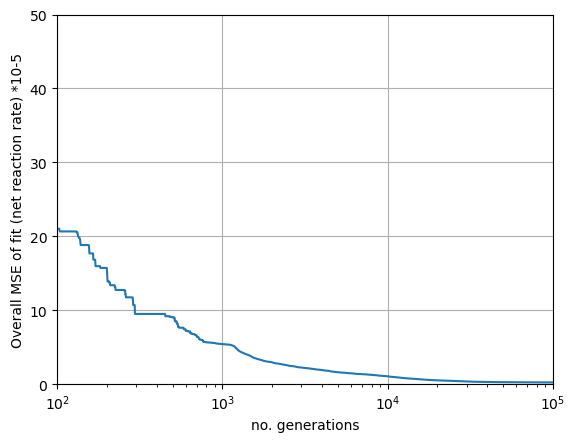

In [35]:
plt.plot(np.arange(len(f_min_log)), f_min_log)
#plt.yscale("log")
plt.xscale("log")
plt.xlabel("no. generations")
plt.ylabel("Overall MSE of fit (net reaction rate) *10-5")

plt.xlim([1e2, 1e5])
plt.ylim([0, 50])

plt.grid()
plt.show()

In [36]:
for i in range(len (res.X)):
    print (res.X[i])

-11.382684967829134
1.501213239496452
0.8122203545078869
-4.25221799659209
0.49258357375008266
0.0008561002610051473
0.3992304141816791
-6.284078638541454
0.5085750995055346
6.025189015200759
4.714293172574865
4.784147361685829
0.7711067314955858
0.02127608843902317
3.02948461763639
1.9557026541788657e-06
0.16224533493222312
-11.614700505407166
1.8297222865756069
1.5316176917298807
-11.244883805806762
1.1584385471604572
3.90505697718857
0.027074119319908434
4.056386430805042
4.995723022592464
1.9366826984166914
10.63234354281724
-4.82581307066257
2.7493842626730016
5.25558912727478
2.5597732487641562
-4.348514512043896
0.5718603814860075
1.0967976157042156
-1.3010290769662627


In [37]:
res.X

array([-1.13826850e+01,  1.50121324e+00,  8.12220355e-01, -4.25221800e+00,
        4.92583574e-01,  8.56100261e-04,  3.99230414e-01, -6.28407864e+00,
        5.08575100e-01,  6.02518902e+00,  4.71429317e+00,  4.78414736e+00,
        7.71106731e-01,  2.12760884e-02,  3.02948462e+00,  1.95570265e-06,
        1.62245335e-01, -1.16147005e+01,  1.82972229e+00,  1.53161769e+00,
       -1.12448838e+01,  1.15843855e+00,  3.90505698e+00,  2.70741193e-02,
        4.05638643e+00,  4.99572302e+00,  1.93668270e+00,  1.06323435e+01,
       -4.82581307e+00,  2.74938426e+00,  5.25558913e+00,  2.55977325e+00,
       -4.34851451e+00,  5.71860381e-01,  1.09679762e+00, -1.30102908e+00])

In [38]:
logkr = [ 
    -12.0, 1.6,   0.9,
    -4.3,  0.5, 0.003, 0.4,
    -7.9,  0.7,   7.2, 5.7, 5.7,
     0.8, 0.03,   3.1, 6*(10**-9), 0.1,
    -12.0, 1.9, 1.6,
    -11.6, 1.2, 4.0, 0.01, 4.2,
    5.4, 2.2, 11.8,
    -12.0, 3.3, 1.8, 4.2,
    -4.0, 0.5, 1.0]

for i in range(len (logkr)):
    print (logkr[i])

-12.0
1.6
0.9
-4.3
0.5
0.003
0.4
-7.9
0.7
7.2
5.7
5.7
0.8
0.03
3.1
6.000000000000001e-09
0.1
-12.0
1.9
1.6
-11.6
1.2
4.0
0.01
4.2
5.4
2.2
11.8
-12.0
3.3
1.8
4.2
-4.0
0.5
1.0


In [39]:
# average of true log kr values excluding Vin

y_mean = np.mean(logkr)

resX=np.ndarray.tolist(res.X)
del resX[-1]

RSS = 0 # initiate residual sum of square
TSS = 0 # intiate total sum of square
for y,y_hat in zip(logkr,resX):
    print( str(y) + ': ' + str (y_hat) ) 
    RSS = RSS + (y - y_hat)**2
    TSS = TSS + (y - y_mean)**2

# coeff of determination for y = y_hat
R2= 1 -(RSS/TSS)
print ('coeff fit: ' +str(R2) )
print ('r: ' + str(R2**(0.5)) )

-12.0: -11.382684967829134
1.6: 1.501213239496452
0.9: 0.8122203545078869
-4.3: -4.25221799659209
0.5: 0.49258357375008266
0.003: 0.0008561002610051473
0.4: 0.3992304141816791
-7.9: -6.284078638541454
0.7: 0.5085750995055346
7.2: 6.025189015200759
5.7: 4.714293172574865
5.7: 4.784147361685829
0.8: 0.7711067314955858
0.03: 0.02127608843902317
3.1: 3.02948461763639
6.000000000000001e-09: 1.9557026541788657e-06
0.1: 0.16224533493222312
-12.0: -11.614700505407166
1.9: 1.8297222865756069
1.6: 1.5316176917298807
-11.6: -11.244883805806762
1.2: 1.1584385471604572
4.0: 3.90505697718857
0.01: 0.027074119319908434
4.2: 4.056386430805042
5.4: 4.995723022592464
2.2: 1.9366826984166914
11.8: 10.63234354281724
-12.0: -4.82581307066257
3.3: 2.7493842626730016
1.8: 5.25558912727478
4.2: 2.5597732487641562
-4.0: -4.348514512043896
0.5: 0.5718603814860075
1.0: 1.0967976157042156
coeff fit: 0.9282605562367316
r: 0.9634627944226656
